In [147]:
!pip install --quiet wikipedia==1.4.0 langchain-core==0.3.59 langgraph==0.5.3 langchain-openai==0.3.16 langchain-experimental==0.3.4 pydantic==2.11.9 python-dotenv==1.0.1 requests==2.31.0
!pip install rapidfuzz
!pip install tabulate


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
  Obtaining dependency information for tabulate from https://files.pythonhosted.org/packages/40/44/4a5f08c96eb108af5cb50b41f76142f0afa346dfa99d5296fe7202a11854/tabulate-0.9.0-py3-none-any.whl.metadata

[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [116]:
import requests
import json

link = 'https://fantasy.premierleague.com/api/bootstrap-static/'

data = json.loads(requests.get(link).text)

In [ ]:
from typing import Annotated
from langchain_core.tools import tool
import pandas as pd
import os
from dotenv import load_dotenv

@tool
def team_data(team_name: Annotated[str, "The name of the English Premier League Team's stats for the current season to look up."]) -> str:
    """
    Use this to look-up latest football team-level performance data for teams in the English Premier League (EPL).

    leave team_name blank to get data for all teams. Do this by passing an empty string ("") as the team_name. Try doing this if I don't specify a team. 
    If I ask for a ranking of teams, you should first get data for all teams, then rank them accordingly and make sure that the ranking is correct. 
    Double check your work if needed. Don't output false rankings and only output it if you're sure it's correct and accurate.

    The fields strength_overall_home, strength_overall_away, strength_attack_home, strength_attack_away,
    strength_defence_home, and strength_defence_away are all ratings between 1000 and 1400 that indicate how strong a team is in those areas.
    1000 is the worst possible rating and 1400 is the best possible rating.
    """
    team_data = data['teams']
    df = pd.DataFrame(team_data)
    df = df.drop(columns=['code', 'draw', 'form', 'id', 'loss', 'played', 'points', 'strength', 'team_division', 'unavailable', 'win'])
    
    if team_name.strip() == "":
        return df.to_markdown()
    
    team_info = df[df['name'].str.lower() == team_name.lower()]
    if team_info.empty:
        return f"No data found for team: {team_name}"
    return team_info.to_markdown()

@tool
def player_data(player_name: Annotated[str, "The name of the English Premier League player's stats to look up."] ) -> str:
    """
    Use this to look-up latest football player-level performance data for players in the English Premier League (EPL).
    If I ask for a ranking of players, you should first get data for all players, then rank them accordingly and make sure that the ranking is correct.
    Double check your work if needed. Don't output false rankings and only output it if you're sure it's correct and accurate.
    Leave player_name blank to get data for all players. Do this by passing an empty string ("") as the player_name. Try doing this if I don't specify a player.
    """
    player_data = data['elements']
    df = pd.DataFrame(player_data)
    if player_name.strip() == "":
        return df.to_markdown()
    player_info = df[df['web_name'].str.lower() == player_name.lower()]
    if player_info.empty:
        return f"No data found for player: {player_name}"
    return player_info.to_markdown()

from langchain_experimental.utilities import PythonREPL

repl = PythonREPL()

@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user. The chart should be displayed using `plt.show()`."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Successfully executed the Python REPL tool.\n\nPython code executed:\n\`\`\`python\n{code}\n\`\`\`\n\nCode output:\n\`\`\`\n{result}\`\`\`"

In [203]:
data.keys()

dict_keys(['chips', 'events', 'game_settings', 'game_config', 'phases', 'teams', 'total_players', 'element_stats', 'element_types', 'elements'])

In [204]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)
load_dotenv()

# Add three tools to the list: wikipedia_tool, stock_data_tool, and python_repl_tool
tools = [team_data, player_data, python_repl_tool]

llm = ChatOpenAI(model="gpt-4o-mini", base_url='https://openrouter.ai/api/v1', openai_api_key=os.getenv('OPENAI'))
# Tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)

def llm_node(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [205]:
from langgraph.prebuilt import ToolNode, tools_condition

# Create the llm and tools nodes
graph_builder.add_node("llm", llm_node)


tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

# Add the edges
graph_builder.add_edge(START, "llm")
graph_builder.add_conditional_edges("llm", tools_condition, ['tools', END])
graph_builder.add_edge("tools", "llm") 

graph = graph_builder.compile()

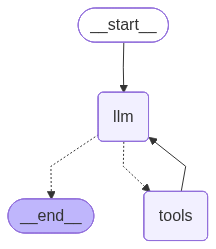

In [206]:
# Visualize your graph
graph

In [207]:
from IPython.display import Markdown, display

def print_stream(stream):
    for chunk in stream:
        for node, data in chunk.items():
            print(f"\n{'='*50}\nNode: {node}\n{'='*50}")
            
            if "messages" in data:
                # Get the last message in the chunk
                message = data["messages"][-1]
                
                # If it's an AI Message with content (the final answer)
                if hasattr(message, "content") and message.content:
                    display(Markdown(message.content))
                
                # If it's a Tool Call (showing the intent)
                if hasattr(message, "tool_calls") and message.tool_calls:
                    for tool in message.tool_calls:
                        print(f"🛠️  Calling Tool: {tool['name']} with args: {tool['args']}")
                
                # If it's a Tool Message (the result of the search)
                if node == "tools":
                    # Display the table properly
                    display(Markdown(message.content))

In [208]:
inputs = {"messages": [("user", "Who is the most underrated player in Bournemouth?")]}
print_stream(graph.stream(inputs, stream_mode="updates"))


Node: llm
🛠️  Calling Tool: team_data with args: {'team_name': 'Bournemouth'}

Node: tools


|    | name        |   position | short_name   |   strength_overall_home |   strength_overall_away |   strength_attack_home |   strength_attack_away |   strength_defence_home |   strength_defence_away |   pulse_id |
|---:|:------------|-----------:|:-------------|------------------------:|------------------------:|-----------------------:|-----------------------:|------------------------:|------------------------:|-----------:|
|  3 | Bournemouth |         15 | BOU          |                    1150 |                    1220 |                   1100 |                   1240 |                    1200 |                    1200 |        127 |

|    | name        |   position | short_name   |   strength_overall_home |   strength_overall_away |   strength_attack_home |   strength_attack_away |   strength_defence_home |   strength_defence_away |   pulse_id |
|---:|:------------|-----------:|:-------------|------------------------:|------------------------:|-----------------------:|-----------------------:|------------------------:|------------------------:|-----------:|
|  3 | Bournemouth |         15 | BOU          |                    1150 |                    1220 |                   1100 |                   1240 |                    1200 |                    1200 |        127 |


Node: llm
🛠️  Calling Tool: player_data with args: {'player_name': ''}

Node: tools


|     | can_transact   | can_select   |   chance_of_playing_next_round |   chance_of_playing_this_round |   code |   cost_change_event |   cost_change_event_fall |   cost_change_start |   cost_change_start_fall |   dreamteam_count |   element_type |   ep_next |   ep_this |   event_points | first_name            |   form |   id | in_dreamteam   | news                                                                    | news_added                  |   now_cost | photo      |   points_per_game | removed   | second_name                                  |   selected_by_percent | special   | squad_number   | status   |   team |   team_code |   total_points |   transfers_in |   transfers_in_event |   transfers_out |   transfers_out_event |   value_form |   value_season | web_name         |   region | team_join_date   | birth_date   | has_temporary_code   | opta_code   |   minutes |   goals_scored |   assists |   clean_sheets |   goals_conceded |   own_goals |   penalties_saved |   penalties_missed |   yellow_cards |   red_cards |   saves |   bonus |   bps |   influence |   creativity |   threat |   ict_index |   clearances_blocks_interceptions |   recoveries |   tackles |   defensive_contribution |   starts |   expected_goals |   expected_assists |   expected_goal_involvements |   expected_goals_conceded |   corners_and_indirect_freekicks_order | corners_and_indirect_freekicks_text   |   direct_freekicks_order | direct_freekicks_text   |   penalties_order | penalties_text   | scout_risks                                                                                                                                                                             |   influence_rank |   influence_rank_type |   creativity_rank |   creativity_rank_type |   threat_rank |   threat_rank_type |   ict_index_rank |   ict_index_rank_type |   expected_goals_per_90 |   saves_per_90 |   expected_assists_per_90 |   expected_goal_involvements_per_90 |   expected_goals_conceded_per_90 |   goals_conceded_per_90 |   now_cost_rank |   now_cost_rank_type |   form_rank |   form_rank_type |   points_per_game_rank |   points_per_game_rank_type |   selected_rank |   selected_rank_type |   starts_per_90 |   clean_sheets_per_90 |   defensive_contribution_per_90 |
|----:|:---------------|:-------------|-------------------------------:|-------------------------------:|-------:|--------------------:|-------------------------:|--------------------:|-------------------------:|------------------:|---------------:|----------:|----------:|---------------:|:----------------------|-------:|-----:|:---------------|:------------------------------------------------------------------------|:----------------------------|-----------:|:-----------|------------------:|:----------|:---------------------------------------------|----------------------:|:----------|:---------------|:---------|-------:|------------:|---------------:|---------------:|---------------------:|----------------:|----------------------:|-------------:|---------------:|:-----------------|---------:|:-----------------|:-------------|:---------------------|:------------|----------:|---------------:|----------:|---------------:|-----------------:|------------:|------------------:|-------------------:|---------------:|------------:|--------:|--------:|------:|------------:|-------------:|---------:|------------:|----------------------------------:|-------------:|----------:|-------------------------:|---------:|-----------------:|-------------------:|-----------------------------:|--------------------------:|---------------------------------------:|:--------------------------------------|-------------------------:|:------------------------|------------------:|:-----------------|:----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-----------------:|----------------------:|------------------:|-----------------------:|--------------:|-------------------:|-----------------:|----------------------:|------------------------:|---------------:|--------------------------:|------------------------------------:|---------------------------------:|------------------------:|----------------:|---------------------:|------------:|-----------------:|-----------------------:|----------------------------:|----------------:|---------------------:|----------------:|----------------------:|--------------------------------:|
|   0 | True           | True         |                            nan |                            nan | 154561 |                   0 |                        0 |                   4 |                       -4 |                 1 |              1 |       4.4 |       4.4 |              6 | David                 |    3.4 |    1 | False          |                                                                         |                             |         59 | 154561.jpg |               4.2 | False     | Raya Martín                                  |                  33.5 | False     |                | a        |      1 |           3 |             92 |        3408548 |                20634 |         1856382 |                 36392 |          0.6 |           15.6 | Raya             |      200 | 2024-07-04       | 1995-09-15   | False                | p154561     |      1980 |              0 |         0 |             11 |               14 |           0 |                 0 |                  0 |              1 |           0 |      32 |       4 |   371 |       326.4 |         20.3 |        0 |        34.7 |                                18 |          175 |         1 |                        0 |       22 |             0    |               0.04 |                         0.04 |                     15.77 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              108 |                    16 |               370 |                      3 |           790 |                 91 |              264 |                    16 |                    0    |           1.45 |                      0    |                                0    |                             0.72 |                    0.64 |              93 |                    1 |         107 |               10 |                     58 |                           4 |               6 |                    1 |            1    |                  0.5  |                            0    |
|   1 | True           | True         |                            nan |                            nan | 109745 |                   0 |                        0 |                  -4 |                        4 |                 0 |              1 |       1   |       1   |              0 | Kepa                  |    0   |    2 | False          |                                                                         |                             |         41 | 109745.jpg |               0   | False     | Arrizabalaga Revuelta                        |                   0.4 | False     |                | a        |      1 |           3 |              0 |          12719 |                  170 |           72792 |                   286 |          0   |            0   | Arrizabalaga     |      200 | 2025-07-01       | 1994-10-03   | False                | p109745     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              600 |                    81 |               595 |                     70 |           562 |                 55 |              604 |                    81 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             642 |                   38 |         528 |               76 |                    611 |                          81 |             270 |                   37 |            0    |                  0    |                            0    |
|   2 | True           | False        |                              0 |                              0 | 463748 |                   0 |                        0 |                   0 |                        0 |                 0 |              1 |       0   |       0   |              0 | Karl                  |    0   |    3 | False          | Has joined Werder Bremen on loan for the rest of the season.            | 2025-08-26T13:44:02.357864Z |         40 | 463748.jpg |               0   | False     | Hein                                         |                   0.2 | False     |                | u        |      1 |           3 |              0 |           5545 |                    0 |           46857 |                   102 |          0   |            0   | Hein             |       67 | 2020-10-28       | 2002-04-13   | False                | p463748     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              560 |                    71 |               555 |                     60 |           520 |                 45 |              563 |                    71 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             671 |                   53 |         485 |               66 |                    571 |                          71 |             357 |                   52 |            0    |                  0    |                            0    |
|   3 | True           | True         |                            nan |                            nan | 551221 |                   0 |                        0 |                  -1 |                        1 |                 0 |              1 |       1   |       1   |              0 | Tommy                 |    0   |    4 | False          |                                                                         |                             |         39 | 551221.jpg |               0   | False     | Setford                                      |                   0.2 | False     |                | a        |      1 |           3 |              0 |          31964 |                  114 |           28476 |                   427 |          0   |            0   | Setford          |      241 | 2024-07-24       | 2006-03-13   | False                | p551221     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              531 |                    56 |               524 |                     43 |           487 |                 28 |              534 |                    56 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             758 |                   87 |         456 |               51 |                    541 |                          56 |             340 |                   48 |            0    |                  0    |                            0    |
|   4 | True           | True         |                            100 |                            100 | 226597 |                   1 |                       -1 |                   9 |                       -9 |                 4 |              2 |       8.8 |       8.8 |              8 | Gabriel               |    7.8 |    5 | True           |                                                                         | 2025-11-17T12:00:07.436586Z |         69 | 226597.jpg |               7.5 | False     | dos Santos Magalhães                         |                  35.6 | False     |                | a        |      1 |           3 |            120 |        6901329 |               136281 |         4938471 |                  8486 |          1.1 |           17.4 | Gabriel          |       30 | 2020-09-01       | 1997-12-19   | False                | p226597     |      1355 |              3 |         2 |             10 |                7 |           0 |                 0 |                  0 |              1 |           0 |       0 |      18 |   390 |       463.2 |         74.6 |      163 |        69.9 |                               115 |           22 |        15 |                      130 |       15 |             1.7  |               0.77 |                         2.47 |                      9.29 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               36 |                    16 |               258 |                     77 |           123 |                 21 |              102 |                    31 |                    0.11 |           0    |                      0.05 |                                0.16 |                             0.62 |                    0.46 |              42 |                    1 |           2 |                2 |                      1 |                           1 |               5 |                    2 |            1    |                  0.66 |                            8.63 |
|   5 | True           | True         |                            100 |                            100 | 462424 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       5   |       5   |              8 | William               |    4   |    6 | False          |                                                                         | 2025-11-30T22:30:08.957329Z |         60 | 462424.jpg |               3.8 | False     | Saliba                                       |                  12.1 | False     |                | a        |      1 |           3 |             69 |        1437464 |                24100 |         1916317 |                  9375 |          0.7 |           11.5 | Saliba           |       73 | 2019-07-25       | 2001-03-24   | False                | p462424     |      1444 |              0 |         0 |              8 |                9 |           0 |                 0 |                  0 |              0 |           0 |       0 |       4 |   316 |       286.6 |         75   |       30 |        39.2 |                                78 |           68 |        20 |                       98 |       17 |             0.38 |               0.46 |                         0.84 |                     10.95 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              144 |                    61 |               257 |                     76 |           327 |                106 |              239 |                    82 |                    0.02 |           0    |                      0.03 |                                0.05 |                             0.68 |                    0.56 |              86 |                    4 |          68 |               25 |                     91 |                          34 |              36 |                   11 |            1.06 |                  0.5  |                            6.11 |
|   6 | True           | True         |                              0 |                              0 | 466075 |                   0 |                        0 |                   1 |                       -1 |                 2 |              2 |       0   |       0   |              0 | Riccardo              |    0   |    7 | False          | Muscle injury - Unknown return date                                     | 2025-12-27T22:00:11.031357Z |         56 | 466075.jpg |               4.8 | False     | Calafiori                                    |                   6.2 | False     |                | i        |      1 |           3 |             77 |        2530646 |                  110 |         2333487 |                 17587 |          0   |           13.8 | Calafiori        |      106 | 2024-07-29       | 2002-05-19   | False                | p466075     |      1256 |              1 |         2 |              9 |                7 |           0 |                 0 |                  0 |              5 |           0 |       0 |       4 |   287 |       222   |        104.8 |      219 |        54.5 |                                57 |           57 |        28 |                       85 |       16 |             2.49 |               0.36 |                         2.85 |                      7.09 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              193 |                    77 |               207 |                     54 |            78 |                  6 |              167 |                    54 |                    0.18 |           0    |                      0.03 |                                0.21 |                             0.51 |                    0.5  |             132 |                   14 |         779 |              261 |                     24 |                          12 |              65 |                   22 |            1.15 |                  0.64 |                            6.09 |
|   7 | True           | True         |                            100 |                            100 | 445122 |                   0 |                        0 |                   8 |                       -8 |                 2 |              2 |       5.6 |       5.6 |              5 | Jurriën               |    4.6 |    8 | True           |                                                                         | 2025-12-27T22:00:11.070756Z |         63 | 445122.jpg |               5.2 | False     | Timber                                       |                  28.1 | False     |                | a        |      1 |           3 |            109 |        5636449 |                52615 |         2826174 |                 38251 |          0.7 |           17.3 | J.Timber         |      152 | 2023-07-14       | 2001-06-17   | False                | p445122     |      1729 |              2 |         4 |             10 |               12 |           0 |                 0 |                  0 |              3 |           0 |       0 |       7 |   391 |       375.4 |        279.4 |      321 |        97.9 |                                60 |           67 |        46 |                      106 |       19 |             4.16 |               0.87 |                         5.03 |                     11.56 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               82 |                    37 |                71 |                     14 |            45 |                  1 |               47 |                     5 |                    0.22 |           0    |                      0.05 |                                0.27 |                             0.6  |                    0.62 |              69 |                    2 |          45 |               19 |                     12 |                           5 |              11 |                    4 |            0.99 |                  0.52 |                            5.52 |
|   8 | True           | False        |                              0 |                              0 | 440854 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       0   |       0   |              0 | Jakub                 |    0   |    9 | False          | has joined Porto on loan for the rest of the season.                    | 2025-09-02T13:37:25.929594Z |         54 | 440854.jpg |               0   | False     | Kiwior                                       |                   0   | False     |                | u        |      1 |           3 |              0 |           1119 |                    0 |           10825 |                     4 |          0   |            0   | Kiwior           |      172 | 2023-01-23       | 2000-02-15   | False                | p440854     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              782 |                   262 |               781 |                    262 |           777 |                261 |              782 |                   262 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             171 |                   21 |         765 |              260 |                    782 |                         262 |             579 |                  210 |            0    |                  0    |                            0    |
|   9 | True           | True         |                            nan |                            nan | 499169 |                   0 |                        0 |                  -4 |                        4 |                 0 |              2 |       1.6 |       1.6 |              0 | Myles                 |    0.6 |   10 | False          |                                                                         |                             |         51 | 499169.jpg |               0.9 | False     | Lewis-Skelly                                 |                   1.5 | False     |                | a        |      1 |           3 |             12 |         128688 |                  603 |          449066 |                  1732 |          0.1 |            2.4 | Lewis-Skelly     |      241 | 2022-12-04       | 2006-09-26   | False                | p499169     |       311 |              0 |         0 |              0 |                5 |           0 |                 0 |                  0 |              3 |           0 |       0 |       0 |    36 |        31.2 |         45.5 |       18 |         9.4 |                                10 |           14 |         4 |                       14 |        1 |             0.05 |               0.06 |                         0.11 |                      5.26 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              407 |                   155 |               321 |                    108 |           363 |                127 |              395 |                   142 |                    0.01 |           0    |                      0.02 |                                0.03 |                             1.52 |                    1.45 |             238 |                   37 |         320 |              119 |                    484 |                         167 |             156 |                   60 |            0.29 |                  0    |                            4.05 |
|  10 | True           | True         |                            100 |                            100 | 198869 |                   0 |                        0 |                  -4 |                        4 |                 1 |              2 |       2.4 |       2.4 |              6 | Benjamin              |    1.4 |   11 | False          |                                                                         | 2025-12-13T23:30:11.163639Z |         51 | 198869.jpg |               4.8 | False     | White                                        |                   0.6 | False     |                | a        |      1 |           3 |             29 |         334522 |                 3082 |          378901 |                   962 |          0.3 |            5.7 | White            |      241 | 2021-07-30       | 1997-10-08   | False                | p198869     |       377 |              0 |         1 |              3 |                3 |           0 |                 0 |                  0 |              0 |           0 |       0 |       3 |   110 |       100.8 |         91.7 |       44 |        23.6 |                                19 |           18 |        12 |                       31 |        5 |             0.43 |               0.47 |                         0.9  |                      5.86 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              314 |                   120 |               227 |                     65 |           298 |                 95 |              317 |                   107 |                    0.1  |           0    |                      0.11 |                                0.21 |                             1.4  |                    0.72 |             228 |                   33 |         248 |               91 |                     22 |                          10 |             236 |                   88 |            1.19 |                  0.72 |                            7.4  |
|  11 | True           | True         |                            nan |                            nan | 563324 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       1   |       1   |              0 | Brayden               |    0   |   13 | False          |                                                                         |                             |         38 | 563324.jpg |               0   | False     | Clarke                                       |                   0.5 | False     |                | a        |      1 |           3 |              0 |          49734 |                  314 |           71976 |                   589 |          0   |            0   | Clarke           |      nan |                  |              | False                | p563324     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              498 |                   188 |               490 |                    189 |           452 |                179 |              501 |                   188 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             796 |                  258 |         422 |              165 |                    508 |                         188 |             257 |                   98 |            0    |                  0    |                            0    |
|  12 | True           | False        |                              0 |                              0 | 588793 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       0   |       0   |              0 | Maldini               |    0   |   14 | False          | has joined Morecambe on loan for the rest of the season.                | 2025-09-22T21:14:30.857843Z |         39 | 588793.jpg |               0   | False     | Kacurri                                      |                   0.1 | False     |                | u        |      1 |           3 |              0 |          10218 |                    0 |           22237 |                    32 |          0   |            0   | Kacurri          |      nan |                  |              | False                | p588793     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              536 |                   199 |               529 |                    200 |           492 |                191 |              539 |                   199 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             763 |                  226 |         461 |              177 |                    546 |                         199 |             471 |                  172 |            0    |                  0    |                            0    |
|  13 | True           | True         |                            nan |                            nan | 499167 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       1   |       1   |              0 | Josh                  |    0   |   15 | False          |                                                                         |                             |         38 | 499167.jpg |               0   | False     | Nichols                                      |                   0.2 | False     |                | a        |      1 |           3 |              0 |          16887 |                   68 |           24360 |                   143 |          0   |            0   | Nichols          |      241 | 2024-07-24       | 2006-07-26   | False                | p499167     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              491 |                   181 |               482 |                    181 |           443 |                170 |              494 |                   181 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             785 |                  247 |         414 |              157 |                    501 |                         181 |             384 |                  140 |            0    |                  0    |                            0    |
|  14 | True           | True         |                            100 |                            100 | 223340 |                  -1 |                        1 |                   1 |                       -1 |                 1 |              3 |       5.2 |       5.2 |              1 | Bukayo                |    4.2 |   16 | False          |                                                                         | 2025-08-23T22:30:05.759392Z |        101 | 223340.jpg |               5   | False     | Saka                                         |                  18.5 | False     |                | a        |      1 |           3 |             99 |        3900476 |                 9746 |         3506028 |                138654 |          0.4 |            9.8 | Saka             |      241 | 2018-11-28       | 2001-09-05   | False                | p223340     |      1453 |              4 |         7 |              8 |                9 |           0 |                 0 |                  0 |              1 |           0 |       0 |      10 |   375 |       402.6 |        582.6 |      531 |       151.7 |                                 8 |           76 |        26 |                      110 |       16 |             5.51 |               4.68 |                        10.19 |                      9.24 |                                      2 |                                       |                      nan |                         |                 1 |                  | []                                                                                                                                                                                      |               62 |                    17 |                 6 |                      6 |            10 |                  4 |                6 |                     4 |                    0.34 |           0    |                      0.29 |                                0.63 |                             0.57 |                    0.56 |               5 |                    3 |          62 |               26 |                     17 |                           9 |              19 |                    7 |            0.99 |                  0.5  |                            6.81 |
|  15 | True           | True         |                            100 |                            100 | 184029 |                   0 |                        0 |                  -2 |                        2 |                 1 |              3 |       6.2 |       6.2 |              1 | Martin                |    5.2 |   17 | False          |                                                                         | 2025-10-04T20:00:07.945438Z |         78 | 184029.jpg |               3.1 | False     | Ødegaard                                     |                   2.4 | False     |                | a        |      1 |           3 |             49 |         355206 |                 3784 |          512199 |                 13907 |          0.7 |            6.3 | Ødegaard         |      161 | 2021-08-20       | 1998-12-17   | False                | p184029     |       926 |              1 |         3 |              4 |                8 |           0 |                 0 |                  0 |              0 |           0 |       0 |       5 |   208 |       221   |        388.5 |      130 |        74   |                                13 |           44 |        14 |                       71 |       12 |             0.87 |               2.59 |                         3.46 |                     10.91 |                                      4 |                                       |                      nan |                         |                 3 |                  | []                                                                                                                                                                                      |              194 |                    83 |                31 |                     30 |           157 |                 93 |               93 |                    55 |                    0.08 |           0    |                      0.25 |                                0.33 |                             1.06 |                    0.78 |              17 |                   12 |          22 |               10 |                    179 |                          77 |             118 |                   39 |            1.17 |                  0.39 |                            6.9  |
|  16 | True           | True         |                            100 |                            100 | 248857 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       2   |       2   |              1 | Noni                  |    1   |   18 | False          |                                                                         | 2025-09-21T22:30:05.839272Z |         68 | 248857.jpg |               1.6 | False     | Madueke                                      |                   0.7 | False     |                | a        |      1 |           3 |             21 |         211582 |                  425 |          281242 |                   981 |          0.1 |            3.1 | Madueke          |      241 | 2025-07-18       | 2002-03-10   | False                | p248857     |       561 |              0 |         0 |              3 |                5 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    85 |        73   |        190.2 |      195 |        45.8 |                                 9 |           15 |         7 |                       31 |        7 |             0.6  |               1.61 |                         2.21 |                      7.11 |                                      3 |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              350 |                   155 |               122 |                     88 |            96 |                 57 |              206 |                   105 |                    0.1  |           0    |                      0.26 |                                0.36 |                             1.14 |                    0.8  |              46 |                   28 |         290 |              131 |                    378 |                         171 |             223 |                   78 |            1.12 |                  0.48 |                            4.97 |
|  17 | True           | True         |                            100 |                            100 | 444145 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       2.4 |       2.4 |              1 | Gabriel               |    1.4 |   19 | False          |                                                                         | 2025-12-24T02:30:10.584394Z |         68 | 444145.jpg |               1.7 | False     | Martinelli Silva                             |                   0.9 | False     |                | a        |      1 |           3 |             29 |         139178 |                 1247 |          220542 |                  1135 |          0.2 |            4.3 | Martinelli       |       30 | 2019-07-15       | 2001-06-18   | False                | p444145     |       545 |              1 |         1 |              2 |                3 |           0 |                 0 |                  0 |              2 |           0 |       0 |       1 |    89 |        78.6 |         71.4 |      207 |        35.2 |                                 6 |           21 |         7 |                       34 |        7 |             2.57 |               0.23 |                         2.8  |                      5.56 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              342 |                   152 |               265 |                    157 |            89 |                 54 |              263 |                   130 |                    0.42 |           0    |                      0.04 |                                0.46 |                             0.92 |                    0.5  |              47 |                   29 |         262 |              117 |                    366 |                         161 |             195 |                   66 |            1.16 |                  0.33 |                            5.61 |
|  18 | True           | True         |                            100 |                            100 | 116216 |                   0 |                        0 |                  -1 |                        1 |                 2 |              3 |       4.8 |       4.8 |              1 | Leandro               |    3.8 |   20 | False          |                                                                         | 2025-11-27T10:00:06.582480Z |         69 | 116216.jpg |               4.5 | False     | Trossard                                     |                   1.6 | False     |                | a        |      1 |           3 |             81 |         440133 |                 3655 |          300434 |                 14634 |          0.6 |           11.7 | Trossard         |       21 | 2023-01-20       | 1994-12-04   | False                | p116216     |      1173 |              5 |         4 |              6 |                9 |           0 |                 0 |                  0 |              1 |           0 |       0 |       9 |   278 |       336.8 |        324.9 |      351 |       101.4 |                                13 |           45 |        14 |                       72 |       12 |             4.17 |               2.05 |                         6.22 |                      8.38 |                                    nan |                                       |                      nan |                         |                 4 |                  | []                                                                                                                                                                                      |              102 |                    34 |                49 |                     42 |            35 |                 21 |               41 |                    31 |                    0.32 |           0    |                      0.16 |                                0.48 |                             0.64 |                    0.69 |              41 |                   25 |          78 |               37 |                     42 |                          20 |             151 |                   50 |            0.92 |                  0.46 |                            5.52 |
|  19 | True           | True         |                            100 |                            100 | 204480 |                   1 |                       -1 |                   9 |                       -9 |                 4 |              3 |       6.6 |       6.6 |              3 | Declan                |    5.6 |   21 | True           |                                                                         | 2025-12-30T16:00:11.463587Z |         74 | 204480.jpg |               6   | False     | Rice                                         |                  30.1 | False     |                | a        |      1 |           3 |            125 |        5454709 |               128013 |         2785326 |                 30628 |          0.8 |           16.9 | Rice             |      241 | 2023-07-15       | 1999-01-14   | False                | p204480     |      1785 |              4 |         7 |             10 |               13 |           0 |                 0 |                  0 |              1 |           0 |       0 |      18 |   515 |       575.4 |        631.5 |      231 |       143.9 |                                78 |          101 |        37 |                      216 |       20 |             2.78 |               4.22 |                         7    |                     12.3  |                                      1 |                                       |                        1 |                         |               nan |                  | []                                                                                                                                                                                      |               12 |                     3 |                 4 |                      4 |            73 |                 46 |               10 |                     8 |                    0.14 |           0    |                      0.21 |                                0.35 |                             0.62 |                    0.66 |              23 |                   16 |          16 |                8 |                      6 |                           3 |               9 |                    3 |            1.01 |                  0.5  |                           10.89 |
|  20 | True           | True         |                            nan |                            nan | 195384 |                   0 |                        0 |                  -4 |                        4 |                 1 |              3 |       2.2 |       2.2 |              1 | Mikel                 |    1.2 |   22 | False          |                                                                         |                             |         56 | 195384.jpg |               3   | False     | Merino Zazón                                 |                   1.5 | False     |                | a        |      1 |           3 |             59 |         824031 |                 1155 |          735481 |                  9801 |          0.2 |           10.5 | Merino           |      200 | 2024-08-27       | 1996-06-22   | False                | p195384     |       964 |              3 |         3 |              4 |                8 |           0 |                 0 |                  0 |              1 |           0 |       0 |       4 |   212 |       265.6 |        185.7 |      193 |        64.2 |                                27 |           52 |        25 |                      104 |       10 |             2.5  |               1.43 |                         3.93 |                      6.32 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              168 |                    64 |               130 |                     93 |            99 |                 59 |              127 |                    67 |                    0.23 |           0    |                      0.13 |                                0.36 |                             0.59 |                    0.75 |             129 |                   80 |         275 |              122 |                    192 |                          82 |             154 |                   52 |            0.93 |                  0.37 |                            9.71 |
|  21 | True           | False        |                              0 |                              0 | 438098 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Fábio                 |    0   |   23 | False          | has joined Hamburger on loan for the rest of the season.                | 2025-09-02T13:38:06.128321Z |         54 | 438098.jpg |               0   | False     | Ferreira Vieira                              |                   0   | False     |                | u        |      1 |           3 |              0 |            933 |                    0 |            4389 |                     3 |          0   |            0   | Fábio Vieira     |      173 | 2022-06-21       | 2000-05-30   | False                | p438098     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              781 |                   345 |               780 |                    345 |           776 |                344 |              781 |                   345 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             170 |                  106 |         764 |              335 |                    781 |                         345 |             670 |                  276 |            0    |                  0    |                            0    |
|  22 | True           | True         |                            100 |                            100 | 128295 |                   0 |                        0 |                  -4 |                        4 |                 0 |              3 |       1.2 |       1.2 |              0 | Christian             |    0.2 |   24 | False          |                                                                         | 2025-08-18T08:00:05.297235Z |         51 | 128295.jpg |               1   | False     | Nørgaard                                     |                   0.1 | False     |                | a        |      1 |           3 |              3 |           6426 |                   91 |           59783 |                   109 |          0   |            0.6 | Nørgaard         |       58 | 2025-07-10       | 1994-03-10   | False                | p128295     |        31 |              0 |         0 |              0 |                1 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    11 |        14.6 |          0.4 |        7 |         2.3 |                                 5 |            3 |         0 |                        8 |        0 |             0.05 |               0    |                         0.05 |                      2.16 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              431 |                   194 |               454 |                    222 |           399 |                197 |              445 |                   203 |                    0.15 |           0    |                      0    |                                0.15 |                             6.27 |                    2.9  |             225 |                  138 |         390 |              179 |                    471 |                         222 |             426 |                  143 |            0    |                  0    |                           23.23 |
|  23 | True           | True         |                            nan |                            nan | 499175 |                   0 |                        0 |                  -5 |                        5 |                 0 |              3 |       1   |       1   |              0 | Ethan                 |    0   |   25 | False          |                                                                         |                             |         50 | 499175.jpg |               1.3 | False     | Nwaneri                                      |                   0.1 | False     |                | a        |      1 |           3 |              8 |          13109 |                  140 |           35220 |                   147 |          0   |            1.6 | Nwaneri          |      241 | 2022-09-17       | 2007-03-21   | False                | p499175     |       165 |              0 |         0 |              1 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    20 |         8.6 |         22.5 |       24 |         5.4 |                                 1 |           10 |         2 |                       13 |        0 |             0.23 |               0.08 |                         0.31 |                      0.73 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              439 |                   199 |               366 |                    189 |           344 |                179 |              419 |                   188 |                    0.13 |           0    |                      0.04 |                                0.17 |                             0.4  |                    0    |             268 |                  163 |         734 |              314 |                    411 |                         185 |             427 |                  144 |            0    |                  0.55 |                            7.09 |
|  24 | True           | True         |                            100 |                            100 | 481655 |                   0 |                        0 |                  -3 |                        3 |                 1 |              3 |       5.2 |       5.2 |              3 | Martín                |    4.2 |   26 | False          |                                                                         | 2025-11-01T18:30:07.784912Z |         52 | 481655.jpg |               3.6 | False     | Zubimendi Ibáñez                             |                   2.2 | False     |                | a        |      1 |           3 |             80 |         734720 |                 4797 |          770225 |                  4301 |          0.8 |           15.4 | Zubimendi        |      200 | 2025-07-06       | 1999-02-02   | False                | p481655     |      1848 |              3 |         1 |             11 |               13 |           0 |                 0 |                  0 |              4 |           0 |       0 |       5 |   373 |       387.6 |        292.7 |      146 |        82.8 |                                76 |           73 |        39 |                      188 |       21 |             1.87 |               1.46 |                         3.33 |                     14.87 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               71 |                    23 |                65 |                     52 |           136 |                 80 |               72 |                    45 |                    0.09 |           0    |                      0.07 |                                0.16 |                             0.72 |                    0.63 |             216 |                  133 |          58 |               23 |                    116 |                          52 |             121 |                   41 |            1.02 |                  0.54 |                            9.16 |
|  25 | True           | False        |                              0 |                              0 | 588796 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Ismeal                |    0   |   28 | False          | has joined Shrewsbury Town on loan for the rest of the season.          | 2025-09-02T13:24:41.013511Z |         45 | 588796.jpg |               0   | False     | Kabia                                        |                   0.1 | False     |                | u        |      1 |           3 |              0 |           6731 |                    0 |           29960 |                    35 |          0   |            0   | Kabia            |      152 | 2024-09-14       | 2005-12-10   | False                | p588796     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              710 |                   293 |               705 |                    293 |           688 |                288 |              710 |                   293 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             477 |                  293 |         655 |              255 |                    711 |                         294 |             468 |                  160 |            0    |                  0    |                            0    |
|  26 | True           | False        |                              0 |                              0 | 437742 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Albert                |    0   |   29 | False          | has joined Hamburger permanently.                                       | 2025-09-02T13:40:53.094922Z |         45 | 437742.jpg |               0   | False     | Sambi Lokonga                                |                   0.1 | False     |                | u        |      1 |           3 |              0 |           2952 |                    0 |           13940 |                    13 |          0   |            0   | Sambi            |       21 | 2021-07-19       | 1999-10-22   | False                | p437742     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              669 |                   259 |               667 |                    262 |           646 |                254 |              672 |                   261 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             420 |                  252 |         616 |              223 |                    675 |                         264 |             574 |                  213 |            0    |                  0    |                            0    |
|  27 | True           | True         |                            100 |                            100 | 219847 |                   0 |                        0 |                  -2 |                        2 |                 0 |              4 |       1   |       1   |              0 | Kai                   |    0   |   30 | False          |                                                                         | 2025-08-20T13:00:06.498911Z |         73 | 219847.jpg |               1   | False     | Havertz                                      |                   0.3 | False     |                | a        |      1 |           3 |              1 |          13622 |                  553 |          112921 |                   412 |          0   |            0.1 | Havertz          |       80 | 2023-06-28       | 1999-06-11   | False                | p219847     |        30 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     4 |         2.8 |          0.8 |        2 |         0.6 |                                 1 |            2 |         0 |                        3 |        0 |             0    |               0.01 |                         0.01 |                      0.82 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              462 |                    53 |               447 |                     54 |           430 |                 58 |              466 |                    57 |                    0    |           0    |                      0.03 |                                0.03 |                             2.46 |                    0    |              26 |                    9 |         796 |               87 |                    481 |                          58 |             292 |                   46 |            0    |                  0    |                            9    |
|  28 | True           | True         |                            100 |                            100 | 205651 |                   0 |                        0 |                  -1 |                        1 |                 0 |              4 |       2.6 |       2.6 |              1 | Gabriel               |    1.6 |   31 | False          |                                                                         | 2025-07-21T10:00:04.697564Z |         64 | 205651.jpg |               1.4 | False     | Fernando de Jesus                            |                   0.3 | False     |                | a        |      1 |           3 |             10 |          56229 |                 5875 |           35687 |                  2039 |          0.2 |            1.6 | G.Jesus          |       30 | 2022-07-04       | 1997-04-03   | False                | p205651     |       149 |              1 |         0 |              0 |                3 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |    41 |        57.2 |          7.3 |      129 |        19.2 |                                 3 |           10 |         4 |                       17 |        0 |             0.98 |               0.12 |                         1.1  |                      2.75 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              374 |                    39 |               413 |                     50 |           159 |                 36 |              339 |                    40 |                    0.59 |           0    |                      0.07 |                                0.66 |                             1.66 |                    1.81 |              57 |                   20 |         241 |               29 |                    403 |                          46 |             319 |                   53 |            0    |                  0    |                           10.27 |
|  29 | True           | True         |                            nan |                            nan | 232413 |                   0 |                        0 |                  -2 |                        2 |                 2 |              3 |       1.4 |       1.4 |              1 | Eberechi              |    0.4 |  266 | False          |                                                                         |                             |         73 | 232413.jpg |               4   | False     | Eze                                          |                   8.6 | False     |                | a        |      1 |           3 |             68 |        3224148 |                 1194 |         3541221 |                 24145 |          0.1 |            9.3 | Eze              |      241 | 2025-08-23       | 1998-06-29   | False                | p232413     |      1014 |              4 |         3 |              6 |                6 |           0 |                 0 |                  0 |              0 |           0 |       0 |       6 |   263 |       254.8 |        158.9 |      283 |        69.6 |                                13 |           41 |        12 |                       66 |       12 |             2.54 |               1.41 |                         3.95 |                      6.13 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              171 |                    67 |               151 |                    103 |            59 |                 36 |              103 |                    57 |                    0.23 |           0    |                      0.13 |                                0.36 |                             0.54 |                    0.53 |              28 |                   19 |         350 |              156 |                     75 |                          34 |              49 |                   19 |            1.07 |                  0.53 |                            5.86 |
|  30 | True           | True         |                            100 |                              0 | 500040 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       1   |       0   |              0 | Cristhian             |    0   |  662 | False          |                                                                         | 2025-12-04T09:00:09.512338Z |         53 | 500040.jpg |               1.7 | False     | Mosquera                                     |                   0.1 | False     |                | a        |      1 |           3 |             17 |          42168 |                  110 |           50173 |                    83 |          0   |            3.2 | Mosquera         |      200 | 2025-07-24       | 2004-06-27   | False                | p500040     |       429 |              0 |         0 |              1 |                4 |           0 |                 0 |                  0 |              1 |           0 |       0 |       1 |    85 |        84   |         23.2 |        8 |        11.5 |                                24 |           17 |        11 |                       35 |        4 |             0    |               0.43 |                         0.43 |                      2.68 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              335 |                   128 |               365 |                    132 |           391 |                145 |              382 |                   137 |                    0    |           0    |                      0.09 |                                0.09 |                             0.56 |                    0.84 |             200 |                   27 |         756 |              257 |                    363 |                         137 |             428 |                  158 |            0.84 |                  0.21 |                            7.34 |
|  31 | True           | True         |                            100 |                            100 | 224117 |                   0 |                        0 |                  -3 |                        3 |                 1 |              4 |       2.8 |       2.8 |              1 | Viktor                |    1.8 |  666 | False          |                                                                         | 2025-11-01T18:00:08.847750Z |         87 | 224117.jpg |               2.8 | False     | Gyökeres                                     |                   9.3 | False     |                | a        |      1 |           3 |             55 |        2634260 |                 4382 |         4543465 |                 10088 |          0.2 |            6.3 | Gyökeres         |      206 | 2025-07-26       | 1998-06-04   | False                | p224117     |      1345 |              5 |         0 |              9 |                6 |           0 |                 0 |                  0 |              3 |           0 |       0 |       4 |   184 |       199.8 |        138.8 |      436 |        76.9 |                                14 |           30 |         4 |                       48 |       17 |             6.37 |               0.9  |                         7.27 |                      9.42 |                                    nan |                                       |                      nan |                         |                 2 |                  | []                                                                                                                                                                                      |              212 |                    17 |               165 |                     14 |            22 |                 13 |               87 |                    15 |                    0.43 |           0    |                      0.06 |                                0.49 |                             0.63 |                    0.4  |               9 |                    5 |         228 |               27 |                    223 |                          22 |              46 |                    9 |            1.14 |                  0.6  |                            3.21 |
|  32 | True           | True         |                              0 |                              0 | 616077 |                   0 |                        0 |                  -3 |                        3 |                 0 |              3 |       0   |       0   |              0 | Max                   |    0   |  700 | False          | Ankle injury - Unknown return date                                      | 2025-12-10T00:00:08.266774Z |         42 | 616077.jpg |               2.5 | False     | Dowman                                       |                   0.3 | False     |                | i        |      1 |           3 |              5 |         134763 |                 2336 |          113872 |                  1095 |          0   |            1.2 | Dowman           |      241 | 2025-07-22       | 2009-12-31   | False                | p616077     |        27 |              0 |         1 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    13 |         1   |          0.8 |       26 |         2.8 |                                 0 |            1 |         2 |                        3 |        0 |             0.14 |               0.02 |                         0.16 |                      0.12 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              473 |                   219 |               445 |                    217 |           336 |                176 |              441 |                   201 |                    0.47 |           0    |                      0.07 |                                0.54 |                             0.4  |                    0    |             640 |                  360 |         546 |              185 |                    249 |                         108 |             300 |                  101 |            0    |                  0    |                           10    |
|  33 | True           | True         |                            nan |                            nan | 646243 |                  -1 |                        1 |                  -1 |                        1 |                 0 |              3 |       1   |       1   |              0 | Andre                 |    0   |  711 | False          |                                                                         |                             |         44 | 646243.jpg |               0   | False     | Harriman-Annous                              |                   0   | False     |                | a        |      1 |           3 |              0 |           1647 |                   20 |            1542 |                    11 |          0   |            0   | Harriman-Annous  |      241 | 2025-07-22       | 2007-12-28   | False                | p646243     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              658 |                   253 |               654 |                    256 |           631 |                247 |              661 |                   255 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             560 |                  336 |         602 |              216 |                    664 |                         258 |             695 |                  295 |            0    |                  0    |                            0    |
|  34 | True           | True         |                             50 |                             75 | 448104 |                   0 |                        0 |                  -3 |                        3 |                 1 |              2 |       1   |       1.5 |              0 | Piero                 |    1   |  725 | False          | Muscle injury - 50% chance of playing                                   | 2026-01-09T17:30:12.626512Z |         52 | 448104.jpg |               2.9 | False     | Hincapié                                     |                   0.9 | False     |                | d        |      1 |           3 |             35 |         457573 |                   79 |          352989 |                 13569 |          0.2 |            6.7 | Hincapie         |       62 | 2025-09-01       | 2002-01-09   | False                | p448104     |       889 |              0 |         0 |              2 |                9 |           0 |                 0 |                  0 |              2 |           0 |       0 |       2 |   147 |       188.6 |         58.3 |       20 |        26.6 |                                61 |           36 |        19 |                       80 |       10 |             0    |               0.74 |                         0.74 |                      9.45 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              223 |                    91 |               295 |                     97 |           356 |                121 |              304 |                   102 |                    0    |           0    |                      0.07 |                                0.07 |                             0.96 |                    0.91 |             214 |                   30 |         285 |              104 |                    201 |                          79 |             193 |                   75 |            1.01 |                  0.2  |                            8.1  |
|  35 | True           | True         |                            nan |                            nan | 616065 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       1   |       1   |              0 | Marli                 |    0   |  759 | False          |                                                                         |                             |         40 | 616065.jpg |               0   | False     | Salmon                                       |                   0   | False     |                | a        |      1 |           3 |              0 |            870 |                   36 |             632 |                    39 |          0   |            0   | Salmon           |      241 | 2025-07-22       | 2009-08-29   | False                | p616065     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              593 |                   234 |               588 |                    235 |           554 |                229 |              596 |                   234 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             711 |                  201 |         521 |              215 |                    604 |                         235 |             698 |                  240 |            0    |                  0    |                            0    |
|  36 | True           | True         |                             75 |                             75 |  98980 |                   0 |                        0 |                   0 |                        0 |                 2 |              1 |       1.4 |       1.4 |              2 | Emiliano              |    1.8 |   32 | False          | Calf injury - 75% chance of playing                                     | 2026-01-22T01:30:06.743087Z |         50 | 98980.jpg  |               3.7 | False     | Martínez Romero                              |                   3.2 | False     |                | d        |      2 |           7 |             66 |         644582 |                 2822 |          490632 |                 10778 |          0.4 |           13.2 | Martinez         |       10 | 2020-09-16       | 1992-09-02   | False                | p98980      |      1575 |              0 |         0 |              4 |               17 |           0 |                 1 |                  0 |              1 |           0 |      51 |       3 |   291 |       389.2 |          3   |        0 |        39.2 |                                14 |          138 |         0 |                        0 |       18 |             0    |               0.03 |                         0.03 |                     22.83 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               69 |                    13 |               428 |                     12 |           748 |                 83 |              238 |                    13 |                    0    |           2.91 |                      0    |                                0    |                             1.3  |                    0.97 |             243 |                    8 |         221 |               19 |                    100 |                          10 |             101 |                   15 |            1.03 |                  0.23 |                            0    |
|  37 | True           | True         |                            nan |                            nan |  72147 |                   0 |                        0 |                  -3 |                        3 |                 0 |              1 |       0.4 |       0.4 |              0 | Marco                 |    0.4 |   33 | False          |                                                                         |                             |         42 | 72147.jpg  |               2.2 | False     | Bizot                                        |                   0.4 | False     |                | a        |      2 |           7 |             11 |          82227 |                  150 |          110288 |                   392 |          0.1 |            2.6 | M.Bizot          |      152 | 2025-07-15       | 1991-03-10   | False                | p72147      |       405 |              0 |         0 |              1 |                8 |           0 |                 0 |                  0 |              2 |           0 |      13 |       0 |    51 |        92.8 |          0   |        0 |         9.3 |                                 6 |           41 |         0 |                        0 |        4 |             0    |               0    |                         0    |                      8.53 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              328 |                    27 |               597 |                     72 |           565 |                 57 |              396 |                    27 |                    0    |           2.89 |                      0    |                                0    |                             1.9  |                    1.78 |             618 |                   32 |         329 |               24 |                    283 |                          25 |             268 |                   35 |            0.89 |                  0.22 |                            0    |
|  38 | True           | False        |                              0 |                              0 | 462492 |                   0 |                        0 |                   0 |                        0 |                 0 |              1 |       0   |       0   |              0 | Joe                   |    0   |   34 | False          | Has joined Port Vale on loan for the rest of the season.                | 2025-08-12T07:40:37.843391Z |         40 | 462492.jpg |               0   | False     | Gauci                                        |                   0.1 | False     |                | u        |      2 |           7 |              0 |              0 |                    0 |           16772 |                    59 |          0   |            0   | Gauci            |       13 | 2024-02-01       | 2000-07-04   | False                | p462492     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              559 |                    70 |               554 |                     59 |           519 |                 44 |              562 |                    70 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             670 |                   52 |         484 |               65 |                    570 |                          70 |             476 |                   74 |            0    |                  0    |                            0    |
|  39 | True           | False        |                              0 |                              0 | 462381 |                   0 |                        0 |                   0 |                        0 |                 0 |              1 |       0   |       0   |              0 | Filip                 |    0   |   35 | False          | Has joined Stevenage permanently.                                       | 2025-07-30T14:08:21.698398Z |         40 | 462381.jpg |               0   | False     | Marschall                                    |                   0   | False     |                | u        |      2 |           7 |              0 |              0 |                    0 |            1224 |                     4 |          0   |            0   | Marschall        |      241 | 2021-12-13       | 2003-04-24   | False                | p462381     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              558 |                    69 |               553 |                     58 |           518 |                 43 |              561 |                    69 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             669 |                   51 |         483 |               64 |                    569 |                          69 |             724 |                   83 |            0    |                  0    |                            0    |
|  40 | True           | True         |                            100 |                            100 | 199796 |                   0 |                        0 |                   3 |                       -3 |                 2 |              2 |       2.8 |       2.8 |              2 | Matty                 |    2.8 |   36 | False          |                                                                         | 2025-12-28T02:30:08.800205Z |         48 | 199796.jpg |               4.2 | False     | Cash                                         |                  11.2 | False     |                | a        |      2 |           7 |             89 |        2427700 |                22568 |         1396719 |                 27687 |          0.6 |           18.5 | Cash             |      172 | 2020-09-03       | 1997-08-07   | False                | p199796     |      1861 |              3 |         2 |              6 |               20 |           0 |                 0 |                  0 |              5 |           0 |       0 |       6 |   328 |       445   |        315.8 |      127 |        88.8 |                                83 |           53 |        36 |                      119 |       21 |             0.7  |               1.91 |                         2.61 |                     27.25 |                                      1 |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               44 |                    21 |                53 |                      9 |           161 |                 31 |               57 |                     9 |                    0.03 |           0    |                      0.09 |                                0.12 |                             1.32 |                    0.97 |             352 |                   58 |         149 |               57 |                     56 |                          26 |              39 |                   13 |            1.02 |                  0.29 |                            5.75 |
|  41 | True           | True         |                            100 |                            100 | 101188 |                   0 |                        0 |                   0 |                        0 |                 1 |              2 |       2.4 |       2.4 |              1 | Lucas                 |    2.4 |   37 | False          |                                                                         | 2025-10-23T13:30:07.954318Z |         45 | 101188.jpg |               3.1 | False     | Digne                                        |                   1.6 | False     |                | a        |      2 |           7 |             65 |         278647 |                 1526 |          312217 |                  3479 |          0.5 |           14.4 | Digne            |       73 | 2022-01-13       | 1993-07-20   | False                | p101188     |      1209 |              0 |         3 |              6 |               12 |           0 |                 0 |                  0 |              2 |           0 |       0 |       4 |   255 |       243.2 |        277.8 |      106 |        62.5 |                                46 |           43 |        21 |                       67 |       14 |             0.54 |               1.75 |                         2.29 |                     18.41 |                                      2 |                                       |                        2 |                         |               nan |                  | []                                                                                                                                                                                      |              177 |                    72 |                72 |                     15 |           194 |                 48 |              131 |                    43 |                    0.04 |           0    |                      0.13 |                                0.17 |                             1.37 |                    0.89 |             401 |                   73 |         179 |               69 |                    168 |                          67 |             150 |                   58 |            1.04 |                  0.45 |                            4.99 |
|  42 | True           | True         |                            100 |                            100 | 199798 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       3   |       3   |              2 | Ezri                  |    3   |   38 | False          |                                                                         | 2025-11-18T09:30:07.536725Z |         44 | 199798.jpg |               3   | False     | Konsa Ngoyo                                  |                   7.4 | False     |                | a        |      2 |           7 |             64 |         499682 |                 4911 |         1866737 |                 10168 |          0.7 |           14.5 | Konsa            |      241 | 2019-07-11       | 1997-10-23   | False                | p199798     |      1865 |              0 |         0 |              6 |               24 |           0 |                 0 |                  0 |              0 |           1 |       0 |       3 |   326 |       384.2 |         72.7 |       79 |        53.9 |                               110 |           63 |        14 |                      124 |       21 |             0.38 |               0.4  |                         0.78 |                     29.83 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               75 |                    33 |               262 |                     80 |           236 |                 65 |              171 |                    55 |                    0.02 |           0    |                      0.02 |                                0.04 |                             1.44 |                    1.16 |             516 |                  104 |         124 |               47 |                    182 |                          72 |              56 |                   18 |            1.01 |                  0.29 |                            5.98 |
|  43 | True           | True         |                            nan |                            nan | 441302 |                   0 |                        0 |                  -3 |                        3 |                 0 |              2 |       1.4 |       1.4 |              2 | Ian                   |    1.4 |   39 | False          |                                                                         |                             |         42 | 441302.jpg |               1.2 | False     | Maatsen                                      |                   0.5 | False     |                | a        |      2 |           7 |             20 |          50106 |                  787 |           90694 |                   886 |          0.3 |            4.8 | Maatsen          |      152 | 2024-06-28       | 2002-03-10   | False                | p441302     |       760 |              0 |         0 |              0 |               13 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |   115 |       153.8 |        178.8 |      114 |        44.9 |                                40 |           47 |        22 |                       62 |        8 |             0.68 |               1.1  |                         1.78 |                     12.95 |                                      5 |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              259 |                   105 |               134 |                     32 |           178 |                 38 |              210 |                    70 |                    0.08 |           0    |                      0.13 |                                0.21 |                             1.53 |                    1.54 |             627 |                  149 |         246 |               89 |                    418 |                         152 |             252 |                   96 |            0.95 |                  0    |                            7.34 |
|  44 | True           | True         |                            100 |                            100 | 149484 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       0   |       0   |              0 | Tyrone                |    0   |   40 | False          |                                                                         | 2025-11-02T00:00:09.519584Z |         43 | 149484.jpg |               3.4 | False     | Mings                                        |                   0.5 | False     |                | a        |      2 |           7 |             24 |         123457 |                  318 |          188184 |                   215 |          0   |            5.6 | Mings            |      241 | 2019-07-08       | 1993-03-13   | False                | p149484     |       497 |              0 |         0 |              2 |                6 |           0 |                 0 |                  0 |              0 |           0 |       0 |       1 |    87 |       120.2 |         44.6 |       25 |        19   |                                39 |           16 |         2 |                       41 |        6 |             0.33 |               0.09 |                         0.42 |                      8.78 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              289 |                   110 |               324 |                    109 |           339 |                112 |              342 |                   119 |                    0.06 |           0    |                      0.02 |                                0.08 |                             1.59 |                    1.09 |             567 |                  125 |         550 |              232 |                    126 |                          48 |             245 |                   92 |            1.09 |                  0.36 |                            7.42 |
|  45 | True           | True         |                            100 |                            100 | 244954 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       0.4 |       0.4 |              2 | Pau                   |    0.4 |   41 | False          |                                                                         | 2025-12-12T00:00:09.857457Z |         43 | 244954.jpg |               3.2 | False     | Torres                                       |                   0.3 | False     |                | a        |      2 |           7 |             41 |          61885 |                  359 |           88810 |                   345 |          0.1 |            9.5 | Pau              |      200 | 2023-07-12       | 1997-01-16   | False                | p244954     |      1042 |              0 |         1 |              3 |               12 |           1 |                 0 |                  0 |              0 |           0 |       0 |       2 |   183 |       222.2 |         29   |       28 |        28.1 |                                61 |           57 |        17 |                       78 |       11 |             0.22 |               0.26 |                         0.48 |                     14.7  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              192 |                    76 |               350 |                    123 |           330 |                108 |              297 |                    98 |                    0.02 |           0    |                      0.02 |                                0.04 |                             1.27 |                    1.04 |             577 |                  132 |         331 |              124 |                    151 |                          62 |             315 |                  116 |            0.95 |                  0.26 |                            6.74 |
|  46 | True           | True         |                            100 |                            100 | 606798 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       0.2 |       0.2 |              0 | Andrés                |    0.2 |   42 | False          |                                                                         | 2025-10-23T13:30:07.986013Z |         39 | 606798.jpg |               0.5 | False     | García                                       |                   0.2 | False     |                | a        |      2 |           7 |              1 |          27001 |                  203 |           37164 |                   250 |          0.1 |            0.3 | A.García         |      200 | 2025-01-21       | 2003-02-07   | False                | p606798     |        30 |              0 |         0 |              0 |                2 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    -3 |         0.6 |          1.5 |        0 |         0.2 |                                 0 |            2 |         0 |                        0 |        0 |             0    |               0.01 |                         0.01 |                      1.52 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              475 |                   169 |               437 |                    160 |           493 |                192 |              479 |                   170 |                    0    |           0    |                      0.03 |                                0.03 |                             4.56 |                    6    |             765 |                  228 |         353 |              133 |                    487 |                         168 |             356 |                  131 |            0    |                  0    |                            0    |
|  47 | True           | False        |                              0 |                              0 | 106468 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Álex                  |    0   |   43 | False          | Has joined Girona permanently.                                          | 2025-08-26T13:45:03.013808Z |         40 | 106468.jpg |               0   | False     | Moreno Lopera                                |                   1.7 | False     |                | u        |      2 |           7 |              0 |          44476 |                    0 |          878507 |                   753 |          0   |            0   | Alex Moreno      |      200 | 2023-01-11       | 1993-06-08   | False                | p106468     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              542 |                   202 |               536 |                    203 |           500 |                195 |              545 |                   202 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             649 |                  159 |         467 |              180 |                    552 |                         202 |             144 |                   57 |            0    |                  0    |                            0    |
|  48 | True           | True         |                            100 |                            100 | 515597 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0.4 |       0.4 |              1 | Lamare                |    0.4 |   44 | False          |                                                                         | 2025-11-20T10:30:09.224047Z |         40 | 515597.jpg |               1.3 | False     | Bogarde                                      |                   0.5 | False     |                | a        |      2 |           7 |             22 |          95302 |                  526 |           80674 |                   719 |          0.1 |            5.5 | Bogarde          |      152 | 2021-01-07       | 2004-01-05   | False                | p515597     |       504 |              0 |         0 |              1 |                7 |           0 |                 0 |                  0 |              5 |           0 |       0 |       3 |    71 |        67   |         40.3 |        8 |        11.5 |                                16 |           16 |        12 |                       28 |        5 |             0    |               0.14 |                         0.14 |                      8.21 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              361 |                   138 |               330 |                    112 |           381 |                138 |              378 |                   135 |                    0    |           0    |                      0.02 |                                0.02 |                             1.47 |                    1.25 |             685 |                  179 |         328 |              122 |                    404 |                         147 |             247 |                   94 |            0.89 |                  0.18 |                            5    |
|  49 | True           | True         |                            nan |                            nan | 514315 |                  -1 |                        1 |                  -2 |                        2 |                 0 |              2 |       0   |       0   |              0 | Lino                  |    0   |   45 | False          |                                                                         |                             |         38 | 514315.jpg |               0   | False     | da Cruz Sousa                                |                   0.3 | False     |                | a        |      2 |           7 |              0 |          18268 |                  530 |           31641 |                   241 |          0   |            0   | Sousa            |      nan |                  |              | False                | p514315     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              492 |                   182 |               483 |                    182 |           444 |                171 |              495 |                   182 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             786 |                  248 |         415 |              158 |                    502 |                         182 |             322 |                  118 |            0    |                  0    |                            0    |
|  50 | True           | False        |                              0 |                              0 | 587178 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Yasin                 |    0   |   46 | False          | has joined Anderlecht on loan for the rest of the season.               | 2025-09-22T21:15:59.805053Z |         40 | 587178.jpg |               0   | False     | Özcan                                        |                   0.1 | False     |                | u        |      2 |           7 |              0 |           4656 |                    0 |           20512 |                    38 |          0   |            0   | Yasin            |      219 | 2025-06-01       | 2006-04-20   | False                | p587178     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              585 |                   227 |               580 |                    228 |           546 |                222 |              588 |                   227 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             701 |                  192 |         512 |              207 |                    596 |                         228 |             449 |                  164 |            0    |                  0    |                            0    |
|  51 | True           | True         |                            100 |                            100 | 244850 |                   0 |                        0 |                   7 |                       -7 |                 3 |              3 |       2.4 |       2.4 |              2 | Morgan                |    2.4 |   47 | False          |                                                                         | 2025-08-10T22:00:04.458365Z |         77 | 244850.jpg |               4.7 | False     | Rogers                                       |                  31.8 | False     |                | a        |      2 |           7 |            103 |        4959096 |                39439 |         2050493 |                124705 |          0.3 |           13.4 | Rogers           |      241 | 2024-02-01       | 2002-07-26   | False                | p244850     |      1957 |              7 |         4 |              6 |               25 |           0 |                 0 |                  0 |              4 |           0 |       0 |      10 |   357 |       458   |        384.4 |      492 |       133.3 |                                28 |           77 |        21 |                      126 |       22 |             4.24 |               2.38 |                         6.62 |                     30.66 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               39 |                     9 |                33 |                     32 |            14 |                  7 |               11 |                     9 |                    0.19 |           0    |                      0.11 |                                0.3  |                             1.41 |                    1.15 |              18 |                   13 |         189 |               79 |                     28 |                          13 |               8 |                    2 |            1.01 |                  0.28 |                            5.79 |
|  52 | True           | True         |                            100 |                            100 | 166989 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       4.2 |       4.2 |              2 | Youri                 |    4.2 |   48 | False          |                                                                         | 2025-09-14T22:00:07.795199Z |         59 | 166989.jpg |               3.1 | False     | Tielemans                                    |                   1.1 | False     |                | a        |      2 |           7 |             49 |         152127 |                 2827 |          284501 |                  3984 |          0.7 |            8.3 | Tielemans        |       21 | 2023-06-14       | 1997-05-07   | False                | p166989     |      1222 |              0 |         4 |              3 |               17 |           0 |                 0 |                  0 |              0 |           0 |       0 |       3 |   270 |       284   |        360   |      147 |        79.1 |                                25 |           65 |        37 |                      127 |       14 |             0.97 |               2.24 |                         3.21 |                     20.99 |                                      3 |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              146 |                    53 |                40 |                     37 |           134 |                 78 |               82 |                    51 |                    0.07 |           0    |                      0.16 |                                0.23 |                             1.55 |                    1.25 |              94 |                   59 |          60 |               25 |                    174 |                          74 |             177 |                   62 |            1.03 |                  0.22 |                            9.35 |
|  53 | True           | False        |                              0 |                              0 | 215711 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Leon                  |    0   |   49 | False          | has joined AS Roma on loan for the rest of the season.                  | 2025-08-20T13:31:56.843157Z |         55 | 215711.jpg |               0   | False     | Bailey                                       |                   0.1 | False     |                | u        |      2 |           7 |              0 |           2168 |                    0 |           48272 |                    21 |          0   |            0   | Bailey           |      107 | 2021-08-04       | 1997-08-09   | False                | p215711     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              787 |                   350 |               786 |                    350 |           783 |                349 |              787 |                   350 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             141 |                   89 |         773 |              342 |                    787 |                         350 |             512 |                  182 |            0    |                  0    |                            0    |
|  54 | True           | True         |                            100 |                            100 | 195546 |                   0 |                        0 |                  -2 |                        2 |                 2 |              3 |       2   |       2   |              2 | Emiliano              |    2   |   50 | False          |                                                                         | 2025-10-31T00:00:08.522687Z |         53 | 195546.jpg |               3   | False     | Buendía Stati                                |                   0.3 | False     |                | a        |      2 |           7 |             60 |         160027 |                 1150 |          143182 |                  1535 |          0.4 |           11.3 | Buendía          |       10 | 2021-06-10       | 1996-12-25   | False                | p195546     |       862 |              4 |         2 |              2 |                9 |           0 |                 0 |                  0 |              2 |           0 |       0 |       7 |   202 |       250.6 |        226.1 |      190 |        66.7 |                                18 |           56 |        25 |                       99 |       10 |             1.99 |               1.17 |                         3.16 |                     13.54 |                                    nan |                                       |                        6 |                         |                 2 |                  | []                                                                                                                                                                                      |              173 |                    69 |                96 |                     71 |           101 |                 60 |              114 |                    61 |                    0.21 |           0    |                      0.12 |                                0.33 |                             1.41 |                    0.94 |             187 |                  116 |         207 |               88 |                    191 |                          81 |             297 |                   99 |            1.04 |                  0.21 |                           10.34 |
|  55 | True           | False        |                              0 |                              0 | 469247 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Samuel                |    0   |   51 | False          | has joined West Bromwich Albion on loan for the rest of the season      | 2025-09-22T21:15:59.838578Z |         55 | 469247.jpg |               0   | False     | Iling-Junior                                 |                   0   | False     |                | u        |      2 |           7 |              0 |           1383 |                    0 |            3748 |                     3 |          0   |            0   | Iling Jr         |      241 | 2024-07-01       | 2003-10-04   | False                | p469247     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              788 |                   351 |               787 |                    351 |           784 |                350 |              788 |                   351 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             151 |                   96 |         775 |              344 |                    788 |                         351 |             671 |                  277 |            0    |                  0    |                            0    |
|  56 | True           | False        |                              0 |                              0 | 204646 |                   0 |                        0 |                  -4 |                        4 |                 1 |              3 |       0   |       0   |              0 | Donyell               |    1.4 |   53 | False          | has joined Roma on loan for the rest of the season.                     | 2026-01-16T15:17:04.828016Z |         51 | 204646.jpg |               2.6 | False     | Malen                                        |                   0.5 | False     |                | u        |      2 |           7 |             55 |         172896 |                    0 |          321038 |                  5493 |          0.3 |           10.8 | Malen            |      152 | 2025-01-14       | 1999-01-19   | False                | p204646     |       640 |              4 |         2 |              1 |               10 |           0 |                 0 |                  0 |              0 |           0 |       0 |       3 |   161 |       183.4 |         99.7 |      290 |        56.3 |                                 2 |           10 |         4 |                       16 |        5 |             4.03 |               0.35 |                         4.38 |                     10.59 |                                    nan |                                       |                      nan |                         |                 1 |                  | []                                                                                                                                                                                      |              229 |                    98 |               214 |                    134 |            55 |                 34 |              155 |                    87 |                    0.57 |           0    |                      0.05 |                                0.62 |                             1.49 |                    1.41 |             229 |                  140 |         249 |              108 |                    240 |                         104 |             243 |                   82 |            0.7  |                  0.14 |                            2.25 |
|  57 | True           | True         |                             25 |                            nan | 122806 |                   0 |                        0 |                  -1 |                        1 |                 1 |              3 |       1.1 |       4.2 |              1 | John                  |    4.2 |   54 | False          | Knee injury - 25% chance of playing                                     | 2026-01-19T03:00:08.140927Z |         54 | 122806.jpg |               3.2 | False     | McGinn                                       |                   1.1 | False     |                | d        |      2 |           7 |             71 |         207704 |                 2916 |          162797 |                 11604 |          0.8 |           13.1 | McGinn           |      243 | 2018-08-08       | 1994-10-18   | False                | p122806     |      1591 |              3 |         2 |              7 |               21 |           0 |                 0 |                  0 |              3 |           0 |       0 |       4 |   289 |       308.2 |        385.2 |      193 |        88.8 |                                29 |           70 |        27 |                      126 |       21 |             2.52 |               1.96 |                         4.48 |                     26.58 |                                      4 |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              119 |                    42 |                32 |                     31 |            98 |                 58 |               58 |                    39 |                    0.14 |           0    |                      0.11 |                                0.25 |                             1.5  |                    1.19 |             159 |                   99 |          59 |               24 |                    159 |                          68 |             175 |                   61 |            1.19 |                  0.4  |                            7.13 |
|  58 | True           | True         |                              0 |                              0 |  88894 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       0   |       0   |              0 | Ross                  |    0   |   55 | False          | Knee injury - Expected back 07 Feb                                      | 2025-11-30T22:30:09.043798Z |         48 | 88894.jpg  |               2.1 | False     | Barkley                                      |                   0   | False     |                | i        |      2 |           7 |             15 |           4388 |                   12 |           11700 |                    24 |          0   |            3.1 | Barkley          |      241 | 2024-07-01       | 1993-12-05   | False                | p88894      |       114 |              1 |         1 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    56 |        51.8 |         33.7 |       55 |        14   |                                 2 |           10 |         3 |                       15 |        0 |             0.43 |               0.16 |                         0.59 |                      1.41 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              380 |                   167 |               341 |                    180 |           282 |                150 |              366 |                   172 |                    0.34 |           0    |                      0.13 |                                0.47 |                             1.11 |                    0    |             346 |                  217 |         686 |              279 |                    306 |                         135 |             615 |                  240 |            0    |                  0    |                           11.84 |
|  59 | True           | False        |                              0 |                              0 | 491287 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Enzo                  |    0   |   56 | False          | Season-long loan to Benfica                                             | 2025-07-22T13:50:13.193555Z |         50 | 491287.jpg |               0   | False     | Barrenechea                                  |                   0   | False     |                | u        |      2 |           7 |              0 |              0 |                    0 |              34 |                     0 |          0   |            0   | Barrenechea      |      nan |                  |              | False                | p491287     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              766 |                   335 |               764 |                    335 |           756 |                333 |              766 |                   335 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             264 |                  161 |         733 |              313 |                    766 |                         335 |             799 |                  358 |            0    |                  0    |                            0    |
|  60 | True           | False        |                              0 |                              0 | 461421 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Lewis                 |    0   |   57 | False          | Has joined Preston North End on loan for the rest of the season.        | 2025-08-26T13:44:19.058961Z |         50 | 461421.jpg |               0   | False     | Dobbin                                       |                   0   | False     |                | u        |      2 |           7 |              0 |            889 |                    0 |            5398 |                     3 |          0   |            0   | Dobbin           |      241 | 2024-06-23       | 2003-01-03   | False                | p461421     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              762 |                   332 |               759 |                    332 |           752 |                330 |              762 |                   332 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             258 |                  158 |         729 |              310 |                    762 |                         332 |             652 |                  266 |            0    |                  0    |                            0    |
|  61 | True           | True         |                              0 |                              0 | 226944 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Boubacar              |    1.6 |   58 | False          | Knee injury - Unknown return date                                       | 2026-01-11T18:30:10.173859Z |         49 | 226944.jpg |               3.4 | False     | Kamara                                       |                   0.4 | False     |                | i        |      2 |           7 |             61 |         111142 |                   26 |           97452 |                  4719 |          0.3 |           12.4 | Kamara           |       73 | 2022-06-11       | 1999-11-23   | False                | p226944     |      1410 |              1 |         3 |              5 |               15 |           0 |                 0 |                  0 |              5 |           0 |       0 |       7 |   282 |       325   |        241.3 |       75 |        64.2 |                                46 |           65 |        38 |                      149 |       17 |             0.53 |               0.84 |                         1.36 |                     20.8  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              110 |                    38 |                87 |                     65 |           247 |                136 |              126 |                    66 |                    0.03 |           0    |                      0.05 |                                0.08 |                             1.33 |                    0.96 |             310 |                  192 |         236 |              102 |                    130 |                          56 |             284 |                   96 |            1.09 |                  0.32 |                            9.51 |
|  62 | True           | True         |                            100 |                              0 | 449871 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       0.4 |       0   |              0 | Amadou                |    0.4 |   59 | False          |                                                                         | 2025-12-31T00:00:09.203825Z |         48 | 449871.jpg |               3.3 | False     | Onana                                        |                   0.6 | False     |                | a        |      2 |           7 |             46 |         133752 |                   96 |          259815 |                  1662 |          0.1 |            9.6 | Onana            |       21 | 2024-07-22       | 2001-08-16   | False                | p449871     |       886 |              2 |         0 |              3 |               11 |           0 |                 0 |                  0 |              2 |           0 |       0 |       3 |   210 |       242.2 |         60.6 |       67 |        37   |                                54 |           37 |        27 |                      118 |       11 |             0.43 |               0.21 |                         0.64 |                     14.1  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              178 |                    73 |               287 |                    166 |           259 |                141 |              256 |                   125 |                    0.04 |           0    |                      0.02 |                                0.06 |                             1.43 |                    1.12 |             363 |                  227 |         341 |              151 |                    143 |                          62 |             231 |                   80 |            1.12 |                  0.3  |                           11.99 |
|  63 | True           | True         |                            nan |                            nan | 577731 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Ben                   |    0   |   60 | False          |                                                                         |                             |         44 | 577731.jpg |               0   | False     | Broggio                                      |                   0.3 | False     |                | a        |      2 |           7 |              0 |          37533 |                  121 |           46667 |                   259 |          0   |            0   | Broggio          |      241 | 2024-09-23       | 2007-01-29   | False                | p577731     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              652 |                   249 |               649 |                    253 |           625 |                243 |              655 |                   251 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             551 |                  330 |         596 |              212 |                    659 |                         255 |             318 |                  106 |            0    |                  0    |                            0    |
|  64 | True           | False        |                              0 |                              0 | 151589 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Leander               |    0   |   61 | False          | Has joined Real Oviedo permanently.                                     | 2025-08-20T13:31:56.822248Z |         45 | 151589.jpg |               0   | False     | Dendoncker                                   |                   0.1 | False     |                | u        |      2 |           7 |              0 |           2169 |                    0 |           33363 |                    28 |          0   |            0   | Dendoncker       |       21 | 2022-09-01       | 1995-04-15   | False                | p151589     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              661 |                   254 |               657 |                    257 |           634 |                248 |              664 |                   256 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             403 |                  246 |         605 |              217 |                    667 |                         259 |             515 |                  184 |            0    |                  0    |                            0    |
|  65 | True           | True         |                            nan |                            nan | 559962 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0.2 |       0.2 |              0 | Jamaldeen             |    0.2 |   62 | False          |                                                                         |                             |         45 | 559962.jpg |               1   | False     | Jimoh-Aloba                                  |                   0.1 | False     |                | a        |      2 |           7 |              1 |           7970 |                  160 |            8902 |                    93 |          0   |            0.2 | Jimoh-Aloba      |      241 | 2024-09-23       | 2006-10-02   | False                | p559962     |         8 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     3 |         0.2 |          0.3 |        0 |         0.1 |                                 0 |            1 |         0 |                        1 |        0 |             0    |               0    |                         0    |                      0.61 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              479 |                   221 |               460 |                    225 |           676 |                280 |              482 |                   223 |                    0    |           0    |                      0    |                                0    |                             6.86 |                    0    |             463 |                  283 |         373 |              167 |                    453 |                         207 |             529 |                  188 |            0    |                  0    |                           11.25 |
|  66 | True           | True         |                            nan |                            nan | 537403 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       0   |       0   |              0 | Kadan                 |    0   |   63 | False          |                                                                         |                             |         43 | 537403.jpg |               0   | False     | Young                                        |                   0.6 | False     |                | a        |      2 |           7 |              0 |          93508 |                 1210 |          107824 |                  1142 |          0   |            0   | Young            |      nan |                  |              | False                | p537403     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              620 |                   228 |               618 |                    233 |           590 |                221 |              623 |                   230 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             599 |                  347 |         562 |              193 |                    630 |                         237 |             228 |                   79 |            0    |                  0    |                            0    |
|  67 | True           | True         |                            100 |                            100 | 178301 |                   0 |                        0 |                  -2 |                        2 |                 2 |              4 |       5.6 |       5.6 |              2 | Ollie                 |    5.6 |   64 | False          |                                                                         | 2025-10-13T11:00:08.391124Z |         88 | 178301.jpg |               3.8 | False     | Watkins                                      |                  13.4 | False     |                | a        |      2 |           7 |             83 |        1927599 |                22851 |         3278465 |                 61734 |          0.6 |            9.4 | Watkins          |      241 | 2020-09-09       | 1995-12-30   | False                | p178301     |      1651 |              7 |         2 |              6 |               22 |           0 |                 0 |                  0 |              1 |           0 |       0 |       9 |   300 |       324.2 |        169.5 |      617 |       110.9 |                                14 |           33 |        11 |                       58 |       19 |             8.78 |               0.85 |                         9.63 |                     25.6  |                                    nan |                                       |                      nan |                         |                 3 |                  | []                                                                                                                                                                                      |              111 |                    10 |               142 |                      9 |             5 |                  4 |               33 |                     7 |                    0.48 |           0    |                      0.05 |                                0.53 |                             1.4  |                    1.2  |               8 |                    4 |          17 |                2 |                     93 |                           8 |              28 |                    7 |            1.04 |                  0.33 |                            3.16 |
|  68 | True           | False        |                              0 |                              0 | 576756 |                   0 |                        0 |                   0 |                        0 |                 0 |              4 |       0   |       0   |              0 | Zépiqueno             |    0   |   65 | False          | has joined Huddersfield Town on loan for the rest of the season.        | 2025-09-02T13:26:36.441136Z |         45 | 576756.jpg |               0   | False     | Redmond                                      |                   0.3 | False     |                | u        |      2 |           7 |              0 |          17574 |                    0 |           84016 |                    87 |          0   |            0   | Redmond          |      nan |                  |              | False                | p576756     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              707 |                    75 |               703 |                     74 |           686 |                 74 |              708 |                    75 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             474 |                   65 |         653 |               66 |                    709 |                          75 |             310 |                   51 |            0    |                  0    |                            0    |
|  69 | True           | True         |                            100 |                            100 | 444884 |                   0 |                        0 |                  -4 |                        4 |                 0 |              3 |       0   |       0   |              0 | Harvey                |    0   |  389 | False          |                                                                         | 2025-12-19T15:00:08.993439Z |         51 | 444884.jpg |               1   | False     | Elliott                                      |                   0.2 | False     |                | a        |      2 |           7 |              4 |          92088 |                  177 |          100639 |                   136 |          0   |            0.8 | Elliott          |      241 | 2025-09-01       | 2003-04-04   | False                | p444884     |        97 |              0 |         0 |              0 |                2 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    13 |         8.6 |         17.8 |       18 |         4.4 |                                 2 |            3 |         0 |                        5 |        1 |             0.19 |               0.06 |                         0.25 |                      1.74 |                                    nan |                                       |                      nan |                         |               nan |                  | [{'property': 'loan_ineligible', 'notes': 'This player will not be available to face their parent club in Gameweek 37 as part of their loan conditions.', 'gameweek': 37, 'url': None}] |              440 |                   200 |               378 |                    190 |           362 |                185 |              429 |                   193 |                    0.18 |           0    |                      0.06 |                                0.24 |                             1.61 |                    1.86 |             235 |                  144 |         745 |              323 |                    472 |                         223 |             392 |                  132 |            0.93 |                  0    |                            4.64 |
|  70 | True           | True         |                            100 |                            100 | 209243 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       1.4 |       1.4 |              0 | Jadon                 |    1.4 |  456 | False          |                                                                         | 2025-12-13T19:30:11.153931Z |         58 | 209243.jpg |               1.3 | False     | Sancho                                       |                   0.2 | False     |                | a        |      2 |           7 |             14 |          37876 |                  344 |           42418 |                   380 |          0.2 |            2.4 | Sancho           |      241 | 2025-09-01       | 2000-03-25   | False                | p209243     |       302 |              0 |         0 |              1 |                2 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    44 |        39   |         85.4 |      105 |        23.1 |                                 8 |            7 |         1 |                       16 |        2 |             0.38 |               0.59 |                         0.97 |                      4.11 |                                    nan |                                       |                      nan |                         |               nan |                  | [{'property': 'loan_ineligible', 'notes': 'This player will not be available to face their parent club in Gameweek 30 as part of their loan conditions.', 'gameweek': 30, 'url': None}] |              397 |                   174 |               235 |                    143 |           200 |                111 |              320 |                   155 |                    0.11 |           0    |                      0.18 |                                0.29 |                             1.22 |                    0.6  |             104 |                   68 |         253 |              110 |                    415 |                         188 |             372 |                  126 |            0.6  |                  0.3  |                            4.77 |
|  71 | True           | True         |                            100 |                            100 | 485337 |                   0 |                        0 |                  -3 |                        3 |                 0 |              3 |       0.4 |       0.4 |              2 | Evann                 |    0.4 |  677 | False          |                                                                         | 2025-12-20T09:30:09.741346Z |         62 | 485337.jpg |               1.9 | False     | Guessand                                     |                   0   | False     |                | a        |      2 |           7 |             25 |           6521 |                   94 |           11901 |                    30 |          0.1 |            4   | Guessand         |       54 | 2025-08-08       | 2001-07-01   | False                | p485337     |       583 |              0 |         2 |              1 |               10 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    82 |        92.8 |         55   |      136 |        28   |                                10 |           27 |        18 |                       55 |        6 |             1.19 |               0.41 |                         1.6  |                      8.82 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              329 |                   143 |               303 |                    171 |           149 |                 88 |              298 |                   145 |                    0.18 |           0    |                      0.06 |                                0.24 |                             1.36 |                    1.54 |              77 |                   50 |         348 |              154 |                    335 |                         146 |             619 |                  243 |            0.93 |                  0.15 |                            8.49 |
|  72 | True           | True         |                            nan |                            nan | 481283 |                   0 |                        0 |                  -1 |                        1 |                 0 |              1 |       0   |       0   |              0 | James                 |    0   |  688 | False          |                                                                         |                             |         39 | 481283.jpg |               0   | False     | Wright                                       |                   0.6 | False     |                | a        |      2 |           7 |              0 |          57720 |                  213 |           39172 |                   556 |          0   |            0   | Wright           |      241 | 2023-03-31       | 2004-12-02   | False                | p481283     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              521 |                    49 |               514 |                     36 |           477 |                 21 |              524 |                    49 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             748 |                   80 |         446 |               44 |                    531 |                          49 |             230 |                   31 |            0    |                  0    |                            0    |
|  73 | True           | False        |                              0 |                              0 | 569577 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Triston               |    0   |  701 | False          | has joined Annecy on loan for the rest of the season.                   | 2025-09-22T21:15:59.825051Z |         40 | 569577.jpg |               0   | False     | Rowe                                         |                   0.1 | False     |                | u        |      2 |           7 |              0 |           8943 |                    0 |           10454 |                    39 |          0   |            0   | Rowe             |      241 | 2024-09-23       | 2006-10-02   | False                | p569577     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              582 |                   224 |               577 |                    225 |           543 |                219 |              585 |                   224 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             697 |                  188 |         509 |              204 |                    593 |                         225 |             519 |                  187 |            0    |                  0    |                            0    |
|  74 | True           | True         |                            nan |                            nan | 645618 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Bradley               |    0   |  702 | False          |                                                                         |                             |         44 | 645618.jpg |               1   | False     | Burrowes                                     |                   0.1 | False     |                | a        |      2 |           7 |              1 |           9109 |                   28 |            8218 |                    69 |          0   |            0.2 | Burrowes         |      241 | 2025-01-09       | 2008-03-04   | False                | p645618     |        16 |              0 |         0 |              0 |                1 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     3 |         0   |          0.3 |        0 |         0   |                                 0 |            1 |         0 |                        1 |        0 |             0    |               0    |                         0    |                      0.9  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              657 |                   252 |               458 |                    224 |           630 |                246 |              660 |                   254 |                    0    |           0    |                      0    |                                0    |                             5.06 |                    5.62 |             559 |                  335 |         601 |              215 |                    448 |                         203 |             525 |                  186 |            0    |                  0    |                            5.62 |
|  75 | True           | True         |                            nan |                            nan | 564505 |                   0 |                        0 |                  -1 |                        1 |                 0 |              1 |       0   |       0   |              0 | Sam                   |    0   |  703 | False          |                                                                         |                             |         39 | 564505.jpg |               0   | False     | Proctor                                      |                   0.6 | False     |                | a        |      2 |           7 |              0 |          80314 |                  568 |           31288 |                  1166 |          0   |            0   | Proctor          |      241 | 2023-12-16       | 2006-12-21   | False                | p564505     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              532 |                    57 |               525 |                     44 |           488 |                 29 |              535 |                    57 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             759 |                   88 |         457 |               52 |                    542 |                          57 |             229 |                   30 |            0    |                  0    |                            0    |
|  76 | True           | True         |                            nan |                            nan | 534836 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       0   |       0   |              0 | Travis                |    0   |  710 | False          |                                                                         |                             |         39 | 534836.jpg |               0   | False     | Patterson                                    |                   0.2 | False     |                | a        |      2 |           7 |              0 |          32210 |                   62 |           20567 |                   197 |          0   |            0   | Patterson        |      241 | 2025-08-30       | 2005-10-06   | False                | p534836     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              529 |                   196 |               522 |                    197 |           485 |                188 |              532 |                   196 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             756 |                  223 |         454 |              174 |                    539 |                         196 |             366 |                  133 |            0    |                  0    |                            0    |
|  77 | True           | True         |                            100 |                            100 | 184667 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       2   |       2   |              0 | Victor                |    2   |  719 | False          |                                                                         | 2025-09-18T04:00:08.433120Z |         45 | 184667.jpg |               2   | False     | Lindelöf                                     |                   0.1 | False     |                | a        |      2 |           7 |             20 |          17060 |                  527 |            8464 |                   635 |          0.4 |            4.4 | Lindelöf         |      206 | 2025-09-01       | 1994-07-17   | False                | p184667     |       565 |              0 |         1 |              1 |                9 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    87 |       121   |         26.5 |        8 |        15.6 |                                30 |           12 |         4 |                       34 |        6 |             0.03 |               0.04 |                         0.07 |                     10.62 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              286 |                   109 |               357 |                    127 |           386 |                143 |              359 |                   128 |                    0    |           0    |                      0.01 |                                0.01 |                             1.69 |                    1.43 |             407 |                   76 |         201 |               74 |                    318 |                         122 |             456 |                  167 |            0.96 |                  0.16 |                            5.42 |
|  78 | True           | True         |                            nan |                            nan | 577285 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0.4 |       0.4 |              1 | George                |    0.4 |  754 | False          |                                                                         |                             |         45 | 577285.jpg |               1   | False     | Hemmings                                     |                   0   | False     |                | a        |      2 |           7 |              2 |            629 |                   36 |             364 |                    12 |          0.1 |            0.4 | George Hemmings  |      241 | 2025-08-05       | 2007-03-04   | False                | p577285     |        25 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     5 |         0   |          1.7 |        2 |         0.3 |                                 0 |            1 |         0 |                        1 |        0 |             0.04 |               0.01 |                         0.05 |                      0.61 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              708 |                   291 |               436 |                    212 |           424 |                211 |              476 |                   220 |                    0.14 |           0    |                      0.04 |                                0.18 |                             2.2  |                    0    |             475 |                  291 |         339 |              150 |                    456 |                         210 |             749 |                  323 |            0    |                  0    |                            3.6  |
|  79 | True           | True         |                            nan |                            nan | 516875 |                   0 |                        0 |                   0 |                        0 |                 0 |              1 |       0   |       0   |              0 | Ronnie                |    0   |  757 | False          |                                                                         |                             |         40 | 516875.jpg |               0   | False     | Hollingshead                                 |                   0   | False     |                | a        |      2 |           7 |              0 |            921 |                   29 |             521 |                    23 |          0   |            0   | Hollingshead     |      244 | 2025-12-02       | 2004-09-09   | False                | p516875     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              573 |                    77 |               568 |                     66 |           533 |                 51 |              576 |                    77 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             687 |                   59 |         499 |               72 |                    584 |                          77 |             716 |                   82 |            0    |                  0    |                            0    |
|  80 | True           | True         |                            nan |                            nan | 664015 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Leon                  |    0   |  768 | False          |                                                                         |                             |         40 | 664015.jpg |               0   | False     | Routh                                        |                   0   | False     |                | a        |      2 |           7 |              0 |            331 |                   11 |             213 |                    26 |          0   |            0   | Leon Routh       |      241 | 2025-12-20       | 2007-11-30   | False                | p664015     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              599 |                   240 |               594 |                    241 |           561 |                236 |              603 |                   241 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             718 |                  208 |         527 |              221 |                    610 |                         241 |             729 |                  248 |            0    |                  0    |                            0    |
|  81 | True           | True         |                            nan |                            nan | 618027 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | TJ                    |    0   |  781 | False          |                                                                         |                             |         40 | 618027.jpg |               0   | False     | Carroll                                      |                   0   | False     |                | a        |      2 |           7 |              0 |            182 |                   37 |              57 |                    18 |          0   |            0   | Carroll          |      241 | 2026-01-02       | 2006-10-19   | False                | p618027     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              594 |                   235 |               589 |                    236 |           555 |                230 |              597 |                   235 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             712 |                  202 |         522 |              216 |                    605 |                         236 |             758 |                  257 |            0    |                  0    |                            0    |
|  82 | True           | True         |                              0 |                              0 | 653481 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Alysson Edward Franco |    0   |  792 | False          | Knock - Unknown return date                                             | 2026-01-16T16:30:10.231142Z |         50 | 653481.jpg |               0   | False     | da Rocha dos Santos                          |                   0   | False     |                | i        |      2 |           7 |              0 |            101 |                    8 |              51 |                    33 |          0   |            0   | Alysson          |       30 | 2026-01-01       | 2006-05-05   | False                | p653481     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              773 |                   340 |               771 |                    340 |           764 |                338 |              773 |                   340 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             280 |                  173 |         741 |              319 |                    773 |                         340 |             791 |                  352 |            0    |                  0    |                            0    |
|  83 | True           | True         |                            nan |                            nan | 518030 |                   0 |                        0 |                  -2 |                        2 |                 0 |              1 |       0   |      -0.5 |              0 | Max                   |    0   |  183 | False          |                                                                         |                             |         43 | 518030.jpg |               0   | False     | Weiß                                         |                   0.1 | False     |                | a        |      3 |          90 |              0 |           6147 |                   93 |           15630 |                   102 |          0   |            0   | Weiss            |       80 | 2025-06-25       | 2004-06-15   | False                | p518030     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              618 |                    86 |               616 |                     79 |           588 |                 66 |              621 |                    86 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             596 |                   30 |         560 |               83 |                    628 |                          86 |             447 |                   69 |            0    |                  0    |                            0    |
|  84 | True           | False        |                              0 |                              0 | 489571 |                   0 |                        0 |                   0 |                        0 |                 0 |              1 |       0   |       0   |              0 | Etienne               |    0   |  184 | False          | has joined FC Fredericia permanently.                                   | 2025-09-02T12:51:25.510909Z |         40 | 489571.jpg |               0   | False     | Green                                        |                   0.2 | False     |                | u        |      3 |          90 |              0 |           4943 |                    0 |           32879 |                    99 |          0   |            0   | Green            |      241 | 2024-08-07       | 2000-07-19   | False                | p489571     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              564 |                    74 |               559 |                     63 |           524 |                 48 |              567 |                    74 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             676 |                   56 |         489 |               69 |                    575 |                          74 |             385 |                   57 |            0    |                  0    |                            0    |
|  85 | True           | True         |                            nan |                            nan |  51943 |                   0 |                        0 |                  -1 |                        1 |                 0 |              1 |       0   |      -0.5 |              0 | Václav                |    0   |  185 | False          |                                                                         |                             |         39 | 51943.jpg  |               0   | False     | Hladký                                       |                   0.2 | False     |                | a        |      3 |          90 |              0 |          13571 |                  108 |           17831 |                   205 |          0   |            0   | Hladký           |       57 | 2024-07-19       | 1990-11-14   | False                | p51943      |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              503 |                    34 |               495 |                     20 |           457 |                  5 |              506 |                    34 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             720 |                   64 |         427 |               29 |                    513 |                          34 |             388 |                   58 |            0    |                  0    |                            0    |
|  86 | True           | True         |                              0 |                              0 | 192290 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       0   |       0   |              0 | Connor                |    0   |  186 | False          | Achilles injury - Unknown return date                                   | 2025-08-22T12:30:06.986449Z |         44 | 192290.jpg |               0   | False     | Roberts                                      |                   0   | False     |                | i        |      3 |          90 |              0 |           1308 |                   16 |            8798 |                    29 |          0   |            0   | Roberts          |      244 | 2021-08-31       | 1995-09-23   | False                | p192290     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              633 |                   246 |               631 |                    247 |           605 |                244 |              636 |                   247 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             515 |                  103 |         577 |              236 |                    643 |                         247 |             638 |                  222 |            0    |                  0    |                            0    |
|  87 | True           | True         |                            100 |                            100 |  58621 |                   0 |                        0 |                  -1 |                        1 |                 1 |              2 |       1.8 |       1.3 |              2 | Kyle                  |    1.8 |  187 | False          |                                                                         | 2025-12-06T20:00:09.097987Z |         44 | 58621.jpg  |               2.1 | False     | Walker                                       |                   1.1 | False     |                | a        |      3 |          90 |             45 |         133185 |                 1286 |          241747 |                  1190 |          0.4 |           10.2 | Walker           |      241 | 2025-07-05       | 1990-05-28   | False                | p58621      |      1876 |              0 |         1 |              3 |               39 |           0 |                 0 |                  0 |              7 |           0 |       0 |       3 |   123 |       303.4 |         95.3 |       22 |        42.3 |                               101 |           95 |        34 |                      135 |       21 |             0.12 |               0.64 |                         0.76 |                     42.81 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              128 |                    56 |               221 |                     63 |           348 |                116 |              224 |                    75 |                    0.01 |           0    |                      0.03 |                                0.04 |                             2.05 |                    1.87 |             509 |                   98 |         217 |               80 |                    305 |                         115 |             171 |                   67 |            1.01 |                  0.14 |                            6.48 |
|  88 | True           | False        |                              0 |                              0 | 247245 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       0   |       0   |              0 | Hannes                |    0   |  188 | False          | has joined Lugano permanently.                                          | 2026-01-07T10:23:30.095250Z |         38 | 247245.jpg |               0   | False     | Delcroix                                     |                   0.2 | False     |                | u        |      3 |          90 |              0 |          26052 |                    0 |           36644 |                   642 |          0   |            0   | Delcroix         |       92 | 2023-08-22       | 1999-02-28   | False                | p247245     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              486 |                   176 |               477 |                    176 |           438 |                165 |              489 |                   176 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             777 |                  239 |         408 |              151 |                    496 |                         176 |             338 |                  125 |            0    |                  0    |                            0    |
|  89 | True           | False        |                              0 |                              0 | 461567 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Owen                  |    0   |  189 | False          | Has joined Stockport County on loan for the rest of the season.         | 2025-08-11T01:08:30.737822Z |         40 | 461567.jpg |               0   | False     | Dodgson                                      |                   0   | False     |                | u        |      3 |          90 |              0 |              0 |                    0 |            2328 |                     4 |          0   |            0   | Dodgson          |      241 | 2021-08-20       | 2003-03-19   | False                | p461567     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              557 |                   210 |               552 |                    211 |           517 |                204 |              560 |                   210 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             668 |                  170 |         482 |              188 |                    568 |                         211 |             699 |                  241 |            0    |                  0    |                            0    |
|  90 | True           | True         |                            nan |                            nan | 478969 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       2.8 |       2.3 |              1 | Hjalmar               |    2.8 |  190 | False          |                                                                         |                             |         39 | 478969.jpg |               2.9 | False     | Ekdal                                        |                   0.9 | False     |                | a        |      3 |          90 |             44 |         244700 |                  322 |          185081 |                  1637 |          0.7 |           11.3 | Ekdal            |      206 | 2023-01-21       | 1998-10-21   | False                | p478969     |      1179 |              0 |         0 |              2 |               24 |           0 |                 0 |                  0 |              0 |           0 |       0 |       2 |   121 |       273.8 |         43.1 |       78 |        39.5 |                               113 |           31 |        19 |                      132 |       13 |             0.21 |               0.24 |                         0.45 |                     22.73 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              154 |                    65 |               325 |                    110 |           240 |                 67 |              236 |                    80 |                    0.02 |           0    |                      0.02 |                                0.04 |                             1.74 |                    1.83 |             747 |                  220 |         145 |               56 |                    195 |                          76 |             192 |                   74 |            0.99 |                  0.15 |                           10.08 |
|  91 | True           | True         |                            100 |                            100 | 477717 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       1   |       0.5 |              2 | Maxime                |    1   |  191 | False          |                                                                         | 2026-01-15T19:30:09.554033Z |         39 | 477717.jpg |               2.5 | False     | Estève                                       |                   8.3 | False     |                | a        |      3 |          90 |             47 |         696312 |                 2623 |         1809074 |                  9461 |          0.3 |           12.1 | Estève           |       73 | 2024-06-14       | 2002-05-26   | False                | p477717     |      1609 |              0 |         0 |              2 |               38 |           2 |                 0 |                  0 |              0 |           0 |       0 |       0 |   154 |       386.4 |         67.8 |       62 |        51.9 |                               159 |           56 |        20 |                      179 |       19 |             0.41 |               0.39 |                         0.8  |                     39.35 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               73 |                    32 |               270 |                     85 |           269 |                 76 |              182 |                    59 |                    0.02 |           0    |                      0.02 |                                0.04 |                             2.2  |                    2.13 |             746 |                  219 |         278 |              100 |                    247 |                          93 |              50 |                   15 |            1.06 |                  0.11 |                           10.01 |
|  92 | True           | True         |                            nan |                            nan | 494960 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |      -0.5 |              0 | Quilindschy           |    0   |  192 | False          |                                                                         |                             |         40 | 494960.jpg |               3.1 | False     | Hartman                                      |                   0.8 | False     |                | a        |      3 |          90 |             46 |         179029 |                  492 |          153290 |                  2354 |          0   |           11.5 | Hartman          |      152 | 2025-06-26       | 2001-11-14   | False                | p494960     |      1337 |              0 |         5 |              2 |               28 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |   170 |       305.4 |        228.9 |       57 |        59.2 |                                73 |           49 |        31 |                      104 |       15 |             0.19 |               1.51 |                         1.7  |                     30.28 |                                      1 |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              125 |                    54 |                93 |                     22 |           276 |                 82 |              143 |                    46 |                    0.01 |           0    |                      0.1  |                                0.11 |                             2.04 |                    1.88 |             679 |                  175 |         492 |              192 |                    166 |                          65 |             202 |                   78 |            1.01 |                  0.13 |                            7    |
|  93 | True           | True         |                            100 |                            100 | 461188 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       4.4 |       3.9 |              4 | Bashir                |    4.4 |  193 | False          |                                                                         | 2025-12-05T17:00:09.488823Z |         39 | 461188.jpg |               3.7 | False     | Humphreys                                    |                   0.1 | False     |                | a        |      3 |          90 |             22 |           8710 |                 2408 |            8091 |                   276 |          1.1 |            5.6 | Humphreys        |      241 | 2025-07-01       | 2003-03-15   | False                | p461188     |       437 |              0 |         1 |              1 |                8 |           0 |                 0 |                  0 |              2 |           0 |       0 |       1 |    93 |       122.8 |         20.2 |       20 |        16.2 |                                40 |           14 |         8 |                       48 |        4 |             0.13 |               0.1  |                         0.23 |                      9.98 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              284 |                   108 |               371 |                    134 |           353 |                119 |              356 |                   127 |                    0.03 |           0    |                      0.02 |                                0.05 |                             2.06 |                    1.65 |             741 |                  216 |          47 |               20 |                     95 |                          35 |             469 |                  170 |            0.82 |                  0.21 |                            9.89 |
|  94 | True           | True         |                              0 |                              0 | 241231 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       0   |       0   |              0 | Jordan                |    0   |  194 | False          | Hamstring injury - Unknown return date                                  | 2025-08-22T12:30:07.019474Z |         39 | 241231.jpg |               0   | False     | Beyer                                        |                   0.1 | False     |                | i        |      3 |          90 |              0 |           1531 |                   22 |           14838 |                    43 |          0   |            0   | Jordan           |       80 | 2023-07-01       | 2000-05-19   | False                | p241231     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              515 |                   191 |               508 |                    192 |           471 |                183 |              518 |                   191 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             737 |                  213 |         440 |              169 |                    525 |                         191 |             542 |                  197 |            0    |                  0    |                            0    |
|  95 | True           | True         |                            100 |                            100 | 549329 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       2.6 |       2.1 |              4 | Lucas                 |    2.6 |  195 | False          |                                                                         | 2025-12-06T20:30:09.199109Z |         38 | 549329.jpg |               1.6 | False     | Pires Silva                                  |                   0.3 | False     |                | a        |      3 |          90 |             13 |          33347 |                 1578 |           27194 |                   568 |          0.7 |            3.4 | Lucas Pires      |       30 | 2024-07-16       | 2001-03-24   | False                | p549329     |       591 |              0 |         0 |              1 |               12 |           0 |                 0 |                  0 |              0 |           1 |       0 |       0 |    48 |        94.4 |         97.4 |       51 |        24.2 |                                29 |           35 |        11 |                       40 |        7 |             0.3  |               0.71 |                         1.01 |                     13.22 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              324 |                   125 |               217 |                     60 |           288 |                 90 |              311 |                   105 |                    0.05 |           0    |                      0.11 |                                0.16 |                             2.01 |                    1.83 |             795 |                  257 |         160 |               60 |                    368 |                         139 |             336 |                  124 |            1.07 |                  0.15 |                            6.09 |
|  96 | True           | False        |                              0 |                              0 | 450072 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Shurandy              |    0   |  196 | False          | Has joined Sparta Rotterdam on loan for the rest of the season.         | 2025-08-19T13:36:42.853472Z |         40 | 450072.jpg |               0   | False     | Sambo                                        |                   0   | False     |                | u        |      3 |          90 |              0 |            202 |                    0 |            9532 |                    10 |          0   |            0   | Sambo            |      152 | 2024-06-28       | 2001-08-19   | False                | p450072     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              556 |                   209 |               551 |                    210 |           516 |                203 |              559 |                   209 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             666 |                  168 |         481 |              187 |                    567 |                         210 |             602 |                  217 |            0    |                  0    |                            0    |
|  97 | True           | True         |                            nan |                            nan | 519895 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       0.4 |      -0.1 |              0 | Oliver                |    0.4 |  197 | False          |                                                                         |                             |         38 | 519895.jpg |               1.9 | False     | Sonne                                        |                   0.3 | False     |                | a        |      3 |          90 |             13 |          34241 |                  114 |           22455 |                   612 |          0.1 |            3.4 | Sonne            |      169 | 2025-01-01       | 2000-11-10   | False                | p519895     |       164 |              1 |         0 |              0 |                4 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    20 |        44.8 |         18.1 |       30 |         9.2 |                                 5 |            4 |         2 |                        7 |        1 |             0.55 |               0.08 |                         0.63 |                      3.79 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              387 |                   148 |               377 |                    138 |           326 |                105 |              397 |                   143 |                    0.3  |           0    |                      0.04 |                                0.34 |                             2.08 |                    2.2  |             789 |                  251 |         327 |              121 |                    323 |                         123 |             325 |                  119 |            0.55 |                  0    |                            3.84 |
|  98 | True           | True         |                            100 |                            100 | 180804 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       0.8 |       0.3 |              4 | Axel                  |    0.8 |  198 | False          |                                                                         | 2025-12-04T09:51:41.164996Z |         39 | 180804.jpg |               2.4 | False     | Tuanzebe                                     |                   1   | False     |                | a        |      3 |          90 |             22 |         131791 |                  306 |          279007 |                   556 |          0.2 |            5.6 | Tuanzebe         |       50 | 2025-07-01       | 1997-11-14   | False                | p180804     |       796 |              0 |         0 |              1 |               18 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |    66 |       176.4 |          8.6 |        0 |        18.7 |                                75 |           26 |        10 |                       85 |        9 |             0    |               0.11 |                         0.11 |                     22.15 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              232 |                    94 |               408 |                    148 |           467 |                182 |              346 |                   121 |                    0    |           0    |                      0.01 |                                0.01 |                             2.5  |                    2.04 |             731 |                  210 |         292 |              106 |                    259 |                         100 |             182 |                   70 |            1.02 |                  0.11 |                            9.61 |
|  99 | True           | True         |                             75 |                             75 | 208912 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       0   |      -0.4 |              0 | Joe                   |    0   |  199 | False          | Muscle injury - 75% chance of playing                                   | 2025-12-27T22:00:11.385528Z |         38 | 208912.jpg |               1.2 | False     | Worrall                                      |                   0.1 | False     |                | d        |      3 |          90 |              7 |          17667 |                   30 |           21038 |                   172 |          0   |            1.8 | Worrall          |      241 | 2024-08-23       | 1997-01-10   | False                | p208912     |       154 |              0 |         0 |              0 |                3 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    19 |        42.4 |          0.8 |        2 |         4.6 |                                21 |            4 |         2 |                       23 |        1 |             0    |               0.02 |                         0.02 |                      3.95 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              388 |                   149 |               444 |                    163 |           416 |                154 |              427 |                   156 |                    0    |           0    |                      0.01 |                                0.01 |                             2.31 |                    1.75 |             772 |                  234 |         405 |              148 |                    416 |                         150 |             407 |                  149 |            0.58 |                  0    |                           13.44 |
| 100 | True           | True         |                            100 |                            100 | 444180 |                   0 |                        0 |                  -4 |                        4 |                 2 |              3 |       2.2 |       1.7 |              2 | Jaidon                |    2.2 |  200 | False          |                                                                         | 2025-10-07T11:30:07.662899Z |         51 | 444180.jpg |               3.4 | False     | Anthony                                      |                   1.9 | False     |                | a        |      3 |          90 |             71 |        1190863 |                 2119 |         1047024 |                  3264 |          0.4 |           13.9 | Anthony          |      241 | 2025-07-01       | 1999-12-01   | False                | p444180     |      1341 |              5 |         2 |              3 |               27 |           0 |                 0 |                  0 |              3 |           0 |       0 |       5 |   268 |       325.6 |        247.8 |      293 |        86.6 |                                27 |           72 |        25 |                      124 |       16 |             2.8  |               1.35 |                         4.15 |                     30.4  |                                      2 |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              109 |                    37 |                83 |                     61 |            53 |                 33 |               61 |                    41 |                    0.19 |           0    |                      0.09 |                                0.28 |                             2.04 |                    1.81 |             234 |                  143 |         193 |               81 |                    132 |                          58 |             135 |                   45 |            1.07 |                  0.2  |                            8.32 |
| 101 | True           | False        |                              0 |                              0 | 183751 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Manuel                |    0   |  201 | False          | has joined Swansea City on loan for the rest of the season.             | 2025-09-22T21:45:34.872207Z |         54 | 183751.jpg |               0   | False     | Benson Hedilazio                             |                   0   | False     |                | u        |      3 |          90 |              0 |           1070 |                    0 |            3117 |                     7 |          0   |            0   | Benson           |        6 | 2022-08-04       | 1997-03-28   | False                | p183751     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              778 |                   343 |               777 |                    343 |           773 |                342 |              778 |                   343 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             162 |                  101 |         761 |              333 |                    778 |                         343 |             689 |                  292 |            0    |                  0    |                            0    |
| 102 | True           | True         |                            100 |                            100 | 179458 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       1   |       0.5 |              0 | Jacob                 |    1   |  202 | False          |                                                                         | 2025-09-14T22:00:08.065375Z |         53 | 179458.jpg |               1.7 | False     | Bruun Larsen                                 |                   0   | False     |                | a        |      3 |          90 |             31 |           5271 |                   47 |            7717 |                    66 |          0.2 |            5.8 | Bruun Larsen     |       58 | 2025-07-11       | 1998-09-19   | False                | p179458     |       853 |              0 |         1 |              3 |               23 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    94 |       104.6 |        175.9 |      123 |        40.3 |                                16 |           27 |        11 |                       54 |        9 |             1.18 |               1.05 |                         2.23 |                     20.04 |                                      3 |                                       |                        1 |                         |                 3 |                  | []                                                                                                                                                                                      |              308 |                   138 |               138 |                     98 |           168 |                 99 |              234 |                   117 |                    0.12 |           0    |                      0.11 |                                0.23 |                             2.11 |                    2.43 |             186 |                  115 |         286 |              128 |                    362 |                         159 |             614 |                  239 |            0.95 |                  0.32 |                            5.7  |
| 103 | True           | True         |                            nan |                            nan | 578614 |                   0 |                        0 |                  -3 |                        3 |                 0 |              3 |       0   |      -0.5 |              0 | Enock                 |    0   |  203 | False          |                                                                         |                             |         47 | 578614.jpg |               0   | False     | Agyei                                        |                   0   | False     |                | a        |      3 |          90 |              0 |           3324 |                   74 |            6386 |                    68 |          0   |            0   | Boateng          |       21 | 2023-01-30       | 2005-01-13   | False                | p578614     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              736 |                   313 |               731 |                    313 |           718 |                309 |              736 |                   313 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             386 |                  242 |         685 |              278 |                    736 |                         313 |             591 |                  223 |            0    |                  0    |                            0    |
| 104 | True           | False        |                              0 |                              0 | 250735 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Darko                 |    0   |  204 | False          | has joined Kocaelispor  permanently.                                    | 2025-09-02T12:51:25.524903Z |         49 | 250735.jpg |               0   | False     | Churlinov                                    |                   0   | False     |                | u        |      3 |          90 |              0 |            160 |                    0 |            2062 |                     0 |          0   |            0   | Churlinov        |      nan | 2022-08-19       | 2000-07-11   | False                | p250735     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              748 |                   321 |               744 |                    321 |           736 |                319 |              748 |                   321 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             317 |                  196 |         707 |              294 |                    748 |                         321 |             701 |                  297 |            0    |                  0    |                            0    |
| 105 | True           | True         |                              0 |                              0 | 172567 |                   0 |                        0 |                   0 |                        0 |                 1 |              3 |       0   |       0   |              0 | Josh                  |    0.2 |  205 | False          | Knee injury - Expected back 30 Sep                                      | 2025-12-27T22:00:11.404644Z |         50 | 172567.jpg |               3.9 | False     | Cullen                                       |                   1   | False     |                | i        |      3 |          90 |             70 |         567881 |                   30 |          512594 |                  3656 |          0   |           14   | Cullen           |      104 | 2022-07-12       | 1996-04-07   | False                | p172567     |      1513 |              2 |         2 |              3 |               29 |           1 |                 0 |                  0 |              2 |           0 |       0 |       8 |   321 |       342   |        218.1 |       98 |        66   |                                68 |           73 |        32 |                      173 |       18 |             0.94 |               1.36 |                         2.3  |                     32.5  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               96 |                    32 |                99 |                     74 |           210 |                118 |              118 |                    64 |                    0.06 |           0    |                      0.08 |                                0.14 |                             1.93 |                    1.73 |             245 |                  150 |         389 |              178 |                     76 |                          35 |             179 |                   63 |            1.07 |                  0.18 |                           10.29 |
| 106 | True           | True         |                            nan |                            nan | 174592 |                   0 |                        0 |                  -3 |                        3 |                 0 |              3 |       4   |       3.5 |              9 | Marcus                |    4   |  206 | False          |                                                                         |                             |         47 | 174592.jpg |               2.5 | False     | Edwards                                      |                   0.1 | False     |                | a        |      3 |          90 |             30 |          11763 |                 1888 |           14271 |                   258 |          0.9 |            6.4 | Edwards          |      241 | 2025-07-01       | 1998-12-03   | False                | p174592     |       487 |              1 |         2 |              1 |                7 |           0 |                 0 |                  0 |              0 |           0 |       0 |       2 |   117 |       125.4 |        184.5 |      125 |        43.3 |                                 3 |           21 |         4 |                       28 |        4 |             0.81 |               1.34 |                         2.15 |                     10.5  |                                    nan |                                       |                        3 |                         |               nan |                  | []                                                                                                                                                                                      |              282 |                   127 |               131 |                     94 |           165 |                 96 |              217 |                   109 |                    0.15 |           0    |                      0.25 |                                0.4  |                             1.94 |                    1.29 |             376 |                  235 |          64 |               28 |                    253 |                         109 |             487 |                  171 |            0.74 |                  0.18 |                            5.17 |
| 107 | True           | True         |                            100 |                            100 | 465527 |                   0 |                        0 |                  -3 |                        3 |                 0 |              3 |       0.2 |      -0.3 |              1 | Hannibal              |    0.2 |  207 | False          |                                                                         | 2025-12-06T01:00:07.884430Z |         47 | 465527.jpg |               1.5 | False     | Mejbri                                       |                   0.1 | False     |                | a        |      3 |          90 |             23 |          13014 |                  240 |           22698 |                   106 |          0   |            4.9 | Hannibal         |      218 | 2024-08-28       | 2003-01-21   | False                | p465527     |       453 |              0 |         2 |              1 |               11 |           0 |                 0 |                  0 |              4 |           0 |       0 |       0 |    91 |        60.4 |        128.4 |       35 |        22.4 |                                 5 |           22 |        10 |                       37 |        5 |             0.29 |               0.77 |                         1.06 |                     12.87 |                                    nan |                                       |                        4 |                         |               nan |                  | []                                                                                                                                                                                      |              369 |                   164 |               176 |                    117 |           315 |                165 |              324 |                   158 |                    0.06 |           0    |                      0.15 |                                0.21 |                             2.56 |                    2.19 |             383 |                  239 |         380 |              172 |                    388 |                         174 |             474 |                  163 |            0.99 |                  0.2  |                            7.35 |
| 108 | True           | False        |                              0 |                              0 | 487702 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Luca                  |    0   |  208 | False          | has joined Paris FC on loan for the rest of the season.                 | 2025-08-22T14:15:37.649817Z |         50 | 487702.jpg |               0   | False     | Koleosho                                     |                   0   | False     |                | u        |      3 |          90 |              0 |             68 |                    0 |            3004 |                     2 |          0   |            0   | Koleosho         |      106 | 2023-07-25       | 2004-09-15   | False                | p487702     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              765 |                   334 |               763 |                    334 |           755 |                332 |              765 |                   334 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             263 |                  160 |         732 |              312 |                    765 |                         334 |             713 |                  304 |            0    |                  0    |                            0    |
| 109 | True           | True         |                            nan |                            nan | 167887 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       4.2 |       3.7 |              1 | Josh                  |    4.2 |  209 | False          |                                                                         |                             |         48 | 167887.jpg |               2.2 | False     | Laurent                                      |                   0   | False     |                | a        |      3 |          90 |             42 |           4909 |                  170 |            4657 |                   140 |          0.9 |            8.8 | Laurent          |      241 | 2024-08-30       | 1995-05-06   | False                | p167887     |      1058 |              1 |         0 |              1 |               26 |           0 |                 0 |                  0 |              3 |           0 |       0 |       1 |   173 |       214.8 |         80.2 |       68 |        36.4 |                                59 |           35 |        29 |                      123 |       11 |             0.43 |               0.23 |                         0.66 |                     24.45 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              198 |                    84 |               247 |                    150 |           256 |                140 |              259 |                   126 |                    0.04 |           0    |                      0.02 |                                0.06 |                             2.08 |                    2.21 |             348 |                  219 |          55 |               22 |                    288 |                         125 |             592 |                  224 |            0.94 |                  0.09 |                           10.46 |
| 110 | True           | True         |                            nan |                            nan | 469272 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0.8 |       0.3 |              1 | Loum                  |    0.8 |  210 | False          |                                                                         |                             |         49 | 469272.jpg |               1.9 | False     | Tchaouna                                     |                   0   | False     |                | a        |      3 |          90 |             33 |           4554 |                   19 |            5456 |                    36 |          0.2 |            6.7 | Tchaouna         |       73 | 2025-07-02       | 2003-09-08   | False                | p469272     |       753 |              1 |         1 |              2 |               11 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |   111 |        85.6 |         76.7 |      101 |        26.3 |                                11 |           21 |        13 |                       45 |        9 |             0.86 |               0.38 |                         1.24 |                     14.16 |                                    nan |                                       |                        2 |                         |               nan |                  | []                                                                                                                                                                                      |              333 |                   147 |               255 |                    155 |           206 |                115 |              306 |                   148 |                    0.1  |           0    |                      0.05 |                                0.15 |                             1.69 |                    1.31 |             330 |                  205 |         300 |              135 |                    329 |                         144 |             617 |                  242 |            1.08 |                  0.24 |                            5.38 |
| 111 | True           | False        |                              0 |                              0 | 447715 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Aaron                 |    0   |  211 | False          | has joined Leicester City on loan for the rest of the season.           | 2025-09-02T12:51:25.540742Z |         44 | 447715.jpg |               0   | False     | Ramsey                                       |                   1.5 | False     |                | u        |      3 |          90 |              0 |          62789 |                    0 |          923993 |                   587 |          0   |            0   | A.Ramsey         |      241 | 2023-08-22       | 2003-01-21   | False                | p447715     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              637 |                   238 |               635 |                    243 |           610 |                232 |              640 |                   240 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             532 |                  317 |         583 |              203 |                    647 |                         247 |             155 |                   53 |            0    |                  0    |                            0    |
| 112 | True           | False        |                              0 |                              0 | 576323 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Oluwaseun             |    0   |  212 | False          | Has joined Cercle Brugge on loan for the rest of the season.            | 2025-08-15T12:03:26.649417Z |         45 | 576323.jpg |               0   | False     | Adewumi                                      |                   0   | False     |                | u        |      3 |          90 |              0 |              0 |                    0 |            2731 |                     2 |          0   |            0   | Adewumi          |       14 | 2024-08-29       | 2005-02-23   | False                | p576323     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              706 |                   290 |               702 |                    291 |           684 |                285 |              707 |                   291 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             471 |                  288 |         652 |              253 |                    708 |                         292 |             742 |                  318 |            0    |                  0    |                            0    |
| 113 | True           | True         |                            nan |                            nan | 551206 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0.2 |      -0.3 |              0 | Jaydon                |    0.2 |  213 | False          |                                                                         |                             |         45 | 551206.jpg |               1   | False     | Banel                                        |                   0   | False     |                | a        |      3 |          90 |              1 |           7399 |                   69 |            7892 |                   121 |          0   |            0.2 | Banel            |      152 | 2025-02-03       | 2004-10-19   | False                | p551206     |         9 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     2 |         0   |          0.5 |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0.05 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              695 |                   283 |               450 |                    219 |           672 |                277 |              696 |                   284 |                    0    |           0    |                      0    |                                0    |                             0.5  |                    0    |             458 |                  280 |         372 |              166 |                    451 |                         205 |             588 |                  220 |            0    |                  0    |                            0    |
| 114 | True           | True         |                              0 |                              0 | 437748 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Mike                  |    0.4 |  214 | False          | Ankle injury - Unknown return date                                      | 2026-01-06T18:00:09.700973Z |         44 | 437748.jpg |               1   | False     | Trésor Ndayishimiye                          |                   0.1 | False     |                | i        |      3 |          90 |              4 |          11610 |                   23 |           14302 |                   183 |          0.1 |            0.9 | Trésor           |       21 | 2024-07-01       | 1999-05-28   | False                | p437748     |        19 |              0 |         0 |              0 |                1 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    10 |         0.6 |          0.4 |        2 |         0.3 |                                 0 |            2 |         0 |                        2 |        0 |             0    |               0    |                         0    |                      0.46 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              476 |                   220 |               453 |                    221 |           422 |                209 |              475 |                   219 |                    0    |           0    |                      0    |                                0    |                             2.18 |                    4.74 |             529 |                  316 |         336 |              149 |                    442 |                         197 |             528 |                  187 |            0    |                  0    |                            9.47 |
| 115 | True           | True         |                             50 |                              0 | 431639 |                   0 |                        0 |                  -2 |                        2 |                 1 |              4 |       0.1 |       0   |              0 | Zian                  |    0.2 |  215 | False          | Knock - 50% chance of playing                                           | 2025-12-31T10:30:11.159412Z |         53 | 431639.jpg |               2.8 | False     | Flemming                                     |                   0.3 | False     |                | d        |      3 |          90 |             42 |         142026 |                   33 |          132855 |                  1790 |          0   |            7.9 | Flemming         |      152 | 2025-06-01       | 1998-08-01   | False                | p431639     |       660 |              5 |         0 |              2 |               10 |           0 |                 0 |                  0 |              3 |           0 |       0 |       3 |   157 |       209   |         58.6 |      207 |        46.8 |                                15 |           10 |         6 |                       31 |        8 |             3.15 |               0.16 |                         3.31 |                     13.86 |                                    nan |                                       |                      nan |                         |                 1 |                  | []                                                                                                                                                                                      |              203 |                    16 |               293 |                     30 |            88 |                 26 |              198 |                    22 |                    0.43 |           0    |                      0.02 |                                0.45 |                             1.89 |                    1.36 |             193 |                   44 |         393 |               44 |                    217 |                          21 |             311 |                   52 |            1.09 |                  0.27 |                            4.23 |
| 116 | True           | True         |                              0 |                              0 | 492831 |                   0 |                        0 |                  -2 |                        2 |                 0 |              4 |       0   |       0   |              0 | Zeki                  |    0   |  216 | False          | Knee injury - Expected back 25 Apr                                      | 2025-08-10T22:00:04.567659Z |         48 | 492831.jpg |               0   | False     | Amdouni                                      |                   0   | False     |                | i        |      3 |          90 |              0 |           1684 |                   29 |            5916 |                    20 |          0   |            0   | Amdouni          |      207 | 2023-07-19       | 2000-12-04   | False                | p492831     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              740 |                    80 |               735 |                     79 |           725 |                 79 |              740 |                    80 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             365 |                   60 |         692 |               71 |                    740 |                          80 |             661 |                   82 |            0    |                  0    |                            0    |
| 117 | True           | True         |                            100 |                            100 | 435973 |                   0 |                        0 |                  -1 |                        1 |                 0 |              4 |       0.2 |      -0.3 |              1 | Lyle                  |    0.2 |  217 | False          |                                                                         | 2025-12-13T14:30:11.187944Z |         49 | 435973.jpg |               2.5 | False     | Foster                                       |                   0.8 | False     |                | a        |      3 |          90 |             37 |         432585 |                  976 |          424716 |                   822 |          0   |            7.6 | Foster           |      198 | 2023-01-25       | 2000-09-03   | False                | p435973     |       896 |              2 |         1 |              3 |               19 |           0 |                 0 |                  0 |              3 |           0 |       0 |       4 |   135 |       135.4 |        107.3 |      127 |        36.5 |                                18 |           24 |        10 |                       52 |       11 |             1.6  |               0.25 |                         1.85 |                     19.36 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              275 |                    25 |               204 |                     21 |           162 |                 37 |              258 |                    30 |                    0.16 |           0    |                      0.03 |                                0.19 |                             1.94 |                    1.91 |             320 |                   57 |         387 |               43 |                    256 |                          25 |             203 |                   31 |            1.1  |                  0.3  |                            5.22 |
| 118 | True           | True         |                            nan |                            nan |  44699 |                   0 |                        0 |                  -3 |                        3 |                 0 |              4 |       0   |      -0.5 |             -1 | Ashley                |    0   |  218 | False          |                                                                         |                             |         42 | 44699.jpg  |               1   | False     | Barnes                                       |                   1.3 | False     |                | a        |      3 |          90 |              1 |         169756 |                 3127 |          294924 |                  2356 |          0   |            0.2 | Barnes           |      241 | 2025-01-02       | 1989-10-30   | False                | p44699      |         9 |              0 |         0 |              0 |                1 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |     3 |         0.2 |          0.3 |        7 |         0.8 |                                 0 |            1 |         0 |                        1 |        0 |             0.11 |               0    |                         0.11 |                      0.41 |                                    nan |                                       |                      nan |                         |                 2 |                  | []                                                                                                                                                                                      |              478 |                    58 |               456 |                     56 |           393 |                 54 |              461 |                    54 |                    1.1  |           0    |                      0    |                                1.1  |                             4.1  |                   10    |             615 |                   84 |         529 |               48 |                    435 |                          50 |             158 |                   24 |            0    |                  0    |                           10    |
| 119 | True           | False        |                              0 |                              0 | 220598 |                   0 |                        0 |                  -1 |                        1 |                 0 |              4 |       0   |       0   |              0 | Michael               |    0   |  219 | False          | has joined VfL Bochum  on loan for the rest of the season.              | 2025-09-02T12:51:25.555230Z |         44 | 220598.jpg |               0   | False     | Obafemi                                      |                   0.1 | False     |                | u        |      3 |          90 |              0 |           4151 |                    0 |           40123 |                    39 |          0   |            0   | Obafemi          |      104 | 2023-07-01       | 2000-07-06   | False                | p220598     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              634 |                    65 |               632 |                     64 |           606 |                 64 |              637 |                    65 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             519 |                   72 |         579 |               56 |                    644 |                          65 |             453 |                   65 |            0    |                  0    |                            0    |
| 120 | True           | True         |                            100 |                            100 |  67089 |                   0 |                        0 |                   0 |                        0 |                 2 |              1 |       4.4 |       3.9 |              5 | Martin                |    4.4 |  470 | False          |                                                                         | 2025-08-11T10:30:07.723845Z |         40 | 67089.jpg  |               3.1 | False     | Dúbravka                                     |                  32.9 | False     |                | a        |      3 |          90 |             68 |        1482317 |                15233 |         1167243 |                 16536 |          1.1 |           17   | Dúbravka         |      194 | 2025-08-07       | 1989-01-15   | False                | p67089      |      1980 |              0 |         0 |              3 |               42 |           0 |                 0 |                  0 |              0 |           0 |      85 |       6 |   301 |       647   |          0   |        0 |        64.9 |                                45 |          179 |         0 |                        0 |       22 |             0    |               0.03 |                         0.03 |                     45.38 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |                5 |                     1 |               534 |                     48 |           498 |                 33 |              121 |                     1 |                    0    |           3.86 |                      0    |                                0    |                             2.06 |                    1.91 |             647 |                   41 |          48 |                3 |                    165 |                          15 |               7 |                    2 |            1    |                  0.14 |                            0    |
| 121 | True           | True         |                            100 |                            100 | 503714 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       3.2 |       2.7 |              4 | Lesley                |    3.2 |  676 | False          |                                                                         | 2025-09-14T22:00:08.706775Z |         50 | 503714.jpg |               3.1 | False     | Ugochukwu                                    |                   0.1 | False     |                | a        |      3 |          90 |             65 |          35113 |                  647 |           29307 |                   347 |          0.6 |           13   | Ugochukwu        |       73 | 2025-08-06       | 2004-03-26   | False                | p503714     |      1366 |              3 |         1 |              3 |               28 |           0 |                 0 |                  0 |              0 |           1 |       0 |       5 |   227 |       292.8 |        107.9 |      166 |        56.4 |                                42 |           63 |        34 |                      139 |       16 |             2.08 |               0.21 |                         2.29 |                     32.57 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              137 |                    49 |               202 |                    131 |           118 |                 68 |              154 |                    86 |                    0.14 |           0    |                      0.01 |                                0.15 |                             2.15 |                    1.84 |             271 |                  166 |         117 |               52 |                    173 |                          73 |             437 |                  148 |            1.05 |                  0.2  |                            9.16 |
| 122 | True           | True         |                            100 |                            100 | 440323 |                   0 |                        0 |                  -3 |                        3 |                 0 |              4 |       3   |       2.5 |              2 | Armando               |    3   |  680 | False          |                                                                         | 2025-11-17T14:00:08.532872Z |         52 | 440323.jpg |               2.1 | False     | Broja                                        |                   0.2 | False     |                | a        |      3 |          90 |             34 |          42078 |                 1199 |           43920 |                   918 |          0.6 |            6.5 | Broja            |        2 | 2025-08-08       | 2001-09-10   | False                | p440323     |       699 |              1 |         1 |              1 |               23 |           0 |                 0 |                  0 |              0 |           0 |       0 |       2 |   101 |        96.2 |         58.4 |      179 |        33.5 |                                11 |           24 |         6 |                       41 |        7 |             1.94 |               0.11 |                         2.05 |                     18.77 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              323 |                    32 |               294 |                     31 |           107 |                 28 |              271 |                    33 |                    0.25 |           0    |                      0.01 |                                0.26 |                             2.42 |                    2.96 |             212 |                   47 |         140 |               14 |                    308 |                          31 |             352 |                   57 |            0.9  |                  0.13 |                            5.28 |
| 123 | True           | True         |                            nan |                            nan | 216055 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       3.2 |       2.7 |              7 | Florentino Ibrain     |    3.2 |  722 | False          |                                                                         |                             |         50 | 216055.jpg |               3.2 | False     | Morris Luís                                  |                   0   | False     |                | a        |      3 |          90 |             57 |          11959 |                  409 |            9992 |                    90 |          0.6 |           11.4 | Florentino       |      173 | 2025-09-01       | 1999-08-19   | False                | p216055     |      1402 |              0 |         2 |              2 |               30 |           0 |                 0 |                  0 |              3 |           0 |       0 |       0 |   247 |       296.8 |        158.3 |       40 |        49.8 |                                68 |           70 |        69 |                      207 |       16 |             0.55 |               0.34 |                         0.89 |                     32.91 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              134 |                    47 |               153 |                    104 |           305 |                159 |              190 |                   102 |                    0.04 |           0    |                      0.02 |                                0.06 |                             2.11 |                    1.93 |             250 |                  153 |         116 |               51 |                    156 |                          66 |             606 |                  234 |            1.03 |                  0.13 |                           13.29 |
| 124 | True           | True         |                            nan |                            nan | 647960 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |      -0.5 |              0 | Oliver                |    0   |  776 | False          |                                                                         |                             |         45 | 647960.jpg |               0   | False     | Pimlott                                      |                   0   | False     |                | a        |      3 |          90 |              0 |            134 |                   13 |              58 |                    11 |          0   |            0   | Pimlott          |      241 | 2025-08-25       | 2007-04-07   | False                | p647960     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              729 |                   308 |               724 |                    308 |           707 |                303 |              729 |                   308 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             501 |                  310 |         674 |              270 |                    729 |                         308 |             788 |                  349 |            0    |                  0    |                            0    |
| 125 | True           | True         |                            nan |                            nan | 704232 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |      -0.5 |              0 | George                |    0   |  784 | False          |                                                                         |                             |         45 | 704232.jpg |               0   | False     | Brierley                                     |                   0   | False     |                | a        |      3 |          90 |              0 |            166 |                    8 |              55 |                    21 |          0   |            0   | Brierley         |      241 | 2025-09-22       | 2007-11-20   | False                | p704232     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              733 |                   312 |               728 |                    312 |           712 |                308 |              733 |                   312 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             507 |                  315 |         678 |              274 |                    733 |                         312 |             786 |                  348 |            0    |                  0    |                            0    |
| 126 | True           | False        |                              0 |                              0 |  69752 |                   0 |                        0 |                   0 |                        0 |                 0 |              1 |       0   |       0   |              0 | Norberto              |    0   |   66 | False          | Has joined Botafogo permanently.                                        | 2025-08-11T01:25:12.553868Z |         45 | 69752.jpg  |               0   | False     | Murara Neto                                  |                   0.1 | False     |                | u        |      4 |          91 |              0 |              0 |                    0 |           16270 |                    21 |          0   |            0   | Neto             |       30 | 2022-08-07       | 1989-07-19   | False                | p69752      |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              660 |                    88 |               656 |                     81 |           633 |                 69 |              663 |                    88 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             399 |                   21 |         604 |               86 |                    666 |                          88 |             548 |                   77 |            0    |                  0    |                            0    |
| 127 | True           | True         |                            nan |                            nan | 457569 |                   0 |                        0 |                   0 |                        0 |                 0 |              1 |       0.3 |       0.8 |              2 | Đorđe                 |    0.8 |   67 | False          |                                                                         |                             |         45 | 457569.jpg |               2.7 | False     | Petrović                                     |                   4.4 | False     |                | a        |      4 |          91 |             59 |         788014 |                  957 |          648065 |                  9251 |          0.2 |           13.1 | Petrović         |      190 | 2025-07-16       | 1999-10-08   | False                | p457569     |      1980 |              0 |         0 |              5 |               41 |           1 |                 0 |                  0 |              2 |           0 |      63 |       1 |   236 |       459.8 |          0   |        0 |        46.2 |                                44 |          170 |         0 |                        0 |       22 |             0    |               0    |                         0    |                     32.41 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               37 |                    11 |               672 |                     84 |           651 |                 72 |              204 |                    11 |                    0    |           2.86 |                      0    |                                0    |                             1.47 |                    1.86 |             426 |                   24 |         296 |               22 |                    229 |                          21 |              82 |                   14 |            1    |                  0.23 |                            0    |
| 128 | True           | True         |                              0 |                              0 | 444172 |                   0 |                        0 |                   0 |                        0 |                 0 |              1 |       0   |       0   |              0 | Will                  |    0   |   68 | False          | Ankle injury - Unknown return date                                      | 2026-01-02T17:00:09.176943Z |         40 | 444172.jpg |               0   | False     | Dennis                                       |                   0.8 | False     |                | i        |      4 |          91 |              0 |          47065 |                   34 |           76496 |                   993 |          0   |            0   | Dennis           |      241 | 2019-08-01       | 2000-07-10   | False                | p444172     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              555 |                    68 |               550 |                     57 |           515 |                 42 |              558 |                    68 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             665 |                   50 |         480 |               63 |                    566 |                          68 |             198 |                   26 |            0    |                  0    |                            0    |
| 129 | True           | True         |                            nan |                            nan | 568791 |                   0 |                        0 |                  -1 |                        1 |                 0 |              1 |      -0.5 |       0   |              0 | Callan                |    0   |   69 | False          |                                                                         |                             |         39 | 568791.jpg |               0   | False     | McKenna                                      |                   0.2 | False     |                | a        |      4 |          91 |              0 |          16649 |                  315 |           15598 |                   257 |          0   |            0   | McKenna          |      243 | 2024-02-01       | 2006-12-22   | False                | p568791     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              534 |                    58 |               527 |                     45 |           490 |                 30 |              537 |                    58 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             761 |                   89 |         459 |               53 |                    544 |                          58 |             346 |                   50 |            0    |                  0    |                            0    |
| 130 | True           | False        |                              0 |                              0 | 495145 |                   0 |                        0 |                   0 |                        0 |                 0 |              1 |       0   |       0   |              0 | Alex                  |    0   |   70 | False          | Has joined Lechia Gdansk on loan for the rest of the season.            | 2025-08-27T12:50:21.648936Z |         40 | 495145.jpg |               0   | False     | Paulsen                                      |                   0.1 | False     |                | u        |      4 |          91 |              0 |           1107 |                    0 |           10125 |                    23 |          0   |            0   | Paulsen          |      154 | 2024-07-01       | 2002-07-04   | False                | p495145     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              567 |                    75 |               562 |                     64 |           527 |                 49 |              570 |                    75 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             680 |                   57 |         493 |               70 |                    578 |                          75 |             550 |                   78 |            0    |                  0    |                            0    |
| 131 | True           | False        |                              0 |                              0 | 477580 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Illia                 |    0   |   71 | False          | Has joined Paris Saint-Germain permanently.                             | 2025-08-12T13:14:36.028170Z |         50 | 477580.jpg |               0   | False     | Zabarnyi                                     |                   0   | False     |                | u        |      4 |          91 |              0 |              0 |                    0 |            8156 |                     5 |          0   |            0   | Zabarnyi         |      225 | 2023-01-31       | 2002-09-01   | False                | p477580     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              764 |                   258 |               762 |                    258 |           754 |                257 |              764 |                   258 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             261 |                   42 |         731 |              254 |                    764 |                         258 |             657 |                  229 |            0    |                  0    |                            0    |
| 132 | True           | True         |                            100 |                            100 | 221466 |                   0 |                        0 |                   3 |                       -3 |                 1 |              2 |       2.5 |       3   |              3 | Marcos                |    3   |   72 | False          |                                                                         | 2025-12-06T22:00:07.547408Z |         48 | 221466.jpg |               4.3 | False     | Senesi Barón                                 |                  13.9 | False     |                | a        |      4 |          91 |             91 |        4158089 |                14906 |         2725273 |                 28853 |          0.6 |           19   | Senesi           |       10 | 2022-08-08       | 1997-05-10   | False                | p221466     |      1848 |              0 |         4 |              5 |               40 |           0 |                 0 |                  0 |              7 |           0 |       0 |       6 |   290 |       708.2 |        274.1 |      103 |       108.6 |                               230 |           90 |        38 |                      268 |       21 |             0.56 |               3.55 |                         4.11 |                     30.46 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |                2 |                     1 |                76 |                     17 |           205 |                 51 |               34 |                     1 |                    0.03 |           0    |                      0.17 |                                0.2  |                             1.48 |                    1.95 |             357 |                   61 |         132 |               52 |                     51 |                          23 |              26 |                    8 |            1.02 |                  0.24 |                           13.05 |
| 133 | True           | True         |                            100 |                            100 |  54469 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |      -0.3 |       0.2 |              0 | Adam                  |    0.2 |   73 | False          |                                                                         | 2025-08-31T01:00:07.918421Z |         44 | 54469.jpg  |               1.8 | False     | Smith                                        |                   0.2 | False     |                | a        |      4 |          91 |             20 |          22739 |                  108 |           38754 |                   208 |          0   |            4.5 | Smith            |      241 | 2014-01-28       | 1991-04-29   | False                | p54469      |       541 |              0 |         1 |              2 |               13 |           0 |                 0 |                  0 |              2 |           0 |       0 |       0 |    45 |        56.6 |         28.4 |       18 |        10.3 |                                24 |           11 |         4 |                       28 |        8 |             0    |               0.11 |                         0.11 |                     10.23 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              375 |                   143 |               352 |                    125 |           360 |                125 |              389 |                   139 |                    0    |           0    |                      0.02 |                                0.02 |                             1.7  |                    2.16 |             508 |                   97 |         362 |              139 |                    339 |                         132 |             383 |                  139 |            1.33 |                  0.33 |                            4.66 |
| 134 | True           | True         |                            nan |                            nan | 494521 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       1.5 |       2   |              4 | Adrien                |    2   |   74 | False          |                                                                         |                             |         45 | 494521.jpg |               3.2 | False     | Truffert                                     |                   1.7 | False     |                | a        |      4 |          91 |             71 |         479562 |                 1013 |          363440 |                  5056 |          0.4 |           15.8 | Truffert         |       73 | 2025-06-16       | 2001-11-20   | False                | p494521     |      1938 |              0 |         1 |              5 |               38 |           0 |                 0 |                  0 |              3 |           0 |       0 |       7 |   265 |       457   |        318.8 |       85 |        86   |                               115 |          108 |        63 |                      178 |       22 |             0.33 |               1.19 |                         1.52 |                     30.11 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               40 |                    18 |                52 |                      8 |           226 |                 59 |               64 |                    11 |                    0.02 |           0    |                      0.06 |                                0.08 |                             1.4  |                    1.76 |             441 |                   90 |         203 |               76 |                    153 |                          63 |             141 |                   56 |            1.02 |                  0.23 |                            8.27 |
| 135 | True           | True         |                             25 |                             25 | 541462 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |      -0.1 |       0   |              0 | Matai                 |    0   |   75 | False          | Muscle injury - 25% chance of playing                                   | 2025-11-07T15:00:08.469996Z |         38 | 541462.jpg |               0   | False     | Akinmboni                                    |                   0.2 | False     |                | d        |      4 |          91 |              0 |          13674 |                   57 |           30782 |                   153 |          0   |            0   | Akinmboni        |      229 | 2025-01-03       | 2006-10-17   | False                | p541462     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              495 |                   185 |               486 |                    185 |           447 |                174 |              498 |                   185 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             790 |                  252 |         418 |              161 |                    505 |                         185 |             370 |                  135 |            0    |                  0    |                            0    |
| 136 | True           | True         |                            nan |                            nan | 518906 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |      -0.5 |       0   |              0 | Owen                  |    0   |   76 | False          |                                                                         |                             |         38 | 518906.jpg |               0   | False     | Bevan                                        |                   0.2 | False     |                | a        |      4 |          91 |              0 |          11403 |                  254 |           16700 |                   209 |          0   |            0   | Bevan            |      244 | 2022-08-22       | 2003-10-26   | False                | p518906     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              494 |                   184 |               485 |                    184 |           446 |                173 |              497 |                   184 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             788 |                  250 |         417 |              160 |                    504 |                         184 |             391 |                  142 |            0    |                  0    |                            0    |
| 137 | True           | True         |                            nan |                            nan | 463981 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       1.7 |       2.2 |              2 | James                 |    2.2 |   77 | False          |                                                                         |                             |         39 | 463981.jpg |               2.3 | False     | Hill                                         |                   0.6 | False     |                | a        |      4 |          91 |             30 |         101457 |                  686 |          116390 |                   753 |          0.6 |            7.7 | Hill             |      241 | 2022-01-05       | 2002-01-10   | False                | p463981     |       662 |              0 |         0 |              2 |               11 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |    89 |       157.4 |         31.2 |       53 |        24.2 |                                64 |           18 |        14 |                       78 |        6 |             0.17 |               0.28 |                         0.44 |                      9.11 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              254 |                   102 |               348 |                    121 |           285 |                 87 |              312 |                   106 |                    0.02 |           0    |                      0.04 |                                0.06 |                             1.24 |                    1.5  |             743 |                  217 |         190 |               71 |                    273 |                         106 |             224 |                   83 |            0.82 |                  0.27 |                           10.6  |
| 138 | True           | False        |                              0 |                              0 | 436893 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       0   |       0   |              0 | Julián                |    0   |   78 | False          | has joined Celtic on loan for the rest of the season.                   | 2026-01-02T18:38:26.036808Z |         38 | 436893.jpg |               0   | False     | Araujo Zúñiga                                |                   0.6 | False     |                | u        |      4 |          91 |              0 |          47440 |                    0 |          123196 |                  1159 |          0   |            0   | J.Araujo         |      139 | 2024-08-13       | 2001-08-13   | False                | p436893     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              487 |                   177 |               478 |                    177 |           439 |                166 |              490 |                   177 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             779 |                  241 |         409 |              152 |                    497 |                         177 |             235 |                   87 |            0    |                  0    |                            0    |
| 139 | True           | False        |                              0 |                              0 | 223911 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Chris                 |    0   |   79 | False          | has joined West Bromwich Albion permanently.                            | 2025-09-02T12:54:34.562307Z |         40 | 223911.jpg |               0   | False     | Mepham                                       |                   0.1 | False     |                | u        |      4 |          91 |              0 |           1400 |                    0 |           16477 |                    26 |          0   |            0   | Mepham           |      244 | 2019-01-22       | 1997-11-05   | False                | p223911     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              549 |                   206 |               544 |                    207 |           509 |                200 |              552 |                   206 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             659 |                  165 |         474 |              184 |                    560 |                         207 |             524 |                  191 |            0    |                  0    |                            0    |
| 140 | True           | True         |                             25 |                            100 | 575901 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |      -0.1 |       0.2 |              0 | Julio                 |    0.2 |   80 | False          | Knock - 25% chance of playing                                           | 2026-01-22T01:30:06.830891Z |         40 | 575901.jpg |               1   | False     | Soler Barreto                                |                   0.2 | False     |                | d        |      4 |          91 |              3 |          17133 |                  224 |           28152 |                   275 |          0   |            0.8 | Soler            |       10 | 2025-01-07       | 2005-02-16   | False                | p575901     |        34 |              0 |         0 |              0 |                2 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     2 |         1.8 |          2.5 |        2 |         0.6 |                                 0 |            4 |         1 |                        1 |        0 |             0    |               0    |                         0    |                      1.62 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              467 |                   167 |               430 |                    157 |           418 |                156 |              464 |                   164 |                    0    |           0    |                      0    |                                0    |                             4.29 |                    5.29 |             698 |                  189 |         355 |              135 |                    432 |                         160 |             351 |                  128 |            0    |                  0    |                            2.65 |
| 141 | True           | True         |                              0 |                              0 | 222683 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Justin                |    2.2 |   81 | False          | Knee injury - Expected back 09 May                                      | 2026-01-06T12:00:09.646560Z |         70 | 222683.jpg |               2.2 | False     | Kluivert                                     |                   0.7 | False     |                | i        |      4 |          91 |             40 |         189756 |                   49 |          240124 |                  2478 |          0.3 |            5.7 | Kluivert         |      152 | 2023-07-01       | 1999-05-05   | False                | p222683     |       914 |              2 |         0 |              4 |               18 |           0 |                 0 |                  0 |              4 |           0 |       0 |       3 |   147 |       146.6 |        304.1 |      128 |        57.8 |                                 8 |           44 |        10 |                       62 |       10 |             2.24 |               1.54 |                         3.78 |                     16.78 |                                      4 |                                       |                        2 |                         |                 1 |                  | []                                                                                                                                                                                      |              263 |                   115 |                56 |                     45 |           160 |                 94 |              148 |                    82 |                    0.22 |           0    |                      0.15 |                                0.37 |                             1.65 |                    1.77 |              39 |                   24 |         195 |               83 |                    301 |                         134 |             219 |                   76 |            0.98 |                  0.39 |                            6.11 |
| 142 | True           | True         |                             25 |                            nan | 201658 |                   0 |                        0 |                   0 |                        0 |                 2 |              3 |       0.8 |       3.8 |              8 | Marcus                |    3.8 |   84 | False          | Hamstring injury - 25% chance of playing                                | 2026-01-20T00:30:08.247682Z |         55 | 201658.jpg |               4.3 | False     | Tavernier                                    |                   2.6 | False     |                | d        |      4 |          91 |             94 |         837567 |                10014 |          600727 |                 19244 |          0.7 |           17.1 | Tavernier        |      241 | 2022-08-01       | 1999-03-22   | False                | p201658     |      1762 |              5 |         3 |              7 |               36 |           0 |                 0 |                  0 |              3 |           0 |       0 |       8 |   341 |       421   |        439.9 |      330 |       119.3 |                                44 |           93 |        27 |                      164 |       20 |             5.12 |               2.43 |                         7.55 |                     27.43 |                                      2 |                                       |                        1 |                         |                 4 |                  | []                                                                                                                                                                                      |               50 |                    14 |                21 |                     20 |            42 |                 26 |               24 |                    20 |                    0.26 |           0    |                      0.12 |                                0.38 |                             1.4  |                    1.84 |             140 |                   88 |          75 |               34 |                     52 |                          22 |             114 |                   37 |            1.02 |                  0.36 |                            8.38 |
| 143 | True           | True         |                              0 |                              0 | 200785 |                  -1 |                        1 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Tyler                 |    0   |   85 | False          | Knee injury - Expected back 21 Feb                                      | 2025-12-15T23:30:10.848799Z |         49 | 200785.jpg |               3.3 | False     | Adams                                        |                   0.3 | False     |                | i        |      4 |          91 |             50 |          76752 |                    7 |           90260 |                   350 |          0   |           10.2 | Adams            |      229 | 2023-08-20       | 1999-02-14   | False                | p200785     |      1196 |              2 |         1 |              4 |               23 |           0 |                 0 |                  0 |              5 |           0 |       0 |       3 |   245 |       266.2 |         74   |      105 |        44.7 |                                50 |           61 |        35 |                      146 |       15 |             0.56 |               0.32 |                         0.88 |                     17.78 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              164 |                    60 |               260 |                    156 |           197 |                108 |              211 |                   106 |                    0.04 |           0    |                      0.02 |                                0.06 |                             1.34 |                    1.73 |             296 |                  184 |         700 |              290 |                    144 |                          63 |             328 |                  110 |            1.13 |                  0.3  |                           10.99 |
| 144 | True           | True         |                             25 |                             75 | 111317 |                   0 |                        0 |                   0 |                        0 |                 1 |              3 |       0.7 |       2.5 |              0 | David                 |    3.4 |   86 | False          | Ankle injury - 25% chance of playing                                    | 2026-01-15T19:30:09.403523Z |         50 | 111317.jpg |               2.3 | False     | Brooks                                       |                   0.2 | False     |                | d        |      4 |          91 |             43 |          70042 |                   92 |           72412 |                   949 |          0.7 |            8.6 | Brooks           |      244 | 2018-07-01       | 1997-07-08   | False                | p111317     |       932 |              1 |         2 |              4 |               17 |           0 |                 0 |                  0 |              6 |           0 |       0 |       4 |   169 |       191.6 |        297.7 |      379 |        85.4 |                                14 |           43 |        15 |                       72 |       11 |             4.41 |               2.79 |                         7.2  |                     13.34 |                                      5 |                                       |                        3 |                         |               nan |                  | []                                                                                                                                                                                      |              219 |                    93 |                63 |                     50 |            31 |                 18 |               65 |                    43 |                    0.43 |           0    |                      0.27 |                                0.7  |                             1.29 |                    1.64 |             244 |                  149 |          99 |               47 |                    275 |                         118 |             369 |                  124 |            1.06 |                  0.39 |                            6.95 |
| 145 | True           | True         |                            100 |                             75 | 158499 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |      -0.3 |       0.2 |              1 | Ryan                  |    0.2 |   87 | False          |                                                                         | 2026-01-02T13:30:09.399485Z |         49 | 158499.jpg |               1.6 | False     | Christie                                     |                   0.1 | False     |                | a        |      4 |          91 |             19 |           7409 |                   50 |           14593 |                    43 |          0   |            3.9 | Christie         |      243 | 2021-08-31       | 1995-02-22   | False                | p158499     |       305 |              1 |         1 |              0 |                8 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |    68 |        81.6 |         58.6 |       84 |        22.6 |                                11 |           17 |         8 |                       36 |        1 |             1.07 |               0.16 |                         1.23 |                      6.68 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              337 |                   148 |               292 |                    167 |           231 |                128 |              323 |                   157 |                    0.32 |           0    |                      0.05 |                                0.37 |                             1.97 |                    2.36 |             289 |                  179 |         383 |              175 |                    373 |                         166 |             573 |                  212 |            0.3  |                  0    |                           10.62 |
| 146 | True           | True         |                            100 |                            100 | 155408 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       2.5 |       3   |              4 | Lewis                 |    3   |   88 | False          |                                                                         | 2025-12-31T00:00:09.255879Z |         49 | 155408.jpg |               2.2 | False     | Cook                                         |                   0   | False     |                | a        |      4 |          91 |             26 |           6409 |                  308 |            5481 |                   144 |          0.6 |            5.3 | Cook             |      241 | 2016-07-08       | 1997-02-03   | False                | p155408     |       590 |              0 |         1 |              0 |               15 |           0 |                 0 |                  0 |              1 |           1 |       0 |       0 |   126 |       148.8 |        132.8 |       10 |        29.4 |                                41 |           44 |        15 |                      100 |        5 |             0.07 |               0.28 |                         0.35 |                      9.93 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              262 |                   114 |               172 |                    115 |           379 |                191 |              291 |                   141 |                    0.01 |           0    |                      0.04 |                                0.05 |                             1.51 |                    2.29 |             288 |                  178 |         134 |               55 |                    292 |                         128 |             616 |                  241 |            0.76 |                  0    |                           15.25 |
| 147 | True           | False        |                              0 |                              0 | 168991 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Philip                |    0   |   89 | False          | Has joined Midtjylland permanently.                                     | 2025-08-27T12:49:57.472718Z |         49 | 168991.jpg |               0   | False     | Billing                                      |                   0   | False     |                | u        |      4 |          91 |              0 |            598 |                    0 |            6587 |                     7 |          0   |            0   | Philip           |       58 | 2019-07-29       | 1996-06-11   | False                | p168991     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              743 |                   317 |               739 |                    317 |           730 |                315 |              743 |                   317 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             291 |                  181 |         698 |              288 |                    743 |                         317 |             662 |                  271 |            0    |                  0    |                            0    |
| 148 | True           | True         |                            100 |                            100 | 503139 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       2.9 |       3.4 |              4 | Alex                  |    3.4 |   90 | False          |                                                                         | 2025-12-29T19:30:08.900947Z |         50 | 503139.jpg |               3   | False     | Scott                                        |                   0.2 | False     |                | a        |      4 |          91 |             66 |          69643 |                  863 |           59021 |                   504 |          0.7 |           13.2 | Scott            |      241 | 2023-08-10       | 2003-08-21   | False                | p503139     |      1498 |              1 |         1 |              5 |               29 |           0 |                 0 |                  0 |              2 |           0 |       0 |       3 |   299 |       265.6 |        200   |      137 |        59.8 |                                74 |           90 |        30 |                      194 |       19 |             1.32 |               0.84 |                         2.16 |                     24.78 |                                      1 |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              167 |                    63 |               113 |                     81 |           146 |                 85 |              141 |                    78 |                    0.08 |           0    |                      0.05 |                                0.13 |                             1.49 |                    1.74 |             270 |                  165 |         101 |               48 |                    189 |                          79 |             342 |                  114 |            1.14 |                  0.3  |                           11.66 |
| 149 | True           | False        |                              0 |                              0 | 224995 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Luis                  |    0   |   91 | False          | Has joined Cruzeiro on loan for the rest of the season.                 | 2025-08-26T13:43:19.913048Z |         50 | 224995.jpg |               0   | False     | Sinisterra Lucumí                            |                   0   | False     |                | u        |      4 |          91 |              0 |            396 |                    0 |            3873 |                     2 |          0   |            0   | Sinisterra       |       48 | 2024-06-14       | 1999-06-17   | False                | p224995     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              760 |                   330 |               757 |                    330 |           750 |                328 |              760 |                   330 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             252 |                  154 |         726 |              307 |                    760 |                         330 |             718 |                  306 |            0    |                  0    |                            0    |
| 150 | True           | True         |                            100 |                            100 | 441240 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |      -0.5 |       0   |              0 | Romain                |    0   |   92 | False          |                                                                         | 2025-09-11T13:43:59.477111Z |         45 | 441240.jpg |               0   | False     | Faivre                                       |                   0.1 | False     |                | a        |      4 |          91 |              0 |           3909 |                   81 |           19029 |                    22 |          0   |            0   | Faivre           |       73 | 2023-07-13       | 1998-07-14   | False                | p441240     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              671 |                   261 |               669 |                    264 |           648 |                256 |              674 |                   263 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             422 |                  254 |         618 |              225 |                    677 |                         266 |             538 |                  191 |            0    |                  0    |                            0    |
| 151 | True           | False        |                              0 |                              0 | 424044 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Hamed                 |    0   |   93 | False          | has joined Marseille on loan for the rest of the season.                | 2025-09-02T12:54:34.582455Z |         45 | 424044.jpg |               4   | False     | Traorè                                       |                   0.3 | False     |                | u        |      4 |          91 |              4 |         114900 |                    0 |          164248 |                   105 |          0   |            0.9 | H.Traorè         |       54 | 2023-07-01       | 2000-02-16   | False                | p424044     |        16 |              0 |         1 |              0 |                2 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    12 |        21.2 |         10   |        0 |         3.1 |                                 1 |            2 |         1 |                        4 |        0 |             0    |               0    |                         0    |                      0.4  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              421 |                   186 |               401 |                    200 |           644 |                253 |              440 |                   200 |                    0    |           0    |                      0    |                                0    |                             2.25 |                   11.25 |             417 |                  251 |         614 |              222 |                     69 |                          30 |             320 |                  107 |            0    |                  0    |                           22.5  |
| 152 | True           | False        |                              0 |                              0 | 550596 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Dominic               |    0   |   94 | False          | has joined Novi Pazar on loan for the rest of the season.               | 2025-09-22T21:51:49.974133Z |         45 | 550596.jpg |               0   | False     | Sadi                                         |                   0   | False     |                | u        |      4 |          91 |              0 |           3895 |                    0 |            8098 |                    12 |          0   |            0   | Sadi             |      241 | 2022-08-22       | 2003-09-02   | False                | p550596     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              694 |                   282 |               691 |                    284 |           671 |                276 |              695 |                   283 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             457 |                  279 |         641 |              246 |                    698 |                         286 |             633 |                  256 |            0    |                  0    |                            0    |
| 153 | True           | False        |                              0 |                              0 | 530121 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Zain                  |    0   |   95 | False          | has joined Olympiakos permanently.                                      | 2025-09-22T21:51:49.994072Z |         44 | 530121.jpg |               0   | False     | Silcott-Duberry                              |                   0.1 | False     |                | u        |      4 |          91 |              0 |          15405 |                    0 |           21201 |                    29 |          0   |            0   | Silcott-Duberry  |      241 | 2025-01-17       | 2005-07-09   | False                | p530121     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              644 |                   245 |               642 |                    250 |           617 |                239 |              647 |                   247 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             542 |                  325 |         589 |              209 |                    653 |                         253 |             556 |                  202 |            0    |                  0    |                            0    |
| 154 | True           | False        |                              0 |                              0 | 606775 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Ben                   |    0   |   96 | False          | has joined Barnet on loan for the rest of the season.                   | 2025-09-02T12:54:34.599400Z |         45 | 606775.jpg |               1   | False     | Winterburn                                   |                   0   | False     |                | u        |      4 |          91 |              1 |           2964 |                    0 |            9902 |                    13 |          0   |            0.2 | Winterburn       |      241 | 2024-11-29       | 2004-09-04   | False                | p606775     |         6 |              0 |         0 |              0 |                2 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     3 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0.31 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              720 |                   301 |               715 |                    301 |           698 |                296 |              720 |                   301 |                    0    |           0    |                      0    |                                0    |                             4.65 |                   30    |             487 |                  301 |         665 |              263 |                    457 |                         211 |             630 |                  253 |            0    |                  0    |                            0    |
| 155 | True           | True         |                            100 |                            100 | 444102 |                   0 |                        0 |                   0 |                        0 |                 0 |              4 |       3.1 |       3.6 |              2 | Francisco Evanilson   |    3.6 |   97 | False          |                                                                         | 2025-10-19T01:30:09.447327Z |         70 | 444102.jpg |               3.2 | False     | de Lima Barbosa                              |                   1.6 | False     |                | a        |      4 |          91 |             64 |         716366 |                 5516 |          786516 |                  4934 |          0.5 |            9.1 | Evanilson        |       30 | 2024-08-16       | 1999-10-06   | False                | p444102     |      1496 |              4 |         3 |              5 |               29 |           0 |                 0 |                  0 |              1 |           0 |       0 |       3 |   225 |       188.4 |        208.9 |      460 |        85.4 |                                16 |           41 |         5 |                       62 |       17 |             5.69 |               0.76 |                         6.45 |                     20.35 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              224 |                    19 |               106 |                      3 |            19 |                 11 |               66 |                    12 |                    0.34 |           0    |                      0.05 |                                0.39 |                             1.22 |                    1.74 |              40 |                   16 |          95 |                9 |                    163 |                          15 |             148 |                   23 |            1.02 |                  0.3  |                            3.73 |
| 156 | True           | True         |                              0 |                              0 | 168636 |                   0 |                        0 |                  -1 |                        1 |                 0 |              4 |       0   |       0   |              0 | Enes                  |    0.6 |   98 | False          | Muscle injury - Expected back 31 Jan                                    | 2026-01-11T18:30:10.266239Z |         54 | 168636.jpg |               1.4 | False     | Ünal                                         |                   0   | False     |                | i        |      4 |          91 |             13 |          10388 |                   16 |            8656 |                   294 |          0.1 |            2.4 | Enes Ünal        |      219 | 2024-07-01       | 1997-05-10   | False                | p168636     |       111 |              1 |         0 |              0 |                2 |           0 |                 0 |                  0 |              1 |           0 |       0 |       1 |    40 |        38   |          4.1 |       51 |         9   |                                 2 |            3 |         0 |                        5 |        0 |             0.96 |               0.05 |                         1.01 |                      1.89 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              398 |                    43 |               424 |                     53 |           289 |                 48 |              399 |                    48 |                    0.78 |           0    |                      0.04 |                                0.82 |                             1.53 |                    1.62 |             161 |                   39 |         322 |               36 |                    402 |                          45 |             610 |                   78 |            0    |                  0    |                            4.05 |
| 157 | True           | False        |                              0 |                              0 | 590760 |                   0 |                        0 |                  -1 |                        1 |                 0 |              4 |       0   |       0   |              0 | Daniel                |    0   |   99 | False          | has joined HNK Rijeka permanently.                                      | 2025-09-22T21:19:25.247985Z |         44 | 590760.jpg |               0   | False     | Adu-Adjei                                    |                   0.1 | False     |                | u        |      4 |          91 |              0 |          22144 |                    0 |           43738 |                    57 |          0   |            0   | Adu-Adjei        |      241 | 2022-12-19       | 2005-06-21   | False                | p590760     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              655 |                    72 |               652 |                     71 |           628 |                 71 |              658 |                    72 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             555 |                   79 |         599 |               63 |                    662 |                          72 |             414 |                   61 |            0    |                  0    |                            0    |
| 158 | True           | True         |                            nan |                            nan | 560262 |                   0 |                        0 |                   1 |                       -1 |                 0 |              4 |       2.5 |       3   |              2 | Junior                |    3   |  100 | False          |                                                                         |                             |         46 | 560262.jpg |               3.3 | False     | Kroupi                                       |                   4.5 | False     |                | a        |      4 |          91 |             56 |        1198232 |                32387 |          799929 |                 10718 |          0.7 |           12.2 | Kroupi.Jr        |       73 | 2025-02-02       | 2006-06-23   | False                | p560262     |       639 |              7 |         0 |              3 |               15 |           0 |                 0 |                  0 |              2 |           0 |       0 |       6 |   260 |       274.8 |         98.3 |      274 |        64.7 |                                19 |           23 |         5 |                       47 |        8 |             3.64 |               0.22 |                         3.86 |                     10.57 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              153 |                    13 |               216 |                     23 |            61 |                 22 |              122 |                    16 |                    0.51 |           0    |                      0.03 |                                0.54 |                             1.49 |                    2.11 |             397 |                   62 |         129 |               13 |                    141 |                          12 |              80 |                   14 |            1.13 |                  0.42 |                            6.62 |
| 159 | True           | True         |                              0 |                              0 | 496208 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       0   |       0   |              0 | Ben                   |    0   |  391 | False          | Hamstring injury - Unknown return date                                  | 2025-11-20T10:30:09.618152Z |         48 | 496208.jpg |               1.8 | False     | Gannon-Doak                                  |                   0   | False     |                | i        |      4 |          91 |              7 |           4565 |                    7 |            7897 |                    16 |          0   |            1.5 | Gannon-Doak      |      243 | 2025-08-18       | 2005-11-11   | False                | p496208     |        53 |              0 |         1 |              0 |                1 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    22 |        21.2 |         14   |       11 |         4.7 |                                 1 |            0 |         2 |                        3 |        0 |             0.09 |               0.09 |                         0.18 |                      2.66 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              422 |                   187 |               385 |                    192 |           374 |                189 |              425 |                   191 |                    0.15 |           0    |                      0.15 |                                0.3  |                             4.52 |                    1.7  |             366 |                  229 |         693 |              284 |                    345 |                         149 |             628 |                  251 |            0    |                  0    |                            5.09 |
| 160 | True           | True         |                            100 |                            100 | 242882 |                   0 |                        0 |                  -2 |                        2 |                 1 |              2 |      -0.1 |       0.4 |              1 | Bafodé                |    0.4 |  685 | False          |                                                                         | 2025-09-13T21:30:08.472990Z |         43 | 242882.jpg |               2.6 | False     | Diakité                                      |                   0.3 | False     |                | a        |      4 |          91 |             45 |          94938 |                  106 |           88874 |                   599 |          0.1 |           10.5 | Diakité          |       73 | 2025-08-13       | 2001-01-06   | False                | p242882     |      1274 |              0 |         0 |              4 |               27 |           0 |                 0 |                  0 |              1 |           0 |       0 |       2 |   161 |       267   |         54.3 |       22 |        34.4 |                                97 |           48 |        20 |                      117 |       15 |             0.02 |               0.19 |                         0.21 |                     22.29 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              163 |                    71 |               304 |                    101 |           347 |                115 |              267 |                    89 |                    0    |           0    |                      0.01 |                                0.01 |                             1.57 |                    1.91 |             576 |                  131 |         330 |              123 |                    235 |                          88 |             306 |                  114 |            1.06 |                  0.28 |                            8.27 |
| 161 | True           | True         |                            nan |                            nan | 606774 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |      -0.5 |       0   |              0 | Remy                  |    0   |  687 | False          |                                                                         |                             |         44 | 606774.jpg |               0   | False     | Rees-Dottin                                  |                   0.1 | False     |                | a        |      4 |          91 |              0 |          13152 |                   33 |           15040 |                    74 |          0   |            0   | Rees-Dottin      |      241 | 2024-12-28       | 2006-03-06   | False                | p606774     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              656 |                   251 |               653 |                    255 |           629 |                245 |              659 |                   253 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             557 |                  334 |         600 |              214 |                    663 |                         257 |             442 |                  152 |            0    |                  0    |                            0    |
| 162 | True           | True         |                            nan |                            nan | 489888 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       1.3 |       1.8 |              6 | Amine                 |    1.8 |  697 | False          |                                                                         |                             |         54 | 489888.jpg |               1.6 | False     | Adli                                         |                   0   | False     |                | a        |      4 |          91 |             28 |           8625 |                  222 |            7927 |                   107 |          0.3 |            5.2 | Adli             |      145 | 2025-08-21       | 2000-05-10   | False                | p489888     |       507 |              1 |         1 |              1 |               10 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |   108 |       117.8 |         91   |      113 |        31.5 |                                14 |           27 |        21 |                       62 |        4 |             1    |               0.39 |                         1.39 |                      8.79 |                                    nan |                                       |                        6 |                         |               nan |                  | []                                                                                                                                                                                      |              293 |                   131 |               229 |                    141 |           183 |                104 |              282 |                   137 |                    0.18 |           0    |                      0.07 |                                0.25 |                             1.56 |                    1.78 |             174 |                  108 |         223 |               95 |                    375 |                         168 |             596 |                  228 |            0.71 |                  0.18 |                           11.01 |
| 163 | True           | True         |                            nan |                            nan | 551483 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       1.3 |       1.8 |              2 | Álex                  |    1.8 |  713 | False          |                                                                         |                             |         45 | 551483.jpg |               1.8 | False     | Jiménez Sánchez                              |                   0.1 | False     |                | a        |      4 |          91 |             33 |          15102 |                  241 |            9491 |                   241 |          0.4 |            7.3 | A.Jimenez        |      200 | 2025-09-01       | 2005-05-08   | False                | p551483     |      1243 |              0 |         2 |              2 |               28 |           0 |                 0 |                  0 |              5 |           0 |       0 |       0 |   117 |       182.4 |        118.3 |       84 |        38.4 |                                41 |           60 |        32 |                       73 |       14 |             0.47 |               0.74 |                         1.21 |                     23.51 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              230 |                    92 |               189 |                     48 |           230 |                 61 |              243 |                    86 |                    0.03 |           0    |                      0.05 |                                0.08 |                             1.7  |                    2.03 |             459 |                   92 |         219 |               82 |                    342 |                         133 |             520 |                  188 |            1.01 |                  0.14 |                            5.29 |
| 164 | True           | True         |                            100 |                            100 | 620487 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |      -0.1 |       0.4 |              1 | Veljko                |    0.4 |  721 | False          |                                                                         | 2026-01-06T17:00:10.479922Z |         44 | 620487.jpg |               2.7 | False     | Milosavljevic                                |                   0   | False     |                | a        |      4 |          91 |             19 |           5835 |                   18 |            5495 |                    21 |          0.1 |            4.3 | Milosavljević    |      190 | 2025-09-01       | 2007-06-28   | False                | p620487     |       367 |              0 |         0 |              1 |                6 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    63 |        98.4 |         13.9 |       10 |        12.2 |                                34 |           13 |         5 |                       39 |        4 |             0.15 |               0.19 |                         0.34 |                      4.42 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              318 |                   123 |               386 |                    142 |           376 |                135 |              374 |                   133 |                    0.04 |           0    |                      0.05 |                                0.09 |                             1.08 |                    1.47 |             558 |                  119 |         337 |              126 |                    227 |                          87 |             651 |                  227 |            0.98 |                  0.25 |                            9.56 |
| 165 | True           | True         |                            nan |                            nan | 678552 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |      -0.5 |       0   |              0 | Malcom                |    0   |  756 | False          |                                                                         |                             |         45 | 678552.jpg |               0   | False     | DaCosta                                      |                   0   | False     |                | a        |      4 |          91 |              0 |           1228 |                   13 |             726 |                    23 |          0   |            0   | DaCosta          |       62 | 2025-12-01       | 2008-04-17   | False                | p678552     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              732 |                   311 |               727 |                    311 |           711 |                307 |              732 |                   311 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             506 |                  314 |         677 |              273 |                    732 |                         311 |             736 |                  315 |            0    |                  0    |                            0    |
| 166 | True           | True         |                            nan |                            nan |  40383 |                   0 |                        0 |                   0 |                        0 |                 0 |              1 |      -0.5 |       0   |              0 | Fraser                |    0   |  782 | False          |                                                                         |                             |         40 | 40383.jpg  |               0   | False     | Forster                                      |                   0   | False     |                | a        |      4 |          91 |              0 |            888 |                  140 |             152 |                    39 |          0   |            0   | Forster          |      241 | 2026-01-02       | 1988-03-17   | False                | p40383      |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              540 |                    60 |               533 |                     47 |           497 |                 32 |              543 |                    60 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             646 |                   40 |         465 |               55 |                    550 |                          60 |             725 |                   84 |            0    |                  0    |                            0    |
| 167 | True           | True         |                            nan |                            nan | 658013 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0.8 |       1.3 |              0 | Charlie               |    0   |  799 | False          |                                                                         |                             |         45 | 658013.jpg |               0   | False     | Stevens                                      |                   0   | False     |                | a        |      4 |          91 |              0 |             19 |                   19 |               1 |                     1 |          0   |            0   | Stevens          |      244 | 2025-01-18       | 2007-05-31   | False                | p658013     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              730 |                   309 |               725 |                    309 |           708 |                304 |              730 |                   309 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             503 |                  311 |         675 |              271 |                    730 |                         309 |             800 |                  359 |            0    |                  0    |                            0    |
| 168 | True           | True         |                            nan |                            nan | 614574 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       1.3 |       1.8 |              0 | Alex                  |    0   |  801 | False          |                                                                         |                             |         50 | 614574.jpg |               0   | False     | Tóth                                         |                   0   | False     |                | a        |      4 |          91 |              0 |            126 |                  126 |               1 |                     1 |          0   |            0   | Tóth.A           |       98 | 2026-01-20       | 2005-10-23   | False                | p614574     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              771 |                   339 |               769 |                    339 |           762 |                337 |              771 |                   339 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             278 |                  172 |         739 |              318 |                    771 |                         339 |             790 |                  351 |            0    |                  0    |                            0    |
| 169 | True           | True         |                            100 |                            100 | 200641 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       0.6 |       0.6 |              0 | Reiss                 |    0.6 |   27 | False          |                                                                         | 2025-12-09T15:00:09.283718Z |         48 | 200641.jpg |               1   | False     | Nelson                                       |                   0.1 | False     |                | a        |      5 |          94 |              6 |           9709 |                   95 |           17089 |                    93 |          0.1 |            1.2 | Nelson           |      241 | 2025-09-01       | 1999-12-10   | False                | p200641     |        50 |              0 |         0 |              0 |                1 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    19 |        16.4 |          4   |       16 |         3.4 |                                 3 |           12 |         2 |                       17 |        0 |             0.61 |               0.07 |                         0.68 |                      1.21 |                                    nan |                                       |                      nan |                         |               nan |                  | [{'property': 'loan_ineligible', 'notes': 'This player will not be available to face their parent club in Gameweek 26 as part of their loan conditions.', 'gameweek': 26, 'url': None}] |              427 |                   191 |               425 |                    207 |           366 |                186 |              439 |                   199 |                    1.1  |           0    |                      0.13 |                                1.23 |                             2.18 |                    1.8  |             353 |                  222 |         314 |              139 |                    462 |                         216 |             475 |                  164 |            0    |                  0    |                           30.6  |
| 170 | True           | True         |                            100 |                            100 | 533463 |                   0 |                        0 |                  -2 |                        2 |                 2 |              3 |       0.2 |       0.2 |              1 | Dango                 |    0.2 |   83 | False          |                                                                         | 2025-12-13T14:30:10.953675Z |         58 | 533463.jpg |               4.1 | False     | Ouattara                                     |                   0.3 | False     |                | a        |      5 |          94 |             65 |         450408 |                 1013 |          441791 |                   607 |          0   |           11.2 | O.Dango          |       35 | 2025-08-16       | 2002-02-11   | False                | p533463     |      1074 |              3 |         4 |              3 |               15 |           0 |                 0 |                  0 |              3 |           0 |       0 |       6 |   178 |       184.6 |         96.5 |      309 |        58.5 |                                41 |           46 |        11 |                       98 |       12 |             3.56 |               0.66 |                         4.22 |                     14.35 |                                      2 |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              227 |                    97 |               220 |                    135 |            46 |                 28 |              146 |                    81 |                    0.3  |           0    |                      0.06 |                                0.36 |                             1.2  |                    1.26 |             110 |                   70 |         397 |              183 |                     66 |                          27 |             299 |                  100 |            1.01 |                  0.25 |                            8.21 |
| 171 | True           | True         |                            100 |                            100 | 200720 |                   0 |                        0 |                   1 |                       -1 |                 2 |              1 |       5.2 |       5.2 |              1 | Caoimhín              |    5.2 |  101 | False          |                                                                         | 2025-08-09T14:00:04.798673Z |         46 | 200720.jpg |               3.7 | False     | Kelleher                                     |                  10   | False     |                | a        |      5 |          94 |             82 |         838683 |                24914 |          826044 |                 10867 |          1.1 |           17.8 | Kelleher         |      104 | 2025-06-03       | 1998-11-23   | False                | p200720     |      1980 |              0 |         0 |              5 |               30 |           0 |                 3 |                  0 |              1 |           0 |      61 |       3 |   318 |       524.2 |         20   |        0 |        54.5 |                                28 |          172 |         1 |                        0 |       22 |             0    |               0.04 |                         0.04 |                     30.31 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               17 |                     6 |               374 |                      4 |           714 |                 75 |              166 |                     5 |                    0    |           2.77 |                      0    |                                0    |                             1.38 |                    1.36 |             390 |                   19 |          20 |                2 |                     99 |                           9 |              44 |                    6 |            1    |                  0.23 |                            0    |
| 172 | True           | True         |                            nan |                            nan | 235448 |                   0 |                        0 |                  -1 |                        1 |                 0 |              1 |       0   |       0   |              0 | Ellery                |    0   |  102 | False          |                                                                         |                             |         39 | 235448.jpg |               0   | False     | Balcombe                                     |                   0.3 | False     |                | a        |      5 |          94 |              0 |          14369 |                  115 |           21847 |                   187 |          0   |            0   | Balcombe         |      241 | 2016-11-02       | 1999-10-15   | False                | p235448     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              514 |                    45 |               507 |                     32 |           470 |                 17 |              517 |                    45 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             736 |                   76 |         439 |               40 |                    524 |                          45 |             333 |                   46 |            0    |                  0    |                            0    |
| 173 | True           | False        |                              0 |                              0 | 503300 |                   0 |                        0 |                  -1 |                        1 |                 0 |              1 |       0   |       0   |              0 | Matthew               |    0   |  103 | False          | has joined Shrewsbury Town on loan for the rest of the season.          | 2026-01-16T15:17:51.432656Z |         39 | 503300.jpg |               0   | False     | Cox                                          |                   0.2 | False     |                | u        |      5 |          94 |              0 |          11791 |                    0 |           11701 |                   468 |          0   |            0   | Cox              |      241 | 2021-10-26       | 2003-05-02   | False                | p503300     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              526 |                    53 |               519 |                     40 |           482 |                 25 |              529 |                    53 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             753 |                   84 |         451 |               48 |                    536 |                          53 |             397 |                   59 |            0    |                  0    |                            0    |
| 174 | True           | True         |                            nan |                            nan | 535017 |                   0 |                        0 |                  -1 |                        1 |                 0 |              1 |       0   |       0   |              0 | Julian                |    0   |  104 | False          |                                                                         |                             |         39 | 535017.jpg |               0   | False     | Eyestone                                     |                   0.1 | False     |                | a        |      5 |          94 |              0 |          12413 |                   41 |            8731 |                   177 |          0   |            0   | Eyestone         |      229 | 2024-08-08       | 2006-04-21   | False                | p535017     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              530 |                    55 |               523 |                     42 |           486 |                 27 |              533 |                    55 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             757 |                   86 |         455 |               50 |                    540 |                          55 |             440 |                   67 |            0    |                  0    |                            0    |
| 175 | True           | True         |                            nan |                            nan | 507433 |                   0 |                        0 |                  -1 |                        1 |                 0 |              1 |       0   |       0   |              0 | Hákon Rafn            |    0   |  105 | False          |                                                                         |                             |         39 | 507433.jpg |               0   | False     | Valdimarsson                                 |                   0.6 | False     |                | a        |      5 |          94 |              0 |          36259 |                   80 |           66719 |                   493 |          0   |            0   | Valdimarsson     |       99 | 2024-01-26       | 2001-10-13   | False                | p507433     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              527 |                    54 |               520 |                     41 |           483 |                 26 |              530 |                    54 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             754 |                   85 |         452 |               49 |                    537 |                          54 |             225 |                   29 |            0    |                  0    |                            0    |
| 176 | True           | True         |                            nan |                            nan | 432830 |                   0 |                        0 |                   0 |                        0 |                 2 |              2 |       7.4 |       7.4 |              1 | Nathan                |    7.4 |  106 | False          |                                                                         |                             |         50 | 432830.jpg |               4.1 | False     | Collins                                      |                   3.9 | False     |                | a        |      5 |          94 |             90 |         519248 |                46110 |          234905 |                 10225 |          1.5 |           18   | Collins          |      104 | 2023-07-04       | 2001-04-30   | False                | p432830     |      1906 |              1 |         2 |              5 |               29 |           1 |                 0 |                  0 |              4 |           0 |       0 |       7 |   305 |       617   |        101.4 |      227 |        94.7 |                               204 |           89 |        21 |                      225 |       21 |             1.42 |               0.87 |                         2.29 |                     29.24 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |                7 |                     3 |               212 |                     58 |            74 |                  5 |               52 |                     7 |                    0.07 |           0    |                      0.04 |                                0.11 |                             1.38 |                    1.37 |             257 |                   41 |           4 |                3 |                     63 |                          28 |              91 |                   34 |            0.99 |                  0.24 |                           10.62 |
| 177 | True           | True         |                            nan |                            nan | 249231 |                   0 |                        0 |                  -1 |                        1 |                 1 |              2 |       3   |       3   |              1 | Keane                 |    3   |  107 | False          |                                                                         |                             |         49 | 249231.jpg |               3.3 | False     | Lewis-Potter                                 |                   2.4 | False     |                | a        |      5 |          94 |             66 |         397872 |                 7238 |          153170 |                 13407 |          0.6 |           13.5 | Lewis-Potter     |      241 | 2022-07-12       | 2001-02-22   | False                | p249231     |       912 |              2 |         1 |              6 |               15 |           0 |                 0 |                  0 |              1 |           0 |       0 |       3 |   178 |       171.8 |        150.2 |      152 |        47.4 |                                21 |           37 |        12 |                       33 |       10 |             1.32 |               0.95 |                         2.27 |                     16.19 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              236 |                    97 |               159 |                     39 |           131 |                 23 |              196 |                    63 |                    0.13 |           0    |                      0.09 |                                0.22 |                             1.6  |                    1.48 |             316 |                   53 |         136 |               54 |                    147 |                          59 |             119 |                   47 |            0.99 |                  0.59 |                            3.26 |
| 178 | True           | True         |                            100 |                            100 | 191866 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       4.6 |       4.6 |              1 | Kristoffer            |    4.6 |  108 | False          |                                                                         | 2025-11-10T10:00:08.739589Z |         44 | 191866.jpg |               2.9 | False     | Ajer                                         |                   0.2 | False     |                | a        |      5 |          94 |             47 |          21869 |                  939 |           23754 |                   424 |          1   |           10.7 | Ajer             |      161 | 2021-07-21       | 1998-04-17   | False                | p191866     |      1061 |              0 |         2 |              3 |               17 |           0 |                 0 |                  0 |              1 |           0 |       0 |       1 |   139 |       240   |         29.7 |      118 |        38.9 |                                94 |           32 |        24 |                      118 |       12 |             0.64 |               0.57 |                         1.21 |                     16.6  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              179 |                    73 |               349 |                    122 |           175 |                 35 |              242 |                    85 |                    0.05 |           0    |                      0.05 |                                0.1  |                             1.41 |                    1.44 |             514 |                  102 |          34 |               15 |                    196 |                          77 |             375 |                  136 |            1.02 |                  0.25 |                           10.01 |
| 179 | True           | True         |                            nan |                            nan | 194010 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       3.2 |       3.2 |              1 | Rico                  |    3.2 |  109 | False          |                                                                         |                             |         43 | 194010.jpg |               1.9 | False     | Henry                                        |                   0.2 | False     |                | a        |      5 |          94 |             35 |          15325 |                  443 |           17207 |                   309 |          0.7 |            8.1 | Henry            |      107 | 2016-08-31       | 1997-07-08   | False                | p194010     |       793 |              0 |         1 |              3 |               13 |           0 |                 0 |                  0 |              2 |           0 |       0 |       0 |    86 |        73.4 |         34.7 |       24 |        13.1 |                                29 |           48 |        10 |                       39 |        7 |             0.17 |               0.25 |                         0.42 |                     16.76 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              348 |                   132 |               339 |                    117 |           343 |                114 |              369 |                   132 |                    0.02 |           0    |                      0.03 |                                0.05 |                             1.9  |                    1.48 |             570 |                  127 |         111 |               40 |                    325 |                         125 |             399 |                  146 |            0.79 |                  0.34 |                            4.43 |
| 180 | True           | True         |                            nan |                            nan | 607464 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       3.2 |       3.2 |              1 | Michael               |    3.2 |  110 | False          |                                                                         |                             |         45 | 607464.jpg |               2.9 | False     | Kayode                                       |                   0.7 | False     |                | a        |      5 |          94 |             64 |         156474 |                 2246 |           97671 |                  1977 |          0.7 |           14.2 | Kayode           |      106 | 2025-07-01       | 2004-07-10   | False                | p607464     |      1918 |              0 |         1 |              5 |               29 |           0 |                 0 |                  0 |              5 |           0 |       0 |       6 |   307 |       375.6 |        326.1 |       71 |        77.4 |                                96 |           96 |        44 |                      140 |       22 |             0.19 |               2.16 |                         2.35 |                     29.6  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               81 |                    36 |                48 |                      6 |           251 |                 71 |               84 |                    19 |                    0.01 |           0    |                      0.1  |                                0.11 |                             1.39 |                    1.36 |             488 |                   95 |         113 |               42 |                    197 |                          78 |             211 |                   81 |            1.03 |                  0.23 |                            6.57 |
| 181 | True           | True         |                            100 |                            100 | 231065 |                   0 |                        0 |                  -3 |                        3 |                 0 |              2 |       0   |       0   |              0 | Ethan                 |    0   |  111 | False          |                                                                         | 2025-08-18T08:00:05.393517Z |         42 | 231065.jpg |               1.3 | False     | Pinnock                                      |                   0.1 | False     |                | a        |      5 |          94 |              4 |          10653 |                  106 |           24753 |                   165 |          0   |            1   | Pinnock          |      107 | 2019-07-02       | 1993-05-29   | False                | p231065     |       228 |              0 |         0 |              0 |                5 |           1 |                 0 |                  0 |              1 |           0 |       0 |       0 |    21 |        62.8 |          1.1 |       12 |         7.6 |                                25 |            9 |         4 |                       29 |        3 |             0    |               0.06 |                         0.06 |                      3.18 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              364 |                   139 |               442 |                    162 |           372 |                133 |              407 |                   146 |                    0    |           0    |                      0.02 |                                0.02 |                             1.26 |                    1.97 |             624 |                  148 |         532 |              223 |                    405 |                         148 |             450 |                  165 |            1.18 |                  0    |                           11.45 |
| 182 | True           | False        |                              0 |                              0 | 226956 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Mads                  |    0   |  112 | False          | Has joined Southampton permanently.                                     | 2025-08-22T14:17:15.662878Z |         45 | 226956.jpg |               0   | False     | Roerslev Rasmussen                           |                   0   | False     |                | u        |      5 |          94 |              0 |            211 |                    0 |            3894 |                     1 |          0   |            0   | Roerslev         |       58 | 2019-10-27       | 1999-06-24   | False                | p226956     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              667 |                   250 |               664 |                    251 |           642 |                250 |              670 |                   251 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             414 |                   81 |         612 |              243 |                    673 |                         251 |             691 |                  237 |            0    |                  0    |                            0    |
| 183 | True           | True         |                            100 |                            100 | 444765 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Sepp                  |    0   |  113 | False          |                                                                         | 2025-12-27T22:00:11.195580Z |         45 | 444765.jpg |               3.1 | False     | van den Berg                                 |                   0.8 | False     |                | a        |      5 |          94 |             52 |         205539 |                  429 |          170154 |                  3145 |          0   |           11.6 | Van den Berg     |      152 | 2024-08-22       | 2001-12-20   | False                | p444765     |      1530 |              0 |         0 |              3 |               25 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |   190 |       341.4 |         31.7 |      173 |        54.7 |                               142 |           56 |        12 |                      154 |       17 |             1.86 |               0.2  |                         2.06 |                     22.42 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               98 |                    42 |               345 |                    120 |           112 |                 18 |              164 |                    53 |                    0.11 |           0    |                      0.01 |                                0.12 |                             1.32 |                    1.47 |             423 |                   84 |         619 |              244 |                    169 |                          68 |             201 |                   77 |            1    |                  0.18 |                            9.06 |
| 184 | True           | True         |                            100 |                            100 | 622536 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       0   |       0   |              0 | Benjamin              |    0   |  114 | False          |                                                                         | 2025-10-31T17:00:08.779634Z |         39 | 622536.jpg |               0   | False     | Arthur                                       |                   0.2 | False     |                | a        |      5 |          94 |              0 |          12165 |                  100 |           27083 |                   156 |          0   |            0   | Arthur           |      241 | 2024-03-08       | 2005-10-09   | False                | p622536     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              538 |                   201 |               531 |                    202 |           495 |                194 |              541 |                   201 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             767 |                  230 |         463 |              179 |                    548 |                         201 |             359 |                  132 |            0    |                  0    |                            0    |
| 185 | True           | False        |                              0 |                              0 | 612534 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Benjamin              |    0   |  115 | False          | has joined Dender on loan for the rest of the season.                   | 2025-09-22T21:16:59.169077Z |         40 | 612534.jpg |               0   | False     | Fredrick                                     |                   0.1 | False     |                | u        |      5 |          94 |              0 |           2020 |                    0 |           14055 |                    27 |          0   |            0   | Fredrick         |      nan |                  |              | False                | p612534     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              592 |                   233 |               587 |                    234 |           553 |                228 |              595 |                   233 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             709 |                  199 |         519 |              213 |                    603 |                         234 |             505 |                  182 |            0    |                  0    |                            0    |
| 186 | True           | True         |                            100 |                            100 | 472713 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       1   |       1   |              1 | Aaron                 |    1   |  116 | False          |                                                                         | 2025-10-16T08:00:09.344205Z |         40 | 472713.jpg |               2.1 | False     | Hickey                                       |                   0.5 | False     |                | a        |      5 |          94 |             29 |          61575 |                  371 |           60307 |                   978 |          0.2 |            7.2 | Hickey           |      243 | 2022-07-09       | 2002-06-10   | False                | p472713     |       514 |              0 |         0 |              2 |                6 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |    82 |        57.6 |         13.6 |       42 |        11.1 |                                23 |           28 |         9 |                       32 |        6 |             0.4  |               0.17 |                         0.57 |                      4.92 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              373 |                   142 |               387 |                    143 |           303 |                 97 |              385 |                   138 |                    0.07 |           0    |                      0.03 |                                0.1  |                             0.86 |                    1.05 |             672 |                  171 |         279 |              101 |                    303 |                         113 |             255 |                   97 |            1.05 |                  0.35 |                            5.6  |
| 187 | True           | False        |                              0 |                              0 | 570241 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       0   |       0   |              0 | Kim                   |    0   |  117 | False          | has joined Kaiserslautern on loan for the rest of the season.           | 2025-09-22T21:16:59.154227Z |         39 | 570241.jpg |               0   | False     | Ji-soo                                       |                   0.1 | False     |                | u        |      5 |          94 |              0 |           4108 |                    0 |           15248 |                    48 |          0   |            0   | Ji-soo           |      114 | 2023-07-20       | 2004-12-24   | False                | p570241     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              535 |                   198 |               528 |                    199 |           491 |                190 |              538 |                   198 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             762 |                  225 |         460 |              176 |                    545 |                         198 |             495 |                  178 |            0    |                  0    |                            0    |
| 188 | True           | False        |                              0 |                              0 | 499717 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Jayden                |    0   |  118 | False          | Has joined Rangers on loan for the rest of the season.                  | 2025-08-19T13:37:28.261506Z |         40 | 499717.jpg |               0   | False     | Meghoma                                      |                   0   | False     |                | u        |      5 |          94 |              0 |            279 |                    0 |           10849 |                    15 |          0   |            0   | Meghoma          |      241 | 2024-08-30       | 2006-06-28   | False                | p499717     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              569 |                   215 |               564 |                    216 |           529 |                209 |              572 |                   215 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             682 |                  177 |         495 |              194 |                    580 |                         216 |             598 |                  215 |            0    |                  0    |                            0    |
| 189 | True           | True         |                            100 |                            100 | 513418 |                   0 |                        0 |                   1 |                       -1 |                 1 |              3 |       7.2 |       7.2 |              1 | Kevin                 |    7.2 |  120 | False          |                                                                         | 2025-12-06T20:00:08.974964Z |         71 | 513418.jpg |               4.1 | False     | Schade                                       |                   2.8 | False     |                | a        |      5 |          94 |             86 |         651377 |                33390 |          348254 |                 15006 |          1   |           12.1 | Schade           |       80 | 2023-07-01       | 2001-11-27   | False                | p513418     |      1726 |              6 |         4 |              7 |               20 |           0 |                 0 |                  1 |              6 |           0 |       0 |       5 |   289 |       421.8 |        275   |      583 |       128.1 |                                41 |           63 |        28 |                      132 |       20 |             8.29 |               1.45 |                         9.74 |                     23.91 |                                    nan |                                       |                      nan |                         |                 3 |                  | []                                                                                                                                                                                      |               49 |                    13 |                75 |                     58 |             8 |                  3 |               16 |                    14 |                    0.43 |           0    |                      0.08 |                                0.51 |                             1.25 |                    1.04 |              37 |                   22 |           5 |                1 |                     68 |                          29 |             111 |                   35 |            1.04 |                  0.37 |                            6.88 |
| 190 | True           | True         |                            nan |                            nan | 440089 |                   0 |                        0 |                  -3 |                        3 |                 0 |              3 |       2.6 |       2.6 |              4 | Mikkel                |    2.6 |  121 | False          |                                                                         |                             |         57 | 440089.jpg |               3.2 | False     | Damsgaard                                    |                   0.5 | False     |                | a        |      5 |          94 |             60 |          96220 |                  880 |          155926 |                   918 |          0.5 |           10.5 | Damsgaard        |       58 | 2022-08-10       | 2000-07-03   | False                | p440089     |      1236 |              1 |         3 |              2 |               21 |           0 |                 0 |                  0 |              0 |           0 |       0 |       3 |   259 |       295.6 |        451.6 |      162 |        91   |                                25 |           79 |        35 |                      139 |       14 |             1.13 |               3.61 |                         4.74 |                     19.16 |                                      1 |                                       |                        3 |                         |               nan |                  | []                                                                                                                                                                                      |              135 |                    48 |                20 |                     19 |           124 |                 72 |               56 |                    38 |                    0.08 |           0    |                      0.26 |                                0.34 |                             1.4  |                    1.53 |             119 |                   75 |         167 |               66 |                    160 |                          69 |             248 |                   83 |            1.02 |                  0.15 |                           10.12 |
| 191 | True           | True         |                              0 |                              0 | 543295 |                   0 |                        0 |                  -3 |                        3 |                 0 |              3 |       0   |       0   |              0 | Antoni                |    0   |  122 | False          | Knee injury - Expected back 01 Jun                                      | 2025-10-16T08:00:09.362049Z |         52 | 543295.jpg |               1   | False     | Milambo                                      |                   0   | False     |                | i        |      5 |          94 |              1 |           1952 |                    5 |            6817 |                    13 |          0   |            0.2 | Milambo          |      152 | 2025-07-03       | 2005-04-03   | False                | p543295     |        45 |              0 |         0 |              0 |                3 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     5 |         4   |          1.8 |        0 |         0.6 |                                 0 |            2 |         2 |                        4 |        1 |             0    |               0.01 |                         0.01 |                      1.49 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              457 |                   210 |               435 |                    211 |           768 |                340 |              465 |                   215 |                    0    |           0    |                      0.02 |                                0.02 |                             2.98 |                    6    |             219 |                  136 |         748 |              326 |                    475 |                         225 |             642 |                  261 |            2    |                  0    |                            8    |
| 192 | True           | True         |                              0 |                              0 | 244858 |                   0 |                        0 |                  -3 |                        3 |                 0 |              3 |       0   |       0   |              0 | Fábio                 |    0   |  123 | False          | Knee injury - Expected back 01 Jun                                      | 2025-11-28T19:00:08.330112Z |         47 | 244858.jpg |               2.2 | False     | Freitas Gouveia Carvalho                     |                   0.1 | False     |                | i        |      5 |          94 |             13 |          27117 |                   14 |           50586 |                    75 |          0   |            2.8 | Carvalho         |      173 | 2024-08-12       | 2002-08-30   | False                | p244858     |       100 |              1 |         0 |              0 |                4 |           0 |                 0 |                  0 |              0 |           0 |       0 |       1 |    42 |        39   |          6.5 |       36 |         8.1 |                                 0 |            5 |         3 |                        8 |        1 |             0.7  |               0.03 |                         0.73 |                      2.08 |                                      4 |                                       |                      nan |                         |                 4 |                  | []                                                                                                                                                                                      |              396 |                   173 |               416 |                    205 |           311 |                163 |              405 |                   184 |                    0.63 |           0    |                      0.03 |                                0.66 |                             1.87 |                    3.6  |             380 |                  238 |         682 |              277 |                    287 |                         124 |             448 |                  153 |            0.9  |                  0    |                            7.2  |
| 193 | True           | True         |                             75 |                             75 |  56979 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0.8 |       0.8 |              0 | Jordan                |    1   |  124 | False          | Ankle injury - 75% chance of playing                                    | 2026-01-11T18:30:10.304842Z |         50 | 56979.jpg  |               2.9 | False     | Henderson                                    |                   0.4 | False     |                | d        |      5 |          94 |             58 |          93768 |                   70 |           88354 |                  2373 |          0.2 |           11.6 | Henderson        |      241 | 2025-07-15       | 1990-06-17   | False                | p56979      |      1349 |              1 |         3 |              4 |               21 |           0 |                 0 |                  0 |              4 |           0 |       0 |       5 |   254 |       265.8 |        270.7 |       41 |        57.7 |                                38 |           68 |        19 |                      125 |       15 |             0.33 |               2.02 |                         2.35 |                     18.52 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              165 |                    61 |                77 |                     59 |           304 |                158 |              149 |                    83 |                    0.02 |           0    |                      0.13 |                                0.15 |                             1.24 |                    1.4  |             241 |                  148 |         284 |              127 |                    199 |                          86 |             272 |                   92 |            1    |                  0.27 |                            8.34 |
| 194 | True           | True         |                            100 |                            100 | 204580 |                   0 |                        0 |                  -1 |                        1 |                 1 |              3 |       5.6 |       5.6 |              1 | Vitaly                |    5.6 |  125 | False          |                                                                         | 2025-08-09T14:00:04.867824Z |         49 | 204580.jpg |               3.1 | False     | Janelt                                       |                   0.3 | False     |                | a        |      5 |          94 |             53 |          47548 |                 5034 |           10045 |                  1611 |          1.1 |           10.8 | Janelt           |       80 | 2020-10-03       | 1998-05-10   | False                | p204580     |       848 |              0 |         4 |              4 |                9 |           0 |                 0 |                  0 |              4 |           0 |       0 |       3 |   222 |       238.4 |        242.2 |       64 |        54.2 |                                45 |           55 |        21 |                      121 |        8 |             0.5  |               1.68 |                         2.18 |                     13.22 |                                      5 |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              182 |                    76 |                86 |                     64 |           264 |                142 |              168 |                    90 |                    0.05 |           0    |                      0.18 |                                0.23 |                             1.4  |                    0.96 |             298 |                  185 |          14 |                6 |                    172 |                          72 |             302 |                  102 |            0.85 |                  0.42 |                           12.84 |
| 195 | True           | True         |                            nan |                            nan | 207283 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       2   |       2   |              2 | Mathias               |    2   |  126 | False          |                                                                         |                             |         49 | 207283.jpg |               2.1 | False     | Jensen                                       |                   0.1 | False     |                | a        |      5 |          94 |             43 |          12540 |                  205 |           15069 |                   174 |          0.4 |            8.8 | Jensen           |       58 | 2019-07-10       | 1996-01-01   | False                | p207283     |       854 |              2 |         0 |              4 |               11 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |   189 |       165.4 |        199.8 |       99 |        46.3 |                                19 |           41 |        18 |                       78 |       10 |             1.28 |               2.13 |                         3.41 |                     13.5  |                                      3 |                                       |                      nan |                         |                 5 |                  | []                                                                                                                                                                                      |              245 |                   103 |               114 |                     82 |           207 |                116 |              202 |                   104 |                    0.13 |           0    |                      0.22 |                                0.35 |                             1.42 |                    1.16 |             301 |                  187 |         204 |               86 |                    307 |                         136 |             500 |                  175 |            1.05 |                  0.42 |                            8.22 |
| 196 | True           | True         |                            100 |                            100 | 626464 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Gustavo               |    0   |  127 | False          |                                                                         | 2025-08-09T14:00:04.884092Z |         49 | 626464.jpg |               0   | False     | Nunes Fernandes Gomes                        |                   0   | False     |                | a        |      5 |          94 |              0 |           1524 |                   47 |            1798 |                    32 |          0   |            0   | Nunes            |       30 | 2024-08-28       | 2005-11-20   | False                | p626464     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              756 |                   327 |               752 |                    327 |           744 |                325 |              756 |                   327 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             341 |                  213 |         719 |              303 |                    756 |                         327 |             678 |                  283 |            0    |                  0    |                            0    |
| 197 | True           | True         |                            100 |                              0 | 428580 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       0   |       0   |              0 | Frank                 |    0   |  128 | False          |                                                                         | 2025-12-13T14:30:11.035784Z |         48 | 428580.jpg |               2   | False     | Onyeka                                       |                   0   | False     |                | a        |      5 |          94 |             12 |           5225 |                   58 |            8433 |                    20 |          0   |            2.5 | Onyeka           |      157 | 2021-07-20       | 1998-01-01   | False                | p428580     |        88 |              0 |         2 |              0 |                2 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    41 |        28.4 |         13.6 |        4 |         4.6 |                                 3 |            5 |         2 |                       10 |        0 |             0    |               0.36 |                         0.36 |                      2.02 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              410 |                   183 |               388 |                    193 |           413 |                205 |              428 |                   192 |                    0    |           0    |                      0.37 |                                0.37 |                             2.07 |                    2.05 |             362 |                  226 |         691 |              283 |                    319 |                         140 |             593 |                  225 |            0    |                  0    |                           10.23 |
| 198 | True           | True         |                            100 |                            100 | 508395 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       4.6 |       4.6 |              2 | Yehor                 |    4.6 |  129 | False          |                                                                         | 2025-10-25T23:00:07.803030Z |         50 | 508395.jpg |               3   | False     | Yarmoliuk                                    |                   0.1 | False     |                | a        |      5 |          94 |             67 |          19240 |                 1340 |           14932 |                   322 |          0.9 |           13.4 | Yarmoliuk        |      225 | 2022-10-28       | 2004-03-01   | False                | p508395     |      1654 |              1 |         2 |              5 |               26 |           0 |                 0 |                  0 |              4 |           0 |       0 |       0 |   288 |       280.2 |        188.9 |      104 |        57.3 |                                43 |          116 |        45 |                      204 |       20 |             1.06 |               1.01 |                         2.07 |                     25.69 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              149 |                    55 |               124 |                     90 |           203 |                114 |              150 |                    84 |                    0.06 |           0    |                      0.05 |                                0.11 |                             1.4  |                    1.41 |             272 |                  167 |          37 |               15 |                    190 |                          80 |             459 |                  157 |            1.09 |                  0.27 |                           11.1  |
| 199 | True           | True         |                            nan |                            nan | 606689 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0.2 |       0.2 |              1 | Romelle               |    0.2 |  130 | False          |                                                                         |                             |         44 | 606689.jpg |               1   | False     | Donovan                                      |                   0.1 | False     |                | a        |      5 |          94 |              1 |          12887 |                  119 |           16594 |                   129 |          0   |            0.2 | Donovan          |      241 | 2025-07-01       | 2006-11-30   | False                | p606689     |         1 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     4 |         3   |         10.5 |        4 |         1.8 |                                 0 |            1 |         0 |                        1 |        0 |             0.05 |               0.01 |                         0.06 |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              460 |                   212 |               397 |                    198 |           409 |                203 |              448 |                   204 |                    4.5  |           0    |                      0.9  |                                5.4  |                             0    |                    0    |             556 |                  333 |         368 |              163 |                    447 |                         202 |             473 |                  162 |            0    |                  0    |                           90    |
| 200 | True           | False        |                              0 |                              0 | 628204 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       0   |       0   |              0 | Yunus Emre            |    0   |  131 | False          | has joined Oxford United on loan for the rest of the season.            | 2026-01-16T15:17:51.447836Z |         43 | 628204.jpg |               0   | False     | Konak                                        |                   0.2 | False     |                | u        |      5 |          94 |              0 |          38108 |                    0 |           39245 |                   750 |          0   |            0   | Konak            |      219 | 2024-01-11       | 2006-01-10   | False                | p628204     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              630 |                   237 |               628 |                    242 |           601 |                231 |              633 |                   239 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             614 |                  359 |         573 |              202 |                    640 |                         246 |             374 |                  127 |            0    |                  0    |                            0    |
| 201 | True           | True         |                            100 |                            100 | 220695 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Paris                 |    0   |  132 | False          |                                                                         | 2025-08-14T16:00:05.924672Z |         45 | 220695.jpg |               0   | False     | Maghoma                                      |                   0   | False     |                | a        |      5 |          94 |              0 |           3937 |                   54 |            4363 |                    78 |          0   |            0   | Maghoma          |      241 | 2020-08-01       | 2001-05-08   | False                | p220695     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              666 |                   257 |               663 |                    260 |           640 |                251 |              669 |                   259 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             412 |                  249 |         610 |              220 |                    672 |                         262 |             640 |                  260 |            0    |                  0    |                            0    |
| 202 | True           | False        |                              0 |                              0 | 450539 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Myles                 |    0.2 |  133 | False          | has joined Oxford United permanently.                                   | 2026-01-15T12:49:06.966037Z |         44 | 450539.jpg |               1   | False     | Peart-Harris                                 |                   0   | False     |                | u        |      5 |          94 |              1 |           3881 |                    0 |            5781 |                   111 |          0   |            0.2 | Peart-Harris     |      241 | 2021-07-23       | 2002-09-18   | False                | p450539     |         1 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     2 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              638 |                   239 |               636 |                    244 |           611 |                233 |              641 |                   241 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             533 |                  318 |         363 |              159 |                    443 |                         198 |             613 |                  238 |            0    |                  0    |                            0    |
| 203 | True           | False        |                              0 |                              0 | 591357 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Ryan                  |    0   |  134 | False          | Has joined Wigan on loan for the rest of the season                     | 2025-08-11T01:07:54.335986Z |         45 | 591357.jpg |               0   | False     | Trevitt                                      |                   0   | False     |                | u        |      5 |          94 |              0 |              0 |                    0 |             932 |                     0 |          0   |            0   | Trevitt          |      241 | 2024-01-08       | 2003-03-12   | False                | p591357     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              713 |                   296 |               708 |                    296 |           691 |                291 |              713 |                   296 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             480 |                  296 |         658 |              258 |                    714 |                         297 |             759 |                  330 |            0    |                  0    |                            0    |
| 204 | True           | True         |                            100 |                            100 | 502500 |                   1 |                       -1 |                  12 |                      -12 |                 5 |              4 |       7.6 |       7.6 |              2 | Igor Thiago           |    7.6 |  136 | True           |                                                                         | 2025-12-18T01:30:08.634916Z |         72 | 502500.jpg |               5.5 | False     | Nascimento Rodrigues                         |                  36.6 | False     |                | a        |      5 |          94 |            122 |        7255132 |               149398 |         2828941 |                 20901 |          1.1 |           16.9 | Thiago           |       30 | 2024-07-01       | 2001-06-26   | False                | p502500     |      1842 |             16 |         1 |              5 |               28 |           0 |                 0 |                  1 |              4 |           0 |       0 |      18 |   505 |       687   |        199.4 |      772 |       165.8 |                                44 |           46 |        17 |                      107 |       21 |            12.76 |               0.84 |                        13.6  |                     29.03 |                                    nan |                                       |                      nan |                         |                 2 |                  | []                                                                                                                                                                                      |                3 |                     2 |               115 |                      5 |             2 |                  2 |                3 |                     2 |                    0.62 |           0    |                      0.04 |                                0.66 |                             1.42 |                    1.37 |              34 |                   14 |           3 |                1 |                      9 |                           2 |               4 |                    2 |            1.03 |                  0.24 |                            5.23 |
| 205 | True           | False        |                              0 |                              0 | 533710 |                   0 |                        0 |                  -1 |                        1 |                 0 |              4 |       0   |       0   |              0 | Iwan                  |    0   |  137 | False          | has joined Shrewsbury on loan for the rest of the season.               | 2026-01-02T18:38:50.184481Z |         44 | 533710.jpg |               0   | False     | Morgan                                       |                   0.3 | False     |                | u        |      5 |          94 |              0 |          52422 |                    0 |           77109 |                   564 |          0   |            0   | Morgan           |      nan |                  |              | False                | p533710     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              646 |                    67 |               643 |                     66 |           619 |                 66 |              649 |                    67 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             544 |                   74 |         590 |               58 |                    654 |                          67 |             298 |                   49 |            0    |                  0    |                            0    |
| 206 | True           | True         |                              0 |                              0 | 183656 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Josh                  |    0   |  748 | False          | Knee injury - Expected back 01 Feb                                      | 2025-11-20T12:00:10.592439Z |         49 | 183656.jpg |               0   | False     | Dasilva                                      |                   0   | False     |                | i        |      5 |          94 |              0 |            146 |                    2 |             181 |                     2 |          0   |            0   | Dasilva          |      241 | 2025-10-23       | 1998-10-23   | False                | p183656     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              744 |                   318 |               740 |                    318 |           731 |                316 |              744 |                   318 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             294 |                  182 |         699 |              289 |                    744 |                         318 |             785 |                  347 |            0    |                  0    |                            0    |
| 207 | True           | True         |                            nan |                            nan | 593174 |                   0 |                        0 |                   0 |                        0 |                 0 |              4 |       1.2 |       1.2 |              0 | Kaye                  |    0   |  797 | False          |                                                                         |                             |         45 | 593174.jpg |               0   | False     | Furo                                         |                   0   | False     |                | a        |      5 |          94 |              0 |             91 |                   91 |              10 |                    10 |          0   |            0   | Furo             |       21 | 2026-01-11       | 2007-02-06   | False                | p593174     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              714 |                    76 |               709 |                     75 |           692 |                 75 |              714 |                    76 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             481 |                   66 |         659 |               67 |                    715 |                          76 |             787 |                   88 |            0    |                  0    |                            0    |
| 208 | True           | True         |                            nan |                            nan |  49262 |                   0 |                        0 |                  -3 |                        3 |                 0 |              1 |       0   |       0   |              0 | Jason                 |    0   |  138 | False          |                                                                         |                             |         42 | 49262.jpg  |               0   | False     | Steele                                       |                   0.2 | False     |                | a        |      6 |          36 |              0 |           8915 |                  125 |           37336 |                   145 |          0   |            0   | Steele           |      241 | 2018-07-01       | 1990-08-18   | False                | p49262      |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              601 |                    82 |               596 |                     71 |           563 |                 56 |              605 |                    82 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             616 |                   31 |         530 |               77 |                    612 |                          82 |             339 |                   47 |            0    |                  0    |                            0    |
| 209 | True           | True         |                            nan |                            nan | 489639 |                   0 |                        0 |                   0 |                        0 |                 2 |              1 |       2.8 |       2.8 |              2 | Bart                  |    2.8 |  139 | False          |                                                                         |                             |         45 | 489639.jpg |               3.2 | False     | Verbruggen                                   |                   5.9 | False     |                | a        |      6 |          36 |             70 |         596819 |                 6568 |          701755 |                  7969 |          0.6 |           15.6 | Verbruggen       |      152 | 2023-07-03       | 2002-08-18   | False                | p489639     |      1980 |              0 |         0 |              5 |               29 |           1 |                 1 |                  0 |              3 |           0 |      62 |       4 |   367 |       558.4 |         10   |        0 |        56.8 |                                19 |          201 |         1 |                        0 |       22 |             0    |               0.01 |                         0.01 |                     31.96 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               14 |                     3 |               402 |                      7 |           657 |                 73 |              151 |                     3 |                    0    |           2.82 |                      0    |                                0    |                             1.45 |                    1.32 |             435 |                   25 |         146 |               15 |                    152 |                          14 |              69 |                   11 |            1    |                  0.23 |                            0    |
| 210 | True           | True         |                            nan |                            nan | 209288 |                   0 |                        0 |                  -1 |                        1 |                 0 |              1 |       0   |       0   |              0 | Tom                   |    0   |  140 | False          |                                                                         |                             |         39 | 209288.jpg |               0   | False     | McGill                                       |                   0.3 | False     |                | a        |      6 |          36 |              0 |          16495 |                  127 |           25682 |                   174 |          0   |            0   | McGill           |       39 | 2021-02-02       | 2000-03-25   | False                | p209288     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              512 |                    43 |               505 |                     30 |           468 |                 15 |              515 |                    43 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             732 |                   74 |         437 |               38 |                    522 |                          43 |             304 |                   40 |            0    |                  0    |                            0    |
| 211 | True           | False        |                              0 |                              0 | 472739 |                   0 |                        0 |                   0 |                        0 |                 0 |              1 |       0   |       0   |              0 | Carl                  |    0   |  141 | False          | Has joined Coventry City on loan for the rest of the season.            | 2025-07-25T14:54:18.206318Z |         40 | 472739.jpg |               0   | False     | Rushworth                                    |                   0   | False     |                | u        |      6 |          36 |              0 |              0 |                    0 |             240 |                     1 |          0   |            0   | Rushworth        |      241 | 2023-07-01       | 2001-07-02   | False                | p472739     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              561 |                    72 |               556 |                     61 |           521 |                 46 |              564 |                    72 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             673 |                   54 |         486 |               67 |                    572 |                          72 |             779 |                   89 |            0    |                  0    |                            0    |
| 212 | True           | False        |                              0 |                              0 | 240514 |                   0 |                        0 |                   0 |                        0 |                 0 |              1 |       0   |       0   |              0 | Kjell                 |    0   |  142 | False          | Has joined Union SG permanently                                         | 2025-07-25T14:53:26.961790Z |         40 | 240514.jpg |               0   | False     | Scherpen                                     |                   0   | False     |                | u        |      6 |          36 |              0 |              0 |                    0 |             196 |                     0 |          0   |            0   | Scherpen         |      152 | 2021-07-16       | 2000-01-23   | False                | p240514     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              552 |                    66 |               547 |                     55 |           512 |                 40 |              555 |                    66 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             662 |                   48 |         477 |               61 |                    563 |                          66 |             780 |                   90 |            0    |                  0    |                            0    |
| 213 | True           | True         |                            nan |                            nan | 204120 |                   0 |                        0 |                  -3 |                        3 |                 0 |              2 |       0.2 |       0.2 |              1 | Olivier               |    0.2 |  143 | False          |                                                                         |                             |         42 | 204120.jpg |               2.5 | False     | Boscagli                                     |                   0.1 | False     |                | a        |      6 |          36 |             10 |           4743 |                   51 |           11660 |                    44 |          0   |            2.4 | Boscagli         |       73 | 2025-07-02       | 1997-11-18   | False                | p204120     |       143 |              0 |         0 |              1 |                1 |           0 |                 0 |                  0 |              1 |           0 |       0 |       2 |    44 |        41.8 |         24.8 |        8 |         7.5 |                                13 |           12 |         3 |                       16 |        2 |             0.05 |               0.18 |                         0.23 |                      2.47 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              390 |                   151 |               362 |                    130 |           383 |                140 |              408 |                   147 |                    0.03 |           0    |                      0.11 |                                0.14 |                             1.55 |                    0.63 |             622 |                  146 |         357 |              137 |                    248 |                          94 |             501 |                  181 |            1.26 |                  0.63 |                           10.07 |
| 214 | True           | True         |                            nan |                            nan | 550090 |                   0 |                        0 |                  -3 |                        3 |                 0 |              2 |       0   |       0   |              0 | Diego                 |    0   |  144 | False          |                                                                         |                             |         42 | 550090.jpg |               2   | False     | Coppola                                      |                   0.1 | False     |                | a        |      6 |          36 |             10 |           2665 |                   26 |            7228 |                    42 |          0   |            2.4 | Coppola          |      106 | 2025-06-17       | 2003-12-28   | False                | p550090     |       193 |              0 |         0 |              1 |                3 |           0 |                 0 |                  0 |              2 |           0 |       0 |       0 |    32 |        42.4 |          3.7 |        2 |         4.8 |                                16 |            6 |         2 |                       18 |        2 |             0    |               0.01 |                         0.01 |                      4.52 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              389 |                   150 |               427 |                    156 |           419 |                157 |              423 |                   155 |                    0    |           0    |                      0    |                                0    |                             2.11 |                    1.4  |             635 |                  153 |         542 |              227 |                    315 |                         119 |             567 |                  206 |            0.93 |                  0.47 |                            8.39 |
| 215 | True           | True         |                            100 |                            100 | 465730 |                   0 |                        0 |                  -2 |                        2 |                 1 |              2 |       0.6 |       0.6 |              0 | Maxim                 |    0.6 |  145 | False          |                                                                         | 2025-09-13T21:30:07.998380Z |         43 | 465730.jpg |               2.7 | False     | De Cuyper                                    |                   2.1 | False     |                | a        |      6 |          36 |             49 |         242495 |                  644 |          660218 |                  5338 |          0.1 |           11.4 | De Cuyper        |       21 | 2025-07-05       | 2000-12-22   | False                | p465730     |       975 |              2 |         0 |              3 |               16 |           0 |                 0 |                  0 |              2 |           0 |       0 |       6 |   184 |       192.8 |        298.9 |      118 |        61   |                                27 |           45 |        14 |                       41 |       12 |             1.34 |               1.98 |                         3.32 |                     18.74 |                                      3 |                                       |                        6 |                         |               nan |                  | []                                                                                                                                                                                      |              217 |                    88 |                61 |                     12 |           174 |                 34 |              137 |                    44 |                    0.12 |           0    |                      0.18 |                                0.3  |                             1.73 |                    1.48 |             580 |                  135 |         307 |              113 |                    226 |                          86 |             127 |                   50 |            1.11 |                  0.28 |                            3.78 |
| 216 | True           | True         |                            100 |                            100 |  83299 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       2.6 |       2.6 |              2 | Lewis                 |    2.6 |  146 | False          |                                                                         | 2025-12-13T19:30:10.698808Z |         45 | 83299.jpg  |               2.4 | False     | Dunk                                         |                   0.9 | False     |                | a        |      6 |          36 |             50 |         128938 |                 1336 |          176759 |                  1089 |          0.6 |           11.1 | Dunk             |      241 | 2009-07-01       | 1991-11-21   | False                | p83299      |      1845 |              0 |         1 |              4 |               28 |           0 |                 0 |                  0 |              8 |           0 |       0 |       0 |   254 |       393.8 |         76.9 |       83 |        55.6 |                               127 |           89 |        22 |                      149 |       20 |             0.7  |               0.27 |                         0.97 |                     29.72 |                                    nan |                                       |                        1 |                         |               nan |                  | []                                                                                                                                                                                      |               66 |                    30 |               253 |                     73 |           233 |                 63 |              157 |                    49 |                    0.03 |           0    |                      0.01 |                                0.04 |                             1.45 |                    1.37 |             400 |                   72 |         161 |               61 |                    263 |                         104 |             190 |                   73 |            0.98 |                  0.2  |                            7.27 |
| 217 | True           | False        |                              0 |                              0 | 204214 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Pervis                |    0   |  147 | False          | Has joined AC Milan permanently                                         | 2025-07-24T10:14:09.955203Z |         45 | 204214.jpg |               0   | False     | Estupiñán Tenorio                            |                   0   | False     |                | u        |      6 |          36 |              0 |              0 |                    0 |            1963 |                     4 |          0   |            0   | Estupiñan        |       62 | 2022-07-16       | 1998-01-21   | False                | p204214     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              664 |                   248 |               661 |                    249 |           638 |                247 |              667 |                   249 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             409 |                   77 |         608 |              240 |                    670 |                         249 |             722 |                  247 |            0    |                  0    |                            0    |
| 218 | True           | True         |                            nan |                            nan | 231416 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       3.6 |       3.6 |              2 | Ferdi                 |    3.6 |  148 | False          |                                                                         |                             |         44 | 231416.jpg |               2.8 | False     | Kadıoğlu                                     |                   0.3 | False     |                | a        |      6 |          36 |             58 |          61616 |                 1876 |           45459 |                   926 |          0.8 |           13.2 | F.Kadıoğlu       |      219 | 2024-08-27       | 1999-10-07   | False                | p231416     |      1690 |              0 |         1 |              5 |               24 |           0 |                 0 |                  0 |              4 |           0 |       0 |       4 |   276 |       276.4 |        279.4 |      133 |        69.2 |                                56 |           77 |        37 |                       93 |       18 |             1.04 |               2.07 |                         3.11 |                     27.51 |                                      2 |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              152 |                    64 |                70 |                     13 |           151 |                 28 |              106 |                    33 |                    0.06 |           0    |                      0.11 |                                0.17 |                             1.47 |                    1.28 |             521 |                  108 |          83 |               31 |                    213 |                          82 |             288 |                  109 |            0.96 |                  0.27 |                            4.95 |
| 219 | True           | False        |                              0 |                              0 | 232792 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       0   |       0   |              0 | Tariq                 |    0   |  150 | False          | has joined Fiorentina permanently.                                      | 2025-09-02T12:06:29.254107Z |         44 | 232792.jpg |               0   | False     | Lamptey                                      |                   0.1 | False     |                | u        |      6 |          36 |              0 |           2778 |                    0 |           38314 |                    22 |          0   |            0   | Lamptey          |       81 | 2020-01-31       | 2000-09-30   | False                | p232792     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              635 |                   247 |               633 |                    248 |           607 |                245 |              638 |                   248 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             523 |                  110 |         580 |              238 |                    645 |                         248 |             490 |                  177 |            0    |                  0    |                            0    |
| 220 | True           | True         |                            100 |                            100 | 469142 |                   0 |                        0 |                   0 |                        0 |                 1 |              2 |       3.6 |       3.6 |              6 | Jan Paul              |    3.6 |  151 | False          |                                                                         | 2025-12-23T17:00:10.606727Z |         45 | 469142.jpg |               4   | False     | van Hecke                                    |                   4.3 | False     |                | a        |      6 |          36 |             84 |         810592 |                13594 |          416759 |                  9783 |          0.8 |           18.7 | Van Hecke        |      152 | 2020-09-10       | 2000-06-08   | False                | p469142     |      1890 |              3 |         2 |              4 |               29 |           1 |                 0 |                  0 |              6 |           0 |       0 |       6 |   318 |       636.6 |        126.3 |      215 |        98.1 |                               144 |           65 |        31 |                      175 |       21 |             2    |               0.68 |                         2.67 |                     30.58 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |                6 |                     2 |               181 |                     46 |            82 |                  7 |               45 |                     4 |                    0.1  |           0    |                      0.03 |                                0.13 |                             1.46 |                    1.38 |             431 |                   86 |          85 |               33 |                     70 |                          29 |              83 |                   28 |            1    |                  0.19 |                            8.33 |
| 221 | True           | True         |                            100 |                            100 | 111478 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       3.6 |       3.6 |              2 | Joël                  |    3.6 |  152 | False          |                                                                         | 2025-10-02T13:00:07.706508Z |         43 | 111478.jpg |               2.4 | False     | Veltman                                      |                   0.1 | False     |                | a        |      6 |          36 |             29 |          19333 |                  301 |           31275 |                   288 |          0.8 |            6.7 | Veltman          |      152 | 2020-07-29       | 1992-01-15   | False                | p111478     |       673 |              1 |         0 |              1 |               10 |           0 |                 0 |                  0 |              3 |           0 |       0 |       1 |   113 |       189   |         68.2 |       59 |        31.7 |                                48 |           28 |        27 |                       75 |        7 |             0.99 |               0.1  |                         1.09 |                     11.8  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              221 |                    90 |               269 |                     84 |           274 |                 81 |              280 |                    94 |                    0.13 |           0    |                      0.01 |                                0.14 |                             1.58 |                    1.34 |             564 |                  122 |          81 |               29 |                    262 |                         103 |             406 |                  148 |            0.94 |                  0.13 |                           10.03 |
| 222 | True           | True         |                              0 |                              0 | 110735 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       0   |       0   |              0 | Adam                  |    0   |  153 | False          | Knee injury - Unknown return date                                       | 2025-08-08T14:30:04.202011Z |         44 | 110735.jpg |               0   | False     | Webster                                      |                   0   | False     |                | i        |      6 |          36 |              0 |            738 |                   17 |            1540 |                    12 |          0   |            0   | Webster          |      241 | 2019-08-03       | 1995-01-04   | False                | p110735     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              632 |                   245 |               630 |                    246 |           604 |                243 |              635 |                   246 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             513 |                  101 |         576 |              235 |                    642 |                         246 |             740 |                  252 |            0    |                  0    |                            0    |
| 223 | True           | False        |                              0 |                              0 | 439135 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Eiran                 |    0   |  154 | False          | has joined Blackburn Rovers on loan for the rest of the season.         | 2025-07-28T11:50:54.390347Z |         40 | 439135.jpg |               0   | False     | Cashin                                       |                   0   | False     |                | u        |      6 |          36 |              0 |              0 |                    0 |             769 |                     2 |          0   |            0   | Cashin           |      104 | 2025-01-31       | 2001-11-09   | False                | p439135     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              554 |                   208 |               549 |                    209 |           514 |                202 |              557 |                   208 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             664 |                  167 |         479 |              186 |                    565 |                         209 |             753 |                  255 |            0    |                  0    |                            0    |
| 224 | True           | False        |                              0 |                              0 | 589100 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Jacob                 |    0   |  155 | False          | has joined Harrogate Town on loan until January.                        | 2025-09-22T21:52:58.462370Z |         40 | 589100.jpg |               0   | False     | Slater                                       |                   0.1 | False     |                | u        |      6 |          36 |              0 |           3175 |                    0 |           16298 |                    29 |          0   |            0   | Slater           |      nan |                  |              | False                | p589100     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              587 |                   228 |               582 |                    229 |           548 |                223 |              590 |                   228 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             703 |                  193 |         514 |              208 |                    598 |                         229 |             477 |                  173 |            0    |                  0    |                            0    |
| 225 | True           | True         |                            nan |                            nan | 547720 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       0   |       0   |              0 | Charlie               |    0   |  156 | False          |                                                                         |                             |         38 | 547720.jpg |               0   | False     | Tasker                                       |                   0.1 | False     |                | a        |      6 |          36 |              0 |           9307 |                  210 |           15152 |                   134 |          0   |            0   | Tasker           |      241 | 2025-03-28       | 2006-02-24   | False                | p547720     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              497 |                   187 |               489 |                    188 |           450 |                177 |              500 |                   187 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             793 |                  255 |         420 |              163 |                    507 |                         187 |             410 |                  152 |            0    |                  0    |                            0    |
| 226 | True           | True         |                            100 |                            100 | 451340 |                   0 |                        0 |                  -4 |                        4 |                 0 |              3 |       2.8 |       2.8 |              2 | Mitoma                |    2.8 |  157 | False          |                                                                         | 2025-12-27T22:00:11.277770Z |         61 | 451340.jpg |               3   | False     | Kaoru                                        |                   2   | False     |                | a        |      6 |          36 |             36 |         235233 |                 4460 |          789467 |                  2412 |          0.5 |            5.9 | Mitoma           |      108 | 2021-08-09       | 1997-05-20   | False                | p451340     |       833 |              2 |         1 |              2 |               10 |           0 |                 0 |                  0 |              2 |           0 |       0 |       2 |   123 |       162.4 |        228.3 |      164 |        55.1 |                                12 |           24 |         7 |                       43 |        9 |             1.38 |               1.15 |                         2.53 |                     12.62 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              250 |                   107 |                94 |                     70 |           121 |                 70 |              161 |                    88 |                    0.15 |           0    |                      0.12 |                                0.27 |                             1.36 |                    1.08 |              82 |                   54 |         158 |               65 |                    194 |                          84 |             128 |                   43 |            0.97 |                  0.22 |                            4.65 |
| 227 | True           | True         |                            100 |                            100 | 463067 |                   0 |                        0 |                  -4 |                        4 |                 0 |              3 |       2.4 |       2.4 |              1 | Georginio             |    2.4 |  158 | False          |                                                                         | 2025-11-30T22:30:09.146377Z |         56 | 463067.jpg |               3   | False     | Rutter                                       |                   0.5 | False     |                | a        |      6 |          36 |             61 |         122828 |                 1283 |          222335 |                  1691 |          0.4 |           10.9 | Georginio        |       73 | 2024-08-19       | 2002-04-20   | False                | p463067     |      1360 |              2 |         4 |              6 |               14 |           1 |                 0 |                  0 |              2 |           0 |       0 |       2 |   210 |       239   |        251.3 |      334 |        82.4 |                                30 |           44 |        20 |                       94 |       16 |             1.91 |               2.03 |                         3.94 |                     18.13 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              181 |                    75 |                82 |                     60 |            41 |                 25 |               73 |                    46 |                    0.13 |           0    |                      0.13 |                                0.26 |                             1.2  |                    0.93 |             131 |                   82 |         186 |               76 |                    193 |                          83 |             253 |                   85 |            1.06 |                  0.4  |                            6.22 |
| 228 | True           | True         |                             25 |                             25 | 109345 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       0   |       0   |              0 | Solly                 |    0   |  159 | False          | Knee injury - 25% chance of playing                                     | 2025-08-10T18:00:05.450301Z |         58 | 109345.jpg |               0   | False     | March                                        |                   0   | False     |                | d        |      6 |          36 |              0 |            633 |                   17 |            2448 |                     5 |          0   |            0   | March            |      241 | 2012-07-01       | 1994-07-20   | False                | p109345     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              790 |                   352 |               790 |                    352 |           788 |                351 |              790 |                   352 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             103 |                   67 |         780 |              346 |                    790 |                         352 |             737 |                  316 |            0    |                  0    |                            0    |
| 229 | True           | True         |                            100 |                            100 | 592031 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       1.2 |       1.2 |              1 | Yankuba               |    1.2 |  160 | False          |                                                                         | 2025-12-31T00:00:09.377936Z |         58 | 592031.jpg |               4   | False     | Minteh                                       |                   2.9 | False     |                | a        |      6 |          36 |             80 |        1889065 |                 3997 |         1702317 |                 10561 |          0.2 |           13.8 | Minteh           |       78 | 2024-07-01       | 2004-07-22   | False                | p592031     |      1567 |              1 |         8 |              6 |               23 |           0 |                 0 |                  0 |              0 |           0 |       0 |       6 |   300 |       304.2 |        436.6 |      443 |       118.7 |                                20 |           64 |        33 |                      117 |       18 |             2.82 |               2.78 |                         5.6  |                     23.59 |                                      1 |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              127 |                    44 |                23 |                     22 |            21 |                  9 |               25 |                    21 |                    0.16 |           0    |                      0.16 |                                0.32 |                             1.35 |                    1.32 |             112 |                   72 |         276 |              123 |                     73 |                          32 |             110 |                   34 |            1.03 |                  0.34 |                            6.72 |
| 230 | True           | False        |                              0 |                              0 | 474120 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Julio                 |    0   |  161 | False          | has joined Strasbourg permanently.                                      | 2025-08-10T18:00:05.470138Z |         54 | 474120.jpg |               0   | False     | Enciso Espínola                              |                   0   | False     |                | u        |      6 |          36 |              0 |            105 |                    0 |            2936 |                     0 |          0   |            0   | Enciso           |      168 | 2022-06-17       | 2004-01-23   | False                | p474120     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              783 |                   346 |               782 |                    346 |           778 |                345 |              783 |                   346 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             172 |                  107 |         766 |              336 |                    783 |                         346 |             723 |                  309 |            0    |                  0    |                            0    |
| 231 | True           | True         |                            100 |                            100 | 513433 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       1.6 |       1.6 |              2 | Brajan                |    1.6 |  162 | False          |                                                                         | 2025-10-16T12:30:10.115478Z |         54 | 513433.jpg |               1.9 | False     | Gruda                                        |                   0.1 | False     |                | a        |      6 |          36 |             35 |          16035 |                  247 |           17187 |                   113 |          0.3 |            6.5 | Gruda            |       80 | 2024-08-14       | 2004-05-31   | False                | p513433     |       708 |              1 |         1 |              2 |               11 |           0 |                 0 |                  0 |              2 |           0 |       0 |       2 |   114 |       134.4 |        217.1 |      152 |        50   |                                 4 |           40 |        14 |                       58 |        8 |             1.86 |               0.88 |                         2.74 |                     13.82 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              276 |                   123 |               100 |                     75 |           132 |                 77 |              189 |                   101 |                    0.24 |           0    |                      0.11 |                                0.35 |                             1.76 |                    1.4  |             177 |                  111 |         239 |              105 |                    332 |                         145 |             545 |                  196 |            1.02 |                  0.25 |                            7.37 |
| 232 | True           | True         |                            100 |                            100 | 532529 |                   0 |                        0 |                  -4 |                        4 |                 0 |              3 |       2   |       2   |              2 | Jack                  |    2   |  163 | False          |                                                                         | 2025-09-13T21:30:08.019508Z |         51 | 532529.jpg |               2.8 | False     | Hinshelwood                                  |                   0   | False     |                | a        |      6 |          36 |             36 |           7890 |                  106 |           15196 |                   106 |          0.4 |            7.1 | Hinshelwood      |      241 | 2022-12-30       | 2005-04-11   | False                | p532529     |       655 |              1 |         2 |              1 |               13 |           0 |                 0 |                  0 |              0 |           0 |       0 |       2 |   141 |       132.6 |         56.1 |       93 |        28.4 |                                23 |           33 |         9 |                       65 |        7 |             0.7  |               0.34 |                         1.04 |                     15.67 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              278 |                   125 |               300 |                    170 |           217 |                121 |              296 |                   144 |                    0.1  |           0    |                      0.05 |                                0.15 |                             2.15 |                    1.79 |             239 |                  146 |         206 |               87 |                    216 |                          94 |             577 |                  215 |            0.96 |                  0.14 |                            8.93 |
| 233 | True           | False        |                              0 |                              0 | 219249 |                   0 |                        0 |                   0 |                        0 |                 1 |              3 |       0   |       0   |              0 | Matt                  |    0   |  164 | False          | has joined Marseille on loan for the rest of the season.                | 2025-09-02T12:06:29.272628Z |         55 | 219249.jpg |               6   | False     | O'Riley                                      |                   0.3 | False     |                | u        |      6 |          36 |             12 |         130744 |                    0 |          198520 |                    76 |          0   |            2.2 | O'Riley          |       58 | 2024-08-26       | 2000-11-21   | False                | p219249     |       177 |              1 |         0 |              1 |                2 |           0 |                 0 |                  0 |              0 |           0 |       0 |       2 |    36 |        60.8 |         66.6 |       63 |        19   |                                 3 |            2 |         4 |                        9 |        2 |             1.21 |               0.17 |                         1.38 |                      2.12 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              367 |                   162 |               271 |                    159 |           268 |                146 |              344 |                   165 |                    0.62 |           0    |                      0.09 |                                0.71 |                             1.08 |                    1.02 |             142 |                   90 |         774 |              343 |                      5 |                           2 |             296 |                   98 |            1.02 |                  0.51 |                            4.58 |
| 234 | True           | False        |                              0 |                              0 | 516211 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Abdallah              |    0   |  165 | False          | has joined Lens permanently.                                            | 2025-09-02T12:06:29.290672Z |         54 | 516211.jpg |               0   | False     | Sima                                         |                   0   | False     |                | u        |      6 |          36 |              0 |            247 |                    0 |            2219 |                     1 |          0   |            0   | Sima             |      189 | 2021-08-30       | 2001-06-17   | False                | p516211     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              784 |                   347 |               783 |                    347 |           779 |                346 |              784 |                   347 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             178 |                  112 |         768 |              338 |                    784 |                         347 |             711 |                  302 |            0    |                  0    |                            0    |
| 235 | True           | True         |                            100 |                            100 | 509416 |                   0 |                        0 |                  -2 |                        2 |                 1 |              3 |       5.2 |       5.2 |              0 | Yasin                 |    5.2 |  166 | False          |                                                                         | 2025-12-04T09:30:08.531025Z |         48 | 509416.jpg |               3.5 | False     | Ayari                                        |                   0.4 | False     |                | a        |      6 |          36 |             66 |          86750 |                 4023 |           67015 |                  1552 |          1.1 |           13.8 | Ayari            |      206 | 2023-01-30       | 2003-10-06   | False                | p509416     |      1519 |              2 |         2 |              5 |               18 |           0 |                 0 |                  0 |              0 |           0 |       0 |       4 |   291 |       245   |        191.2 |      186 |        62.3 |                                40 |           99 |        39 |                      178 |       16 |             2.43 |               0.92 |                         3.35 |                     22.32 |                                      4 |                                       |                        5 |                         |               nan |                  | []                                                                                                                                                                                      |              176 |                    72 |               121 |                     87 |           103 |                 62 |              133 |                    72 |                    0.14 |           0    |                      0.05 |                                0.19 |                             1.32 |                    1.07 |             367 |                  230 |          21 |                9 |                    121 |                          54 |             273 |                   93 |            0.95 |                  0.3  |                           10.55 |
| 236 | True           | True         |                            100 |                            100 | 535301 |                   0 |                        0 |                  -5 |                        5 |                 0 |              3 |       0.2 |       0.2 |              1 | Carlos                |    0.2 |  167 | False          |                                                                         | 2026-01-15T20:30:09.550299Z |         45 | 535301.jpg |               1.5 | False     | Baleba                                       |                   1.3 | False     |                | a        |      6 |          36 |             26 |         151991 |                 1477 |          525887 |                   758 |          0   |            5.8 | Baleba           |       38 | 2023-08-29       | 2004-01-03   | False                | p535301     |       918 |              0 |         0 |              4 |               13 |           0 |                 0 |                  0 |              4 |           0 |       0 |       0 |   102 |        68   |         70.1 |       21 |        15.9 |                                35 |           52 |        20 |                      107 |       14 |             0.29 |               0.22 |                         0.51 |                     12.94 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              358 |                   159 |               266 |                    158 |           351 |                182 |              357 |                   168 |                    0.03 |           0    |                      0.02 |                                0.05 |                             1.27 |                    1.27 |             452 |                  274 |         371 |              165 |                    387 |                         173 |             159 |                   55 |            1.37 |                  0.39 |                           10.49 |
| 237 | True           | True         |                            100 |                            100 | 514254 |                   0 |                        0 |                  -1 |                        1 |                 1 |              3 |       3.6 |       3.6 |              2 | Diego                 |    3.6 |  169 | False          |                                                                         | 2025-12-13T19:30:10.729938Z |         49 | 514254.jpg |               2.7 | False     | Gómez Amarilla                               |                   0.2 | False     |                | a        |      6 |          36 |             54 |          72777 |                  601 |           59132 |                   702 |          0.7 |           11   | Gomez            |      168 | 2025-01-01       | 2003-03-27   | False                | p514254     |      1333 |              3 |         0 |              4 |               21 |           0 |                 0 |                  0 |              5 |           0 |       0 |       5 |   224 |       270.8 |        240.2 |      297 |        80.8 |                                28 |           60 |        46 |                      134 |       16 |             4.45 |               1.17 |                         5.62 |                     20.82 |                                    nan |                                       |                        3 |                         |               nan |                  | []                                                                                                                                                                                      |              157 |                    57 |                88 |                     66 |            51 |                 31 |               75 |                    48 |                    0.3  |           0    |                      0.08 |                                0.38 |                             1.41 |                    1.42 |             335 |                  207 |          90 |               42 |                    230 |                         100 |             362 |                  120 |            1.08 |                  0.27 |                            9.05 |
| 238 | True           | True         |                            100 |                            100 |  15157 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0.6 |       0.6 |              0 | James                 |    0.6 |  170 | False          |                                                                         | 2025-10-28T21:00:08.282346Z |         49 | 15157.jpg  |               1.7 | False     | Milner                                       |                   0.1 | False     |                | a        |      6 |          36 |             20 |          16776 |                  143 |           21974 |                   103 |          0.1 |            4.1 | Milner           |      241 | 2023-07-01       | 1986-01-04   | False                | p15157      |       297 |              1 |         1 |              0 |                9 |           0 |                 0 |                  0 |              2 |           0 |       0 |       0 |    83 |        88.2 |         90   |       23 |        20   |                                 9 |           19 |         5 |                       33 |        2 |             0.85 |               0.52 |                         1.37 |                      6.14 |                                      5 |                                       |                      nan |                         |                 1 |                  | []                                                                                                                                                                                      |              331 |                   145 |               230 |                    142 |           345 |                180 |              335 |                   162 |                    0.26 |           0    |                      0.16 |                                0.42 |                             1.86 |                    2.73 |             282 |                  175 |         316 |              140 |                    359 |                         157 |             465 |                  158 |            0.61 |                  0    |                           10    |
| 239 | True           | False        |                              0 |                              0 | 441192 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Jeremy                |    0   |  171 | False          | has joined Cremonese on loan for the rest of the season.                | 2025-09-02T12:06:29.308383Z |         49 | 441192.jpg |               0   | False     | Sarmiento Morante                            |                   0   | False     |                | u        |      6 |          36 |              0 |            196 |                    0 |            2930 |                     0 |          0   |            0   | Sarmiento        |       62 | 2021-09-21       | 2002-06-16   | False                | p441192     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              752 |                   325 |               748 |                    325 |           740 |                323 |              752 |                   325 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             324 |                  200 |         712 |              298 |                    752 |                         325 |             686 |                  289 |            0    |                  0    |                            0    |
| 240 | True           | True         |                            100 |                            100 | 549074 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       0.4 |       0.4 |              0 | Tom                   |    0.4 |  172 | False          |                                                                         | 2025-08-10T18:00:05.491553Z |         48 | 549074.jpg |               0.8 | False     | Watson                                       |                   0   | False     |                | a        |      6 |          36 |              5 |           2276 |                   29 |            3564 |                    30 |          0.1 |            1   | Watson           |      241 | 2025-06-01       | 2006-04-08   | False                | p549074     |        57 |              0 |         0 |              0 |                2 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |    15 |         6   |          2.4 |        7 |         1.6 |                                 0 |            4 |         1 |                        5 |        0 |             0.04 |               0.03 |                         0.07 |                      1.72 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              446 |                   204 |               432 |                    209 |           398 |                196 |              454 |                   208 |                    0.06 |           0    |                      0.05 |                                0.11 |                             2.72 |                    3.16 |             369 |                  232 |         342 |              152 |                    486 |                         230 |             623 |                  247 |            0    |                  0    |                            7.89 |
| 241 | True           | True         |                              0 |                              0 | 467779 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Mats                  |    0.2 |  173 | False          | Toe Injury - Unknown return date                                        | 2025-12-31T00:00:09.404007Z |         49 | 467779.jpg |               3.6 | False     | Wieffer                                      |                   0.2 | False     |                | i        |      6 |          36 |             58 |          79369 |                   17 |           71230 |                   987 |          0   |           11.8 | Wieffer          |      152 | 2024-07-06       | 1999-11-16   | False                | p467779     |      1179 |              0 |         4 |              3 |               17 |           0 |                 0 |                  0 |              4 |           0 |       0 |       3 |   250 |       303.4 |        229.5 |      131 |        66.5 |                                70 |           67 |        47 |                      184 |       13 |             1.2  |               1.47 |                         2.67 |                     16.4  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              129 |                    45 |                92 |                     69 |           153 |                 91 |              115 |                    62 |                    0.09 |           0    |                      0.11 |                                0.2  |                             1.25 |                    1.3  |             329 |                  204 |         388 |              177 |                    115 |                          51 |             394 |                  133 |            0.99 |                  0.23 |                           14.05 |
| 242 | True           | False        |                              0 |                              0 | 611695 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Malick                |    0   |  174 | False          | Has joined Swansea City on loan for the rest of the season.             | 2025-08-15T12:03:00.771795Z |         50 | 611695.jpg |               0   | False     | Yalcouyé                                     |                   0   | False     |                | u        |      6 |          36 |              0 |              0 |                    0 |            1259 |                     1 |          0   |            0   | Yalcouye         |       54 | 2024-07-12       | 2005-11-18   | False                | p611695     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              770 |                   338 |               768 |                    338 |           761 |                336 |              770 |                   338 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             277 |                  171 |         738 |              317 |                    770 |                         338 |             752 |                  326 |            0    |                  0    |                            0    |
| 243 | True           | True         |                            nan |                            nan | 567121 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Joe                   |    0   |  175 | False          |                                                                         |                             |         44 | 567121.jpg |               1   | False     | Knight                                       |                   0.1 | False     |                | a        |      6 |          36 |              1 |          10643 |                   56 |           13366 |                    87 |          0   |            0.2 | Knight           |      241 | 2025-01-31       | 2005-09-21   | False                | p567121     |         1 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     3 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              650 |                   248 |               647 |                    252 |           623 |                242 |              653 |                   250 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             548 |                  328 |         594 |              211 |                    445 |                         200 |             502 |                  176 |            0    |                  0    |                            0    |
| 244 | True           | False        |                              0 |                              0 | 550141 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Adrian                |    0   |  176 | False          | has joined Dinamo Bucharest permanently.                                | 2025-09-22T21:46:15.598017Z |         45 | 550141.jpg |               0   | False     | Mazilu                                       |                   0   | False     |                | u        |      6 |          36 |              0 |           1435 |                    0 |            4529 |                     6 |          0   |            0   | Mazilu           |      nan |                  |              | False                | p550141     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              693 |                   281 |               690 |                    283 |           670 |                275 |              694 |                   282 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             456 |                  278 |         640 |              245 |                    697 |                         285 |             673 |                  279 |            0    |                  0    |                            0    |
| 245 | True           | False        |                              0 |                              0 | 513834 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Andrew                |    0   |  177 | False          | Has joined Los Angeles FC on loan for the rest of the season.           | 2025-08-22T14:16:38.542849Z |         45 | 513834.jpg |               0   | False     | Moran                                        |                   0   | False     |                | u        |      6 |          36 |              0 |            490 |                    0 |            5049 |                     5 |          0   |            0   | Moran            |      104 | 2021-08-23       | 2003-10-15   | False                | p513834     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              685 |                   273 |               682 |                    275 |           662 |                267 |              686 |                   274 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             445 |                  267 |         632 |              237 |                    689 |                         277 |             682 |                  285 |            0    |                  0    |                            0    |
| 246 | True           | True         |                            100 |                            100 |  50175 |                   0 |                        0 |                  -3 |                        3 |                 2 |              4 |       1.4 |       1.4 |              1 | Danny                 |    1.4 |  178 | False          |                                                                         | 2025-12-19T14:00:08.695558Z |         62 | 50175.jpg  |               3.1 | False     | Welbeck                                      |                   4.1 | False     |                | a        |      6 |          36 |             66 |        1887651 |                13955 |         1956483 |                 11990 |          0.2 |           10.6 | Welbeck          |      241 | 2020-10-18       | 1990-11-26   | False                | p50175      |      1189 |              8 |         0 |              3 |               19 |           0 |                 0 |                  2 |              4 |           0 |       0 |       8 |   256 |       303   |        169.8 |      330 |        79.7 |                                18 |           26 |        10 |                       54 |       13 |             7.15 |               0.69 |                         7.84 |                     18.79 |                                    nan |                                       |                        2 |                         |                 2 |                  | []                                                                                                                                                                                      |              130 |                    11 |               141 |                      8 |            43 |                 17 |               80 |                    14 |                    0.54 |           0    |                      0.05 |                                0.59 |                             1.42 |                    1.44 |              71 |                   23 |         257 |               34 |                    176 |                          17 |              85 |                   15 |            0.98 |                  0.23 |                            4.09 |
| 247 | True           | False        |                              0 |                              0 | 487117 |                   0 |                        0 |                   0 |                        0 |                 0 |              4 |       0   |       0   |              0 | Evan                  |    0   |  179 | False          | Has joined AS Roma on loan for the rest of the season                   | 2025-07-24T10:13:22.396984Z |         55 | 487117.jpg |               0   | False     | Ferguson                                     |                   0   | False     |                | u        |      6 |          36 |              0 |              0 |                    0 |            1552 |                     2 |          0   |            0   | Ferguson         |      104 | 2021-08-23       | 2004-10-19   | False                | p487117     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              789 |                    85 |               788 |                     85 |           785 |                 85 |              789 |                    85 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             152 |                   36 |         776 |               81 |                    789 |                          85 |             734 |                   87 |            0    |                  0    |                            0    |
| 248 | True           | True         |                              0 |                              0 | 608181 |                   0 |                        0 |                  -3 |                        3 |                 0 |              4 |       0   |       0   |              0 | Stefanos              |    0   |  180 | False          | Knee injury - Expected back 01 Jun                                      | 2025-12-04T09:00:09.057817Z |         52 | 608181.jpg |               1.8 | False     | Tzimas                                       |                   0.1 | False     |                | i        |      6 |          36 |             16 |          12946 |                   20 |           22578 |                    67 |          0   |            3.1 | Tzimas           |       83 | 2025-02-03       | 2006-01-06   | False                | p608181     |       132 |              1 |         1 |              0 |                2 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    55 |        66.6 |         65.7 |       44 |        17.7 |                                 2 |           10 |         3 |                       15 |        1 |             0.44 |               0.11 |                         0.55 |                      2.59 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              362 |                    37 |               274 |                     28 |           299 |                 49 |              350 |                    41 |                    0.3  |           0    |                      0.08 |                                0.38 |                             1.77 |                    1.36 |             223 |                   49 |         749 |               78 |                    349 |                          37 |             504 |                   71 |            0.68 |                  0    |                           10.23 |
| 249 | True           | True         |                            nan |                            nan | 647850 |                   0 |                        0 |                  -2 |                        2 |                 0 |              4 |       2.8 |       2.8 |              8 | Charalampos           |    2.8 |  181 | False          |                                                                         |                             |         48 | 647850.jpg |               2.2 | False     | Kostoulas                                    |                   0.3 | False     |                | a        |      6 |          36 |             26 |          44996 |                 1177 |           65157 |                   491 |          0.6 |            5.4 | Kostoulas        |       83 | 2025-07-01       | 2007-05-30   | False                | p647850     |       180 |              2 |         1 |              1 |                3 |           0 |                 0 |                  0 |              1 |           0 |       0 |       3 |   110 |       115   |         70   |      161 |        34.6 |                                 1 |           17 |         8 |                       26 |        1 |             1.37 |               0.21 |                         1.58 |                      2.65 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              299 |                    30 |               267 |                     27 |           125 |                 32 |              265 |                    31 |                    0.68 |           0    |                      0.1  |                                0.78 |                             1.32 |                    1.5  |             371 |                   61 |         150 |               15 |                    291 |                          29 |             295 |                   48 |            0.5  |                  0.5  |                           13    |
| 250 | True           | True         |                            nan |                            nan | 556637 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Nehemiah              |    0   |  744 | False          |                                                                         |                             |         45 | 556637.jpg |               1   | False     | Oriola                                       |                   0   | False     |                | a        |      6 |          36 |              1 |           2302 |                   18 |            1530 |                    34 |          0   |            0.2 | Oriola           |      241 | 2025-10-17       | 2007-06-11   | False                | p556637     |         1 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     3 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              697 |                   284 |               693 |                    285 |           674 |                278 |              698 |                   285 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             461 |                  281 |         643 |              247 |                    452 |                         206 |             702 |                  298 |            0    |                  0    |                            0    |
| 251 | True           | True         |                            nan |                            nan | 604988 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Freddie               |    0   |  761 | False          |                                                                         |                             |         40 | 604988.jpg |               0   | False     | Simmonds                                     |                   0   | False     |                | a        |      6 |          36 |              0 |            503 |                   33 |             312 |                    26 |          0   |            0   | Simmonds         |      241 | 2024-07-01       | 2008-03-09   | False                | p604988     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              591 |                   232 |               586 |                    233 |           552 |                227 |              594 |                   232 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             708 |                  198 |         518 |              212 |                    602 |                         233 |             733 |                  249 |            0    |                  0    |                            0    |
| 252 | True           | True         |                            nan |                            nan |  60307 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       1.7 |       1.7 |              3 | Pascal                |    1.7 |  783 | False          |                                                                         |                             |         55 | 60307.jpg  |               1.7 | False     | Groß                                         |                   0   | False     |                | a        |      6 |          36 |              5 |           4038 |                  656 |             719 |                   185 |          0.3 |            0.9 | Groß             |       80 | 2026-01-02       | 1991-06-15   | False                | p60307      |       199 |              0 |         0 |              0 |                2 |           0 |                 0 |                  0 |              1 |           0 |       0 |       1 |    30 |        31.8 |         47.7 |       32 |        10.9 |                                 7 |            8 |         3 |                       18 |        2 |             0.22 |               0.35 |                         0.57 |                      3.92 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              404 |                   178 |               317 |                    177 |           324 |                171 |              387 |                   179 |                    0.1  |           0    |                      0.16 |                                0.26 |                             1.77 |                    0.9  |             134 |                   83 |         230 |              100 |                    365 |                         160 |             644 |                  262 |            0.9  |                  0    |                            8.14 |
| 253 | True           | True         |                            nan |                            nan | 597320 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Harry                 |    0   |  795 | False          |                                                                         |                             |         45 | 597320.jpg |               0   | False     | Howell                                       |                   0   | False     |                | a        |      6 |          36 |              0 |             78 |                   30 |              14 |                    11 |          0   |            0   | Howell           |      241 | 2025-04-11       | 2008-04-20   | False                | p597320     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              716 |                   298 |               711 |                    298 |           694 |                293 |              716 |                   298 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             483 |                  298 |         661 |              260 |                    717 |                         299 |             793 |                  354 |            0    |                  0    |                            0    |
| 254 | True           | True         |                            100 |                            100 | 215059 |                   0 |                        0 |                  -1 |                        1 |                 2 |              1 |       3.6 |       3.6 |             11 | Robert                |    3.6 |  220 | False          |                                                                         | 2026-01-04T21:30:12.078705Z |         49 | 215059.jpg |               4   | False     | Lynch Sánchez                                |                  13.6 | False     |                | a        |      7 |           8 |             85 |        1264106 |                38760 |         2450162 |                  9306 |          0.7 |           17.3 | Sánchez          |      200 | 2023-08-05       | 1997-11-18   | False                | p215059     |      1804 |              0 |         1 |              9 |               23 |           0 |                 0 |                  0 |              2 |           1 |      54 |       7 |   355 |       479.4 |         50   |        0 |        52.6 |                                19 |          177 |         0 |                        0 |       21 |             0    |               0.02 |                         0.02 |                     28.35 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               34 |                    10 |               310 |                      1 |           734 |                 82 |              178 |                     7 |                    0    |           2.69 |                      0    |                                0    |                             1.41 |                    1.15 |             306 |                   13 |          89 |                7 |                     71 |                           5 |              27 |                    3 |            1.05 |                  0.45 |                            0    |
| 255 | True           | True         |                             75 |                            nan | 508479 |                   0 |                        0 |                  -2 |                        2 |                 0 |              1 |       0.3 |       0.4 |              0 | Filip                 |    0.4 |  221 | False          | Knock - 75% chance of playing                                           | 2026-01-22T01:30:07.050948Z |         43 | 508479.jpg |               1.5 | False     | Jörgensen                                    |                   0.2 | False     |                | d        |      7 |           8 |              3 |          14579 |                  141 |           24292 |                   336 |          0.1 |            0.7 | Jörgensen        |       58 | 2024-07-30       | 2002-04-16   | False                | p508479     |       174 |              0 |         0 |              0 |                3 |           0 |                 0 |                  0 |              0 |           0 |       3 |       0 |    18 |        28.2 |          0   |        0 |         2.8 |                                 2 |           14 |         0 |                        0 |        1 |             0    |               0    |                         0    |                      2.78 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              411 |                    30 |               615 |                     78 |           587 |                 65 |              442 |                    30 |                    0    |           1.55 |                      0    |                                0    |                             1.44 |                    1.55 |             595 |                   29 |         332 |               25 |                    384 |                          30 |             382 |                   56 |            0.52 |                  0    |                            0    |
| 256 | True           | False        |                              0 |                              0 | 549939 |                   0 |                        0 |                   0 |                        0 |                 0 |              1 |       0   |       0   |              0 | Mike                  |    0   |  222 | False          | Has joined RC Strasbourg on loan for the rest of the season.            | 2025-07-28T11:48:06.001822Z |         40 | 549939.jpg |               0   | False     | Penders                                      |                   0   | False     |                | u        |      7 |           8 |              0 |              0 |                    0 |             333 |                     1 |          0   |            0   | Penders          |       21 | 2024-08-27       | 2005-07-31   | False                | p549939     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              578 |                    79 |               573 |                     68 |           539 |                 53 |              581 |                    79 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             693 |                   61 |         505 |               74 |                    589 |                          79 |             769 |                   86 |            0    |                  0    |                            0    |
| 257 | True           | True         |                            nan |                            nan | 471798 |                   0 |                        0 |                  -1 |                        1 |                 0 |              1 |       0   |       0   |              0 | Gabriel               |    0   |  223 | False          |                                                                         |                             |         39 | 471798.jpg |               0   | False     | Słonina                                      |                   0.1 | False     |                | a        |      7 |           8 |              0 |           9559 |                   41 |           11216 |                   115 |          0   |            0   | Slonina          |      229 | 2022-08-02       | 2004-05-15   | False                | p471798     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              520 |                    48 |               513 |                     35 |           476 |                 20 |              523 |                    48 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             745 |                   79 |         445 |               43 |                    530 |                          48 |             443 |                   68 |            0    |                  0    |                            0    |
| 258 | True           | True         |                            100 |                            100 | 179268 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0.8 |       0.8 |              5 | Marc                  |    0.8 |  224 | False          |                                                                         | 2025-12-28T21:30:08.615371Z |         60 | 179268.jpg |               3.7 | False     | Cucurella Saseta                             |                  16   | False     |                | a        |      7 |           8 |             74 |        2422105 |                15844 |         3097304 |                 13000 |          0.1 |           12.3 | Cucurella        |      200 | 2022-08-05       | 1998-07-22   | False                | p179268     |      1615 |              0 |         2 |              9 |               19 |           0 |                 0 |                  0 |              4 |           1 |       0 |       5 |   340 |       316.8 |        309.6 |      113 |        73.8 |                                79 |           74 |        36 |                      115 |       19 |             0.58 |               2.05 |                         2.63 |                     24.18 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              117 |                    49 |                55 |                     10 |           184 |                 41 |               94 |                    24 |                    0.03 |           0    |                      0.11 |                                0.14 |                             1.35 |                    1.06 |              85 |                    3 |         304 |              110 |                    106 |                          41 |              21 |                    7 |            1.06 |                  0.5  |                            6.41 |
| 259 | True           | True         |                            100 |                             75 | 225796 |                   0 |                        0 |                   2 |                       -2 |                 1 |              2 |       3.2 |       2.4 |              7 | Reece                 |    3.2 |  225 | False          |                                                                         | 2026-01-15T00:00:09.589881Z |         57 | 225796.jpg |               4.3 | False     | James                                        |                  10.5 | False     |                | a        |      7 |           8 |             90 |        1845130 |                32889 |         1302698 |                 19495 |          0.6 |           15.8 | James            |      241 | 2019-05-15       | 1999-12-08   | False                | p225796     |      1445 |              2 |         5 |              6 |               16 |           0 |                 0 |                  0 |              4 |           0 |       0 |       9 |   372 |       387   |        373.9 |       85 |        84.7 |                                61 |           78 |        39 |                      100 |       15 |             0.86 |               2.15 |                         3.01 |                     23.34 |                                      2 |                                       |                        2 |                         |               nan |                  | []                                                                                                                                                                                      |               72 |                    31 |                36 |                      2 |           228 |                 60 |               67 |                    12 |                    0.05 |           0    |                      0.13 |                                0.18 |                             1.45 |                    1    |             118 |                   11 |         121 |               44 |                     53 |                          24 |              41 |                   14 |            0.93 |                  0.37 |                            6.23 |
| 260 | True           | True         |                            100 |                            100 | 180736 |                   0 |                        0 |                   5 |                       -5 |                 2 |              2 |       3.2 |       3.2 |              8 | Trevoh                |    3.2 |  226 | True           |                                                                         | 2025-09-28T00:00:08.404840Z |         55 | 180736.jpg |               5.2 | False     | Chalobah                                     |                  18.9 | False     |                | a        |      7 |           8 |            110 |        3758314 |               131574 |         1727619 |                 16470 |          0.6 |           20   | Chalobah         |      241 | 2018-02-16       | 1999-07-05   | False                | p180736     |      1830 |              3 |         1 |              9 |               23 |           0 |                 0 |                  0 |              3 |           1 |       0 |       7 |   404 |       518.8 |         82.9 |      143 |        74.4 |                               150 |           81 |        28 |                      178 |       21 |             1.14 |               0.68 |                         1.82 |                     26.59 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               20 |                     7 |               244 |                     71 |           141 |                 26 |               92 |                    23 |                    0.06 |           0    |                      0.03 |                                0.09 |                             1.31 |                    1.13 |             138 |                   16 |         120 |               43 |                     11 |                           4 |              18 |                    6 |            1.03 |                  0.44 |                            8.75 |
| 261 | True           | True         |                              0 |                              0 | 460028 |                   0 |                        0 |                  -3 |                        3 |                 0 |              2 |       0   |       0   |              0 | Levi                  |    0   |  227 | False          | Anterior cruciate ligament - Unknown return date                        | 2025-08-08T14:30:04.255160Z |         47 | 460028.jpg |               0   | False     | Samuels Colwill                              |                   0.1 | False     |                | i        |      7 |           8 |              0 |           1023 |                    6 |           30295 |                    38 |          0   |            0   | Colwill          |      241 | 2022-07-01       | 2003-02-26   | False                | p460028     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              735 |                   255 |               730 |                    255 |           717 |                254 |              735 |                   255 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             382 |                   66 |         684 |              248 |                    735 |                         255 |             460 |                  168 |            0    |                  0    |                            0    |
| 262 | True           | True         |                            100 |                             75 | 482609 |                  -1 |                        1 |                  -1 |                        1 |                 2 |              2 |       1.2 |       0.9 |              0 | Malo                  |    1.2 |  228 | False          |                                                                         | 2026-01-15T00:00:09.616293Z |         49 | 482609.jpg |               3.8 | False     | Gusto                                        |                   2   | False     |                | a        |      7 |           8 |             73 |         404290 |                  707 |          386798 |                 17985 |          0.2 |           14.9 | Gusto            |       73 | 2023-01-28       | 2003-05-19   | False                | p482609     |      1216 |              2 |         2 |              6 |               14 |           0 |                 0 |                  0 |              1 |           1 |       0 |       7 |   277 |       273.2 |        200.1 |      118 |        59.1 |                                42 |           77 |        31 |                       73 |       13 |             1.23 |               0.83 |                         2.06 |                     21.15 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              156 |                    67 |               112 |                     28 |           176 |                 36 |              144 |                    47 |                    0.09 |           0    |                      0.06 |                                0.15 |                             1.57 |                    1.04 |             331 |                   55 |         272 |               98 |                     85 |                          32 |             130 |                   51 |            0.96 |                  0.44 |                            5.4  |
| 263 | True           | True         |                            100 |                            100 | 242880 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       0.6 |       0.6 |              0 | Benoît                |    0.6 |  229 | False          |                                                                         | 2025-10-17T12:30:08.541306Z |         44 | 242880.jpg |               0.5 | False     | Badiashile Mukinayi                          |                   0   | False     |                | a        |      7 |           8 |              3 |           3865 |                   65 |            4516 |                    96 |          0.1 |            0.7 | B.Badiashile     |       73 | 2023-01-05       | 2001-03-26   | False                | p242880     |       335 |              0 |         0 |              0 |                7 |           0 |                 0 |                  0 |              2 |           0 |       0 |       0 |    30 |        57.8 |          6.2 |        0 |         6.5 |                                24 |           11 |         3 |                       27 |        4 |             0    |               0.04 |                         0.04 |                      5.13 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              372 |                   141 |               417 |                    151 |           608 |                246 |              413 |                   149 |                    0    |           0    |                      0.01 |                                0.01 |                             1.38 |                    1.88 |             526 |                  113 |         310 |              116 |                    489 |                         170 |             649 |                  226 |            1.07 |                  0    |                            7.25 |
| 264 | True           | True         |                            100 |                            100 | 444463 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       0.6 |       0.6 |              0 | Wesley                |    0.6 |  230 | False          |                                                                         | 2026-01-04T21:30:12.123677Z |         44 | 444463.jpg |               3.7 | False     | Fofana                                       |                   0.4 | False     |                | a        |      7 |           8 |             41 |          85495 |                  853 |           70018 |                  2307 |          0.1 |            9.3 | Fofana           |       73 | 2022-08-31       | 2000-12-17   | False                | p444463     |       789 |              0 |         0 |              4 |                8 |           0 |                 0 |                  0 |              2 |           0 |       0 |       3 |   181 |       236   |         14.7 |       22 |        27.3 |                                96 |           43 |        13 |                      109 |        9 |             0.25 |               0.07 |                         0.32 |                     12.22 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              183 |                    74 |               382 |                    141 |           349 |                117 |              300 |                   100 |                    0.03 |           0    |                      0.01 |                                0.04 |                             1.39 |                    0.91 |             531 |                  116 |         311 |              117 |                     96 |                          36 |             263 |                  100 |            1.03 |                  0.46 |                           12.43 |
| 265 | True           | False        |                              0 |                              0 | 574458 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Mamadou               |    0   |  231 | False          | Has joined RC Strasbourg on loan for the rest of the season.            | 2025-08-11T01:09:37.642396Z |         45 | 574458.jpg |               0   | False     | Sarr                                         |                   0   | False     |                | u        |      7 |           8 |              0 |              0 |                    0 |            1937 |                     1 |          0   |            0   | M.Sarr           |       73 | 2025-06-09       | 2005-08-29   | False                | p574458     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              704 |                   254 |               700 |                    254 |           682 |                253 |              705 |                   254 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             469 |                   94 |         650 |              247 |                    706 |                         254 |             738 |                  251 |            0    |                  0    |                            0    |
| 266 | True           | True         |                              0 |                            100 | 109646 |                   0 |                        0 |                  -5 |                        5 |                 0 |              2 |       0   |       0.6 |              3 | Tosin                 |    0.6 |  232 | False          | Hamstring injury - Unknown return date                                  | 2026-01-17T18:30:08.537346Z |         40 | 109646.jpg |               2.7 | False     | Adarabioyo                                   |                   0.3 | False     |                | i        |      7 |           8 |             30 |         104901 |                  488 |          214993 |                   785 |          0.2 |            7.5 | Tosin            |      241 | 2024-07-01       | 1997-09-24   | False                | p109646     |       704 |              0 |         0 |              2 |               11 |           0 |                 0 |                  0 |              2 |           0 |       0 |       2 |   115 |       216.2 |         32   |       19 |        26.8 |                                74 |           18 |        13 |                       87 |        7 |             0.11 |               0.4  |                         0.5  |                     10.99 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              197 |                    80 |               344 |                    119 |           357 |                122 |              303 |                   101 |                    0.01 |           0    |                      0.05 |                                0.06 |                             1.4  |                    1.41 |             651 |                  160 |         305 |              111 |                    225 |                          85 |             317 |                  117 |            0.89 |                  0.26 |                           11.12 |
| 267 | True           | True         |                            100 |                            100 | 577016 |                   0 |                        0 |                  -2 |                        2 |                 1 |              2 |       0.8 |       0.8 |              1 | Josh                  |    0.8 |  233 | False          |                                                                         | 2025-09-24T11:30:08.237944Z |         38 | 577016.jpg |               3.4 | False     | Acheampong                                   |                   1.3 | False     |                | a        |      7 |           8 |             31 |         480088 |                 1528 |          442079 |                  2223 |          0.2 |            8.2 | Acheampong       |      241 | 2024-03-10       | 2006-05-05   | False                | p577016     |       473 |              1 |         0 |              2 |                9 |           0 |                 0 |                  0 |              0 |           0 |       0 |       5 |    93 |       109.8 |         25.6 |       64 |        20.1 |                                25 |           19 |         7 |                       32 |        6 |             0.6  |               0.08 |                         0.68 |                     11.93 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              304 |                   114 |               359 |                    129 |           262 |                 74 |              333 |                   113 |                    0.11 |           0    |                      0.02 |                                0.13 |                             2.27 |                    1.71 |             797 |                  259 |         291 |              105 |                    125 |                          47 |             166 |                   65 |            1.14 |                  0.38 |                            6.09 |
| 268 | True           | False        |                              0 |                              0 | 622758 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Aarón                 |    0   |  234 | False          | has joined Borussia Dortmund on loan for the rest of the season.        | 2025-09-02T11:35:16.308555Z |         40 | 622758.jpg |               0   | False     | Anselmino                                    |                   0.1 | False     |                | u        |      7 |           8 |              0 |           1030 |                    0 |            9890 |                     5 |          0   |            0   | Anselmino        |       10 | 2024-08-08       | 2005-04-29   | False                | p622758     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              595 |                   236 |               590 |                    237 |           556 |                231 |              598 |                   236 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             713 |                  203 |         523 |              217 |                    606 |                         237 |             563 |                  204 |            0    |                  0    |                            0    |
| 269 | True           | True         |                             75 |                             75 | 244851 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       3.2 |       3.2 |              9 | Cole                  |    4.2 |  235 | False          | Muscle injury - 75% chance of playing                                   | 2026-01-22T01:30:07.085135Z |        104 | 244851.jpg |               3.8 | False     | Palmer                                       |                  12.2 | False     |                | d        |      7 |           8 |             45 |        1478641 |                71635 |         6725470 |                 16705 |          0.4 |            4.3 | Palmer           |      241 | 2023-09-01       | 2002-05-06   | False                | p244851     |       753 |              4 |         1 |              2 |               10 |           0 |                 0 |                  0 |              2 |           0 |       0 |       1 |   161 |       197.6 |        117.5 |      219 |        53.3 |                                13 |           39 |        11 |                       63 |       10 |             3.54 |               0.38 |                         3.92 |                     14.63 |                                    nan |                                       |                        1 |                         |                 1 |                  | []                                                                                                                                                                                      |              214 |                    91 |               190 |                    125 |            79 |                 49 |              175 |                    93 |                    0.42 |           0    |                      0.05 |                                0.47 |                             1.75 |                    1.2  |               3 |                    2 |          63 |               27 |                     94 |                          45 |              34 |                   12 |            1.2  |                  0.24 |                            7.53 |
| 270 | True           | True         |                            100 |                            100 | 247632 |                   0 |                        0 |                   1 |                       -1 |                 1 |              3 |       2.6 |       2.6 |              3 | Pedro                 |    2.6 |  236 | False          |                                                                         | 2025-11-09T11:00:08.651575Z |         71 | 247632.jpg |               4.1 | False     | Lomba Neto                                   |                   6.3 | False     |                | a        |      7 |           8 |             91 |        1796706 |                13494 |         1566725 |                 23451 |          0.4 |           12.8 | Neto             |      173 | 2024-08-11       | 2000-03-09   | False                | p247632     |      1729 |              5 |         4 |              9 |               15 |           0 |                 0 |                  0 |              2 |           0 |       0 |       6 |   391 |       389.2 |        555.5 |      382 |       132.9 |                                14 |           59 |        14 |                       87 |       20 |             3.59 |               4.21 |                         7.8  |                     23.1  |                                      1 |                                       |                        4 |                         |               nan |                  | []                                                                                                                                                                                      |               70 |                    22 |                10 |                     10 |            29 |                 16 |               12 |                    10 |                    0.19 |           0    |                      0.22 |                                0.41 |                             1.2  |                    0.78 |              35 |                   21 |         172 |               69 |                     67 |                          28 |              64 |                   22 |            1.04 |                  0.47 |                            4.53 |
| 271 | True           | True         |                            100 |                            100 | 448047 |                   0 |                        0 |                   0 |                        0 |                 2 |              3 |       5.6 |       5.6 |              6 | Enzo                  |    5.6 |  237 | False          |                                                                         | 2025-11-09T11:00:08.666360Z |         65 | 448047.jpg |               4.7 | False     | Fernández                                    |                  12.1 | False     |                | a        |      7 |           8 |             98 |        3508596 |               115251 |         2698215 |                 16094 |          0.9 |           15.1 | Enzo             |       10 | 2023-01-31       | 2001-01-17   | False                | p448047     |      1784 |              6 |         3 |              8 |               21 |           0 |                 0 |                  0 |              5 |           0 |       0 |      11 |   405 |       496.4 |        538.6 |      503 |       153.9 |                                30 |           83 |        41 |                      154 |       20 |             7.79 |               3.93 |                        11.72 |                     25.89 |                                      3 |                                       |                        3 |                         |                 2 |                  | []                                                                                                                                                                                      |               26 |                     7 |                12 |                     12 |            12 |                  5 |                5 |                     3 |                    0.39 |           0    |                      0.2  |                                0.59 |                             1.31 |                    1.06 |              52 |                   33 |          15 |                7 |                     27 |                          12 |              35 |                   13 |            1.01 |                  0.4  |                            7.77 |
| 272 | True           | True         |                            100 |                            100 | 624773 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       1.4 |       1.4 |              0 | Estêvão               |    1.4 |  238 | False          |                                                                         | 2025-12-17T17:00:10.965534Z |         64 | 624773.jpg |               2.3 | False     | Almeida de Oliveira Gonçalves                |                   1.9 | False     |                | a        |      7 |           8 |             39 |         676653 |                 3639 |          711388 |                  4841 |          0.2 |            6.1 | Estêvão          |       30 | 2025-07-14       | 2007-04-24   | False                | p624773     |       602 |              1 |         4 |              2 |                8 |           0 |                 0 |                  0 |              3 |           0 |       0 |       2 |   131 |       120.4 |        189   |      233 |        54.1 |                                 5 |           28 |         9 |                       42 |        8 |             2.34 |               2.06 |                         4.4  |                      7.44 |                                      4 |                                       |                      nan |                         |                 3 |                  | []                                                                                                                                                                                      |              288 |                   130 |               123 |                     89 |            72 |                 45 |              169 |                    91 |                    0.35 |           0    |                      0.31 |                                0.66 |                             1.11 |                    1.2  |              63 |                   41 |         260 |              115 |                    280 |                         122 |             138 |                   47 |            1.2  |                  0.3  |                            6.28 |
| 273 | True           | True         |                            100 |                             75 | 463936 |                   0 |                        0 |                  -5 |                        5 |                 0 |              3 |       0.4 |       0.3 |              0 | Jamie                 |    0.4 |  239 | False          |                                                                         | 2026-01-15T00:00:09.647153Z |         60 | 463936.jpg |               1.6 | False     | Bynoe-Gittens                                |                   0.1 | False     |                | a        |      7 |           8 |             23 |          16587 |                   30 |           40100 |                   275 |          0.1 |            3.8 | Gittens          |      241 | 2025-07-05       | 2004-08-08   | False                | p463936     |       445 |              0 |         2 |              1 |                5 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    93 |        93   |        128.8 |       91 |        31.2 |                                 6 |           15 |         8 |                       29 |        4 |             0.81 |               0.94 |                         1.75 |                      7.61 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              327 |                   142 |               175 |                    116 |           220 |                123 |              285 |                   139 |                    0.16 |           0    |                      0.19 |                                0.35 |                             1.54 |                    1.01 |              87 |                   56 |         347 |              153 |                    376 |                         169 |             455 |                  154 |            0.81 |                  0.2  |                            5.87 |
| 274 | True           | False        |                              0 |                              0 | 213198 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Christopher           |    0   |  240 | False          | has joined AC Milan permanently.                                        | 2025-09-02T11:35:16.323578Z |         59 | 213198.jpg |               0   | False     | Nkunku                                       |                   0.1 | False     |                | u        |      7 |           8 |              0 |           2668 |                    0 |           23610 |                    16 |          0   |            0   | Nkunku           |       73 | 2023-07-01       | 1997-11-14   | False                | p213198     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              791 |                   353 |               791 |                    353 |           791 |                353 |              791 |                   353 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |              97 |                   62 |         783 |              348 |                    791 |                         353 |             498 |                  174 |            0    |                  0    |                            0    |
| 275 | True           | True         |                            100 |                            100 | 486672 |                   0 |                        0 |                   2 |                       -2 |                 1 |              3 |       2.6 |       2.6 |              5 | Moisés                |    2.6 |  241 | False          |                                                                         | 2025-12-31T00:00:09.550966Z |         57 | 486672.jpg |               4.4 | False     | Caicedo Corozo                               |                   7.9 | False     |                | a        |      7 |           8 |             74 |        3109149 |                10000 |         3031323 |                  7729 |          0.5 |           13   | Caicedo          |       62 | 2023-08-14       | 2001-11-02   | False                | p486672     |      1432 |              3 |         1 |              5 |               20 |           0 |                 0 |                  0 |              5 |           1 |       0 |       9 |   338 |       394.6 |        196.8 |       85 |        67.4 |                                64 |           97 |        50 |                      211 |       16 |             0.89 |               1    |                         1.89 |                     22.8  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               64 |                    18 |               118 |                     85 |           229 |                127 |              112 |                    60 |                    0.06 |           0    |                      0.06 |                                0.12 |                             1.43 |                    1.26 |             122 |                   77 |         168 |               67 |                     47 |                          21 |              53 |                   20 |            1.01 |                  0.31 |                           13.26 |
| 276 | True           | True         |                            nan |                            nan | 550615 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       0   |       0   |              0 | Tyrique               |    0   |  243 | False          |                                                                         |                             |         48 | 550615.jpg |               1   | False     | George                                       |                   0.1 | False     |                | a        |      7 |           8 |              4 |           6157 |                   60 |            8671 |                    70 |          0   |            0.8 | George           |      241 | 2024-04-15       | 2006-02-04   | False                | p550615     |       142 |              0 |         0 |              1 |                2 |           0 |                 0 |                  0 |              2 |           0 |       0 |       0 |     2 |         8.2 |          7   |       56 |         7.1 |                                 0 |            1 |         2 |                        3 |        0 |             0.32 |               0.08 |                         0.4  |                      1.65 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              442 |                   202 |               415 |                    204 |           279 |                149 |              410 |                   185 |                    0.2  |           0    |                      0.05 |                                0.25 |                             1.05 |                    1.27 |             370 |                  233 |         694 |              285 |                    465 |                         218 |             551 |                  200 |            0    |                  0.63 |                            1.9  |
| 277 | True           | True         |                              0 |                              0 | 514356 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Roméo                 |    0   |  244 | False          | Thigh injury - Unknown return date                                      | 2025-11-06T09:30:08.519036Z |         49 | 514356.jpg |               1   | False     | Lavia                                        |                   0   | False     |                | i        |      7 |           8 |              4 |           2513 |                    2 |            4487 |                    11 |          0   |            0.8 | Lavia            |       21 | 2023-08-18       | 2004-01-06   | False                | p514356     |       105 |              0 |         0 |              0 |                3 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    22 |         9.6 |          7.5 |        2 |         1.8 |                                 5 |            4 |         2 |                       11 |        1 |             0    |               0.05 |                         0.05 |                      2.79 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              437 |                   197 |               411 |                    202 |           427 |                213 |              449 |                   205 |                    0    |           0    |                      0.04 |                                0.04 |                             2.39 |                    2.57 |             336 |                  208 |         716 |              300 |                    468 |                         220 |             684 |                  287 |            0.86 |                  0    |                            9.43 |
| 278 | True           | True         |                              0 |                              0 | 465920 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Mykhailo              |    0   |  245 | False          | Suspended - unknown return date                                         | 2025-07-21T10:00:04.824210Z |         49 | 465920.jpg |               0   | False     | Mudryk                                       |                   0   | False     |                | s        |      7 |           8 |              0 |            857 |                   21 |            1186 |                    15 |          0   |            0   | Mudryk           |      225 | 2023-01-15       | 2001-01-05   | False                | p465920     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              754 |                   326 |               750 |                    326 |           742 |                324 |              754 |                   326 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             327 |                  202 |         714 |              299 |                    754 |                         326 |             726 |                  310 |            0    |                  0    |                            0    |
| 279 | True           | True         |                            100 |                            100 | 532605 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0.8 |       0.8 |              1 | Andrey                |    0.8 |  246 | False          |                                                                         | 2025-10-01T00:30:06.094463Z |         45 | 532605.jpg |               1.2 | False     | Nascimento dos Santos                        |                   0.3 | False     |                | a        |      7 |           8 |             19 |          65505 |                  349 |           73334 |                   616 |          0.2 |            4.2 | Andrey Santos    |       30 | 2023-01-07       | 2004-05-03   | False                | p532605     |       544 |              0 |         0 |              1 |                5 |           0 |                 0 |                  0 |              3 |           0 |       0 |       0 |    85 |        90.6 |         93.1 |       59 |        24.2 |                                24 |           28 |        17 |                       69 |        5 |             1.7  |               0.5  |                         2.2  |                      8.31 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              330 |                   144 |               225 |                    139 |           275 |                147 |              313 |                   151 |                    0.28 |           0    |                      0.08 |                                0.36 |                             1.37 |                    0.83 |             451 |                  273 |         297 |              132 |                    421 |                         189 |             316 |                  105 |            0.83 |                  0.17 |                           11.42 |
| 280 | True           | True         |                            100 |                            100 | 491007 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       0   |       0   |              0 | Dário                 |    0   |  247 | False          |                                                                         | 2025-09-11T07:00:06.794916Z |         43 | 491007.jpg |               0   | False     | Luís Essugo                                  |                   0.1 | False     |                | a        |      7 |           8 |              0 |          10940 |                  163 |           12814 |                    75 |          0   |            0   | D.Essugo         |      173 | 2025-06-02       | 2005-03-14   | False                | p491007     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              614 |                   224 |               611 |                    229 |           582 |                216 |              617 |                   226 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             588 |                  342 |         556 |              189 |                    624 |                         233 |             564 |                  207 |            0    |                  0    |                            0    |
| 281 | True           | False        |                              0 |                              0 | 611134 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Kendry                |    0   |  248 | False          | Has joined RC Strasbourg on loan for the rest of the season.            | 2025-08-11T01:09:37.664358Z |         45 | 611134.jpg |               0   | False     | Páez Andrade                                 |                   0   | False     |                | u        |      7 |           8 |              0 |              0 |                    0 |             945 |                     2 |          0   |            0   | Paez             |      nan |                  |              | False                | p611134     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              721 |                   302 |               716 |                    302 |           699 |                297 |              721 |                   302 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             490 |                  303 |         666 |              264 |                    721 |                         302 |             755 |                  327 |            0    |                  0    |                            0    |
| 282 | True           | True         |                            nan |                            nan | 475168 |                   0 |                        0 |                  -4 |                        4 |                 3 |              4 |       4   |       4   |              8 | João Pedro            |    4   |  249 | False          |                                                                         |                             |         71 | 475168.jpg |               4.2 | False     | Junqueira de Jesus                           |                  26.7 | False     |                | a        |      7 |           8 |             92 |        4476493 |                93938 |         7829341 |                 18903 |          0.6 |           13   | João Pedro       |       30 | 2025-07-02       | 2001-09-26   | False                | p475168     |      1594 |              7 |         3 |              8 |               17 |           0 |                 0 |                  0 |              2 |           0 |       0 |      17 |   387 |       416.2 |        331.5 |      482 |       122.6 |                                28 |           51 |        15 |                       94 |       19 |             6.54 |               1.37 |                         7.91 |                     22.75 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               52 |                     3 |                46 |                      1 |            16 |                  9 |               20 |                     4 |                    0.37 |           0    |                      0.08 |                                0.45 |                             1.28 |                    0.96 |              36 |                   15 |          69 |                8 |                     59 |                           5 |              14 |                    4 |            1.07 |                  0.45 |                            5.31 |
| 283 | True           | True         |                            100 |                             75 | 463034 |                   0 |                        0 |                  -3 |                        3 |                 0 |              4 |       2.6 |       2   |              4 | Liam                  |    2.6 |  250 | False          |                                                                         | 2026-01-15T00:00:09.689137Z |         62 | 463034.jpg |               1.9 | False     | Delap                                        |                   0.9 | False     |                | a        |      7 |           8 |             25 |          91182 |                 2150 |          443364 |                  1097 |          0.4 |            4   | Delap            |      241 | 2025-06-04       | 2003-02-08   | False                | p463034     |       587 |              1 |         1 |              2 |                9 |           0 |                 0 |                  0 |              2 |           0 |       0 |       1 |    85 |        52   |         46.4 |      225 |        31.7 |                                 6 |           12 |         1 |                       19 |        8 |             2.47 |               0.17 |                         2.64 |                      7.97 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              379 |                    40 |               318 |                     35 |            77 |                 24 |              281 |                    34 |                    0.38 |           0    |                      0.03 |                                0.41 |                             1.22 |                    1.38 |              76 |                   25 |         170 |               21 |                    334 |                          35 |             189 |                   28 |            1.23 |                  0.31 |                            2.91 |
| 284 | True           | False        |                              0 |                              0 | 517052 |                   0 |                        0 |                   0 |                        0 |                 0 |              4 |       0   |       0   |              0 | Nicolas               |    0   |  251 | False          | has joined Bayern Munich on loan for the rest of the season.            | 2025-09-02T11:35:16.339917Z |         65 | 517052.jpg |               0   | False     | Jackson                                      |                   0.1 | False     |                | u        |      7 |           8 |              0 |           4962 |                    0 |           15227 |                    13 |          0   |            0   | N.Jackson        |      189 | 2023-07-01       | 2001-06-20   | False                | p517052     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              797 |                    88 |               797 |                     88 |           797 |                 88 |              797 |                    88 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |              55 |                   19 |         792 |               85 |                    797 |                          88 |             517 |                   73 |            0    |                  0    |                            0    |
| 285 | True           | True         |                            100 |                            100 | 499309 |                   0 |                        0 |                  -3 |                        3 |                 0 |              4 |       0   |       0   |              0 | Marc                  |    0   |  252 | False          |                                                                         | 2025-09-24T11:30:08.351112Z |         42 | 499309.jpg |               1.3 | False     | Guiu Paz                                     |                   6.6 | False     |                | a        |      7 |           8 |             12 |        1126990 |                 5649 |         2514356 |                 10729 |          0   |            2.9 | Marc Guiu        |      200 | 2024-07-01       | 2006-01-04   | False                | p499309     |       247 |              0 |         1 |              0 |                2 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |    19 |        24.6 |         38.8 |       81 |        12.6 |                                 4 |            3 |         0 |                        7 |        1 |             1.46 |               0.29 |                         1.75 |                      5.65 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              417 |                    45 |               334 |                     40 |           234 |                 43 |              371 |                    43 |                    0.53 |           0    |                      0.11 |                                0.64 |                             2.06 |                    0.73 |             631 |                   85 |         538 |               49 |                    406 |                          47 |              60 |                   11 |            0.36 |                  0    |                            2.55 |
| 286 | True           | True         |                            nan |                            nan | 493105 |                   0 |                        0 |                  -1 |                        1 |                 1 |              3 |       1.4 |       1.4 |              1 | Alejandro             |    1.4 |  453 | False          |                                                                         |                             |         64 | 493105.jpg |               2.9 | False     | Garnacho Ferreyra                            |                   0.6 | False     |                | a        |      7 |           8 |             40 |         220486 |                 3763 |          196784 |                  2140 |          0.2 |            6.2 | Garnacho         |       10 | 2025-08-30       | 2004-07-01   | False                | p493105     |       815 |              1 |         3 |              4 |               10 |           0 |                 0 |                  0 |              1 |           0 |       0 |       2 |   141 |       136.2 |        232.1 |      265 |        62.4 |                                 6 |           30 |         7 |                       43 |       11 |             2.49 |               2.51 |                         5    |                     15.3  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              274 |                   122 |                91 |                     68 |            65 |                 41 |              132 |                    71 |                    0.27 |           0    |                      0.28 |                                0.55 |                             1.69 |                    1.1  |              62 |                   40 |         259 |              114 |                    207 |                          91 |             241 |                   81 |            1.21 |                  0.44 |                            4.75 |
| 287 | True           | True         |                            100 |                            100 | 551210 |                   0 |                        0 |                  -4 |                        4 |                 0 |              2 |       0.6 |       0.6 |              1 | Jorrel                |    0.6 |  672 | False          |                                                                         | 2025-12-29T19:00:09.929576Z |         46 | 551210.jpg |               0.9 | False     | Hato                                         |                   0.2 | False     |                | a        |      7 |           8 |              6 |          12053 |                  183 |           36633 |                   187 |          0.1 |            1.3 | Hato             |      152 | 2025-08-03       | 2006-03-07   | False                | p551210     |       261 |              0 |         0 |              0 |                4 |           0 |                 0 |                  0 |              2 |           0 |       0 |       0 |    18 |        47.4 |         28.5 |       17 |         9.2 |                                14 |            9 |         7 |                       21 |        2 |             0.22 |               0.05 |                         0.27 |                      3.52 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              383 |                   145 |               351 |                    124 |           365 |                129 |              398 |                   144 |                    0.08 |           0    |                      0.02 |                                0.1  |                             1.21 |                    1.38 |             396 |                   71 |         312 |              118 |                    482 |                         166 |             396 |                  145 |            0.69 |                  0    |                            7.24 |
| 288 | True           | True         |                            nan |                            nan | 611912 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Landon                |    0   |  743 | False          |                                                                         |                             |         45 | 611912.jpg |               0   | False     | Emenalo                                      |                   0   | False     |                | a        |      7 |           8 |              0 |           1238 |                   13 |            1064 |                    18 |          0   |            0   | Emenalo          |      241 | 2025-04-01       | 2008-01-18   | False                | p611912     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              722 |                   303 |               717 |                    303 |           700 |                298 |              722 |                   303 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             491 |                  304 |         667 |              265 |                    722 |                         303 |             714 |                  305 |            0    |                  0    |                            0    |
| 289 | True           | True         |                            nan |                            nan | 518335 |                   0 |                        0 |                   0 |                        0 |                 0 |              1 |       0   |       0   |              0 | Max                   |    0   |  789 | False          |                                                                         |                             |         40 | 518335.jpg |               0   | False     | Merrick                                      |                   0   | False     |                | a        |      7 |           8 |              0 |            178 |                   20 |              49 |                    26 |          0   |            0   | Merrick          |      241 | 2024-11-07       | 2005-11-10   | False                | p518335     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              574 |                    78 |               569 |                     67 |           534 |                 52 |              577 |                    78 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             688 |                   60 |         500 |               73 |                    585 |                          78 |             772 |                   88 |            0    |                  0    |                            0    |
| 290 | True           | True         |                            nan |                            nan | 172649 |                   0 |                        0 |                   1 |                       -1 |                 1 |              1 |       3.4 |       3.4 |              2 | Dean                  |    3.4 |  253 | False          |                                                                         |                             |         51 | 172649.jpg |               3.7 | False     | Henderson                                    |                   7.8 | False     |                | a        |      8 |          31 |             81 |         833749 |                 1826 |          761449 |                 17289 |          0.7 |           15.9 | Henderson        |      241 | 2023-08-31       | 1997-03-12   | False                | p172649     |      1980 |              0 |         0 |              8 |               25 |           0 |                 0 |                  0 |              2 |           0 |      62 |       2 |   359 |       498.6 |         10   |        0 |        50.8 |                                30 |          168 |         0 |                        0 |       22 |             0    |               0.08 |                         0.08 |                     29.71 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               25 |                     7 |               406 |                     11 |           767 |                 86 |              188 |                     8 |                    0    |           2.82 |                      0    |                                0    |                             1.35 |                    1.14 |             227 |                    7 |         102 |                9 |                    101 |                          11 |              55 |                    8 |            1    |                  0.36 |                            0    |
| 291 | True           | True         |                            100 |                            100 | 121709 |                   0 |                        0 |                   0 |                        0 |                 0 |              1 |       0   |       0   |              0 | Walter                |    0   |  254 | False          |                                                                         | 2025-09-19T14:49:12.216385Z |         40 | 121709.jpg |               0   | False     | Benítez                                      |                   0.3 | False     |                | a        |      8 |          31 |              0 |          12432 |                  240 |           28382 |                   225 |          0   |            0   | Benitez          |       10 | 2025-07-01       | 1993-01-19   | False                | p121709     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              545 |                    64 |               539 |                     52 |           503 |                 37 |              548 |                    64 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             653 |                   45 |         470 |               59 |                    555 |                          64 |             314 |                   43 |            0    |                  0    |                            0    |
| 292 | True           | True         |                            nan |                            nan | 169593 |                   0 |                        0 |                  -1 |                        1 |                 0 |              1 |       0   |       0   |              0 | Remi                  |    0   |  255 | False          |                                                                         |                             |         39 | 169593.jpg |               0   | False     | Matthews                                     |                   0.1 | False     |                | a        |      8 |          31 |              0 |           5242 |                   34 |            7827 |                    55 |          0   |            0   | Matthews         |      241 | 2021-07-13       | 1994-02-10   | False                | p169593     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              511 |                    42 |               504 |                     29 |           466 |                 14 |              514 |                    42 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             730 |                   73 |         436 |               37 |                    521 |                          42 |             466 |                   73 |            0    |                  0    |                            0    |
| 293 | True           | True         |                             50 |                              0 | 247348 |                   0 |                        0 |                   3 |                       -3 |                 2 |              2 |       0   |       0   |              0 | Daniel                |    0   |  256 | False          | Knee injury - 50% chance of playing                                     | 2025-12-08T08:00:09.019509Z |         58 | 247348.jpg |               6.4 | False     | Muñoz Mejía                                  |                   5.9 | False     |                | d        |      8 |          31 |             89 |        3186094 |                 1886 |         3581297 |                 15544 |          0   |           15.3 | Muñoz            |       48 | 2024-01-30       | 1996-05-26   | False                | p247348     |      1260 |              3 |         3 |              7 |               11 |           0 |                 0 |                  0 |              4 |           0 |       0 |       7 |   291 |       336   |        128.1 |      240 |        70.2 |                                70 |           54 |        31 |                      101 |       14 |             1.78 |               1.99 |                         3.77 |                     16.81 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              103 |                    45 |               177 |                     45 |            71 |                  4 |              101 |                    30 |                    0.13 |           0    |                      0.14 |                                0.27 |                             1.2  |                    0.79 |             106 |                    8 |         781 |              262 |                      3 |                           2 |              70 |                   24 |            1    |                  0.5  |                            7.21 |
| 294 | True           | True         |                            nan |                            nan | 437499 |                   0 |                        0 |                   1 |                       -1 |                 1 |              2 |       3.4 |       3.4 |              1 | Maxence               |    3.4 |  257 | False          |                                                                         |                             |         51 | 437499.jpg |               4.5 | False     | Lacroix                                      |                   6   | False     |                | a        |      8 |          31 |             99 |        1363233 |                16993 |          825926 |                 24924 |          0.7 |           19.4 | Lacroix          |       73 | 2024-08-30       | 2000-04-06   | False                | p437499     |      1980 |              0 |         2 |              8 |               25 |           0 |                 0 |                  0 |              3 |           0 |       0 |       4 |   365 |       507.2 |         72.1 |      107 |        68.6 |                               192 |           64 |        42 |                      234 |       22 |             1.17 |               0.61 |                         1.78 |                     29.71 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               23 |                     9 |               264 |                     82 |           193 |                 47 |              109 |                    35 |                    0.05 |           0    |                      0.03 |                                0.08 |                             1.35 |                    1.14 |             233 |                   35 |         103 |               35 |                     36 |                          18 |              68 |                   23 |            1    |                  0.36 |                           10.64 |
| 295 | True           | True         |                            nan |                            nan | 244723 |                   0 |                        0 |                   0 |                        0 |                 1 |              2 |       2.6 |       2.6 |              0 | Tyrick                |    2.6 |  258 | False          |                                                                         |                             |         50 | 244723.jpg |               3.8 | False     | Mitchell                                     |                   2.1 | False     |                | a        |      8 |          31 |             84 |         397983 |                 1686 |          319625 |                  7572 |          0.5 |           16.8 | Mitchell         |      241 | 2019-12-15       | 1999-09-01   | False                | p244723     |      1974 |              1 |         0 |              8 |               25 |           0 |                 0 |                  0 |              5 |           0 |       0 |       5 |   302 |       394.6 |        270.6 |      142 |        80.8 |                                93 |          111 |        63 |                      156 |       22 |             0.86 |               1.28 |                         2.14 |                     29.71 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               63 |                    29 |                78 |                     18 |           143 |                 27 |               76 |                    15 |                    0.04 |           0    |                      0.06 |                                0.1  |                             1.35 |                    1.14 |             254 |                   40 |         164 |               64 |                     87 |                          33 |             125 |                   48 |            1    |                  0.36 |                            7.11 |
| 296 | True           | True         |                            100 |                            100 | 218364 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       0.4 |       0.4 |              0 | Borna                 |    0.4 |  259 | False          |                                                                         | 2025-11-27T10:00:06.850858Z |         48 | 218364.jpg |               1   | False     | Sosa                                         |                   0.1 | False     |                | a        |      8 |          31 |              4 |           8872 |                   91 |           16350 |                   121 |          0.1 |            0.8 | Sosa             |       97 | 2025-07-11       | 1998-01-21   | False                | p218364     |        28 |              0 |         0 |              0 |                1 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     6 |         4.6 |         10.9 |        4 |         1.9 |                                 2 |            1 |         1 |                        3 |        0 |             0    |               0.06 |                         0.06 |                      0.83 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              452 |                   164 |               395 |                    145 |           412 |                153 |              447 |                   161 |                    0    |           0    |                      0.19 |                                0.19 |                             2.67 |                    3.21 |             356 |                   60 |         340 |              128 |                    463 |                         165 |             445 |                  162 |            0    |                  0    |                            9.64 |
| 297 | True           | True         |                            100 |                            100 | 427623 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       0.4 |       0.4 |              2 | Chris                 |    0.4 |  261 | False          |                                                                         | 2025-12-24T02:30:10.869906Z |         44 | 427623.jpg |               4.3 | False     | Richards                                     |                   1.9 | False     |                | a        |      8 |          31 |             77 |         756616 |                 2604 |          705217 |                  4778 |          0.1 |           17.5 | Richards         |      229 | 2022-07-27       | 2000-03-28   | False                | p427623     |      1612 |              0 |         0 |              7 |               21 |           0 |                 0 |                  0 |              1 |           0 |       0 |       1 |   287 |       414.8 |         69.7 |       62 |        54.9 |                               157 |           30 |        40 |                      197 |       18 |             0.43 |               1.17 |                         1.6  |                     23.14 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               54 |                    25 |               268 |                     83 |           270 |                 77 |              163 |                    52 |                    0.02 |           0    |                      0.07 |                                0.09 |                             1.29 |                    1.17 |             528 |                  115 |         335 |              125 |                     50 |                          22 |             137 |                   55 |            1    |                  0.39 |                           11    |
| 298 | True           | True         |                            100 |                            100 | 515621 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Chadi                 |    0   |  262 | False          |                                                                         | 2025-12-10T22:30:09.761507Z |         40 | 515621.jpg |               0   | False     | Riad Dnanou                                  |                   0   | False     |                | a        |      8 |          31 |              0 |           1497 |                   68 |            2036 |                     8 |          0   |            0   | Chadi Riad       |      145 | 2024-07-02       | 2003-06-17   | False                | p515621     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              572 |                   217 |               567 |                    218 |           532 |                211 |              575 |                   217 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             686 |                  180 |         498 |              196 |                    583 |                         218 |             680 |                  236 |            0    |                  0    |                            0    |
| 299 | True           | True         |                            100 |                             25 |  57328 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       1.8 |       0.5 |              0 | Nathaniel             |    1.8 |  263 | False          |                                                                         | 2026-01-04T21:30:12.231108Z |         38 | 57328.jpg  |               2   | False     | Clyne                                        |                   0.6 | False     |                | a        |      8 |          31 |             14 |          83380 |                  358 |           84944 |                  1950 |          0.5 |            3.7 | Clyne            |      241 | 2020-10-14       | 1991-04-05   | False                | p57328      |       418 |              0 |         1 |              0 |                8 |           0 |                 0 |                  0 |              0 |           0 |       0 |       2 |    50 |        74.4 |         46.3 |       31 |        15.1 |                                22 |           15 |        12 |                       34 |        6 |             0.43 |               0.56 |                         0.99 |                      5.77 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              347 |                   131 |               319 |                    106 |           325 |                104 |              361 |                   129 |                    0.09 |           0    |                      0.12 |                                0.21 |                             1.24 |                    1.72 |             768 |                  231 |         215 |               78 |                    313 |                         117 |             226 |                   84 |            1.29 |                  0    |                            7.32 |
| 300 | True           | False        |                              0 |                              0 | 156074 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Rob                   |    0   |  264 | False          | Has joined Colorado Rapids permanently.                                 | 2025-08-11T01:12:01.613357Z |         40 | 156074.jpg |               0   | False     | Holding                                      |                   0   | False     |                | u        |      8 |          31 |              0 |              0 |                    0 |            3861 |                     6 |          0   |            0   | Holding          |      241 | 2023-09-01       | 1995-09-20   | False                | p156074     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              546 |                   203 |               540 |                    204 |           504 |                196 |              549 |                   203 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             654 |                  161 |         471 |              181 |                    556 |                         203 |             679 |                  235 |            0    |                  0    |                            0    |
| 301 | True           | True         |                              0 |                              0 | 590012 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Caleb                 |    0   |  265 | False          | Back injury - Unknown return date                                       | 2025-08-10T22:30:04.775923Z |         40 | 590012.jpg |               0   | False     | Kporha                                       |                   0   | False     |                | i        |      8 |          31 |              0 |            549 |                    4 |            2145 |                     7 |          0   |            0   | Kporha           |      241 | 2024-07-30       | 2006-07-15   | False                | p590012     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              588 |                   229 |               583 |                    230 |           549 |                224 |              591 |                   229 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             704 |                  194 |         515 |              209 |                    599 |                         230 |             708 |                  243 |            0    |                  0    |                            0    |
| 302 | True           | True         |                            100 |                              0 | 232185 |                   0 |                        0 |                  -2 |                        2 |                 1 |              3 |       0   |       0   |              0 | Ismaïla               |    0   |  267 | False          |                                                                         | 2025-11-30T22:30:09.281464Z |         63 | 232185.jpg |               4.3 | False     | Sarr                                         |                   2   | False     |                | a        |      8 |          31 |             52 |        2225132 |                 1905 |         2598495 |                  1211 |          0   |            8.3 | Sarr             |      189 | 2024-08-01       | 1998-02-25   | False                | p232185     |      1009 |              3 |         1 |              6 |                9 |           0 |                 0 |                  0 |              1 |           0 |       0 |       6 |   161 |       200.8 |        152.3 |      214 |        56.8 |                                25 |           38 |        10 |                       73 |       12 |             4.07 |               0.56 |                         4.62 |                     14.32 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              210 |                    89 |               158 |                    107 |            85 |                 52 |              153 |                    85 |                    0.36 |           0    |                      0.05 |                                0.41 |                             1.28 |                    0.8  |              68 |                   46 |         788 |              353 |                     54 |                          23 |             131 |                   44 |            1.07 |                  0.54 |                            6.51 |
| 303 | True           | True         |                              0 |                              0 | 438464 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Cheick                |    0   |  268 | False          | Knee injury - Unknown return date                                       | 2025-07-21T10:00:04.882113Z |         49 | 438464.jpg |               0   | False     | Doucouré                                     |                   0   | False     |                | i        |      8 |          31 |              0 |            371 |                    3 |             611 |                     4 |          0   |            0   | Doucouré         |      132 | 2022-07-11       | 2000-01-08   | False                | p438464     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              751 |                   324 |               747 |                    324 |           739 |                322 |              751 |                   324 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             322 |                  199 |         711 |              297 |                    751 |                         324 |             768 |                  336 |            0    |                  0    |                            0    |
| 304 | True           | False        |                              0 |                              0 | 606921 |                   0 |                        0 |                  -3 |                        3 |                 0 |              3 |       0   |       0   |              0 | Romain                |    0.6 |  269 | False          | has joined Coventry City on loan for the rest of the season.            | 2026-01-08T10:36:37.803156Z |         47 | 606921.jpg |               1   | False     | Esse                                         |                   0.1 | False     |                | u        |      8 |          31 |              4 |          11622 |                    0 |           27365 |                   224 |          0.1 |            0.9 | Esse             |      241 | 2025-01-18       | 2005-05-13   | False                | p606921     |        40 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    12 |         6.8 |          2.7 |        6 |         1.5 |                                 0 |            2 |         3 |                        5 |        0 |             0    |               0.04 |                         0.04 |                      1.74 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              443 |                   203 |               429 |                    208 |           402 |                198 |              456 |                   210 |                    0    |           0    |                      0.09 |                                0.09 |                             3.92 |                    0    |             387 |                  243 |         313 |              138 |                    461 |                         215 |             433 |                  147 |            0    |                  0    |                           11.25 |
| 305 | True           | True         |                            100 |                            100 | 108413 |                   0 |                        0 |                  -3 |                        3 |                 0 |              3 |       2.4 |       2.4 |              5 | Will                  |    2.4 |  270 | False          |                                                                         | 2026-01-01T21:30:11.748759Z |         47 | 108413.jpg |               1.6 | False     | Hughes                                       |                   0.1 | False     |                | a        |      8 |          31 |             31 |          17666 |                  283 |           21519 |                   160 |          0.5 |            6.6 | Hughes           |      241 | 2021-08-28       | 1995-04-17   | False                | p108413     |       957 |              0 |         1 |              4 |               12 |           0 |                 0 |                  0 |              4 |           0 |       0 |       0 |   146 |       124   |        187   |       63 |        37.5 |                                35 |           40 |        17 |                       92 |       11 |             0.72 |               0.94 |                         1.66 |                     15.42 |                                      5 |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              283 |                   128 |               129 |                     92 |           267 |                145 |              251 |                   121 |                    0.07 |           0    |                      0.09 |                                0.16 |                             1.45 |                    1.13 |             374 |                  234 |         180 |               72 |                    370 |                         164 |             467 |                  159 |            1.03 |                  0.38 |                            8.65 |
| 306 | True           | True         |                              0 |                              0 | 209400 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Daichi                |    0   |  271 | False          | Hamstring injury - Expected back 21 Feb                                 | 2025-12-15T01:30:08.425663Z |         50 | 209400.jpg |               3.2 | False     | Kamada                                       |                   0.1 | False     |                | i        |      8 |          31 |             45 |          42812 |                    8 |           41860 |                   120 |          0   |            9   | Kamada           |      108 | 2024-07-01       | 1996-08-05   | False                | p209400     |      1166 |              0 |         2 |              6 |               11 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |   199 |       141   |        164.6 |      110 |        41.6 |                                23 |           64 |        39 |                      126 |       14 |             0.9  |               1.54 |                         2.44 |                     14.31 |                                      2 |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              267 |                   118 |               145 |                    100 |           188 |                106 |              229 |                   115 |                    0.07 |           0    |                      0.12 |                                0.19 |                             1.1  |                    0.85 |             249 |                  152 |         725 |              306 |                    155 |                          65 |             513 |                  183 |            1.08 |                  0.46 |                            9.73 |
| 307 | True           | True         |                            100 |                            100 | 152551 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       1.2 |       1.2 |              2 | Jefferson             |    1.2 |  272 | False          |                                                                         | 2026-01-04T21:30:12.323244Z |         49 | 152551.jpg |               1.8 | False     | Lerma Solís                                  |                   0.1 | False     |                | a        |      8 |          31 |             35 |           7787 |                   73 |           10900 |                    55 |          0.2 |            7.1 | Lerma            |       48 | 2023-07-01       | 1994-10-25   | False                | p152551     |       841 |              0 |         2 |              4 |                8 |           0 |                 0 |                  0 |              4 |           0 |       0 |       1 |   144 |       141.8 |        116.7 |       78 |        33.7 |                                46 |           47 |        10 |                      103 |        8 |             0.62 |               0.69 |                         1.31 |                     10.7  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              265 |                   117 |               192 |                    127 |           243 |                133 |              269 |                   132 |                    0.07 |           0    |                      0.07 |                                0.14 |                             1.15 |                    0.86 |             287 |                  177 |         270 |              119 |                    346 |                         150 |             547 |                  198 |            0.86 |                  0.43 |                           11.02 |
| 308 | True           | True         |                            100 |                            100 | 496221 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       2.4 |       2.4 |              1 | Adam                  |    2.4 |  273 | False          |                                                                         | 2025-10-31T16:30:08.463118Z |         50 | 496221.jpg |               3.4 | False     | Wharton                                      |                   0.8 | False     |                | a        |      8 |          31 |             67 |         149655 |                 1293 |          131787 |                  3571 |          0.5 |           13.4 | Wharton          |      241 | 2024-02-01       | 2004-02-06   | False                | p496221     |      1654 |              0 |         3 |              6 |               24 |           0 |                 0 |                  0 |              3 |           0 |       0 |       4 |   330 |       288   |        427.5 |      105 |        82.1 |                                46 |          101 |        49 |                      196 |       20 |             0.96 |               4.59 |                         5.54 |                     25.49 |                                      3 |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              142 |                    51 |                24 |                     23 |           198 |                109 |               74 |                    47 |                    0.05 |           0    |                      0.25 |                                0.3  |                             1.39 |                    1.31 |             266 |                  162 |         183 |               74 |                    131 |                          57 |             204 |                   69 |            1.09 |                  0.33 |                           10.67 |
| 309 | True           | True         |                            nan |                            nan | 579075 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       0   |       0   |              0 | Asher                 |    0   |  274 | False          |                                                                         |                             |         43 | 579075.jpg |               0   | False     | Agbinone                                     |                   0.1 | False     |                | a        |      8 |          31 |              0 |           5398 |                  117 |            7341 |                    75 |          0   |            0   | Agbinone         |      241 | 2024-07-30       | 2005-09-28   | False                | p579075     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              624 |                   232 |               622 |                    237 |           594 |                225 |              627 |                   234 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             605 |                  352 |         567 |              197 |                    634 |                         241 |             562 |                  206 |            0    |                  0    |                            0    |
| 310 | True           | False        |                              0 |                              0 | 466117 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       0   |       0   |              0 | Naouirou              |    0   |  275 | False          | has joined AJ Auxerre permanently.                                      | 2026-01-07T20:34:29.281491Z |         43 | 466117.jpg |               0   | False     | Ahamada                                      |                   0   | False     |                | u        |      8 |          31 |              0 |           5497 |                    0 |            7014 |                   109 |          0   |            0   | Ahamada          |       73 | 2023-01-31       | 2002-03-29   | False                | p466117     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              611 |                   222 |               609 |                    227 |           580 |                214 |              615 |                   224 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             581 |                  339 |         553 |              187 |                    622 |                         231 |             599 |                  229 |            0    |                  0    |                            0    |
| 311 | True           | True         |                            100 |                            100 | 489706 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       2   |       2   |              2 | Justin                |    2   |  276 | False          |                                                                         | 2025-12-12T00:00:10.165623Z |         43 | 489706.jpg |               1.6 | False     | Devenny                                      |                   1.6 | False     |                | a        |      8 |          31 |             29 |         251748 |                 4105 |          262946 |                  3246 |          0.5 |            6.7 | Devenny          |      242 | 2024-03-13       | 2003-10-11   | False                | p489706     |       593 |              1 |         0 |              1 |               10 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    81 |        86.6 |         94.5 |      164 |        34.5 |                                 8 |           24 |        16 |                       48 |        5 |             2.38 |               0.36 |                         2.74 |                     10.05 |                                    nan |                                       |                        2 |                         |               nan |                  | []                                                                                                                                                                                      |              332 |                   146 |               223 |                    137 |           120 |                 69 |              266 |                   131 |                    0.36 |           0    |                      0.05 |                                0.41 |                             1.53 |                    1.52 |             585 |                  341 |         200 |               85 |                    369 |                         163 |             152 |                   51 |            0.76 |                  0.15 |                            7.28 |
| 312 | True           | False        |                              0 |                              0 | 450535 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Malcolm               |    0   |  277 | False          | Has joined Blackpool permanently.                                       | 2025-08-11T01:12:01.633662Z |         45 | 450535.jpg |               0   | False     | Ebiowei                                      |                   0   | False     |                | u        |      8 |          31 |              0 |              0 |                    0 |             742 |                     0 |          0   |            0   | Ebiowei          |      241 | 2022-07-01       | 2003-09-04   | False                | p450535     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              672 |                   262 |               670 |                    265 |           649 |                257 |              675 |                   264 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             424 |                  255 |         620 |              226 |                    678 |                         267 |             770 |                  337 |            0    |                  0    |                            0    |
| 313 | True           | True         |                            100 |                            100 | 450542 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Jesurun               |    0   |  278 | False          |                                                                         | 2025-09-22T09:16:14.064898Z |         44 | 450542.jpg |               0   | False     | Rak-Sakyi                                    |                   0   | False     |                | a        |      8 |          31 |              0 |           4232 |                   39 |            9282 |                     9 |          0   |            0   | J.Rak-Sakyi      |      241 | 2021-04-09       | 2002-10-05   | False                | p450542     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              639 |                   240 |               637 |                    245 |           612 |                234 |              642 |                   242 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             534 |                  319 |         584 |              204 |                    648 |                         248 |             636 |                  258 |            0    |                  0    |                            0    |
| 314 | True           | False        |                              0 |                              0 | 536694 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Matheus               |    0   |  279 | False          | Has joined CR Vasco da Gama on loan for the rest of the season.         | 2025-08-10T22:30:04.849181Z |         45 | 536694.jpg |               0   | False     | França de Oliveira                           |                   0   | False     |                | u        |      8 |          31 |              0 |             95 |                    0 |            1633 |                     1 |          0   |            0   | M.França         |       30 | 2023-08-05       | 2004-04-01   | False                | p536694     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              692 |                   280 |               689 |                    282 |           669 |                274 |              693 |                   281 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             454 |                  276 |         639 |              244 |                    696 |                         284 |             744 |                  320 |            0    |                  0    |                            0    |
| 315 | True           | False        |                              0 |                              0 | 531989 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | David                 |    0   |  280 | False          | Has joined Derby County on loan for the rest of the season.             | 2025-07-30T14:07:45.618291Z |         45 | 531989.jpg |               0   | False     | Ozoh                                         |                   0   | False     |                | u        |      8 |          31 |              0 |              0 |                    0 |             189 |                     1 |          0   |            0   | Ozoh             |      241 | 2022-07-11       | 2005-05-06   | False                | p531989     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              690 |                   278 |               687 |                    280 |           667 |                272 |              691 |                   279 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             450 |                  272 |         637 |              242 |                    694 |                         282 |             789 |                  350 |            0    |                  0    |                            0    |
| 316 | True           | True         |                            nan |                            nan | 530318 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0.2 |       0.2 |              0 | Kaden                 |    0.2 |  281 | False          |                                                                         |                             |         44 | 530318.jpg |               1   | False     | Rodney                                       |                   0   | False     |                | a        |      8 |          31 |              1 |           4672 |                   47 |            6072 |                    52 |          0   |            0.2 | Rodney           |      241 | 2022-07-08       | 2004-10-07   | False                | p530318     |         3 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     2 |         0   |          0.1 |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0.65 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              645 |                   246 |               466 |                    226 |           618 |                240 |              648 |                   248 |                    0    |           0    |                      0    |                                0    |                            19.5  |                    0    |             543 |                  326 |         365 |              160 |                    444 |                         199 |             587 |                  219 |            0    |                  0    |                            0    |
| 317 | True           | False        |                              0 |                              0 | 574398 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Franco                |    0   |  282 | False          | has joined Portsmouth permanently.                                      | 2025-09-22T21:43:58.439788Z |         45 | 574398.jpg |               0   | False     | Umeh-Chibueze                                |                   0   | False     |                | u        |      8 |          31 |              0 |            860 |                    0 |            3016 |                     5 |          0   |            0   | Umeh             |      104 | 2024-02-18       | 2005-01-26   | False                | p574398     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              703 |                   289 |               699 |                    290 |           681 |                284 |              704 |                   290 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             468 |                  287 |         649 |              252 |                    705 |                         291 |             683 |                  286 |            0    |                  0    |                            0    |
| 318 | True           | True         |                            100 |                            100 | 231747 |                  -1 |                        1 |                   0 |                        0 |                 2 |              4 |       3.4 |       3.4 |              2 | Jean-Philippe         |    3.4 |  283 | False          |                                                                         | 2025-12-10T22:00:09.981733Z |         75 | 231747.jpg |               3.7 | False     | Mateta                                       |                  10.4 | False     |                | a        |      8 |          31 |             82 |        4697181 |                 6326 |         4612756 |                 40849 |          0.5 |           10.9 | Mateta           |       73 | 2022-01-31       | 1997-06-28   | False                | p231747     |      1820 |              8 |         0 |              8 |               20 |           0 |                 0 |                  0 |              2 |           0 |       0 |       9 |   281 |       409.4 |        119.3 |      643 |       117   |                                50 |           50 |         8 |                      108 |       22 |            11.42 |               1.26 |                        12.68 |                     24.47 |                                    nan |                                       |                      nan |                         |                 2 |                  | []                                                                                                                                                                                      |               57 |                     5 |               188 |                     17 |             3 |                  3 |               26 |                     5 |                    0.56 |           0    |                      0.06 |                                0.62 |                             1.21 |                    0.99 |              21 |                    7 |         108 |               12 |                    109 |                           9 |              43 |                    8 |            1.09 |                  0.4  |                            5.34 |
| 319 | True           | True         |                              0 |                              0 | 205533 |                   0 |                        0 |                  -1 |                        1 |                 0 |              4 |       0   |       0   |              0 | Eddie                 |    0.2 |  284 | False          | Hamstring injury - Unknown return date                                  | 2026-01-01T21:00:11.323499Z |         54 | 205533.jpg |               1.9 | False     | Nketiah                                      |                   0.4 | False     |                | i        |      8 |          31 |             23 |         123965 |                   49 |          135874 |                  1512 |          0   |            4.3 | Nketiah          |      241 | 2024-08-30       | 1999-05-30   | False                | p205533     |       414 |              2 |         0 |              0 |               12 |           0 |                 0 |                  0 |              2 |           0 |       0 |       3 |   100 |       120   |         84.6 |      173 |        37.8 |                                13 |           17 |         8 |                       38 |        2 |             1.77 |               0.46 |                         2.23 |                      9.49 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              290 |                    28 |               240 |                     26 |           113 |                 30 |              248 |                    28 |                    0.38 |           0    |                      0.1  |                                0.48 |                             2.06 |                    2.61 |             165 |                   40 |         394 |               45 |                    330 |                          32 |             280 |                   44 |            0.43 |                  0    |                            8.26 |
| 320 | True           | False        |                              0 |                              0 | 199670 |                   0 |                        0 |                   0 |                        0 |                 0 |              4 |       0   |       0   |              0 | Odsonne               |    0   |  285 | False          | has joined RC Lens permanently.                                         | 2025-08-28T17:00:07.862344Z |         50 | 199670.jpg |               1   | False     | Édouard                                      |                   0.2 | False     |                | u        |      8 |          31 |              1 |           9044 |                    0 |           88896 |                    50 |          0   |            0.2 | Édouard          |       73 | 2021-08-31       | 1998-01-16   | False                | p199670     |         2 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     6 |         2   |          0   |        0 |         0.2 |                                 0 |            0 |         1 |                        1 |        0 |             0    |               0    |                         0    |                      0.27 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              466 |                    54 |               756 |                     83 |           749 |                 83 |              481 |                    59 |                    0    |           0    |                      0    |                                0    |                            12.15 |                    0    |             247 |                   51 |         724 |               76 |                    470 |                          54 |             358 |                   58 |            0    |                  0    |                           45    |
| 321 | True           | True         |                            nan |                            nan | 576980 |                   0 |                        0 |                  -1 |                        1 |                 0 |              4 |       0   |       0   |              0 | Zach                  |    0   |  286 | False          |                                                                         |                             |         44 | 576980.jpg |               0   | False     | Marsh                                        |                   0.3 | False     |                | a        |      8 |          31 |              0 |          44458 |                  393 |           52347 |                   380 |          0   |            0   | Marsh            |      241 | 2023-07-18       | 2005-10-06   | False                | p576980     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              651 |                    70 |               648 |                     69 |           624 |                 69 |              654 |                    70 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             549 |                   77 |         595 |               61 |                    658 |                          70 |             308 |                   50 |            0    |                  0    |                            0    |
| 322 | True           | True         |                            nan |                            nan | 242898 |                   0 |                        0 |                  -5 |                        5 |                 0 |              3 |       1.2 |       1.2 |              2 | Brennan               |    1.2 |  580 | False          |                                                                         |                             |         65 | 242898.jpg |               2.1 | False     | Johnson                                      |                   2.5 | False     |                | a        |      8 |          31 |             39 |        1126782 |                 1073 |         1281532 |                  3747 |          0.2 |            6   | Johnson          |      244 | 2026-01-02       | 2001-05-23   | False                | p242898     |       853 |              2 |         0 |              4 |                8 |           0 |                 0 |                  0 |              4 |           0 |       0 |       2 |   128 |       151.6 |        124.7 |      157 |        43.2 |                                18 |           25 |        15 |                       58 |        9 |             1.54 |               0.41 |                         1.95 |                     14.39 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              260 |                   112 |               184 |                    122 |           128 |                 75 |              221 |                   111 |                    0.16 |           0    |                      0.04 |                                0.2  |                             1.52 |                    0.84 |              50 |                   32 |         277 |              124 |                    312 |                         139 |             115 |                   38 |            0.95 |                  0.42 |                            6.12 |
| 323 | True           | True         |                              0 |                              0 | 590014 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Rio                   |    0   |  690 | False          | Groin Injury - Expected back 01 Feb                                     | 2025-12-17T17:00:11.927108Z |         44 | 590014.jpg |               0   | False     | Cardines                                     |                   0.3 | False     |                | i        |      8 |          31 |              0 |          57913 |                    7 |           53610 |                   248 |          0   |            0   | Cardines         |      217 | 2025-07-24       | 2006-07-01   | False                | p590014     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              654 |                   250 |               651 |                    254 |           627 |                244 |              657 |                   252 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             553 |                  331 |         598 |              213 |                    661 |                         256 |             326 |                  109 |            0    |                  0    |                            0    |
| 324 | True           | True         |                            100 |                            100 | 488024 |                   0 |                        0 |                  -2 |                        2 |                 1 |              3 |       4   |       4   |              9 | Yéremy                |    4   |  712 | False          |                                                                         | 2025-09-20T23:30:07.351615Z |         58 | 488024.jpg |               2.9 | False     | Pino Santos                                  |                   0.2 | False     |                | a        |      8 |          31 |             57 |         116403 |                 1700 |           91882 |                   987 |          0.7 |            9.8 | Yeremy           |      200 | 2025-08-29       | 2002-10-20   | False                | p488024     |      1437 |              2 |         1 |              6 |               19 |           0 |                 0 |                  0 |              3 |           0 |       0 |       3 |   225 |       239.2 |        439.6 |      299 |        97.5 |                                21 |           68 |        27 |                      116 |       18 |             3.53 |               4.11 |                         7.64 |                     20.82 |                                      1 |                                       |                        1 |                         |               nan |                  | []                                                                                                                                                                                      |              180 |                    74 |                22 |                     21 |            50 |                 30 |               48 |                    34 |                    0.22 |           0    |                      0.26 |                                0.48 |                             1.3  |                    1.19 |             109 |                   69 |          67 |               31 |                    204 |                          88 |             347 |                  115 |            1.13 |                  0.38 |                            7.27 |
| 325 | True           | True         |                            100 |                            100 | 651426 |                   0 |                        0 |                   0 |                        0 |                 1 |              2 |       2.6 |       2.6 |              0 | Jaydee                |    2.6 |  723 | False          |                                                                         | 2025-12-10T22:00:10.518689Z |         45 | 651426.jpg |               3.4 | False     | Canvot                                       |                   0   | False     |                | a        |      8 |          31 |             27 |           4156 |                   42 |            2624 |                   219 |          0.6 |            6   | Canvot           |       73 | 2025-09-01       | 2006-07-29   | False                | p651426     |       288 |              0 |         0 |              2 |                3 |           0 |                 0 |                  0 |              0 |           0 |       0 |       4 |    78 |        99   |          5.4 |       10 |        11.5 |                                33 |           12 |        14 |                       47 |        2 |             0.05 |               0.12 |                         0.17 |                      5.45 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              317 |                   122 |               419 |                    152 |           378 |                136 |              379 |                   136 |                    0.02 |           0    |                      0.04 |                                0.06 |                             1.7  |                    0.94 |             502 |                   96 |         162 |               62 |                    128 |                          50 |             635 |                  221 |            0.62 |                  0.62 |                           14.69 |
| 326 | True           | True         |                            nan |                            nan | 660392 |                   0 |                        0 |                   0 |                        0 |                 0 |              4 |       0.6 |       0.6 |              0 | Christantus           |    0.6 |  732 | False          |                                                                         |                             |         55 | 660392.jpg |               1.3 | False     | Uche                                         |                   0   | False     |                | a        |      8 |          31 |             13 |          11557 |                  182 |            8323 |                   182 |          0.1 |            2.4 | Uche             |      157 | 2025-09-01       | 2003-05-19   | False                | p660392     |       109 |              0 |         1 |              0 |                4 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    37 |        10.8 |          4.2 |       65 |         7.7 |                                 1 |            6 |         1 |                        8 |        0 |             0.36 |               0.01 |                         0.37 |                      4.05 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              434 |                    48 |               423 |                     52 |           261 |                 47 |              406 |                    49 |                    0.3  |           0    |                      0.01 |                                0.31 |                             3.34 |                    3.3  |             155 |                   38 |         323 |               37 |                    414 |                          48 |             580 |                   77 |            0    |                  0    |                            6.61 |
| 327 | True           | True         |                            nan |                            nan | 672492 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0.2 |       0.2 |              0 | Joél                  |    0.2 |  762 | False          |                                                                         |                             |         45 | 672492.jpg |               1   | False     | Drakes-Thomas                                |                   0   | False     |                | a        |      8 |          31 |              2 |            448 |                   11 |             186 |                    18 |          0   |            0.4 | Drakes-Thomas    |      241 | 2025-12-10       | 2009-06-09   | False                | p672492     |         7 |              0 |         0 |              0 |                1 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     6 |         1.4 |          1   |        0 |         0.3 |                                 0 |            2 |         1 |                        3 |        0 |             0    |               0    |                         0    |                      0.73 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              470 |                   218 |               443 |                    216 |           710 |                306 |              477 |                   221 |                    0    |           0    |                      0    |                                0    |                             9.39 |                   12.86 |             505 |                  313 |         378 |              171 |                    459 |                         213 |             762 |                  331 |            0    |                  0    |                           38.57 |
| 328 | True           | True         |                            nan |                            nan | 643426 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Dean                  |    0   |  773 | False          |                                                                         |                             |         40 | 643426.jpg |               0   | False     | Benamar                                      |                   0   | False     |                | a        |      8 |          31 |              0 |            336 |                   34 |             194 |                    44 |          0   |            0   | Benamar          |      241 | 2025-07-31       | 2008-05-31   | False                | p643426     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              597 |                   238 |               592 |                    239 |           559 |                234 |              601 |                   239 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             716 |                  206 |         525 |              219 |                    608 |                         239 |             748 |                  254 |            0    |                  0    |                            0    |
| 329 | True           | True         |                            nan |                            nan | 631106 |                   0 |                        0 |                   0 |                        0 |                 0 |              4 |       0   |       0   |              0 | Ben                   |    0   |  780 | False          |                                                                         |                             |         45 | 631106.jpg |               0   | False     | Casey                                        |                   0   | False     |                | a        |      8 |          31 |              0 |            682 |                  128 |             201 |                    47 |          0   |            0   | Casey            |      241 | 2025-12-10       | 2008-02-04   | False                | p631106     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              728 |                    79 |               723 |                     78 |           706 |                 78 |              728 |                    79 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             498 |                   69 |         673 |               70 |                    728 |                          79 |             728 |                   86 |            0    |                  0    |                            0    |
| 330 | True           | True         |                            nan |                            nan | 591384 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | George                |    0   |  793 | False          |                                                                         |                             |         40 | 591384.jpg |               0   | False     | King                                         |                   0   | False     |                | a        |      8 |          31 |              0 |            223 |                   61 |              42 |                    19 |          0   |            0   | King             |      241 | 2025-07-11       | 2007-03-20   | False                | p591384     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              589 |                   230 |               584 |                    231 |           550 |                225 |              592 |                   230 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             705 |                  195 |         516 |              210 |                    600 |                         231 |             761 |                  259 |            0    |                  0    |                            0    |
| 331 | True           | True         |                            nan |                            nan | 502988 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       1.4 |       1.4 |              0 | Danny                 |    0   |  798 | False          |                                                                         |                             |         40 | 502988.jpg |               0   | False     | Imray                                        |                   0   | False     |                | a        |      8 |          31 |              0 |             30 |                   30 |               2 |                     2 |          0   |            0   | Imray            |      241 | 2024-03-13       | 2003-07-27   | False                | p502988     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              570 |                   216 |               565 |                    217 |           530 |                210 |              573 |                   216 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             683 |                  178 |         496 |              195 |                    581 |                         217 |             796 |                  261 |            0    |                  0    |                            0    |
| 332 | True           | True         |                              0 |                              0 | 215413 |                   0 |                        0 |                  -1 |                        1 |                 3 |              3 |       0   |       0   |              0 | Kiernan               |    0   |  242 | False          | Hamstring injury - Unknown return date                                  | 2025-12-13T19:30:10.843882Z |         49 | 215413.jpg |               5   | False     | Dewsbury-Hall                                |                   2.2 | False     |                | i        |      9 |          11 |             75 |        1503309 |                  275 |         1770093 |                 12972 |          0   |           15.3 | Dewsbury-Hall    |      241 | 2025-08-06       | 1998-09-06   | False                | p215413     |      1257 |              4 |         3 |              6 |               16 |           0 |                 0 |                  0 |              5 |           0 |       0 |      10 |   291 |       286.8 |        315.4 |      189 |        79.1 |                                28 |           55 |        26 |                      109 |       15 |             1.59 |               2.75 |                         4.34 |                     17.55 |                                      2 |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              143 |                    52 |                54 |                     44 |           102 |                 61 |               81 |                    50 |                    0.11 |           0    |                      0.2  |                                0.31 |                             1.26 |                    1.15 |             307 |                  191 |         704 |              292 |                     14 |                           6 |             122 |                   42 |            1.07 |                  0.43 |                            7.8  |
| 333 | True           | True         |                            nan |                            nan | 111234 |                   0 |                        0 |                   1 |                       -1 |                 3 |              1 |       6   |       6   |             10 | Jordan                |    6   |  287 | True           |                                                                         |                             |         56 | 111234.jpg |               4.5 | False     | Pickford                                     |                  13.2 | False     |                | a        |      9 |          11 |            100 |        1239065 |                44081 |         1015097 |                 10265 |          1.1 |           17.9 | Pickford         |      241 | 2017-07-01       | 1994-03-07   | False                | p111234     |      1980 |              0 |         0 |              9 |               25 |           0 |                 1 |                  0 |              0 |           0 |      62 |      11 |   381 |       537.4 |          0.1 |        0 |        53.7 |                                33 |          190 |         1 |                        0 |       22 |             0    |               0.13 |                         0.13 |                     32.16 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               16 |                     5 |               469 |                     16 |           786 |                 89 |              173 |                     6 |                    0    |           2.82 |                      0.01 |                                0.01 |                             1.46 |                    1.14 |             126 |                    3 |          12 |                1 |                     39 |                           1 |              29 |                    4 |            1    |                  0.41 |                            0    |
| 334 | True           | True         |                            nan |                            nan | 229600 |                   0 |                        0 |                  -2 |                        2 |                 0 |              1 |       0   |       0   |              0 | Mark                  |    0   |  288 | False          |                                                                         |                             |         43 | 229600.jpg |               0   | False     | Travers                                      |                   0.1 | False     |                | a        |      9 |          11 |              0 |           3884 |                   46 |           11104 |                    76 |          0   |            0   | Travers          |      104 | 2025-07-15       | 1999-05-18   | False                | p229600     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              610 |                    85 |               608 |                     77 |           579 |                 64 |              614 |                    85 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             574 |                   28 |         552 |               82 |                    621 |                          85 |             454 |                   70 |            0    |                  0    |                            0    |
| 335 | True           | False        |                              0 |                            nan | 447325 |                   0 |                        0 |                  -1 |                        1 |                 0 |              1 |       0   |       0   |              0 | Harry                 |    0   |  289 | False          | has joined Cardiff City permanently.                                    | 2026-01-19T15:34:17.511601Z |         39 | 447325.jpg |               0   | False     | Tyrer                                        |                   0.1 | False     |                | u        |      9 |          11 |              0 |           4633 |                   16 |            8585 |                   167 |          0   |            0   | Tyrer            |      241 | 2021-02-09       | 2001-12-06   | False                | p447325     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              517 |                    46 |               510 |                     33 |           473 |                 18 |              520 |                    46 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             740 |                   77 |         442 |               41 |                    527 |                          46 |             461 |                   71 |            0    |                  0    |                            0    |
| 336 | True           | True         |                             50 |                             25 | 480455 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       0   |       0   |              0 | Jarrad                |    0   |  290 | False          | Lack of match fitness - 50% chance of playing                           | 2025-10-17T14:00:10.203776Z |         53 | 480455.jpg |               0   | False     | Branthwaite                                  |                   0.1 | False     |                | d        |      9 |          11 |              0 |           2150 |                   75 |           68336 |                    86 |          0   |            0   | Branthwaite      |      241 | 2020-06-20       | 2002-06-27   | False                | p480455     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              777 |                   260 |               776 |                    260 |           771 |                259 |              777 |                   260 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             197 |                   25 |         755 |              256 |                    777 |                         260 |             415 |                  154 |            0    |                  0    |                            0    |
| 337 | True           | True         |                            nan |                            nan |  17761 |                   0 |                        0 |                   2 |                       -2 |                 0 |              2 |       6.2 |       6.2 |              8 | James                 |    6.2 |  291 | True           |                                                                         |                             |         57 | 17761.jpg  |               4.9 | False     | Tarkowski                                    |                  13.1 | False     |                | a        |      9 |          11 |            108 |        1932869 |                91728 |         1116740 |                 15947 |          1.1 |           18.9 | Tarkowski        |      241 | 2022-07-01       | 1992-11-19   | False                | p17761      |      1980 |              0 |         1 |              9 |               25 |           0 |                 0 |                  0 |              4 |           0 |       0 |       6 |   384 |       576.6 |        167.6 |      170 |        91.7 |                               213 |           53 |        33 |                      246 |       22 |             1.15 |               1.06 |                         2.21 |                     32.16 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               11 |                     5 |               143 |                     35 |           116 |                 20 |               55 |                     8 |                    0.05 |           0    |                      0.05 |                                0.1  |                             1.46 |                    1.14 |             113 |                    9 |          11 |                5 |                     20 |                           9 |              30 |                    9 |            1    |                  0.41 |                           11.18 |
| 338 | True           | True         |                            100 |                            100 | 224967 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       4.4 |       4.4 |              6 | Vitalii               |    4.4 |  292 | False          |                                                                         | 2025-09-05T10:00:06.495475Z |         49 | 224967.jpg |               3.3 | False     | Mykolenko                                    |                   0.8 | False     |                | a        |      9 |          11 |             62 |         121830 |                 3918 |          128064 |                  1631 |          0.9 |           12.7 | Mykolenko        |      225 | 2022-01-01       | 1999-05-29   | False                | p224967     |      1705 |              0 |         0 |              7 |               24 |           0 |                 0 |                  0 |              4 |           0 |       0 |       1 |   220 |       306.8 |        187.3 |       56 |        55   |                               109 |           63 |        26 |                      135 |       19 |             0.27 |               1.31 |                         1.58 |                     27.12 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              122 |                    52 |               128 |                     31 |           281 |                 85 |              162 |                    51 |                    0.01 |           0    |                      0.07 |                                0.08 |                             1.43 |                    1.27 |             309 |                   51 |          49 |               21 |                    146 |                          58 |             205 |                   79 |            1    |                  0.37 |                            7.13 |
| 339 | True           | True         |                            nan |                            nan | 512462 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       5   |       5   |              9 | Jake                  |    5   |  293 | False          |                                                                         |                             |         49 | 512462.jpg |               3.5 | False     | O'Brien                                      |                   0.7 | False     |                | a        |      9 |          11 |             76 |         115840 |                 7450 |           97505 |                  1849 |          1   |           15.5 | O'Brien          |      104 | 2024-07-30       | 2001-05-15   | False                | p512462     |      1848 |              0 |         1 |              8 |               24 |           0 |                 0 |                  0 |              1 |           0 |       0 |       2 |   256 |       339.8 |        170.2 |       90 |        60.3 |                               111 |           69 |        29 |                      140 |       20 |             0.6  |               0.54 |                         1.14 |                     31.34 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              100 |                    43 |               140 |                     34 |           222 |                 57 |              139 |                    45 |                    0.03 |           0    |                      0.03 |                                0.06 |                             1.53 |                    1.17 |             334 |                   56 |          25 |               10 |                    122 |                          45 |             208 |                   80 |            0.97 |                  0.39 |                            6.82 |
| 340 | True           | True         |                            100 |                             25 |  59949 |                   0 |                        0 |                  -3 |                        3 |                 0 |              2 |       0   |       0   |              0 | Séamus                |    0   |  294 | False          |                                                                         | 2025-11-25T00:00:08.625945Z |         42 | 59949.jpg  |               1   | False     | Coleman                                      |                   0.1 | False     |                | a        |      9 |          11 |              3 |           5025 |                   46 |           16933 |                    46 |          0   |            0.7 | Coleman          |      104 | 2009-02-02       | 1988-10-11   | False                | p59949      |        11 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    10 |         0   |          0.1 |        0 |         0   |                                 0 |            1 |         0 |                        0 |        1 |             0    |               0    |                         0    |                      0.24 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              602 |                   241 |               462 |                    169 |           564 |                237 |              606 |                   242 |                    0    |           0    |                      0    |                                0    |                             1.96 |                    0    |             617 |                  143 |         531 |              222 |                    436 |                         163 |             480 |                  174 |            8.18 |                  0    |                            0    |
| 341 | True           | True         |                              0 |                              0 | 106611 |                  -1 |                        1 |                   2 |                       -2 |                 2 |              2 |       0   |       0   |              0 | Michael               |    3   |  295 | False          | Suspended until 31 Jan                                                  | 2026-01-07T23:00:09.480891Z |         47 | 106611.jpg |               5.1 | False     | Keane                                        |                   4.7 | False     |                | s        |      9 |          11 |             96 |        1304061 |                  876 |          776021 |                 57512 |          0.6 |           20.4 | Keane            |      241 | 2017-07-03       | 1993-01-11   | False                | p106611     |      1676 |              3 |         0 |              6 |               25 |           0 |                 0 |                  0 |              0 |           1 |       0 |       8 |   276 |       515.4 |         26   |      178 |        71.8 |                               173 |           55 |        21 |                      194 |       19 |             1.67 |               0.17 |                         1.84 |                     28.08 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               22 |                     8 |               358 |                    128 |           109 |                 16 |               96 |                    26 |                    0.09 |           0    |                      0.01 |                                0.1  |                             1.51 |                    1.34 |             373 |                   63 |         130 |               51 |                     13 |                           6 |              78 |                   26 |            1.02 |                  0.32 |                           10.42 |
| 342 | True           | True         |                            100 |                            100 | 243571 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       3.6 |       3.6 |              8 | Nathan                |    3.6 |  296 | False          |                                                                         | 2025-10-17T14:30:10.578096Z |         44 | 243571.jpg |               4.5 | False     | Patterson                                    |                   0   | False     |                | a        |      9 |          11 |             18 |           3423 |                  579 |            4229 |                   108 |          0.8 |            4.1 | Patterson        |      243 | 2022-01-04       | 2001-10-16   | False                | p243571     |       166 |              0 |         0 |              2 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    56 |        45.4 |          2.1 |       17 |         6.4 |                                16 |            7 |         6 |                       22 |        2 |             0.03 |               0    |                         0.03 |                      2.46 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              386 |                   147 |               434 |                    159 |           364 |                128 |              415 |                   151 |                    0.02 |           0    |                      0    |                                0.02 |                             1.33 |                    0    |             527 |                  114 |          84 |               32 |                     32 |                          14 |             625 |                  220 |            1.08 |                  1.08 |                           11.93 |
| 343 | True           | True         |                            nan |                            nan | 496178 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       0   |       0   |              0 | Roman                 |    0   |  297 | False          |                                                                         |                             |         38 | 496178.jpg |               0   | False     | Dixon                                        |                   0.2 | False     |                | a        |      9 |          11 |              0 |           8904 |                   84 |           19015 |                   131 |          0   |            0   | Dixon            |      nan |                  |              | False                | p496178     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              490 |                   180 |               481 |                    180 |           442 |                169 |              493 |                   180 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             784 |                  246 |         413 |              156 |                    500 |                         180 |             381 |                  138 |            0    |                  0    |                            0    |
| 344 | True           | True         |                            nan |                            nan | 474907 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       0   |       0   |              0 | Reece                 |    0   |  298 | False          |                                                                         |                             |         38 | 474907.jpg |               0   | False     | Welch                                        |                   0.1 | False     |                | a        |      9 |          11 |              0 |           6548 |                   58 |           13681 |                    88 |          0   |            0   | Welch            |      241 | 2021-04-11       | 2003-09-19   | False                | p474907     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              488 |                   178 |               479 |                    178 |           440 |                167 |              491 |                   178 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             782 |                  244 |         411 |              154 |                    498 |                         178 |             417 |                  155 |            0    |                  0    |                            0    |
| 345 | True           | True         |                            100 |                              0 | 440993 |                   0 |                        0 |                  -3 |                        3 |                 0 |              3 |       0   |       0   |              0 | Iliman                |    0   |  299 | False          |                                                                         | 2025-12-13T14:30:11.340794Z |         62 | 440993.jpg |               4.6 | False     | Ndiaye                                       |                   3.3 | False     |                | a        |      9 |          11 |             73 |        1479475 |                17796 |         2384409 |                  2908 |          0   |           11.8 | Ndiaye           |      189 | 2024-07-03       | 2000-03-06   | False                | p440993     |      1343 |              4 |         2 |              6 |               19 |           0 |                 0 |                  0 |              2 |           0 |       0 |       3 |   294 |       341   |        240.2 |      294 |        87.6 |                                16 |           95 |        36 |                      147 |       16 |             3.12 |               2.69 |                         5.81 |                     19.27 |                                    nan |                                       |                      nan |                         |                 1 |                  | []                                                                                                                                                                                      |               99 |                    33 |                89 |                     67 |            52 |                 32 |               59 |                    40 |                    0.21 |           0    |                      0.18 |                                0.39 |                             1.29 |                    1.27 |              75 |                   49 |         785 |              350 |                     30 |                          15 |              99 |                   30 |            1.07 |                  0.4  |                            9.85 |
| 346 | True           | True         |                            nan |                            nan | 433154 |                   0 |                        0 |                  -5 |                        5 |                 0 |              3 |       3.8 |       3.8 |              5 | Dwight                |    3.8 |  300 | False          |                                                                         |                             |         55 | 433154.jpg |               2.2 | False     | McNeil                                       |                   0.2 | False     |                | a        |      9 |          11 |             28 |          27679 |                  753 |           54014 |                   480 |          0.7 |            5.1 | McNeil           |      241 | 2022-07-28       | 1999-11-22   | False                | p433154     |       570 |              0 |         2 |              3 |                3 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |    92 |        72.6 |        126.5 |       43 |        24.2 |                                11 |           29 |         9 |                       49 |        6 |             0.46 |               0.68 |                         1.14 |                     11.12 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              352 |                   156 |               180 |                    120 |           302 |                157 |              314 |                   152 |                    0.07 |           0    |                      0.11 |                                0.18 |                             1.76 |                    0.47 |             145 |                   92 |          76 |               35 |                    295 |                         130 |             379 |                  129 |            0.95 |                  0.47 |                            7.74 |
| 347 | True           | True         |                              0 |                              0 | 502697 |                   0 |                        0 |                  -3 |                        3 |                 0 |              3 |       0   |       0   |              0 | Carlos                |    0.6 |  301 | False          | Knock - Unknown return date                                             | 2026-01-02T17:00:09.543724Z |         52 | 502697.jpg |               1.7 | False     | Alcaraz Durán                                |                   0.1 | False     |                | i        |      9 |          11 |             25 |          16363 |                    3 |           27743 |                   234 |          0.1 |            4.8 | Alcaraz          |       10 | 2025-07-01       | 2002-11-30   | False                | p502697     |       656 |              0 |         1 |              3 |                8 |           0 |                 0 |                  0 |              3 |           0 |       0 |       0 |   104 |        79.4 |        144   |      156 |        38   |                                10 |           38 |        12 |                       60 |        6 |             1.04 |               0.43 |                         1.47 |                     13    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              341 |                   151 |               162 |                    110 |           130 |                 76 |              245 |                   118 |                    0.14 |           0    |                      0.06 |                                0.2  |                             1.78 |                    1.1  |             218 |                  135 |         321 |              144 |                    361 |                         158 |             482 |                  167 |            0.82 |                  0.41 |                            8.23 |
| 348 | True           | True         |                            100 |                              0 |  80801 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Idrissa Gana          |    0   |  302 | False          |                                                                         | 2025-12-13T14:30:11.361048Z |         54 | 80801.jpg  |               3.4 | False     | Gueye                                        |                   0.1 | False     |                | a        |      9 |          11 |             44 |          18951 |                  223 |           26161 |                    47 |          0   |            8.1 | Gana             |      189 | 2022-09-01       | 1989-09-26   | False                | p80801      |      1051 |              2 |         0 |              3 |               13 |           0 |                 0 |                  0 |              0 |           1 |       0 |       3 |   211 |       198.6 |        112.5 |      112 |        42.3 |                                26 |           57 |        31 |                      114 |       13 |             1.07 |               0.63 |                         1.7  |                     16.1  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              213 |                    90 |               196 |                    128 |           185 |                105 |              225 |                   113 |                    0.09 |           0    |                      0.05 |                                0.14 |                             1.38 |                    1.11 |             156 |                   98 |         758 |              331 |                    135 |                          59 |             509 |                  180 |            1.11 |                  0.26 |                            9.76 |
| 349 | True           | True         |                            nan |                            nan | 232928 |                   0 |                        0 |                   2 |                       -2 |                 1 |              3 |       7   |       7   |              4 | James                 |    7   |  303 | False          |                                                                         |                             |         52 | 232928.jpg |               4.5 | False     | Garner                                       |                   3.9 | False     |                | a        |      9 |          11 |             99 |         717666 |                45240 |          249158 |                 10782 |          1.3 |           19   | Garner           |      241 | 2022-09-01       | 2001-03-13   | False                | p232928     |      1973 |              2 |         3 |              9 |               25 |           0 |                 0 |                  0 |              5 |           0 |       0 |      10 |   491 |       517.6 |        453.7 |      169 |       114.2 |                                93 |          115 |        64 |                      272 |       22 |             1.59 |               2.99 |                         4.58 |                     32.1  |                                      3 |                                       |                        3 |                         |               nan |                  | []                                                                                                                                                                                      |               21 |                     6 |                19 |                     18 |           117 |                 67 |               28 |                    23 |                    0.07 |           0    |                      0.14 |                                0.21 |                             1.46 |                    1.14 |             209 |                  131 |           8 |                4 |                     37 |                          17 |              88 |                   28 |            1    |                  0.41 |                           12.41 |
| 350 | True           | True         |                              0 |                              0 | 490094 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       0   |       0   |              0 | Tim                   |    4   |  304 | False          | Knock - Unknown return date                                             | 2026-01-13T19:00:09.517466Z |         48 | 490094.jpg |               2.9 | False     | Iroegbunam                                   |                   0   | False     |                | i        |      9 |          11 |             49 |           4957 |                    7 |            5084 |                   319 |          0.8 |           10.2 | Iroegbunam       |      241 | 2024-06-22       | 2003-06-30   | False                | p490094     |       923 |              0 |         3 |              7 |                9 |           0 |                 0 |                  0 |              7 |           0 |       0 |       1 |   156 |       162.8 |         79.4 |       46 |        28.7 |                                27 |           54 |        43 |                      124 |       11 |             0.35 |               0.58 |                         0.93 |                     15.01 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              248 |                   105 |               249 |                    152 |           293 |                152 |              294 |                   143 |                    0.03 |           0    |                      0.06 |                                0.09 |                             1.46 |                    0.88 |             364 |                  228 |          65 |               29 |                    198 |                          85 |             595 |                  227 |            1.07 |                  0.68 |                           12.09 |
| 351 | True           | True         |                            100 |                            100 | 609873 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       1.6 |       1.6 |              3 | Harrison              |    1.6 |  305 | False          |                                                                         | 2025-09-02T11:36:28.006606Z |         45 | 609873.jpg |               2.2 | False     | Armstrong                                    |                   0.1 | False     |                | a        |      9 |          11 |              9 |           5104 |                  397 |           14955 |                    80 |          0.4 |            2   | Armstrong        |      241 | 2024-08-09       | 2007-01-19   | False                | p609873     |       190 |              0 |         0 |              1 |                2 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    23 |        25.2 |         31.5 |       10 |         6.7 |                                 8 |            8 |         3 |                       19 |        2 |             0    |               0.11 |                         0.11 |                      2.42 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              416 |                   184 |               346 |                    182 |           377 |                190 |              412 |                   187 |                    0    |           0    |                      0.05 |                                0.05 |                             1.15 |                    0.95 |             489 |                  302 |         234 |              101 |                    286 |                         123 |             558 |                  203 |            0.95 |                  0.47 |                            9    |
| 352 | True           | True         |                            nan |                            nan | 547801 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       0   |       0   |              0 | Callum                |    0   |  306 | False          |                                                                         |                             |         43 | 547801.jpg |               0   | False     | Bates                                        |                   0.1 | False     |                | a        |      9 |          11 |              0 |           9310 |                  140 |           12100 |                   121 |          0   |            0   | Bates            |      241 | 2024-11-08       | 2005-09-28   | False                | p547801     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              622 |                   230 |               620 |                    235 |           592 |                223 |              625 |                   232 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             602 |                  350 |         564 |              195 |                    632 |                         239 |             506 |                  178 |            0    |                  0    |                            0    |
| 353 | True           | True         |                            nan |                            nan | 504296 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Coby                  |    0   |  307 | False          |                                                                         |                             |         44 | 504296.jpg |               0   | False     | Ebere                                        |                   0   | False     |                | a        |      9 |          11 |              0 |           3990 |                   40 |            5670 |                    55 |          0   |            0   | Ebere            |      nan |                  |              | False                | p504296     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              642 |                   243 |               640 |                    248 |           615 |                237 |              645 |                   245 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             539 |                  323 |         587 |              207 |                    651 |                         251 |             600 |                  230 |            0    |                  0    |                            0    |
| 354 | True           | False        |                              0 |                              0 | 496279 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Isaac                 |    0   |  308 | False          | has joined Accrington on loan for the rest of the season.               | 2025-09-02T12:26:54.658601Z |         45 | 496279.jpg |               0   | False     | Heath                                        |                   0   | False     |                | u        |      9 |          11 |              0 |            458 |                    0 |            3706 |                     5 |          0   |            0   | Heath            |      241 | 2025-02-07       | 2004-10-28   | False                | p496279     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              684 |                   272 |               681 |                    274 |           661 |                266 |              685 |                   273 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             443 |                  266 |         631 |              236 |                    688 |                         276 |             681 |                  284 |            0    |                  0    |                            0    |
| 355 | True           | False        |                              0 |                              0 | 491557 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Jenson                |    0   |  309 | False          | Has joined Bradford City permanently.                                   | 2025-07-25T14:54:45.196473Z |         45 | 491557.jpg |               0   | False     | Metcalfe                                     |                   0   | False     |                | u        |      9 |          11 |              0 |              0 |                    0 |             107 |                     0 |          0   |            0   | Metcalfe         |      nan |                  |              | False                | p491557     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              681 |                   270 |               679 |                    272 |           659 |                264 |              683 |                   271 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             438 |                  264 |         629 |              234 |                    686 |                         274 |             797 |                  357 |            0    |                  0    |                            0    |
| 356 | True           | True         |                            nan |                            nan | 586309 |                   0 |                        0 |                  -3 |                        3 |                 0 |              4 |       4.6 |       4.6 |              8 | Thierno               |    4.6 |  310 | False          |                                                                         |                             |         57 | 586309.jpg |               2.3 | False     | Barry                                        |                   0.7 | False     |                | a        |      9 |          11 |             50 |         125584 |                11363 |          128899 |                  2249 |          0.8 |            8.8 | Barry            |       73 | 2025-07-09       | 2002-10-21   | False                | p586309     |      1181 |              4 |         0 |              7 |               16 |           0 |                 0 |                  0 |              2 |           0 |       0 |       2 |   151 |       169   |        115.2 |      288 |        55.8 |                                20 |           17 |         2 |                       39 |       14 |             3.59 |               0.15 |                         3.74 |                     18.68 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              241 |                    21 |               194 |                     18 |            56 |                 20 |              156 |                    18 |                    0.27 |           0    |                      0.01 |                                0.28 |                             1.42 |                    1.22 |             123 |                   32 |          42 |                5 |                    279 |                          28 |             215 |                   32 |            1.07 |                  0.53 |                            2.97 |
| 357 | True           | True         |                            nan |                            nan | 486385 |                   0 |                        0 |                  -5 |                        5 |                 0 |              4 |       2   |       2   |              1 | Norberto Bercique     |    2   |  311 | False          |                                                                         |                             |         50 | 486385.jpg |               1.7 | False     | Gomes Betuncal                               |                   2.4 | False     |                | a        |      9 |          11 |             37 |         420260 |                 2410 |         1078846 |                  3153 |          0.4 |            7.4 | Beto             |       90 | 2023-08-29       | 1998-01-31   | False                | p486385     |       830 |              2 |         0 |              2 |               12 |           0 |                 0 |                  0 |              1 |           0 |       0 |       1 |    86 |       125.8 |         53.6 |      291 |        45.5 |                                23 |           15 |         9 |                       47 |        8 |             4.46 |               0.14 |                         4.6  |                     14.9  |                                    nan |                                       |                      nan |                         |                 2 |                  | []                                                                                                                                                                                      |              281 |                    26 |               305 |                     33 |            54 |                 19 |              208 |                    24 |                    0.48 |           0    |                      0.02 |                                0.5  |                             1.62 |                    1.3  |             262 |                   52 |         205 |               25 |                    360 |                          39 |             117 |                   18 |            0.87 |                  0.22 |                            5.1  |
| 358 | True           | False        |                              0 |                              0 | 491012 |                   0 |                        0 |                  -1 |                        1 |                 0 |              4 |       0   |       0   |              0 | Youssef               |    0   |  312 | False          | has joined Rangers permanently.                                         | 2025-09-02T12:26:54.689038Z |         49 | 491012.jpg |               0   | False     | Ramalho Chermiti                             |                   0.1 | False     |                | u        |      9 |          11 |              0 |           2418 |                    0 |           14415 |                     9 |          0   |            0   | Y.Chermiti       |      173 | 2023-08-11       | 2004-05-24   | False                | p491012     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              755 |                    83 |               751 |                     82 |           743 |                 82 |              755 |                    83 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             333 |                   59 |         715 |               75 |                    755 |                          83 |             531 |                   74 |            0    |                  0    |                            0    |
| 359 | True           | True         |                            100 |                              0 | 536241 |                   0 |                        0 |                  -1 |                        1 |                 0 |              4 |       0   |       0   |              0 | Martin                |    0   |  313 | False          |                                                                         | 2025-09-22T21:18:55.519763Z |         44 | 536241.jpg |               0   | False     | Sherif                                       |                   0.1 | False     |                | a        |      9 |          11 |              0 |           8086 |                   80 |           25308 |                    34 |          0   |            0   | Sherif           |      152 | 2024-09-16       | 2006-06-10   | False                | p536241     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              647 |                    68 |               644 |                     67 |           620 |                 67 |              650 |                    68 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             545 |                   75 |         591 |               59 |                    655 |                          68 |             444 |                   63 |            0    |                  0    |                            0    |
| 360 | True           | True         |                             25 |                            100 | 114283 |                   0 |                        0 |                  -1 |                        1 |                 2 |              3 |       0.7 |       2.6 |              3 | Jack                  |    2.6 |  419 | False          | Foot injury - 25% chance of playing                                     | 2026-01-21T15:00:08.892371Z |         64 | 114283.jpg |               4   | False     | Grealish                                     |                   9.1 | False     |                | d        |      9 |          11 |             79 |        3789647 |                10373 |         3358923 |                 33428 |          0.4 |           12.3 | Grealish         |      241 | 2025-08-12       | 1995-09-10   | False                | p114283     |      1627 |              2 |         6 |              7 |               23 |           0 |                 0 |                  0 |              3 |           1 |       0 |      12 |   356 |       374.2 |        520.5 |      397 |       129.2 |                                27 |           88 |        20 |                      135 |       18 |             2.05 |               3.37 |                         5.41 |                     25.81 |                                    nan |                                       |                      nan |                         |               nan |                  | [{'property': 'loan_ineligible', 'notes': 'This player will not be available to face their parent club in Gameweek 35 as part of their loan conditions.', 'gameweek': 35, 'url': None}] |               84 |                    27 |                13 |                     13 |            27 |                 14 |               15 |                    13 |                    0.11 |           0    |                      0.19 |                                0.3  |                             1.43 |                    1.27 |              56 |                   36 |         171 |               68 |                     74 |                          33 |              47 |                   17 |            1    |                  0.39 |                            7.47 |
| 361 | True           | True         |                            nan |                            nan | 138001 |                   0 |                        0 |                  -1 |                        1 |                 0 |              1 |       0   |       0   |              0 | Tom                   |    0   |  630 | False          |                                                                         |                             |         39 | 138001.jpg |               0   | False     | King                                         |                   1.3 | False     |                | a        |      9 |          11 |              0 |          66610 |                  290 |           89073 |                  1011 |          0   |            0   | King             |      244 | 2025-08-15       | 1995-03-09   | False                | p138001     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              509 |                    40 |               502 |                     27 |           464 |                 12 |              512 |                    40 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             728 |                   71 |         434 |               35 |                    519 |                          40 |             160 |                   21 |            0    |                  0    |                            0    |
| 362 | True           | True         |                            100 |                            100 | 499300 |                   0 |                        0 |                  -3 |                        3 |                 0 |              2 |       0   |       0   |              0 | Adam                  |    0   |  667 | False          |                                                                         | 2025-08-29T10:30:08.715230Z |         42 | 499300.jpg |               0   | False     | Aznou                                        |                   0.1 | False     |                | a        |      9 |          11 |              0 |           2311 |                   23 |           11931 |                    37 |          0   |            0   | Aznou            |      145 | 2025-07-29       | 2006-06-02   | False                | p499300     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              605 |                   242 |               602 |                    242 |           571 |                238 |              609 |                   243 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             630 |                  150 |         537 |              224 |                    615 |                         242 |             561 |                  203 |            0    |                  0    |                            0    |
| 363 | True           | False        |                              0 |                              0 | 461446 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Tyler                 |    0   |  704 | False          | has joined Stockport County on loan for the rest of the season.         | 2025-09-02T12:26:54.674165Z |         45 | 461446.jpg |               0   | False     | Onyango                                      |                   0.1 | False     |                | u        |      9 |          11 |              0 |           8420 |                    0 |           10014 |                    16 |          0   |            0   | Onyango          |      241 | 2025-07-25       | 2003-03-04   | False                | p461446     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              675 |                   264 |               674 |                    267 |           653 |                259 |              678 |                   266 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             428 |                  257 |         623 |              228 |                    681 |                         269 |             572 |                  211 |            0    |                  0    |                            0    |
| 364 | True           | True         |                            nan |                            nan | 491745 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       0   |       0   |              0 | Elijah                |    0   |  705 | False          |                                                                         |                             |         39 | 491745.jpg |               0   | False     | Campbell                                     |                   0.2 | False     |                | a        |      9 |          11 |              0 |          18161 |                   79 |           14961 |                   129 |          0   |            0   | Campbell         |      241 | 2023-12-15       | 2004-08-02   | False                | p491745     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              525 |                   194 |               518 |                    195 |           481 |                186 |              528 |                   194 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             752 |                  221 |         450 |              172 |                    535 |                         194 |             393 |                  143 |            0    |                  0    |                            0    |
| 365 | True           | True         |                            nan |                            nan | 496661 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       1.6 |       1.6 |              0 | Tyler                 |    1.6 |  707 | False          |                                                                         |                             |         53 | 496661.jpg |               1.4 | False     | Dibling                                      |                   0   | False     |                | a        |      9 |          11 |             15 |           7322 |                   41 |            6139 |                   181 |          0.3 |            2.8 | Dibling          |      241 | 2025-08-25       | 2006-02-17   | False                | p496661     |       319 |              0 |         0 |              2 |                2 |           0 |                 0 |                  0 |              2 |           0 |       0 |       0 |    43 |        40.8 |         48.7 |       28 |        11.4 |                                11 |           21 |         7 |                       39 |        4 |             0.2  |               0.08 |                         0.28 |                      5.82 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              393 |                   172 |               315 |                    175 |           331 |                173 |              383 |                   177 |                    0.06 |           0    |                      0.02 |                                0.08 |                             1.64 |                    0.56 |             199 |                  124 |         238 |              104 |                    401 |                         181 |             627 |                  250 |            1.13 |                  0.56 |                           11    |
| 366 | True           | True         |                            100 |                            100 | 513466 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       2.2 |       2.2 |              3 | Merlin                |    2.2 |  728 | False          |                                                                         | 2025-11-21T15:00:09.732749Z |         50 | 513466.jpg |               1.6 | False     | Röhl                                         |                   0   | False     |                | a        |      9 |          11 |             16 |           1120 |                   71 |            1109 |                    39 |          0.4 |            3.2 | Röhl             |       80 | 2025-09-01       | 2002-07-05   | False                | p513466     |       353 |              0 |         0 |              2 |                4 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    39 |        61.2 |         65.9 |       32 |        15.9 |                                10 |           18 |        15 |                       43 |        2 |             0.5  |               0.17 |                         0.67 |                      6.27 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              366 |                   161 |               273 |                    161 |           323 |                170 |              358 |                   169 |                    0.13 |           0    |                      0.04 |                                0.17 |                             1.6  |                    1.02 |             273 |                  168 |         192 |               80 |                    374 |                         167 |             704 |                  300 |            0.51 |                  0.51 |                           10.96 |
| 367 | True           | True         |                            nan |                            nan | 629068 |                   0 |                        0 |                   0 |                        0 |                 0 |              4 |       0   |       0   |              0 | Braiden               |    0   |  779 | False          |                                                                         |                             |         45 | 629068.jpg |               0   | False     | Graham                                       |                   0   | False     |                | a        |      9 |          11 |              0 |           1047 |                  215 |             348 |                    72 |          0   |            0   | Graham           |      242 | 2025-12-29       | 2007-11-07   | False                | p629068     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              727 |                    78 |               722 |                     77 |           705 |                 77 |              727 |                    78 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             496 |                   68 |         672 |               69 |                    727 |                          78 |             709 |                   84 |            0    |                  0    |                            0    |
| 368 | True           | True         |                            nan |                            nan |  80201 |                   0 |                        0 |                  -1 |                        1 |                 1 |              1 |       3   |       3   |              3 | Bernd                 |    3   |  314 | False          |                                                                         |                             |         49 | 80201.jpg  |               3   | False     | Leno                                         |                   1.7 | False     |                | a        |     10 |          54 |             67 |         192944 |                 1710 |          201261 |                  2657 |          0.6 |           13.7 | Leno             |       80 | 2022-08-02       | 1992-03-04   | False                | p80201      |      1980 |              0 |         0 |              5 |               31 |           0 |                 0 |                  0 |              3 |           0 |      57 |       3 |   298 |       488.8 |          0   |        0 |        48.7 |                                30 |          178 |         2 |                        0 |       22 |             0    |               0    |                         0    |                     30.38 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               30 |                     9 |               736 |                     86 |           726 |                 80 |              194 |                    10 |                    0    |           2.59 |                      0    |                                0    |                             1.38 |                    1.41 |             284 |                   11 |         133 |               14 |                    188 |                          17 |             145 |                   20 |            1    |                  0.23 |                            0    |
| 369 | True           | True         |                            100 |                            100 | 428971 |                   0 |                        0 |                   0 |                        0 |                 0 |              1 |       0   |       0   |              0 | Steven                |    0   |  315 | False          |                                                                         | 2025-07-28T11:48:41.553663Z |         40 | 428971.jpg |               0   | False     | Benda                                        |                   0   | False     |                | a        |     10 |          54 |              0 |            166 |                   92 |             477 |                    12 |          0   |            0   | Benda            |       80 | 2023-08-30       | 1998-10-01   | False                | p428971     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              553 |                    67 |               548 |                     56 |           513 |                 41 |              556 |                    67 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             663 |                   49 |         478 |               62 |                    564 |                          67 |             746 |                   85 |            0    |                  0    |                            0    |
| 370 | True           | True         |                            100 |                            100 | 169528 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       3   |       3   |              2 | Antonee               |    3   |  316 | False          |                                                                         | 2025-10-17T01:00:10.471151Z |         49 | 169528.jpg |               3.1 | False     | Robinson                                     |                   0.8 | False     |                | a        |     10 |          54 |             31 |         127659 |                 4123 |          142468 |                  2274 |          0.6 |            6.3 | Robinson         |      229 | 2020-08-20       | 1997-08-08   | False                | p169528     |       673 |              0 |         0 |              2 |                7 |           0 |                 0 |                  0 |              0 |           0 |       0 |       4 |   130 |       170.6 |        191.4 |       32 |        39.4 |                                36 |           41 |        24 |                       60 |        7 |             0.22 |               1.08 |                         1.3  |                     10.93 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              238 |                    98 |               120 |                     29 |           322 |                103 |              237 |                    81 |                    0.03 |           0    |                      0.14 |                                0.17 |                             1.46 |                    0.94 |             292 |                   46 |         135 |               53 |                    171 |                          69 |             196 |                   76 |            0.94 |                  0.27 |                            8.02 |
| 371 | True           | True         |                            100 |                            100 | 174874 |                   0 |                        0 |                   1 |                       -1 |                 1 |              2 |       3   |       3   |              2 | Joachim               |    3   |  317 | False          |                                                                         | 2025-10-18T20:00:09.645414Z |         46 | 174874.jpg |               3.7 | False     | Andersen                                     |                   5.4 | False     |                | a        |     10 |          54 |             78 |        1103527 |                 6000 |          758048 |                 13231 |          0.7 |           17   | Andersen         |       58 | 2024-08-23       | 1996-05-31   | False                | p174874     |      1841 |              0 |         0 |              5 |               28 |           0 |                 0 |                  0 |              4 |           0 |       0 |       4 |   278 |       521   |         76.5 |       81 |        68   |                               195 |           79 |        27 |                      222 |       21 |             0.73 |               1.39 |                         2.12 |                     26.92 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               19 |                     6 |               256 |                     75 |           235 |                 64 |              110 |                    36 |                    0.04 |           0    |                      0.07 |                                0.11 |                             1.32 |                    1.37 |             389 |                   67 |         128 |               50 |                     98 |                          37 |              73 |                   25 |            1.03 |                  0.24 |                           10.85 |
| 372 | True           | True         |                            100 |                              0 | 232892 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       0   |       0   |              0 | Calvin                |    0   |  318 | False          |                                                                         | 2025-12-13T14:30:11.389034Z |         44 | 232892.jpg |               3.4 | False     | Bassey                                       |                   0.3 | False     |                | a        |     10 |          54 |             55 |          92037 |                 1765 |          114489 |                   283 |          0   |           12.5 | Bassey           |      157 | 2023-07-28       | 1999-12-31   | False                | p232892     |      1358 |              1 |         0 |              3 |               25 |           0 |                 0 |                  0 |              3 |           0 |       0 |       6 |   178 |       335.2 |         74.1 |       54 |        46.5 |                                89 |           66 |        31 |                      120 |       15 |             0.91 |               0.18 |                         1.09 |                     20.78 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              105 |                    46 |               259 |                     78 |           283 |                 86 |              200 |                    64 |                    0.06 |           0    |                      0.01 |                                0.07 |                             1.38 |                    1.66 |             524 |                  111 |         581 |              239 |                    127 |                          49 |             289 |                  110 |            0.99 |                  0.2  |                            7.95 |
| 373 | True           | True         |                            nan |                            nan | 166477 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       0.8 |       0.8 |              1 | Timothy               |    0.8 |  319 | False          |                                                                         |                             |         43 | 166477.jpg |               1.2 | False     | Castagne                                     |                   0.1 | False     |                | a        |     10 |          54 |             21 |          16449 |                  157 |           21799 |                   252 |          0.2 |            4.9 | Castagne         |       21 | 2023-08-29       | 1995-12-05   | False                | p166477     |       854 |              0 |         1 |              0 |               18 |           0 |                 0 |                  0 |              3 |           0 |       0 |       0 |    94 |       168.4 |        116.2 |       83 |        36.9 |                                53 |           27 |        19 |                       72 |        9 |             0.94 |               0.4  |                         1.34 |                     16.36 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              242 |                    99 |               193 |                     49 |           232 |                 62 |              257 |                    88 |                    0.1  |           0    |                      0.04 |                                0.14 |                             1.72 |                    1.9  |             569 |                  126 |         295 |              108 |                    419 |                         153 |             452 |                  166 |            0.95 |                  0    |                            7.59 |
| 374 | True           | True         |                            nan |                            nan | 219924 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       1   |       1   |              1 | Issa                  |    1   |  320 | False          |                                                                         |                             |         43 | 219924.jpg |               1.2 | False     | Diop                                         |                   0.1 | False     |                | a        |     10 |          54 |             10 |           6367 |                   51 |           10363 |                   107 |          0.2 |            2.3 | Diop             |       73 | 2022-08-10       | 1997-01-09   | False                | p219924     |       412 |              0 |         0 |              0 |                9 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |    29 |        72.4 |          4.3 |        8 |         8.5 |                                30 |           10 |         5 |                       35 |        4 |             0.02 |               0.03 |                         0.05 |                      8.18 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              353 |                   134 |               421 |                    154 |           384 |                141 |              404 |                   145 |                    0    |           0    |                      0.01 |                                0.01 |                             1.79 |                    1.97 |             571 |                  128 |         281 |              103 |                    420 |                         154 |             516 |                  185 |            0.87 |                  0    |                            7.65 |
| 375 | True           | True         |                            nan |                            nan | 246301 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       3.6 |       3.6 |              3 | Jorge                 |    3.6 |  321 | False          |                                                                         |                             |         43 | 246301.jpg |               3.3 | False     | Cuenca Barreno                               |                   0.1 | False     |                | a        |     10 |          54 |             30 |           4636 |                  219 |            5104 |                   130 |          0.8 |            7   | J.Cuenca         |      200 | 2024-08-03       | 1999-11-17   | False                | p246301     |       663 |              0 |         0 |              2 |                6 |           0 |                 0 |                  0 |              4 |           0 |       0 |       1 |   122 |       168.4 |         23.7 |        6 |        19.9 |                                69 |           30 |        12 |                       81 |        8 |             0    |               0.08 |                         0.08 |                      9.26 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              243 |                   100 |               364 |                    131 |           401 |                149 |              336 |                   115 |                    0    |           0    |                      0.01 |                                0.01 |                             1.26 |                    0.81 |             578 |                  133 |          82 |               30 |                    139 |                          56 |             553 |                  200 |            1.09 |                  0.27 |                           11    |
| 376 | True           | True         |                              0 |                              0 | 167074 |                   0 |                        0 |                   0 |                        0 |                 1 |              2 |       0   |       0   |              0 | Kenny                 |    1.4 |  322 | False          | Hamstring injury - Unknown return date                                  | 2026-01-01T21:30:11.847911Z |         45 | 167074.jpg |               4.1 | False     | Tete                                         |                   0.3 | False     |                | i        |     10 |          54 |             65 |         154555 |                   19 |          137186 |                  3692 |          0.3 |           14.4 | Tete             |      152 | 2020-09-10       | 1995-10-09   | False                | p167074     |      1346 |              1 |         0 |              5 |               18 |           0 |                 0 |                  0 |              2 |           0 |       0 |       5 |   251 |       322.4 |        137.2 |       79 |        53.9 |                                75 |           56 |        51 |                      126 |       16 |             0.38 |               0.92 |                         1.3  |                     19.78 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              112 |                    48 |               167 |                     40 |           237 |                 66 |              172 |                    56 |                    0.03 |           0    |                      0.06 |                                0.09 |                             1.32 |                    1.2  |             405 |                   75 |         247 |               90 |                     62 |                          27 |             286 |                  108 |            1.07 |                  0.33 |                            8.42 |
| 377 | True           | True         |                            nan |                            nan | 591385 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       0   |       0   |              0 | Samuel                |    0   |  323 | False          |                                                                         |                             |         38 | 591385.jpg |               0   | False     | Amissah                                      |                   0.1 | False     |                | a        |     10 |          54 |              0 |           8248 |                   70 |           15438 |                   133 |          0   |            0   | Amissah          |      241 | 2023-07-19       | 2007-03-07   | False                | p591385     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              501 |                   190 |               493 |                    191 |           455 |                181 |              504 |                   190 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             800 |                  261 |         425 |              167 |                    511 |                         190 |             412 |                  153 |            0    |                  0    |                            0    |
| 378 | True           | True         |                            100 |                              0 | 153133 |                   0 |                        0 |                  -2 |                        2 |                 1 |              3 |       0   |       0   |              0 | Alex                  |    0   |  324 | False          |                                                                         | 2025-12-13T14:30:11.406691Z |         63 | 153133.jpg |               3.5 | False     | Iwobi                                        |                   0.7 | False     |                | a        |     10 |          54 |             56 |         278255 |                 1530 |          387330 |                   416 |          0   |            8.9 | Iwobi            |      157 | 2023-09-01       | 1996-05-03   | False                | p153133     |      1329 |              2 |         2 |              3 |               24 |           0 |                 0 |                  0 |              2 |           0 |       0 |       5 |   263 |       264.8 |        361.1 |      146 |        77.3 |                                18 |           63 |        18 |                       99 |       16 |             0.76 |               2.09 |                         2.85 |                     20.36 |                                      5 |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              169 |                    65 |                38 |                     36 |           139 |                 82 |               86 |                    53 |                    0.05 |           0    |                      0.14 |                                0.19 |                             1.38 |                    1.63 |              65 |                   43 |         787 |              352 |                    124 |                          55 |             217 |                   75 |            1.08 |                  0.2  |                            6.7  |
| 379 | True           | True         |                             75 |                            100 | 209289 |                   0 |                        0 |                  -4 |                        4 |                 0 |              3 |       2.1 |       2.8 |              3 | Emile                 |    2.8 |  325 | False          | Knock - 75% chance of playing                                           | 2026-01-17T18:30:08.672854Z |         56 | 209289.jpg |               2.4 | False     | Smith Rowe                                   |                   0.7 | False     |                | d        |     10 |          54 |             52 |         149915 |                  272 |          180127 |                  5179 |          0.5 |            9.3 | Smith Rowe       |      241 | 2024-08-02       | 2000-07-28   | False                | p209289     |       978 |              3 |         1 |              3 |               13 |           0 |                 0 |                  0 |              1 |           0 |       0 |       1 |   224 |       203.8 |        209.1 |      226 |        63.9 |                                26 |           43 |        14 |                       83 |       10 |             2.98 |               0.66 |                         3.64 |                     16.55 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              208 |                    88 |               104 |                     77 |            76 |                 48 |              128 |                    68 |                    0.27 |           0    |                      0.06 |                                0.33 |                             1.52 |                    1.2  |             130 |                   81 |         153 |               64 |                    270 |                         116 |             214 |                   74 |            0.92 |                  0.28 |                            7.64 |
| 380 | True           | True         |                            nan |                            nan | 159533 |                   0 |                        0 |                  -4 |                        4 |                 0 |              3 |       0.6 |       0.6 |              0 | Adama                 |    0.6 |  326 | False          |                                                                         |                             |         51 | 159533.jpg |               1.1 | False     | Traoré Diarra                                |                   0.1 | False     |                | a        |     10 |          54 |             17 |          11294 |                  130 |           33142 |                   157 |          0.1 |            3.3 | Adama            |      200 | 2023-08-12       | 1996-01-25   | False                | p159533     |       261 |              0 |         0 |              0 |                7 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    58 |        20.2 |         61.8 |       57 |        13.5 |                                 1 |           12 |         1 |                       14 |        1 |             0.19 |               0.55 |                         0.74 |                      4.89 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              424 |                   189 |               281 |                    162 |           278 |                148 |              368 |                   173 |                    0.07 |           0    |                      0.19 |                                0.26 |                             1.69 |                    2.41 |             226 |                  139 |         319 |              143 |                    425 |                         192 |             418 |                  138 |            0.34 |                  0    |                            4.83 |
| 381 | True           | False        |                              0 |                              0 | 156689 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       0   |       0   |              0 | Andreas               |    0   |  327 | False          | has joined Palmeiras permanently.                                       | 2025-09-02T13:24:11.133813Z |         53 | 156689.jpg |               0   | False     | Hoelgebaum Pereira                           |                   0.1 | False     |                | u        |     10 |          54 |              0 |           2438 |                    0 |           35480 |                    11 |          0   |            0   | Andreas          |       30 | 2022-07-11       | 1996-01-01   | False                | p156689     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              776 |                   342 |               775 |                    342 |           770 |                341 |              776 |                   342 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             185 |                  114 |         751 |              327 |                    776 |                         342 |             546 |                  197 |            0    |                  0    |                            0    |
| 382 | True           | True         |                            100 |                            100 | 184349 |                   0 |                        0 |                  -1 |                        1 |                 1 |              3 |       0.8 |       0.8 |              3 | Ryan                  |    0.8 |  328 | False          |                                                                         | 2025-12-08T08:00:09.095165Z |         54 | 184349.jpg |               4   | False     | Sessegnon                                    |                   0.2 | False     |                | a        |     10 |          54 |             60 |         139668 |                  567 |          133191 |                   275 |          0.1 |           11.1 | Sessegnon        |      241 | 2024-07-26       | 2000-05-18   | False                | p184349     |      1187 |              2 |         2 |              4 |               21 |           0 |                 0 |                  0 |              0 |           0 |       0 |       5 |   209 |       253   |        122.8 |      137 |        51   |                                62 |           45 |        26 |                      133 |       14 |             0.92 |               1.29 |                         2.21 |                     17.04 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              172 |                    68 |               187 |                    124 |           147 |                 86 |              187 |                   100 |                    0.07 |           0    |                      0.1  |                                0.17 |                             1.29 |                    1.59 |             163 |                  102 |         303 |              137 |                     72 |                          31 |             402 |                  134 |            1.06 |                  0.3  |                           10.08 |
| 383 | True           | True         |                            100 |                            100 | 153682 |                   0 |                        0 |                   4 |                       -4 |                 1 |              3 |       4.8 |       4.8 |              2 | Harry                 |    4.8 |  329 | False          |                                                                         | 2025-12-22T23:30:10.987047Z |         59 | 153682.jpg |               5   | False     | Wilson                                       |                  22.4 | False     |                | a        |     10 |          54 |            104 |        3624311 |                77394 |          882907 |                 44115 |          0.8 |           17.6 | Wilson           |      244 | 2021-07-24       | 1997-03-22   | False                | p153682     |      1584 |              7 |         6 |              6 |               20 |           0 |                 0 |                  0 |              6 |           0 |       0 |      13 |   396 |       450   |        358.7 |      392 |       119.8 |                                40 |           49 |        19 |                      108 |       19 |             3.83 |               2.74 |                         6.57 |                     21.45 |                                      3 |                                       |                        3 |                         |                 3 |                  | []                                                                                                                                                                                      |               41 |                    10 |                41 |                     38 |            28 |                 15 |               22 |                    18 |                    0.22 |           0    |                      0.16 |                                0.38 |                             1.22 |                    1.14 |              92 |                   58 |          31 |               12 |                     15 |                           7 |              17 |                    6 |            1.08 |                  0.34 |                            6.14 |
| 384 | True           | True         |                            nan |                            nan | 207189 |                   0 |                        0 |                  -1 |                        1 |                 1 |              3 |       3.6 |       3.6 |              2 | Sander                |    3.6 |  330 | False          |                                                                         |                             |         49 | 207189.jpg |               2.5 | False     | Berge                                        |                   0.1 | False     |                | a        |     10 |          54 |             56 |           9008 |                  277 |           10044 |                   184 |          0.7 |           11.4 | Berge            |      161 | 2024-08-22       | 1998-02-14   | False                | p207189     |      1811 |              0 |         2 |              5 |               29 |           1 |                 0 |                  0 |              3 |           0 |       0 |       3 |   327 |       306.4 |        242.6 |       46 |        59.7 |                                61 |           83 |        33 |                      177 |       21 |             0.64 |               0.88 |                         1.52 |                     27.87 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              123 |                    43 |                84 |                     62 |           294 |                153 |              142 |                    79 |                    0.03 |           0    |                      0.04 |                                0.07 |                             1.39 |                    1.44 |             300 |                  186 |          88 |               41 |                    255 |                         110 |             503 |                  177 |            1.04 |                  0.25 |                            8.8  |
| 385 | True           | True         |                            100 |                            100 |  76357 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       2.4 |       2.4 |              1 | Tom                   |    2.4 |  331 | False          |                                                                         | 2025-10-18T20:00:09.684225Z |         48 | 76357.jpg  |               1.6 | False     | Cairney                                      |                   0   | False     |                | a        |     10 |          54 |             22 |           2249 |                   51 |            3951 |                    62 |          0.5 |            4.6 | Cairney          |      243 | 2015-07-07       | 1991-01-20   | False                | p76357      |       421 |              1 |         0 |              0 |                8 |           0 |                 0 |                  0 |              2 |           0 |       0 |       1 |    94 |        76.8 |         81.8 |       43 |        20.4 |                                 7 |           24 |         3 |                       34 |        3 |             0.69 |               0.27 |                         0.96 |                      7.72 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              344 |                   153 |               245 |                    148 |           301 |                156 |              330 |                   161 |                    0.15 |           0    |                      0.06 |                                0.21 |                             1.65 |                    1.71 |             345 |                  216 |         181 |               73 |                    371 |                         165 |             624 |                  248 |            0.64 |                  0    |                            7.27 |
| 386 | True           | True         |                             50 |                            100 | 212314 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       1.4 |       2.8 |              2 | Saša                  |    2.8 |  332 | False          | Knock - 50% chance of playing                                           | 2026-01-17T18:30:08.687153Z |         49 | 212314.jpg |               2.6 | False     | Lukić                                        |                   0.1 | False     |                | d        |     10 |          54 |             50 |          14517 |                   22 |           17600 |                   188 |          0.6 |           10.2 | Lukić            |      190 | 2023-01-31       | 1996-08-13   | False                | p212314     |      1208 |              1 |         3 |              4 |               17 |           0 |                 0 |                  0 |              6 |           0 |       0 |       3 |   225 |       232   |        338.7 |      119 |        68.9 |                                43 |           49 |        35 |                      127 |       15 |             1.74 |               1.35 |                         3.09 |                     18.45 |                                      1 |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              186 |                    79 |                44 |                     39 |           173 |                101 |              108 |                    59 |                    0.13 |           0    |                      0.1  |                                0.23 |                             1.37 |                    1.27 |             304 |                  189 |         151 |               63 |                    238 |                         103 |             530 |                  189 |            1.12 |                  0.3  |                            9.46 |
| 387 | True           | False        |                              0 |                              0 | 573062 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Martial               |    0   |  333 | False          | has joined Strasbourg permanently.                                      | 2025-09-02T13:30:29.210428Z |         45 | 573062.jpg |               0   | False     | Godo                                         |                   0   | False     |                | u        |     10 |          54 |              0 |            898 |                    0 |            6529 |                     4 |          0   |            0   | Godo             |       54 | 2022-08-22       | 2003-03-14   | False                | p573062     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              702 |                   288 |               698 |                    289 |           680 |                283 |              703 |                   289 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             467 |                  286 |         648 |              251 |                    704 |                         290 |             655 |                  269 |            0    |                  0    |                            0    |
| 388 | True           | False        |                              0 |                              0 | 515024 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Luke                  |    0   |  334 | False          | Has joined Oxford United on loan for the rest of the season.            | 2025-07-28T11:48:41.571901Z |         45 | 515024.jpg |               0   | False     | Harris                                       |                   0   | False     |                | u        |     10 |          54 |              0 |              0 |                    0 |             305 |                     0 |          0   |            0   | Harris           |      244 | 2022-08-05       | 2005-03-04   | False                | p515024     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              687 |                   275 |               684 |                    277 |           664 |                269 |              688 |                   276 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             447 |                  269 |         634 |              239 |                    691 |                         279 |             784 |                  346 |            0    |                  0    |                            0    |
| 389 | True           | True         |                            100 |                             75 | 577725 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0.2 |       0.2 |              1 | Josh                  |    0.2 |  335 | False          |                                                                         | 2026-01-01T21:30:11.885073Z |         44 | 577725.jpg |               1.7 | False     | King                                         |                   1.9 | False     |                | a        |     10 |          54 |             32 |         911324 |                 1301 |          802832 |                  3923 |          0   |            7.3 | King             |      241 | 2024-02-02       | 2007-01-03   | False                | p577725     |       876 |              0 |         1 |              3 |               15 |           0 |                 0 |                  0 |              3 |           0 |       0 |       0 |   113 |       104.2 |        105.5 |      172 |        37.4 |                                15 |           36 |        18 |                       69 |       11 |             1.17 |               0.42 |                         1.59 |                     12.9  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              310 |                   139 |               205 |                    132 |           114 |                 66 |              252 |                   122 |                    0.12 |           0    |                      0.04 |                                0.16 |                             1.33 |                    1.54 |             550 |                  329 |         366 |              161 |                    358 |                         156 |             136 |                   46 |            1.13 |                  0.31 |                            7.09 |
| 390 | True           | True         |                            nan |                            nan | 153366 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       2   |       2   |              0 | Harrison              |    2   |  336 | False          |                                                                         |                             |         43 | 153366.jpg |               2.8 | False     | Reed                                         |                   0.3 | False     |                | a        |     10 |          54 |             11 |          56711 |                 1160 |           54733 |                   758 |          0.5 |            2.6 | Reed             |      241 | 2020-08-30       | 1995-01-27   | False                | p153366     |        14 |              1 |         0 |              0 |                1 |           0 |                 0 |                  0 |              0 |           0 |       0 |       2 |    34 |        35.6 |          8.4 |        7 |         5.1 |                                 0 |            1 |         0 |                        1 |        0 |             0.04 |               0.24 |                         0.28 |                      0.41 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              400 |                   176 |               409 |                    201 |           395 |                194 |              420 |                   189 |                    0.26 |           0    |                      1.54 |                                1.8  |                             2.64 |                    6.43 |             568 |                  337 |         199 |               84 |                    211 |                          93 |             312 |                  103 |            0    |                  0    |                            6.43 |
| 391 | True           | True         |                            100 |                            100 | 102057 |                   0 |                        0 |                  -3 |                        3 |                 0 |              4 |       4.6 |       4.6 |              2 | Raúl                  |    4.6 |  337 | False          |                                                                         | 2025-10-29T18:00:08.542122Z |         62 | 102057.jpg |               3.3 | False     | Jiménez Rodríguez                            |                   2.2 | False     |                | a        |     10 |          54 |             69 |         482352 |                11719 |          477049 |                  8068 |          0.7 |           11.1 | Raúl             |      139 | 2023-07-25       | 1991-05-05   | False                | p102057     |      1395 |              5 |         4 |              5 |               17 |           0 |                 0 |                  0 |              4 |           0 |       0 |       5 |   254 |       283.6 |        207.8 |      449 |        93.6 |                                26 |           35 |        18 |                       79 |       17 |             5.89 |               0.66 |                         6.55 |                     20.79 |                                    nan |                                       |                        1 |                         |                 1 |                  | []                                                                                                                                                                                      |              147 |                    12 |               107 |                      4 |            20 |                 12 |               54 |                    10 |                    0.38 |           0    |                      0.04 |                                0.42 |                             1.34 |                    1.1  |              72 |                   24 |          44 |                6 |                    148 |                          13 |             124 |                   19 |            1.1  |                  0.32 |                            5.1  |
| 392 | True           | True         |                              0 |                              0 | 244042 |                   0 |                        0 |                  -2 |                        2 |                 0 |              4 |       0   |       0   |              0 | Rodrigo               |    0   |  338 | False          | Hamstring injury - Expected back 22 Feb                                 | 2025-11-08T19:00:09.014811Z |         53 | 244042.jpg |               2.4 | False     | Muniz Carvalho                               |                   0.7 | False     |                | i        |     10 |          54 |             17 |         255290 |                   28 |          433004 |                   365 |          0   |            3.2 | Muniz            |       30 | 2021-08-20       | 2001-05-04   | False                | p244042     |       348 |              1 |         1 |              1 |                4 |           1 |                 0 |                  0 |              1 |           0 |       0 |       3 |    47 |        61.8 |         42   |      122 |        22.2 |                                 9 |            7 |         3 |                       19 |        4 |             0.94 |               0.01 |                         0.95 |                      5.66 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              365 |                    38 |               326 |                     37 |           170 |                 39 |              325 |                    39 |                    0.24 |           0    |                      0    |                                0.24 |                             1.46 |                    1.03 |             192 |                   43 |         753 |               79 |                    268 |                          26 |             218 |                   33 |            1.03 |                  0.26 |                            4.91 |
| 393 | True           | True         |                            nan |                            nan |  86873 |                   0 |                        0 |                  -1 |                        1 |                 0 |              1 |       0   |       0   |              0 | Benjamin              |    0   |  664 | False          |                                                                         |                             |         39 | 86873.jpg  |               0   | False     | Lecomte                                      |                   0.7 | False     |                | a        |     10 |          54 |              0 |          37816 |                  270 |           46844 |                   574 |          0   |            0   | Lecomte          |       73 | 2025-07-26       | 1991-04-26   | False                | p86873      |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              507 |                    38 |               500 |                     25 |           462 |                 10 |              510 |                    38 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             725 |                   69 |         431 |               33 |                    517 |                          38 |             210 |                   28 |            0    |                  0    |                            0    |
| 394 | True           | True         |                            100 |                              0 | 218328 |                   0 |                        0 |                  -2 |                        2 |                 1 |              3 |       0   |       0   |              0 | Samuel                |    0   |  727 | False          |                                                                         | 2025-12-13T14:30:12.223752Z |         53 | 218328.jpg |               3.9 | False     | Chukwueze                                    |                   0.1 | False     |                | a        |     10 |          54 |             35 |          89636 |                  556 |           83635 |                   256 |          0   |            6.6 | Chukwueze        |      157 | 2025-09-01       | 1999-05-22   | False                | p218328     |       393 |              2 |         4 |              0 |               10 |           0 |                 0 |                  0 |              0 |           0 |       0 |       1 |   143 |       170.6 |        140.8 |      124 |        43.6 |                                 7 |           24 |         2 |                       33 |        3 |             1.02 |               2.16 |                         3.18 |                      6.03 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              239 |                   101 |               163 |                    111 |           166 |                 97 |              213 |                   107 |                    0.23 |           0    |                      0.49 |                                0.72 |                             1.38 |                    2.29 |             190 |                  119 |         752 |              328 |                     77 |                          36 |             510 |                  181 |            0.69 |                  0    |                            7.56 |
| 395 | True           | True         |                            100 |                            100 | 560552 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       2.2 |       2.2 |              1 | Kevin                 |    2.2 |  731 | False          |                                                                         | 2025-09-24T06:30:08.624024Z |         58 | 560552.jpg |               1.8 | False     | Santos Lopes de Macedo                       |                   0.1 | False     |                | a        |     10 |          54 |             33 |          30931 |                  167 |           26539 |                   260 |          0.4 |            5.7 | Kevin            |       30 | 2025-09-01       | 2003-01-04   | False                | p560552     |       731 |              0 |         2 |              4 |               11 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |   125 |       155.6 |        188.3 |      180 |        52.2 |                                13 |           32 |        16 |                       61 |        6 |             0.87 |               1.2  |                         2.07 |                     10.71 |                                      4 |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              257 |                   110 |               125 |                     91 |           106 |                 64 |              181 |                    95 |                    0.11 |           0    |                      0.15 |                                0.26 |                             1.32 |                    1.35 |             111 |                   71 |         194 |               82 |                    353 |                         153 |             541 |                  194 |            0.74 |                  0.49 |                            7.51 |
| 396 | True           | True         |                            nan |                            nan | 631786 |                   0 |                        0 |                   0 |                        0 |                 0 |              4 |       0.2 |       0.2 |              0 | Jonah                 |    0.2 |  737 | False          |                                                                         |                             |         45 | 631786.jpg |               0.8 | False     | Kusi-Asare                                   |                   0.1 | False     |                | a        |     10 |          54 |              4 |          16382 |                  242 |           12588 |                   242 |          0   |            0.9 | Kusi-Asare       |      206 | 2025-09-01       | 2007-07-04   | False                | p631786     |        30 |              0 |         0 |              0 |                2 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |    11 |         1.2 |         11.4 |        8 |         2.1 |                                 0 |            2 |         0 |                        2 |        0 |             0    |               0.07 |                         0.07 |                      0.75 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              472 |                    56 |               391 |                     49 |           387 |                 53 |              446 |                    53 |                    0    |           0    |                      0.21 |                                0.21 |                             2.25 |                    6    |             499 |                   70 |         377 |               41 |                    485 |                          59 |             494 |                   70 |            0    |                  0    |                            6    |
| 397 | True           | True         |                            nan |                            nan | 619536 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Seth                  |    0   |  770 | False          |                                                                         |                             |         45 | 619536.jpg |               0   | False     | Ridgeon                                      |                   0   | False     |                | a        |     10 |          54 |              0 |            345 |                   14 |             126 |                    16 |          0   |            0   | Ridgeon          |      241 | 2025-10-27       | 2008-09-12   | False                | p619536     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              725 |                   306 |               720 |                    306 |           703 |                301 |              725 |                   306 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             494 |                  307 |         670 |              268 |                    725 |                         306 |             767 |                  335 |            0    |                  0    |                            0    |
| 398 | True           | True         |                            nan |                            nan | 505079 |                   0 |                        0 |                   0 |                        0 |                 0 |              1 |       0   |       0   |              0 | Alfie                 |    0   |  786 | False          |                                                                         |                             |         40 | 505079.jpg |               0   | False     | McNally                                      |                   0   | False     |                | a        |     10 |          54 |              0 |            190 |                   42 |              43 |                    23 |          0   |            0   | McNally          |      241 | 2026-01-03       | 2004-12-22   | False                | p505079     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              571 |                    76 |               566 |                     65 |           531 |                 50 |              574 |                    76 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             684 |                   58 |         497 |               71 |                    582 |                          76 |             771 |                   87 |            0    |                  0    |                            0    |
| 399 | True           | True         |                            100 |                            100 | 536916 |                   0 |                        0 |                  -4 |                        4 |                 0 |              3 |       0   |       0   |              0 | Facundo               |    0   |  168 | False          |                                                                         | 2026-01-16T15:16:37.873087Z |         46 | 536916.jpg |               1   | False     | Buonanotte                                   |                   0.1 | False     |                | a        |     11 |           2 |              1 |          12612 |                  433 |           26177 |                   176 |          0   |            0.2 | Buonanotte       |       10 | 2026-01-15       | 2004-12-23   | False                | p536916     |        45 |              0 |         0 |              0 |                1 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     4 |         5.6 |         25.1 |        8 |         3.9 |                                 0 |            2 |         1 |                        3 |        1 |             0    |               0.09 |                         0.09 |                      0.55 |                                    nan |                                       |                      nan |                         |               nan |                  | [{'property': 'loan_ineligible', 'notes': 'This player will not be available to face their parent club in Gameweek 37 as part of their loan conditions.', 'gameweek': 37, 'url': None}] |              448 |                   205 |               361 |                    187 |           388 |                192 |              433 |                   196 |                    0    |           0    |                      0.18 |                                0.18 |                             1.1  |                    2    |             395 |                  245 |         679 |              275 |                    460 |                         214 |             478 |                  165 |            2    |                  0    |                            6    |
| 400 | True           | True         |                            nan |                            nan | 437495 |                   0 |                        0 |                  -3 |                        3 |                 0 |              1 |       0   |       0   |              0 | Illan                 |    0   |  339 | False          |                                                                         |                             |         42 | 437495.jpg |               0   | False     | Meslier                                      |                   0.3 | False     |                | a        |     11 |           2 |              0 |          11527 |                  101 |           60563 |                   238 |          0   |            0   | Meslier          |       73 | 2020-07-27       | 2000-03-02   | False                | p437495     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              604 |                    84 |               599 |                     74 |           568 |                 60 |              608 |                    84 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             626 |                   35 |         534 |               79 |                    614 |                          84 |             294 |                   39 |            0    |                  0    |                            0    |
| 401 | True           | True         |                            nan |                            nan |  97846 |                   0 |                        0 |                  -1 |                        1 |                 0 |              1 |       0   |       0   |              0 | Alex                  |    0   |  340 | False          |                                                                         |                             |         39 | 97846.jpg  |               0   | False     | Cairns                                       |                   0.2 | False     |                | a        |     11 |           2 |              0 |           7263 |                   54 |           13370 |                   125 |          0   |            0   | Cairns           |      241 | 2024-07-08       | 1993-01-04   | False                | p97846      |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              508 |                    39 |               501 |                     26 |           463 |                 11 |              511 |                    39 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             726 |                   70 |         432 |               34 |                    518 |                          39 |             404 |                   62 |            0    |                  0    |                            0    |
| 402 | True           | True         |                            nan |                            nan |  59735 |                   0 |                        0 |                  -1 |                        1 |                 0 |              1 |       1.2 |       1.2 |              6 | Karl                  |    1.2 |  341 | False          |                                                                         |                             |         39 | 59735.jpg  |               2.7 | False     | Darlow                                       |                   2   | False     |                | a        |     11 |           2 |             16 |         149567 |                 3419 |          240003 |                  1497 |          0.3 |            4.1 | Darlow           |      244 | 2023-07-29       | 1990-10-08   | False                | p59735      |       540 |              0 |         0 |              1 |                8 |           0 |                 0 |                  0 |              0 |           0 |      14 |       0 |    79 |       117.6 |          0   |        0 |        11.8 |                                 8 |           59 |         0 |                        0 |        6 |             0    |               0.01 |                         0.01 |                      4.82 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              294 |                    24 |               496 |                     21 |           458 |                  6 |              376 |                    24 |                    0    |           2.33 |                      0    |                                0    |                             0.8  |                    1.33 |             721 |                   65 |         263 |               20 |                    224 |                          19 |             129 |                   17 |            1    |                  0.17 |                            0    |
| 403 | True           | True         |                            100 |                            100 | 226182 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       1.8 |       1.8 |              6 | Jayden                |    1.8 |  342 | False          |                                                                         | 2026-01-04T21:30:12.521247Z |         44 | 226182.jpg |               2.5 | False     | Bogle                                        |                   0.2 | False     |                | a        |     11 |           2 |             51 |          26457 |                  288 |           33875 |                   186 |          0.4 |           11.6 | Bogle            |      241 | 2024-07-20       | 2000-07-27   | False                | p226182     |      1660 |              0 |         2 |              4 |               30 |           0 |                 0 |                  0 |              4 |           0 |       0 |       0 |   140 |       218   |        152.8 |      114 |        48.6 |                                62 |           88 |        39 |                      101 |       19 |             1.15 |               0.98 |                         2.13 |                     23.05 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              195 |                    78 |               157 |                     38 |           179 |                 39 |              195 |                    62 |                    0.06 |           0    |                      0.05 |                                0.11 |                             1.25 |                    1.63 |             520 |                  107 |         218 |               81 |                    250 |                          95 |             400 |                  147 |            1.03 |                  0.22 |                            5.48 |
| 404 | True           | True         |                            100 |                            100 | 222694 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       5.2 |       5.2 |              6 | Pascal                |    5.2 |  343 | False          |                                                                         | 2025-10-23T13:30:08.346349Z |         43 | 222694.jpg |               3.2 | False     | Struijk                                      |                   0.4 | False     |                | a        |     11 |           2 |             64 |          64683 |                 3383 |           61122 |                  1605 |          1.2 |           14.9 | Struijk          |      152 | 2018-04-12       | 1999-08-11   | False                | p222694     |      1718 |              0 |         1 |              4 |               31 |           0 |                 0 |                  0 |              3 |           0 |       0 |       3 |   220 |       411.6 |        104.6 |      174 |        69   |                               149 |           75 |        20 |                      169 |       19 |             2.21 |               0.43 |                         2.64 |                     26.07 |                                    nan |                                       |                      nan |                         |                 3 |                  | []                                                                                                                                                                                      |               55 |                    26 |               209 |                     56 |           111 |                 17 |              107 |                    34 |                    0.12 |           0    |                      0.02 |                                0.14 |                             1.37 |                    1.62 |             572 |                  129 |          19 |                7 |                    150 |                          61 |             261 |                   99 |            1    |                  0.21 |                            8.85 |
| 405 | True           | True         |                              0 |                            100 | 434752 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       0   |       3.2 |              0 | Jaka                  |    3.2 |  344 | False          | Hamstring injury - Expected back 21 Feb                                 | 2026-01-17T18:30:08.709278Z |         39 | 434752.jpg |               3.6 | False     | Bijol                                        |                   0.6 | False     |                | i        |     11 |           2 |             43 |          98111 |                  371 |           50608 |                  8487 |          0.8 |           11   | Bijol            |      195 | 2025-06-23       | 1999-02-05   | False                | p434752     |       982 |              1 |         2 |              1 |               18 |           0 |                 0 |                  0 |              1 |           0 |       0 |       2 |   150 |       268.4 |         37.7 |      129 |        43.5 |                                86 |           38 |        14 |                      100 |       11 |             0.48 |               0.5  |                         0.98 |                     16.9  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              161 |                    69 |               335 |                    114 |           158 |                 30 |              214 |                    72 |                    0.04 |           0    |                      0.05 |                                0.09 |                             1.55 |                    1.65 |             738 |                  214 |         110 |               39 |                    111 |                          42 |             238 |                   89 |            1.01 |                  0.09 |                            9.16 |
| 406 | True           | True         |                            100 |                            100 | 437738 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       2   |       2   |              1 | Sebastiaan            |    2   |  345 | False          |                                                                         | 2026-01-11T22:30:10.606564Z |         38 | 437738.jpg |               2   | False     | Bornauw                                      |                   0.1 | False     |                | a        |     11 |           2 |             12 |          14084 |                  230 |           12023 |                   212 |          0.5 |            3.2 | Bornauw          |       21 | 2025-07-01       | 1999-03-22   | False                | p437738     |       165 |              0 |         0 |              1 |                2 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    34 |        26.6 |          4.9 |        6 |         3.7 |                                15 |            2 |         2 |                       17 |        2 |             0    |               0.01 |                         0.01 |                      3.64 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              412 |                   156 |               420 |                    153 |           400 |                148 |              434 |                   157 |                    0    |           0    |                      0.01 |                                0.01 |                             1.99 |                    1.09 |             780 |                  242 |         198 |               73 |                    314 |                         118 |             446 |                  163 |            1.09 |                  0.55 |                            9.27 |
| 407 | True           | True         |                            nan |                            nan | 113564 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       0   |       0   |              0 | Sam                   |    0   |  346 | False          |                                                                         |                             |         38 | 113564.jpg |               1   | False     | Byram                                        |                   0.2 | False     |                | a        |     11 |           2 |              1 |          21838 |                   69 |           31079 |                   191 |          0   |            0.3 | Byram            |      241 | 2023-08-05       | 1993-09-16   | False                | p113564     |         7 |              0 |         0 |              0 |                1 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    -2 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0.79 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              482 |                   173 |               472 |                    172 |           433 |                161 |              485 |                   173 |                    0    |           0    |                      0    |                                0    |                            10.16 |                   12.86 |             770 |                  233 |         403 |              147 |                    427 |                         155 |             368 |                  134 |            0    |                  0    |                            0    |
| 408 | True           | True         |                            100 |                            100 | 243526 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       3.6 |       3.6 |              6 | Gabriel               |    3.6 |  347 | False          |                                                                         | 2025-10-25T09:30:08.635945Z |         38 | 243526.jpg |               2.5 | False     | Gudmundsson                                  |                   4.3 | False     |                | a        |     11 |           2 |             55 |         843901 |                12491 |          662177 |                  5801 |          0.9 |           14.5 | Gudmundsson      |      206 | 2025-07-08       | 1999-04-29   | False                | p243526     |      1830 |              0 |         0 |              4 |               33 |           1 |                 0 |                  0 |              2 |           0 |       0 |       8 |   220 |       339.6 |        303.2 |      120 |        76.4 |                                83 |           85 |        48 |                      131 |       21 |             0.98 |               1.89 |                         2.86 |                     27.22 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              101 |                    44 |                57 |                     11 |           172 |                 33 |               88 |                    20 |                    0.05 |           0    |                      0.09 |                                0.14 |                             1.34 |                    1.62 |             776 |                  238 |          80 |               28 |                    246 |                          92 |              84 |                   29 |            1.03 |                  0.2  |                            6.44 |
| 409 | True           | True         |                            100 |                            100 | 214225 |                   0 |                        0 |                  -1 |                        1 |                 1 |              2 |       1.6 |       1.6 |              6 | Joe                   |    1.6 |  348 | False          |                                                                         | 2025-12-28T21:30:08.770296Z |         39 | 214225.jpg |               3.2 | False     | Rodon                                        |                   3.4 | False     |                | a        |     11 |           2 |             64 |         964240 |                 6269 |          820717 |                  4331 |          0.4 |           16.4 | Rodon            |      244 | 2024-07-02       | 1997-10-22   | False                | p214225     |      1740 |              2 |         0 |              3 |               35 |           0 |                 0 |                  0 |              1 |           0 |       0 |       5 |   218 |       429   |         60.5 |      156 |        64.6 |                               134 |           54 |        18 |                      152 |       20 |             0.93 |               0.16 |                         1.09 |                     27.23 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               48 |                    23 |               288 |                     94 |           129 |                 22 |              123 |                    41 |                    0.05 |           0    |                      0.01 |                                0.06 |                             1.41 |                    1.81 |             733 |                  211 |         231 |               84 |                    149 |                          60 |              98 |                   38 |            1.03 |                  0.16 |                            7.86 |
| 410 | True           | False        |                              0 |                              0 | 492368 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Isaac                 |    0   |  349 | False          | has joined Werder Bremen on loan for the rest of the season.            | 2025-09-02T12:00:32.361624Z |         40 | 492368.jpg |               0   | False     | Schmidt                                      |                   0.1 | False     |                | u        |     11 |           2 |              0 |            788 |                    0 |           15662 |                    20 |          0   |            0   | Schmidt          |      207 | 2024-08-30       | 1999-12-07   | False                | p492368     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              566 |                   213 |               561 |                    214 |           526 |                207 |              569 |                   213 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             678 |                  174 |         491 |              191 |                    577 |                         214 |             533 |                  194 |            0    |                  0    |                            0    |
| 411 | True           | True         |                            nan |                            nan | 427637 |                   0 |                        0 |                  -1 |                        1 |                 2 |              3 |       6.4 |       6.4 |              3 | Brenden               |    6.4 |  350 | False          |                                                                         |                             |         54 | 427637.jpg |               4.1 | False     | Aaronson                                     |                   0.8 | False     |                | a        |     11 |           2 |             87 |         133021 |                12692 |           46591 |                  5437 |          1.2 |           16.1 | Aaronson         |      229 | 2022-07-01       | 2000-10-22   | False                | p427637     |      1332 |              4 |         6 |              5 |               19 |           0 |                 0 |                  0 |              1 |           0 |       0 |       5 |   312 |       346.2 |        302   |      340 |        98.8 |                                18 |           73 |        33 |                      124 |       15 |             3.11 |               2.68 |                         5.79 |                     19.38 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               93 |                    30 |                58 |                     46 |            39 |                 23 |               44 |                    32 |                    0.21 |           0    |                      0.18 |                                0.39 |                             1.31 |                    1.28 |             169 |                  105 |           9 |                5 |                     65 |                          26 |             200 |                   68 |            1.01 |                  0.34 |                            8.38 |
| 412 | True           | True         |                            100 |                            100 | 492859 |                   0 |                        0 |                  -3 |                        3 |                 0 |              3 |       0.8 |       0.8 |              1 | Wilfried              |    0.8 |  351 | False          |                                                                         | 2025-09-18T14:30:08.147956Z |         52 | 492859.jpg |               1.5 | False     | Gnonto                                       |                   0.1 | False     |                | a        |     11 |           2 |             20 |           8356 |                   64 |           38983 |                   117 |          0.2 |            3.8 | Gnonto           |      106 | 2022-09-01       | 2003-11-05   | False                | p492859     |       337 |              0 |         2 |              1 |               10 |           0 |                 0 |                  0 |              2 |           0 |       0 |       0 |    86 |        59   |         85.2 |       29 |        17.4 |                                 9 |           14 |        14 |                       37 |        4 |             0.25 |               0.53 |                         0.78 |                      7.87 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              371 |                   165 |               237 |                    145 |           329 |                172 |              351 |                   166 |                    0.07 |           0    |                      0.14 |                                0.21 |                             2.1  |                    2.67 |             217 |                  134 |         302 |              136 |                    390 |                         176 |             488 |                  172 |            1.07 |                  0.27 |                            9.88 |
| 413 | True           | False        |                              0 |                            100 | 221399 |                   0 |                        0 |                  -4 |                        4 |                 0 |              3 |       0   |       0   |              0 | Jack                  |    0   |  352 | False          | has joined ACF Fiorentina on loan for the rest of the season.           | 2026-01-19T15:40:40.404385Z |         51 | 221399.jpg |               1.1 | False     | Harrison                                     |                   0.1 | False     |                | u        |     11 |           2 |             12 |           6000 |                   61 |           17446 |                   198 |          0   |            2.4 | Harrison         |      241 | 2021-07-02       | 1996-11-20   | False                | p221399     |       262 |              0 |         0 |              0 |                5 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    51 |        30   |         49.4 |       35 |        11.5 |                                 6 |           13 |         5 |                       24 |        1 |             0.28 |               0.23 |                         0.51 |                      3.82 |                                      4 |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              408 |                   181 |               314 |                    174 |           316 |                166 |              381 |                   176 |                    0.1  |           0    |                      0.08 |                                0.18 |                             1.31 |                    1.72 |             230 |                  141 |         743 |              321 |                    426 |                         193 |             554 |                  201 |            0.34 |                  0    |                            8.24 |
| 414 | True           | True         |                              0 |                              0 | 200617 |                   0 |                        0 |                  -3 |                        3 |                 0 |              3 |       0   |       0   |              0 | Daniel                |    0   |  353 | False          | Hamstring injury - Expected back 31 Jan                                 | 2025-12-04T10:30:09.533717Z |         52 | 200617.jpg |               1.3 | False     | James                                        |                   0.1 | False     |                | i        |     11 |           2 |             13 |           7263 |                   10 |           51989 |                    64 |          0   |            2.5 | James            |      244 | 2021-08-31       | 1997-11-10   | False                | p200617     |       348 |              0 |         0 |              1 |               12 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    50 |        36   |         95   |       87 |        21.9 |                                 2 |           12 |         4 |                       18 |        4 |             0.71 |               0.56 |                         1.27 |                      8.79 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              399 |                   175 |               222 |                    136 |           225 |                125 |              326 |                   159 |                    0.18 |           0    |                      0.14 |                                0.32 |                             2.27 |                    3.1  |             205 |                  129 |         747 |              325 |                    413 |                         187 |             472 |                  161 |            1.03 |                  0.26 |                            4.66 |
| 415 | True           | True         |                            100 |                            100 | 199598 |                   0 |                        0 |                  -1 |                        1 |                 1 |              3 |       3.6 |       3.6 |              7 | Ethan                 |    3.6 |  354 | False          |                                                                         | 2026-01-01T21:30:11.936054Z |         49 | 199598.jpg |               3.6 | False     | Ampadu                                       |                   0.1 | False     |                | a        |     11 |           2 |             68 |          28129 |                 1645 |           22629 |                   446 |          0.7 |           13.9 | Ampadu           |      244 | 2023-07-19       | 2000-09-14   | False                | p199598     |      1679 |              1 |         1 |              4 |               30 |           0 |                 0 |                  0 |              7 |           0 |       0 |       5 |   315 |       352   |        203.9 |       79 |        63.7 |                                80 |          100 |        45 |                      225 |       19 |             1.59 |               1.26 |                         2.85 |                     25.12 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               92 |                    29 |               110 |                     79 |           238 |                129 |              129 |                    69 |                    0.09 |           0    |                      0.07 |                                0.16 |                             1.35 |                    1.61 |             295 |                  183 |          87 |               40 |                    113 |                          49 |             413 |                  137 |            1.02 |                  0.21 |                           12.06 |
| 416 | True           | False        |                              0 |                              0 | 248937 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Sam                   |    0   |  355 | False          | has joined Pogon Szczecin permanently.                                  | 2025-09-02T12:00:32.393623Z |         49 | 248937.jpg |               0   | False     | Greenwood                                    |                   0   | False     |                | u        |     11 |           2 |              0 |           1234 |                    0 |           10038 |                     5 |          0   |            0   | Greenwood        |      241 | 2021-01-09       | 2002-01-26   | False                | p248937     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              747 |                   320 |               743 |                    320 |           735 |                318 |              747 |                   320 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             315 |                  195 |         706 |              293 |                    747 |                         320 |             622 |                  246 |            0    |                  0    |                            0    |
| 417 | True           | True         |                            nan |                            nan | 486520 |                   0 |                        0 |                  -3 |                        3 |                 0 |              3 |       3   |       3   |              3 | Ilia                  |    3   |  356 | False          |                                                                         |                             |         47 | 486520.jpg |               2.4 | False     | Gruev                                        |                   0.1 | False     |                | a        |     11 |           2 |             31 |           5460 |                  214 |            5942 |                   125 |          0.6 |            6.6 | Gruev            |       34 | 2023-08-31       | 2000-05-06   | False                | p486520     |       730 |              0 |         2 |              3 |               16 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |   152 |       101   |         83.3 |        7 |        19.2 |                                17 |           39 |        16 |                       72 |        8 |             0.03 |               0.32 |                         0.35 |                     15.75 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              313 |                   140 |               242 |                    147 |           397 |                195 |              338 |                   163 |                    0    |           0    |                      0.04 |                                0.04 |                             1.94 |                    1.97 |             384 |                  240 |         131 |               54 |                    265 |                         112 |             559 |                  204 |            0.99 |                  0.37 |                            8.88 |
| 418 | True           | False        |                              0 |                              0 | 433952 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Largie                |    0   |  357 | False          | has joined Valencia on loan for the rest of the season.                 | 2025-09-02T12:00:32.377624Z |         49 | 433952.jpg |               0   | False     | Ramazani                                     |                   0   | False     |                | u        |     11 |           2 |              0 |            203 |                    0 |            4293 |                     5 |          0   |            0   | Ramazani         |       21 | 2024-08-22       | 2001-02-27   | False                | p433952     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              749 |                   322 |               745 |                    322 |           737 |                320 |              749 |                   322 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             319 |                  197 |         709 |              295 |                    749 |                         322 |             690 |                  293 |            0    |                  0    |                            0    |
| 419 | True           | True         |                            100 |                            100 | 248056 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       1   |       1   |              1 | Tanaka                |    1   |  358 | False          |                                                                         | 2025-08-24T01:30:06.493361Z |         48 | 248056.jpg |               2.2 | False     | Ao                                           |                   0.3 | False     |                | a        |     11 |           2 |             42 |          49476 |                  393 |           50159 |                  1097 |          0.2 |            8.8 | Tanaka           |      108 | 2024-08-30       | 1998-09-10   | False                | p248056     |       713 |              2 |         0 |              2 |               15 |           0 |                 0 |                  0 |              1 |           0 |       0 |       2 |   161 |       133.6 |        123.8 |       78 |        33.5 |                                19 |           44 |        15 |                       78 |        7 |             0.83 |               0.61 |                         1.44 |                     13.06 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              277 |                   124 |               185 |                    123 |           241 |                131 |              270 |                   133 |                    0.1  |           0    |                      0.08 |                                0.18 |                             1.65 |                    1.89 |             361 |                  225 |         282 |              125 |                    289 |                         126 |             337 |                  112 |            0.88 |                  0.25 |                            9.85 |
| 420 | True           | False        |                              0 |                              0 | 536119 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Charlie               |    0   |  359 | False          | Has joined Doncaster Rovers on loan for the rest of the season.         | 2025-08-11T01:12:36.647868Z |         45 | 536119.jpg |               0   | False     | Crew                                         |                   0   | False     |                | u        |     11 |           2 |              0 |              0 |                    0 |             958 |                     1 |          0   |            0   | Crew             |      244 | 2024-03-28       | 2006-06-15   | False                | p536119     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              691 |                   279 |               688 |                    281 |           668 |                273 |              692 |                   280 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             453 |                  275 |         638 |              243 |                    695 |                         283 |             763 |                  332 |            0    |                  0    |                            0    |
| 421 | True           | False        |                              0 |                              0 | 462635 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Joe                   |    0   |  360 | False          | Has joined Hull City on loan for the rest of the season.                | 2025-08-11T11:07:52.207439Z |         45 | 462635.jpg |               0   | False     | Gelhardt                                     |                   0   | False     |                | u        |     11 |           2 |              0 |              0 |                    0 |            2863 |                     3 |          0   |            0   | Gelhardt         |      241 | 2021-02-07       | 2002-05-04   | False                | p462635     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              677 |                   266 |               676 |                    269 |           655 |                261 |              680 |                   268 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             430 |                  259 |         625 |              230 |                    683 |                         271 |             731 |                  313 |            0    |                  0    |                            0    |
| 422 | True           | False        |                              0 |                              0 | 470294 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Darko                 |    0   |  361 | False          | has joined Hull City permanently.                                       | 2025-09-02T13:38:58.066167Z |         45 | 470294.jpg |               0   | False     | Gyabi                                        |                   0   | False     |                | u        |     11 |           2 |              0 |           1165 |                    0 |            8303 |                     6 |          0   |            0   | Gyabi            |      241 | 2022-07-04       | 2004-02-18   | False                | p470294     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              678 |                   267 |               677 |                    270 |           656 |                262 |              681 |                   269 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             432 |                  260 |         626 |              231 |                    684 |                         272 |             653 |                  267 |            0    |                  0    |                            0    |
| 423 | True           | True         |                            100 |                            100 | 235826 |                   0 |                        0 |                  -6 |                        6 |                 0 |              4 |       0.2 |       0.2 |              0 | Joël                  |    0.2 |  362 | False          |                                                                         | 2025-09-11T17:30:06.758854Z |         49 | 235826.jpg |               1.1 | False     | Piroe                                        |                   0.3 | False     |                | a        |     11 |           2 |             11 |          35769 |                  212 |          215618 |                   325 |          0   |            2.2 | Piroe            |      152 | 2023-08-24       | 1999-08-02   | False                | p235826     |       201 |              0 |         0 |              1 |                6 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    22 |         6   |         20.7 |       90 |        11.2 |                                 1 |            8 |         0 |                        9 |        2 |             0.65 |               0.08 |                         0.73 |                      4.77 |                                    nan |                                       |                      nan |                         |                 2 |                  | []                                                                                                                                                                                      |              447 |                    51 |               369 |                     45 |           221 |                 42 |              384 |                    46 |                    0.29 |           0    |                      0.04 |                                0.33 |                             2.14 |                    2.69 |             314 |                   55 |         386 |               42 |                    424 |                          49 |             287 |                   45 |            0.9  |                  0.45 |                            4.03 |
| 424 | True           | False        |                              0 |                              0 | 106617 |                   0 |                        0 |                  -1 |                        1 |                 0 |              4 |       0   |       0   |              0 | Patrick               |    0   |  363 | False          | has departed the club as a free agent.                                  | 2025-09-02T12:00:32.408955Z |         49 | 106617.jpg |               0   | False     | Bamford                                      |                   0.3 | False     |                | u        |     11 |           2 |              0 |          16144 |                    0 |          201848 |                   101 |          0   |            0   | Bamford          |      241 | 2018-07-31       | 1993-09-05   | False                | p106617     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              741 |                    81 |               737 |                     80 |           727 |                 80 |              741 |                    81 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             285 |                   54 |         695 |               72 |                    741 |                          81 |             293 |                   47 |            0    |                  0    |                            0    |
| 425 | True           | False        |                              0 |                              0 | 565297 |                   0 |                        0 |                   0 |                        0 |                 0 |              4 |       0   |       0   |              0 | Mateo                 |    0   |  364 | False          | Has joined RCD Mallorca on loan for the rest of the season.             | 2025-08-11T11:07:32.622877Z |         50 | 565297.jpg |               0   | False     | Joseph Fernández-Regatillo                   |                   0   | False     |                | u        |     11 |           2 |              0 |              0 |                    0 |            2409 |                     2 |          0   |            0   | Mateo Joseph     |      200 | 2022-11-04       | 2003-10-19   | False                | p565297     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              768 |                    84 |               766 |                     84 |           759 |                 84 |              768 |                    84 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             275 |                   53 |         736 |               77 |                    768 |                          84 |             720 |                   85 |            0    |                  0    |                            0    |
| 426 | True           | True         |                            100 |                            100 | 174594 |                   0 |                        0 |                   0 |                        0 |                 0 |              4 |       2.4 |       2.4 |              7 | Lukas                 |    2.4 |  365 | False          |                                                                         | 2025-12-04T19:00:09.704394Z |         50 | 174594.jpg |               2.6 | False     | Nmecha                                       |                   0.5 | False     |                | a        |     11 |           2 |             49 |         182930 |                 2463 |          195170 |                   794 |          0.5 |            9.8 | Nmecha           |       80 | 2025-07-01       | 1998-12-14   | False                | p174594     |       602 |              5 |         0 |              2 |               14 |           0 |                 0 |                  1 |              0 |           0 |       0 |       6 |   181 |       196.2 |         44.9 |      283 |        52.5 |                                11 |           16 |         5 |                       32 |        6 |             4.89 |               0.35 |                         5.24 |                     12.4  |                                    nan |                                       |                      nan |                         |                 1 |                  | []                                                                                                                                                                                      |              215 |                    18 |               322 |                     36 |            58 |                 21 |              180 |                    21 |                    0.73 |           0    |                      0.05 |                                0.78 |                             1.85 |                    2.09 |             246 |                   50 |         182 |               22 |                    239 |                          23 |             244 |                   39 |            0.9  |                  0.3  |                            4.78 |
| 427 | True           | True         |                            100 |                            100 | 180135 |                   0 |                        0 |                  -2 |                        2 |                 1 |              3 |       0   |       0   |              0 | Sean                  |    0   |  493 | False          |                                                                         | 2025-11-27T15:30:07.230475Z |         48 | 180135.jpg |               3.3 | False     | Longstaff                                    |                   0.2 | False     |                | a        |     11 |           2 |             40 |         175385 |                  138 |          177446 |                   250 |          0   |            8.3 | Longstaff        |      241 | 2025-07-18       | 1997-10-30   | False                | p180135     |       877 |              1 |         2 |              1 |               15 |           0 |                 0 |                  0 |              1 |           0 |       0 |       4 |   221 |       228.2 |        327   |       54 |        60.9 |                                23 |           36 |        35 |                       94 |       10 |             0.74 |               1.27 |                         2.01 |                     11.28 |                                      1 |                                       |                        2 |                         |               nan |                  | []                                                                                                                                                                                      |              188 |                    80 |                47 |                     41 |           284 |                151 |              138 |                    76 |                    0.08 |           0    |                      0.13 |                                0.21 |                             1.16 |                    1.54 |             349 |                  220 |         688 |              281 |                    142 |                          61 |             341 |                  113 |            1.03 |                  0.1  |                            9.65 |
| 428 | True           | True         |                             75 |                            100 | 466525 |                   0 |                        0 |                  -1 |                        1 |                 2 |              3 |       2.2 |       3   |              0 | Anton                 |    3   |  660 | False          | Muscle injury - 75% chance of playing                                   | 2026-01-17T18:30:09.016368Z |         49 | 466525.jpg |               4.6 | False     | Stach                                        |                   3   | False     |                | d        |     11 |           2 |             87 |         921859 |                 1707 |          601242 |                 23553 |          0.6 |           17.8 | Stach            |       80 | 2025-07-22       | 1998-11-15   | False                | p466525     |      1529 |              3 |         5 |              3 |               28 |           0 |                 0 |                  0 |              2 |           0 |       0 |       6 |   346 |       392.8 |        603.6 |      213 |       121.1 |                                49 |           78 |        36 |                      163 |       18 |             2.09 |               2.85 |                         4.94 |                     22.89 |                                      3 |                                       |                        1 |                         |               nan |                  | []                                                                                                                                                                                      |               67 |                    20 |                 5 |                      5 |            86 |                 53 |               21 |                    17 |                    0.12 |           0    |                      0.17 |                                0.29 |                             1.35 |                    1.65 |             328 |                  203 |         137 |               56 |                     29 |                          14 |             107 |                   32 |            1.06 |                  0.18 |                            9.59 |
| 429 | True           | True         |                            100 |                            100 | 201595 |                   0 |                        0 |                   0 |                        0 |                 0 |              1 |       3   |       3   |              0 | Lucas Estella         |    3   |  665 | False          |                                                                         | 2025-09-11T17:30:07.176029Z |         45 | 201595.jpg |               2.7 | False     | Perri                                        |                   0.3 | False     |                | a        |     11 |           2 |             43 |          36806 |                  343 |           51008 |                  1246 |          0.7 |            9.6 | Perri            |       30 | 2025-07-26       | 1997-12-10   | False                | p201595     |      1440 |              0 |         0 |              3 |               29 |           0 |                 0 |                  0 |              2 |           0 |      38 |       3 |   153 |       322.4 |          0   |        0 |        32.2 |                                16 |          100 |         0 |                        0 |       16 |             0    |               0    |                         0    |                     26.68 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              113 |                    17 |               660 |                     82 |           637 |                 70 |              277 |                    17 |                    0    |           2.38 |                      0    |                                0    |                             1.67 |                    1.81 |             408 |                   22 |         127 |               13 |                    228 |                          20 |             324 |                   44 |            1    |                  0.19 |                            0    |
| 430 | True           | True         |                            100 |                            100 | 177815 |                   0 |                        0 |                   5 |                       -5 |                 2 |              4 |       4.2 |       4.2 |              2 | Dominic               |    4.2 |  691 | False          |                                                                         | 2025-12-04T19:00:10.210491Z |         60 | 177815.jpg |               4.5 | False     | Calvert-Lewin                                |                  14   | False     |                | a        |     11 |           2 |             91 |        2398252 |                65216 |          653966 |                 39983 |          0.7 |           15.2 | Calvert-Lewin    |      241 | 2025-08-15       | 1997-03-16   | False                | p177815     |      1399 |              9 |         2 |              4 |               20 |           0 |                 0 |                  0 |              1 |           0 |       0 |      15 |   299 |       363.4 |        188   |      588 |       113.2 |                                12 |           25 |         8 |                       45 |       15 |             8.2  |               0.89 |                         9.08 |                     16.71 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               87 |                     7 |               126 |                      6 |             6 |                  5 |               32 |                     6 |                    0.53 |           0    |                      0.06 |                                0.59 |                             1.07 |                    1.29 |              84 |                   27 |          61 |                7 |                     40 |                           3 |              24 |                    6 |            0.96 |                  0.26 |                            2.89 |
| 431 | True           | True         |                            100 |                            100 | 435997 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       1.8 |       1.8 |              3 | Noah                  |    1.8 |  698 | False          |                                                                         | 2025-10-17T00:30:11.157914Z |         55 | 435997.jpg |               2.7 | False     | Okafor                                       |                   0.1 | False     |                | a        |     11 |           2 |             52 |          57291 |                  257 |           48718 |                   448 |          0.3 |            9.5 | Okafor           |      207 | 2025-08-21       | 2000-05-24   | False                | p435997     |      1100 |              2 |         2 |              3 |               21 |           0 |                 0 |                  0 |              2 |           0 |       0 |       3 |   172 |       175.6 |        172.3 |      272 |        62   |                                20 |           38 |        17 |                       75 |       14 |             2.82 |               0.88 |                         3.7  |                     16.8  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              234 |                    99 |               139 |                     99 |            63 |                 39 |              134 |                    73 |                    0.23 |           0    |                      0.07 |                                0.3  |                             1.37 |                    1.72 |             146 |                   93 |         224 |               96 |                    231 |                         101 |             458 |                  156 |            1.15 |                  0.25 |                            6.14 |
| 432 | True           | True         |                            nan |                            nan | 220627 |                   0 |                        0 |                  -1 |                        1 |                 1 |              2 |       3.8 |       3.8 |              9 | James                 |    3.8 |  706 | False          |                                                                         |                             |         39 | 220627.jpg |               2.1 | False     | Justin                                       |                   0.3 | False     |                | a        |     11 |           2 |             27 |          43193 |                 2044 |           25905 |                   427 |          1   |            6.9 | Justin           |      241 | 2025-08-25       | 1998-02-23   | False                | p220627     |       519 |              0 |         0 |              2 |                9 |           0 |                 0 |                  0 |              1 |           0 |       0 |       3 |    79 |       103   |         37.4 |       46 |        18.8 |                                43 |           24 |         8 |                       51 |        5 |             0.29 |               0.17 |                         0.46 |                     11.48 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              311 |                   118 |               336 |                    115 |           292 |                 93 |              345 |                   120 |                    0.05 |           0    |                      0.03 |                                0.08 |                             1.99 |                    1.56 |             735 |                  212 |          70 |               26 |                    302 |                         112 |             327 |                  120 |            0.87 |                  0.35 |                            8.84 |
| 433 | True           | False        |                              0 |                              0 | 600882 |                   0 |                        0 |                   0 |                        0 |                 0 |              4 |       0   |       0   |              0 | Harry                 |    0   |  741 | False          | has joined Rotherham United on loan for the rest of the season.         | 2026-01-16T15:18:53.201761Z |         45 | 600882.jpg |               0   | False     | Gray                                         |                   0.1 | False     |                | u        |     11 |           2 |              0 |          27606 |                    0 |           20421 |                   805 |          0   |            0   | Gray             |      241 | 2025-04-20       | 2008-10-08   | False                | p600882     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              717 |                    77 |               712 |                     76 |           695 |                 76 |              717 |                    77 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             484 |                   67 |         662 |               68 |                    718 |                          77 |             451 |                   64 |            0    |                  0    |                            0    |
| 434 | True           | True         |                            nan |                            nan | 565863 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Sam                   |    0   |  787 | False          |                                                                         |                             |         45 | 565863.jpg |               0   | False     | Chambers                                     |                   0   | False     |                | a        |     11 |           2 |              0 |            296 |                   38 |              65 |                    29 |          0   |            0   | Chambers         |      243 | 2024-08-22       | 2007-08-18   | False                | p565863     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              700 |                   286 |               696 |                    287 |           678 |                281 |              701 |                   287 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             465 |                  284 |         646 |              249 |                    702 |                         288 |             774 |                  339 |            0    |                  0    |                            0    |
| 435 | True           | True         |                            100 |                            100 | 116535 |                   0 |                        0 |                  -1 |                        1 |                 1 |              1 |       4.9 |       4.9 |              2 | Alisson               |    4.4 |  366 | False          |                                                                         | 2025-11-27T10:00:06.952479Z |         54 | 116535.jpg |               3.8 | False     | Becker                                       |                   6.2 | False     |                | a        |     12 |          14 |             64 |         521593 |                 4021 |         1201671 |                 11381 |          0.8 |           11.9 | A.Becker         |       30 | 2018-07-19       | 1992-10-02   | False                | p116535     |      1530 |              0 |         0 |              6 |               19 |           0 |                 0 |                  0 |              0 |           0 |      34 |       6 |   253 |       289.2 |          0.1 |        0 |        28.9 |                                26 |          145 |         0 |                        0 |       17 |             0    |               0.02 |                         0.02 |                     17.1  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              141 |                    20 |               468 |                     15 |           772 |                 88 |              293 |                    20 |                    0    |           2    |                      0    |                                0    |                             1.01 |                    1.12 |             158 |                    4 |          52 |                4 |                     89 |                           7 |              66 |                   10 |            1    |                  0.35 |                            0    |
| 436 | True           | True         |                            nan |                            nan | 449027 |                   0 |                        0 |                  -3 |                        3 |                 0 |              1 |       0.5 |       0.5 |              0 | Giorgi                |    0   |  367 | False          |                                                                         |                             |         42 | 449027.jpg |               3.8 | False     | Mamardashvili                                |                   0.6 | False     |                | a        |     12 |          14 |             19 |         149686 |                  247 |          158961 |                   843 |          0   |            4.5 | Mamardashvili    |       79 | 2024-08-27       | 2000-09-29   | False                | p449027     |       450 |              0 |         0 |              1 |               10 |           0 |                 1 |                  0 |              0 |           0 |      17 |       0 |    70 |       140   |          0   |        0 |        13.9 |                                 7 |           43 |         0 |                        0 |        5 |             0    |               0    |                         0    |                      7.1  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              269 |                    22 |               600 |                     75 |           569 |                 61 |              367 |                    22 |                    0    |           3.4  |                      0    |                                0    |                             1.42 |                    2    |             628 |                   36 |         535 |               80 |                     82 |                           6 |             240 |                   32 |            1    |                  0.2  |                            0    |
| 437 | True           | True         |                            nan |                            nan | 586268 |                   0 |                        0 |                  -2 |                        2 |                 0 |              1 |       0.5 |       0.5 |              0 | Ármin                 |    0   |  368 | False          |                                                                         |                             |         38 | 586268.jpg |               0   | False     | Pécsi                                        |                   0.4 | False     |                | a        |     12 |          14 |              0 |          59903 |                 4981 |           30092 |                   788 |          0   |            0   | Pécsi            |       98 | 2025-06-07       | 2005-02-24   | False                | p586268     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              500 |                    32 |               492 |                     18 |           454 |                  3 |              503 |                    32 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             799 |                   91 |         424 |               27 |                    510 |                          32 |             269 |                   36 |            0    |                  0    |                            0    |
| 438 | True           | True         |                            nan |                            nan | 155503 |                   0 |                        0 |                  -1 |                        1 |                 0 |              1 |       0.5 |       0.5 |              0 | Freddie               |    0   |  369 | False          |                                                                         |                             |         39 | 155503.jpg |               0   | False     | Woodman                                      |                   0.2 | False     |                | a        |     12 |          14 |              0 |          21645 |                   61 |           15319 |                   155 |          0   |            0   | Woodman          |      241 | 2025-07-01       | 1997-03-04   | False                | p155503     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              510 |                    41 |               503 |                     28 |           465 |                 13 |              513 |                    41 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             729 |                   72 |         435 |               36 |                    520 |                          41 |             378 |                   54 |            0    |                  0    |                            0    |
| 439 | True           | True         |                            100 |                            100 | 216094 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       5.1 |       5.1 |              2 | Jeremie               |    4.6 |  370 | False          |                                                                         | 2025-10-23T09:00:08.355744Z |         58 | 216094.jpg |               3.4 | False     | Frimpong                                     |                   6.8 | False     |                | a        |     12 |          14 |             34 |         559110 |                15583 |         3043672 |                 13366 |          0.8 |            5.9 | Frimpong         |      152 | 2025-06-01       | 2000-12-10   | False                | p216094     |       480 |              0 |         4 |              2 |                5 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |   128 |        72.8 |        132.9 |       92 |        29.9 |                                11 |           21 |         2 |                       13 |        5 |             0.34 |               0.97 |                         1.31 |                      5.33 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              351 |                   133 |               171 |                     43 |           219 |                 56 |              288 |                    96 |                    0.06 |           0    |                      0.18 |                                0.24 |                             1    |                    0.94 |             105 |                    7 |          43 |               18 |                    136 |                          54 |              58 |                   19 |            0.94 |                  0.38 |                            2.44 |
| 440 | True           | True         |                            nan |                            nan | 544877 |                   0 |                        0 |                  -4 |                        4 |                 0 |              2 |       3.3 |       3.3 |              1 | Milos                 |    2.8 |  371 | False          |                                                                         |                             |         56 | 544877.jpg |               2.5 | False     | Kerkez                                       |                   3   | False     |                | a        |     12 |          14 |             53 |         297247 |                 1947 |          757025 |                  4056 |          0.5 |            9.5 | Kerkez           |       98 | 2025-06-26       | 2003-11-07   | False                | p544877     |      1490 |              1 |         0 |              4 |               22 |           0 |                 0 |                  0 |              4 |           0 |       0 |       4 |   243 |       305.8 |        319.2 |      106 |        73.2 |                                69 |           57 |        34 |                      103 |       18 |             0.94 |               0.58 |                         1.52 |                     18.66 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              124 |                    53 |                51 |                      7 |           195 |                 49 |               95 |                    25 |                    0.06 |           0    |                      0.04 |                                0.1  |                             1.13 |                    1.33 |             133 |                   15 |         154 |               59 |                    258 |                          99 |             108 |                   44 |            1.09 |                  0.24 |                            6.22 |
| 441 | True           | True         |                            nan |                            nan | 122798 |                  -1 |                        1 |                  -3 |                        3 |                 1 |              2 |       1.9 |       1.9 |              1 | Andrew                |    1.4 |  372 | False          |                                                                         |                             |         57 | 122798.jpg |               1.8 | False     | Robertson                                    |                   1   | False     |                | a        |     12 |          14 |             24 |          50963 |                  308 |          125664 |                   820 |          0.2 |            4.2 | Robertson        |      243 | 2017-07-21       | 1994-03-11   | False                | p122798     |       493 |              0 |         0 |              2 |                7 |           0 |                 0 |                  0 |              0 |           0 |       0 |       2 |   112 |       109.8 |        167.6 |       49 |        32.7 |                                20 |           20 |         9 |                       29 |        4 |             0.21 |               0.72 |                         0.92 |                      5.76 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              305 |                   115 |               144 |                     36 |           290 |                 91 |              275 |                    91 |                    0.04 |           0    |                      0.13 |                                0.17 |                             1.05 |                    1.28 |             114 |                   10 |         252 |               92 |                    352 |                         134 |             183 |                   71 |            0.73 |                  0.37 |                            5.29 |
| 442 | True           | True         |                            nan |                            nan |  97032 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       3.9 |       3.9 |              2 | Virgil                |    3.4 |  373 | False          |                                                                         |                             |         59 | 97032.jpg  |               3.7 | False     | van Dijk                                     |                  22.5 | False     |                | a        |     12 |          14 |             81 |        2620507 |                10559 |         3059797 |                 44042 |          0.6 |           13.7 | Virgil           |      152 | 2018-01-01       | 1991-07-08   | False                | p97032      |      1980 |              0 |         0 |              7 |               29 |           0 |                 0 |                  0 |              3 |           0 |       0 |       4 |   322 |       592.8 |        132.2 |      146 |        87   |                               189 |           48 |        15 |                      204 |       22 |             0.92 |               0.69 |                         1.61 |                     24.2  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               10 |                     4 |               173 |                     44 |           138 |                 24 |               60 |                    10 |                    0.04 |           0    |                      0.03 |                                0.07 |                             1.1  |                    1.32 |              91 |                    6 |         106 |               38 |                    105 |                          40 |              16 |                    5 |            1    |                  0.32 |                            9.27 |
| 443 | True           | True         |                            100 |                            100 | 204716 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       4.3 |       4.3 |              2 | Ibrahima              |    3.8 |  374 | False          |                                                                         | 2025-10-05T01:30:08.114532Z |         54 | 204716.jpg |               3.7 | False     | Konaté                                       |                   3.5 | False     |                | a        |     12 |          14 |             81 |         550122 |                 4541 |          549897 |                 10717 |          0.7 |           15   | Konaté           |       73 | 2021-07-01       | 1999-05-25   | False                | p204716     |      1876 |              0 |         0 |              7 |               26 |           0 |                 0 |                  0 |              5 |           0 |       0 |       6 |   315 |       478.2 |        107.5 |       73 |        66.1 |                               156 |           61 |        31 |                      187 |       22 |             0.81 |               0.81 |                         1.62 |                     21.63 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               35 |                    15 |               203 |                     52 |           250 |                 70 |              117 |                    39 |                    0.04 |           0    |                      0.04 |                                0.08 |                             1.04 |                    1.25 |             164 |                   19 |          74 |               27 |                    103 |                          39 |              96 |                   37 |            1.06 |                  0.34 |                            8.97 |
| 444 | True           | True         |                              0 |                              0 | 492777 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Conor                 |    4.2 |  375 | False          | Knee injury - Expected back 01 Jun                                      | 2026-01-09T17:30:11.990256Z |         50 | 492777.jpg |               2.8 | False     | Bradley                                      |                   0.2 | False     |                | i        |     12 |          14 |             42 |          62457 |                   31 |           66519 |                  1890 |          0.8 |            8.4 | Bradley          |      242 | 2023-09-25       | 2003-07-09   | False                | p492777     |       928 |              0 |         2 |              4 |               13 |           0 |                 0 |                  0 |              5 |           0 |       0 |       2 |   157 |       157.4 |        105.2 |       62 |        32.3 |                                46 |           43 |        19 |                       65 |       12 |             0.18 |               0.84 |                         1.02 |                     10.77 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              255 |                   103 |               206 |                     53 |           271 |                 78 |              276 |                    92 |                    0.02 |           0    |                      0.08 |                                0.1  |                             1.04 |                    1.26 |             265 |                   43 |          57 |               24 |                    215 |                          84 |             376 |                  137 |            1.16 |                  0.39 |                            6.3  |
| 445 | True           | True         |                            100 |                            100 | 171287 |                   0 |                        0 |                  -1 |                        1 |                 1 |              2 |       0.9 |       0.9 |              0 | Joe                   |    0.4 |  376 | False          |                                                                         | 2025-12-13T19:30:11.021904Z |         49 | 171287.jpg |               2.5 | False     | Gomez                                        |                   0.1 | False     |                | a        |     12 |          14 |             25 |          21419 |                  208 |           26661 |                   242 |          0.1 |            5.1 | Gomez            |      241 | 2015-06-20       | 1997-05-23   | False                | p171287     |       246 |              0 |         2 |              2 |                5 |           0 |                 0 |                  0 |              2 |           0 |       0 |       2 |    73 |        70.2 |         56.3 |       20 |        14.6 |                                18 |            8 |         1 |                       19 |        3 |             0.18 |               0.53 |                         0.71 |                      3.14 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              355 |                   135 |               298 |                     98 |           354 |                120 |              363 |                   130 |                    0.07 |           0    |                      0.19 |                                0.26 |                             1.15 |                    1.83 |             293 |                   47 |         343 |              129 |                    254 |                          98 |             408 |                  150 |            1.1  |                  0.73 |                            6.95 |
| 446 | True           | False        |                              0 |                              0 | 214285 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       0   |       0   |              0 | Konstantinos          |    0   |  377 | False          | has joined AS Roma on loan for the rest of the season.                  | 2025-09-22T09:16:54.545563Z |         48 | 214285.jpg |               0   | False     | Tsimikas                                     |                   0   | False     |                | u        |     12 |          14 |              0 |           1669 |                    0 |           12171 |                     6 |          0   |            0   | Tsimikas         |       83 | 2020-08-10       | 1996-05-12   | False                | p214285     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              738 |                   256 |               733 |                    256 |           721 |                255 |              738 |                   256 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             354 |                   59 |         689 |              249 |                    738 |                         256 |             581 |                  211 |            0    |                  0    |                            0    |
| 447 | True           | True         |                            100 |                            100 | 611926 |                   0 |                        0 |                  -3 |                        3 |                 0 |              2 |       0.5 |       0.5 |              0 | Amara                 |    0   |  378 | False          |                                                                         | 2025-10-30T11:30:08.685763Z |         37 | 611926.jpg |               0   | False     | Nallo                                        |                   1   | False     |                | a        |     12 |          14 |              0 |         159390 |                10319 |           62883 |                  4043 |          0   |            0   | Nallo            |      241 | 2024-02-27       | 2006-11-18   | False                | p611926     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              480 |                   171 |               470 |                    170 |           431 |                159 |              483 |                   171 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             801 |                  262 |         401 |              145 |                    491 |                         172 |             185 |                   72 |            0    |                  0    |                            0    |
| 448 | True           | True         |                            nan |                            nan | 219937 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       0.5 |       0.5 |              0 | Rhys                  |    0   |  379 | False          |                                                                         |                             |         38 | 219937.jpg |               0   | False     | Williams                                     |                   0.2 | False     |                | a        |     12 |          14 |              0 |          24408 |                   71 |           27104 |                   237 |          0   |            0   | R.Williams       |      241 | 2020-09-23       | 2001-02-03   | False                | p219937     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              484 |                   174 |               474 |                    173 |           435 |                162 |              487 |                   174 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             773 |                  235 |         406 |              149 |                    494 |                         174 |             355 |                  130 |            0    |                  0    |                            0    |
| 449 | True           | True         |                            nan |                            nan | 489580 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       0.5 |       0.5 |              0 | Calvin                |    0   |  380 | False          |                                                                         |                             |         38 | 489580.jpg |               0   | False     | Ramsay                                       |                   0.2 | False     |                | a        |     12 |          14 |              0 |          26374 |                   73 |           29054 |                   241 |          0   |            0   | Ramsay           |      243 | 2022-06-19       | 2003-07-31   | False                | p489580     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              489 |                   179 |               480 |                    179 |           441 |                168 |              492 |                   179 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             783 |                  245 |         412 |              155 |                    499 |                         179 |             345 |                  127 |            0    |                  0    |                            0    |
| 450 | True           | True         |                            100 |                              0 | 118748 |                   0 |                        0 |                  -5 |                        5 |                 0 |              3 |       0.5 |       0   |              0 | Mohamed               |    0   |  381 | False          |                                                                         | 2025-12-13T14:30:11.477568Z |        140 | 118748.jpg |               4.6 | False     | Salah                                        |                  14.2 | False     |                | a        |     12 |          14 |             64 |        1274470 |                 6854 |         5824990 |                  5084 |          0   |            4.6 | M.Salah          |       63 | 2017-07-01       | 1992-06-15   | False                | p118748     |      1183 |              4 |         3 |              4 |               21 |           0 |                 0 |                  0 |              1 |           0 |       0 |       5 |   206 |       283.2 |        454.7 |      408 |       114.6 |                                 5 |           39 |         3 |                       47 |       12 |             4.65 |               2.42 |                         7.07 |                     16.56 |                                    nan |                                       |                        4 |                         |                 1 |                  | []                                                                                                                                                                                      |              148 |                    54 |                18 |                     17 |            26 |                 13 |               27 |                    22 |                    0.35 |           0    |                      0.18 |                                0.53 |                             1.26 |                    1.6  |               2 |                    1 |         801 |              360 |                     31 |                          16 |              23 |                    9 |            0.91 |                  0.3  |                            3.58 |
| 451 | True           | True         |                            100 |                            100 | 494595 |                   1 |                       -1 |                  -2 |                        2 |                 2 |              3 |       7.7 |       7.7 |             10 | Florian               |    7.2 |  382 | False          |                                                                         | 2025-11-21T12:00:09.930986Z |         83 | 494595.jpg |               3.9 | False     | Wirtz                                        |                  12.5 | False     |                | a        |     12 |          14 |             81 |        1511758 |               112718 |         3652774 |                 14981 |          0.9 |            9.8 | Wirtz            |       80 | 2025-06-20       | 2003-05-03   | False                | p494595     |      1494 |              3 |         2 |              7 |               17 |           0 |                 0 |                  0 |              1 |           0 |       0 |      14 |   339 |       319   |        565.3 |      431 |       131.6 |                                13 |           71 |        24 |                      108 |       17 |             4.55 |               3.4  |                         7.94 |                     17.52 |                                      4 |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              116 |                    41 |                 7 |                      7 |            23 |                 10 |               14 |                    12 |                    0.27 |           0    |                      0.2  |                                0.47 |                             1.06 |                    1.02 |              13 |                    8 |           7 |                3 |                     81 |                          40 |              33 |                   11 |            1.02 |                  0.42 |                            6.51 |
| 452 | True           | False        |                              0 |                              0 | 244731 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Luis                  |    0   |  383 | False          | Has joined Bayern Munch permanently.                                    | 2025-07-30T14:05:01.491481Z |         80 | 244731.jpg |               0   | False     | Díaz Marulanda                               |                   0   | False     |                | u        |     12 |          14 |              0 |              0 |                    0 |            7287 |                     5 |          0   |            0   | Luis Díaz        |       48 | 2022-01-30       | 1997-01-13   | False                | p244731     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              800 |                   359 |               800 |                    359 |           800 |                359 |              800 |                   359 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |              15 |                   10 |         797 |              357 |                    800 |                         359 |             594 |                  226 |            0    |                  0    |                            0    |
| 453 | True           | True         |                            100 |                            100 | 243298 |                   0 |                        0 |                  -2 |                        2 |                 1 |              3 |       3.1 |       3.1 |              2 | Cody                  |    2.6 |  384 | False          |                                                                         | 2025-12-09T02:00:07.849895Z |         73 | 243298.jpg |               3.9 | False     | Gakpo                                        |                   5.8 | False     |                | a        |     12 |          14 |             78 |        3254573 |                 4992 |         3611699 |                 11624 |          0.4 |           10.7 | Gakpo            |      152 | 2023-01-01       | 1999-05-07   | False                | p243298     |      1421 |              5 |         3 |              5 |               21 |           0 |                 0 |                  0 |              1 |           0 |       0 |       5 |   285 |       320.2 |        419.1 |      494 |       123.2 |                                21 |           43 |        10 |                       74 |       16 |             5.04 |               3.24 |                         8.28 |                     15.16 |                                      3 |                                       |                      nan |                         |                 2 |                  | []                                                                                                                                                                                      |              115 |                    40 |                26 |                     25 |            13 |                  6 |               19 |                    16 |                    0.32 |           0    |                      0.21 |                                0.53 |                             0.96 |                    1.33 |              29 |                   20 |         173 |               70 |                     80 |                          39 |              71 |                   24 |            1.01 |                  0.32 |                            4.69 |
| 454 | True           | True         |                             75 |                            100 | 223541 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       1.1 |       1.5 |              1 | Federico              |    1   |  385 | False          | Knock - 75% chance of playing                                           | 2026-01-22T01:30:07.298753Z |         63 | 223541.jpg |               1.8 | False     | Chiesa                                       |                   0.3 | False     |                | d        |     12 |          14 |             28 |          54836 |                  105 |           64534 |                   565 |          0.2 |            4.4 | Chiesa           |      106 | 2024-08-29       | 1997-10-25   | False                | p223541     |       230 |              2 |         1 |              0 |                6 |           0 |                 0 |                  0 |              2 |           0 |       0 |       0 |   107 |       111   |         33   |      106 |        24.9 |                                11 |            6 |         8 |                       25 |        1 |             1.17 |               0.49 |                         1.66 |                      4.39 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              303 |                   136 |               342 |                    181 |           196 |                107 |              310 |                   150 |                    0.46 |           0    |                      0.19 |                                0.65 |                             1.72 |                    2.35 |              67 |                   45 |         289 |              130 |                    354 |                         154 |             313 |                  104 |            0.39 |                  0    |                            9.78 |
| 455 | True           | True         |                            100 |                            100 | 243016 |                   0 |                        0 |                  -3 |                        3 |                 0 |              3 |       2.1 |       2.1 |              1 | Alexis                |    1.6 |  386 | False          |                                                                         | 2025-08-28T17:30:07.822110Z |         62 | 243016.jpg |               2.1 | False     | Mac Allister                                 |                   1.3 | False     |                | a        |     12 |          14 |             45 |         157793 |                  655 |          255005 |                  2714 |          0.3 |            7.3 | Mac Allister     |       10 | 2023-06-14       | 1998-12-24   | False                | p243016     |      1398 |              0 |         2 |              5 |               19 |           0 |                 0 |                  0 |              3 |           0 |       0 |       0 |   226 |       208.6 |        279.6 |      176 |        66.5 |                                34 |           60 |        22 |                      116 |       17 |             2.02 |               1.04 |                         3.06 |                     16.67 |                                    nan |                                       |                      nan |                         |                 3 |                  | []                                                                                                                                                                                      |              204 |                    86 |                69 |                     56 |           110 |                 65 |              116 |                    63 |                    0.13 |           0    |                      0.07 |                                0.2  |                             1.07 |                    1.22 |              74 |                   48 |         240 |              106 |                    311 |                         138 |             167 |                   57 |            1.09 |                  0.32 |                            7.47 |
| 456 | True           | True         |                            100 |                            100 | 424876 |                   0 |                        0 |                   1 |                       -1 |                 1 |              3 |       2.1 |       2.1 |              0 | Dominik               |    1.6 |  387 | False          |                                                                         | 2025-12-13T19:30:11.046303Z |         66 | 424876.jpg |               3.4 | False     | Szoboszlai                                   |                   4.8 | False     |                | a        |     12 |          14 |             71 |        1366399 |                13231 |         1136683 |                 20925 |          0.2 |           10.8 | Szoboszlai       |       98 | 2023-07-02       | 2000-10-25   | False                | p424876     |      1882 |              2 |         1 |              7 |               28 |           0 |                 0 |                  1 |              5 |           0 |       0 |       8 |   389 |       403.6 |        672.6 |      242 |       131.7 |                                53 |          106 |        29 |                      188 |       21 |             3.35 |               3.15 |                         6.5  |                     22.91 |                                      2 |                                       |                        2 |                         |               nan |                  | []                                                                                                                                                                                      |               61 |                    16 |                 2 |                      2 |            70 |                 44 |               13 |                    11 |                    0.16 |           0    |                      0.15 |                                0.31 |                             1.1  |                    1.34 |              49 |                   31 |         242 |              107 |                    137 |                          60 |              76 |                   26 |            1    |                  0.33 |                            8.99 |
| 457 | True           | True         |                            100 |                            100 | 206915 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       3.5 |       3.5 |              5 | Curtis                |    3   |  388 | False          |                                                                         | 2025-10-25T23:00:08.088311Z |         54 | 206915.jpg |               2.1 | False     | Jones                                        |                   0.1 | False     |                | a        |     12 |          14 |             39 |          26298 |                  417 |           27496 |                   526 |          0.6 |            7.2 | C.Jones          |      241 | 2018-04-06       | 2001-01-30   | False                | p206915     |      1050 |              0 |         2 |              2 |               19 |           0 |                 0 |                  0 |              1 |           0 |       0 |       1 |   244 |       205.8 |        285.2 |       99 |        58.8 |                                19 |           75 |        20 |                      114 |       10 |             0.93 |               2.03 |                         2.96 |                     14.94 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              207 |                    87 |                67 |                     54 |           208 |                117 |              145 |                    80 |                    0.08 |           0    |                      0.17 |                                0.25 |                             1.28 |                    1.63 |             166 |                  103 |         142 |               59 |                    310 |                         137 |             422 |                  140 |            0.86 |                  0.17 |                            9.77 |
| 458 | True           | True         |                            100 |                            100 | 441266 |                   0 |                        0 |                   2 |                       -2 |                 3 |              3 |       5.1 |       5.1 |              2 | Ryan                  |    4.6 |  390 | False          |                                                                         | 2025-10-20T00:30:09.747338Z |         57 | 441266.jpg |               4.8 | False     | Gravenberch                                  |                   6.1 | False     |                | a        |     12 |          14 |             96 |        1803162 |                 8077 |         1150789 |                 33340 |          0.8 |           16.8 | Gravenberch      |      152 | 2023-09-01       | 2002-05-16   | False                | p441266     |      1758 |              4 |         3 |              7 |               23 |           0 |                 0 |                  0 |              3 |           0 |       0 |      13 |   433 |       443.4 |        298.9 |      122 |        86.4 |                                62 |           86 |        33 |                      181 |       20 |             1.18 |               1.43 |                         2.61 |                     19.01 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               45 |                    11 |                62 |                     49 |           171 |                100 |               63 |                    42 |                    0.06 |           0    |                      0.07 |                                0.13 |                             0.97 |                    1.18 |             120 |                   76 |          41 |               18 |                     25 |                          11 |              67 |                   23 |            1.02 |                  0.36 |                            9.27 |
| 459 | True           | True         |                            100 |                            100 | 158983 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0.5 |       0.5 |              0 | Endo                  |    0   |  392 | False          |                                                                         | 2025-12-12T12:00:10.357849Z |         49 | 158983.jpg |               1.4 | False     | Wataru                                       |                   0.1 | False     |                | a        |     12 |          14 |              7 |           6690 |                   76 |           14339 |                    39 |          0   |            1.4 | Endo             |      108 | 2023-08-18       | 1993-02-09   | False                | p158983     |        43 |              0 |         1 |              0 |                4 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |    23 |        31.2 |         11.1 |        0 |         4.2 |                                 3 |            0 |         4 |                        7 |        0 |             0    |               0    |                         0    |                      1.98 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              406 |                   180 |               393 |                    196 |           729 |                314 |              431 |                   195 |                    0    |           0    |                      0    |                                0    |                             4.14 |                    8.37 |             290 |                  180 |         697 |              287 |                    398 |                         179 |             492 |                  173 |            0    |                  0    |                           14.65 |
| 460 | True           | True         |                              0 |                              0 | 535928 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       0   |       0   |              0 | Stefan                |    0   |  393 | False          | Hamstring injury - Unknown return date                                  | 2025-09-12T10:00:06.938334Z |         43 | 535928.jpg |               0   | False     | Bajčetić Maquieira                           |                   0   | False     |                | i        |     12 |          14 |              0 |           6533 |                   21 |            9689 |                    31 |          0   |            0   | Bajcetic         |      200 | 2022-07-11       | 2004-10-22   | False                | p535928     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              619 |                   227 |               617 |                    232 |           589 |                220 |              622 |                   229 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             597 |                  346 |         561 |              192 |                    629 |                         236 |             621 |                  245 |            0    |                  0    |                            0    |
| 461 | True           | False        |                              0 |                              0 | 491501 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | James                 |    0   |  394 | False          | has joined Ajax on loan for the rest of the season.                     | 2025-09-22T21:23:24.738341Z |         44 | 491501.jpg |               0   | False     | McConnell                                    |                   0   | False     |                | u        |     12 |          14 |              0 |           1737 |                    0 |            4045 |                     4 |          0   |            0   | McConnell        |      nan |                  |              | False                | p491501     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              640 |                   241 |               638 |                    246 |           613 |                235 |              643 |                   243 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             537 |                  321 |         585 |              205 |                    649 |                         249 |             666 |                  274 |            0    |                  0    |                            0    |
| 462 | True           | False        |                              0 |                              0 | 440148 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Tyler                 |    0   |  395 | False          | Has joined Lyon permanently.                                            | 2025-08-11T01:13:11.403187Z |         45 | 440148.jpg |               0   | False     | Morton                                       |                   0   | False     |                | u        |     12 |          14 |              0 |              0 |                    0 |             355 |                     2 |          0   |            0   | Morton           |      241 | 2021-07-22       | 2002-10-31   | False                | p440148     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              670 |                   260 |               668 |                    263 |           647 |                255 |              673 |                   262 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             421 |                  253 |         617 |              224 |                    676 |                         265 |             776 |                  341 |            0    |                  0    |                            0    |
| 463 | True           | True         |                            nan |                            nan | 591386 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       0.7 |       0.7 |              0 | Trey                  |    0.2 |  396 | False          |                                                                         |                             |         43 | 591386.jpg |               1   | False     | Nyoni                                        |                   0.3 | False     |                | a        |     12 |          14 |              2 |          95778 |                   86 |           77254 |                   507 |          0   |            0.5 | Nyoni            |      241 | 2023-11-11       | 2007-06-30   | False                | p591386     |         2 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     5 |         2.2 |         10.3 |        0 |         1.3 |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              464 |                   215 |               398 |                    199 |           595 |                226 |              459 |                   213 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             606 |                  353 |         361 |              158 |                    441 |                         196 |             290 |                   97 |            0    |                  0    |                            0    |
| 464 | True           | False        |                              0 |                              0 | 447203 |                   0 |                        0 |                   0 |                        0 |                 0 |              4 |       0   |       0   |              0 | Darwin                |    0   |  397 | False          | Has joined Al-Hilal permanently.                                        | 2025-08-11T11:06:59.061616Z |         65 | 447203.jpg |               0   | False     | Núñez Ribeiro                                |                   0.1 | False     |                | u        |     12 |          14 |              0 |              0 |                    0 |           15875 |                    10 |          0   |            0   | Darwin           |      230 | 2022-06-14       | 1999-06-24   | False                | p447203     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              796 |                    87 |               796 |                     87 |           796 |                 87 |              796 |                    87 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |              51 |                   18 |         791 |               84 |                    796 |                          87 |             535 |                   75 |            0    |                  0    |                            0    |
| 465 | True           | True         |                              0 |                              0 | 500058 |                   0 |                        0 |                  -2 |                        2 |                 0 |              4 |       0   |       0   |              0 | Jayden                |    0   |  398 | False          | Hamstring injury - Unknown return date                                  | 2025-10-17T01:00:10.583515Z |         43 | 500058.jpg |               0   | False     | Danns                                        |                   0.1 | False     |                | i        |     12 |          14 |              0 |           8516 |                   44 |           18955 |                    60 |          0   |            0   | Danns            |      241 | 2024-02-20       | 2006-01-16   | False                | p500058     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              617 |                    63 |               614 |                     62 |           586 |                 62 |              620 |                    63 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             593 |                   81 |         559 |               53 |                    627 |                          63 |             462 |                   66 |            0    |                  0    |                            0    |
| 466 | True           | True         |                              0 |                              0 | 219168 |                   0 |                        0 |                  -2 |                        2 |                 0 |              4 |       0   |       0   |              0 | Alexander             |    0   |  499 | False          | Ankle injury - Unknown return date                                      | 2025-12-20T23:00:11.567903Z |        103 | 219168.jpg |               2.9 | False     | Isak                                         |                   3.7 | False     |                | i        |     12 |          14 |             29 |        1796607 |                   74 |         2397738 |                  2304 |          0   |            2.8 | Isak             |      206 | 2025-09-01       | 1999-09-21   | False                | p219168     |       501 |              2 |         1 |              1 |                7 |           0 |                 0 |                  0 |              0 |           0 |       0 |       2 |    96 |        97.6 |         36.5 |      143 |        26.9 |                                 6 |           11 |         6 |                       23 |        6 |             2.04 |               0.07 |                         2.11 |                      5.1  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              320 |                    31 |               337 |                     41 |           142 |                 34 |              302 |                    36 |                    0.37 |           0    |                      0.01 |                                0.38 |                             0.92 |                    1.26 |               4 |                    2 |         800 |               88 |                    209 |                          20 |              94 |                   16 |            1.08 |                  0.18 |                            4.13 |
| 467 | True           | True         |                            100 |                            100 | 510663 |                   0 |                        0 |                   4 |                       -4 |                 2 |              4 |       2.3 |       2.3 |              2 | Hugo                  |    1.8 |  661 | False          |                                                                         | 2026-01-04T21:30:13.458754Z |         89 | 510663.jpg |               4.5 | False     | Ekitiké                                      |                  26.8 | False     |                | a        |     12 |          14 |             86 |        6681693 |                40667 |         5617098 |                 76567 |          0.2 |            9.7 | Ekitiké          |       73 | 2025-07-23       | 2002-06-20   | False                | p510663     |      1218 |              8 |         2 |              5 |               16 |           0 |                 0 |                  0 |              0 |           0 |       0 |      16 |   305 |       363   |        183   |      508 |       104.4 |                                22 |           25 |         7 |                       54 |       14 |             6.45 |               1.64 |                         8.09 |                     16.66 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               89 |                     8 |               133 |                      7 |            11 |                  7 |               37 |                     8 |                    0.48 |           0    |                      0.12 |                                0.6  |                             1.23 |                    1.18 |               7 |                    3 |         229 |               28 |                     43 |                           4 |              13 |                    3 |            1.03 |                  0.37 |                            3.99 |
| 468 | True           | True         |                            nan |                            nan | 611922 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       0.9 |       0.9 |              1 | Rio                   |    0.4 |  686 | False          |                                                                         |                             |         43 | 611922.jpg |               1.7 | False     | Ngumoha                                      |                   0.7 | False     |                | a        |     12 |          14 |             12 |         212117 |                 2248 |          150445 |                  2431 |          0.1 |            2.8 | Ngumoha          |      241 | 2024-12-17       | 2008-08-29   | False                | p611922     |        60 |              1 |         0 |              0 |                2 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    51 |        49.8 |         58.2 |       33 |        14.2 |                                 0 |            2 |         1 |                        3 |        0 |             0.37 |               0.32 |                         0.69 |                      1.59 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              381 |                   168 |               296 |                    168 |           319 |                167 |              365 |                   171 |                    0.56 |           0    |                      0.48 |                                1.04 |                             2.38 |                    3    |             611 |                  356 |         334 |              148 |                    356 |                         155 |             213 |                   73 |            0    |                  0    |                            4.5  |
| 469 | True           | True         |                              0 |                              0 | 647681 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       0   |       0   |              0 | Giovanni              |    0   |  692 | False          | Knee injury - Expected back 01 Sep                                      | 2025-09-24T06:00:06.281394Z |         49 | 647681.jpg |               0   | False     | Leoni                                        |                   0   | False     |                | i        |     12 |          14 |              0 |           1748 |                    8 |            2402 |                     3 |          0   |            0   | Leoni            |      106 | 2025-08-15       | 2006-12-21   | False                | p647681     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              759 |                   257 |               755 |                    257 |           747 |                256 |              759 |                   257 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             344 |                   57 |         722 |              252 |                    759 |                         257 |             696 |                  239 |            0    |                  0    |                            0    |
| 470 | True           | True         |                            nan |                            nan | 596042 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0.5 |       0.5 |              0 | Kieran                |    0   |  746 | False          |                                                                         |                             |         45 | 596042.jpg |               0   | False     | Morrison                                     |                   0   | False     |                | a        |     12 |          14 |              0 |            822 |                   14 |             593 |                    20 |          0   |            0   | Morrison         |      242 | 2025-01-29       | 2006-11-09   | False                | p596042     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              715 |                   297 |               710 |                    297 |           693 |                292 |              715 |                   297 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             482 |                  297 |         660 |              259 |                    716 |                         298 |             732 |                  314 |            0    |                  0    |                            0    |
| 471 | True           | True         |                            nan |                            nan | 519440 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0.5 |       0.5 |              0 | Wellity               |    0   |  760 | False          |                                                                         |                             |         40 | 519440.jpg |               0   | False     | Lucky                                        |                   0   | False     |                | a        |     12 |          14 |              0 |            631 |                   23 |             416 |                    51 |          0   |            0   | Lucky            |      200 | 2025-08-01       | 2006-01-12   | False                | p519440     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              576 |                   219 |               571 |                    220 |           536 |                213 |              579 |                   219 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             690 |                  182 |         502 |              198 |                    587 |                         220 |             717 |                  246 |            0    |                  0    |                            0    |
| 472 | True           | True         |                            100 |                            100 | 437730 |                   0 |                        0 |                   6 |                       -6 |                 3 |              3 |       5.1 |       5.1 |              2 | Antoine               |    4.6 |   82 | True           |                                                                         | 2025-11-17T13:00:08.045504Z |         76 | 437730.jpg |               5.8 | False     | Semenyo                                      |                  45.4 | False     |                | a        |     13 |          43 |            122 |        9716927 |               135954 |         5511460 |                 82283 |          0.6 |           16.1 | Semenyo          |       81 | 2026-01-09       | 2000-01-07   | False                | p437730     |      1890 |             10 |         5 |              5 |               40 |           0 |                 0 |                  1 |              6 |           0 |       0 |      14 |   405 |       564.2 |        379.3 |      622 |       156.7 |                                29 |          104 |        30 |                      163 |       21 |             6.74 |               1.98 |                         8.72 |                     32.94 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               13 |                     4 |                35 |                     34 |             4 |                  1 |                4 |                     2 |                    0.32 |           0    |                      0.09 |                                0.41 |                             1.57 |                    1.9  |              20 |                   14 |          46 |               19 |                      7 |                           4 |               2 |                    1 |            1    |                  0.24 |                            7.76 |
| 473 | True           | True         |                            nan |                            nan | 432720 |                   0 |                        0 |                  -5 |                        5 |                 0 |              1 |       0.5 |       0.5 |              0 | James                 |    0   |  182 | False          |                                                                         |                             |         45 | 432720.jpg |               3.7 | False     | Trafford                                     |                   1   | False     |                | a        |     13 |          43 |             11 |          98986 |                   71 |          267693 |                   641 |          0   |            2.4 | Trafford         |      241 | 2025-07-29       | 2002-10-10   | False                | p432720     |       270 |              0 |         0 |              1 |                4 |           0 |                 0 |                  0 |              0 |           0 |      11 |       0 |    62 |       100.2 |          0   |        0 |        10.1 |                                 6 |           33 |         2 |                        0 |        3 |             0    |               0    |                         0    |                      3.97 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              315 |                    25 |               666 |                     83 |           645 |                 71 |              390 |                    26 |                    0    |           3.67 |                      0    |                                0    |                             1.32 |                    1.33 |             419 |                   23 |         615 |               87 |                     97 |                           8 |             188 |                   24 |            1    |                  0.33 |                            0    |
| 474 | True           | True         |                            100 |                             25 | 209036 |                  -1 |                        1 |                   7 |                       -7 |                 3 |              2 |       2.9 |       0.7 |              0 | Marc                  |    2.4 |  260 | False          |                                                                         | 2026-01-17T10:30:09.463372Z |         52 | 209036.jpg |               5.2 | False     | Guéhi                                        |                  37.9 | False     |                | a        |     13 |          43 |            105 |        5244248 |                54661 |         2192214 |                203070 |          0.5 |           20.2 | Guéhi            |      241 | 2026-01-19       | 2000-07-13   | False                | p209036     |      1800 |              2 |         4 |              7 |               23 |           0 |                 0 |                  0 |              4 |           0 |       0 |       8 |   374 |       489.8 |        137   |      212 |        83.9 |                               134 |           88 |        30 |                      164 |       20 |             1.94 |               1.51 |                         3.45 |                     27.62 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               28 |                    11 |               168 |                     41 |            87 |                  9 |               68 |                    13 |                    0.1  |           0    |                      0.08 |                                0.18 |                             1.38 |                    1.15 |             206 |                   28 |         184 |               70 |                     10 |                           3 |               3 |                    1 |            1    |                  0.35 |                            8.2  |
| 475 | True           | False        |                              0 |                              0 | 121160 |                   0 |                        0 |                  -2 |                        2 |                 0 |              1 |       0   |       0   |              0 | Ederson               |    0   |  399 | False          | has joined Fenerbache permanently.                                      | 2025-09-02T13:32:35.715838Z |         53 | 121160.jpg |               0   | False     | Santana de Moraes                            |                   0.8 | False     |                | u        |     13 |          43 |              0 |          15200 |                    0 |          271373 |                   188 |          0   |            0   | Ederson M.       |       30 | 2017-07-01       | 1993-08-17   | False                | p121160     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              775 |                    91 |               774 |                     90 |           769 |                 87 |              775 |                    91 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             183 |                    5 |         750 |               91 |                    775 |                          91 |             197 |                   25 |            0    |                  0    |                            0    |
| 476 | True           | True         |                            nan |                            nan |  88248 |                   0 |                        0 |                  -3 |                        3 |                 0 |              1 |       0.5 |       0.5 |              0 | Stefan                |    0   |  400 | False          |                                                                         |                             |         47 | 88248.jpg  |               0   | False     | Ortega Moreno                                |                   0.2 | False     |                | a        |     13 |          43 |              0 |           3079 |                   31 |           19204 |                   118 |          0   |            0   | Ortega Moreno    |       80 | 2022-07-01       | 1992-11-06   | False                | p88248      |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              734 |                    89 |               729 |                     85 |           715 |                 76 |              734 |                    89 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             372 |                   16 |         680 |               88 |                    734 |                          89 |             398 |                   60 |            0    |                  0    |                            0    |
| 477 | True           | True         |                            100 |                            100 | 122074 |                   0 |                        0 |                  -2 |                        2 |                 0 |              1 |       0.5 |       0.5 |              0 | Marcus                |    0   |  401 | False          |                                                                         | 2025-08-22T12:00:07.134628Z |         38 | 122074.jpg |               0   | False     | Bettinelli                                   |                   0.2 | False     |                | a        |     13 |          43 |              0 |          11161 |                 3431 |           14912 |                   909 |          0   |            0   | Bettinelli       |      241 | 2025-06-10       | 1992-05-24   | False                | p122074     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              483 |                    31 |               473 |                     17 |           434 |                  2 |              486 |                    31 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             771 |                   90 |         404 |               26 |                    493 |                          31 |             401 |                   61 |            0    |                  0    |                            0    |
| 478 | True           | True         |                            100 |                            100 | 448514 |                   0 |                        0 |                  -3 |                        3 |                 0 |              2 |       0.7 |       0.7 |              1 | Rayan                 |    0.2 |  402 | False          |                                                                         | 2025-12-13T14:30:11.538845Z |         57 | 448514.jpg |               2.2 | False     | Aït-Nouri                                    |                   3.8 | False     |                | a        |     13 |          43 |             13 |         512248 |                 1890 |         2382430 |                  1218 |          0   |            2.3 | Aït-Nouri        |        3 | 2025-06-09       | 2001-06-06   | False                | p448514     |       214 |              0 |         0 |              1 |                2 |           0 |                 0 |                  0 |              1 |           0 |       0 |       1 |    42 |        46.6 |         39.3 |       11 |         9.7 |                                14 |            8 |         9 |                       23 |        3 |             0.04 |               0.51 |                         0.55 |                      3.12 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              385 |                   146 |               332 |                    113 |           375 |                134 |              393 |                   141 |                    0.02 |           0    |                      0.21 |                                0.23 |                             1.31 |                    0.84 |             121 |                   12 |         396 |              144 |                    297 |                         111 |              92 |                   35 |            1.26 |                  0.42 |                            9.67 |
| 479 | True           | True         |                              0 |                              0 | 477424 |                   0 |                        0 |                   0 |                        0 |                 2 |              2 |       0   |       0   |              0 | Joško                 |    2   |  403 | False          | Leg injury - Unknown return date                                        | 2026-01-04T21:30:12.663651Z |         60 | 477424.jpg |               4.8 | False     | Gvardiol                                     |                   4.5 | False     |                | i        |     13 |          43 |             77 |        1373614 |                   67 |         2032642 |                 46150 |          0.3 |           12.8 | Gvardiol         |       97 | 2023-08-05       | 2002-01-23   | False                | p477424     |      1301 |              2 |         2 |              6 |               13 |           0 |                 0 |                  0 |              2 |           0 |       0 |       5 |   291 |       354.6 |        104.7 |      193 |        65.3 |                                82 |           48 |        17 |                       99 |       15 |             2.19 |               0.64 |                         2.83 |                     15.29 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               90 |                    40 |               208 |                     55 |           100 |                 14 |              119 |                    40 |                    0.15 |           0    |                      0.04 |                                0.19 |                             1.06 |                    0.9  |              89 |                    5 |         210 |               77 |                     26 |                          13 |              79 |                   27 |            1.04 |                  0.42 |                            6.85 |
| 480 | True           | False        |                              0 |                              0 | 211975 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       0   |       0   |              0 | Manuel                |    0   |  404 | False          | has joined Inter Milan on loan for the rest of the season.              | 2025-09-02T13:32:35.738667Z |         54 | 211975.jpg |               0   | False     | Akanji                                       |                   0.3 | False     |                | u        |     13 |          43 |              0 |           9281 |                    0 |           84972 |                    54 |          0   |            0   | Akanji           |      207 | 2022-09-01       | 1995-07-19   | False                | p211975     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              779 |                   261 |               778 |                    261 |           774 |                260 |              779 |                   261 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             167 |                   20 |         762 |              259 |                    779 |                         261 |             332 |                  122 |            0    |                  0    |                            0    |
| 481 | True           | True         |                            nan |                            nan | 126184 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       3.1 |       3.1 |              1 | Nathan                |    2.6 |  405 | False          |                                                                         |                             |         53 | 126184.jpg |               2.1 | False     | Aké                                          |                   0.6 | False     |                | a        |     13 |          43 |             25 |          39604 |                 2189 |           75129 |                  1043 |          0.5 |            4.7 | Aké              |      152 | 2020-08-05       | 1995-02-18   | False                | p126184     |       484 |              0 |         0 |              2 |                7 |           0 |                 0 |                  0 |              1 |           0 |       0 |       1 |   106 |        93.6 |         83.1 |       25 |        20.3 |                                26 |           12 |         9 |                       35 |        4 |             0.28 |               0.44 |                         0.72 |                      7.84 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              326 |                   127 |               243 |                     70 |           342 |                113 |              332 |                   112 |                    0.05 |           0    |                      0.08 |                                0.13 |                             1.46 |                    1.3  |             184 |                   24 |         165 |               65 |                    309 |                         116 |             227 |                   85 |            0.74 |                  0.37 |                            6.51 |
| 482 | True           | True         |                            100 |                            100 | 578153 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       1.7 |       1.7 |              3 | Abdukodir             |    1.2 |  406 | False          |                                                                         | 2025-09-21T22:30:06.201489Z |         54 | 578153.jpg |               2.2 | False     | Khusanov                                     |                   0.3 | False     |                | a        |     13 |          43 |             18 |          39618 |                 4228 |           59040 |                  1008 |          0.2 |            3.3 | Khusanov         |      231 | 2025-01-20       | 2004-02-29   | False                | p578153     |       469 |              0 |         0 |              1 |                5 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |    90 |        96.6 |         18.6 |        0 |        11.6 |                                34 |           21 |        13 |                       47 |        5 |             0    |               0.07 |                         0.07 |                      7.98 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              322 |                   124 |               376 |                    137 |           781 |                262 |              377 |                   134 |                    0    |           0    |                      0.01 |                                0.01 |                             1.53 |                    0.96 |             181 |                   22 |         274 |               99 |                    294 |                         110 |             291 |                  111 |            0.96 |                  0.19 |                            9.02 |
| 483 | True           | True         |                             75 |                            nan | 465351 |                   0 |                        0 |                   0 |                        0 |                 4 |              2 |       3.1 |       4.1 |              0 | Matheus               |    3.6 |  407 | False          | Illness - 75% chance of playing                                         | 2026-01-20T00:30:08.597207Z |         55 | 465351.jpg |               4.9 | False     | Nunes                                        |                   4   | False     |                | d        |     13 |          43 |             94 |         745601 |                 7024 |          314014 |                 71541 |          0.7 |           17.1 | Matheus N.       |      173 | 2023-09-01       | 1998-08-27   | False                | p465351     |      1575 |              1 |         4 |              7 |               16 |           0 |                 0 |                  0 |              3 |           0 |       0 |      11 |   391 |       417.6 |        237.9 |       52 |        71   |                                90 |          101 |        41 |                      131 |       17 |             0.25 |               1.17 |                         1.42 |                     18.81 |                                    nan |                                       |                      nan |                         |                 4 |                  | []                                                                                                                                                                                      |               51 |                    24 |                90 |                     21 |           287 |                 89 |               97 |                    27 |                    0.01 |           0    |                      0.07 |                                0.08 |                             1.07 |                    0.91 |             150 |                   17 |          92 |               34 |                     19 |                           8 |              86 |                   30 |            0.97 |                  0.4  |                            7.49 |
| 484 | True           | True         |                              0 |                              0 | 171314 |                   0 |                        0 |                   1 |                       -1 |                 1 |              2 |       0   |       0   |              0 | Rúben                 |    2.8 |  408 | False          | Hamstring injury - Expected back 11 Feb                                 | 2026-01-04T21:30:12.685474Z |         56 | 171314.jpg |               4.8 | False     | dos Santos Gato Alves Dias                   |                   4   | False     |                | i        |     13 |          43 |             95 |         910960 |                   87 |          944236 |                 40301 |          0.5 |           17   | Rúben            |      173 | 2020-09-29       | 1997-05-14   | False                | p171314     |      1705 |              2 |         0 |             10 |               16 |           0 |                 0 |                  0 |              2 |           0 |       0 |       3 |   380 |       458   |         91.8 |       94 |        64.5 |                               125 |           59 |         7 |                      132 |       19 |             0.5  |               0.48 |                         0.98 |                     19.73 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               38 |                    17 |               226 |                     64 |           215 |                 55 |              125 |                    42 |                    0.03 |           0    |                      0.03 |                                0.06 |                             1.04 |                    0.84 |             127 |                   13 |         152 |               58 |                     23 |                          11 |              87 |                   31 |            1    |                  0.53 |                            6.97 |
| 485 | True           | True         |                              0 |                              0 |  97299 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       0   |       0   |              0 | John                  |    0   |  409 | False          | Thigh injury - Unknown return date                                      | 2025-12-08T10:30:09.659145Z |         54 | 97299.jpg  |               1.7 | False     | Stones                                       |                   0.6 | False     |                | i        |     13 |          43 |             12 |          50171 |                   10 |          107343 |                   441 |          0   |            2.2 | Stones           |      241 | 2016-08-09       | 1994-05-28   | False                | p97299      |       351 |              0 |         0 |              1 |                8 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    45 |        76.6 |         19.6 |        2 |         9.8 |                                19 |           17 |         0 |                       19 |        4 |             0    |               0.06 |                         0.06 |                      5.05 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              345 |                   130 |               375 |                    136 |           429 |                158 |              392 |                   140 |                    0    |           0    |                      0.02 |                                0.02 |                             1.29 |                    2.05 |             157 |                   18 |         759 |              258 |                    364 |                         138 |             239 |                   90 |            1.03 |                  0.26 |                            4.87 |
| 486 | True           | True         |                            100 |                            100 | 477064 |                   0 |                        0 |                  -4 |                        4 |                 1 |              2 |       0.7 |       0.7 |              0 | Rico                  |    0.2 |  410 | False          |                                                                         | 2025-09-05T10:00:06.653551Z |         46 | 477064.jpg |               1.9 | False     | Lewis                                        |                   1.3 | False     |                | a        |     13 |          43 |             19 |         363860 |                  890 |          448971 |                  1369 |          0   |            4.1 | Lewis            |      241 | 2022-07-16       | 2004-11-21   | False                | p477064     |       311 |              0 |         1 |              1 |                5 |           0 |                 0 |                  0 |              1 |           0 |       0 |       2 |    75 |        67.4 |         97.3 |       43 |        20.7 |                                14 |           10 |         5 |                       19 |        3 |             0.11 |               1.31 |                         1.42 |                      5.04 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              360 |                   137 |               218 |                     61 |           300 |                 96 |              327 |                   109 |                    0.03 |           0    |                      0.38 |                                0.41 |                             1.46 |                    1.45 |             392 |                   69 |         379 |              142 |                    327 |                         127 |             165 |                   64 |            0.87 |                  0.29 |                            5.5  |
| 487 | True           | True         |                            100 |                            100 | 472769 |                   0 |                        0 |                   2 |                       -2 |                 0 |              2 |       1.3 |       1.3 |             -1 | Nico                  |    0.8 |  411 | False          |                                                                         | 2025-09-05T10:00:06.671127Z |         52 | 472769.jpg |               3.7 | False     | O'Reilly                                     |                   7.8 | False     |                | a        |     13 |          43 |             78 |        1880153 |                 6825 |          939581 |                 92353 |          0.2 |           15   | O'Reilly         |      241 | 2022-12-16       | 2005-03-21   | False                | p472769     |      1521 |              1 |         3 |              8 |               15 |           0 |                 0 |                  0 |              4 |           0 |       0 |       2 |   302 |       345.8 |        258.5 |      200 |        80.5 |                                66 |           66 |        47 |                      113 |       16 |             2.06 |               1.42 |                         3.48 |                     20.65 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               94 |                    41 |                81 |                     20 |            91 |                 10 |               77 |                    16 |                    0.12 |           0    |                      0.08 |                                0.2  |                             1.22 |                    0.89 |             215 |                   31 |         301 |              109 |                    102 |                          38 |              54 |                   17 |            0.95 |                  0.47 |                            6.69 |
| 488 | True           | False        |                              0 |                              0 | 616222 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Vitor                 |    0   |  412 | False          | Has joined Girona on loan for the rest of the season.                   | 2025-08-11T01:23:23.836966Z |         50 | 616222.jpg |               0   | False     | de Oliveira Nunes dos Reis                   |                   0   | False     |                | u        |     13 |          43 |              0 |              0 |                    0 |             843 |                     0 |          0   |            0   | Vitor Reis       |       30 | 2025-01-21       | 2006-01-12   | False                | p616222     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              772 |                   259 |               770 |                    259 |           763 |                258 |              772 |                   259 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             279 |                   44 |         740 |              255 |                    772 |                         259 |             754 |                  256 |            0    |                  0    |                            0    |
| 489 | True           | True         |                            100 |                              0 | 438234 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       0.5 |       0   |              0 | Omar                  |    0   |  413 | False          |                                                                         | 2025-12-13T14:30:11.571466Z |         83 | 438234.jpg |               1.6 | False     | Marmoush                                     |                   2.3 | False     |                | a        |     13 |          43 |             16 |         205362 |                 1460 |         1233539 |                   653 |          0   |            1.9 | Marmoush         |       63 | 2025-01-23       | 1999-02-07   | False                | p438234     |       204 |              0 |         1 |              0 |                3 |           0 |                 0 |                  0 |              0 |           0 |       0 |       2 |    52 |        41.4 |         39.1 |       93 |        17.2 |                                 4 |            9 |         3 |                       16 |        2 |             1.25 |               0.46 |                         1.71 |                      2.47 |                                    nan |                                       |                        1 |                         |                 2 |                  | []                                                                                                                                                                                      |              391 |                   171 |               333 |                    179 |           218 |                122 |              353 |                   167 |                    0.55 |           0    |                      0.2  |                                0.75 |                             1.09 |                    1.32 |              12 |                    7 |         798 |              358 |                    381 |                         172 |             120 |                   40 |            0.88 |                  0    |                            7.06 |
| 490 | True           | True         |                            100 |                            100 | 209244 |                  -1 |                        1 |                   6 |                       -6 |                 3 |              3 |       2.5 |       2.5 |              1 | Phil                  |    2   |  414 | False          |                                                                         | 2025-08-10T23:00:06.538510Z |         86 | 209244.jpg |               5   | False     | Foden                                        |                  27   | False     |                | a        |     13 |          43 |            101 |        6125480 |                 9361 |         3046373 |                390364 |          0.2 |           11.7 | Foden            |      241 | 2016-12-05       | 2000-05-28   | False                | p209244     |      1612 |              7 |         2 |              9 |               14 |           0 |                 0 |                  0 |              3 |           0 |       0 |      10 |   437 |       442.8 |        661   |      366 |       146.7 |                                20 |           73 |        22 |                      115 |       19 |             4.95 |               3.47 |                         8.42 |                     19.48 |                                      1 |                                       |                        3 |                         |               nan |                  | []                                                                                                                                                                                      |               46 |                    12 |                 3 |                      3 |            34 |                 20 |                8 |                     6 |                    0.28 |           0    |                      0.19 |                                0.47 |                             1.09 |                    0.78 |              10 |                    5 |         214 |               93 |                     16 |                           8 |              12 |                    4 |            1.06 |                  0.5  |                            6.42 |
| 491 | True           | True         |                              0 |                              0 | 510281 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Sávio                 |    0.4 |  415 | False          | Thigh injury - Expected back 21 Feb                                     | 2026-01-02T00:30:11.916072Z |         69 | 510281.jpg |               1.7 | False     | Moreira de Oliveira                          |                   0.4 | False     |                | i        |     13 |          43 |             26 |          33100 |                   20 |          111145 |                   445 |          0.1 |            3.8 | Savinho          |       30 | 2024-07-18       | 2004-04-10   | False                | p510281     |       531 |              0 |         2 |              2 |                5 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |    87 |        75   |        138.1 |      218 |        43.1 |                                 9 |           30 |         5 |                       44 |        5 |             1.28 |               1.18 |                         2.46 |                      6.39 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              346 |                   154 |               166 |                    113 |            81 |                 51 |              222 |                   112 |                    0.22 |           0    |                      0.2  |                                0.42 |                             1.08 |                    0.85 |              44 |                   26 |         349 |              155 |                    367 |                         162 |             262 |                   89 |            0.85 |                  0.34 |                            7.46 |
| 492 | True           | True         |                            nan |                            nan | 165809 |                   0 |                        0 |                  -3 |                        3 |                 0 |              3 |       2.5 |       2.5 |              2 | Bernardo              |    2   |  416 | False          |                                                                         |                             |         62 | 165809.jpg |               2.2 | False     | Mota Veiga de Carvalho e Silva               |                   0.5 | False     |                | a        |     13 |          43 |             48 |          69915 |                  760 |          115634 |                  1052 |          0.3 |            7.7 | Bernardo         |      173 | 2017-07-01       | 1994-08-10   | False                | p165809     |      1572 |              0 |         2 |              7 |               17 |           0 |                 0 |                  0 |              5 |           0 |       0 |       0 |   242 |       188.8 |        336.2 |      105 |        62.9 |                                35 |           78 |        21 |                      134 |       18 |             0.69 |               1.77 |                         2.46 |                     20.8  |                                      5 |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              222 |                    94 |                45 |                     40 |           201 |                112 |              130 |                    70 |                    0.04 |           0    |                      0.1  |                                0.14 |                             1.19 |                    0.97 |              73 |                   47 |         211 |               91 |                    299 |                         132 |             250 |                   84 |            1.03 |                  0.4  |                            7.67 |
| 493 | True           | True         |                            100 |                            100 | 466052 |                  -1 |                        1 |                   2 |                       -2 |                 2 |              3 |       5.3 |       5.3 |              1 | Rayan                 |    4.8 |  417 | False          |                                                                         | 2025-09-01T10:30:08.352331Z |         67 | 466052.jpg |               4.5 | False     | Cherki                                       |                  13.9 | False     |                | a        |     13 |          43 |             77 |        2474492 |                21830 |         1703986 |                126240 |          0.7 |           11.5 | Cherki           |       73 | 2025-06-10       | 2003-08-17   | False                | p466052     |       879 |              2 |         8 |              4 |                9 |           0 |                 0 |                  0 |              1 |           0 |       0 |      11 |   334 |       344.2 |        519.8 |      273 |       113.9 |                                11 |           57 |        16 |                       84 |       10 |             1.71 |               5.6  |                         7.31 |                     12.7  |                                      2 |                                       |                        4 |                         |               nan |                  | []                                                                                                                                                                                      |               95 |                    31 |                14 |                     14 |            62 |                 38 |               29 |                    24 |                    0.18 |           0    |                      0.57 |                                0.75 |                             1.3  |                    0.92 |              48 |                   30 |          32 |               13 |                     41 |                          19 |              25 |                   10 |            1.02 |                  0.41 |                            8.6  |
| 494 | True           | True         |                            100 |                            100 | 248875 |                   0 |                        0 |                  -1 |                        1 |                 1 |              3 |       2.9 |       2.9 |              2 | Jérémy                |    2.4 |  418 | False          |                                                                         | 2025-12-15T01:30:08.582948Z |         64 | 248875.jpg |               3.7 | False     | Doku                                         |                   3   | False     |                | a        |     13 |          43 |             71 |        2103089 |                 8809 |         1980096 |                  6838 |          0.4 |           11.1 | Doku             |       21 | 2023-08-24       | 2002-05-27   | False                | p248875     |      1163 |              1 |         7 |              5 |               13 |           0 |                 0 |                  0 |              0 |           0 |       0 |       9 |   302 |       300.4 |        557   |      380 |       123.6 |                                10 |           53 |        15 |                       78 |       13 |             1.81 |               4.25 |                         6.06 |                     15.19 |                                    nan |                                       |                      nan |                         |                 3 |                  | []                                                                                                                                                                                      |              132 |                    46 |                 9 |                      9 |            30 |                 17 |               18 |                    15 |                    0.14 |           0    |                      0.33 |                                0.47 |                             1.18 |                    1.01 |              59 |                   37 |         188 |               78 |                    108 |                          47 |             106 |                   31 |            1.01 |                  0.39 |                            6.04 |
| 495 | True           | False        |                              0 |                              0 |  59859 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       0   |       0   |              0 | İlkay                 |    0   |  420 | False          | has joined Galatasaray permanently.                                     | 2025-09-05T08:55:41.702765Z |         63 | 59859.jpg  |               0   | False     | Gündoğan                                     |                   0.1 | False     |                | u        |     13 |          43 |              0 |           1928 |                    0 |           19764 |                    15 |          0   |            0   | Gündoğan         |       80 | 2024-08-23       | 1990-10-24   | False                | p59859      |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              793 |                   355 |               793 |                    355 |           793 |                355 |              793 |                   355 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |              64 |                   42 |         786 |              351 |                    793 |                         355 |             539 |                  192 |            0    |                  0    |                            0    |
| 496 | True           | True         |                            100 |                            100 | 220566 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       2.5 |       2.5 |              3 | Rodrigo 'Rodri'       |    2   |  421 | False          |                                                                         | 2025-11-07T16:00:08.654141Z |         63 | 220566.jpg |               2.2 | False     | Hernandez Cascante                           |                   0.4 | False     |                | a        |     13 |          43 |             22 |          50510 |                 1241 |           92785 |                   828 |          0.3 |            3.5 | Rodrigo          |      200 | 2019-07-04       | 1996-06-22   | False                | p220566     |       543 |              0 |         0 |              1 |                6 |           0 |                 0 |                  0 |              1 |           0 |       0 |       1 |   125 |       117.2 |        149   |       33 |        29.9 |                                19 |           43 |        17 |                       79 |        6 |             0.14 |               0.77 |                         0.91 |                      8.78 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              296 |                   132 |               160 |                    108 |           320 |                168 |              289 |                   140 |                    0.02 |           0    |                      0.13 |                                0.15 |                             1.46 |                    0.99 |              66 |                   44 |         212 |               92 |                    300 |                         133 |             258 |                   86 |            0.99 |                  0.17 |                           13.09 |
| 497 | True           | True         |                              0 |                              0 |  91651 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Mateo                 |    0   |  422 | False          | Ankle injury - Unknown return date                                      | 2025-11-03T09:30:08.601064Z |         59 | 91651.jpg  |               1   | False     | Kovačić                                      |                   0   | False     |                | i        |     13 |          43 |              1 |           2372 |                    4 |            3260 |                    13 |          0   |            0.2 | Kovačić          |       97 | 2023-06-27       | 1994-05-06   | False                | p91651      |         4 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     3 |         2.6 |          0.8 |        0 |         0.3 |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              463 |                   214 |               446 |                    218 |           789 |                352 |              478 |                   222 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |              90 |                   57 |         782 |              347 |                    478 |                         228 |             672 |                  278 |            0    |                  0    |                            0    |
| 498 | True           | True         |                             75 |                             75 | 465694 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       1.7 |       1.7 |              0 | Nico                  |    1.8 |  423 | False          | Knock - 75% chance of playing                                           | 2026-01-16T16:30:09.636510Z |         59 | 465694.jpg |               2.9 | False     | González Iglesias                            |                   0.1 | False     |                | d        |     13 |          43 |             55 |          26658 |                    7 |           28553 |                   553 |          0.3 |            9.3 | N.Gonzalez       |      200 | 2025-02-03       | 2002-01-03   | False                | p465694     |      1331 |              1 |         0 |              7 |               13 |           0 |                 0 |                  0 |              4 |           0 |       0 |       1 |   287 |       269   |        183.5 |       64 |        51.6 |                                63 |           76 |        33 |                      172 |       15 |             0.56 |               0.91 |                         1.47 |                     15.72 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              159 |                    58 |               132 |                     95 |           266 |                144 |              186 |                    99 |                    0.04 |           0    |                      0.06 |                                0.1  |                             1.06 |                    0.88 |              99 |                   64 |         226 |               98 |                    205 |                          89 |             457 |                  155 |            1.01 |                  0.47 |                           11.63 |
| 499 | True           | True         |                              0 |                              0 | 477555 |                   0 |                        0 |                  -4 |                        4 |                 0 |              3 |       0   |       0   |              0 | Oscar                 |    0   |  424 | False          | Hamstring injury - Unknown return date                                  | 2025-12-18T01:30:09.837246Z |         51 | 477555.jpg |               2   | False     | Bobb                                         |                   0.2 | False     |                | i        |     13 |          43 |             18 |          81597 |                   19 |           94904 |                   126 |          0   |            3.5 | Bobb             |      161 | 2022-01-06       | 2003-07-12   | False                | p477555     |       464 |              0 |         1 |              2 |                5 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |    82 |        69.8 |        154.3 |       87 |        31.2 |                                 3 |           18 |         8 |                       29 |        5 |             0.4  |               1.15 |                         1.55 |                      5.1  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              356 |                   157 |               154 |                    105 |           224 |                124 |              284 |                   138 |                    0.08 |           0    |                      0.22 |                                0.3  |                             0.99 |                    0.97 |             237 |                  145 |         746 |              324 |                    321 |                         142 |             377 |                  128 |            0.97 |                  0.39 |                            5.62 |
| 500 | True           | False        |                              0 |                              0 | 575204 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Claudio               |    0   |  425 | False          | has joined Girona on loan for the rest of the season.                   | 2025-08-21T14:03:07.217793Z |         54 | 575204.jpg |               0   | False     | Echeverri                                    |                   0   | False     |                | u        |     13 |          43 |              0 |            194 |                    0 |            3221 |                     0 |          0   |            0   | Echeverri        |       10 | 2024-01-25       | 2006-01-02   | False                | p575204     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              785 |                   348 |               784 |                    348 |           780 |                347 |              785 |                   348 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             180 |                  113 |         770 |              339 |                    785 |                         348 |             721 |                  308 |            0    |                  0    |                            0    |
| 501 | True           | True         |                            nan |                            nan | 433036 |                   0 |                        0 |                  -3 |                        3 |                 1 |              3 |       4.9 |       4.9 |              1 | Tijjani               |    4.4 |  427 | False          |                                                                         |                             |         52 | 433036.jpg |               3.8 | False     | Reijnders                                    |                  12   | False     |                | a        |     13 |          43 |             79 |        3493994 |                 8499 |         4594210 |                 35405 |          0.8 |           15.2 | Reijnders        |      152 | 2025-06-10       | 1998-07-29   | False                | p433036     |      1342 |              5 |         2 |              6 |               15 |           0 |                 0 |                  0 |              2 |           0 |       0 |       6 |   308 |       320.2 |        295.9 |      368 |        97.9 |                                26 |           47 |         8 |                       81 |       16 |             3.61 |               1.77 |                         5.38 |                     15.99 |                                      3 |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              114 |                    39 |                64 |                     51 |            33 |                 19 |               46 |                    33 |                    0.24 |           0    |                      0.12 |                                0.36 |                             1.07 |                    1.01 |             210 |                  132 |          51 |               20 |                     88 |                          42 |              37 |                   14 |            1.07 |                  0.4  |                            5.43 |
| 502 | True           | False        |                              0 |                              0 | 566164 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Sverre                |    0   |  428 | False          | Has joined Middlesbrough on loan for the rest of the season.            | 2025-08-19T13:38:08.307876Z |         50 | 566164.jpg |               0   | False     | Nypan                                        |                   0   | False     |                | u        |     13 |          43 |              0 |             73 |                    0 |            2460 |                     2 |          0   |            0   | Nypan            |      161 | 2025-07-17       | 2006-12-19   | False                | p566164     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              769 |                   337 |               767 |                    337 |           760 |                335 |              769 |                   337 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             276 |                  170 |         737 |              316 |                    769 |                         337 |             706 |                  301 |            0    |                  0    |                            0    |
| 503 | True           | True         |                            nan |                            nan | 155405 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       0.5 |       0.5 |              0 | Kalvin                |    0   |  429 | False          |                                                                         |                             |         48 | 155405.jpg |               0   | False     | Phillips                                     |                   0.1 | False     |                | a        |     13 |          43 |              0 |           3948 |                   35 |            7786 |                    57 |          0   |            0   | Phillips         |      241 | 2022-07-04       | 1995-12-02   | False                | p155405     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              737 |                   314 |               732 |                    314 |           719 |                310 |              737 |                   314 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             347 |                  218 |         687 |              280 |                    737 |                         314 |             534 |                  190 |            0    |                  0    |                            0    |
| 504 | True           | True         |                            100 |                            100 | 223094 |                   0 |                        0 |                  11 |                      -11 |                 8 |              4 |       3.3 |       3.3 |              2 | Erling                |    2.8 |  430 | True           |                                                                         | 2025-09-24T06:00:06.159318Z |        151 | 223094.jpg |               7.5 | False     | Haaland                                      |                  74.1 | False     |                | a        |     13 |          43 |            165 |        6626376 |                12394 |          989946 |                 34275 |          0.2 |           10.9 | Haaland          |      161 | 2022-07-01       | 2000-07-21   | False                | p223094     |      1901 |             20 |         4 |             10 |               20 |           0 |                 0 |                  1 |              0 |           0 |       0 |      31 |   673 |       828.6 |        154.3 |     1033 |       201.7 |                                34 |           27 |        11 |                       72 |       22 |            18.6  |               1.26 |                        19.86 |                     24.8  |                                    nan |                                       |                      nan |                         |                 1 |                  | []                                                                                                                                                                                      |                1 |                     1 |               155 |                     13 |             1 |                  1 |                1 |                     1 |                    0.88 |           0    |                      0.06 |                                0.94 |                             1.17 |                    0.95 |               1 |                    1 |         159 |               18 |                      2 |                           1 |               1 |                    1 |            1.04 |                  0.47 |                            3.41 |
| 505 | True           | True         |                            nan |                            nan | 204936 |                   0 |                        0 |                   2 |                       -2 |                 0 |              1 |       3.3 |       3.3 |              2 | Gianluigi             |    2.8 |  736 | False          |                                                                         |                             |         57 | 204936.jpg |               3.7 | False     | Donnarumma                                   |                   9.8 | False     |                | a        |     13 |          43 |             71 |        1862525 |                18950 |          974973 |                 32091 |          0.5 |           12.5 | Donnarumma       |      106 | 2025-09-01       | 1999-02-25   | False                | p204936     |      1710 |              0 |         0 |              8 |               17 |           0 |                 1 |                  0 |              5 |           0 |      43 |       0 |   312 |       372.2 |          0   |        0 |        37.3 |                                25 |          122 |         0 |                        0 |       19 |             0    |               0    |                         0    |                     21.54 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               85 |                    15 |               789 |                     91 |           787 |                 90 |              254 |                    15 |                    0    |           2.26 |                      0    |                                0    |                             1.13 |                    0.89 |             115 |                    2 |         155 |               17 |                    104 |                          12 |              45 |                    7 |            1    |                  0.42 |                            0    |
| 506 | True           | True         |                            nan |                            nan | 590039 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0.7 |       0.7 |              1 | Divine                |    0.2 |  739 | False          |                                                                         |                             |         44 | 590039.jpg |               1   | False     | Mukasa                                       |                   0   | False     |                | a        |     13 |          43 |              2 |           3295 |                   71 |            2631 |                    73 |          0   |            0.5 | Mukasa           |      241 | 2025-08-07       | 2007-08-22   | False                | p590039     |        25 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     5 |         4.2 |         28.3 |        4 |         3.7 |                                 0 |            1 |         0 |                        1 |        0 |             0    |               0.21 |                         0.21 |                      0.34 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              454 |                   208 |               353 |                    184 |           408 |                202 |              435 |                   197 |                    0    |           0    |                      0.76 |                                0.76 |                             1.22 |                    0    |             554 |                  332 |         367 |              162 |                    446 |                         201 |             663 |                  272 |            0    |                  0    |                            3.6  |
| 507 | True           | True         |                            nan |                            nan | 566213 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       0.5 |       0.5 |              0 | Stephen               |    0   |  740 | False          |                                                                         |                             |         39 | 566213.jpg |               0   | False     | Mfuni                                        |                   0   | False     |                | a        |     13 |          43 |              0 |           3043 |                   39 |            3164 |                    79 |          0   |            0   | Mfuni            |      241 | 2024-07-23       | 2008-02-12   | False                | p566213     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              533 |                   197 |               526 |                    198 |           489 |                189 |              536 |                   197 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             760 |                  224 |         458 |              175 |                    543 |                         197 |             601 |                  216 |            0    |                  0    |                            0    |
| 508 | True           | True         |                            nan |                            nan | 616288 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0.5 |       0.5 |              0 | Ryan                  |    0   |  742 | False          |                                                                         |                             |         45 | 616288.jpg |               0   | False     | McAidoo                                      |                   0   | False     |                | a        |     13 |          43 |              0 |           1293 |                   17 |            1040 |                    34 |          0   |            0   | McAidoo          |      241 | 2025-09-26       | 2008-06-24   | False                | p616288     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              724 |                   305 |               719 |                    305 |           702 |                300 |              724 |                   305 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             493 |                  306 |         669 |              267 |                    724 |                         305 |             719 |                  307 |            0    |                  0    |                            0    |
| 509 | True           | True         |                            nan |                            nan | 516234 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0.5 |       0.5 |              0 | Charlie               |    0   |  763 | False          |                                                                         |                             |         45 | 516234.jpg |               0   | False     | Gray                                         |                   0   | False     |                | a        |     13 |          43 |              0 |            252 |                   14 |             149 |                    19 |          0   |            0   | Gray             |      241 | 2025-12-16       | 2006-02-22   | False                | p516234     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              688 |                   276 |               685 |                    278 |           665 |                270 |              689 |                   277 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             448 |                  270 |         635 |              240 |                    692 |                         280 |             775 |                  340 |            0    |                  0    |                            0    |
| 510 | True           | True         |                            nan |                            nan | 580921 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0.5 |       0.5 |              0 | Reigan                |    0   |  764 | False          |                                                                         |                             |         45 | 580921.jpg |               0   | False     | Heskey                                       |                   0   | False     |                | a        |     13 |          43 |              0 |            122 |                   18 |              75 |                    17 |          0   |            0   | Heskey           |      241 | 2024-07-26       | 2008-01-18   | False                | p580921     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              709 |                   292 |               704 |                    292 |           687 |                287 |              709 |                   292 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             476 |                  292 |         654 |              254 |                    710 |                         293 |             782 |                  345 |            0    |                  0    |                            0    |
| 511 | True           | True         |                            nan |                            nan | 494307 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       3   |       3   |              1 | Max                   |    2.5 |  794 | False          |                                                                         |                             |         45 | 494307.jpg |               2.5 | False     | Alleyne                                      |                   0   | False     |                | a        |     13 |          43 |              5 |           4490 |                  561 |            1710 |                   504 |          0.6 |            1.1 | Alleyne          |      241 | 2022-12-16       | 2005-07-21   | False                | p494307     |       135 |              0 |         0 |              0 |                1 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    27 |        34   |         14.8 |       26 |         7.5 |                                 8 |            4 |         3 |                       11 |        2 |             0.26 |               0.06 |                         0.32 |                      1.54 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              402 |                   153 |               381 |                    140 |           337 |                110 |              409 |                   148 |                    0.17 |           0    |                      0.04 |                                0.21 |                             1.03 |                    0.67 |             440 |                   89 |         175 |               66 |                    252 |                          97 |             656 |                  228 |            1.33 |                  0    |                            7.33 |
| 512 | True           | True         |                            100 |                            100 | 446008 |                   0 |                        0 |                   1 |                       -1 |                 1 |              3 |       0.8 |       1.3 |              9 | Bryan                 |    1.8 |  119 | False          |                                                                         | 2025-12-13T14:30:10.989622Z |         81 | 446008.jpg |               4.9 | False     | Mbeumo                                       |                  10.5 | False     |                | a        |     14 |           1 |             83 |        4907098 |               182648 |         5418853 |                  6743 |          0.2 |           10.2 | Mbeumo           |       38 | 2025-07-21       | 1999-08-07   | False                | p446008     |      1475 |              7 |         1 |              3 |               25 |           0 |                 0 |                  0 |              3 |           0 |       0 |      11 |   317 |       394   |        474.4 |      585 |       145.3 |                                 7 |           56 |        13 |                       76 |       17 |             6.15 |               3.41 |                         9.56 |                     21.19 |                                      2 |                                       |                        2 |                         |               nan |                  | []                                                                                                                                                                                      |               65 |                    19 |                16 |                     15 |             7 |                  2 |                9 |                     7 |                    0.38 |           0    |                      0.21 |                                0.59 |                             1.29 |                    1.53 |              14 |                    9 |         227 |               99 |                     21 |                          10 |              42 |                   16 |            1.04 |                  0.18 |                            4.64 |
| 513 | True           | True         |                            nan |                            nan | 451302 |                   0 |                        0 |                  -3 |                        3 |                 0 |              1 |      -1   |      -0.5 |              0 | Altay                 |    0   |  431 | False          |                                                                         |                             |         47 | 451302.jpg |               1.8 | False     | Bayındır                                     |                   0.3 | False     |                | a        |     14 |           1 |             11 |          34826 |                   84 |           59499 |                   250 |          0   |            2.3 | Bayindir         |      219 | 2023-09-01       | 1998-04-14   | False                | p451302     |       540 |              0 |         0 |              0 |               11 |           0 |                 0 |                  0 |              0 |           0 |      13 |       0 |    49 |       118.4 |         10   |        0 |        12.8 |                                 7 |           39 |         0 |                        0 |        6 |             0    |               0.05 |                         0.05 |                      9.24 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              292 |                    23 |               404 |                      9 |           716 |                 77 |              370 |                    23 |                    0    |           2.17 |                      0.01 |                                0.01 |                             1.54 |                    1.83 |             381 |                   17 |         683 |               89 |                    344 |                          28 |             305 |                   41 |            1    |                  0    |                            0    |
| 514 | True           | False        |                              0 |                              0 | 202641 |                   0 |                        0 |                  -1 |                        1 |                 0 |              1 |       0   |       0   |              0 | André                 |    0   |  432 | False          | has joined Trabzonspor on loan for the rest of the season.              | 2025-09-12T15:53:11.993916Z |         49 | 202641.jpg |               0   | False     | Onana                                        |                   0.1 | False     |                | u        |     14 |           1 |              0 |           5156 |                    0 |           26248 |                    29 |          0   |            0   | Onana            |       38 | 2023-07-20       | 1996-04-02   | False                | p202641     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              745 |                    90 |               741 |                     87 |           732 |                 81 |              745 |                    90 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             297 |                   12 |         701 |               90 |                    745 |                          90 |             411 |                   63 |            0    |                  0    |                            0    |
| 515 | True           | False        |                              0 |                              0 | 588555 |                   0 |                        0 |                   0 |                        0 |                 0 |              1 |       0   |       0   |              0 | Elyh                  |    0   |  433 | False          | On loan to Shrewsbury Town                                              | 2025-07-23T18:48:43.383466Z |         40 | 588555.jpg |               0   | False     | Harrison                                     |                   0   | False     |                | u        |     14 |           1 |              0 |              0 |                    0 |             243 |                     0 |          0   |            0   | Harrison         |      nan |                  |              | False                | p588555     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              586 |                    80 |               581 |                     69 |           547 |                 54 |              589 |                    80 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             702 |                   62 |         513 |               75 |                    597 |                          80 |             783 |                   91 |            0    |                  0    |                            0    |
| 516 | True           | True         |                            nan |                            nan |  21205 |                   0 |                        0 |                  -1 |                        1 |                 0 |              1 |      -1   |      -0.5 |              0 | Tom                   |    0   |  434 | False          |                                                                         |                             |         39 | 21205.jpg  |               0   | False     | Heaton                                       |                   0.3 | False     |                | a        |     14 |           1 |              0 |          14645 |                   89 |           21341 |                   344 |          0   |            0   | Heaton           |      241 | 2021-07-02       | 1986-04-15   | False                | p21205      |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              502 |                    33 |               494 |                     19 |           456 |                  4 |              505 |                    33 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             719 |                   63 |         426 |               28 |                    512 |                          33 |             331 |                   45 |            0    |                  0    |                            0    |
| 517 | True           | True         |                            nan |                            nan | 461537 |                   0 |                        0 |                  -1 |                        1 |                 0 |              1 |      -1   |      -0.5 |              0 | Dermot                |    0   |  435 | False          |                                                                         |                             |         39 | 461537.jpg |               0   | False     | Mee                                          |                   0.1 | False     |                | a        |     14 |           1 |              0 |           4955 |                   24 |            7598 |                   115 |          0   |            0   | Mee              |      242 | 2023-07-24       | 2002-11-20   | False                | p461537     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              518 |                    47 |               511 |                     34 |           474 |                 19 |              521 |                    47 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             742 |                   78 |         443 |               42 |                    528 |                          47 |             463 |                   72 |            0    |                  0    |                            0    |
| 518 | True           | True         |                              0 |                              0 | 209365 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       0   |       0   |              0 | Matthijs              |    0   |  436 | False          | Back injury - Unknown return date                                       | 2025-12-05T00:30:07.892711Z |         49 | 209365.jpg |               3.3 | False     | de Ligt                                      |                   2   | False     |                | i        |     14 |           1 |             43 |         419139 |                   58 |          530207 |                  2823 |          0   |            8.8 | De Ligt          |      152 | 2024-08-13       | 1999-08-12   | False                | p209365     |      1170 |              1 |         0 |              1 |               20 |           0 |                 0 |                  0 |              0 |           0 |       0 |       5 |   169 |       276.6 |         60.2 |      122 |        45.7 |                                88 |           40 |        19 |                      107 |       13 |             1.38 |               0.83 |                         2.21 |                     18.73 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              150 |                    63 |               290 |                     95 |           169 |                 32 |              207 |                    68 |                    0.11 |           0    |                      0.06 |                                0.17 |                             1.44 |                    1.54 |             302 |                   49 |         702 |              250 |                    145 |                          57 |             132 |                   52 |            1    |                  0.08 |                            8.23 |
| 519 | True           | True         |                            100 |                            100 | 221820 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       4   |       4.5 |              8 | Lisandro              |    5   |  437 | False          |                                                                         | 2025-08-10T23:00:06.577034Z |         48 | 221820.jpg |               3   | False     | Martínez                                     |                   0.6 | False     |                | a        |     14 |           1 |             30 |          86251 |                10412 |           43571 |                  2378 |          1   |            6.2 | Martinez         |       10 | 2022-07-17       | 1998-01-18   | False                | p221820     |       544 |              0 |         0 |              2 |                6 |           0 |                 0 |                  0 |              0 |           0 |       0 |       2 |   110 |       138   |         52.5 |        8 |        20   |                                44 |           31 |         5 |                       49 |        5 |             0.05 |               0.21 |                         0.26 |                      4.61 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              272 |                   106 |               306 |                    102 |           389 |                144 |              334 |                   114 |                    0.01 |           0    |                      0.03 |                                0.04 |                             0.76 |                    0.99 |             358 |                   62 |          24 |                9 |                    187 |                          75 |             242 |                   91 |            0.83 |                  0.33 |                            8.11 |
| 520 | True           | True         |                            100 |                              0 | 230001 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |      -1   |       0   |              0 | Noussair              |    0   |  438 | False          |                                                                         | 2025-12-13T14:30:11.618299Z |         49 | 230001.jpg |               1.9 | False     | Mazraoui                                     |                   0.2 | False     |                | a        |     14 |           1 |             17 |          25909 |                  714 |           49568 |                   155 |          0   |            3.5 | Mazraoui         |      145 | 2024-08-13       | 1997-11-14   | False                | p230001     |       439 |              0 |         0 |              1 |                5 |           0 |                 0 |                  0 |              1 |           0 |       0 |       2 |    93 |       106.6 |         51.1 |       14 |        17.1 |                                29 |           23 |        13 |                       42 |        6 |             0.02 |               0.23 |                         0.24 |                      3.93 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              306 |                   116 |               308 |                    103 |           370 |                131 |              354 |                   125 |                    0    |           0    |                      0.05 |                                0.05 |                             0.81 |                    1.03 |             311 |                   52 |         705 |              251 |                    328 |                         128 |             390 |                  141 |            1.23 |                  0.21 |                            8.61 |
| 521 | True           | True         |                            nan |                            nan | 661712 |                   0 |                        0 |                  -3 |                        3 |                 0 |              2 |      -1   |      -0.5 |              0 | Diego                 |    0   |  439 | False          |                                                                         |                             |         42 | 661712.jpg |               0   | False     | León Blanco                                  |                   0.1 | False     |                | a        |     14 |           1 |              0 |           2989 |                   37 |            8036 |                    68 |          0   |            0   | D.Leon           |      168 | 2025-07-05       | 2007-04-03   | False                | p661712     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              609 |                   243 |               606 |                    243 |           576 |                240 |              613 |                   244 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             641 |                  156 |         547 |              229 |                    619 |                         243 |             555 |                  201 |            0    |                  0    |                            0    |
| 522 | True           | True         |                            100 |                            100 | 216051 |                   0 |                        0 |                   0 |                        0 |                 2 |              2 |       3.6 |       4.1 |              5 | Diogo                 |    4.6 |  440 | False          |                                                                         | 2025-12-05T17:00:09.775964Z |         45 | 216051.jpg |               3.5 | False     | Dalot Teixeira                               |                   3.7 | False     |                | a        |     14 |           1 |             70 |         679896 |                 4563 |          462631 |                 18897 |          1   |           15.6 | Dalot            |      173 | 2018-06-08       | 1999-03-18   | False                | p216051     |      1494 |              1 |         5 |              4 |               26 |           0 |                 0 |                  0 |              3 |           0 |       0 |       5 |   229 |       314.4 |        277.7 |      113 |        70.5 |                                77 |           74 |        29 |                      106 |       17 |             1.23 |               1.52 |                         2.75 |                     21.36 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              118 |                    50 |                73 |                     16 |           180 |                 40 |              100 |                    29 |                    0.07 |           0    |                      0.09 |                                0.16 |                             1.29 |                    1.57 |             411 |                   79 |          35 |               16 |                    119 |                          44 |              93 |                   36 |            1.02 |                  0.24 |                            6.39 |
| 523 | True           | True         |                            nan |                            nan | 596777 |                   1 |                       -1 |                  -2 |                        2 |                 2 |              2 |       7   |       7.5 |             15 | Patrick               |    8   |  441 | False          |                                                                         |                             |         43 | 596777.jpg |               3.1 | False     | Dorgu                                        |                   8   | False     |                | a        |     14 |           1 |             66 |        1400752 |               166513 |         1136364 |                  8002 |          1.9 |           15.3 | Dorgu            |       58 | 2025-02-02       | 2004-10-26   | False                | p596777     |      1249 |              2 |         3 |              3 |               19 |           0 |                 0 |                  0 |              5 |           0 |       0 |       8 |   242 |       365.6 |        352.8 |      247 |        96.6 |                                46 |           66 |        45 |                       91 |       13 |             1.74 |               1.42 |                         3.16 |                     17.98 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               86 |                    38 |                42 |                      4 |            69 |                  3 |               50 |                     6 |                    0.13 |           0    |                      0.1  |                                0.23 |                             1.3  |                    1.37 |             609 |                  142 |           1 |                1 |                    167 |                          66 |              52 |                   16 |            0.94 |                  0.22 |                            6.56 |
| 524 | True           | True         |                            100 |                            100 |  95658 |                   0 |                        0 |                  -2 |                        2 |                 1 |              2 |       0.2 |       0.7 |              6 | Harry                 |    1.2 |  442 | False          |                                                                         | 2026-01-15T19:30:10.123534Z |         43 | 95658.jpg  |               4.3 | False     | Maguire                                      |                   0.5 | False     |                | a        |     14 |           1 |             39 |          79698 |                 5470 |          123489 |                   571 |          0.3 |            9.1 | Maguire          |      241 | 2019-08-05       | 1993-03-05   | False                | p95658      |       431 |              1 |         1 |              3 |                4 |           0 |                 0 |                  0 |              0 |           0 |       0 |       3 |   103 |       100   |         16.6 |       47 |        16.4 |                                28 |           18 |         2 |                       30 |        5 |             0.47 |               0.02 |                         0.49 |                      7.15 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              316 |                   121 |               380 |                    139 |           291 |                 92 |              355 |                   126 |                    0.1  |           0    |                      0    |                                0.1  |                             1.49 |                    0.84 |             562 |                  120 |         266 |               95 |                     49 |                          21 |             251 |                   95 |            1.04 |                  0.63 |                            6.26 |
| 525 | True           | True         |                            nan |                            nan | 106760 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       2   |       2.5 |              5 | Luke                  |    3   |  443 | False          |                                                                         |                             |         45 | 106760.jpg |               2.4 | False     | Shaw                                         |                   0.6 | False     |                | a        |     14 |           1 |             52 |         125252 |                 1408 |           95048 |                  2052 |          0.7 |           11.6 | Shaw             |      241 | 2014-07-01       | 1995-07-12   | False                | p106760     |      1908 |              0 |         1 |              4 |               29 |           0 |                 0 |                  0 |              4 |           0 |       0 |       0 |   233 |       329.8 |        216.6 |       35 |        58.2 |                                77 |           65 |        45 |                      122 |       22 |             0.08 |               1.23 |                         1.31 |                     25.38 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              107 |                    47 |               101 |                     24 |           314 |                100 |              147 |                    48 |                    0    |           0    |                      0.06 |                                0.06 |                             1.2  |                    1.37 |             402 |                   74 |         126 |               49 |                    264 |                         105 |             232 |                   86 |            1.04 |                  0.19 |                            5.75 |
| 526 | True           | True         |                            nan |                            nan | 550864 |                   0 |                        0 |                  -3 |                        3 |                 0 |              2 |       0   |       0.5 |              0 | Leny                  |    1   |  444 | False          |                                                                         |                             |         42 | 550864.jpg |               1.7 | False     | Yoro                                         |                   1.3 | False     |                | a        |     14 |           1 |             35 |         199772 |                  353 |          286731 |                  2927 |          0.2 |            8.3 | Yoro             |       73 | 2024-07-19       | 2005-11-13   | False                | p550864     |      1133 |              0 |         1 |              1 |               24 |           0 |                 0 |                  0 |              0 |           0 |       0 |       1 |   105 |       194.6 |         61.3 |       73 |        32.8 |                                72 |           49 |        22 |                       94 |       12 |             0.68 |               0.24 |                         0.92 |                     17.22 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              216 |                    87 |               283 |                     92 |           249 |                 69 |              274 |                    90 |                    0.05 |           0    |                      0.02 |                                0.07 |                             1.37 |                    1.91 |             636 |                  154 |         280 |              102 |                    355 |                         135 |             162 |                   61 |            0.95 |                  0.08 |                            7.47 |
| 527 | True           | False        |                              0 |                              0 | 577974 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Harry                 |    0   |  445 | False          | has joined Sheffield Wednesday on loan for the rest of the season.      | 2025-09-02T13:39:58.762783Z |         40 | 577974.jpg |               0   | False     | Amass                                        |                   0.1 | False     |                | u        |     14 |           1 |              0 |           1160 |                    0 |           14223 |                    28 |          0   |            0   | Amass            |      241 | 2024-04-06       | 2007-03-16   | False                | p577974     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              584 |                   226 |               579 |                    227 |           545 |                221 |              587 |                   226 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             700 |                  191 |         511 |              206 |                    595 |                         227 |             522 |                  190 |            0    |                  0    |                            0    |
| 528 | True           | True         |                            nan |                            nan | 547676 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |      -0.8 |      -0.3 |              0 | Tyler                 |    0.2 |  446 | False          |                                                                         |                             |         38 | 547676.jpg |               1   | False     | Fredricson                                   |                   0.1 | False     |                | a        |     14 |           1 |              1 |           9962 |                   62 |           13315 |                   158 |          0.1 |            0.3 | Fredricson       |      241 | 2022-09-07       | 2005-02-23   | False                | p547676     |         2 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     4 |         4   |          0   |        0 |         0.4 |                                 2 |            0 |         0 |                        2 |        0 |             0    |               0    |                         0    |                      0.3  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              455 |                   165 |               488 |                    187 |           449 |                176 |              468 |                   166 |                    0    |           0    |                      0    |                                0    |                            13.5  |                    0    |             792 |                  254 |         352 |              132 |                    429 |                         157 |             421 |                  157 |            0    |                  0    |                           90    |
| 529 | True           | True         |                            100 |                            100 | 606745 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       2   |       2.5 |              1 | Ayden                 |    3   |  447 | False          |                                                                         | 2025-10-14T13:00:06.698643Z |         39 | 606745.jpg |               2.4 | False     | Heaven                                       |                   2.5 | False     |                | a        |     14 |           1 |             26 |         371093 |                 1331 |          236705 |                 14332 |          0.8 |            6.7 | Heaven           |      241 | 2025-02-01       | 2006-09-22   | False                | p606745     |       636 |              0 |         1 |              1 |               12 |           1 |                 0 |                  0 |              1 |           0 |       0 |       0 |   107 |       175.6 |         27.2 |       26 |        22.9 |                                55 |           29 |        16 |                       71 |        8 |             0.34 |               0.17 |                         0.51 |                      7.95 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              233 |                    95 |               355 |                    126 |           335 |                109 |              322 |                   108 |                    0.05 |           0    |                      0.02 |                                0.07 |                             1.12 |                    1.7  |             764 |                  227 |         122 |               45 |                    260 |                         101 |             116 |                   46 |            1.13 |                  0.14 |                           10.05 |
| 530 | True           | True         |                            nan |                            nan | 222690 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |      -0.8 |      -0.3 |              0 | Tyrell                |    0.2 |  448 | False          |                                                                         |                             |         38 | 222690.jpg |               1   | False     | Malacia                                      |                   0.4 | False     |                | a        |     14 |           1 |              1 |          51674 |                  264 |           51551 |                   674 |          0.1 |            0.3 | Malacia          |      152 | 2022-07-05       | 1999-08-17   | False                | p222690     |         2 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     3 |         3   |          0   |        0 |         0.3 |                                 1 |            0 |         1 |                        2 |        0 |             0    |               0    |                         0    |                      0.3  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              459 |                   166 |               475 |                    174 |           436 |                163 |              473 |                   168 |                    0    |           0    |                      0    |                                0    |                            13.5  |                    0    |             774 |                  236 |         351 |              131 |                    428 |                         156 |             266 |                  101 |            0    |                  0    |                           90    |
| 531 | True           | True         |                            100 |                            100 | 141746 |                   1 |                       -1 |                   2 |                       -2 |                 4 |              3 |       2.4 |       2.9 |             10 | Bruno                 |    3.4 |  449 | True           |                                                                         | 2025-12-21T21:30:09.265444Z |         92 | 141746.jpg |               6.1 | False     | Borges Fernandes                             |                  16.8 | False     |                | a        |     14 |           1 |            116 |        4542827 |               386383 |         5211013 |                  7093 |          0.4 |           12.6 | B.Fernandes      |      173 | 2020-01-30       | 1994-09-08   | False                | p141746     |      1625 |              5 |         9 |              2 |               28 |           0 |                 0 |                  2 |              2 |           0 |       0 |      21 |   517 |       673.6 |        905.7 |      337 |       191.9 |                                50 |          105 |        34 |                      189 |       19 |             7.07 |               5.62 |                        12.69 |                     23.23 |                                      1 |                                       |                        1 |                         |                 1 |                  | []                                                                                                                                                                                      |                4 |                     1 |                 1 |                      1 |            40 |                 24 |                2 |                     1 |                    0.39 |           0    |                      0.31 |                                0.7  |                             1.29 |                    1.55 |               6 |                    4 |         109 |               49 |                      4 |                           1 |              20 |                    8 |            1.05 |                  0.11 |                           10.47 |
| 532 | True           | True         |                            100 |                            100 | 430871 |                  -1 |                        1 |                   0 |                        0 |                 0 |              3 |       2.8 |       3.3 |              4 | Matheus               |    3.8 |  450 | False          |                                                                         | 2025-11-25T00:00:08.817052Z |         80 | 430871.jpg |               3.7 | False     | Santos Carneiro da Cunha                     |                   8.7 | False     |                | a        |     14 |           1 |             70 |        2594825 |                 6534 |         2528075 |                100459 |          0.5 |            8.8 | Cunha            |       30 | 2025-06-01       | 1999-05-27   | False                | p430871     |      1391 |              4 |         2 |              3 |               21 |           0 |                 0 |                  0 |              1 |           0 |       0 |       6 |   300 |       352.6 |        321.1 |      463 |       113.8 |                                24 |           72 |        20 |                      116 |       16 |             4.88 |               2.15 |                         7.03 |                     19.53 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               91 |                    28 |                50 |                     43 |            18 |                  8 |               30 |                    25 |                    0.32 |           0    |                      0.14 |                                0.46 |                             1.26 |                    1.36 |              16 |                   11 |          79 |               38 |                    110 |                          48 |              48 |                   18 |            1.04 |                  0.19 |                            7.51 |
| 533 | True           | False        |                              0 |                              0 | 176297 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Marcus                |    0   |  451 | False          | Has joined Barcelona on loan for the rest of the season                 | 2025-07-24T10:12:59.455702Z |         70 | 176297.jpg |               0   | False     | Rashford                                     |                   0   | False     |                | u        |     14 |           1 |              0 |              0 |                    0 |            2089 |                     8 |          0   |            0   | Rashford         |      241 | 2015-07-01       | 1997-10-31   | False                | p176297     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              799 |                   358 |               799 |                    358 |           799 |                358 |              799 |                   358 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |              38 |                   23 |         794 |              356 |                    799 |                         358 |             685 |                  288 |            0    |                  0    |                            0    |
| 534 | True           | True         |                            100 |                            100 | 493250 |                   0 |                        0 |                  -3 |                        3 |                 0 |              3 |      -0.4 |       0.1 |              3 | Amad                  |    0.6 |  452 | False          |                                                                         | 2025-12-13T14:30:11.647420Z |         62 | 493250.jpg |               3.7 | False     | Diallo                                       |                   1.2 | False     |                | a        |     14 |           1 |             59 |         267883 |                22692 |          476486 |                  1676 |          0.1 |            9.5 | Amad             |       54 | 2021-01-07       | 2002-07-11   | False                | p493250     |      1293 |              2 |         4 |              3 |               18 |           0 |                 0 |                  0 |              1 |           0 |       0 |       6 |   284 |       290   |        394.6 |      330 |       101.6 |                                28 |           64 |        22 |                      114 |       15 |             3.81 |               2.81 |                         6.62 |                     15.9  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              140 |                    50 |                29 |                     28 |            44 |                 27 |               40 |                    30 |                    0.27 |           0    |                      0.2  |                                0.47 |                             1.11 |                    1.25 |              78 |                   51 |         325 |              146 |                    107 |                          46 |             170 |                   58 |            1.04 |                  0.21 |                            7.94 |
| 535 | True           | False        |                              0 |                              0 | 467169 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Antony                |    0   |  454 | False          | has joined Real Betis permanently.                                      | 2025-09-02T13:30:59.559397Z |         59 | 467169.jpg |               0   | False     | dos Santos                                   |                   0.1 | False     |                | u        |     14 |           1 |              0 |           1511 |                    0 |           10634 |                    10 |          0   |            0   | Antony           |       30 | 2022-09-01       | 2000-02-24   | False                | p467169     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              792 |                   354 |               792 |                    354 |           792 |                354 |              792 |                   354 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             100 |                   65 |         784 |              349 |                    792 |                         354 |             549 |                  199 |            0    |                  0    |                            0    |
| 536 | True           | True         |                            100 |                            100 | 184341 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |      -0.4 |       0.1 |              1 | Mason                 |    0.6 |  455 | False          |                                                                         | 2025-12-27T16:30:08.828421Z |         59 | 184341.jpg |               2.7 | False     | Mount                                        |                   0.4 | False     |                | a        |     14 |           1 |             46 |         181596 |                  706 |          180711 |                  2345 |          0.1 |            7.8 | Mount            |      241 | 2023-07-05       | 1999-01-10   | False                | p184341     |       812 |              3 |         0 |              3 |               14 |           0 |                 0 |                  0 |              0 |           0 |       0 |       3 |   164 |       162.4 |        198.5 |      158 |        51.9 |                                 7 |           41 |        14 |                       62 |       10 |             1.54 |               1.4  |                         2.94 |                     10.3  |                                      3 |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              249 |                   106 |               116 |                     83 |           127 |                 74 |              183 |                    96 |                    0.17 |           0    |                      0.16 |                                0.33 |                             1.14 |                    1.55 |              96 |                   61 |         324 |              145 |                    232 |                         102 |             267 |                   91 |            1.11 |                  0.33 |                            6.87 |
| 537 | True           | True         |                            100 |                            100 |  61256 |                   0 |                        0 |                   0 |                        0 |                 2 |              3 |       3.6 |       4.1 |              3 | Carlos Henrique       |    4.6 |  457 | False          |                                                                         | 2025-12-15T23:00:11.358129Z |         55 | 61256.jpg  |               4.5 | False     | Casimiro                                     |                   1.3 | False     |                | a        |     14 |           1 |             90 |         375938 |                 6051 |          265192 |                  7524 |          0.8 |           16.4 | Casemiro         |       30 | 2022-08-22       | 1992-02-23   | False                | p61256      |      1384 |              4 |         3 |              5 |               17 |           0 |                 0 |                  0 |              5 |           1 |       0 |      11 |   332 |       408.4 |        275.9 |      287 |        97.3 |                                62 |           76 |        48 |                      186 |       19 |             3.69 |               1.59 |                         5.28 |                     15.26 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               58 |                    15 |                74 |                     57 |            57 |                 35 |               49 |                    35 |                    0.24 |           0    |                      0.1  |                                0.34 |                             0.99 |                    1.11 |             135 |                   84 |          39 |               17 |                     38 |                          18 |             161 |                   56 |            1.24 |                  0.33 |                           12.1  |
| 538 | True           | True         |                            100 |                            100 | 516895 |                   0 |                        0 |                  -4 |                        4 |                 0 |              3 |      -0.2 |       0.3 |              3 | Kobbie                |    0.8 |  458 | False          |                                                                         | 2026-01-15T19:30:10.140014Z |         46 | 516895.jpg |               1.2 | False     | Mainoo                                       |                   0.4 | False     |                | a        |     14 |           1 |             15 |          56509 |                 5784 |           99016 |                   753 |          0.2 |            3.3 | Mainoo           |      241 | 2022-10-15       | 2005-04-19   | False                | p516895     |       318 |              0 |         0 |              1 |                7 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    65 |        68.6 |         94.2 |       27 |        19   |                                13 |           15 |         9 |                       37 |        1 |             0.12 |               0.28 |                         0.4  |                      4.71 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              357 |                   158 |               224 |                    138 |           332 |                174 |              343 |                   164 |                    0.03 |           0    |                      0.08 |                                0.11 |                             1.33 |                    1.98 |             394 |                  244 |         298 |              133 |                    422 |                         190 |             259 |                   87 |            0.28 |                  0.28 |                           10.47 |
| 539 | True           | True         |                            nan |                            nan | 232112 |                   0 |                        0 |                  -3 |                        3 |                 0 |              3 |       1.8 |       2.3 |              1 | Manuel                |    2.8 |  459 | False          |                                                                         |                             |         47 | 232112.jpg |               1.8 | False     | Ugarte Ribeiro                               |                   0.2 | False     |                | a        |     14 |           1 |             29 |          27165 |                  333 |           32323 |                   677 |          0.6 |            6.2 | Ugarte           |      230 | 2024-08-30       | 2001-04-11   | False                | p232112     |       730 |              0 |         0 |              1 |               18 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |   147 |       116.6 |         60.7 |       32 |        20.7 |                                30 |           46 |        39 |                      115 |        7 |             0.31 |               0.15 |                         0.46 |                     13.45 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              297 |                   133 |               286 |                    165 |           321 |                169 |              328 |                   160 |                    0.04 |           0    |                      0.02 |                                0.06 |                             1.66 |                    2.22 |             379 |                  237 |         148 |               62 |                    343 |                         148 |             387 |                  131 |            0.86 |                  0.12 |                           14.18 |
| 540 | True           | True         |                            100 |                              0 | 490881 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |      -1   |       0   |              0 | Toby                  |    0   |  460 | False          |                                                                         | 2025-08-19T13:36:56.708077Z |         45 | 490881.jpg |               0   | False     | Collyer                                      |                   0   | False     |                | a        |     14 |           1 |              0 |            428 |                    5 |            9454 |                    13 |          0   |            0   | Collyer          |      241 | 2023-07-01       | 2004-01-03   | False                | p490881     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              679 |                   268 |               678 |                    271 |           658 |                263 |              682 |                   270 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             436 |                  262 |         628 |              233 |                    685 |                         273 |             648 |                  265 |            0    |                  0    |                            0    |
| 541 | True           | True         |                            nan |                            nan | 556639 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |      -1   |      -0.5 |              0 | Jayce                 |    0   |  461 | False          |                                                                         |                             |         43 | 556639.jpg |               0   | False     | Fitzgerald                                   |                   0   | False     |                | a        |     14 |           1 |              0 |           2591 |                   33 |            4348 |                    60 |          0   |            0   | Fitzgerald       |      nan |                  |              | False                | p556639     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              623 |                   231 |               621 |                    236 |           593 |                224 |              626 |                   233 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             603 |                  351 |         565 |              196 |                    633 |                         240 |             604 |                  232 |            0    |                  0    |                            0    |
| 542 | True           | True         |                            nan |                            nan | 547037 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |      -0.6 |      -0.1 |              0 | Jack                  |    0.4 |  462 | False          |                                                                         |                             |         43 | 547037.jpg |               1   | False     | Fletcher                                     |                   0.1 | False     |                | a        |     14 |           1 |              3 |          12327 |                  178 |            9793 |                   405 |          0.1 |            0.7 | J.Fletcher       |      241 | 2024-07-12       | 2007-03-19   | False                | p547037     |       107 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    10 |        18.6 |         24.4 |        5 |         4.8 |                                 2 |            4 |         5 |                       11 |        0 |             0.03 |               0.02 |                         0.05 |                      1.86 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              425 |                   190 |               363 |                    188 |           405 |                200 |              424 |                   190 |                    0.03 |           0    |                      0.02 |                                0.05 |                             1.56 |                    0    |             600 |                  348 |         333 |              147 |                    439 |                         195 |             483 |                  168 |            0    |                  0    |                            9.25 |
| 543 | True           | True         |                            nan |                            nan | 618873 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |      -1   |      -0.5 |              0 | Sékou                 |    0   |  463 | False          |                                                                         |                             |         43 | 618873.jpg |               0   | False     | Koné                                         |                   0.1 | False     |                | a        |     14 |           1 |              0 |           8616 |                   64 |           11683 |                   129 |          0   |            0   | Kone             |      132 | 2025-02-15       | 2006-02-03   | False                | p618873     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              628 |                   235 |               626 |                    240 |           599 |                229 |              631 |                   237 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             612 |                  357 |         571 |              200 |                    638 |                         244 |             479 |                  166 |            0    |                  0    |                            0    |
| 544 | True           | False        |                              0 |                              0 | 559684 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Jack                  |    0   |  464 | False          | has joined Leyton Orient on loan for the rest of the season.            | 2025-09-22T21:21:54.592776Z |         45 | 559684.jpg |               0   | False     | Moorhouse                                    |                   0   | False     |                | u        |     14 |           1 |              0 |            723 |                    0 |            2807 |                     5 |          0   |            0   | Moorhouse        |      nan |                  |              | False                | p559684     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              698 |                   285 |               694 |                    286 |           675 |                279 |              699 |                   286 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             462 |                  282 |         644 |              248 |                    700 |                         287 |             674 |                  280 |            0    |                  0    |                            0    |
| 545 | True           | False        |                              0 |                              0 | 497894 |                   0 |                        0 |                  -2 |                        2 |                 0 |              4 |       0   |       0   |              0 | Rasmus                |    0   |  465 | False          | has joined Napoli on loan for the rest of the season.                   | 2025-09-02T13:30:59.575548Z |         63 | 497894.jpg |               0   | False     | Højlund                                      |                   0.3 | False     |                | u        |     14 |           1 |              0 |           5437 |                    0 |           56286 |                    49 |          0   |            0   | Højlund          |       58 | 2023-08-05       | 2003-02-04   | False                | p497894     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              794 |                    86 |               794 |                     86 |           794 |                 86 |              794 |                    86 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |              70 |                   22 |         789 |               83 |                    794 |                          86 |             334 |                   55 |            0    |                  0    |                            0    |
| 546 | True           | True         |                            100 |                            100 | 458249 |                   0 |                        0 |                  -2 |                        2 |                 0 |              4 |       1.8 |       2.3 |              0 | Joshua                |    2.8 |  466 | False          |                                                                         | 2025-08-10T23:00:06.602693Z |         58 | 458249.jpg |               2.4 | False     | Zirkzee                                      |                   0.5 | False     |                | a        |     14 |           1 |             33 |         103851 |                  802 |          114883 |                  2314 |          0.5 |            5.7 | Zirkzee          |      152 | 2024-07-17       | 2001-05-22   | False                | p458249     |       481 |              2 |         1 |              1 |                7 |           0 |                 0 |                  0 |              1 |           0 |       0 |       6 |   116 |       141   |        129.2 |      166 |        43.3 |                                11 |           16 |         7 |                       34 |        4 |             1.77 |               0.29 |                         2.06 |                      6.41 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              268 |                    24 |               174 |                     15 |           119 |                 31 |              218 |                    25 |                    0.33 |           0    |                      0.05 |                                0.38 |                             1.2  |                    1.31 |             107 |                   30 |         157 |               17 |                    272 |                          27 |             254 |                   41 |            0.75 |                  0.19 |                            6.36 |
| 547 | True           | True         |                            nan |                            nan | 596047 |                   0 |                        0 |                  -3 |                        3 |                 0 |              4 |      -1   |      -0.5 |              0 | Chido                 |    0   |  467 | False          |                                                                         |                             |         42 | 596047.jpg |               0   | False     | Obi                                          |                   1.8 | False     |                | a        |     14 |           1 |              0 |         255967 |                 1236 |          320636 |                  3961 |          0   |            0   | Obi              |       58 | 2025-02-15       | 2007-11-29   | False                | p596047     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              607 |                    60 |               604 |                     60 |           574 |                 60 |              611 |                    61 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             638 |                   87 |         544 |               51 |                    617 |                          61 |             140 |                   20 |            0    |                  0    |                            0    |
| 548 | True           | True         |                            100 |                              0 | 575034 |                   0 |                        0 |                   0 |                        0 |                 0 |              4 |      -1   |       0   |              0 | Ethan                 |    0   |  468 | False          |                                                                         | 2025-09-22T21:18:26.096577Z |         45 | 575034.jpg |               0   | False     | Wheatley                                     |                   0.1 | False     |                | a        |     14 |           1 |              0 |           3955 |                   69 |           14081 |                    20 |          0   |            0   | Wheatley         |      241 | 2024-04-12       | 2006-01-20   | False                | p575034     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              705 |                    74 |               701 |                     73 |           683 |                 73 |              706 |                    74 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             470 |                   64 |         651 |               65 |                    707 |                          74 |             493 |                   69 |            0    |                  0    |                            0    |
| 549 | True           | True         |                            100 |                            100 | 485711 |                   0 |                        0 |                  -3 |                        3 |                 2 |              4 |       2.6 |       3.1 |              0 | Benjamin              |    3.6 |  681 | False          |                                                                         | 2025-11-08T18:30:09.316829Z |         72 | 485711.jpg |               3.2 | False     | Sesko                                        |                   3.5 | False     |                | a        |     14 |           1 |             55 |         645599 |                 4733 |         1285068 |                 15723 |          0.5 |            7.6 | Šeško            |      195 | 2025-08-09       | 2003-05-31   | False                | p485711     |      1038 |              4 |         2 |              1 |               20 |           0 |                 0 |                  0 |              1 |           0 |       0 |       8 |   168 |       227.4 |        125.2 |      486 |        83.1 |                                17 |           22 |         5 |                       44 |       11 |             4.95 |               0.2  |                         5.15 |                     15.32 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              189 |                    14 |               182 |                     16 |            15 |                  8 |               71 |                    13 |                    0.43 |           0    |                      0.02 |                                0.45 |                             1.33 |                    1.73 |              33 |                   13 |          96 |               10 |                    164 |                          16 |              97 |                   17 |            0.95 |                  0.09 |                            3.82 |
| 550 | True           | True         |                            nan |                            nan | 465247 |                   0 |                        0 |                   0 |                        0 |                 1 |              1 |       3.2 |       3.7 |              6 | Senne                 |    4.2 |  733 | False          |                                                                         |                             |         50 | 465247.jpg |               2.9 | False     | Lammens                                      |                   1.8 | False     |                | a        |     14 |           1 |             47 |         381777 |                 4155 |          224986 |                  6709 |          0.8 |            9.4 | Lammens          |       21 | 2025-09-01       | 2002-07-07   | False                | p465247     |      1440 |              0 |         0 |              3 |               21 |           0 |                 0 |                  0 |              0 |           0 |      34 |       4 |   177 |       297.8 |          0   |        2 |        30   |                                10 |          108 |         1 |                        0 |       16 |             0    |               0    |                         0    |                     18.06 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              133 |                    19 |               760 |                     88 |           428 |                  1 |              287 |                    19 |                    0    |           2.12 |                      0    |                                0    |                             1.13 |                    1.31 |             259 |                    9 |          56 |                5 |                    200 |                          18 |             139 |                   18 |            1    |                  0.19 |                            0    |
| 551 | True           | True         |                            100 |                              0 | 576628 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |      -0.8 |       0   |              0 | Shea                  |    0.2 |  755 | False          |                                                                         | 2026-01-11T22:30:11.118984Z |         45 | 576628.jpg |               1   | False     | Lacey                                        |                   0   | False     |                | a        |     14 |           1 |              2 |           2480 |                  170 |            1215 |                   185 |          0   |            0.4 | Lacey            |      241 | 2025-05-26       | 2007-04-14   | False                | p576628     |        12 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     8 |         4   |          1.5 |       11 |         1.5 |                                 0 |            0 |         1 |                        1 |        0 |             0.07 |               0    |                         0.07 |                      0.11 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              456 |                   209 |               439 |                    214 |           373 |                188 |              455 |                   209 |                    0.52 |           0    |                      0    |                                0.52 |                             0.82 |                    0    |             473 |                  290 |         375 |              169 |                    455 |                         209 |             694 |                  294 |            0    |                  0    |                            7.5  |
| 552 | True           | True         |                            nan |                            nan | 576620 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |      -0.8 |      -0.3 |              0 | Bendito               |    0.2 |  769 | False          |                                                                         |                             |         45 | 576620.jpg |               1   | False     | Mantato                                      |                   0   | False     |                | a        |     14 |           1 |              1 |            233 |                   10 |             108 |                    19 |          0   |            0.2 | Bendito Mantato  |      241 | 2025-04-30       | 2008-01-25   | False                | p576620     |        15 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     3 |         2.2 |         11.7 |        0 |         1.4 |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0.01 |                         0.01 |                      0.05 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              465 |                   216 |               390 |                    195 |           685 |                286 |              457 |                   211 |                    0    |           0    |                      0.06 |                                0.06 |                             0.3  |                    0    |             472 |                  289 |         374 |              168 |                    454 |                         208 |             773 |                  338 |            0    |                  0    |                            0    |
| 553 | True           | True         |                            nan |                            nan | 519913 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |      -1   |      -0.5 |              0 | Tyler                 |    0   |  771 | False          |                                                                         |                             |         45 | 519913.jpg |               0   | False     | Fletcher                                     |                   0   | False     |                | a        |     14 |           1 |              0 |            896 |                   31 |             417 |                    47 |          0   |            0   | Fletcher         |      243 | 2025-05-26       | 2007-03-19   | False                | p519913     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              689 |                   277 |               686 |                    279 |           666 |                271 |              690 |                   278 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             449 |                  271 |         636 |              241 |                    693 |                         281 |             750 |                  324 |            0    |                  0    |                            0    |
| 554 | True           | True         |                            nan |                            nan | 576637 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |      -1   |      -0.5 |              0 | Godwill               |    0   |  788 | False          |                                                                         |                             |         40 | 576637.jpg |               0   | False     | Kukonki                                      |                   0   | False     |                | a        |     14 |           1 |              0 |            155 |                   21 |              62 |                    38 |          0   |            0   | Kukonki          |      241 | 2024-12-03       | 2008-02-06   | False                | p576637     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              583 |                   225 |               578 |                    226 |           544 |                220 |              586 |                   225 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             699 |                  190 |         510 |              205 |                    594 |                         226 |             765 |                  260 |            0    |                  0    |                            0    |
| 555 | True           | True         |                            100 |                            100 | 232653 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       1   |       1   |              0 | Jacob                 |    1   |   52 | False          |                                                                         | 2025-08-31T01:30:07.565346Z |         53 | 232653.jpg |               1.2 | False     | Ramsey                                       |                   0.2 | False     |                | a        |     15 |           4 |             14 |          22596 |                  188 |           72110 |                   254 |          0.2 |            2.6 | J.Ramsey         |      241 | 2025-08-17       | 2001-05-28   | False                | p232653     |       505 |              0 |         0 |              0 |               11 |           0 |                 0 |                  0 |              2 |           0 |       0 |       0 |    81 |        60.6 |        139.1 |       64 |        26.4 |                                 8 |           42 |        11 |                       61 |        4 |             0.34 |               0.63 |                         0.97 |                      9    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              368 |                   163 |               164 |                    112 |           265 |                143 |              305 |                   147 |                    0.06 |           0    |                      0.11 |                                0.17 |                             1.6  |                    1.96 |             191 |                  120 |         287 |              129 |                    423 |                         191 |             361 |                  119 |            0.71 |                  0    |                           10.87 |
| 556 | True           | True         |                            100 |                            100 | 216646 |                   0 |                        0 |                  -2 |                        2 |                 0 |              4 |       2.2 |       2.2 |              1 | Yoane                 |    2.2 |  135 | False          |                                                                         | 2025-12-01T13:00:07.211962Z |         73 | 216646.jpg |               1.6 | False     | Wissa                                        |                   1   | False     |                | a        |     15 |           4 |             13 |         206877 |                 2842 |          372491 |                  9952 |          0.3 |            1.8 | Wissa            |       50 | 2025-09-01       | 1996-09-03   | False                | p216646     |       264 |              1 |         0 |              1 |                3 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |    43 |        40.8 |         20.1 |       97 |        15.3 |                                 1 |            8 |         2 |                       11 |        2 |             1.51 |               0.35 |                         1.86 |                      3.65 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              394 |                    42 |               373 |                     46 |           211 |                 41 |              360 |                    42 |                    0.51 |           0    |                      0.12 |                                0.63 |                             1.24 |                    1.02 |              25 |                    8 |         197 |               24 |                    380 |                          41 |             187 |                   27 |            0.68 |                  0.34 |                            3.75 |
| 557 | True           | True         |                            100 |                            100 |  98747 |                   0 |                        0 |                   1 |                       -1 |                 1 |              1 |       3.2 |       3.2 |              6 | Nick                  |    3.2 |  469 | False          |                                                                         | 2025-11-30T11:00:09.029807Z |         51 | 98747.jpg  |               4.4 | False     | Pope                                         |                   5.1 | False     |                | a        |     15 |           4 |             71 |        1467464 |                 2262 |         1428583 |                  8084 |          0.6 |           13.9 | Pope             |      241 | 2022-06-23       | 1992-04-19   | False                | p98747      |      1426 |              0 |         1 |              7 |               17 |           0 |                 0 |                  0 |              1 |           0 |      47 |       3 |   294 |       378   |          0   |        0 |        37.8 |                                25 |          139 |         1 |                        0 |       16 |             0    |               0    |                         0    |                     16.45 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               79 |                    14 |               773 |                     89 |           766 |                 85 |              247 |                    14 |                    0    |           2.97 |                      0    |                                0    |                             1.04 |                    1.07 |             224 |                    6 |         118 |               12 |                     45 |                           3 |              75 |                   13 |            1.01 |                  0.44 |                            0    |
| 558 | True           | True         |                            nan |                            nan |  81441 |                   0 |                        0 |                  -1 |                        1 |                 0 |              1 |       0   |       0   |              0 | Mark                  |    0   |  471 | False          |                                                                         |                             |         39 | 81441.jpg  |               0   | False     | Gillespie                                    |                   0.1 | False     |                | a        |     15 |           4 |              0 |           6029 |                   27 |            9621 |                    69 |          0   |            0   | Gillespie        |      241 | 2020-07-27       | 1992-03-27   | False                | p81441      |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              506 |                    37 |               499 |                     24 |           461 |                  9 |              509 |                    37 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             724 |                   68 |         430 |               32 |                    516 |                          37 |             424 |                   65 |            0    |                  0    |                            0    |
| 559 | True           | False        |                              0 |                              0 | 111452 |                   0 |                        0 |                   0 |                        0 |                 0 |              1 |       0   |       0   |              0 | Odysseas              |    0   |  472 | False          | Has joined Sevilla on loan for the rest of the season.                  | 2025-08-13T15:41:50.078613Z |         40 | 111452.jpg |               0   | False     | Vlachodimos                                  |                   0   | False     |                | u        |     15 |           4 |              0 |              0 |                    0 |            2411 |                     7 |          0   |            0   | Odysseas         |       83 | 2024-07-01       | 1994-04-26   | False                | p111452     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              544 |                    63 |               538 |                     51 |           502 |                 36 |              547 |                    63 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             652 |                   44 |         469 |               58 |                    554 |                          63 |             692 |                   80 |            0    |                  0    |                            0    |
| 560 | True           | True         |                            100 |                            100 | 487838 |                   0 |                        0 |                  -2 |                        2 |                 1 |              2 |       5   |       5   |              9 | Lewis                 |    5   |  473 | False          |                                                                         | 2026-01-02T13:00:09.395222Z |         53 | 487838.jpg |               3.4 | False     | Hall                                         |                   3.2 | False     |                | a        |     15 |           4 |             51 |         497248 |                16205 |          333983 |                 10431 |          0.9 |            9.6 | Hall             |      241 | 2024-07-01       | 2004-09-08   | False                | p487838     |      1030 |              0 |         2 |              3 |               16 |           0 |                 0 |                  0 |              1 |           0 |       0 |       4 |   217 |       273.8 |        187.6 |       94 |        55.5 |                                61 |           57 |        28 |                       89 |       11 |             0.58 |               1.58 |                         2.16 |                     14.53 |                                      4 |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              155 |                    66 |               127 |                     30 |           214 |                 54 |              158 |                    50 |                    0.05 |           0    |                      0.14 |                                0.19 |                             1.27 |                    1.4  |             198 |                   26 |          26 |               11 |                    134 |                          53 |             102 |                   40 |            0.96 |                  0.26 |                            7.78 |
| 561 | True           | True         |                              0 |                              0 | 119471 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       0   |       0   |              0 | Fabian                |    3.4 |  474 | False          | Ankle injury - Expected back 18 Apr                                     | 2026-01-09T17:30:12.168949Z |         53 | 119471.jpg |               3.2 | False     | Schär                                        |                   1.5 | False     |                | i        |     15 |           4 |             51 |         296446 |                   37 |          445679 |                 12775 |          0.6 |            9.6 | Schär            |      207 | 2018-07-26       | 1991-12-20   | False                | p119471     |      1089 |              0 |         0 |              4 |               13 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |   186 |       291.2 |         63.6 |      108 |        46.4 |                               101 |           42 |        14 |                      115 |       11 |             0.97 |               0.6  |                         1.57 |                     13.85 |                                    nan |                                       |                        3 |                         |                 4 |                  | []                                                                                                                                                                                      |              138 |                    59 |               278 |                     89 |           192 |                 46 |              201 |                    65 |                    0.08 |           0    |                      0.05 |                                0.13 |                             1.14 |                    1.07 |             182 |                   23 |         105 |               37 |                    157 |                          64 |             153 |                   59 |            0.91 |                  0.33 |                            9.5  |
| 562 | True           | True         |                            100 |                            100 | 220237 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       1.8 |       1.8 |              5 | Sven                  |    1.8 |  475 | False          |                                                                         | 2025-11-28T18:30:07.166361Z |         49 | 220237.jpg |               3.4 | False     | Botman                                       |                   0.4 | False     |                | a        |     15 |           4 |             41 |          68029 |                  703 |           94775 |                   299 |          0.4 |            8.4 | Botman           |      152 | 2022-06-28       | 2000-01-12   | False                | p220237     |       790 |              0 |         1 |              4 |               11 |           1 |                 0 |                  0 |              1 |           0 |       0 |       4 |   162 |       210.4 |         46.3 |       56 |        31.2 |                                68 |           42 |         5 |                       73 |        9 |             0.27 |               0.25 |                         0.52 |                      9.77 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              201 |                    82 |               320 |                    107 |           280 |                 84 |              283 |                    95 |                    0.03 |           0    |                      0.03 |                                0.06 |                             1.11 |                    1.25 |             308 |                   50 |         220 |               83 |                    129 |                          51 |             283 |                  106 |            1.03 |                  0.46 |                            8.32 |
| 563 | True           | True         |                             50 |                              0 |  78916 |                   0 |                        0 |                   0 |                        0 |                 1 |              2 |       0   |       0   |              0 | Dan                   |    0   |  476 | False          | Lack of match fitness - 50% chance of playing                           | 2025-12-15T01:30:08.656752Z |         50 | 78916.jpg  |               4.5 | False     | Burn                                         |                   3.3 | False     |                | d        |     15 |           4 |             67 |        1462587 |                   89 |         1624459 |                  6684 |          0   |           13.4 | Burn             |      241 | 2022-01-31       | 1992-05-09   | False                | p78916      |      1255 |              0 |         3 |              6 |               17 |           0 |                 0 |                  0 |              3 |           1 |       0 |       5 |   196 |       270.2 |         72.4 |       60 |        40.3 |                               102 |           46 |        19 |                      121 |       15 |             0.12 |               0.3  |                         0.42 |                     12.38 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              158 |                    68 |               263 |                     81 |           273 |                 80 |              233 |                    78 |                    0.01 |           0    |                      0.02 |                                0.03 |                             0.89 |                    1.22 |             242 |                   38 |         723 |              253 |                     34 |                          16 |             100 |                   39 |            1.08 |                  0.43 |                            8.68 |
| 564 | True           | True         |                              0 |                              0 | 441191 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       0   |       0   |              0 | Tino                  |    0.4 |  477 | False          | Hamstring injury - Unknown return date                                  | 2026-01-11T18:30:10.919432Z |         49 | 441191.jpg |               3.8 | False     | Livramento                                   |                   2.1 | False     |                | i        |     15 |           4 |             49 |        1089390 |                   28 |         1348240 |                  5668 |          0.1 |           10   | Livramento       |      241 | 2023-08-08       | 2002-11-12   | False                | p441191     |      1048 |              0 |         1 |              5 |               10 |           0 |                 0 |                  0 |              1 |           0 |       0 |       3 |   218 |       190.8 |        178.1 |       36 |        40.5 |                                39 |           68 |        19 |                       58 |       11 |             0.12 |               0.57 |                         0.69 |                     11    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              220 |                    89 |               135 |                     33 |           312 |                 99 |              231 |                    77 |                    0.01 |           0    |                      0.05 |                                0.06 |                             0.94 |                    0.86 |             323 |                   54 |         344 |              130 |                     84 |                          31 |             126 |                   49 |            0.94 |                  0.43 |                            4.98 |
| 565 | True           | True         |                            100 |                            100 |  77794 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       1.2 |       1.2 |              6 | Kieran                |    1.2 |  478 | False          |                                                                         | 2025-11-28T18:30:07.183281Z |         49 | 77794.jpg  |               3.6 | False     | Trippier                                     |                   1.3 | False     |                | a        |     15 |           4 |             36 |         229790 |                 1235 |          363551 |                   441 |          0.2 |            7.3 | Trippier         |      241 | 2022-01-07       | 1990-09-19   | False                | p77794      |       789 |              0 |         0 |              5 |               10 |           0 |                 0 |                  0 |              1 |           0 |       0 |       2 |   147 |       126.2 |        261.5 |        5 |        39.1 |                                24 |           38 |        10 |                       34 |        9 |             0.05 |               1.24 |                         1.29 |                      7.8  |                                      2 |                                       |                        2 |                         |               nan |                  | []                                                                                                                                                                                      |              280 |                   107 |                80 |                     19 |           406 |                151 |              240 |                    83 |                    0.01 |           0    |                      0.14 |                                0.15 |                             0.89 |                    1.14 |             283 |                   45 |         269 |               97 |                    112 |                          43 |             163 |                   62 |            1.03 |                  0.57 |                            3.88 |
| 566 | True           | True         |                              0 |                              0 | 111773 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       0   |       0   |              0 | Emil                  |    0   |  479 | False          | Knee injury - Unknown return date                                       | 2025-11-28T19:00:08.647206Z |         43 | 111773.jpg |               0   | False     | Krafth                                       |                   0   | False     |                | i        |     15 |           4 |              0 |           1418 |                    7 |            4939 |                    21 |          0   |            0   | Krafth           |      206 | 2019-08-08       | 1994-08-02   | False                | p111773     |        45 |              0 |         0 |              0 |                2 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    -8 |         1.4 |          1.2 |        0 |         0.3 |                                 1 |            0 |         0 |                        1 |        1 |             0    |               0    |                         0    |                      0.25 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              469 |                   168 |               441 |                    161 |           578 |                241 |              474 |                   169 |                    0    |           0    |                      0    |                                0    |                             0.5  |                    4    |             565 |                  123 |         549 |              231 |                    620 |                         244 |             609 |                  219 |            2    |                  0    |                            2    |
| 567 | True           | True         |                             25 |                             25 | 101148 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       0   |       0   |              0 | Jamaal                |    0   |  480 | False          | Lack of match fitness - 25% chance of playing                           | 2025-12-19T14:00:09.135296Z |         43 | 101148.jpg |               0.5 | False     | Lascelles                                    |                   0.1 | False     |                | d        |     15 |           4 |              1 |           2739 |                    3 |            8632 |                    47 |          0   |            0.2 | Lascelles        |      241 | 2014-08-04       | 1993-11-11   | False                | p101148     |        19 |              0 |         0 |              0 |                2 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |        10.2 |          0   |        7 |         1.7 |                                 5 |            0 |         0 |                        5 |        0 |             0.04 |               0    |                         0.04 |                      0.55 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              435 |                   162 |               607 |                    244 |           394 |                147 |              450 |                   162 |                    0.19 |           0    |                      0    |                                0.19 |                             2.61 |                    9.47 |             563 |                  121 |         548 |              230 |                    488 |                         169 |             571 |                  208 |            0    |                  0    |                           23.68 |
| 568 | True           | True         |                            nan |                            nan | 545477 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       0   |       0   |              0 | Alex                  |    0   |  481 | False          |                                                                         |                             |         38 | 545477.jpg |               0   | False     | Murphy                                       |                   0.7 | False     |                | a        |     15 |           4 |              0 |          69627 |                  671 |           91557 |                   870 |          0   |            0   | A.Murphy         |      104 | 2023-07-19       | 2004-06-25   | False                | p545477     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              496 |                   186 |               487 |                    186 |           448 |                175 |              499 |                   186 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             791 |                  253 |         419 |              162 |                    506 |                         186 |             216 |                   82 |            0    |                  0    |                            0    |
| 569 | True           | False        |                              0 |                              0 | 441024 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       0   |       0   |              0 | Harrison              |    0   |  482 | False          | has joined Bradford City on loan for the rest of the season.            | 2026-01-15T12:50:45.925899Z |         39 | 441024.jpg |               0   | False     | Ashby                                        |                   0.1 | False     |                | u        |     15 |           4 |              0 |           8541 |                    0 |           15808 |                   172 |          0   |            0   | Ashby            |      243 | 2023-01-31       | 2001-11-14   | False                | p441024     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              516 |                   192 |               509 |                    193 |           472 |                184 |              519 |                   192 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             739 |                  215 |         441 |              170 |                    526 |                         192 |             436 |                  161 |            0    |                  0    |                            0    |
| 570 | True           | True         |                            nan |                            nan | 578512 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       0   |       0   |              0 | Miodrag               |    0   |  483 | False          |                                                                         |                             |         38 | 578512.jpg |               0   | False     | Pivaš                                        |                   0.4 | False     |                | a        |     15 |           4 |              0 |          62077 |                  168 |           42297 |                   582 |          0   |            0   | Pivas            |      nan |                  |              | False                | p578512     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              499 |                   189 |               491 |                    190 |           453 |                180 |              502 |                   189 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             798 |                  260 |         423 |              166 |                    509 |                         189 |             275 |                  103 |            0    |                  0    |                            0    |
| 571 | True           | False        |                              0 |                              0 | 169359 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Matt                  |    0   |  484 | False          | has joined Middlesbrough on loan for the rest of the season.            | 2025-09-02T12:49:12.555659Z |         40 | 169359.jpg |               0   | False     | Targett                                      |                   0.1 | False     |                | u        |     15 |           4 |              0 |           3759 |                    0 |           44596 |                    49 |          0   |            0   | Targett          |      241 | 2022-07-01       | 1995-09-18   | False                | p169359     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              547 |                   204 |               541 |                    205 |           506 |                198 |              550 |                   204 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             656 |                  163 |         472 |              182 |                    558 |                         205 |             409 |                  151 |            0    |                  0    |                            0    |
| 572 | True           | True         |                            100 |                            100 | 232826 |                   0 |                        0 |                   0 |                        0 |                 1 |              3 |       2.6 |       2.6 |              3 | Anthony               |    2.6 |  485 | False          |                                                                         | 2025-11-06T09:30:08.733043Z |         75 | 232826.jpg |               3.1 | False     | Gordon                                       |                   5.3 | False     |                | a        |     15 |           4 |             53 |        1398551 |                 3687 |          984178 |                 57115 |          0.3 |            7.1 | Gordon           |      241 | 2023-01-29       | 2001-02-24   | False                | p232826     |      1065 |              2 |         3 |              6 |               17 |           0 |                 0 |                  0 |              2 |           1 |       0 |       4 |   185 |       192.6 |        280.1 |      277 |        74.6 |                                11 |           36 |        12 |                       59 |       15 |             4.29 |               2.64 |                         6.93 |                     11.68 |                                    nan |                                       |                      nan |                         |                 2 |                  | []                                                                                                                                                                                      |              218 |                    92 |                68 |                     55 |            60 |                 37 |               91 |                    54 |                    0.36 |           0    |                      0.22 |                                0.58 |                             0.99 |                    1.44 |              22 |                   15 |         174 |               71 |                    178 |                          76 |              74 |                   25 |            1.27 |                  0.51 |                            4.99 |
| 573 | True           | True         |                            100 |                            100 | 449434 |                   0 |                        0 |                  -5 |                        5 |                 0 |              3 |       0.2 |       0.2 |              1 | Anthony               |    0.2 |  486 | False          |                                                                         | 2026-01-15T19:30:10.210181Z |         65 | 449434.jpg |               1.6 | False     | Elanga                                       |                   2.6 | False     |                | a        |     15 |           4 |             28 |         543771 |                  523 |         1168026 |                  1159 |          0   |            4.3 | Elanga           |      206 | 2025-07-11       | 2002-04-27   | False                | p449434     |       698 |              0 |         1 |              2 |               14 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    95 |        81.6 |        144.2 |      105 |        33.1 |                                 5 |           15 |         6 |                       26 |        7 |             1.12 |               0.51 |                         1.63 |                      9.05 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              338 |                   149 |               161 |                    109 |           202 |                113 |              273 |                   135 |                    0.14 |           0    |                      0.07 |                                0.21 |                             1.17 |                    1.81 |              53 |                   34 |         399 |              184 |                    377 |                         170 |             113 |                   36 |            0.9  |                  0.26 |                            3.35 |
| 574 | True           | True         |                            nan |                            nan | 201666 |                   0 |                        0 |                  -4 |                        4 |                 2 |              3 |       4.4 |       4.4 |              3 | Harvey                |    4.4 |  487 | False          |                                                                         |                             |         61 | 201666.jpg |               3.2 | False     | Barnes                                       |                   1.6 | False     |                | a        |     15 |           4 |             68 |         646397 |                 7217 |          521121 |                  7721 |          0.7 |           11.1 | Barnes           |      241 | 2023-07-23       | 1997-12-09   | False                | p201666     |      1032 |              5 |         0 |              4 |               12 |           0 |                 0 |                  0 |              0 |           0 |       0 |       8 |   230 |       276.6 |        242.5 |      421 |        93.8 |                                13 |           37 |         7 |                       57 |       10 |             4.31 |               1.87 |                         6.18 |                     11.62 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              151 |                    56 |                85 |                     63 |            24 |                 11 |               53 |                    37 |                    0.38 |           0    |                      0.16 |                                0.54 |                             1.01 |                    1.05 |              80 |                   53 |          53 |               21 |                    162 |                          70 |             149 |                   49 |            0.87 |                  0.35 |                            4.97 |
| 575 | True           | True         |                             75 |                            nan | 208706 |                   1 |                       -1 |                   8 |                       -8 |                 3 |              3 |       5.4 |       7.2 |              3 | Bruno                 |    7.2 |  488 | True           | Ankle injury - 75% chance of playing                                    | 2026-01-22T01:30:07.490772Z |         73 | 208706.jpg |               5.7 | False     | Guimarães Rodriguez Moura                    |                  23.7 | False     |                | d        |     15 |           4 |            120 |        3835793 |                71563 |         1111768 |                 55637 |          1   |           16.4 | Bruno G.         |       30 | 2022-01-30       | 1997-11-16   | False                | p208706     |      1839 |              8 |         5 |              6 |               27 |           0 |                 0 |                  0 |              4 |           0 |       0 |      18 |   526 |       606.4 |        542.4 |      342 |       149.1 |                                39 |           94 |        45 |                      178 |       20 |             4.03 |               2.95 |                         6.98 |                     22.8  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |                9 |                     2 |                11 |                     11 |            38 |                 22 |                7 |                     5 |                    0.2  |           0    |                      0.14 |                                0.34 |                             1.12 |                    1.32 |              24 |                   17 |           6 |                2 |                      8 |                           5 |              15 |                    5 |            0.98 |                  0.29 |                            8.71 |
| 576 | True           | True         |                             25 |                             25 | 114243 |                   0 |                        0 |                  -5 |                        5 |                 0 |              3 |       0.3 |       0.3 |              0 | Jacob                 |    1.4 |  489 | False          | Hamstring injury - 25% chance of playing                                | 2026-01-14T01:00:09.974413Z |         60 | 114243.jpg |               2.8 | False     | Murphy                                       |                   0.7 | False     |                | d        |     15 |           4 |             51 |         154331 |                   23 |          332191 |                  3599 |          0.2 |            8.5 | J.Murphy         |      241 | 2017-07-19       | 1995-02-24   | False                | p114243     |      1005 |              2 |         1 |              6 |                9 |           0 |                 0 |                  0 |              0 |           0 |       0 |       2 |   209 |       209.2 |        299.6 |      266 |        77.3 |                                10 |           26 |         7 |                       43 |       12 |             2.75 |               2.32 |                         5.07 |                     11.71 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              202 |                    85 |                60 |                     48 |            64 |                 40 |               85 |                    52 |                    0.25 |           0    |                      0.21 |                                0.46 |                             1.05 |                    0.81 |              83 |                   55 |         255 |              112 |                    222 |                          99 |             220 |                   77 |            1.07 |                  0.54 |                            3.85 |
| 577 | True           | True         |                            100 |                            100 | 180974 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       5   |       5   |              3 | Joelinton Cássio      |    5   |  490 | False          |                                                                         | 2025-12-11T00:30:10.513386Z |         59 | 180974.jpg |               3.1 | False     | Apolinário de Lira                           |                   0.4 | False     |                | a        |     15 |           4 |             56 |          65754 |                 2161 |           79056 |                  1474 |          0.8 |            9.5 | Joelinton        |       30 | 2019-07-24       | 1996-08-14   | False                | p180974     |      1317 |              2 |         0 |              5 |               17 |           0 |                 0 |                  0 |              5 |           0 |       0 |       2 |   233 |       249.2 |        196.9 |      263 |        71   |                                54 |           81 |        28 |                      163 |       16 |             1.71 |               0.95 |                         2.66 |                     16.76 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              174 |                    70 |               117 |                     84 |            66 |                 42 |               98 |                    56 |                    0.12 |           0    |                      0.06 |                                0.18 |                             1.15 |                    1.16 |              95 |                   60 |          27 |               11 |                    175 |                          75 |             265 |                   90 |            1.09 |                  0.34 |                           11.14 |
| 578 | True           | True         |                            100 |                            100 | 432422 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       1.8 |       1.8 |              2 | Sandro                |    1.8 |  491 | False          |                                                                         | 2025-12-03T12:00:08.874410Z |         53 | 432422.jpg |               2.4 | False     | Tonali                                       |                   1   | False     |                | a        |     15 |           4 |             52 |         173627 |                 1221 |          285734 |                  1987 |          0.3 |            9.8 | Tonali           |      106 | 2023-07-03       | 2000-05-08   | False                | p432422     |      1493 |              0 |         1 |              7 |               17 |           0 |                 0 |                  0 |              3 |           0 |       0 |       1 |   279 |       235.8 |        301.1 |      113 |        65.2 |                                47 |           90 |        17 |                      154 |       19 |             0.68 |               1.53 |                         2.21 |                     17.28 |                                      1 |                                       |                        1 |                         |               nan |                  | []                                                                                                                                                                                      |              184 |                    77 |                59 |                     47 |           182 |                103 |              120 |                    65 |                    0.04 |           0    |                      0.09 |                                0.13 |                             1.04 |                    1.02 |             194 |                  121 |         222 |               94 |                    269 |                         115 |             180 |                   64 |            1.15 |                  0.42 |                            9.28 |
| 579 | True           | False        |                              0 |                              0 | 640108 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Antoñito              |    0   |  492 | False          | has joined Cadiz on loan for the rest of the season.                    | 2025-09-22T21:20:47.006379Z |         49 | 640108.jpg |               0   | False     | Cordero Campillo                             |                   0   | False     |                | u        |     15 |           4 |              0 |            655 |                    0 |            3538 |                     3 |          0   |            0   | Antoñito C.      |      200 | 2025-07-01       | 2006-11-14   | False                | p640108     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              758 |                   329 |               754 |                    329 |           746 |                327 |              758 |                   329 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             343 |                  215 |         721 |              305 |                    758 |                         329 |             664 |                  273 |            0    |                  0    |                            0    |
| 580 | True           | True         |                            100 |                            100 | 200089 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0.6 |       0.6 |              0 | Joe                   |    0.6 |  494 | False          |                                                                         | 2025-08-10T23:30:07.136690Z |         50 | 200089.jpg |               1.3 | False     | Willock                                      |                   0.1 | False     |                | a        |     15 |           4 |             14 |           9562 |                  133 |           10011 |                   135 |          0.1 |            2.8 | Willock          |      241 | 2021-08-13       | 1999-08-20   | False                | p200089     |       233 |              0 |         0 |              2 |                2 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |    54 |        35.4 |         49.6 |       27 |        11   |                                 4 |           11 |        10 |                       25 |        2 |             0.6  |               0.11 |                         0.71 |                      3.44 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              401 |                   177 |               312 |                    173 |           333 |                175 |              386 |                   178 |                    0.23 |           0    |                      0.04 |                                0.27 |                             1.33 |                    0.77 |             248 |                  151 |         318 |              142 |                    410 |                         184 |             508 |                  179 |            0.77 |                  0.77 |                            9.66 |
| 581 | True           | False        |                              0 |                              0 | 153127 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Isaac                 |    0   |  495 | False          | Has departed the club as a free agent.                                  | 2025-08-11T01:17:33.103826Z |         45 | 153127.jpg |               0   | False     | Hayden                                       |                   0   | False     |                | u        |     15 |           4 |              0 |              0 |                    0 |            1589 |                     4 |          0   |            0   | Hayden           |      107 | 2016-07-11       | 1995-03-22   | False                | p153127     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              662 |                   255 |               658 |                    258 |           635 |                249 |              665 |                   257 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             404 |                  247 |         606 |              218 |                    668 |                         260 |             743 |                  319 |            0    |                  0    |                            0    |
| 582 | True           | False        |                              0 |                              0 | 564510 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Garang                |    0   |  496 | False          | has joined Sparta Prague permanently.                                   | 2025-09-22T21:20:47.021681Z |         44 | 564510.jpg |               0   | False     | Kuol                                         |                   0   | False     |                | u        |     15 |           4 |              0 |           2219 |                    0 |            7298 |                    13 |          0   |            0   | Kuol             |       13 | 2023-01-01       | 2004-09-15   | False                | p564510     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              649 |                   247 |               646 |                    251 |           622 |                241 |              652 |                   249 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             547 |                  327 |         593 |              210 |                    657 |                         254 |             620 |                  244 |            0    |                  0    |                            0    |
| 583 | True           | True         |                            100 |                            100 | 547719 |                   0 |                        0 |                   0 |                        0 |                 1 |              3 |       3.6 |       3.6 |              1 | Lewis                 |    3.6 |  497 | False          |                                                                         | 2025-10-13T11:30:08.705391Z |         45 | 547719.jpg |               3.1 | False     | Miley                                        |                   3.6 | False     |                | a        |     15 |           4 |             56 |         595445 |                 6837 |          436210 |                 10470 |          0.8 |           12.4 | L.Miley          |      241 | 2023-02-01       | 2006-05-01   | False                | p547719     |      1043 |              1 |         3 |              2 |               14 |           0 |                 0 |                  0 |              0 |           0 |       0 |       4 |   257 |       254.8 |        177.2 |      113 |        54.5 |                                42 |           56 |        21 |                      119 |       10 |             1.18 |               1.95 |                         3.13 |                     12.49 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              170 |                    66 |               136 |                     96 |           181 |                102 |              165 |                    89 |                    0.1  |           0    |                      0.17 |                                0.27 |                             1.08 |                    1.21 |             455 |                  277 |          86 |               39 |                    170 |                          71 |              95 |                   29 |            0.86 |                  0.17 |                           10.27 |
| 584 | True           | False        |                              0 |                              0 | 461484 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Joe                   |    0   |  498 | False          | has joined Bradford City on loan for the rest of the season.            | 2026-01-15T12:50:45.940034Z |         45 | 461484.jpg |               0   | False     | White                                        |                   0   | False     |                | u        |     15 |           4 |              0 |            117 |                    0 |            1175 |                    24 |          0   |            0   | White            |      241 | 2024-01-29       | 2002-10-01   | False                | p461484     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              676 |                   265 |               675 |                    268 |           654 |                260 |              679 |                   267 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             429 |                  258 |         624 |              229 |                    682 |                         270 |             745 |                  321 |            0    |                  0    |                            0    |
| 585 | True           | True         |                             50 |                              0 | 538207 |                   0 |                        0 |                  -1 |                        1 |                 0 |              4 |       0   |       0   |              0 | William               |    0   |  500 | False          | Lack of match fitness - 50% chance of playing                           | 2025-11-06T09:30:08.761577Z |         54 | 538207.jpg |               1.8 | False     | Osula                                        |                   0.2 | False     |                | d        |     15 |           4 |             18 |          68782 |                    8 |           85259 |                    84 |          0   |            3.3 | Osula            |       58 | 2024-08-08       | 2003-08-04   | False                | p538207     |       213 |              1 |         1 |              1 |                4 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    60 |        41.2 |         14.2 |       68 |        12.1 |                                 1 |            6 |         1 |                        8 |        1 |             0.64 |               0.03 |                         0.67 |                      3.27 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              392 |                    41 |               384 |                     48 |           258 |                 46 |              375 |                    45 |                    0.27 |           0    |                      0.01 |                                0.28 |                             1.38 |                    1.69 |             179 |                   42 |         769 |               80 |                    351 |                          38 |             373 |                   59 |            0.42 |                  0.42 |                            3.38 |
| 586 | True           | True         |                            nan |                            nan | 599303 |                   0 |                        0 |                  -2 |                        2 |                 0 |              4 |       0   |       0   |              0 | Sean                  |    0   |  501 | False          |                                                                         |                             |         43 | 599303.jpg |               0   | False     | Neave                                        |                   0.2 | False     |                | a        |     15 |           4 |              0 |          20438 |                  287 |           31871 |                   236 |          0   |            0   | Neave            |      241 | 2025-02-07       | 2007-05-27   | False                | p599303     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              627 |                    64 |               625 |                     63 |           598 |                 63 |              630 |                    64 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             610 |                   83 |         570 |               55 |                    637 |                          64 |             348 |                   56 |            0    |                  0    |                            0    |
| 587 | True           | True         |                            nan |                            nan | 225321 |                   0 |                        0 |                  -2 |                        2 |                 0 |              1 |       0.6 |       0.6 |              0 | Aaron                 |    0.6 |  674 | False          |                                                                         |                             |         48 | 225321.jpg |               1.6 | False     | Ramsdale                                     |                   0.7 | False     |                | a        |     15 |           4 |             11 |         106135 |                  318 |          137871 |                  1633 |          0.1 |            2.3 | Ramsdale         |      241 | 2025-08-02       | 1998-05-14   | False                | p225321     |       553 |              0 |         0 |              0 |               10 |           0 |                 0 |                  0 |              0 |           0 |      10 |       0 |    45 |        97.4 |         10   |        0 |        10.8 |                                 5 |           49 |         0 |                        0 |        6 |             0    |               0    |                         0    |                      7.96 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              321 |                    26 |               405 |                     10 |           724 |                 79 |              388 |                    25 |                    0    |           1.63 |                      0    |                                0    |                             1.3  |                    1.63 |             360 |                   15 |         315 |               23 |                    372 |                          29 |             209 |                   27 |            0.98 |                  0    |                            0    |
| 588 | True           | True         |                            nan |                            nan | 465642 |                   0 |                        0 |                   1 |                       -1 |                 3 |              2 |       6.2 |       6.2 |              9 | Malick                |    6.2 |  684 | False          |                                                                         |                             |         51 | 465642.jpg |               4.4 | False     | Thiaw                                        |                   6.4 | False     |                | a        |     15 |           4 |             84 |        1079785 |                23979 |          305345 |                 22774 |          1.2 |           16.5 | Thiaw            |       80 | 2025-08-12       | 2001-08-08   | False                | p465642     |      1577 |              3 |         0 |              4 |               24 |           0 |                 0 |                  0 |              3 |           0 |       0 |      10 |   280 |       505.6 |         55.4 |      198 |        75.7 |                               149 |           73 |        22 |                      171 |       18 |             1.91 |               0.44 |                         2.35 |                     22.09 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               24 |                    10 |               302 |                    100 |            93 |                 11 |               90 |                    22 |                    0.11 |           0    |                      0.03 |                                0.14 |                             1.26 |                    1.37 |             236 |                   36 |          10 |                4 |                     46 |                          19 |              63 |                   21 |            1.03 |                  0.23 |                            9.76 |
| 589 | True           | True         |                            nan |                            nan | 623110 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       0   |       0   |              0 | Seung-Soo             |    0   |  689 | False          |                                                                         |                             |         43 | 623110.jpg |               0   | False     | Park                                         |                   0.3 | False     |                | a        |     15 |           4 |              0 |          42266 |                 2612 |           32905 |                   797 |          0   |            0   | Seung soo        |      114 | 2025-07-26       | 2007-03-17   | False                | p623110     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              629 |                   236 |               627 |                    241 |           600 |                230 |              632 |                   238 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             613 |                  358 |         572 |              201 |                    639 |                         245 |             321 |                  108 |            0    |                  0    |                            0    |
| 590 | True           | True         |                            nan |                            nan | 470313 |                  -1 |                        1 |                   2 |                       -2 |                 1 |              4 |       2.2 |       2.2 |              2 | Nick                  |    2.2 |  714 | False          |                                                                         |                             |         72 | 470313.jpg |               4.2 | False     | Woltemade                                    |                  14.6 | False     |                | a        |     15 |           4 |             80 |        5361744 |                 8646 |         3668450 |                102679 |          0.3 |           11.1 | Woltemade        |       80 | 2025-08-30       | 2002-02-14   | False                | p470313     |      1324 |              7 |         3 |              6 |               18 |           1 |                 0 |                  0 |              0 |           0 |       0 |      10 |   283 |       341.6 |        164.1 |      370 |        86.5 |                                22 |           30 |        15 |                       67 |       17 |             6.19 |               0.75 |                         6.94 |                     16.75 |                                    nan |                                       |                      nan |                         |                 3 |                  | []                                                                                                                                                                                      |               97 |                     9 |               146 |                     10 |            32 |                 14 |               62 |                    11 |                    0.42 |           0    |                      0.05 |                                0.47 |                             1.14 |                    1.22 |              32 |                   12 |         196 |               23 |                     60 |                           6 |              22 |                    5 |            1.16 |                  0.41 |                            4.55 |
| 591 | True           | True         |                            nan |                            nan |  19236 |                   0 |                        0 |                   0 |                        0 |                 0 |              1 |       0   |       0   |              0 | John                  |    0   |  753 | False          |                                                                         |                             |         40 | 19236.jpg  |               0   | False     | Ruddy                                        |                   0   | False     |                | a        |     15 |           4 |              0 |           1142 |                   22 |             607 |                    36 |          0   |            0   | Ruddy            |      241 | 2024-07-01       | 1986-10-24   | False                | p19236      |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              539 |                    59 |               532 |                     46 |           496 |                 31 |              542 |                    59 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             645 |                   39 |         464 |               54 |                    549 |                          59 |             697 |                   81 |            0    |                  0    |                            0    |
| 592 | True           | True         |                            nan |                            nan | 553746 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Leo                   |    0   |  765 | False          |                                                                         |                             |         40 | 553746.jpg |               0   | False     | Shahar                                       |                   0   | False     |                | a        |     15 |           4 |              0 |           2167 |                   90 |             968 |                    89 |          0   |            0   | Shahar           |      241 | 2024-08-08       | 2007-03-18   | False                | p553746     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              580 |                   222 |               575 |                    223 |           541 |                217 |              583 |                   222 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             695 |                  186 |         507 |              202 |                    591 |                         223 |             677 |                  234 |            0    |                  0    |                            0    |
| 593 | True           | True         |                            nan |                            nan | 666607 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Sam                   |    0   |  772 | False          |                                                                         |                             |         45 | 666607.jpg |               0   | False     | Alabi                                        |                   0   | False     |                | a        |     15 |           4 |              0 |            172 |                   16 |              84 |                     8 |          0   |            0   | Alabi            |      241 | 2025-11-24       | 2009-07-09   | False                | p666607     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              731 |                   310 |               726 |                    310 |           709 |                305 |              731 |                   310 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             504 |                  312 |         676 |              272 |                    731 |                         310 |             778 |                  343 |            0    |                  0    |                            0    |
| 594 | True           | True         |                            100 |                              0 | 206325 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       0.2 |       0   |              0 | Oleksandr             |    0.2 |   12 | False          |                                                                         | 2026-01-07T11:30:11.012783Z |         49 | 206325.jpg |               1.4 | False     | Zinchenko                                    |                   0.2 | False     |                | a        |     16 |          17 |              7 |          25538 |                  383 |           50118 |                   176 |          0   |            1.4 | Zinchenko        |      225 | 2025-09-01       | 1996-12-15   | False                | p206325     |       352 |              0 |         0 |              0 |                6 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    56 |        80.8 |         83.4 |       22 |        18.6 |                                14 |           17 |        10 |                       24 |        4 |             0.07 |               0.36 |                         0.43 |                      5.02 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              340 |                   129 |               241 |                     69 |           350 |                118 |              347 |                   122 |                    0.02 |           0    |                      0.09 |                                0.11 |                             1.28 |                    1.53 |             299 |                   48 |         384 |              143 |                    399 |                         146 |             354 |                  129 |            1.02 |                  0    |                            6.14 |
| 595 | True           | True         |                            nan |                            nan | 432714 |                   0 |                        0 |                  -5 |                        5 |                 0 |              3 |       0   |      -1   |              0 | James                 |    0   |  426 | False          |                                                                         |                             |         50 | 432714.jpg |               0.9 | False     | McAtee                                       |                   0.1 | False     |                | a        |     16 |          17 |              6 |          11935 |                   97 |           25342 |                   102 |          0   |            1.2 | McAtee           |      241 | 2025-08-16       | 2002-10-18   | False                | p432714     |       169 |              0 |         0 |              0 |                7 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |    24 |        16.2 |         44.9 |        8 |         7   |                                 1 |            6 |         4 |                       11 |        1 |             0.02 |               0.17 |                         0.19 |                      3.56 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              428 |                   192 |               323 |                    178 |           390 |                193 |              411 |                   186 |                    0.01 |           0    |                      0.09 |                                0.1  |                             1.9  |                    3.73 |             256 |                  157 |         728 |              309 |                    483 |                         229 |             485 |                  170 |            0.53 |                  0    |                            5.86 |
| 596 | True           | True         |                            100 |                            100 |  85633 |                   0 |                        0 |                  -4 |                        4 |                 0 |              1 |       2.8 |       1.8 |             10 | Matz                  |    2.8 |  502 | False          |                                                                         | 2025-12-10T22:00:10.213183Z |         46 | 85633.jpg  |               3   | False     | Sels                                         |                   5.5 | False     |                | a        |     16 |          17 |             54 |         366048 |                 3006 |         1901156 |                  2652 |          0.6 |           11.7 | Sels             |       21 | 2024-02-01       | 1992-02-26   | False                | p85633      |      1542 |              0 |         0 |              3 |               26 |           0 |                 0 |                  0 |              1 |           0 |      53 |       3 |   216 |       407   |         10   |        0 |        41.7 |                                19 |          118 |         1 |                        0 |       17 |             0    |               0.06 |                         0.06 |                     24.79 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               59 |                    12 |               403 |                      8 |           713 |                 74 |              228 |                    12 |                    0    |           3.09 |                      0    |                                0    |                             1.45 |                    1.52 |             388 |                   18 |         147 |               16 |                    185 |                          16 |              72 |                   12 |            0.99 |                  0.18 |                            0    |
| 597 | True           | False        |                              0 |                              0 | 475123 |                   0 |                        0 |                   0 |                        0 |                 0 |              1 |       0   |       0   |              0 | Carlos Miguel         |    0   |  503 | False          | Has joined Palmeiras permanently.                                       | 2025-08-20T13:32:34.630338Z |         40 | 475123.jpg |               0   | False     | dos Santos Pereira                           |                   0.1 | False     |                | u        |     16 |          17 |              0 |            448 |                    0 |           15328 |                    26 |          0   |            0   | C.Miguel         |       30 | 2024-07-09       | 1998-10-09   | False                | p475123     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              562 |                    73 |               557 |                     62 |           522 |                 47 |              565 |                    73 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             674 |                   55 |         487 |               68 |                    573 |                          73 |             532 |                   76 |            0    |                  0    |                            0    |
| 598 | True           | False        |                              0 |                              0 | 224068 |                   0 |                        0 |                   0 |                        0 |                 0 |              1 |       0   |       0   |              0 | Matt                  |    0   |  504 | False          | Has joined Lyon permanently.                                            | 2025-08-11T01:18:09.881299Z |         40 | 224068.jpg |               0   | False     | Turner                                       |                   0.1 | False     |                | u        |     16 |          17 |              0 |              0 |                    0 |           15341 |                    50 |          0   |            0   | Turner           |      229 | 2023-08-09       | 1994-06-24   | False                | p224068     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              550 |                    65 |               545 |                     54 |           510 |                 39 |              553 |                    65 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             660 |                   47 |         475 |               60 |                    561 |                          65 |             497 |                   75 |            0    |                  0    |                            0    |
| 599 | True           | True         |                            nan |                            nan | 227444 |                   0 |                        0 |                  -4 |                        4 |                 0 |              2 |       3   |       2   |              6 | Nikola                |    3   |  505 | False          |                                                                         |                             |         51 | 227444.jpg |               2.6 | False     | Milenković                                   |                   3.1 | False     |                | a        |     16 |          17 |             58 |         296814 |                 1459 |         1009235 |                  2262 |          0.6 |           11.4 | Milenković       |      190 | 2024-07-18       | 1997-10-12   | False                | p227444     |      1980 |              0 |         0 |              4 |               34 |           1 |                 0 |                  0 |              4 |           0 |       0 |       1 |   206 |       407   |         36   |       88 |        53.4 |                               163 |           67 |        15 |                      178 |       22 |             0.72 |               0.41 |                         1.13 |                     30.92 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               60 |                    28 |               338 |                    116 |           223 |                 58 |              174 |                    57 |                    0.03 |           0    |                      0.02 |                                0.05 |                             1.41 |                    1.55 |             231 |                   34 |         139 |               55 |                    241 |                          91 |             104 |                   42 |            1    |                  0.18 |                            8.09 |
| 600 | True           | True         |                            100 |                            100 | 575476 |                   0 |                        0 |                  -3 |                        3 |                 1 |              2 |       3.4 |       2.4 |              8 | Murillo               |    3.4 |  506 | False          |                                                                         | 2025-11-29T01:00:07.306025Z |         52 | 575476.jpg |               3.4 | False     | Costa dos Santos                             |                   1.9 | False     |                | a        |     16 |          17 |             54 |         192692 |                 6756 |          723404 |                  1542 |          0.7 |           10.4 | Murillo          |       30 | 2023-08-31       | 2002-07-04   | False                | p575476     |      1369 |              1 |         0 |              3 |               22 |           1 |                 0 |                  0 |              3 |           0 |       0 |       3 |   204 |       382.8 |         76.9 |       67 |        52.8 |                               127 |           66 |        26 |                      153 |       16 |             0.48 |               0.41 |                         0.89 |                     20.89 |                                    nan |                                       |                        3 |                         |               nan |                  | []                                                                                                                                                                                      |               76 |                    34 |               254 |                     74 |           260 |                 73 |              177 |                    58 |                    0.03 |           0    |                      0.03 |                                0.06 |                             1.37 |                    1.45 |             222 |                   32 |         104 |               36 |                    133 |                          52 |             134 |                   54 |            1.05 |                  0.2  |                           10.06 |
| 601 | True           | True         |                            100 |                            100 | 159506 |                   0 |                        0 |                  -3 |                        3 |                 0 |              2 |       1.6 |       0.6 |              5 | Ola                   |    1.6 |  507 | False          |                                                                         | 2025-09-11T06:30:07.556962Z |         47 | 159506.jpg |               2.3 | False     | Aina                                         |                   1.9 | False     |                | a        |     16 |          17 |             14 |         236497 |                 1668 |         1587186 |                   490 |          0.3 |            3   | Aina             |      157 | 2023-07-22       | 1996-10-08   | False                | p159506     |       518 |              0 |         0 |              1 |                8 |           0 |                 0 |                  0 |              2 |           0 |       0 |       0 |    54 |        93.8 |         63.8 |       39 |        19.7 |                                32 |           29 |        10 |                       42 |        6 |             0.08 |               0.42 |                         0.5  |                      9.27 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              325 |                   126 |               276 |                     87 |           306 |                 98 |              337 |                   116 |                    0.01 |           0    |                      0.07 |                                0.08 |                             1.61 |                    1.39 |             375 |                   64 |         235 |               87 |                    274 |                         107 |             133 |                   53 |            1.04 |                  0.17 |                            7.3  |
| 602 | True           | True         |                            nan |                            nan | 215136 |                   0 |                        0 |                  -3 |                        3 |                 2 |              2 |       2.6 |       1.6 |              6 | Neco                  |    2.6 |  508 | False          |                                                                         |                             |         47 | 215136.jpg |               3   | False     | Williams                                     |                   3.2 | False     |                | a        |     16 |          17 |             65 |         353272 |                 2265 |         1083872 |                  3129 |          0.6 |           13.8 | N.Williams       |      244 | 2022-07-11       | 2001-04-13   | False                | p215136     |      1980 |              1 |         1 |              4 |               34 |           0 |                 0 |                  0 |              4 |           0 |       0 |       7 |   319 |       489.6 |        341.7 |      214 |       104.7 |                                83 |           99 |        65 |                      148 |       22 |             1.35 |               2.19 |                         3.54 |                     30.92 |                                      4 |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               29 |                    12 |                43 |                      5 |            84 |                  8 |               35 |                     2 |                    0.06 |           0    |                      0.1  |                                0.16 |                             1.41 |                    1.55 |             378 |                   65 |         163 |               63 |                    186 |                          74 |             103 |                   41 |            1    |                  0.18 |                            6.73 |
| 603 | True           | False        |                              0 |                              0 | 451432 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | David                 |    0   |  509 | False          | has joined Real Oviedo on loan for the rest of the season.              | 2025-09-02T13:08:17.187888Z |         45 | 451432.jpg |               0   | False     | Mota Veiga Teixeira do Carmo                 |                   0   | False     |                | u        |     16 |          17 |              0 |            427 |                    0 |            4370 |                     8 |          0   |            0   | David Carmo      |        6 | 2024-08-25       | 1999-07-19   | False                | p451432     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              673 |                   251 |               671 |                    252 |           650 |                251 |              676 |                   252 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             425 |                   85 |         621 |              245 |                    679 |                         252 |             665 |                  231 |            0    |                  0    |                            0    |
| 604 | True           | True         |                            nan |                            nan | 575458 |                   0 |                        0 |                  -3 |                        3 |                 0 |              2 |       0   |      -1   |              0 | Jair                  |    0   |  510 | False          |                                                                         |                             |         42 | 575458.jpg |               3   | False     | Paula da Cunha Filho                         |                   0.1 | False     |                | a        |     16 |          17 |              3 |           2835 |                   27 |            7732 |                    46 |          0   |            0.7 | Jair Cunha       |       30 | 2025-07-11       | 2005-03-07   | False                | p575458     |        90 |              0 |         0 |              0 |                2 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     9 |        26   |          0.4 |        0 |         2.6 |                                 9 |            1 |         2 |                       11 |        1 |             0    |               0    |                         0    |                      3.28 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              413 |                   157 |               452 |                    166 |           573 |                239 |              443 |                   160 |                    0    |           0    |                      0    |                                0    |                             3.28 |                    2    |             637 |                  155 |         543 |              228 |                    181 |                          71 |             544 |                  198 |            1    |                  0    |                           11    |
| 605 | True           | True         |                            nan |                            nan | 485047 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       0.2 |      -0.8 |              0 | Felipe                |    0.2 |  511 | False          |                                                                         |                             |         43 | 485047.jpg |               2.1 | False     | Rodrigues da Silva                           |                   0.1 | False     |                | a        |     16 |          17 |             21 |           7750 |                   46 |           12030 |                   116 |          0   |            4.9 | Morato           |       30 | 2024-08-30       | 2001-06-30   | False                | p485047     |       709 |              0 |         0 |              1 |               14 |           0 |                 0 |                  0 |              4 |           0 |       0 |       1 |    83 |       165.2 |          9.1 |        5 |        17.9 |                                52 |           31 |        18 |                       70 |        8 |             0.03 |               0.06 |                         0.09 |                     10.69 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              246 |                   101 |               407 |                    147 |           404 |                150 |              349 |                   123 |                    0    |           0    |                      0.01 |                                0.01 |                             1.36 |                    1.78 |             583 |                  136 |         358 |              138 |                    304 |                         114 |             499 |                  180 |            1.02 |                  0.13 |                            8.89 |
| 606 | True           | False        |                              0 |                              0 | 204822 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Omar                  |    0   |  512 | False          | has joined Rio Ave on loan for the rest of the season.                  | 2025-09-02T12:23:02.662537Z |         45 | 204822.jpg |               0   | False     | Richards                                     |                   0   | False     |                | u        |     16 |          17 |              0 |            345 |                    0 |            4083 |                     3 |          0   |            0   | O.Richards       |      241 | 2022-07-10       | 1998-02-15   | False                | p204822     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              665 |                   249 |               662 |                    250 |           639 |                248 |              668 |                   250 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             410 |                   78 |         609 |              241 |                    671 |                         250 |             669 |                  233 |            0    |                  0    |                            0    |
| 607 | True           | True         |                            nan |                            nan | 549067 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       0   |      -1   |              0 | Zach                  |    0   |  513 | False          |                                                                         |                             |         38 | 549067.jpg |               1   | False     | Abbott                                       |                   0.3 | False     |                | a        |     16 |          17 |              1 |          25000 |                  244 |           24682 |                   361 |          0   |            0.3 | Abbott           |      241 | 2022-08-22       | 2006-05-13   | False                | p549067     |        45 |              0 |         0 |              0 |                1 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     5 |        15.6 |          0.6 |        0 |         1.6 |                                 6 |            1 |         1 |                        7 |        0 |             0    |               0    |                         0    |                      0.63 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              430 |                   161 |               448 |                    164 |           451 |                178 |              453 |                   163 |                    0    |           0    |                      0    |                                0    |                             1.26 |                    2    |             794 |                  256 |         421 |              164 |                    430 |                         158 |             335 |                  123 |            0    |                  0    |                           14    |
| 608 | True           | True         |                            100 |                            100 |  90585 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       0   |      -1   |              0 | Willy                 |    0   |  514 | False          |                                                                         | 2025-12-13T14:30:11.773577Z |         38 | 90585.jpg  |               0   | False     | Boly                                         |                   0.4 | False     |                | a        |     16 |          17 |              0 |          35239 |                  682 |           58255 |                   262 |          0   |            0   | Boly             |       54 | 2022-09-01       | 1991-02-03   | False                | p90585      |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              481 |                   172 |               471 |                    171 |           432 |                160 |              484 |                   172 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             769 |                  232 |         402 |              146 |                    492 |                         173 |             285 |                  107 |            0    |                  0    |                            0    |
| 609 | True           | True         |                            100 |                            100 | 222531 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       4.8 |       3.8 |              3 | Morgan                |    4.8 |  515 | False          |                                                                         | 2025-11-27T10:00:07.108311Z |         73 | 222531.jpg |               3.8 | False     | Gibbs-White                                  |                   2.9 | False     |                | a        |     16 |          17 |             84 |         685939 |                 6554 |          968723 |                  5415 |          0.7 |           11.5 | Gibbs-White      |      241 | 2022-08-19       | 2000-01-27   | False                | p222531     |      1872 |              5 |         1 |              4 |               31 |           0 |                 0 |                  0 |              0 |           0 |       0 |       7 |   329 |       335.8 |        389.7 |      410 |       113.3 |                                32 |           62 |        12 |                      106 |       21 |             5.81 |               1.69 |                         7.5  |                     29.83 |                                    nan |                                       |                        2 |                         |                 2 |                  | []                                                                                                                                                                                      |              104 |                    35 |                30 |                     29 |            25 |                 12 |               31 |                    26 |                    0.28 |           0    |                      0.08 |                                0.36 |                             1.43 |                    1.49 |              27 |                   18 |          33 |               14 |                     92 |                          44 |             109 |                   33 |            1.01 |                  0.19 |                            5.1  |
| 610 | True           | True         |                            100 |                            100 | 209046 |                   0 |                        0 |                  -3 |                        3 |                 1 |              3 |       1.8 |       0.8 |              3 | Callum                |    1.8 |  516 | False          |                                                                         | 2026-01-04T21:30:13.057175Z |         57 | 209046.jpg |               2.8 | False     | Hudson-Odoi                                  |                   0.8 | False     |                | a        |     16 |          17 |             56 |         249509 |                 1108 |          308234 |                  1905 |          0.3 |            9.8 | Hudson-Odoi      |      241 | 2023-09-01       | 2000-11-07   | False                | p209046     |      1208 |              3 |         1 |              2 |               19 |           0 |                 0 |                  0 |              0 |           0 |       0 |       6 |   224 |       232.2 |        363.5 |      206 |        80   |                                14 |           41 |        10 |                       65 |       12 |             1.84 |               1.6  |                         3.44 |                     19.38 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              185 |                    78 |                37 |                     35 |            90 |                 55 |               79 |                    49 |                    0.14 |           0    |                      0.12 |                                0.26 |                             1.44 |                    1.42 |             116 |                   73 |         225 |               97 |                    221 |                          98 |             207 |                   71 |            0.89 |                  0.15 |                            4.84 |
| 611 | True           | True         |                            nan |                            nan | 215379 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       4.6 |       3.6 |              5 | Elliot                |    4.6 |  517 | False          |                                                                         |                             |         53 | 215379.jpg |               4.2 | False     | Anderson                                     |                   4.5 | False     |                | a        |     16 |          17 |             92 |         903141 |                15312 |         1076239 |                  7597 |          0.9 |           17.4 | Anderson         |      241 | 2024-07-01       | 2002-11-06   | False                | p215379     |      1980 |              1 |         3 |              4 |               34 |           0 |                 0 |                  0 |              4 |           0 |       0 |       4 |   432 |       486.6 |        559.9 |      146 |       119.6 |                                58 |          185 |        59 |                      302 |       22 |             1.8  |               2.02 |                         3.82 |                     30.92 |                                      2 |                                       |                      nan |                         |                 4 |                  | []                                                                                                                                                                                      |               31 |                     8 |                 8 |                      8 |           137 |                 81 |               23 |                    19 |                    0.08 |           0    |                      0.09 |                                0.17 |                             1.41 |                    1.55 |             189 |                  118 |          38 |               16 |                     57 |                          24 |              81 |                   27 |            1    |                  0.18 |                           13.73 |
| 612 | True           | False        |                              0 |                              0 | 510500 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | João Pedro            |    0   |  518 | False          | has joined Besiktas on loan for the rest of the season.                 | 2025-09-12T15:53:40.376767Z |         54 | 510500.jpg |               1   | False     | Ferreira da Silva                            |                   0   | False     |                | u        |     16 |          17 |              1 |           1029 |                    0 |            9048 |                     4 |          0   |            0.2 | Jota             |      173 | 2024-08-01       | 1999-08-01   | False                | p510500     |        11 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     6 |         5   |          0.5 |        4 |         1   |                                 1 |            0 |         2 |                        3 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              450 |                   206 |               451 |                    220 |           415 |                207 |              460 |                   214 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             176 |                  110 |         767 |              337 |                    477 |                         227 |             607 |                  235 |            0    |                  0    |                           24.55 |
| 613 | True           | True         |                            100 |                            100 | 250199 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       4   |       3   |              3 | Nicolás               |    4   |  519 | False          |                                                                         | 2025-12-15T01:30:08.723436Z |         50 | 250199.jpg |               2.2 | False     | Domínguez                                    |                   0   | False     |                | a        |     16 |          17 |             28 |           2348 |                  208 |            1737 |                    69 |          0.8 |            5.6 | Dominguez        |       10 | 2023-09-01       | 1998-06-28   | False                | p250199     |       652 |              1 |         0 |              2 |               11 |           0 |                 0 |                  0 |              2 |           0 |       0 |       3 |   110 |       139.2 |        135.2 |       79 |        35.5 |                                15 |           27 |        25 |                       67 |        9 |             0.89 |               0.38 |                         1.27 |                      9.72 |                                      3 |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              270 |                   119 |               169 |                    114 |           239 |                130 |              261 |                   128 |                    0.12 |           0    |                      0.05 |                                0.17 |                             1.34 |                    1.52 |             255 |                  156 |          66 |               30 |                    293 |                         129 |             658 |                  270 |            1.24 |                  0.28 |                            9.25 |
| 614 | True           | False        |                              0 |                              0 | 243345 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Lewis                 |    0   |  520 | False          | Has joined Wrexham permanently.                                         | 2025-07-25T14:55:12.030109Z |         50 | 243345.jpg |               0   | False     | O'Brien                                      |                   0   | False     |                | u        |     16 |          17 |              0 |              0 |                    0 |             116 |                     0 |          0   |            0   | O'Brien          |      241 | 2022-07-20       | 1998-10-14   | False                | p243345     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              761 |                   331 |               758 |                    331 |           751 |                329 |              761 |                   331 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             253 |                  155 |         727 |              308 |                    761 |                         331 |             795 |                  356 |            0    |                  0    |                            0    |
| 615 | True           | True         |                            100 |                            100 | 210462 |                   0 |                        0 |                  -1 |                        1 |                 1 |              3 |       0.6 |      -0.4 |              3 | Ibrahim               |    0.6 |  521 | False          |                                                                         | 2025-12-13T14:30:11.791163Z |         49 | 210462.jpg |               3.6 | False     | Sangaré                                      |                   0.1 | False     |                | a        |     16 |          17 |             50 |           7467 |                  196 |           10699 |                    31 |          0.1 |           10.2 | Sangaré          |       54 | 2023-09-01       | 1997-12-02   | False                | p210462     |       954 |              2 |         2 |              4 |               13 |           0 |                 0 |                  0 |              2 |           0 |       0 |       2 |   201 |       246.2 |         80.1 |       77 |        40.4 |                                43 |           42 |        28 |                      113 |       12 |             0.78 |               1.11 |                         1.89 |                     14.9  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              175 |                    71 |               248 |                    151 |           245 |                134 |              232 |                   116 |                    0.07 |           0    |                      0.1  |                                0.17 |                             1.41 |                    1.23 |             303 |                  188 |         317 |              141 |                    114 |                          50 |             568 |                  209 |            1.13 |                  0.38 |                           10.66 |
| 616 | True           | True         |                            100 |                             75 | 204968 |                   0 |                        0 |                  -3 |                        3 |                 0 |              3 |       0   |      -0.8 |              0 | Ryan                  |    0   |  522 | False          |                                                                         | 2025-12-06T20:30:09.569234Z |         47 | 204968.jpg |               1.4 | False     | Yates                                        |                   0.1 | False     |                | a        |     16 |          17 |             15 |           9093 |                   28 |           18536 |                    43 |          0   |            3.2 | Yates            |      241 | 2018-08-01       | 1997-11-21   | False                | p204968     |       299 |              0 |         1 |              0 |                5 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |    67 |        64.2 |         27   |       25 |        11.5 |                                15 |           11 |         7 |                       33 |        1 |             0.07 |               0.17 |                         0.24 |                      3.48 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              363 |                   160 |               356 |                    186 |           340 |                177 |              380 |                   175 |                    0.02 |           0    |                      0.05 |                                0.07 |                             1.05 |                    1.51 |             377 |                  236 |         681 |              276 |                    397 |                         178 |             543 |                  195 |            0.3  |                  0    |                            9.93 |
| 617 | True           | True         |                            100 |                              0 | 569014 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Eric                  |    0   |  523 | False          |                                                                         | 2025-09-02T12:23:02.683095Z |         45 | 569014.jpg |               0   | False     | da Silva Moreira                             |                   0.1 | False     |                | a        |     16 |          17 |              0 |           1917 |                   21 |           16401 |                    16 |          0   |            0   | Da Silva Moreira |       80 | 2024-07-01       | 2006-05-03   | False                | p569014     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              701 |                   287 |               697 |                    288 |           679 |                282 |              702 |                   288 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             466 |                  285 |         647 |              250 |                    703 |                         289 |             570 |                  210 |            0    |                  0    |                            0    |
| 618 | True           | False        |                              0 |                              0 | 495161 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Marko                 |    0   |  524 | False          | Has joined Swansea City permanently.                                    | 2025-08-20T13:32:34.645399Z |         45 | 495161.jpg |               0   | False     | Stamenić                                     |                   0   | False     |                | u        |     16 |          17 |              0 |            245 |                    0 |            5664 |                     3 |          0   |            0   | Stamenic         |      154 | 2024-06-27       | 2002-02-19   | False                | p495161     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              683 |                   271 |               680 |                    273 |           660 |                265 |              684 |                   272 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             442 |                  265 |         630 |              235 |                    687 |                         275 |             675 |                  281 |            0    |                  0    |                            0    |
| 619 | True           | True         |                              0 |                              0 |  60689 |                   0 |                        0 |                  -3 |                        3 |                 1 |              4 |       0   |       0   |              0 | Chris                 |    0   |  525 | False          | Knee injury - Unknown return date                                       | 2025-10-24T09:00:08.418318Z |         72 | 60689.jpg  |               3.1 | False     | Wood                                         |                   4.7 | False     |                | i        |     16 |          17 |             25 |        2133178 |                   37 |         3371918 |                  1966 |          0   |            3.5 | Wood             |      154 | 2023-07-01       | 1991-12-07   | False                | p60689      |       538 |              2 |         0 |              1 |                8 |           0 |                 0 |                  0 |              0 |           0 |       0 |       3 |    85 |        77.6 |         49.6 |      179 |        29.8 |                                 6 |            7 |         1 |                       14 |        7 |             2.81 |               0.11 |                         2.92 |                      7.84 |                                    nan |                                       |                      nan |                         |                 1 |                  | []                                                                                                                                                                                      |              343 |                    34 |               313 |                     34 |           108 |                 29 |              290 |                    35 |                    0.47 |           0    |                      0.02 |                                0.49 |                             1.31 |                    1.34 |              30 |                   10 |         795 |               86 |                    177 |                          18 |              77 |                   13 |            1.17 |                  0.17 |                            2.34 |
| 620 | True           | True         |                            nan |                            nan | 482973 |                   0 |                        0 |                  -2 |                        2 |                 0 |              4 |       2.6 |       1.6 |              2 | Igor Jesus            |    2.6 |  526 | False          |                                                                         |                             |         58 | 482973.jpg |               2.2 | False     | Maciel da Cruz                               |                   1   | False     |                | a        |     16 |          17 |             46 |         299576 |                 2963 |          286474 |                  4003 |          0.4 |            7.9 | Igor Jesus       |       30 | 2025-07-05       | 2001-02-25   | False                | p482973     |      1218 |              1 |         2 |              4 |               23 |           0 |                 0 |                  0 |              0 |           0 |       0 |       3 |   135 |       117.2 |        111.4 |      348 |        55.3 |                                17 |           29 |        13 |                       59 |       14 |             3.33 |               0.83 |                         4.16 |                     20.07 |                                    nan |                                       |                      nan |                         |                 3 |                  | []                                                                                                                                                                                      |              295 |                    29 |               198 |                     20 |            36 |                 15 |              160 |                    19 |                    0.25 |           0    |                      0.06 |                                0.31 |                             1.48 |                    1.7  |             108 |                   31 |         169 |               20 |                    298 |                          30 |             181 |                   26 |            1.03 |                  0.3  |                            4.36 |
| 621 | True           | True         |                            100 |                            100 | 210156 |                   0 |                        0 |                  -3 |                        3 |                 0 |              4 |       0.4 |      -0.6 |              0 | Taiwo                 |    0.4 |  527 | False          |                                                                         | 2025-11-20T17:00:08.462155Z |         52 | 210156.jpg |               1   | False     | Awoniyi                                      |                   0.3 | False     |                | a        |     16 |          17 |              7 |          30192 |                  399 |           88275 |                   238 |          0.1 |            1.3 | Awoniyi          |      157 | 2022-06-25       | 1997-08-12   | False                | p210156     |       182 |              0 |         0 |              0 |                2 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    29 |        17   |         40.5 |       68 |        12.6 |                                 3 |            6 |         1 |                       10 |        1 |             0.46 |               0.39 |                         0.85 |                      2.94 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              426 |                    46 |               328 |                     39 |           257 |                 45 |              372 |                    44 |                    0.23 |           0    |                      0.19 |                                0.42 |                             1.45 |                    0.99 |             207 |                   45 |         345 |               38 |                    473 |                          55 |             323 |                   54 |            0.49 |                  0    |                            4.95 |
| 622 | True           | True         |                            100 |                            100 | 456512 |                   0 |                        0 |                  -5 |                        5 |                 0 |              3 |       0.2 |      -0.8 |              1 | Dan                   |    0.2 |  669 | False          |                                                                         | 2025-12-23T00:30:11.580251Z |         55 | 456512.jpg |               2.6 | False     | Ndoye                                        |                   0.7 | False     |                | a        |     16 |          17 |             42 |         542698 |                  133 |          569073 |                   344 |          0   |            7.6 | Ndoye            |      207 | 2025-07-31       | 2000-10-25   | False                | p456512     |      1011 |              1 |         2 |              2 |               16 |           0 |                 0 |                  0 |              1 |           0 |       0 |       4 |   144 |       144.6 |        153   |      136 |        43.5 |                                20 |           44 |        18 |                       82 |       14 |             0.78 |               1.22 |                         2    |                     14.08 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              264 |                   116 |               156 |                    106 |           148 |                 87 |              216 |                   108 |                    0.07 |           0    |                      0.11 |                                0.18 |                             1.25 |                    1.42 |             149 |                   95 |         395 |              182 |                    245 |                         107 |             212 |                   72 |            1.25 |                  0.18 |                            7.3  |
| 623 | True           | True         |                            100 |                            100 | 107265 |                   0 |                        0 |                   0 |                        0 |                 0 |              1 |       0   |      -1   |              0 | Angus                 |    0   |  675 | False          |                                                                         | 2025-10-31T00:00:09.154875Z |         40 | 107265.jpg |               0   | False     | Gunn                                         |                   1.2 | False     |                | a        |     16 |          17 |              0 |          28294 |                   98 |           95332 |                   411 |          0   |            0   | Gunn             |      243 | 2025-08-06       | 1996-01-22   | False                | p107265     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              543 |                    62 |               537 |                     50 |           501 |                 35 |              546 |                    62 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             650 |                   43 |         468 |               57 |                    553 |                          62 |             169 |                   22 |            0    |                  0    |                            0    |
| 624 | True           | True         |                            nan |                            nan | 503301 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       3   |       2   |              1 | Omari                 |    3   |  693 | False          |                                                                         |                             |         54 | 503301.jpg |               2.8 | False     | Hutchinson                                   |                   0.1 | False     |                | a        |     16 |          17 |             48 |          30436 |                  211 |           19523 |                   837 |          0.6 |            8.9 | Hutchinson       |      241 | 2025-08-16       | 2003-10-30   | False                | p503301     |       878 |              1 |         4 |              2 |               15 |           0 |                 0 |                  0 |              0 |           0 |       0 |       3 |   189 |       186.4 |        291.4 |      218 |        69.3 |                                 8 |           53 |        13 |                       74 |        8 |             1.58 |               2.45 |                         4.03 |                     14.22 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              225 |                    95 |                66 |                     53 |            80 |                 50 |              105 |                    58 |                    0.16 |           0    |                      0.25 |                                0.41 |                             1.46 |                    1.54 |             175 |                  109 |         143 |               60 |                    218 |                          95 |             438 |                  149 |            0.82 |                  0.21 |                            7.59 |
| 625 | True           | False        |                              0 |                              0 | 465680 |                   0 |                        0 |                   0 |                        0 |                 0 |              4 |       0   |       0   |              0 | Arnaud                |    0.2 |  696 | False          | has joined Eintracht Frankfurt on loan for the rest of the season.      | 2026-01-08T10:36:01.900811Z |         60 | 465680.jpg |               1   | False     | Kalimuendo                                   |                   0.1 | False     |                | u        |     16 |          17 |              9 |          15291 |                    0 |           17167 |                   233 |          0   |            1.5 | Kalimuendo       |       73 | 2025-08-18       | 2002-01-20   | False                | p465680     |        89 |              0 |         0 |              0 |                3 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    24 |         6.8 |         17.7 |       39 |         6.3 |                                 1 |            4 |         1 |                        6 |        0 |             0.44 |               0.02 |                         0.46 |                      1.57 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              444 |                    49 |               379 |                     47 |           308 |                 50 |              416 |                    50 |                    0.44 |           0    |                      0.02 |                                0.46 |                             1.59 |                    3.03 |              88 |                   28 |         398 |               46 |                    479 |                          56 |             431 |                   62 |            0    |                  0    |                            6.07 |
| 626 | True           | True         |                            100 |                            100 | 230046 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0.2 |      -0.8 |              0 | Douglas Luiz          |    0.2 |  699 | False          |                                                                         | 2025-11-01T18:30:08.443766Z |         49 | 230046.jpg |               1.4 | False     | Soares de Paulo                              |                   0   | False     |                | a        |     16 |          17 |             11 |          15103 |                   95 |           14845 |                    96 |          0   |            2.2 | Douglas Luiz     |       30 | 2025-08-21       | 1998-05-09   | False                | p230046     |       314 |              0 |         1 |              0 |                7 |           0 |                 0 |                  0 |              2 |           0 |       0 |       0 |    64 |        46.6 |         77.4 |       25 |        14.9 |                                10 |           20 |         9 |                       39 |        5 |             0.14 |               0.64 |                         0.78 |                      4.45 |                                      1 |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              384 |                   170 |               251 |                    153 |           341 |                178 |              362 |                   170 |                    0.04 |           0    |                      0.18 |                                0.22 |                             1.28 |                    2.01 |             312 |                  193 |         385 |              176 |                    400 |                         180 |             585 |                  218 |            1.43 |                  0    |                           11.18 |
| 627 | True           | True         |                              0 |                              0 | 221389 |                   0 |                        0 |                   0 |                        0 |                 0 |              1 |       0   |       0   |              0 | John Victor           |    0.8 |  715 | False          | Knee injury - Unknown return date                                       | 2026-01-04T21:30:13.580158Z |         40 | 221389.jpg |               2.2 | False     | Maciel Furtado                               |                   0.4 | False     |                | i        |     16 |          17 |             11 |          65400 |                   37 |           36561 |                  1257 |          0.2 |            2.8 | John             |       30 | 2025-08-31       | 1996-02-13   | False                | p221389     |       437 |              0 |         0 |              1 |                8 |           0 |                 0 |                  0 |              1 |           0 |       6 |       0 |    32 |        56.4 |          0   |        0 |         5.7 |                                 4 |           26 |         0 |                        0 |        5 |             0    |               0    |                         0    |                      6.13 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              377 |                    29 |               543 |                     53 |           508 |                 38 |              418 |                    29 |                    0    |           1.24 |                      0    |                                0    |                             1.26 |                    1.65 |             658 |                   46 |         293 |               21 |                    281 |                          24 |             264 |                   34 |            1.03 |                  0.21 |                            0    |
| 628 | True           | True         |                            nan |                            nan | 500151 |                   0 |                        0 |                   0 |                        0 |                 1 |              2 |       0.4 |      -0.6 |              0 | Nicolò                |    0.4 |  716 | False          |                                                                         |                             |         45 | 500151.jpg |               2.8 | False     | Savona                                       |                   0.1 | False     |                | a        |     16 |          17 |             39 |          46461 |                   70 |           35029 |                   766 |          0.1 |            8.7 | Savona           |      106 | 2025-08-30       | 2003-03-19   | False                | p500151     |      1025 |              2 |         0 |              3 |               18 |           0 |                 0 |                  0 |              2 |           0 |       0 |       0 |   131 |       216.6 |        123.2 |       94 |        43.5 |                                37 |           27 |        20 |                       57 |       11 |             1.34 |               0.45 |                         1.79 |                     15.04 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              196 |                    79 |               186 |                     47 |           213 |                 53 |              215 |                    73 |                    0.12 |           0    |                      0.04 |                                0.16 |                             1.32 |                    1.58 |             444 |                   91 |         338 |              127 |                    214 |                          83 |             434 |                  159 |            0.97 |                  0.26 |                            5    |
| 629 | True           | False        |                              0 |                              0 | 560441 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Luis Eduardo          |    0   |  729 | False          | has joined Botafogo on loan for the rest of the season.                 | 2025-09-05T08:56:15.818633Z |         45 | 560441.jpg |               0   | False     | Soares da Silva                              |                   0   | False     |                | u        |     16 |          17 |              0 |             25 |                    0 |              41 |                     0 |          0   |            0   | Cuiabano         |       30 | 2025-09-01       | 2003-02-16   | False                | p560441     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              699 |                   253 |               695 |                    253 |           677 |                252 |              700 |                   253 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             464 |                   93 |         645 |              246 |                    701 |                         253 |             798 |                  262 |            0    |                  0    |                            0    |
| 630 | True           | True         |                            100 |                            100 | 476887 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       1.4 |       0.4 |              0 | Dilane                |    1.4 |  734 | False          |                                                                         | 2025-10-24T09:00:08.676633Z |         59 | 476887.jpg |               1.5 | False     | Bakwa                                        |                   0   | False     |                | a        |     16 |          17 |             12 |           3768 |                   27 |            3408 |                    57 |          0.2 |            2   | Bakwa            |       73 | 2025-09-01       | 2002-08-26   | False                | p476887     |       302 |              0 |         1 |              0 |                7 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |    53 |        49.8 |        108.8 |       71 |        23   |                                 3 |           19 |         1 |                       23 |        3 |             0.39 |               0.68 |                         1.07 |                      5.51 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              382 |                   169 |               199 |                    129 |           253 |                138 |              321 |                   156 |                    0.12 |           0    |                      0.2  |                                0.32 |                             1.64 |                    2.09 |             101 |                   66 |         254 |              111 |                    394 |                         177 |             676 |                  282 |            0.89 |                  0    |                            6.85 |
| 631 | True           | True         |                            nan |                            nan | 232571 |                   0 |                        0 |                  -3 |                        3 |                 0 |              1 |       0   |       0   |              0 | Anthony               |    0   |  528 | False          |                                                                         |                             |         42 | 232571.jpg |               0   | False     | Patterson                                    |                   0.2 | False     |                | a        |     17 |          56 |              0 |          10171 |                   90 |           31011 |                   178 |          0   |            0   | Patterson        |      241 | 2018-10-09       | 2000-05-10   | False                | p232571     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              603 |                    83 |               598 |                     73 |           567 |                 59 |              607 |                    83 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             625 |                   34 |         533 |               78 |                    613 |                          83 |             380 |                   55 |            0    |                  0    |                            0    |
| 632 | True           | True         |                            nan |                            nan |  74854 |                   0 |                        0 |                  -1 |                        1 |                 0 |              1 |       0   |       0   |              0 | Simon                 |    0   |  529 | False          |                                                                         |                             |         39 | 74854.jpg  |               0   | False     | Moore                                        |                   0.4 | False     |                | a        |     17 |          56 |              0 |          16516 |                  118 |           30878 |                   282 |          0   |            0   | Moore            |      241 | 2024-07-01       | 1990-05-19   | False                | p74854      |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              504 |                    35 |               497 |                     22 |           459 |                  7 |              507 |                    35 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             722 |                   66 |         428 |               30 |                    514 |                          35 |             279 |                   38 |            0    |                  0    |                            0    |
| 633 | True           | False        |                              0 |                            nan | 490000 |                   0 |                        0 |                  -1 |                        1 |                 0 |              1 |       0   |       0   |              0 | Blondy                |    0   |  530 | False          | has joined US Boulogne CO permanently.                                  | 2026-01-19T15:39:01.997919Z |         39 | 490000.jpg |               0   | False     | Nna Noukeu                                   |                   0.1 | False     |                | u        |     17 |          56 |              0 |           7473 |                   38 |           11201 |                   192 |          0   |            0   | Nna Noukeu       |       38 | 2024-08-02       | 2001-05-31   | False                | p490000     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              524 |                    52 |               517 |                     39 |           480 |                 24 |              527 |                    52 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             751 |                   83 |         449 |               47 |                    534 |                          52 |             429 |                   66 |            0    |                  0    |                            0    |
| 634 | True           | True         |                            100 |                            100 | 223827 |                   0 |                        0 |                   1 |                       -1 |                 1 |              2 |       1.2 |       1.2 |              4 | Daniel                |    1.2 |  531 | False          |                                                                         | 2025-12-28T21:30:09.047270Z |         46 | 223827.jpg |               4.5 | False     | Ballard                                      |                   3   | False     |                | a        |     17 |          56 |             81 |        1014162 |                11593 |          890107 |                  4081 |          0.3 |           17.6 | Ballard          |      242 | 2022-07-01       | 1999-09-22   | False                | p223827     |      1311 |              2 |         1 |              4 |               16 |           0 |                 0 |                  0 |              2 |           0 |       0 |       7 |   249 |       433.4 |         97.2 |      305 |        83.6 |                               138 |           33 |        21 |                      159 |       14 |             1.98 |               0.48 |                         2.46 |                     19.48 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               47 |                    22 |               219 |                     62 |            47 |                  2 |               69 |                    14 |                    0.14 |           0    |                      0.03 |                                0.17 |                             1.34 |                    1.1  |             391 |                   68 |         268 |               96 |                     33 |                          15 |             105 |                   43 |            0.96 |                  0.27 |                           10.92 |
| 635 | True           | True         |                            nan |                            nan | 487676 |                   0 |                        0 |                   0 |                        0 |                 1 |              2 |       2   |       2   |              1 | Trai                  |    2   |  532 | False          |                                                                         |                             |         45 | 487676.jpg |               3   | False     | Hume                                         |                   0.4 | False     |                | a        |     17 |          56 |             66 |          70381 |                  794 |           59608 |                   735 |          0.4 |           14.7 | Hume             |      242 | 2022-01-04       | 2002-03-18   | False                | p487676     |      1831 |              0 |         1 |              6 |               21 |           0 |                 0 |                  0 |              6 |           0 |       0 |       4 |   254 |       306.8 |        228   |      143 |        67.9 |                                87 |           64 |        44 |                      131 |       20 |             1.06 |               0.9  |                         1.96 |                     29.52 |                                      2 |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              121 |                    51 |                95 |                     23 |           140 |                 25 |              111 |                    37 |                    0.05 |           0    |                      0.04 |                                0.09 |                             1.45 |                    1.03 |             434 |                   87 |         202 |               75 |                    184 |                          73 |             282 |                  105 |            0.98 |                  0.29 |                            6.44 |
| 636 | True           | True         |                              0 |                              0 | 220684 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Aji                   |    0   |  533 | False          | Shoulder injury - Unknown return date                                   | 2025-07-21T10:00:05.007315Z |         40 | 220684.jpg |               0   | False     | Alese                                        |                   0   | False     |                | i        |     17 |          56 |              0 |            573 |                   12 |             768 |                     7 |          0   |            0   | Alese            |      241 | 2022-07-15       | 2001-01-17   | False                | p220684     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              548 |                   205 |               542 |                    206 |           507 |                199 |              551 |                   205 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             657 |                  164 |         473 |              183 |                    559 |                         206 |             760 |                  258 |            0    |                  0    |                            0    |
| 637 | True           | False        |                              0 |                            100 | 232820 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       0   |       0   |              0 | Joe                   |    0   |  534 | False          | has joined Barrow FC permanently.                                       | 2026-01-19T15:39:02.016630Z |         38 | 232820.jpg |               0   | False     | Anderson                                     |                   0.4 | False     |                | u        |     17 |          56 |              0 |          39413 |                  521 |           55962 |                  1027 |          0   |            0   | Anderson         |      241 | 2023-01-31       | 2001-02-06   | False                | p232820     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              485 |                   175 |               476 |                    175 |           437 |                164 |              488 |                   175 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             775 |                  237 |         407 |              150 |                    495 |                         175 |             274 |                  102 |            0    |                  0    |                            0    |
| 638 | True           | True         |                            100 |                            100 | 461195 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       2.4 |       2.4 |              1 | Dennis                |    2.4 |  535 | False          |                                                                         | 2025-07-21T10:00:05.027113Z |         40 | 461195.jpg |               2.4 | False     | Cirkin                                       |                   0   | False     |                | a        |     17 |          56 |             12 |           5340 |                  378 |            3779 |                   171 |          0.6 |            3   | Cirkin           |      241 | 2021-08-11       | 2002-04-06   | False                | p461195     |       251 |              0 |         0 |              1 |                2 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |    39 |        52.2 |          7.6 |        2 |         6.1 |                                16 |            5 |         8 |                       24 |        3 |             0    |               0.02 |                         0.02 |                      5.82 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              378 |                   144 |               410 |                    149 |           417 |                155 |              417 |                   152 |                    0    |           0    |                      0.01 |                                0.01 |                             2.09 |                    0.72 |             667 |                  169 |         176 |               67 |                    261 |                         102 |             578 |                  209 |            1.08 |                  0.36 |                            8.61 |
| 639 | True           | True         |                            100 |                            100 | 477547 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Leo Fuhr              |    0   |  536 | False          |                                                                         | 2025-07-21T10:00:05.047173Z |         40 | 477547.jpg |               0   | False     | Hjelde                                       |                   0   | False     |                | a        |     17 |          56 |              0 |           1038 |                   47 |             938 |                    46 |          0   |            0   | Hjelde           |      161 | 2024-01-30       | 2003-08-26   | False                | p477547     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              563 |                   211 |               558 |                    212 |           523 |                205 |              566 |                   211 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             675 |                  172 |         488 |              189 |                    574 |                         212 |             693 |                  238 |            0    |                  0    |                            0    |
| 640 | True           | False        |                              0 |                              0 | 492066 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Niall                 |    0   |  537 | False          | has joined Wycombe Wanderers on loan for the rest of the season.        | 2025-09-02T13:34:00.250364Z |         40 | 492066.jpg |               0   | False     | Huggins                                      |                   0.1 | False     |                | u        |     17 |          56 |              0 |           1038 |                    0 |           15889 |                    11 |          0   |            0   | Huggins          |      244 | 2021-08-20       | 2000-12-18   | False                | p492066     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              565 |                   212 |               560 |                    213 |           525 |                206 |              568 |                   212 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             677 |                  173 |         490 |              190 |                    576 |                         213 |             521 |                  189 |            0    |                  0    |                            0    |
| 641 | True           | False        |                              0 |                              0 | 514613 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       0   |       0   |              0 | Zak                   |    0   |  538 | False          | has joined York City on loan for the rest of the season.                | 2026-01-15T12:51:52.939823Z |         38 | 514613.jpg |               0   | False     | Johnson                                      |                   0.2 | False     |                | u        |     17 |          56 |              0 |          23261 |                    0 |           28549 |                   832 |          0   |            0   | Johnson          |      241 | 2021-10-12       | 2004-07-30   | False                | p514613     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              493 |                   183 |               484 |                    183 |           445 |                172 |              496 |                   183 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             787 |                  249 |         416 |              159 |                    503 |                         183 |             343 |                  126 |            0    |                  0    |                            0    |
| 642 | True           | True         |                            100 |                            100 | 167512 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0.2 |       0.2 |              0 | Luke                  |    0.2 |  539 | False          |                                                                         | 2025-12-06T20:30:09.638471Z |         40 | 167512.jpg |               0   | False     | O'Nien                                       |                   0.1 | False     |                | a        |     17 |          56 |              0 |           5869 |                  134 |            6297 |                    93 |          0   |            0   | O'Nien           |      241 | 2018-07-30       | 1994-11-21   | False                | p167512     |        11 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           1 |       0 |       0 |     1 |         5   |          0.5 |        0 |         0.5 |                                 0 |            1 |         2 |                        2 |        0 |             0    |               0    |                         0    |                      0.73 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              449 |                   163 |               449 |                    165 |           505 |                197 |              467 |                   165 |                    0    |           0    |                      0    |                                0    |                             5.97 |                    0    |             655 |                  162 |         354 |              134 |                    557 |                         204 |             557 |                  202 |            0    |                  0    |                           16.36 |
| 643 | True           | False        |                              0 |                              0 | 465702 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       0   |       0   |              0 | Timothée              |    0   |  540 | False          | has joined Le Havre AC on loan for the rest of the season.              | 2026-01-07T10:24:08.787432Z |         39 | 465702.jpg |               0   | False     | Pembélé                                      |                   0.3 | False     |                | u        |     17 |          56 |              0 |          47547 |                    0 |           43159 |                   575 |          0   |            0   | Pembele          |       73 | 2023-09-01       | 2002-09-09   | False                | p465702     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              519 |                   193 |               512 |                    194 |           475 |                185 |              522 |                   193 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             744 |                  218 |         444 |              171 |                    529 |                         193 |             303 |                  113 |            0    |                  0    |                            0    |
| 644 | True           | True         |                            100 |                            100 | 434399 |                   0 |                        0 |                  -2 |                        2 |                 1 |              2 |       0.4 |       0.4 |              2 | Reinildo              |    0.4 |  541 | False          |                                                                         | 2026-01-15T19:30:10.289748Z |         38 | 434399.jpg |               3   | False     | Mandava                                      |                   2.7 | False     |                | a        |     17 |          56 |             39 |         492764 |                 9883 |          959245 |                  2532 |          0.1 |           10.3 | Reinildo         |      146 | 2025-07-08       | 1994-01-21   | False                | p434399     |      1112 |              0 |         1 |              3 |               13 |           0 |                 0 |                  0 |              4 |           1 |       0 |       3 |   146 |       208.4 |         49.8 |       25 |        28.5 |                                74 |           49 |        26 |                      100 |       13 |             0.1  |               0.15 |                         0.25 |                     14.61 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              205 |                    83 |               311 |                    105 |           338 |                111 |              295 |                    97 |                    0.01 |           0    |                      0.01 |                                0.02 |                             1.18 |                    1.05 |             778 |                  240 |         326 |              120 |                    180 |                          70 |             112 |                   45 |            1.05 |                  0.24 |                            8.09 |
| 645 | True           | False        |                              0 |                              0 | 519634 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Jenson                |    0   |  542 | False          | has joined Wolfsburg on loan for the rest of the season.                | 2025-09-02T13:40:22.421351Z |         40 | 519634.jpg |               1   | False     | Seelt                                        |                   0.1 | False     |                | u        |     17 |          56 |              2 |           3016 |                    0 |           24817 |                    37 |          0   |            0.5 | Seelt            |      152 | 2023-07-01       | 2003-05-23   | False                | p519634     |       133 |              0 |         0 |              0 |                2 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    11 |        33.6 |          2.4 |        0 |         3.6 |                                 8 |            6 |         4 |                       12 |        1 |             0    |               0.01 |                         0.01 |                      1.33 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              403 |                   154 |               431 |                    158 |           537 |                214 |              436 |                   158 |                    0    |           0    |                      0.01 |                                0.01 |                             0.9  |                    1.35 |             691 |                  183 |         503 |              199 |                    431 |                         159 |             481 |                  175 |            0.68 |                  0    |                            8.12 |
| 646 | True           | True         |                            nan |                            nan | 535818 |                   0 |                        0 |                  -6 |                        6 |                 0 |              3 |       3   |       3   |              0 | Simon                 |    3   |  543 | False          |                                                                         |                             |         49 | 535818.jpg |               2.4 | False     | Adingra                                      |                   0.4 | False     |                | a        |     17 |          56 |             34 |          89404 |                  372 |          219205 |                   616 |          0.6 |            6.9 | Adingra          |       54 | 2025-07-10       | 2002-01-01   | False                | p535818     |       649 |              1 |         1 |              4 |                8 |           0 |                 0 |                  0 |              2 |           0 |       0 |       3 |    81 |        81.4 |        116.8 |       75 |        27   |                                13 |           21 |        11 |                       45 |        9 |             0.35 |               0.62 |                         0.97 |                     11.3  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              339 |                   150 |               191 |                    126 |           248 |                137 |              301 |                   146 |                    0.05 |           0    |                      0.09 |                                0.14 |                             1.57 |                    1.11 |             337 |                  209 |         138 |               57 |                    266 |                         113 |             260 |                   88 |            1.25 |                  0.55 |                            6.24 |
| 647 | True           | True         |                            100 |                              0 | 547027 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       0   |       0   |              0 | Habib                 |    0   |  544 | False          |                                                                         | 2025-12-20T23:30:08.955091Z |         53 | 547027.jpg |               2.6 | False     | Diarra                                       |                   0   | False     |                | a        |     17 |          56 |             13 |           6605 |                  172 |           16162 |                    31 |          0   |            2.5 | Diarra           |      189 | 2025-07-01       | 2004-01-03   | False                | p547027     |       371 |              0 |         1 |              2 |                2 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |    28 |        16   |         31.5 |       45 |         8.6 |                                 7 |           10 |         3 |                       20 |        4 |             0.5  |               0.08 |                         0.58 |                      4.47 |                                    nan |                                       |                      nan |                         |                 1 |                  | []                                                                                                                                                                                      |              429 |                   193 |               347 |                    183 |           296 |                155 |              402 |                   183 |                    0.12 |           0    |                      0.02 |                                0.14 |                             1.08 |                    0.49 |             202 |                  126 |         757 |              330 |                    244 |                         106 |             611 |                  236 |            0.97 |                  0.49 |                            4.85 |
| 648 | True           | False        |                              0 |                              0 | 124165 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Patrick               |    0   |  545 | False          | has joined Birmingham City on loan for the rest of the season.          | 2025-09-02T13:33:32.438579Z |         54 | 124165.jpg |               1   | False     | Roberts                                      |                   0   | False     |                | u        |     17 |          56 |              1 |            462 |                    0 |            4059 |                     5 |          0   |            0.2 | Roberts          |      241 | 2022-01-21       | 1997-02-05   | False                | p124165     |        27 |              0 |         0 |              0 |                1 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     4 |         1.8 |          7.3 |        5 |         1.4 |                                 0 |            1 |         0 |                        1 |        0 |             0.03 |               0.02 |                         0.05 |                      0.66 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              468 |                   217 |               412 |                    203 |           407 |                201 |              458 |                   212 |                    0.1  |           0    |                      0.07 |                                0.17 |                             2.2  |                    3.33 |             160 |                  100 |         760 |              332 |                    476 |                         226 |             703 |                  299 |            0    |                  0    |                            3.33 |
| 649 | True           | False        |                              0 |                              0 | 626844 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Milan                 |    0   |  546 | False          | has joined Cracovia on loan for the rest of the season.                 | 2025-09-08T09:11:30.805435Z |         49 | 626844.jpg |               0   | False     | Aleksić                                      |                   0   | False     |                | u        |     17 |          56 |              0 |            295 |                    0 |            3371 |                     4 |          0   |            0   | Aleksić          |      190 | 2024-08-30       | 2005-08-30   | False                | p626844     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              757 |                   328 |               753 |                    328 |           745 |                326 |              757 |                   328 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             342 |                  214 |         720 |              304 |                    757 |                         328 |             687 |                  290 |            0    |                  0    |                            0    |
| 650 | True           | True         |                            100 |                            100 | 484420 |                   0 |                        0 |                  -1 |                        1 |                 2 |              3 |       3.8 |       3.8 |              8 | Enzo                  |    3.8 |  547 | False          |                                                                         | 2025-09-13T21:30:08.349570Z |         49 | 484420.jpg |               3.8 | False     | Le Fée                                       |                   1.1 | False     |                | a        |     17 |          56 |             79 |         238306 |                21809 |          142861 |                  2474 |          0.8 |           16.1 | E.Le Fée         |       73 | 2025-07-01       | 2000-02-03   | False                | p484420     |      1665 |              3 |         4 |              6 |               20 |           0 |                 0 |                  1 |              5 |           0 |       0 |       7 |   308 |       389.2 |        464.6 |      163 |       101.8 |                                40 |           75 |        48 |                      163 |       19 |             3.71 |               2.37 |                         6.08 |                     27.04 |                                      3 |                                       |                        2 |                         |                 2 |                  | []                                                                                                                                                                                      |               68 |                    21 |                17 |                     16 |           122 |                 71 |               38 |                    28 |                    0.2  |           0    |                      0.13 |                                0.33 |                             1.46 |                    1.08 |             332 |                  206 |          72 |               32 |                     86 |                          41 |             172 |                   59 |            1.03 |                  0.32 |                            8.81 |
| 651 | True           | True         |                            100 |                            100 | 461199 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       1.2 |       1.2 |              2 | Romaine               |    1.2 |  548 | False          |                                                                         | 2025-08-10T23:30:07.214806Z |         49 | 461199.jpg |               1   | False     | Mundle                                       |                   0   | False     |                | a        |     17 |          56 |              9 |            843 |                   30 |            1210 |                    20 |          0.2 |            1.8 | Mundle           |      241 | 2024-02-01       | 2003-04-24   | False                | p461199     |       257 |              0 |         0 |              0 |                3 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |    37 |        24.6 |         28.2 |       46 |         9.6 |                                 4 |           15 |         3 |                       22 |        1 |             0.45 |               0.26 |                         0.71 |                      4.44 |                                    nan |                                       |                        3 |                         |               nan |                  | []                                                                                                                                                                                      |              418 |                   185 |               354 |                    185 |           295 |                154 |              394 |                   180 |                    0.16 |           0    |                      0.09 |                                0.25 |                             1.55 |                    1.05 |             326 |                  201 |         271 |              120 |                    467 |                         219 |             727 |                  311 |            0.35 |                  0    |                            7.7  |
| 652 | True           | True         |                            nan |                            nan | 223336 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       0.2 |       0.2 |              0 | Dan                   |    0.2 |  549 | False          |                                                                         |                             |         48 | 223336.jpg |               1   | False     | Neil                                         |                   0   | False     |                | a        |     17 |          56 |              3 |           1936 |                   17 |            4176 |                    28 |          0   |            0.6 | Neil             |      241 | 2018-11-01       | 2001-12-13   | False                | p223336     |        13 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    10 |         3   |          1.4 |        0 |         0.4 |                                 2 |            0 |         0 |                        2 |        0 |             0    |               0    |                         0    |                      0.64 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              461 |                   213 |               440 |                    215 |           723 |                312 |              472 |                   218 |                    0    |           0    |                      0    |                                0    |                             4.43 |                    0    |             359 |                  224 |         382 |              174 |                    464 |                         217 |             629 |                  252 |            0    |                  0    |                           13.85 |
| 653 | True           | True         |                            nan |                            nan | 215460 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       0   |       0   |              0 | Ian                   |    0   |  550 | False          |                                                                         |                             |         48 | 215460.jpg |               0   | False     | Poveda-Ocampo                                |                   0   | False     |                | a        |     17 |          56 |              0 |            862 |                   13 |            2524 |                    19 |          0   |            0   | Poveda           |       48 | 2024-07-24       | 2000-02-09   | False                | p215460     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              739 |                   315 |               734 |                    315 |           722 |                311 |              739 |                   315 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             355 |                  223 |         690 |              282 |                    739 |                         315 |             654 |                  268 |            0    |                  0    |                            0    |
| 654 | True           | True         |                            nan |                            nan | 554197 |                   0 |                        0 |                  -3 |                        3 |                 0 |              3 |       0.8 |       0.8 |              0 | Chris                 |    0.8 |  551 | False          |                                                                         |                             |         47 | 554197.jpg |               1.5 | False     | Rigg                                         |                   0   | False     |                | a        |     17 |          56 |             15 |           5281 |                   57 |            8281 |                    80 |          0.2 |            3.2 | Rigg             |      241 | 2022-12-31       | 2007-06-18   | False                | p554197     |       375 |              0 |         0 |              2 |                2 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    48 |        20.2 |         48.4 |       21 |         8.9 |                                 7 |           14 |         6 |                       27 |        6 |             0.32 |               0.35 |                         0.67 |                      5.12 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              423 |                   188 |               316 |                    176 |           352 |                183 |              400 |                   181 |                    0.08 |           0    |                      0.08 |                                0.16 |                             1.23 |                    0.48 |             385 |                  241 |         299 |              134 |                    389 |                         175 |             582 |                  216 |            1.44 |                  0.48 |                            6.48 |
| 655 | True           | True         |                            100 |                            100 | 577669 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       1   |       1   |              5 | Noah                  |    1   |  552 | False          |                                                                         | 2025-12-13T14:30:11.905086Z |         49 | 577669.jpg |               2.5 | False     | Sadiki                                       |                   0   | False     |                | a        |     17 |          56 |             42 |           8343 |                  277 |           10400 |                    26 |          0.2 |            8.6 | Sadiki           |       50 | 2025-07-04       | 2004-12-17   | False                | p577669     |      1504 |              0 |         1 |              5 |               18 |           0 |                 0 |                  0 |              4 |           0 |       0 |       0 |   217 |       171.8 |        163.9 |       39 |        37.6 |                                54 |           51 |        23 |                      128 |       17 |             0.24 |               0.77 |                         1.01 |                     20.7  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              237 |                   100 |               147 |                    101 |           307 |                160 |              250 |                   120 |                    0.01 |           0    |                      0.05 |                                0.06 |                             1.24 |                    1.08 |             340 |                  212 |         283 |              126 |                    257 |                         111 |             576 |                  214 |            1.02 |                  0.3  |                            7.66 |
| 656 | True           | True         |                            100 |                              0 | 549912 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Chemsdine             |    0   |  553 | False          |                                                                         | 2025-12-13T14:30:11.920590Z |         49 | 549912.jpg |               3.2 | False     | Talbi                                        |                   0.1 | False     |                | a        |     17 |          56 |             51 |          55746 |                  146 |           67728 |                    76 |          0   |           10.4 | Talbi            |      145 | 2025-07-09       | 2005-05-09   | False                | p549912     |       881 |              2 |         2 |              5 |                8 |           0 |                 0 |                  0 |              0 |           0 |       0 |       5 |   148 |       128.4 |        126.7 |      123 |        37.3 |                                11 |           35 |         7 |                       53 |        9 |             1.19 |               0.49 |                         1.67 |                     13.55 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              279 |                   126 |               179 |                    119 |           167 |                 98 |              253 |                   123 |                    0.12 |           0    |                      0.05 |                                0.17 |                             1.38 |                    0.82 |             338 |                  210 |         717 |              301 |                    154 |                          64 |             419 |                  139 |            0.92 |                  0.51 |                            5.41 |
| 657 | True           | True         |                            nan |                            nan | 477851 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       0   |       0   |              0 | Abdoullah             |    0   |  554 | False          |                                                                         |                             |         43 | 477851.jpg |               0   | False     | Ba                                           |                   0.4 | False     |                | a        |     17 |          56 |              0 |          77601 |                  220 |           69987 |                   542 |          0   |            0   | Ba               |       73 | 2022-08-31       | 2003-07-31   | False                | p477851     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              612 |                   223 |               610 |                    228 |           581 |                215 |              616 |                   225 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             582 |                  340 |         554 |              188 |                    623 |                         232 |             277 |                   94 |            0    |                  0    |                            0    |
| 658 | True           | False        |                              0 |                              0 | 171422 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Alan                  |    0   |  555 | False          | has joined Middlesbrough on loan for the rest of the season.            | 2025-09-02T13:31:41.354124Z |         45 | 171422.jpg |               0   | False     | Browne                                       |                   0   | False     |                | u        |     17 |          56 |              0 |           1291 |                    0 |            9729 |                    12 |          0   |            0   | Browne           |      104 | 2024-07-11       | 1995-04-15   | False                | p171422     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              663 |                   256 |               659 |                    259 |           636 |                250 |              666 |                   258 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             406 |                  248 |         607 |              219 |                    669 |                         261 |             634 |                  257 |            0    |                  0    |                            0    |
| 659 | True           | False        |                              0 |                              0 | 458297 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Pierre                |    0   |  556 | False          | Has joined AS Saint-Etienne permanently.                                | 2025-08-14T14:03:00.702056Z |         45 | 458297.jpg |               0   | False     | Ekwah Elimby                                 |                   0   | False     |                | u        |     17 |          56 |              0 |              0 |                    0 |            1785 |                     1 |          0   |            0   | Ekwah            |       73 | 2023-01-23       | 2002-01-15   | False                | p458297     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              674 |                   263 |               673 |                    266 |           652 |                258 |              677 |                   265 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             427 |                  256 |         622 |              227 |                    680 |                         268 |             751 |                  325 |            0    |                  0    |                            0    |
| 660 | True           | True         |                            nan |                            nan | 547410 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       0   |       0   |              0 | Harrison              |    0   |  557 | False          |                                                                         |                             |         43 | 547410.jpg |               0   | False     | Jones                                        |                   0.1 | False     |                | a        |     17 |          56 |              0 |           6524 |                  127 |            8873 |                    63 |          0   |            0   | H.Jones          |      241 | 2024-01-01       | 2004-12-25   | False                | p547410     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              621 |                   229 |               619 |                    234 |           591 |                222 |              624 |                   231 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             601 |                  349 |         563 |              194 |                    631 |                         238 |             540 |                  193 |            0    |                  0    |                            0    |
| 661 | True           | False        |                              0 |                              0 | 493837 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       0   |       0   |              0 | Jay                   |    0   |  558 | False          | has joined MK Dons permanently.                                         | 2026-01-15T12:51:24.526300Z |         43 | 493837.jpg |               0   | False     | Matete                                       |                   0.2 | False     |                | u        |     17 |          56 |              0 |          30710 |                    0 |           40092 |                   951 |          0   |            0   | Matete           |      241 | 2022-01-31       | 2001-02-11   | False                | p493837     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              615 |                   225 |               612 |                    230 |           583 |                217 |              618 |                   227 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             589 |                  343 |         557 |              190 |                    625 |                         234 |             360 |                  118 |            0    |                  0    |                            0    |
| 662 | True           | False        |                              0 |                              0 | 500696 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Nectarios             |    0   |  559 | False          | has joined Minnesota United permanently.                                | 2025-09-22T21:19:57.157510Z |         44 | 500696.jpg |               0   | False     | Triantis                                     |                   0   | False     |                | u        |     17 |          56 |              0 |           2951 |                    0 |            8497 |                     9 |          0   |            0   | Triantis         |       13 | 2023-07-01       | 2003-05-11   | False                | p500696     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              641 |                   242 |               639 |                    247 |           614 |                236 |              644 |                   244 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             538 |                  322 |         586 |              206 |                    650 |                         250 |             632 |                  255 |            0    |                  0    |                            0    |
| 663 | True           | True         |                            100 |                            100 | 437505 |                   0 |                        0 |                  -3 |                        3 |                 1 |              4 |       0.4 |       0.4 |              0 | Wilson                |    0.4 |  560 | False          |                                                                         | 2026-01-04T21:30:13.190592Z |         52 | 437505.jpg |               2.6 | False     | Isidor                                       |                   1.6 | False     |                | a        |     17 |          56 |             50 |         938074 |                 3242 |          809712 |                  5118 |          0.1 |            9.6 | Isidor           |       73 | 2025-02-01       | 2000-08-27   | False                | p437505     |       970 |              4 |         0 |              4 |               13 |           0 |                 0 |                  0 |              1 |           0 |       0 |       7 |   166 |       160.4 |         22.2 |      345 |        52.6 |                                13 |           16 |         7 |                       36 |       11 |             3.39 |               0.06 |                         3.45 |                     15.56 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              251 |                    22 |               368 |                     44 |            37 |                 16 |              179 |                    20 |                    0.31 |           0    |                      0.01 |                                0.32 |                             1.44 |                    1.21 |             211 |                   46 |         346 |               39 |                    242 |                          24 |             147 |                   22 |            1.02 |                  0.37 |                            3.34 |
| 664 | True           | True         |                            nan |                            nan | 564406 |                   0 |                        0 |                  -3 |                        3 |                 0 |              4 |       1.4 |       1.4 |              1 | Eliezer               |    1.4 |  561 | False          |                                                                         |                             |         52 | 564406.jpg |               1.8 | False     | Mayenda Dossou                               |                   0.5 | False     |                | a        |     17 |          56 |             24 |         262467 |                  307 |          299485 |                   448 |          0.3 |            4.6 | Mayenda          |      200 | 2023-07-28       | 2005-05-08   | False                | p564406     |       498 |              1 |         0 |              3 |                4 |           0 |                 0 |                  0 |              0 |           0 |       0 |       2 |    86 |        71.2 |         40.7 |      127 |        23.5 |                                 6 |           10 |         2 |                       18 |        5 |             1.05 |               0.13 |                         1.18 |                      8.99 |                                    nan |                                       |                      nan |                         |                 3 |                  | []                                                                                                                                                                                      |              354 |                    36 |               327 |                     38 |           163 |                 38 |              318 |                    38 |                    0.19 |           0    |                      0.02 |                                0.21 |                             1.62 |                    0.72 |             220 |                   48 |         250 |               32 |                    348 |                          36 |             249 |                   40 |            0.9  |                  0.54 |                            3.25 |
| 665 | True           | True         |                            nan |                            nan | 611975 |                   0 |                        0 |                  -3 |                        3 |                 0 |              4 |       0   |       0   |              0 | Ahmed                 |    0   |  562 | False          |                                                                         |                             |         42 | 611975.jpg |               0   | False     | Abdullahi                                    |                   0.4 | False     |                | a        |     17 |          56 |              0 |          45271 |                 1396 |           76327 |                   547 |          0   |            0   | Abdullahi        |      157 | 2024-08-31       | 2004-06-19   | False                | p611975     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              608 |                    61 |               605 |                     61 |           575 |                 61 |              612 |                    62 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             639 |                   88 |         545 |               52 |                    618 |                          62 |             276 |                   43 |            0    |                  0    |                            0    |
| 666 | True           | False        |                              0 |                              0 | 551153 |                   0 |                        0 |                  -1 |                        1 |                 0 |              4 |       0   |       0   |              0 | Luís Hemir            |    0   |  563 | False          | has joined Moreirense on loan for the rest of the season.               | 2025-09-22T21:17:57.534387Z |         44 | 551153.jpg |               0   | False     | Silva Semedo                                 |                   0.1 | False     |                | u        |     17 |          56 |              0 |           5979 |                    0 |           20094 |                    21 |          0   |            0   | Luís Hemir       |      173 | 2023-07-01       | 2003-08-11   | False                | p551153     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              648 |                    69 |               645 |                     68 |           621 |                 68 |              651 |                    69 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             546 |                   76 |         592 |               60 |                    656 |                          69 |             489 |                   67 |            0    |                  0    |                            0    |
| 667 | True           | False        |                              0 |                              0 | 440955 |                   0 |                        0 |                  -1 |                        1 |                 0 |              4 |       0   |       0   |              0 | Nazarii               |    0   |  564 | False          | has joined Arka on loan for the rest of the season.                     | 2025-09-05T08:56:38.449926Z |         44 | 440955.jpg |               0   | False     | Rusyn                                        |                   0.1 | False     |                | u        |     17 |          56 |              0 |           3530 |                    0 |           19919 |                    29 |          0   |            0   | Rusyn            |      225 | 2023-09-01       | 1998-10-25   | False                | p440955     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              636 |                    66 |               634 |                     65 |           609 |                 65 |              639 |                    66 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             530 |                   73 |         582 |               57 |                    646 |                          66 |             491 |                   68 |            0    |                  0    |                            0    |
| 668 | True           | True         |                            nan |                            nan |  84450 |                   0 |                        0 |                   2 |                       -2 |                 0 |              3 |       3.8 |       3.8 |              2 | Granit                |    3.8 |  668 | False          |                                                                         |                             |         52 | 84450.jpg  |               4.1 | False     | Xhaka                                        |                   7   | False     |                | a        |     17 |          56 |             90 |        1321553 |                15708 |          835287 |                 18258 |          0.7 |           17.3 | Xhaka            |      207 | 2025-07-30       | 1992-09-27   | False                | p84450      |      1962 |              1 |         5 |              7 |               23 |           0 |                 0 |                  0 |              4 |           0 |       0 |       5 |   426 |       521.2 |        420.4 |       77 |       101.8 |                               101 |          101 |        35 |                      237 |       22 |             0.59 |               2.19 |                         2.78 |                     31.25 |                                      1 |                                       |                        1 |                         |               nan |                  | []                                                                                                                                                                                      |               18 |                     5 |                25 |                     24 |           246 |                135 |               39 |                    29 |                    0.03 |           0    |                      0.1  |                                0.13 |                             1.43 |                    1.06 |             204 |                  128 |          73 |               33 |                     64 |                          25 |              57 |                   21 |            1.01 |                  0.32 |                           10.87 |
| 669 | True           | True         |                            nan |                            nan | 498016 |                   1 |                       -1 |                   5 |                       -5 |                 3 |              1 |       3.4 |       3.4 |              2 | Robin                 |    3.4 |  670 | False          |                                                                         |                             |         50 | 498016.jpg |               4.4 | False     | Roefs                                        |                  13.1 | False     |                | a        |     17 |          56 |             97 |        2003878 |                33455 |          535384 |                 17219 |          0.7 |           19.4 | Roefs            |      152 | 2025-08-01       | 2003-01-17   | False                | p498016     |      1980 |              0 |         0 |              7 |               23 |           0 |                 1 |                  0 |              2 |           0 |      74 |       9 |   420 |       607   |         40   |        0 |        64.6 |                                22 |          224 |         0 |                        0 |       22 |             0    |               0.04 |                         0.04 |                     31.81 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |                8 |                     2 |               331 |                      2 |           757 |                 84 |              124 |                     2 |                    0    |           3.36 |                      0    |                                0    |                             1.45 |                    1.05 |             267 |                   10 |         100 |                8 |                     44 |                           2 |              31 |                    5 |            1    |                  0.32 |                            0    |
| 670 | True           | True         |                              0 |                              0 | 105717 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       0   |       0   |              0 | Arthur                |    0   |  678 | False          | Ankle injury - Expected back 22 Feb                                     | 2026-01-15T20:00:09.716289Z |         39 | 105717.jpg |               0.3 | False     | Masuaku                                      |                   0.5 | False     |                | i        |     17 |          56 |              1 |          52321 |                   17 |           77247 |                   472 |          0   |            0.3 | Masuaku          |       50 | 2025-08-10       | 1993-11-07   | False                | p105717     |       125 |              0 |         0 |              0 |                2 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |     4 |        21.8 |         20.1 |        7 |         4.9 |                                 6 |            3 |         4 |                       10 |        2 |             0.07 |               0.08 |                         0.15 |                      2.09 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              419 |                   159 |               372 |                    135 |           392 |                146 |              422 |                   154 |                    0.05 |           0    |                      0.06 |                                0.11 |                             1.5  |                    1.44 |             727 |                  209 |         433 |              168 |                    490 |                         171 |             246 |                   93 |            1.44 |                  0    |                            7.2  |
| 671 | True           | True         |                            100 |                            100 | 201895 |                   0 |                        0 |                   1 |                       -1 |                 1 |              2 |       3   |       3   |              1 | Omar                  |    3   |  683 | False          |                                                                         | 2025-10-23T13:30:08.702646Z |         41 | 201895.jpg |               4.3 | False     | Alderete                                     |                   6.5 | False     |                | a        |     17 |          56 |             78 |        1383462 |                14438 |          720344 |                 14081 |          0.7 |           19   | Alderete         |      168 | 2025-08-12       | 1996-12-26   | False                | p201895     |      1559 |              1 |         1 |              6 |               18 |           0 |                 0 |                  0 |              4 |           0 |       0 |       5 |   248 |       448.2 |         62.7 |      193 |        70.7 |                               151 |           52 |        19 |                      170 |       17 |             1.23 |               0.73 |                         1.95 |                     25.21 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               43 |                    20 |               280 |                     91 |            97 |                 13 |               99 |                    28 |                    0.07 |           0    |                      0.04 |                                0.11 |                             1.46 |                    1.04 |             643 |                  157 |         123 |               46 |                     48 |                          20 |              61 |                   20 |            0.98 |                  0.35 |                            9.81 |
| 672 | True           | True         |                            nan |                            nan | 200834 |                   0 |                        0 |                   4 |                       -4 |                 3 |              2 |       5.6 |       5.6 |              6 | Nordi                 |    5.6 |  694 | False          |                                                                         |                             |         44 | 200834.jpg |               4.9 | False     | Mukiele                                      |                  11.6 | False     |                | a        |     17 |          56 |             98 |        1882112 |               101863 |          489412 |                  8924 |          1.3 |           22.3 | Mukiele          |       73 | 2025-08-17       | 1997-11-01   | False                | p200834     |      1800 |              1 |         3 |              6 |               21 |           1 |                 0 |                  0 |              4 |           0 |       0 |       8 |   336 |       486.4 |        206   |      109 |        80.2 |                               153 |           83 |        50 |                      203 |       20 |             0.6  |               1.53 |                         2.13 |                     30.25 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               32 |                    13 |               108 |                     27 |           190 |                 44 |               78 |                    17 |                    0.03 |           0    |                      0.08 |                                0.11 |                             1.51 |                    1.05 |             517 |                  105 |          13 |                6 |                     18 |                           7 |              38 |                   12 |            1    |                  0.3  |                           10.15 |
| 673 | True           | True         |                            nan |                            nan | 247955 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       2.2 |       2.2 |              0 | Lutsharel             |    2.2 |  724 | False          |                                                                         |                             |         45 | 247955.jpg |               1.9 | False     | Geertruida                                   |                   0   | False     |                | a        |     17 |          56 |             32 |           7597 |                  165 |            4536 |                   218 |          0.5 |            7.1 | Geertruida       |      152 | 2025-09-01       | 2000-07-18   | False                | p247955     |       970 |              0 |         0 |              2 |               14 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |   145 |       156.2 |         63.6 |       34 |        25.4 |                                44 |           43 |        20 |                       64 |       10 |             0.37 |               0.42 |                         0.79 |                     20.56 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              256 |                   104 |               277 |                     88 |           318 |                102 |              308 |                   104 |                    0.03 |           0    |                      0.04 |                                0.07 |                             1.91 |                    1.3  |             416 |                   82 |         191 |               72 |                    326 |                         126 |             583 |                  212 |            0.93 |                  0.19 |                            5.94 |
| 674 | True           | True         |                            100 |                            100 | 441264 |                   0 |                        0 |                   0 |                        0 |                 1 |              4 |       4.6 |       4.6 |              9 | Brian                 |    4.6 |  730 | False          |                                                                         | 2026-01-02T00:30:12.435254Z |         55 | 441264.jpg |               2.9 | False     | Brobbey                                      |                   0.7 | False     |                | a        |     17 |          56 |             49 |         128963 |                32116 |           55398 |                  2285 |          0.8 |            8.9 | Brobbey          |      152 | 2025-09-01       | 2002-02-01   | False                | p441264     |       781 |              4 |         1 |              3 |                9 |           0 |                 0 |                  0 |              1 |           0 |       0 |       7 |   182 |       183.6 |         57.8 |      199 |        43.2 |                                 8 |           23 |         5 |                       36 |        8 |             1.89 |               0.19 |                         2.08 |                     14.72 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              228 |                    20 |               297 |                     32 |            92 |                 27 |              220 |                    26 |                    0.22 |           0    |                      0.02 |                                0.24 |                             1.7  |                    1.04 |             147 |                   35 |          40 |                4 |                    203 |                          19 |             221 |                   34 |            0.92 |                  0.35 |                            4.15 |
| 675 | True           | True         |                              0 |                              0 | 110504 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Bertrand              |    0   |  735 | False          | Knee injury - Expected back 11 Feb                                      | 2026-01-11T22:30:11.088165Z |         55 | 110504.jpg |               2.8 | False     | Traoré                                       |                   0   | False     |                | i        |     17 |          56 |             28 |          13385 |                   21 |           12318 |                    97 |          0   |            5.1 | Traoré           |       35 | 2025-09-01       | 1995-09-06   | False                | p110504     |       607 |              1 |         1 |              3 |                9 |           0 |                 0 |                  0 |              1 |           0 |       0 |       1 |   114 |       115.6 |        108.1 |      135 |        35.9 |                                11 |           18 |        11 |                       40 |        9 |             0.48 |               0.25 |                         0.73 |                      8.99 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              298 |                   134 |               201 |                    130 |           150 |                 89 |              260 |                   127 |                    0.07 |           0    |                      0.04 |                                0.11 |                             1.33 |                    1.33 |             136 |                   85 |         771 |              340 |                    219 |                          96 |             626 |                  249 |            1.33 |                  0.44 |                            5.93 |
| 676 | True           | True         |                            nan |                            nan | 232356 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Jenson                |    0   |  774 | False          |                                                                         |                             |         40 | 232356.jpg |               0   | False     | Jones                                        |                   0   | False     |                | a        |     17 |          56 |              0 |            487 |                   59 |             142 |                    30 |          0   |            0   | Jenson Jones     |      241 | 2025-08-24       | 2006-06-26   | False                | p232356     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              551 |                   207 |               546 |                    208 |           511 |                201 |              554 |                   207 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             661 |                  166 |         476 |              185 |                    562 |                         208 |             735 |                  250 |            0    |                  0    |                            0    |
| 677 | True           | False        |                              0 |                              0 | 604211 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Tymur                 |    0   |  775 | False          | has joined Exeter City on loan for the rest of the season.              | 2026-01-16T15:18:30.390103Z |         45 | 604211.jpg |               0   | False     | Tutierov                                     |                   0   | False     |                | u        |     17 |          56 |              0 |            160 |                    0 |              90 |                    14 |          0   |            0   | Tutierov         |      225 | 2024-08-30       | 2005-06-11   | False                | p604211     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              718 |                   299 |               713 |                    299 |           696 |                294 |              718 |                   299 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             485 |                  299 |         663 |              261 |                    719 |                         300 |             792 |                  353 |            0    |                  0    |                            0    |
| 678 | True           | True         |                            nan |                            nan | 699989 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       1.8 |       1.8 |              0 | Djiamgone Jocelin Ta  |    0   |  800 | False          |                                                                         |                             |         50 | 699989.jpg |               0   | False     | Bi                                           |                   0   | False     |                | a        |     17 |          56 |              0 |             13 |                   13 |               1 |                     1 |          0   |            0   | Jocelin.T        |       54 | 2026-01-16       | 2005-02-09   | False                | p699989     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              774 |                   341 |               772 |                    341 |           765 |                339 |              774 |                   341 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             281 |                  174 |         742 |              320 |                    774 |                         341 |             801 |                  360 |            0    |                  0    |                            0    |
| 679 | True           | True         |                            nan |                            nan | 184254 |                   0 |                        0 |                  -2 |                        2 |                 0 |              1 |       3.2 |       3.2 |              1 | Guglielmo             |    3.2 |  565 | False          |                                                                         |                             |         48 | 184254.jpg |               3.5 | False     | Vicario                                      |                   6.8 | False     |                | a        |     18 |           6 |             76 |        1323808 |                 3107 |         1236933 |                 13009 |          0.7 |           15.8 | Vicario          |      106 | 2023-07-01       | 1996-10-07   | False                | p184254     |      1980 |              0 |         0 |              7 |               29 |           0 |                 0 |                  0 |              1 |           0 |      57 |       6 |   345 |       495.6 |          0.1 |        0 |        49.7 |                                28 |          182 |         0 |                        0 |       22 |             0    |               0.02 |                         0.02 |                     29.26 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               27 |                     8 |               467 |                     14 |           720 |                 78 |              192 |                     9 |                    0    |           2.59 |                      0    |                                0    |                             1.33 |                    1.32 |             350 |                   14 |         114 |               11 |                    120 |                          13 |              59 |                    9 |            1    |                  0.32 |                            0    |
| 680 | True           | True         |                            nan |                            nan | 214572 |                   0 |                        0 |                  -1 |                        1 |                 0 |              1 |       0   |       0   |              0 | Brandon               |    0   |  566 | False          |                                                                         |                             |         39 | 214572.jpg |               0   | False     | Austin                                       |                   0.3 | False     |                | a        |     18 |           6 |              0 |          19930 |                   75 |           22149 |                   214 |          0   |            0   | Austin           |      241 | 2017-07-22       | 1999-01-08   | False                | p214572     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              513 |                    44 |               506 |                     31 |           469 |                 16 |              516 |                    44 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             734 |                   75 |         438 |               39 |                    523 |                          44 |             309 |                   42 |            0    |                  0    |                            0    |
| 681 | True           | True         |                            nan |                            nan | 485055 |                   0 |                        0 |                  -1 |                        1 |                 0 |              1 |       0   |       0   |              0 | Antonín               |    0   |  567 | False          |                                                                         |                             |         39 | 485055.jpg |               0   | False     | Kinský                                       |                   1.7 | False     |                | a        |     18 |           6 |              0 |         122359 |                  261 |          161184 |                  1310 |          0   |            0   | Kinsky           |       57 | 2025-01-05       | 2003-03-13   | False                | p485055     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              523 |                    51 |               516 |                     38 |           479 |                 23 |              526 |                    51 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             750 |                   82 |         448 |               46 |                    533 |                          51 |             143 |                   19 |            0    |                  0    |                            0    |
| 682 | True           | True         |                            nan |                            nan | 441164 |                   0 |                        0 |                  -3 |                        3 |                 2 |              2 |       4.8 |       4.8 |              4 | Pedro                 |    4.8 |  568 | False          |                                                                         |                             |         52 | 441164.jpg |               3.5 | False     | Porro Sauceda                                |                  12.6 | False     |                | a        |     18 |           6 |             78 |        1437202 |                14275 |         2558788 |                 12576 |          0.9 |           15   | Pedro Porro      |      200 | 2023-07-01       | 1999-09-13   | False                | p441164     |      1775 |              0 |         3 |              7 |               23 |           0 |                 0 |                  0 |              5 |           0 |       0 |       4 |   342 |       411   |        513.8 |       78 |       100.5 |                                90 |           89 |        42 |                      132 |       20 |             0.36 |               2.8  |                         3.16 |                     24.75 |                                      3 |                                       |                        2 |                         |               nan |                  | []                                                                                                                                                                                      |               56 |                    27 |                15 |                      1 |           244 |                 68 |               42 |                     3 |                    0.02 |           0    |                      0.14 |                                0.16 |                             1.25 |                    1.17 |             213 |                   29 |          30 |               14 |                    123 |                          46 |              32 |                   10 |            1.01 |                  0.35 |                            6.69 |
| 683 | True           | True         |                            100 |                            100 | 221632 |                   0 |                        0 |                   0 |                        0 |                 2 |              2 |       4.4 |       4.4 |              8 | Cristian              |    4.4 |  569 | False          |                                                                         | 2025-12-20T23:00:11.705207Z |         50 | 221632.jpg |               4.5 | False     | Romero                                       |                   3.9 | False     |                | a        |     18 |           6 |             81 |         906525 |                15231 |          986934 |                  3136 |          0.9 |           16.2 | Romero           |       10 | 2022-08-30       | 1998-04-27   | False                | p221632     |      1547 |              3 |         1 |              5 |               23 |           0 |                 0 |                  0 |              8 |           1 |       0 |       8 |   279 |       483   |        108.7 |      183 |        77.5 |                               121 |           70 |        46 |                      167 |       17 |             1.24 |               1.17 |                         2.41 |                     23.07 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               33 |                    14 |               200 |                     51 |           105 |                 15 |               83 |                    18 |                    0.07 |           0    |                      0.07 |                                0.14 |                             1.34 |                    1.34 |             251 |                   39 |          50 |               22 |                     35 |                          17 |              90 |                   33 |            0.99 |                  0.29 |                            9.72 |
| 684 | True           | True         |                            nan |                            nan | 135720 |                   0 |                        0 |                  -3 |                        3 |                 0 |              2 |       1.4 |       1.4 |              0 | Kevin                 |    1.4 |  570 | False          |                                                                         |                             |         42 | 135720.jpg |               2.2 | False     | Danso                                        |                   0.1 | False     |                | a        |     18 |           6 |             26 |          16292 |                  109 |           27931 |                   193 |          0.3 |            6.2 | Danso            |       14 | 2025-07-01       | 1998-09-19   | False                | p135720     |       581 |              0 |         0 |              2 |               10 |           0 |                 0 |                  0 |              4 |           0 |       0 |       1 |   106 |       175.2 |          7.1 |        8 |        19.1 |                                75 |           25 |        11 |                       86 |        7 |             0.03 |               0.16 |                         0.19 |                      9.3  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              235 |                    96 |               414 |                    150 |           382 |                139 |              340 |                   117 |                    0    |           0    |                      0.02 |                                0.02 |                             1.44 |                    1.55 |             619 |                  144 |         245 |               88 |                    284 |                         109 |             420 |                  156 |            1.08 |                  0.31 |                           13.32 |
| 685 | True           | True         |                              0 |                            100 | 115556 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       0   |       1.8 |              0 | Ben                   |    1.8 |  571 | False          | Ankle injury - Unknown return date                                      | 2026-01-17T18:30:08.916445Z |         43 | 115556.jpg |               3.3 | False     | Davies                                       |                   0.1 | False     |                | i        |     18 |           6 |             10 |           4285 |                   13 |           10813 |                   303 |          0.4 |            2.3 | Davies           |      244 | 2014-07-23       | 1993-04-24   | False                | p115556     |       136 |              1 |         0 |              0 |                3 |           0 |                 0 |                  0 |              1 |           0 |       0 |       1 |    29 |        67.4 |         22.2 |       52 |        14.2 |                                 9 |            5 |         5 |                       14 |        2 |             0.49 |               0.07 |                         0.56 |                      1.11 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              359 |                   136 |               367 |                    133 |           286 |                 88 |              364 |                   131 |                    0.32 |           0    |                      0.05 |                                0.37 |                             0.73 |                    1.99 |             566 |                  124 |         216 |               79 |                    138 |                          55 |             511 |                  183 |            1.32 |                  0    |                            9.26 |
| 686 | True           | True         |                            100 |                            100 | 493125 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0.2 |       0.2 |              0 | Radu                  |    0.2 |  572 | False          |                                                                         | 2025-07-21T10:00:05.088977Z |         45 | 493125.jpg |               1   | False     | Drăgușin                                     |                   0   | False     |                | a        |     18 |           6 |              1 |            987 |                   40 |             968 |                    40 |          0   |            0.2 | Dragusin         |      177 | 2024-01-11       | 2002-02-03   | False                | p493125     |         5 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     2 |         0   |          0.3 |        4 |         0.4 |                                 1 |            1 |         0 |                        1 |        0 |             0.06 |               0    |                         0.06 |                      0.06 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              682 |                   252 |               459 |                    167 |           410 |                152 |              471 |                   167 |                    1.08 |           0    |                      0    |                                1.08 |                             1.08 |                    0    |             439 |                   88 |         370 |              141 |                    450 |                         164 |             715 |                  245 |            0    |                  0    |                           18    |
| 687 | True           | True         |                            nan |                            nan | 232859 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       3.2 |       3.2 |              1 | Djed                  |    3.2 |  573 | False          |                                                                         |                             |         43 | 232859.jpg |               2.8 | False     | Spence                                       |                   1.1 | False     |                | a        |     18 |           6 |             54 |         290331 |                  740 |          324001 |                  2320 |          0.7 |           12.6 | Spence           |      241 | 2022-07-19       | 2000-08-09   | False                | p232859     |      1416 |              0 |         0 |              7 |               19 |           0 |                 0 |                  0 |              3 |           0 |       0 |       1 |   200 |       180   |        133.7 |      117 |        42.9 |                                48 |           77 |        26 |                       74 |       16 |             0.75 |               0.8  |                         1.55 |                     22.16 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              231 |                    93 |               170 |                     42 |           177 |                 37 |              223 |                    74 |                    0.05 |           0    |                      0.05 |                                0.1  |                             1.41 |                    1.21 |             575 |                  130 |         112 |               41 |                    212 |                          81 |             173 |                   68 |            1.02 |                  0.44 |                            4.7  |
| 688 | True           | True         |                            100 |                            100 | 487053 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       0   |       0   |              0 | Destiny               |    0   |  574 | False          |                                                                         | 2026-01-05T18:30:09.905036Z |         43 | 487053.jpg |               1.3 | False     | Udogie                                       |                   0.3 | False     |                | a        |     18 |           6 |             13 |          47011 |                  237 |          108738 |                   177 |          0   |            3   | Udogie           |      106 | 2022-08-16       | 2002-11-28   | False                | p487053     |       605 |              0 |         1 |              0 |               13 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |    58 |       119   |         98.3 |       57 |        27.4 |                                18 |           38 |        12 |                       30 |        6 |             0.1  |               0.32 |                         0.42 |                     10.36 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              291 |                   111 |               215 |                     59 |           277 |                 83 |              299 |                    99 |                    0.01 |           0    |                      0.05 |                                0.06 |                             1.54 |                    1.93 |             584 |                  137 |         555 |              233 |                    408 |                         149 |             307 |                  115 |            0.89 |                  0    |                            4.46 |
| 689 | True           | True         |                            nan |                            nan | 491279 |                   0 |                        0 |                   1 |                       -1 |                 3 |              2 |       4.8 |       4.8 |              0 | Micky                 |    4.8 |  575 | False          |                                                                         |                             |         46 | 491279.jpg |               4.2 | False     | van de Ven                                   |                  28.1 | False     |                | a        |     18 |           6 |             89 |        3303653 |                25499 |         3059108 |                 64852 |          1   |           19.3 | Van de Ven       |      152 | 2023-08-08       | 2001-04-19   | False                | p491279     |      1879 |              3 |         1 |              7 |               27 |           0 |                 0 |                  0 |              6 |           0 |       0 |      10 |   326 |       449   |         73.1 |      172 |        69.4 |                               114 |           76 |        22 |                      136 |       21 |             2.41 |               0.32 |                         2.73 |                     27.22 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               42 |                    19 |               261 |                     79 |           115 |                 19 |              104 |                    32 |                    0.12 |           0    |                      0.02 |                                0.14 |                             1.3  |                    1.29 |             393 |                   70 |          29 |               13 |                     55 |                          25 |              10 |                    3 |            1.01 |                  0.34 |                            6.51 |
| 690 | True           | False        |                              0 |                              0 | 548308 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Ashley                |    0   |  576 | False          | Has joined Stoke City on loan for the rest of the season.               | 2025-07-25T14:55:41.438809Z |         40 | 548308.jpg |               0   | False     | Phillips                                     |                   0   | False     |                | u        |     18 |           6 |              0 |              0 |                    0 |            1964 |                     3 |          0   |            0   | Phillips         |      241 | 2023-08-05       | 2005-06-26   | False                | p548308     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              577 |                   220 |               572 |                    221 |           538 |                215 |              580 |                   220 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             692 |                  184 |         504 |              200 |                    588 |                         221 |             710 |                  244 |            0    |                  0    |                            0    |
| 691 | True           | False        |                              0 |                              0 | 553299 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Takai                 |    0   |  577 | False          | has joined Borussia Mönchengladbach on loan for the rest of the season. | 2026-01-02T18:40:16.158468Z |         40 | 553299.jpg |               0   | False     | Kōta                                         |                   0   | False     |                | u        |     18 |           6 |              0 |           1005 |                    0 |            8785 |                    32 |          0   |            0   | Takai            |      108 | 2025-07-08       | 2004-09-04   | False                | p553299     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              579 |                   221 |               574 |                    222 |           540 |                216 |              582 |                   221 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             694 |                  185 |         506 |              201 |                    590 |                         222 |             586 |                  213 |            0    |                  0    |                            0    |
| 692 | True           | False        |                              0 |                              0 | 610799 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       0   |       0   |              0 | Luka                  |    0   |  578 | False          | has joined Hamburger SV on loan for the rest of the season.             | 2025-09-02T13:17:42.706711Z |         39 | 610799.jpg |               0   | False     | Vušković                                     |                   0.3 | False     |                | u        |     18 |           6 |              0 |           7334 |                    0 |           90546 |                   140 |          0   |            0   | Vuskovic         |       97 | 2025-06-01       | 2007-02-24   | False                | p610799     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              537 |                   200 |               530 |                    201 |           494 |                193 |              540 |                   200 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             766 |                  229 |         462 |              178 |                    547 |                         200 |             301 |                  112 |            0    |                  0    |                            0    |
| 693 | True           | False        |                              0 |                              0 |  85971 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Son                   |    0   |  579 | False          | Has joined Los Angeles FC permanently.                                  | 2025-08-11T01:22:33.649224Z |         85 | 85971.jpg  |               0   | False     | Heung-min                                    |                   0.1 | False     |                | u        |     18 |           6 |              0 |              0 |                    0 |           25363 |                    24 |          0   |            0   | Son              |      114 | 2015-08-28       | 1992-07-08   | False                | p85971      |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              801 |                   360 |               801 |                    360 |           801 |                360 |              801 |                   360 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |              11 |                    6 |         799 |              359 |                    801 |                         360 |             439 |                  150 |            0    |                  0    |                            0    |
| 694 | True           | True         |                              0 |                              0 | 172780 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       0   |       0   |              0 | James                 |    0   |  581 | False          | Anterior cruciate ligament - Unknown return date                        | 2025-08-08T13:57:59.638052Z |         68 | 172780.jpg |               0   | False     | Maddison                                     |                   0.1 | False     |                | i        |     18 |           6 |              0 |           1477 |                   34 |           23406 |                    47 |          0   |            0   | Maddison         |      241 | 2023-06-28       | 1996-11-23   | False                | p172780     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              798 |                   357 |               798 |                    357 |           798 |                357 |              798 |                   357 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |              45 |                   27 |         793 |              355 |                    798 |                         357 |             441 |                  151 |            0    |                  0    |                            0    |
| 695 | True           | True         |                              0 |                              0 | 460842 |                   0 |                        0 |                  -1 |                        1 |                 2 |              3 |       0   |       0   |              0 | Mohammed              |    1.4 |  582 | False          | Thigh injury - Expected back 11 Apr                                     | 2026-01-04T21:30:13.237860Z |         64 | 460842.jpg |               3.9 | False     | Kudus                                        |                  10.9 | False     |                | i        |     18 |           6 |             75 |        3262848 |                   53 |         5029822 |                 34522 |          0.2 |           11.7 | Kudus            |       81 | 2025-07-10       | 2000-08-02   | False                | p460842     |      1535 |              2 |         6 |              7 |               20 |           0 |                 0 |                  0 |              3 |           0 |       0 |       7 |   257 |       333.4 |        413.8 |      302 |       104.7 |                                 9 |           95 |        29 |                      133 |       19 |             1.92 |               2.41 |                         4.33 |                     22.74 |                                      2 |                                       |                        1 |                         |               nan |                  | []                                                                                                                                                                                      |              106 |                    36 |                27 |                     26 |            49 |                 29 |               36 |                    27 |                    0.11 |           0    |                      0.14 |                                0.25 |                             1.33 |                    1.17 |              61 |                   39 |         258 |              113 |                     79 |                          38 |              40 |                   15 |            1.11 |                  0.41 |                            7.8  |
| 696 | True           | True         |                              0 |                              0 | 445044 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Dejan                 |    0   |  583 | False          | Knee injury - Unknown return date                                       | 2025-07-21T10:00:05.109205Z |         64 | 445044.jpg |               0   | False     | Kulusevski                                   |                   0   | False     |                | i        |     18 |           6 |              0 |            825 |                   15 |            1925 |                    15 |          0   |            0   | Kulusevski       |      206 | 2023-07-01       | 2000-04-25   | False                | p445044     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              795 |                   356 |               795 |                    356 |           795 |                356 |              795 |                   356 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |              60 |                   38 |         790 |              354 |                    795 |                         356 |             700 |                  296 |            0    |                  0    |                            0    |
| 697 | True           | True         |                            nan |                            nan | 511499 |                   0 |                        0 |                  -3 |                        3 |                 1 |              3 |       3   |       3   |              2 | Mathys                |    3   |  584 | False          |                                                                         |                             |         62 | 511499.jpg |               2.9 | False     | Tel                                          |                   0.2 | False     |                | a        |     18 |           6 |             44 |          33457 |                 1587 |           30152 |                  1205 |          0.5 |            7.1 | Tel              |       73 | 2025-07-01       | 2005-04-27   | False                | p511499     |       522 |              3 |         1 |              1 |                9 |           0 |                 0 |                  0 |              0 |           0 |       0 |       5 |   145 |       139.2 |        104   |      127 |        37.2 |                                 5 |           28 |        10 |                       43 |        6 |             0.79 |               0.52 |                         1.3  |                      6.55 |                                      4 |                                       |                      nan |                         |                 4 |                  | []                                                                                                                                                                                      |              271 |                   120 |               210 |                    133 |           164 |                 95 |              255 |                   124 |                    0.14 |           0    |                      0.09 |                                0.23 |                             1.13 |                    1.55 |              79 |                   52 |         144 |               61 |                    206 |                          90 |             367 |                  123 |            1.03 |                  0.17 |                            7.41 |
| 698 | True           | True         |                              0 |                              0 | 202993 |                   0 |                        0 |                  -2 |                        2 |                 1 |              3 |       0   |       0   |              0 | Rodrigo               |    3   |  585 | False          | Hamstring injury - Unknown return date                                  | 2026-01-08T18:30:11.365390Z |         53 | 202993.jpg |               3.2 | False     | Bentancur                                    |                   0.2 | False     |                | i        |     18 |           6 |             64 |          56783 |                   10 |           61208 |                  1244 |          0.6 |           12.1 | Bentancur        |      230 | 2022-01-31       | 1997-06-25   | False                | p202993     |      1407 |              1 |         1 |              5 |               21 |           0 |                 0 |                  0 |              5 |           0 |       0 |       3 |   269 |       268.6 |        159.7 |       85 |        51.6 |                                69 |          101 |        37 |                      207 |       17 |             0.45 |               0.68 |                         1.13 |                     20.56 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              160 |                    59 |               148 |                    102 |           227 |                126 |              185 |                    98 |                    0.03 |           0    |                      0.04 |                                0.07 |                             1.32 |                    1.34 |             188 |                  117 |         141 |               58 |                    158 |                          67 |             363 |                  121 |            1.09 |                  0.32 |                           13.24 |
| 699 | True           | True         |                             75 |                             75 | 570526 |                  -1 |                        1 |                  -3 |                        3 |                 1 |              3 |       0.9 |       0.9 |              1 | Lucas                 |    1.2 |  586 | False          | Ankle injury - 75% chance of playing                                    | 2026-01-21T21:30:07.663440Z |         52 | 570526.jpg |               2.3 | False     | Bergvall                                     |                   0.2 | False     |                | d        |     18 |           6 |             39 |         102242 |                  111 |          108100 |                   277 |          0.2 |            7.5 | Bergvall         |      206 | 2024-07-01       | 2006-02-02   | False                | p570526     |       799 |              1 |         2 |              3 |               13 |           0 |                 0 |                  0 |              2 |           0 |       0 |       0 |   139 |       137.4 |         81.4 |      133 |        35.3 |                                14 |           34 |        20 |                       68 |       10 |             0.96 |               0.39 |                         1.35 |                     10.21 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              273 |                   121 |               246 |                    149 |           152 |                 90 |              262 |                   129 |                    0.11 |           0    |                      0.04 |                                0.15 |                             1.15 |                    1.46 |             221 |                  137 |         273 |              121 |                    276 |                         119 |             371 |                  125 |            1.13 |                  0.34 |                            7.66 |
| 700 | True           | True         |                            100 |                            100 | 227127 |                   0 |                        0 |                  -3 |                        3 |                 0 |              3 |       0.2 |       0.2 |              1 | Yves                  |    0.2 |  587 | False          |                                                                         | 2025-08-22T13:47:04.343594Z |         52 | 227127.jpg |               1   | False     | Bissouma                                     |                   0   | False     |                | a        |     18 |           6 |              1 |           1453 |                   95 |           13761 |                    29 |          0   |            0.2 | Bissouma         |      132 | 2022-06-17       | 1996-08-30   | False                | p227127     |        45 |              0 |         0 |              0 |                1 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    18 |        13   |          2.4 |       20 |         3.5 |                                 3 |            3 |         2 |                        8 |        0 |             0.25 |               0.01 |                         0.26 |                      1.28 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              432 |                   195 |               433 |                    210 |           355 |                184 |              438 |                   198 |                    0.5  |           0    |                      0.02 |                                0.52 |                             2.56 |                    2    |             208 |                  130 |         392 |              181 |                    474 |                         224 |             603 |                  231 |            0    |                  0    |                           16    |
| 701 | True           | True         |                            100 |                            100 | 550839 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       2   |       2   |              2 | Wilson                |    2   |  588 | False          |                                                                         | 2025-10-23T14:00:09.078476Z |         53 | 550839.jpg |               1.8 | False     | Odobert                                      |                   0.1 | False     |                | a        |     18 |           6 |             35 |           7308 |                  918 |            7612 |                   166 |          0.4 |            6.6 | Odobert          |       73 | 2024-08-16       | 2004-11-28   | False                | p550839     |       795 |              0 |         1 |              2 |               11 |           0 |                 0 |                  0 |              0 |           0 |       0 |       3 |   126 |       105.6 |        206   |      160 |        47.1 |                                12 |           38 |         8 |                       58 |        7 |             1.39 |               0.8  |                         2.19 |                      9.96 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              307 |                   137 |               109 |                     78 |           126 |                 73 |              197 |                   103 |                    0.16 |           0    |                      0.09 |                                0.25 |                             1.13 |                    1.25 |             203 |                  127 |         208 |               89 |                    350 |                         152 |             565 |                  208 |            0.79 |                  0.23 |                            6.57 |
| 702 | True           | False        |                              0 |                              0 | 235674 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Manor                 |    0   |  589 | False          | has joined Fiorentina on loan for the rest of the season.               | 2025-09-02T13:17:42.731308Z |         54 | 235674.jpg |               0   | False     | Solomon                                      |                   0   | False     |                | u        |     18 |           6 |              0 |            115 |                    0 |            1464 |                     0 |          0   |            0   | Solomon          |      105 | 2023-07-11       | 1999-07-24   | False                | p235674     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              780 |                   344 |               779 |                    344 |           775 |                343 |              780 |                   344 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             168 |                  104 |         763 |              334 |                    780 |                         344 |             739 |                  317 |            0    |                  0    |                            0    |
| 703 | True           | False        |                              0 |                              0 | 436234 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Bryan                 |    0   |  590 | False          | has joined Girona permanently.                                          | 2025-09-22T09:26:56.310666Z |         49 | 436234.jpg |               0   | False     | Gil Salvatierra                              |                   0   | False     |                | u        |     18 |           6 |              0 |            675 |                    0 |            4433 |                     6 |          0   |            0   | Bryan            |      200 | 2021-07-26       | 2001-02-11   | False                | p436234     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              750 |                   323 |               746 |                    323 |           738 |                321 |              750 |                   323 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             321 |                  198 |         710 |              296 |                    750 |                         323 |             645 |                  263 |            0    |                  0    |                            0    |
| 704 | True           | True         |                            100 |                            100 | 547701 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       3.4 |       3.4 |              0 | Archie                |    3.4 |  591 | False          |                                                                         | 2025-10-31T09:00:09.658347Z |         48 | 547701.jpg |               2.2 | False     | Gray                                         |                   0.1 | False     |                | a        |     18 |           6 |             27 |          14468 |                  357 |           19336 |                   405 |          0.7 |            5.6 | Gray             |      241 | 2024-07-02       | 2006-03-12   | False                | p547701     |       645 |              1 |         0 |              5 |                8 |           0 |                 0 |                  0 |              4 |           0 |       0 |       3 |   100 |        98   |         56.1 |       78 |        23.2 |                                31 |           31 |         6 |                       68 |        9 |             0.68 |               0.13 |                         0.81 |                      8.06 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              319 |                   141 |               299 |                    169 |           242 |                132 |              319 |                   154 |                    0.09 |           0    |                      0.02 |                                0.11 |                             1.12 |                    1.12 |             368 |                  231 |          98 |               46 |                    290 |                         127 |             425 |                  142 |            1.26 |                  0.7  |                            9.49 |
| 705 | True           | False        |                              0 |                              0 | 499721 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Mikey                 |    0   |  592 | False          | Has joined Rangers on loan for the rest of the season.                  | 2025-08-11T01:19:38.328172Z |         50 | 499721.jpg |               0   | False     | Moore                                        |                   0   | False     |                | u        |     18 |           6 |              0 |              0 |                    0 |             677 |                     0 |          0   |            0   | Moore            |      241 | 2024-05-01       | 2007-08-11   | False                | p499721     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              767 |                   336 |               765 |                    336 |           758 |                334 |              767 |                   336 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             269 |                  164 |         735 |              315 |                    767 |                         336 |             764 |                  333 |            0    |                  0    |                            0    |
| 706 | True           | True         |                            100 |                              0 | 482442 |                   0 |                        0 |                  -5 |                        5 |                 0 |              3 |       0   |       0   |              0 | Pape Matar            |    0   |  593 | False          |                                                                         | 2025-12-13T14:30:12.000738Z |         45 | 482442.jpg |               3   | False     | Sarr                                         |                   0.8 | False     |                | a        |     18 |           6 |             42 |         326599 |                  942 |          553838 |                   563 |          0   |            9.3 | P.M.Sarr         |      189 | 2021-08-27       | 2002-09-14   | False                | p482442     |       703 |              2 |         2 |              3 |                7 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |   161 |       154.6 |         84.7 |       94 |        33.4 |                                29 |           41 |        12 |                       82 |        7 |             1.04 |               0.45 |                         1.49 |                     12.7  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              258 |                   111 |               239 |                    146 |           212 |                119 |              272 |                   134 |                    0.13 |           0    |                      0.06 |                                0.19 |                             1.63 |                    0.9  |             433 |                  261 |         627 |              232 |                    183 |                          78 |             199 |                   67 |            0.9  |                  0.38 |                           10.5  |
| 707 | True           | False        |                              0 |                              0 | 623095 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Yang                  |    0   |  594 | False          | has joined Coventry City on loan for the rest of the season.            | 2025-08-11T01:24:33.782871Z |         45 | 623095.jpg |               0   | False     | Min-hyeok                                    |                   0   | False     |                | u        |     18 |           6 |              0 |              0 |                    0 |            2802 |                     5 |          0   |            0   | Min-hyeok        |      114 | 2025-01-01       | 2006-04-16   | False                | p623095     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              726 |                   307 |               721 |                    307 |           704 |                302 |              726 |                   307 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             495 |                  308 |         671 |              269 |                    726 |                         307 |             712 |                  303 |            0    |                  0    |                            0    |
| 708 | True           | True         |                            nan |                            nan | 499726 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       0   |       0   |              0 | Callum                |    0   |  595 | False          |                                                                         |                             |         43 | 499726.jpg |               0   | False     | Olusesi                                      |                   0.2 | False     |                | a        |     18 |           6 |              0 |          20889 |                  173 |           27200 |                   196 |          0   |            0   | Olusesi          |      241 | 2024-11-06       | 2007-03-11   | False                | p499726     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              616 |                   226 |               613 |                    231 |           585 |                219 |              619 |                   228 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             592 |                  345 |         558 |              191 |                    626 |                         235 |             365 |                  122 |            0    |                  0    |                            0    |
| 709 | True           | True         |                            100 |                            100 | 154566 |                   0 |                        0 |                  -3 |                        3 |                 0 |              4 |       0.2 |       0.2 |              1 | Dominic               |    0.2 |  596 | False          |                                                                         | 2025-09-12T16:30:09.183639Z |         72 | 154566.jpg |               1   | False     | Solanke-Mitchell                             |                   0.9 | False     |                | a        |     18 |           6 |              3 |          37509 |                 4314 |          449055 |                   496 |          0   |            0.4 | Solanke          |      241 | 2024-08-10       | 1997-09-14   | False                | p154566     |        59 |              0 |         0 |              0 |                1 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    19 |        13   |          0.4 |       27 |         4   |                                 2 |            1 |         3 |                        6 |        0 |             0.2  |               0    |                         0.2  |                      1.36 |                                    nan |                                       |                      nan |                         |                 2 |                  | []                                                                                                                                                                                      |              433 |                    47 |               455 |                     55 |           334 |                 51 |              432 |                    52 |                    0.31 |           0    |                      0    |                                0.31 |                             2.07 |                    1.53 |              31 |                   11 |         400 |               47 |                    480 |                          57 |             191 |                   29 |            0    |                  0    |                            9.15 |
| 710 | True           | True         |                              0 |                              0 | 212319 |                   0 |                        0 |                  -1 |                        1 |                 1 |              4 |       0   |       0   |              0 | Richarlison           |    2   |  597 | False          | Hamstring injury - Expected back 01 Mar                                 | 2026-01-11T18:30:11.144475Z |         64 | 212319.jpg |               3.6 | False     | de Andrade                                   |                   6.5 | False     |                | i        |     18 |           6 |             75 |        2945373 |                   89 |         2900650 |                 48256 |          0.3 |           11.7 | Richarlison      |       30 | 2022-07-01       | 1997-05-10   | False                | p212319     |      1276 |              7 |         3 |              5 |               19 |           0 |                 0 |                  0 |              4 |           0 |       0 |       9 |   336 |       381.8 |        159.3 |      464 |       100.4 |                                46 |           37 |        15 |                       98 |       13 |             4.8  |               1.22 |                         6.02 |                     17.99 |                                    nan |                                       |                      nan |                         |                 3 |                  | []                                                                                                                                                                                      |               77 |                     6 |               149 |                     11 |            17 |                 10 |               43 |                     9 |                    0.34 |           0    |                      0.09 |                                0.43 |                             1.27 |                    1.34 |              58 |                   21 |         213 |               26 |                    118 |                          10 |              62 |                   12 |            0.92 |                  0.35 |                            6.91 |
| 711 | True           | False        |                              0 |                              0 | 552427 |                   0 |                        0 |                   0 |                        0 |                 0 |              4 |       0   |       0   |              0 | Will                  |    0   |  598 | False          | Has joined Oxford United on loan for the rest of the season.            | 2025-08-11T01:18:54.659436Z |         45 | 552427.jpg |               0   | False     | Lankshear                                    |                   0   | False     |                | u        |     18 |           6 |              0 |              0 |                    0 |            5059 |                     2 |          0   |            0   | Lankshear        |      241 | 2022-12-08       | 2005-04-20   | False                | p552427     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              696 |                    73 |               692 |                     72 |           673 |                 72 |              697 |                    73 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             460 |                   63 |         642 |               64 |                    699 |                          73 |             659 |                   81 |            0    |                  0    |                            0    |
| 712 | True           | True         |                            nan |                            nan | 490145 |                   0 |                        0 |                  -2 |                        2 |                 0 |              4 |       0.2 |       0.2 |              0 | Dane                  |    0.2 |  599 | False          |                                                                         |                             |         43 | 490145.jpg |               1   | False     | Scarlett                                     |                   0.6 | False     |                | a        |     18 |           6 |              1 |          57219 |                  582 |           99822 |                   528 |          0   |            0.2 | Scarlett         |      241 | 2020-08-21       | 2004-03-24   | False                | p490145     |         2 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     2 |         0   |          0.1 |        2 |         0.2 |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              613 |                    62 |               463 |                     57 |           421 |                 56 |              480 |                    58 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             586 |                   80 |         359 |               40 |                    437 |                          51 |             233 |                   36 |            0    |                  0    |                            0    |
| 713 | True           | True         |                             75 |                            nan | 154296 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       1.8 |       2.4 |              0 | João Maria            |    2.4 |  673 | False          | Knock - 75% chance of playing                                           | 2026-01-20T00:30:08.833073Z |         55 | 154296.jpg |               3.9 | False     | Lobo Alves Palhares Costa Palhinha Gonçalves |                   1   | False     |                | d        |     18 |           6 |             78 |         360197 |                 1018 |          327693 |                  4861 |          0.4 |           14.2 | J.Palhinha       |      173 | 2025-08-03       | 1995-07-09   | False                | p154296     |      1299 |              3 |         3 |              4 |               20 |           0 |                 0 |                  0 |              5 |           0 |       0 |      11 |   323 |       385.8 |         85.3 |      138 |        61.1 |                                48 |           52 |        74 |                      174 |       14 |             1    |               0.47 |                         1.47 |                     19.28 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               74 |                    24 |               236 |                    144 |           144 |                 83 |              136 |                    75 |                    0.07 |           0    |                      0.03 |                                0.1  |                             1.34 |                    1.39 |             137 |                   86 |         185 |               75 |                     78 |                          37 |             186 |                   65 |            0.97 |                  0.28 |                           12.06 |
| 714 | True           | True         |                            100 |                            100 | 493362 |                   0 |                        0 |                  -5 |                        5 |                 1 |              3 |       1.4 |       1.4 |              2 | Xavi                  |    1.4 |  717 | False          |                                                                         | 2025-12-20T23:00:11.931727Z |         65 | 493362.jpg |               2.9 | False     | Simons                                       |                   1.1 | False     |                | a        |     18 |           6 |             46 |         759842 |                 4324 |          680326 |                  2574 |          0.2 |            7.1 | Xavi             |      152 | 2025-08-29       | 2003-04-21   | False                | p493362     |      1010 |              1 |         3 |              3 |               19 |           0 |                 0 |                  0 |              2 |           1 |       0 |       3 |   181 |       185.8 |        224.6 |      130 |        54.1 |                                13 |           51 |        23 |                       87 |       11 |             1.09 |               1.72 |                         2.81 |                     16.35 |                                      5 |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              226 |                    96 |                98 |                     73 |           156 |                 92 |              170 |                    92 |                    0.1  |           0    |                      0.15 |                                0.25 |                             1.46 |                    1.69 |              54 |                   35 |         261 |              116 |                    208 |                          92 |             174 |                   60 |            0.98 |                  0.27 |                            7.75 |
| 715 | True           | True         |                            100 |                            100 | 247693 |                   0 |                        0 |                  -1 |                        1 |                 0 |              4 |       1.6 |       1.6 |              2 | Randal                |    1.6 |  726 | False          |                                                                         | 2025-11-14T12:00:08.068318Z |         69 | 247693.jpg |               1.6 | False     | Kolo Muani                                   |                   0.4 | False     |                | a        |     18 |           6 |             24 |         110424 |                 2208 |           93094 |                  1503 |          0.2 |            3.5 | Kolo Muani       |       73 | 2025-09-01       | 1998-12-05   | False                | p247693     |       922 |              0 |         0 |              3 |               16 |           0 |                 0 |                  0 |              2 |           0 |       0 |       0 |    63 |        73.4 |        159.1 |      151 |        37.7 |                                11 |           32 |        14 |                       57 |       11 |             1.29 |               0.92 |                         2.21 |                     14.13 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              349 |                    35 |               150 |                     12 |           133 |                 33 |              249 |                    29 |                    0.13 |           0    |                      0.09 |                                0.22 |                             1.38 |                    1.56 |              43 |                   17 |         243 |               30 |                    379 |                          40 |             271 |                   42 |            1.07 |                  0.29 |                            5.56 |
| 716 | True           | True         |                            nan |                            nan | 640419 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Jun'ai                |    0   |  745 | False          |                                                                         |                             |         40 | 640419.jpg |               0   | False     | Byfield                                      |                   0   | False     |                | a        |     18 |           6 |              0 |           1433 |                   48 |            1349 |                    45 |          0   |            0   | Byfield          |      241 | 2025-07-25       | 2008-12-06   | False                | p640419     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              596 |                   237 |               591 |                    238 |           557 |                232 |              599 |                   237 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             714 |                  204 |         524 |              218 |                    607 |                         238 |             641 |                  224 |            0    |                  0    |                            0    |
| 717 | True           | True         |                            nan |                            nan | 499716 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | James                 |    0   |  750 | False          |                                                                         |                             |         40 | 499716.jpg |               0   | False     | Rowswell                                     |                   0   | False     |                | a        |     18 |           6 |              0 |           1110 |                   42 |             941 |                    55 |          0   |            0   | Rowswell         |      241 | 2025-07-25       | 2006-07-13   | False                | p499716     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              568 |                   214 |               563 |                    215 |           528 |                208 |              571 |                   214 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             681 |                  176 |         494 |              193 |                    579 |                         215 |             660 |                  230 |            0    |                  0    |                            0    |
| 718 | True           | True         |                            nan |                            nan | 590035 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Yusuf                 |    0   |  751 | False          |                                                                         |                             |         45 | 590035.jpg |               0   | False     | Akhamrich                                    |                   0   | False     |                | a        |     18 |           6 |              0 |            654 |                    6 |             426 |                    13 |          0   |            0   | Akhamrich        |      145 | 2025-07-25       | 2005-09-05   | False                | p590035     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              712 |                   295 |               707 |                    295 |           690 |                290 |              712 |                   295 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             479 |                  295 |         657 |              257 |                    713 |                         296 |             747 |                  322 |            0    |                  0    |                            0    |
| 719 | True           | True         |                            nan |                            nan | 611917 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Lucá                  |    0   |  790 | False          |                                                                         |                             |         45 | 611917.jpg |               0   | False     | Williams-Barnett                             |                   0   | False     |                | a        |     18 |           6 |              0 |            151 |                   29 |              40 |                    14 |          0   |            0   | Williams-Barnett |      241 | 2025-07-25       | 2008-10-01   | False                | p611917     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              723 |                   304 |               718 |                    304 |           701 |                299 |              723 |                   304 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             492 |                  305 |         668 |              266 |                    723 |                         304 |             781 |                  344 |            0    |                  0    |                            0    |
| 720 | True           | True         |                            nan |                            nan | 232787 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       2.1 |       2.1 |              2 | Conor                 |    2   |  796 | False          |                                                                         |                             |         55 | 232787.jpg |               2   | False     | Gallagher                                    |                   0.1 | False     |                | a        |     18 |           6 |              2 |          17077 |                 3655 |            1114 |                   667 |          0.4 |            0.4 | Gallagher        |      241 | 2026-01-14       | 2000-02-06   | False                | p232787     |        90 |              0 |         0 |              0 |                2 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    15 |         8.4 |         13   |       23 |         4.4 |                                 2 |            4 |         1 |                        7 |        1 |             0.1  |               0.15 |                         0.25 |                      2.69 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              441 |                   201 |               389 |                    194 |           346 |                181 |              430 |                   194 |                    0.1  |           0    |                      0.15 |                                0.25 |                             2.69 |                    2    |             143 |                   91 |         209 |               90 |                    322 |                         143 |             430 |                  145 |            1    |                  0    |                            7    |
| 721 | True           | True         |                            100 |                            100 | 223434 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Igor Julio            |    0   |  149 | False          |                                                                         | 2025-12-29T18:00:08.845429Z |         45 | 223434.jpg |               1.5 | False     | dos Santos de Paulo                          |                   0.1 | False     |                | a        |     19 |          21 |              6 |           7775 |                  128 |            8989 |                   106 |          0   |            1.3 | Igor             |       30 | 2025-09-01       | 1998-02-07   | False                | p223434     |       103 |              0 |         0 |              0 |                3 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    10 |        25.8 |         10.6 |        0 |         3.6 |                                13 |            3 |         0 |                       13 |        1 |             0    |               0    |                         0    |                      4.66 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              415 |                   158 |               396 |                    146 |           641 |                249 |              437 |                   159 |                    0    |           0    |                      0    |                                0    |                             4.07 |                    2.62 |             413 |                   80 |         611 |              242 |                    386 |                         143 |             518 |                  186 |            0.87 |                  0    |                           11.36 |
| 722 | True           | True         |                            nan |                            nan |  84182 |                   0 |                        0 |                  -2 |                        2 |                 0 |              1 |       2.4 |       2.4 |              3 | Alphonse              |    2.4 |  600 | False          |                                                                         |                             |         43 | 84182.jpg  |               2.6 | False     | Areola                                       |                   2.2 | False     |                | a        |     19 |          21 |             47 |         147379 |                 2473 |          397729 |                  2124 |          0.6 |           10.9 | Areola           |       73 | 2022-07-01       | 1993-02-27   | False                | p84182      |      1620 |              0 |         1 |              0 |               33 |           0 |                 0 |                  0 |              0 |           0 |      73 |       2 |   209 |       545.2 |         10   |        0 |        55.4 |                                25 |          128 |         0 |                        0 |       18 |             0    |               0    |                         0    |                     31.93 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               15 |                     4 |               400 |                      6 |           577 |                 63 |              159 |                     4 |                    0    |           4.06 |                      0    |                                0    |                             1.77 |                    1.83 |             561 |                   27 |         177 |               18 |                    234 |                          23 |             123 |                   16 |            1    |                  0    |                            0    |
| 723 | True           | False        |                              0 |                              0 |  82143 |                   0 |                        0 |                   0 |                        0 |                 0 |              1 |       0   |       0   |              0 | Wes                   |    0   |  601 | False          | has joined Aris Limassol permanently.                                   | 2025-09-11T13:43:36.667461Z |         40 | 82143.jpg  |               0   | False     | Foderingham                                  |                   0.2 | False     |                | u        |     19 |          21 |              0 |           3874 |                    0 |           41291 |                   131 |          0   |            0   | Foderingham      |      241 | 2024-07-01       | 1991-01-14   | False                | p82143      |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              541 |                    61 |               535 |                     49 |           499 |                 34 |              544 |                    61 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             648 |                   42 |         466 |               56 |                    551 |                          61 |             344 |                   49 |            0    |                  0    |                            0    |
| 724 | True           | False        |                              0 |                              0 | 483364 |                   0 |                        0 |                  -1 |                        1 |                 0 |              1 |       0   |       0   |              0 | Krisztián             |    0   |  602 | False          | has joined MTK Budapest on loan for the rest of the season.             | 2026-01-15T12:52:30.178628Z |         39 | 483364.jpg |               0   | False     | Hegyi                                        |                   0.2 | False     |                | u        |     19 |          21 |              0 |          11331 |                    0 |           16514 |                   470 |          0   |            0   | Hegyi            |       98 | 2022-08-24       | 2002-09-24   | False                | p483364     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              522 |                    50 |               515 |                     37 |           478 |                 22 |              525 |                    50 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             749 |                   81 |         447 |               45 |                    532 |                          50 |             350 |                   51 |            0    |                  0    |                            0    |
| 725 | True           | True         |                            100 |                              0 | 613804 |                   0 |                        0 |                  -5 |                        5 |                 0 |              2 |       0   |       0   |              0 | El Hadji Malick       |    0   |  603 | False          |                                                                         | 2025-12-13T14:30:12.025609Z |         40 | 613804.jpg |               2.8 | False     | Diouf                                        |                   1.3 | False     |                | a        |     19 |          21 |             44 |         217899 |                 1831 |          864663 |                   873 |          0   |           11   | Diouf            |      189 | 2025-07-15       | 2004-12-29   | False                | p613804     |      1387 |              0 |         4 |              2 |               30 |           0 |                 0 |                  0 |              3 |           0 |       0 |       1 |   112 |       267.4 |        158.3 |       64 |        49   |                                90 |           54 |        19 |                      109 |       15 |             0.39 |               0.82 |                         1.21 |                     24.01 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              162 |                    70 |               152 |                     37 |           263 |                 75 |              193 |                    61 |                    0.03 |           0    |                      0.05 |                                0.08 |                             1.56 |                    1.95 |             710 |                  200 |         520 |              214 |                    210 |                          80 |             164 |                   63 |            0.97 |                  0.13 |                            7.07 |
| 726 | True           | False        |                              0 |                              0 | 109533 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       0   |       0   |              0 | Emerson               |    0   |  604 | False          | has joined Marseille permanently.                                       | 2025-09-02T13:30:06.113081Z |         44 | 109533.jpg |               0   | False     | Palmieri dos Santos                          |                   0.1 | False     |                | u        |     19 |          21 |              0 |           1719 |                    0 |           20627 |                     8 |          0   |            0   | Emerson          |      106 | 2022-08-23       | 1994-08-03   | False                | p109533     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              631 |                   244 |               629 |                    245 |           603 |                242 |              634 |                   245 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             512 |                  100 |         575 |              234 |                    641 |                         245 |             569 |                  207 |            0    |                  0    |                            0    |
| 727 | True           | True         |                            nan |                            nan | 214048 |                   0 |                        0 |                  -3 |                        3 |                 0 |              2 |       1.2 |       1.2 |              1 | Maximilian            |    1.2 |  605 | False          |                                                                         |                             |         42 | 214048.jpg |               1.8 | False     | Kilman                                       |                   0.2 | False     |                | a        |     19 |          21 |             35 |          28293 |                  172 |           45328 |                   356 |          0.3 |            8.3 | Kilman           |      241 | 2024-07-05       | 1997-05-23   | False                | p214048     |      1534 |              0 |         0 |              1 |               35 |           0 |                 0 |                  0 |              4 |           0 |       0 |       0 |    80 |       380.8 |         55.6 |       60 |        49.7 |                               139 |           42 |        16 |                      155 |       17 |             0.56 |               0.25 |                         0.81 |                     31.5  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               78 |                    35 |               301 |                     99 |           272 |                 79 |              191 |                    60 |                    0.03 |           0    |                      0.01 |                                0.04 |                             1.85 |                    2.05 |             623 |                  147 |         265 |               94 |                    336 |                         129 |             395 |                  144 |            1    |                  0.06 |                            9.09 |
| 728 | True           | True         |                            100 |                             75 | 233963 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       1.6 |       1.2 |              4 | Konstantinos          |    1.6 |  606 | False          |                                                                         | 2026-01-11T22:30:10.941940Z |         44 | 233963.jpg |               2.5 | False     | Mavropanos                                   |                   0.1 | False     |                | a        |     19 |          21 |             38 |          10872 |                  530 |           12597 |                   113 |          0.4 |            8.6 | Mavropanos       |       83 | 2023-08-22       | 1997-12-11   | False                | p233963     |      1181 |              0 |         0 |              1 |               23 |           1 |                 0 |                  0 |              2 |           0 |       0 |       0 |   116 |       305.2 |         11.3 |      130 |        44.6 |                               128 |           52 |        17 |                      145 |       12 |             0.96 |               0.32 |                         1.28 |                     20.01 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              126 |                    55 |               392 |                    144 |           154 |                 29 |              212 |                    71 |                    0.07 |           0    |                      0.02 |                                0.09 |                             1.52 |                    1.75 |             525 |                  112 |         233 |               86 |                    251 |                          96 |             536 |                  195 |            0.91 |                  0.08 |                           11.05 |
| 729 | True           | False        |                              0 |                              0 | 210494 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       0   |       0   |              0 | Nayef                 |    0   |  607 | False          | has joined Marseille permanently.                                       | 2025-09-02T12:20:05.254985Z |         44 | 210494.jpg |               1.5 | False     | Aguerd                                       |                   0   | False     |                | u        |     19 |          21 |              3 |           1288 |                    0 |           12237 |                     8 |          0   |            0.7 | N.Aguerd         |      145 | 2022-06-21       | 1996-03-30   | False                | p210494     |       180 |              0 |         0 |              0 |                8 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    -1 |        39   |          3.9 |        8 |         5.1 |                                14 |            8 |         1 |                       15 |        2 |             0.1  |               0.03 |                         0.13 |                      3.42 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              395 |                   152 |               426 |                    155 |           385 |                142 |              421 |                   153 |                    0.05 |           0    |                      0.02 |                                0.07 |                             1.71 |                    4    |             518 |                  106 |         578 |              237 |                    385 |                         142 |             597 |                  214 |            1    |                  0    |                            7.5  |
| 730 | True           | True         |                            100 |                            100 | 536109 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       2.4 |       2.4 |              2 | Ollie                 |    2.4 |  608 | False          |                                                                         | 2025-12-20T23:30:09.037716Z |         43 | 536109.jpg |               1.8 | False     | Scarles                                      |                   0   | False     |                | a        |     19 |          21 |             14 |           3764 |                  137 |            5294 |                    83 |          0.6 |            3.3 | Scarles          |      241 | 2022-10-01       | 2005-12-12   | False                | p536109     |       554 |              0 |         0 |              0 |               13 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    54 |       113.4 |         59.4 |       18 |        19.1 |                                36 |           30 |        23 |                       59 |        8 |             0.18 |               0.3  |                         0.48 |                     11.57 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              301 |                   113 |               291 |                     96 |           359 |                124 |              341 |                   118 |                    0.03 |           0    |                      0.05 |                                0.08 |                             1.88 |                    2.11 |             598 |                  141 |         178 |               68 |                    338 |                         131 |             608 |                  218 |            1.3  |                  0    |                            9.58 |
| 731 | True           | True         |                            100 |                            100 | 462116 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       1.6 |       1.6 |              4 | Jean-Clair            |    1.6 |  609 | False          |                                                                         | 2025-12-31T00:00:10.284367Z |         43 | 462116.jpg |               1.8 | False     | Todibo                                       |                   0.1 | False     |                | a        |     19 |          21 |             29 |           9706 |                  328 |           16473 |                   109 |          0.4 |            6.7 | Todibo           |       73 | 2025-07-01       | 1999-12-30   | False                | p462116     |      1341 |              0 |         1 |              0 |               29 |           0 |                 0 |                  0 |              4 |           0 |       0 |       0 |   114 |       302   |         63.1 |       15 |        38.1 |                                92 |           69 |        30 |                      122 |       16 |             0.05 |               0.29 |                         0.34 |                     25.37 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              131 |                    57 |               279 |                     90 |           367 |                130 |              244 |                    87 |                    0    |           0    |                      0.02 |                                0.02 |                             1.7  |                    1.95 |             579 |                  134 |         232 |               85 |                    337 |                         130 |             464 |                  169 |            1.07 |                  0    |                            8.19 |
| 732 | True           | True         |                            100 |                            100 | 214590 |                   0 |                        0 |                  -4 |                        4 |                 0 |              2 |       0.8 |       0.8 |              4 | Aaron                 |    0.8 |  610 | False          |                                                                         | 2025-12-13T14:30:12.044504Z |         41 | 214590.jpg |               2.2 | False     | Wan-Bissaka                                  |                   3.9 | False     |                | a        |     19 |          21 |             29 |         123510 |                 3013 |         2254546 |                  1289 |          0.2 |            7.1 | Wan-Bissaka      |       50 | 2024-08-13       | 1997-11-26   | False                | p214590     |      1101 |              0 |         1 |              0 |               26 |           0 |                 0 |                  0 |              2 |           0 |       0 |       0 |    74 |       230.2 |        208.9 |       18 |        45.9 |                                84 |           31 |        17 |                      101 |       12 |             0    |               0.61 |                         0.61 |                     20.76 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              187 |                    75 |               105 |                     26 |           358 |                123 |              205 |                    67 |                    0    |           0    |                      0.05 |                                0.05 |                             1.7  |                    2.13 |             644 |                  158 |         294 |              107 |                    282 |                         108 |              89 |                   32 |            0.98 |                  0    |                            8.26 |
| 733 | True           | False        |                              0 |                              0 | 518438 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Kaelan                |    0   |  611 | False          | has joined Leyton Orient on loan for the rest of the season.            | 2025-08-11T01:20:17.436361Z |         40 | 518438.jpg |               0   | False     | Casey                                        |                   0.1 | False     |                | u        |     19 |          21 |              0 |              0 |                    0 |           12851 |                    34 |          0   |            0   | Casey            |      241 | 2022-11-01       | 2004-10-28   | False                | p518438     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              575 |                   218 |               570 |                    219 |           535 |                212 |              578 |                   218 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             689 |                  181 |         501 |              197 |                    586 |                         219 |             526 |                  192 |            0    |                  0    |                            0    |
| 734 | True           | True         |                             75 |                             75 | 224024 |                   0 |                        0 |                  -1 |                        1 |                 1 |              3 |       2.7 |       2.7 |              0 | Lucas                 |    3.6 |  612 | False          | Back injury - 75% chance of playing                                     | 2026-01-15T20:30:10.468843Z |         59 | 224024.jpg |               3.8 | False     | Tolentino Coelho de Lima                     |                   1.7 | False     |                | d        |     19 |          21 |             69 |         896958 |                  211 |          893831 |                 15102 |          0.6 |           11.7 | L.Paquetá        |       30 | 2022-08-29       | 1997-08-27   | False                | p224024     |      1513 |              4 |         2 |              3 |               33 |           0 |                 0 |                  0 |              5 |           1 |       0 |       8 |   291 |       374.6 |        397.2 |      186 |        95.7 |                                30 |           76 |        40 |                      146 |       18 |             2.85 |               2    |                         4.85 |                     24.22 |                                      3 |                                       |                        2 |                         |                 1 |                  | []                                                                                                                                                                                      |               83 |                    26 |                28 |                     27 |           104 |                 63 |               51 |                    36 |                    0.17 |           0    |                      0.12 |                                0.29 |                             1.44 |                    1.96 |              98 |                   63 |          94 |               45 |                     90 |                          43 |             142 |                   48 |            1.07 |                  0.18 |                            8.68 |
| 735 | True           | True         |                            100 |                            100 | 215439 |                   0 |                        0 |                  -3 |                        3 |                 1 |              3 |       2.4 |       2.4 |              3 | Tomáš                 |    2.4 |  613 | False          |                                                                         | 2025-09-13T21:30:08.395458Z |         57 | 215439.jpg |               2.4 | False     | Souček                                       |                   0.2 | False     |                | a        |     19 |          21 |             45 |          27028 |                  436 |          101576 |                   268 |          0.4 |            7.9 | Souček           |       57 | 2020-07-28       | 1995-02-27   | False                | p215439     |       806 |              2 |         2 |              1 |               23 |           0 |                 0 |                  0 |              1 |           1 |       0 |       4 |   173 |       226.6 |         77.3 |      227 |        53.1 |                                56 |           23 |        16 |                       95 |        8 |             2.72 |               0.24 |                         2.96 |                     18.03 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              190 |                    81 |               252 |                    154 |            75 |                 47 |              176 |                    94 |                    0.3  |           0    |                      0.03 |                                0.33 |                             2.01 |                    2.57 |             117 |                   74 |         187 |               77 |                    271 |                         117 |             349 |                  116 |            0.89 |                  0.11 |                           10.61 |
| 736 | True           | True         |                            nan |                            nan | 101178 |                   0 |                        0 |                  -4 |                        4 |                 0 |              3 |       0   |       0   |              0 | James                 |    0   |  614 | False          |                                                                         |                             |         56 | 101178.jpg |               2.2 | False     | Ward-Prowse                                  |                   0.2 | False     |                | a        |     19 |          21 |             11 |          14939 |                  163 |           44810 |                   175 |          0   |            2   | Ward-Prowse      |      241 | 2023-08-14       | 1994-11-01   | False                | p101178     |       414 |              0 |         0 |              1 |               11 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    82 |        56.6 |        176.3 |        6 |        23.9 |                                 9 |            9 |         4 |                       22 |        5 |             0.13 |               0.91 |                         1.04 |                      7.27 |                                    nan |                                       |                        3 |                         |                 3 |                  | []                                                                                                                                                                                      |              376 |                   166 |               137 |                     97 |           403 |                199 |              315 |                   153 |                    0.03 |           0    |                      0.2  |                                0.23 |                             1.58 |                    2.39 |             125 |                   78 |         778 |              345 |                    296 |                         131 |             386 |                  130 |            1.09 |                  0.22 |                            4.78 |
| 737 | True           | True         |                            100 |                            100 | 450070 |                   0 |                        0 |                   0 |                        0 |                 1 |              3 |       3.6 |       3.6 |             10 | Crysencio             |    3.6 |  615 | False          |                                                                         | 2025-11-28T19:00:08.821232Z |         55 | 450070.jpg |               2.8 | False     | Summerville                                  |                   0.1 | False     |                | a        |     19 |          21 |             48 |          40344 |                 5933 |           29809 |                   451 |          0.7 |            8.7 | Summerville      |      152 | 2024-08-03       | 2001-10-30   | False                | p450070     |      1227 |              1 |         3 |              1 |               25 |           0 |                 0 |                  0 |              3 |           0 |       0 |       3 |   170 |       159   |        209.7 |      250 |        61.9 |                                28 |           56 |        20 |                      104 |       15 |             2.2  |               0.94 |                         3.14 |                     19.77 |                                      2 |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              253 |                   109 |               103 |                     76 |            67 |                 43 |              135 |                    74 |                    0.16 |           0    |                      0.07 |                                0.23 |                             1.45 |                    1.83 |             148 |                   94 |          91 |               43 |                    220 |                          97 |             423 |                  141 |            1.1  |                  0.07 |                            7.63 |
| 738 | True           | False        |                              0 |                              0 | 213999 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Edson                 |    0   |  616 | False          | Has joined Fenerbahçe on loan for the rest of the season.               | 2025-08-26T13:45:35.073930Z |         49 | 213999.jpg |               0   | False     | Álvarez Velázquez                            |                   0   | False     |                | u        |     19 |          21 |              0 |           1147 |                    0 |           15998 |                    16 |          0   |            0   | Álvarez          |      139 | 2023-08-10       | 1997-10-24   | False                | p213999     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              746 |                   319 |               742 |                    319 |           733 |                317 |              746 |                   319 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             305 |                  190 |         703 |              291 |                    746 |                         319 |             584 |                  217 |            0    |                  0    |                            0    |
| 739 | True           | False        |                              0 |                              0 | 149519 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Maxwel                |    0   |  617 | False          | has joined Genoa on loan for the rest of the season.                    | 2025-09-02T12:21:17.687537Z |         49 | 149519.jpg |               0   | False     | Cornet                                       |                   0   | False     |                | u        |     19 |          21 |              0 |            246 |                    0 |            3186 |                     4 |          0   |            0   | Cornet           |       54 | 2022-08-07       | 1996-09-27   | False                | p149519     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              742 |                   316 |               738 |                    316 |           728 |                313 |              742 |                   316 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             286 |                  176 |         696 |              286 |                    742 |                         316 |             688 |                  291 |            0    |                  0    |                            0    |
| 740 | True           | True         |                            nan |                            nan | 197024 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       0.2 |       0.2 |              1 | Guido                 |    0.2 |  618 | False          |                                                                         |                             |         48 | 197024.jpg |               1.3 | False     | Rodríguez                                    |                   0   | False     |                | a        |     19 |          21 |              8 |           2240 |                   26 |            5474 |                    40 |          0   |            1.7 | G.Rodriguez      |       10 | 2024-08-06       | 1994-04-12   | False                | p197024     |       175 |              0 |         0 |              1 |                2 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |    30 |         9.8 |          6   |        2 |         1.7 |                                 4 |           10 |         1 |                       15 |        2 |             0.03 |               0.04 |                         0.07 |                      2.59 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              436 |                   196 |               418 |                    206 |           425 |                212 |              452 |                   207 |                    0.02 |           0    |                      0.02 |                                0.04 |                             1.33 |                    1.03 |             351 |                  221 |         381 |              173 |                    409 |                         183 |             590 |                  222 |            1.03 |                  0.51 |                            7.71 |
| 741 | True           | False        |                              0 |                              0 | 577114 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Luis Guilherme        |    0   |  619 | False          | has joined Sporting CP permanently.                                     | 2026-01-07T10:24:45.612642Z |         49 | 577114.jpg |               1   | False     | Lira dos Santos                              |                   0   | False     |                | u        |     19 |          21 |              5 |            868 |                    0 |            3253 |                    24 |          0   |            1   | L.Guilherme      |       30 | 2024-06-14       | 2006-02-09   | False                | p577114     |       121 |              0 |         0 |              0 |                2 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    11 |         9.2 |         14.5 |        4 |         2.5 |                                 2 |            8 |         1 |                       11 |        1 |             0.07 |               0.03 |                         0.1  |                      1.82 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              438 |                   198 |               383 |                    191 |           414 |                206 |              444 |                   202 |                    0.05 |           0    |                      0.02 |                                0.07 |                             1.35 |                    1.49 |             339 |                  211 |         718 |              302 |                    469 |                         221 |             667 |                  275 |            0.74 |                  0    |                            8.18 |
| 742 | True           | False        |                              0 |                              0 | 490885 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | George                |    0.2 |  620 | False          | has joined Bristol City on loan for the rest of the season.             | 2026-01-15T12:52:30.193987Z |         45 | 490885.jpg |               1   | False     | Earthy                                       |                   0   | False     |                | u        |     19 |          21 |              1 |           3770 |                    0 |            8970 |                    87 |          0   |            0.2 | Earthy           |      241 | 2023-07-14       | 2004-09-05   | False                | p490885     |         8 |              0 |         0 |              0 |                1 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     3 |         0   |          1.5 |        2 |         0.4 |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0.01 |                         0.01 |                      0.73 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              680 |                   269 |               438 |                    213 |           423 |                210 |              470 |                   217 |                    0    |           0    |                      0.11 |                                0.11 |                             8.21 |                   11.25 |             437 |                  263 |         369 |              164 |                    449 |                         204 |             589 |                  221 |            0    |                  0    |                            0    |
| 743 | True           | False        |                              0 |                            nan | 229384 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       0   |       0   |              0 | Andy                  |    0   |  621 | False          | has joined Sparta Prague permanently.                                   | 2026-01-19T15:40:15.184233Z |         43 | 229384.jpg |               1.3 | False     | Irving                                       |                   0.3 | False     |                | u        |     19 |          21 |              9 |          43311 |                  128 |           48505 |                   735 |          0   |            2.1 | Irving           |      243 | 2023-08-31       | 2000-05-13   | False                | p229384     |       156 |              0 |         0 |              0 |                4 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    49 |        31.6 |         52.3 |        2 |         8.6 |                                 2 |           14 |         6 |                       22 |        2 |             0    |               0.17 |                         0.17 |                      4.03 |                                      3 |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              405 |                   179 |               307 |                    172 |           420 |                208 |              401 |                   182 |                    0    |           0    |                      0.1  |                                0.1  |                             2.32 |                    2.31 |             573 |                  338 |         551 |              186 |                    407 |                         182 |             330 |                  111 |            1.15 |                  0    |                           12.69 |
| 744 | True           | False        |                              0 |                              0 | 518442 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Lewis                 |    0   |  622 | False          | has joined Stevenage on loan for the rest of the season.                | 2025-09-02T12:14:36.944075Z |         44 | 518442.jpg |               0   | False     | Orford                                       |                   0.1 | False     |                | u        |     19 |          21 |              0 |           1052 |                    0 |           11737 |                    16 |          0   |            0   | Orford           |      241 | 2022-11-01       | 2006-02-18   | False                | p518442     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              643 |                   244 |               641 |                    249 |           616 |                238 |              646 |                   246 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             540 |                  324 |         588 |              208 |                    652 |                         252 |             560 |                  205 |            0    |                  0    |                            0    |
| 745 | True           | True         |                            100 |                            100 | 490142 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       1.2 |       1.2 |              0 | Freddie               |    1.2 |  623 | False          |                                                                         | 2025-11-14T12:00:07.935476Z |         44 | 490142.jpg |               1.8 | False     | Potts                                        |                   0.8 | False     |                | a        |     19 |          21 |             29 |         135897 |                  510 |          129841 |                  1764 |          0.3 |            6.6 | Potts            |      241 | 2021-12-08       | 2003-09-12   | False                | p490142     |       967 |              0 |         1 |              0 |               23 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |   186 |       159   |        124.8 |       35 |        31.9 |                                37 |           36 |        23 |                       96 |       10 |             0.21 |               0.4  |                         0.61 |                     19.37 |                                      1 |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              252 |                   108 |               183 |                    121 |           313 |                164 |              279 |                   136 |                    0.02 |           0    |                      0.04 |                                0.06 |                             1.8  |                    2.14 |             536 |                  320 |         267 |              118 |                    341 |                         147 |             206 |                   70 |            0.93 |                  0    |                            8.93 |
| 746 | True           | True         |                            nan |                            nan | 178186 |                  -1 |                        1 |                  -4 |                        4 |                 1 |              4 |       3.6 |       3.6 |              3 | Jarrod                |    3.6 |  624 | False          |                                                                         |                             |         76 | 178186.jpg |               4.2 | False     | Bowen                                        |                   8.1 | False     |                | a        |     19 |          21 |             93 |        1799094 |                19944 |         2642903 |                 30784 |          0.5 |           12.2 | Bowen            |      241 | 2020-01-31       | 1996-12-20   | False                | p178186     |      1980 |              6 |         2 |              1 |               44 |           0 |                 0 |                  0 |              3 |           0 |       0 |      16 |   368 |       415.8 |        269   |      575 |       125.8 |                                34 |           87 |        27 |                      148 |       22 |             4.6  |               1.64 |                         6.24 |                     37.37 |                                    nan |                                       |                        1 |                         |                 2 |                  | []                                                                                                                                                                                      |               53 |                     4 |                79 |                      2 |             9 |                  6 |               17 |                     3 |                    0.21 |           0    |                      0.07 |                                0.28 |                             1.7  |                    2    |              19 |                    6 |          97 |               11 |                     61 |                           7 |              51 |                   10 |            1    |                  0.05 |                            6.73 |
| 747 | True           | False        |                              0 |                              0 |  91889 |                   0 |                        0 |                  -4 |                        4 |                 0 |              4 |       0   |       0   |              0 | Niclas                |    0   |  625 | False          | has joined AC Milan on loan for the rest of the season.                 | 2026-01-02T18:40:36.220660Z |         56 | 91889.jpg  |               1.5 | False     | Füllkrug                                     |                   0.6 | False     |                | u        |     19 |          21 |             12 |          47611 |                    0 |          389868 |                   353 |          0   |            2.1 | Füllkrug         |       80 | 2024-08-05       | 1993-02-09   | False                | p91889      |       407 |              0 |         0 |              1 |               11 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    28 |        26   |         85.1 |      130 |        23.8 |                                 7 |           10 |         2 |                       19 |        5 |             0.93 |               0.21 |                         1.14 |                      8.59 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              414 |                    44 |               238 |                     25 |           155 |                 35 |              316 |                    37 |                    0.21 |           0    |                      0.05 |                                0.26 |                             1.9  |                    2.43 |             124 |                   33 |         777 |               82 |                    393 |                          44 |             234 |                   37 |            1.11 |                  0.22 |                            4.2  |
| 748 | True           | False        |                              0 |                              0 | 565431 |                   0 |                        0 |                  -2 |                        2 |                 0 |              4 |       0   |       0   |              0 | Callum                |    0   |  626 | False          | has joined VfL Bochum 1848 on loan for the rest of the season.          | 2026-01-08T10:37:12.178122Z |         43 | 565431.jpg |               1   | False     | Marshall                                     |                   0.6 | False     |                | u        |     19 |          21 |              2 |          63604 |                    0 |           98967 |                   887 |          0   |            0.5 | Marshall         |      242 | 2023-09-26       | 2004-11-28   | False                | p565431     |        58 |              0 |         0 |              0 |                2 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         1.2 |          0.1 |        7 |         0.8 |                                 2 |            1 |         0 |                        3 |        0 |             0.13 |               0    |                         0.13 |                      1.55 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              471 |                    55 |               464 |                     58 |           396 |                 55 |              462 |                    55 |                    0.2  |           0    |                      0    |                                0.2  |                             2.41 |                    3.1  |             604 |                   82 |         566 |               54 |                    440 |                          52 |             237 |                   38 |            0    |                  0    |                            4.66 |
| 749 | True           | True         |                            nan |                            nan | 158534 |                   0 |                        0 |                  -3 |                        3 |                 0 |              2 |       1.2 |       1.2 |              0 | Kyle                  |    1.2 |  659 | False          |                                                                         |                             |         42 | 158534.jpg |               1.9 | False     | Walker-Peters                                |                   0.3 | False     |                | a        |     19 |          21 |             30 |          28315 |                  191 |           47325 |                   518 |          0.3 |            7.1 | Walker-Peters    |      241 | 2025-07-20       | 1997-04-13   | False                | p158534     |       952 |              1 |         0 |              1 |               21 |           0 |                 0 |                  0 |              2 |           0 |       0 |       0 |   117 |       202.2 |         87.9 |       98 |        38.9 |                                37 |           40 |        34 |                       71 |       10 |             1.13 |               0.26 |                         1.39 |                     20.95 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              209 |                    85 |               232 |                     66 |           209 |                 52 |              241 |                    84 |                    0.11 |           0    |                      0.02 |                                0.13 |                             1.98 |                    1.99 |             621 |                  145 |         264 |               93 |                    324 |                         124 |             329 |                  121 |            0.95 |                  0.09 |                            6.71 |
| 750 | True           | True         |                            nan |                            nan |  75115 |                   0 |                        0 |                  -2 |                        2 |                 1 |              4 |       2.8 |       2.8 |              6 | Callum                |    2.8 |  671 | False          |                                                                         |                             |         58 | 75115.jpg  |               3.2 | False     | Wilson                                       |                   0.7 | False     |                | a        |     19 |          21 |             58 |         189047 |                 3508 |          184115 |                  1730 |          0.5 |           10   | Wilson           |      241 | 2025-08-02       | 1992-02-27   | False                | p75115      |       804 |              5 |         2 |              1 |               16 |           0 |                 0 |                  0 |              0 |           0 |       0 |       7 |   218 |       211.2 |         60.5 |      304 |        56.8 |                                 6 |           19 |         2 |                       27 |        8 |             4.35 |               0.15 |                         4.5  |                     14.93 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              200 |                    15 |               289 |                     29 |            48 |                 18 |              152 |                    17 |                    0.49 |           0    |                      0.02 |                                0.51 |                             1.67 |                    1.79 |             102 |                   29 |         156 |               16 |                    161 |                          14 |             222 |                   35 |            0.9  |                  0.11 |                            3.02 |
| 751 | True           | True         |                            nan |                            nan | 467189 |                   0 |                        0 |                  -3 |                        3 |                 0 |              1 |       0   |       0   |              0 | Mads                  |    0   |  679 | False          |                                                                         |                             |         42 | 467189.jpg |               2.2 | False     | Hermansen                                    |                   0.2 | False     |                | a        |     19 |          21 |              9 |          14847 |                   97 |           35651 |                   144 |          0   |            2.1 | Hermansen        |       58 | 2025-08-09       | 2000-07-11   | False                | p467189     |       360 |              0 |         0 |              1 |               11 |           0 |                 0 |                  0 |              0 |           0 |       9 |       0 |    27 |        84.8 |          0   |        0 |         8.5 |                                 7 |           27 |         0 |                        0 |        4 |             0    |               0.01 |                         0.01 |                      5.44 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              334 |                    28 |               601 |                     76 |           570 |                 62 |              403 |                    28 |                    0    |           2.25 |                      0    |                                0    |                             1.36 |                    2.75 |             629 |                   37 |         536 |               81 |                    285 |                          26 |             364 |                   53 |            1    |                  0.25 |                            0    |
| 752 | True           | True         |                            100 |                             75 | 551226 |                   0 |                        0 |                   0 |                        0 |                 1 |              3 |       3.6 |       2.7 |              9 | Mateus Gonçalo        |    3.6 |  708 | False          |                                                                         | 2026-01-15T20:30:10.600167Z |         55 | 551226.jpg |               3.6 | False     | Espanha Fernandes                            |                   0.2 | False     |                | a        |     19 |          21 |             72 |          43128 |                 1903 |           28524 |                   614 |          0.7 |           13.1 | M.Fernandes      |      173 | 2025-08-29       | 2004-07-10   | False                | p551226     |      1583 |              2 |         2 |              2 |               29 |           0 |                 0 |                  0 |              2 |           0 |       0 |       4 |   355 |       378   |        382.8 |       69 |        83.1 |                                52 |           94 |        53 |                      199 |       19 |             0.98 |               1.38 |                         2.36 |                     26.52 |                                      4 |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               80 |                    25 |                34 |                     33 |           255 |                139 |               70 |                    44 |                    0.06 |           0    |                      0.08 |                                0.14 |                             1.51 |                    1.65 |             154 |                   97 |          93 |               44 |                    117 |                          53 |             405 |                  136 |            1.08 |                  0.11 |                           11.31 |
| 753 | True           | True         |                            nan |                            nan | 564940 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       1.6 |       1.6 |              0 | Soungoutou            |    1.6 |  718 | False          |                                                                         |                             |         50 | 564940.jpg |               2.4 | False     | Magassa                                      |                   0   | False     |                | a        |     19 |          21 |             33 |           4945 |                   32 |            3411 |                   149 |          0.3 |            6.6 | S.Magassa        |       73 | 2025-08-30       | 2003-10-08   | False                | p564940     |       732 |              1 |         0 |              1 |               18 |           0 |                 0 |                  0 |              2 |           0 |       0 |       2 |   157 |       149.6 |         66.4 |       37 |        25.3 |                                25 |           43 |        33 |                      101 |        9 |             0.31 |               0.28 |                         0.59 |                     14.82 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              261 |                   113 |               272 |                    160 |           309 |                161 |              309 |                   149 |                    0.04 |           0    |                      0.03 |                                0.07 |                             1.82 |                    2.21 |             274 |                  169 |         237 |              103 |                    267 |                         114 |             631 |                  254 |            1.11 |                  0.12 |                           12.42 |
| 754 | True           | True         |                             25 |                             25 |  37096 |                   0 |                        0 |                   0 |                        0 |                 0 |              1 |       0   |       0   |              0 | Lukasz                |    0   |  738 | False          | Back injury - 25% chance of playing                                     | 2026-01-05T18:30:10.223348Z |         45 | 37096.jpg  |               0   | False     | Fabianski                                    |                   0   | False     |                | d        |     19 |          21 |              0 |           5493 |                   37 |            4875 |                    89 |          0   |            0   | Fabianski        |      172 | 2025-09-10       | 1985-04-18   | False                | p37096      |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              659 |                    87 |               655 |                     80 |           632 |                 68 |              662 |                    87 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             398 |                   20 |         603 |               85 |                    665 |                          87 |             618 |                   79 |            0    |                  0    |                            0    |
| 755 | True           | True         |                            nan |                            nan | 602903 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0.6 |       0.6 |              0 | Ezra                  |    0.6 |  747 | False          |                                                                         |                             |         40 | 602903.jpg |               1   | False     | Mayers                                       |                   0   | False     |                | a        |     19 |          21 |              5 |           1883 |                   53 |            1309 |                    62 |          0.2 |            1.2 | Mayers           |      241 | 2024-11-29       | 2007-01-16   | False                | p602903     |       112 |              0 |         0 |              0 |                3 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    15 |        21.2 |         33.8 |        9 |         6.4 |                                 5 |            6 |         0 |                        5 |        0 |             0.12 |               0.44 |                         0.56 |                      2.8  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              420 |                   160 |               340 |                    118 |           380 |                137 |              414 |                   150 |                    0.1  |           0    |                      0.35 |                                0.45 |                             2.25 |                    2.41 |             707 |                  197 |         306 |              112 |                    433 |                         161 |             646 |                  225 |            0    |                  0    |                            4.02 |
| 756 | True           | True         |                            nan |                            nan | 643473 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Airidas               |    0   |  752 | False          |                                                                         |                             |         40 | 643473.jpg |               0   | False     | Golambeckis                                  |                   0   | False     |                | a        |     19 |          21 |              0 |           1191 |                   63 |            1069 |                    51 |          0   |            0   | Golambeckis      |      241 | 2025-07-23       | 2007-11-04   | False                | p643473     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              598 |                   239 |               593 |                    240 |           560 |                235 |              602 |                   240 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             717 |                  207 |         526 |              220 |                    609 |                         240 |             668 |                  232 |            0    |                  0    |                            0    |
| 757 | True           | True         |                            nan |                            nan | 630699 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0.2 |       0.2 |              0 | Mohamadou             |    0.2 |  758 | False          |                                                                         |                             |         45 | 630699.jpg |               1   | False     | Kanté                                        |                   0   | False     |                | a        |     19 |          21 |              3 |           1219 |                   34 |             649 |                    41 |          0   |            0.7 | Mohamadou Kanté  |       73 | 2024-08-22       | 2005-09-20   | False                | p630699     |        16 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    11 |         4.4 |         10.9 |        4 |         1.7 |                                 0 |            3 |         1 |                        4 |        0 |             0.03 |               0.02 |                         0.05 |                      0.54 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              453 |                   207 |               394 |                    197 |           411 |                204 |              451 |                   206 |                    0.17 |           0    |                      0.11 |                                0.28 |                             3.04 |                    0    |             497 |                  309 |         376 |              170 |                    458 |                         212 |             730 |                  312 |            0    |                  0    |                           22.5  |
| 758 | True           | True         |                            nan |                            nan | 530335 |                   0 |                        0 |                   0 |                        0 |                 0 |              4 |       1   |       1   |              2 | Pablo Felipe          |    1   |  785 | False          |                                                                         |                             |         55 | 530335.jpg |               1.5 | False     | Pereira de Jesus                             |                   0   | False     |                | a        |     19 |          21 |              3 |           2191 |                  241 |             922 |                   115 |          0.2 |            0.5 | Pablo            |       30 | 2026-01-02       | 2004-01-02   | False                | p530335     |       105 |              0 |         0 |              0 |                2 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     8 |         6.4 |         25.3 |       15 |         4.7 |                                 1 |            4 |         4 |                        9 |        1 |             0.22 |               0.02 |                         0.24 |                      2.15 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              445 |                    50 |               360 |                     43 |           369 |                 52 |              426 |                    51 |                    0.19 |           0    |                      0.02 |                                0.21 |                             1.84 |                    1.71 |             153 |                   37 |         288 |               35 |                    392 |                          43 |             707 |                   83 |            0.86 |                  0    |                            7.71 |
| 759 | True           | True         |                            nan |                            nan | 247670 |                   0 |                        0 |                   0 |                        0 |                 0 |              4 |       1.5 |       1.5 |              1 | Valentín              |    1.5 |  791 | False          |                                                                         |                             |         55 | 247670.jpg |               1.5 | False     | Castellanos                                  |                   0   | False     |                | a        |     19 |          21 |              3 |           3614 |                 1048 |             558 |                   183 |          0.3 |            0.5 | Taty             |       10 | 2026-01-05       | 1998-10-03   | False                | p247670     |       180 |              0 |         0 |              0 |                3 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |    -6 |         5   |         32.8 |       71 |         9.9 |                                 1 |            3 |         0 |                        4 |        2 |             1.13 |               0.03 |                         1.16 |                      2.79 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              451 |                    52 |               343 |                     42 |           252 |                 44 |              391 |                    47 |                    0.56 |           0    |                      0.02 |                                0.58 |                             1.4  |                    1.5  |             144 |                   34 |         244 |               31 |                    391 |                          42 |             650 |                   80 |            1    |                  0    |                            2    |
| 760 | True           | True         |                            nan |                            nan | 101982 |                   0 |                        0 |                  -1 |                        1 |                 0 |              1 |      -0.5 |       0   |              0 | Sam                   |    0   |  627 | False          |                                                                         |                             |         44 | 101982.jpg |               1.8 | False     | Johnstone                                    |                   0.1 | False     |                | a        |     20 |          39 |             21 |          17908 |                  181 |           21795 |                   173 |          0   |            4.8 | Johnstone        |      241 | 2024-08-30       | 1993-03-25   | False                | p101982     |      1080 |              0 |         0 |              0 |               24 |           1 |                 0 |                  0 |              0 |           0 |      39 |       0 |   117 |       308   |          0.1 |        0 |        30.8 |                                24 |          107 |         2 |                        0 |       12 |             0    |               0.02 |                         0.02 |                     18.59 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              120 |                    18 |               465 |                     13 |           602 |                 67 |              286 |                    18 |                    0    |           3.25 |                      0    |                                0    |                             1.55 |                    2    |             511 |                   26 |         574 |               84 |                    340 |                          27 |             416 |                   64 |            1    |                  0    |                            0    |
| 761 | True           | True         |                            nan |                            nan | 149065 |                   0 |                        0 |                  -3 |                        3 |                 0 |              1 |       3.3 |       3.8 |              7 | José                  |    3.8 |  628 | False          |                                                                         |                             |         42 | 149065.jpg |               2.6 | False     | Malheiro de Sá                               |                   1   | False     |                | a        |     20 |          39 |             26 |          47506 |                 1567 |          157495 |                   863 |          0.9 |            6.2 | José Sá          |      173 | 2021-07-15       | 1993-01-17   | False                | p149065     |       900 |              0 |         0 |              2 |               17 |           0 |                 0 |                  0 |              1 |           0 |      19 |       2 |   105 |       167.8 |         10   |        0 |        18   |                                19 |           86 |         0 |                        0 |       10 |             0    |               0.03 |                         0.03 |                     11.91 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              244 |                    21 |               399 |                      5 |           566 |                 58 |              348 |                    21 |                    0    |           1.9  |                      0    |                                0    |                             1.19 |                    1.7  |             620 |                   33 |          71 |                6 |                    233 |                          22 |             184 |                   23 |            1    |                  0.2  |                            0    |
| 762 | True           | True         |                            100 |                            100 |  79602 |                   0 |                        0 |                  -1 |                        1 |                 0 |              1 |      -0.5 |       0   |              0 | Daniel                |    0   |  629 | False          |                                                                         | 2026-01-15T19:30:10.431067Z |         39 | 79602.jpg  |               0   | False     | Bentley                                      |                   0.5 | False     |                | a        |     20 |          39 |              0 |          14037 |                  346 |           47895 |                   216 |          0   |            0   | Bentley          |      241 | 2023-01-25       | 1993-07-13   | False                | p79602      |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              505 |                    36 |               498 |                     23 |           460 |                  8 |              508 |                    36 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             723 |                   67 |         429 |               31 |                    515 |                          36 |             256 |                   33 |            0    |                  0    |                            0    |
| 763 | True           | True         |                            100 |                            100 | 516939 |                   0 |                        0 |                  -3 |                        3 |                 0 |              2 |      -0.5 |       0   |              0 | Emmanuel              |    0   |  631 | False          |                                                                         | 2025-12-13T14:30:12.072057Z |         42 | 516939.jpg |               1.5 | False     | Agbadou                                      |                   0.1 | False     |                | a        |     20 |          39 |             20 |          24106 |                   44 |           61931 |                    56 |          0   |            4.8 | Agbadou          |       54 | 2025-01-09       | 1997-06-17   | False                | p516939     |      1010 |              0 |         0 |              0 |               27 |           0 |                 0 |                  0 |              1 |           1 |       0 |       0 |    75 |       286.4 |         65.2 |       69 |        42.1 |                                87 |           61 |        28 |                      115 |       11 |             0.5  |               0.35 |                         0.85 |                     16.9  |                                    nan |                                       |                        5 |                         |               nan |                  | []                                                                                                                                                                                      |              145 |                    62 |               275 |                     86 |           254 |                 72 |              226 |                    76 |                    0.04 |           0    |                      0.03 |                                0.07 |                             1.51 |                    2.41 |             633 |                  152 |         540 |              226 |                    383 |                         141 |             435 |                  160 |            0.98 |                  0    |                           10.25 |
| 764 | True           | True         |                            100 |                            100 |  87835 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       0.1 |       0.6 |              0 | Matt                  |    0.6 |  632 | False          |                                                                         | 2025-10-31T09:00:09.720618Z |         44 | 87835.jpg  |               1.4 | False     | Doherty                                      |                   0.1 | False     |                | a        |     20 |          39 |             11 |           5536 |                   55 |           19324 |                    78 |          0.1 |            2.5 | Doherty          |      104 | 2023-07-20       | 1992-01-16   | False                | p87835      |       599 |              0 |         0 |              1 |               11 |           0 |                 0 |                  0 |              4 |           0 |       0 |       0 |    53 |       104.4 |         50.1 |       18 |        17.3 |                                34 |           23 |        13 |                       47 |        8 |             0.09 |               0.19 |                         0.28 |                      9.23 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              309 |                   117 |               309 |                    104 |           361 |                126 |              352 |                   124 |                    0.01 |           0    |                      0.03 |                                0.04 |                             1.39 |                    1.65 |             510 |                   99 |         309 |              115 |                    396 |                         145 |             486 |                  176 |            1.2  |                  0.15 |                            7.06 |
| 765 | True           | True         |                            100 |                            100 | 490721 |                   0 |                        0 |                  -2 |                        2 |                 1 |              2 |       4.5 |       5   |              6 | Hugo                  |    5   |  633 | False          |                                                                         | 2025-12-19T14:30:09.734923Z |         43 | 490721.jpg |               2.6 | False     | Bueno López                                  |                   0.1 | False     |                | a        |     20 |          39 |             49 |          19564 |                  793 |           19592 |                   353 |          1.2 |           11.4 | H.Bueno          |      200 | 2021-01-29       | 2002-09-18   | False                | p490721     |      1248 |              0 |         2 |              3 |               21 |           0 |                 0 |                  0 |              1 |           0 |       0 |       4 |   188 |       290.6 |        360.3 |      110 |        76.3 |                                57 |           60 |        35 |                       92 |       13 |             0.42 |               1.58 |                         2    |                     17.77 |                                      2 |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              139 |                    60 |                39 |                      3 |           186 |                 42 |               89 |                    21 |                    0.03 |           0    |                      0.11 |                                0.14 |                             1.28 |                    1.51 |             587 |                  138 |          23 |                8 |                    236 |                          89 |             470 |                  171 |            0.94 |                  0.22 |                            6.63 |
| 766 | True           | True         |                            100 |                            100 | 501837 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       4.3 |       4.8 |              8 | Yerson                |    4.8 |  634 | False          |                                                                         | 2025-12-29T19:30:09.954306Z |         43 | 501837.jpg |               2   | False     | Mosquera Valdelamar                          |                   0.1 | False     |                | a        |     20 |          39 |             26 |           4085 |                  279 |            6685 |                    85 |          1.1 |            6   | Mosquera         |       48 | 2021-06-17       | 2001-05-02   | False                | p501837     |       956 |              0 |         0 |              2 |               18 |           2 |                 0 |                  0 |              7 |           0 |       0 |       1 |   108 |       200.4 |         87.1 |      109 |        39.6 |                                70 |           48 |        29 |                       99 |       11 |             0.77 |               0.26 |                         1.03 |                     14.21 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              211 |                    86 |               234 |                     68 |           189 |                 43 |              235 |                    79 |                    0.07 |           0    |                      0.02 |                                0.09 |                             1.34 |                    1.69 |             594 |                  140 |          28 |               12 |                    316 |                         120 |             552 |                  199 |            1.04 |                  0.19 |                            9.32 |
| 767 | True           | True         |                            100 |                            100 | 483081 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |      -0.3 |       0.2 |              1 | Rodrigo               |    0.2 |  635 | False          |                                                                         | 2025-10-31T09:00:09.735105Z |         44 | 483081.jpg |               2   | False     | Martins Gomes                                |                   0.1 | False     |                | a        |     20 |          39 |             14 |           8733 |                   45 |           14271 |                    24 |          0   |            3.2 | R.Gomes          |      173 | 2024-07-01       | 2003-07-07   | False                | p483081     |       336 |              1 |         0 |              0 |                9 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    24 |        60.2 |         40.4 |      103 |        20.5 |                                11 |           15 |         7 |                       18 |        4 |             0.95 |               0.22 |                         1.17 |                      4.6  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              370 |                   140 |               329 |                    111 |           204 |                 50 |              329 |                   110 |                    0.25 |           0    |                      0.06 |                                0.31 |                             1.23 |                    2.41 |             535 |                  117 |         364 |              140 |                    317 |                         121 |             566 |                  205 |            1.07 |                  0    |                            4.82 |
| 768 | True           | True         |                            100 |                            100 | 231480 |                   0 |                        0 |                  -1 |                        1 |                 1 |              2 |       3.7 |       4.2 |              6 | Santiago              |    4.2 |  636 | False          |                                                                         | 2025-12-29T19:30:09.980940Z |         44 | 231480.jpg |               3.8 | False     | Ignacio Bueno                                |                   0.1 | False     |                | a        |     20 |          39 |             49 |          16367 |                  300 |           16759 |                   157 |          1   |           11.1 | S.Bueno          |      230 | 2023-08-31       | 1998-11-09   | False                | p231480     |      1114 |              2 |         1 |              2 |               21 |           0 |                 0 |                  0 |              2 |           0 |       0 |       2 |   151 |       293.2 |         60.8 |      109 |        46.2 |                                72 |           25 |        30 |                      102 |       12 |             1.55 |               0.5  |                         2.05 |                     16.09 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              136 |                    58 |               285 |                     93 |           191 |                 45 |              203 |                    66 |                    0.13 |           0    |                      0.04 |                                0.17 |                             1.3  |                    1.7  |             522 |                  109 |          54 |               23 |                     83 |                          30 |             514 |                  184 |            0.97 |                  0.16 |                            8.24 |
| 769 | True           | True         |                              0 |                              0 | 510362 |                   0 |                        0 |                  -3 |                        3 |                 0 |              2 |       0   |       0   |              0 | Toti                  |    0   |  637 | False          | Hamstring injury - Unknown return date                                  | 2025-12-23T17:30:09.064024Z |         42 | 510362.jpg |               1.5 | False     | Gomes                                        |                   0.1 | False     |                | i        |     20 |          39 |             20 |           6722 |                   20 |           18641 |                   101 |          0   |            4.8 | Toti             |      173 | 2022-01-14       | 1999-01-16   | False                | p510362     |       949 |              0 |         0 |              0 |               25 |           0 |                 0 |                  0 |              1 |           1 |       0 |       0 |    74 |       212.2 |         77.4 |       29 |        31.9 |                                70 |           37 |        14 |                       84 |       12 |             0.04 |               0.21 |                         0.25 |                     17.96 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              199 |                    81 |               250 |                     72 |           328 |                107 |              278 |                    93 |                    0    |           0    |                      0.02 |                                0.02 |                             1.7  |                    2.37 |             632 |                  151 |         539 |              225 |                    382 |                         140 |             496 |                  179 |            1.14 |                  0    |                            7.97 |
| 770 | True           | False        |                              0 |                              0 | 441271 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       0   |       0   |              0 | Ki-Jana               |    0   |  638 | False          | has joined Sheffield United on loan for the rest of the season.         | 2026-01-15T12:48:19.136376Z |         38 | 441271.jpg |               1.2 | False     | Hoever                                       |                   1.2 | False     |                | u        |     20 |          39 |             10 |         121813 |                    0 |          231106 |                  4764 |          0   |            2.6 | Hoever           |      152 | 2020-09-19       | 2002-01-18   | False                | p441271     |       423 |              0 |         0 |              0 |               13 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    38 |       101.4 |         87.8 |       13 |        20.3 |                                27 |           16 |        13 |                       40 |        6 |             0.02 |               0.36 |                         0.38 |                      9.36 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              312 |                   119 |               233 |                     67 |           371 |                132 |              331 |                   111 |                    0    |           0    |                      0.08 |                                0.08 |                             1.99 |                    2.77 |             781 |                  243 |         410 |              153 |                    417 |                         151 |             168 |                   66 |            1.28 |                  0    |                            8.51 |
| 771 | True           | False        |                              0 |                              0 | 560248 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Bastien               |    0   |  639 | False          | On loan to FC Alverca                                                   | 2025-07-23T18:49:36.204721Z |         40 | 560248.jpg |               0   | False     | Meupiyou Menadjou                            |                   0   | False     |                | u        |     20 |          39 |              0 |              0 |                    0 |             849 |                     2 |          0   |            0   | Meupiyou         |       73 | 2024-08-29       | 2006-03-19   | False                | p560248     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              581 |                   223 |               576 |                    224 |           542 |                218 |              584 |                   223 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             696 |                  187 |         508 |              203 |                    592 |                         224 |             741 |                  253 |            0    |                  0    |                            0    |
| 772 | True           | True         |                            100 |                            100 | 641221 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |      -0.3 |       0.2 |              0 | Pedro                 |    0.2 |  640 | False          |                                                                         | 2025-09-02T13:11:07.466362Z |         40 | 641221.jpg |               1   | False     | Cardoso de Lima                              |                   0.4 | False     |                | a        |     20 |          39 |              1 |           8286 |                  124 |           87020 |                   140 |          0   |            0.2 | Pedro Lima       |       30 | 2024-07-02       | 2006-07-01   | False                | p641221     |         1 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     3 |         0.2 |          0.1 |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              477 |                   170 |               461 |                    168 |           558 |                233 |              600 |                   238 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             715 |                  205 |         356 |              136 |                    434 |                         162 |             278 |                  104 |            0    |                  0    |                            0    |
| 773 | True           | False        |                              0 |                              0 | 517179 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       0   |       0   |              0 | Alfie                 |    0   |  641 | False          | has joined Crewe Alexandra on loan for the rest of the season.          | 2026-01-07T20:20:32.671640Z |         39 | 517179.jpg |               0   | False     | Pond                                         |                   1.1 | False     |                | u        |     20 |          39 |              0 |          85684 |                    0 |          133220 |                  1721 |          0   |            0   | Pond             |      241 | 2024-09-17       | 2004-03-01   | False                | p517179     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              528 |                   195 |               521 |                    196 |           484 |                187 |              531 |                   195 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             755 |                  222 |         453 |              173 |                    538 |                         195 |             176 |                   69 |            0    |                  0    |                            0    |
| 774 | True           | True         |                            100 |                            100 | 184754 |                   0 |                        0 |                  -4 |                        4 |                 0 |              3 |       3.3 |       3.8 |              3 | Hwang                 |    3.8 |  642 | False          |                                                                         | 2026-01-05T19:30:09.661821Z |         56 | 184754.jpg |               2.3 | False     | Hee-chan                                     |                   0.1 | False     |                | a        |     20 |          39 |             39 |          36866 |                  671 |           44515 |                   475 |          0.7 |            7   | Hee Chan         |      114 | 2022-07-01       | 1996-01-26   | False                | p184754     |       963 |              2 |         1 |              2 |               16 |           0 |                 0 |                  0 |              3 |           0 |       0 |       0 |   104 |       120.6 |        127.3 |      138 |        38   |                                19 |           31 |         8 |                       58 |       12 |             2.07 |               0.89 |                         2.96 |                     13.62 |                                    nan |                                       |                      nan |                         |                 3 |                  | []                                                                                                                                                                                      |              287 |                   129 |               178 |                    118 |           145 |                 84 |              246 |                   119 |                    0.19 |           0    |                      0.08 |                                0.27 |                             1.27 |                    1.5  |             128 |                   79 |          77 |               36 |                    278 |                         121 |             432 |                  146 |            1.12 |                  0.19 |                            5.42 |
| 775 | True           | True         |                            100 |                            100 | 509291 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       0.9 |       1.4 |              2 | André                 |    1.4 |  643 | False          |                                                                         | 2025-12-28T02:30:10.011337Z |         53 | 509291.jpg |               2.3 | False     | Trindade da Costa Neto                       |                   0.1 | False     |                | a        |     20 |          39 |             49 |          10775 |                   91 |           15049 |                    87 |          0.3 |            9.2 | André            |       30 | 2024-08-30       | 2001-07-16   | False                | p509291     |      1513 |              0 |         0 |              1 |               30 |           0 |                 0 |                  0 |              6 |           0 |       0 |       1 |   247 |       224.8 |        192.1 |       15 |        43.2 |                                56 |          112 |        42 |                      210 |       16 |             0.17 |               0.65 |                         0.82 |                     25.97 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              191 |                    82 |               119 |                     86 |           368 |                187 |              219 |                   110 |                    0.01 |           0    |                      0.04 |                                0.05 |                             1.54 |                    1.78 |             201 |                  125 |         251 |              109 |                    277 |                         120 |             523 |                  185 |            0.95 |                  0.06 |                           12.49 |
| 776 | True           | True         |                              0 |                              0 | 231057 |                   0 |                        0 |                  -4 |                        4 |                 0 |              3 |       0   |       0   |              0 | Jean-Ricner           |    0   |  644 | False          | Hamstring injury - Expected back 24 Jan                                 | 2025-12-09T13:00:10.361407Z |         51 | 231057.jpg |               1.8 | False     | Bellegarde                                   |                   0   | False     |                | i        |     20 |          39 |             25 |           3429 |                   28 |           10236 |                    28 |          0   |            4.9 | Bellegarde       |       92 | 2023-09-01       | 1998-06-27   | False                | p231057     |       685 |              1 |         0 |              1 |               20 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |   114 |       111.2 |         91.3 |       93 |        29.4 |                                20 |           21 |        18 |                       59 |        9 |             0.73 |               0.58 |                         1.31 |                     11.84 |                                      3 |                                       |                        4 |                         |               nan |                  | []                                                                                                                                                                                      |              302 |                   135 |               228 |                    140 |           216 |                120 |              292 |                   142 |                    0.1  |           0    |                      0.08 |                                0.18 |                             1.56 |                    2.63 |             232 |                  142 |         744 |              322 |                    347 |                         151 |             612 |                  237 |            1.18 |                  0.13 |                            7.75 |
| 777 | True           | True         |                            100 |                            100 | 643135 |                  -1 |                        1 |                  -4 |                        4 |                 0 |              3 |      -0.3 |       0.2 |              0 | Fer                   |    0.2 |  645 | False          |                                                                         | 2025-12-04T10:30:09.788624Z |         51 | 643135.jpg |               1.3 | False     | López González                               |                   0   | False     |                | a        |     20 |          39 |             12 |           1323 |                   31 |            4519 |                    47 |          0   |            2.4 | Fer López        |      200 | 2025-06-20       | 2004-05-24   | False                | p643135     |       228 |              0 |         1 |              0 |                9 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |    38 |        29   |         61   |       37 |        12.4 |                                 1 |           10 |         1 |                       12 |        2 |             0.16 |               0.61 |                         0.77 |                      3.98 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              409 |                   182 |               284 |                    164 |           310 |                162 |              373 |                   174 |                    0.06 |           0    |                      0.24 |                                0.3  |                             1.57 |                    3.55 |             240 |                  147 |         391 |              180 |                    412 |                         186 |             637 |                  259 |            0.79 |                  0    |                            4.74 |
| 778 | True           | True         |                            100 |                            100 | 448089 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       2.7 |       3.2 |              3 | João Victor           |    3.2 |  646 | False          |                                                                         | 2026-01-05T19:30:09.679999Z |         53 | 448089.jpg |               2.6 | False     | Gomes da Silva                               |                   0.1 | False     |                | a        |     20 |          39 |             54 |          12643 |                  315 |           18792 |                   164 |          0.6 |           10.2 | Gomes            |       30 | 2023-01-30       | 2001-02-12   | False                | p448089     |      1664 |              0 |         0 |              2 |               32 |           0 |                 0 |                  0 |              6 |           0 |       0 |       1 |   286 |       265.8 |        226.1 |      105 |        60.1 |                                59 |          115 |        56 |                      230 |       19 |             0.72 |               1.1  |                         1.82 |                     24.14 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              166 |                    62 |                97 |                     72 |           199 |                110 |              140 |                    77 |                    0.04 |           0    |                      0.06 |                                0.1  |                             1.31 |                    1.73 |             196 |                  123 |         119 |               53 |                    243 |                         105 |             484 |                  169 |            1.03 |                  0.11 |                           12.44 |
| 779 | True           | False        |                              0 |                              0 | 181284 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Gonçalo Manuel        |    0   |  647 | False          | Has joined Real Sociedad permanently.                                   | 2025-08-11T01:21:19.226169Z |         55 | 181284.jpg |               0   | False     | Ganchinho Guedes                             |                   0   | False     |                | u        |     20 |          39 |              0 |              0 |                    0 |             792 |                     1 |          0   |            0   | Guedes           |      173 | 2022-08-08       | 1996-11-29   | False                | p181284     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              786 |                   349 |               785 |                    349 |           782 |                348 |              786 |                   349 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             139 |                   87 |         772 |              341 |                    786 |                         349 |             766 |                  334 |            0    |                  0    |                            0    |
| 780 | True           | False        |                              0 |                              0 | 433312 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       0   |       0   |              0 | Marshall              |    0   |  648 | False          | has joined Paris FC on loan for the rest of the season.                 | 2025-12-04T10:30:09.808170Z |         53 | 433312.jpg |               2.9 | False     | Munetsi                                      |                   0   | False     |                | u        |     20 |          39 |             38 |          19177 |                    0 |           22666 |                    49 |          0   |            7.2 | Munetsi          |      239 | 2025-02-03       | 1996-06-22   | False                | p433312     |       872 |              1 |         2 |              0 |               19 |           0 |                 0 |                  0 |              2 |           0 |       0 |       1 |   131 |       163.6 |         61.8 |      196 |        42.1 |                                39 |           20 |        21 |                       80 |        9 |             1.64 |               0.38 |                         2.02 |                     13.36 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              247 |                   104 |               282 |                    163 |            95 |                 56 |              227 |                   114 |                    0.17 |           0    |                      0.04 |                                0.21 |                             1.38 |                    1.96 |             195 |                  122 |         754 |              329 |                    202 |                          87 |             605 |                  233 |            0.93 |                  0    |                            8.26 |
| 781 | True           | False        |                              0 |                              0 | 476502 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Boubacar              |    0   |  649 | False          | Has joined FC Metz on loan for the rest of the season.                  | 2025-07-25T14:53:52.740212Z |         50 | 476502.jpg |               0   | False     | Traoré                                       |                   0   | False     |                | u        |     20 |          39 |              0 |              0 |                    0 |             161 |                     0 |          0   |            0   | B.Traore         |      132 | 2023-07-01       | 2001-08-20   | False                | p476502     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              763 |                   333 |               761 |                    333 |           753 |                331 |              763 |                   333 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             260 |                  159 |         730 |              311 |                    763 |                         333 |             794 |                  355 |            0    |                  0    |                            0    |
| 782 | True           | True         |                             75 |                             75 | 497606 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |      -0.2 |       0.2 |              0 | Tawanda               |    0.2 |  650 | False          | Illness - 75% chance of playing                                         | 2026-01-16T16:30:10.054764Z |         43 | 497606.jpg |               1   | False     | Chirewa                                      |                   0.2 | False     |                | d        |     20 |          39 |              2 |          30273 |                   47 |           44776 |                   306 |          0   |            0.5 | Chirewa          |      239 | 2023-12-01       | 2003-10-12   | False                | p497606     |        25 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     4 |         3.2 |          0.3 |        0 |         0.4 |                                 1 |            1 |         2 |                        4 |        0 |             0    |               0    |                         0    |                      0.5  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              458 |                   211 |               457 |                    223 |           584 |                218 |              469 |                   216 |                    0    |           0    |                      0    |                                0    |                             1.8  |                    0    |             590 |                  344 |         360 |              157 |                    438 |                         194 |             353 |                  117 |            0    |                  0    |                           14.4  |
| 783 | True           | True         |                            nan |                            nan | 596054 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |      -0.5 |       0   |              0 | Tom                   |    0   |  651 | False          |                                                                         |                             |         43 | 596054.jpg |               0   | False     | Edozie                                       |                   0.4 | False     |                | a        |     20 |          39 |              0 |          50917 |                  312 |           59283 |                   433 |          0   |            0   | Edozie           |      nan |                  |              | False                | p596054     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              626 |                   234 |               624 |                    239 |           597 |                228 |              629 |                   236 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             608 |                  355 |         569 |              199 |                    636 |                         243 |             281 |                   95 |            0    |                  0    |                            0    |
| 784 | True           | True         |                            nan |                            nan | 593001 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |      -0.5 |       0   |              0 | Enso                  |    0   |  652 | False          |                                                                         |                             |         43 | 593001.jpg |               0   | False     | González Medina                              |                   1.3 | False     |                | a        |     20 |          39 |              0 |         179510 |                 1094 |          219266 |                  1772 |          0   |            0   | Gonzalez         |      168 | 2023-08-31       | 2005-01-20   | False                | p593001     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              625 |                   233 |               623 |                    238 |           596 |                227 |              628 |                   235 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             607 |                  354 |         568 |              198 |                    635 |                         242 |             157 |                   54 |            0    |                  0    |                            0    |
| 785 | True           | False        |                              0 |                              0 | 240299 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Joe                   |    0   |  653 | False          | Signed by CD Tondela                                                    | 2025-07-23T18:50:21.231185Z |         45 | 240299.jpg |               0   | False     | Hodge                                        |                   0   | False     |                | u        |     20 |          39 |              0 |              0 |                    0 |            5629 |                     7 |          0   |            0   | Hodge            |      nan |                  |              | False                | p240299     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              668 |                   258 |               665 |                    261 |           643 |                252 |              671 |                   260 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             415 |                  250 |         613 |              221 |                    674 |                         263 |             647 |                  264 |            0    |                  0    |                            0    |
| 786 | True           | True         |                            100 |                            100 | 247412 |                   0 |                        0 |                  -4 |                        4 |                 0 |              4 |       0.9 |       1.4 |              1 | Jørgen                |    1.4 |  654 | False          |                                                                         | 2025-10-03T14:00:09.236895Z |         61 | 247412.jpg |               1.9 | False     | Strand Larsen                                |                   0.9 | False     |                | a        |     20 |          39 |             37 |         189574 |                  584 |          609978 |                   846 |          0.2 |            6.1 | Strand Larsen    |      161 | 2025-07-01       | 2000-02-06   | False                | p247412     |      1334 |              1 |         1 |              3 |               25 |           0 |                 0 |                  1 |              2 |           0 |       0 |       0 |    88 |       121.6 |        101.4 |      249 |        46.6 |                                31 |           15 |         5 |                       51 |       14 |             2.86 |               0.44 |                         3.3  |                     20.94 |                                    nan |                                       |                      nan |                         |                 2 |                  | []                                                                                                                                                                                      |              285 |                    27 |               213 |                     22 |            68 |                 23 |              199 |                    23 |                    0.19 |           0    |                      0.03 |                                0.22 |                             1.41 |                    1.69 |              81 |                   26 |         256 |               33 |                    333 |                          34 |             194 |                   30 |            0.94 |                  0.2  |                            3.44 |
| 787 | True           | False        |                              0 |                              0 | 449988 |                   0 |                        0 |                  -1 |                        1 |                 0 |              4 |       0   |       0   |              0 | Fábio                 |    0   |  655 | False          | has joined Borussia Dortmund permanently.                               | 2025-09-02T13:11:07.488555Z |         49 | 449988.jpg |               0   | False     | Soares Silva                                 |                   0.2 | False     |                | u        |     20 |          39 |              0 |           7178 |                    0 |           54896 |                    40 |          0   |            0   | Fábio Silva      |      173 | 2020-09-05       | 2002-07-19   | False                | p449988     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              753 |                    82 |               749 |                     81 |           741 |                 81 |              753 |                    82 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             325 |                   58 |         713 |               74 |                    753 |                          82 |             389 |                   60 |            0    |                  0    |                            0    |
| 788 | True           | False        |                              0 |                              0 | 429414 |                   0 |                        0 |                  -1 |                        1 |                 0 |              4 |       0   |       0   |              0 | Saša                  |    0   |  656 | False          | has joined LASK on loan for the rest of the season.                     | 2025-09-08T09:11:55.060395Z |         49 | 429414.jpg |               1   | False     | Kalajdžić                                    |                   0   | False     |                | u        |     20 |          39 |              1 |           1691 |                    0 |           10026 |                    12 |          0   |            0.2 | Kalajdžić        |       14 | 2022-08-31       | 1997-07-07   | False                | p429414     |        14 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     1 |         1   |          4.3 |        2 |         0.7 |                                 1 |            1 |         0 |                        2 |        0 |             0    |               0.01 |                         0.01 |                      0.1  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              474 |                    57 |               422 |                     51 |           426 |                 57 |              463 |                    56 |                    0    |           0    |                      0.06 |                                0.06 |                             0.64 |                    0    |             318 |                   56 |         708 |               73 |                    466 |                          53 |             575 |                   76 |            0    |                  0    |                           12.86 |
| 789 | True           | True         |                              0 |                              0 | 589507 |                   0 |                        0 |                  -1 |                        1 |                 0 |              4 |       0   |       0   |              0 | Leon                  |    0   |  657 | False          | Knee injury - Unknown return date                                       | 2025-07-21T10:00:05.148649Z |         44 | 589507.jpg |               0   | False     | Chiwome                                      |                   0   | False     |                | i        |     20 |          39 |              0 |           4228 |                   65 |            6661 |                    36 |          0   |            0   | Chiwome          |      nan |                  |              | False                | p589507     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              653 |                    71 |               650 |                     70 |           626 |                 70 |              656 |                    71 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             552 |                   78 |         597 |               62 |                    660 |                          71 |             643 |                   79 |            0    |                  0    |                            0    |
| 790 | True           | True         |                            nan |                            nan | 531363 |                   0 |                        0 |                  -3 |                        3 |                 0 |              4 |      -0.5 |       0   |              0 | Nathan                |    0   |  658 | False          |                                                                         |                             |         42 | 531363.jpg |               0   | False     | Fraser                                       |                   1.6 | False     |                | a        |     20 |          39 |              0 |         202471 |                 5180 |          315429 |                  1753 |          0   |            0   | Fraser           |      nan |                  |              | False                | p531363     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              606 |                    59 |               603 |                     59 |           572 |                 59 |              610 |                    60 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             634 |                   86 |         541 |               50 |                    616 |                          60 |             146 |                   21 |            0    |                  0    |                            0    |
| 791 | True           | True         |                            nan |                            nan | 230376 |                   0 |                        0 |                  -6 |                        6 |                 0 |              3 |       2.7 |       3.2 |              1 | Jhon                  |    3.2 |  663 | False          |                                                                         |                             |         49 | 230376.jpg |               2   | False     | Arias                                        |                   0.2 | False     |                | a        |     20 |          39 |             43 |          18562 |                  138 |           77415 |                   238 |          0.7 |            8.8 | J.Arias          |       48 | 2025-07-24       | 1997-09-21   | False                | p230376     |      1062 |              1 |         0 |              2 |               18 |           0 |                 0 |                  0 |              1 |           0 |       0 |       2 |   170 |       169   |        202.7 |      146 |        51.6 |                                24 |           52 |        40 |                      116 |       13 |             3.38 |               0.61 |                         3.99 |                     14.47 |                                      1 |                                       |                        1 |                         |               nan |                  | []                                                                                                                                                                                      |              240 |                   102 |               111 |                     80 |           135 |                 79 |              184 |                    97 |                    0.29 |           0    |                      0.05 |                                0.34 |                             1.23 |                    1.53 |             313 |                  194 |         115 |               50 |                    320 |                         141 |             403 |                  135 |            1.1  |                  0.17 |                            9.83 |
| 792 | True           | True         |                            nan |                            nan | 497949 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       0.1 |       0.6 |              0 | David                 |    0.6 |  682 | False          |                                                                         |                             |         43 | 497949.jpg |               1.4 | False     | Møller Wolfe                                 |                   0.1 | False     |                | a        |     20 |          39 |             20 |           4126 |                   17 |            8632 |                    63 |          0.1 |            4.7 | Møller Wolfe     |      161 | 2025-08-02       | 2002-04-23   | False                | p497949     |       703 |              0 |         2 |              0 |               18 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |    42 |       113.4 |        101.8 |       44 |        26.1 |                                27 |           17 |         5 |                       32 |        8 |             0.13 |               0.97 |                         1.1  |                     13.31 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              300 |                   112 |               211 |                     57 |           297 |                 94 |              307 |                   103 |                    0.02 |           0    |                      0.12 |                                0.14 |                             1.7  |                    2.3  |             591 |                  139 |         308 |              114 |                    395 |                         144 |             537 |                  196 |            1.02 |                  0    |                            4.1  |
| 793 | True           | True         |                            nan |                            nan | 523705 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       2.5 |       3   |              6 | Jackson               |    3   |  695 | False          |                                                                         |                             |         44 | 523705.jpg |               1.7 | False     | Tchatchoua                                   |                   0   | False     |                | a        |     20 |          39 |             36 |           5171 |                   83 |            4803 |                    62 |          0.7 |            8.2 | Tchatchoua       |       38 | 2025-08-19       | 2001-09-14   | False                | p523705     |      1191 |              0 |         0 |              2 |               23 |           0 |                 0 |                  0 |              2 |           0 |       0 |       0 |   100 |       206.2 |        213   |       34 |        45.4 |                                52 |           44 |        22 |                       74 |       11 |             0.26 |               0.97 |                         1.23 |                     15.76 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              206 |                    84 |               102 |                     25 |           317 |                101 |              209 |                    69 |                    0.02 |           0    |                      0.07 |                                0.09 |                             1.19 |                    1.74 |             541 |                  118 |         125 |               48 |                    357 |                         136 |             639 |                  223 |            0.83 |                  0.15 |                            5.59 |
| 794 | True           | True         |                            100 |                            100 | 431248 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       4.1 |       4.6 |              6 | Ladislav              |    4.6 |  709 | False          |                                                                         | 2025-11-30T22:30:09.864078Z |         45 | 431248.jpg |               2.6 | False     | Krejcí                                       |                   0.1 | False     |                | a        |     20 |          39 |             45 |          18083 |                  501 |           13236 |                   274 |          1   |           10   | Krejčí           |       57 | 2025-08-28       | 1999-04-20   | False                | p431248     |      1480 |              2 |         1 |              2 |               30 |           1 |                 0 |                  0 |              2 |           0 |       0 |       0 |   155 |       363   |        112.1 |      196 |        67.2 |                                97 |           45 |        17 |                      114 |       17 |             1.97 |               1.24 |                         3.21 |                     22.73 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               88 |                    39 |               197 |                     50 |            94 |                 12 |              113 |                    38 |                    0.12 |           0    |                      0.08 |                                0.2  |                             1.38 |                    1.82 |             418 |                   83 |          36 |               17 |                    237 |                          90 |             527 |                  193 |            1.03 |                  0.12 |                            6.93 |
| 795 | True           | True         |                            nan |                            nan | 488213 |                   0 |                        0 |                  -1 |                        1 |                 0 |              4 |       2.1 |       2.6 |              2 | Tolu                  |    2.6 |  720 | False          |                                                                         |                             |         54 | 488213.jpg |               1.9 | False     | Arokodare                                    |                   0.1 | False     |                | a        |     20 |          39 |             34 |          26484 |                  447 |           19908 |                   389 |          0.5 |            6.3 | Tolu             |      157 | 2025-09-01       | 2000-11-23   | False                | p488213     |       729 |              1 |         1 |              2 |               17 |           0 |                 0 |                  0 |              1 |           0 |       0 |       2 |   103 |        83.4 |        113.5 |      215 |        40.6 |                                23 |           19 |         4 |                       46 |        8 |             1.53 |               0.21 |                         1.74 |                      9.05 |                                    nan |                                       |                        2 |                         |               nan |                  | []                                                                                                                                                                                      |              336 |                    33 |               195 |                     19 |            83 |                 25 |              230 |                    27 |                    0.19 |           0    |                      0.03 |                                0.22 |                             1.12 |                    2.1  |             173 |                   41 |         166 |               19 |                    331 |                          33 |             507 |                   72 |            0.99 |                  0.25 |                            5.68 |
| 796 | True           | True         |                            nan |                            nan | 647671 |                   0 |                        0 |                   0 |                        0 |                 1 |              4 |       4.9 |       5.4 |              2 | Mateus                |    5.4 |  749 | False          |                                                                         |                             |         45 | 647671.jpg |               3.3 | False     | Mané                                         |                   1   | False     |                | a        |     20 |          39 |             36 |         162891 |                21673 |           36542 |                  5161 |          1.2 |            8   | Mané             |      241 | 2025-02-24       | 2007-09-16   | False                | p647671     |       536 |              2 |         2 |              2 |                8 |           0 |                 0 |                  0 |              0 |           0 |       0 |       6 |   127 |       141.2 |         88.7 |      110 |        33.9 |                                 9 |           18 |         9 |                       36 |        5 |             0.61 |               0.56 |                         1.17 |                      7.46 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              266 |                    23 |               231 |                     24 |           187 |                 40 |              268 |                    32 |                    0.1  |           0    |                      0.09 |                                0.19 |                             1.25 |                    1.34 |             500 |                   71 |          18 |                3 |                    140 |                          11 |             178 |                   25 |            0.84 |                  0.34 |                            6.04 |
| 797 | True           | True         |                            nan |                            nan | 601956 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |      -0.5 |       0   |              0 | Saheed                |    0   |  766 | False          |                                                                         |                             |         40 | 601956.jpg |               0   | False     | Olagunju                                     |                   0   | False     |                | a        |     20 |          39 |              0 |            996 |                  180 |             391 |                    57 |          0   |            0   | Olagunju         |      241 | 2025-12-19       | 2007-01-07   | False                | p601956     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              590 |                   231 |               585 |                    232 |           551 |                226 |              593 |                   231 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             706 |                  196 |         517 |              211 |                    601 |                         232 |             705 |                  242 |            0    |                  0    |                            0    |
| 798 | True           | True         |                            nan |                            nan | 605319 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |      -0.5 |       0   |              0 | Luke                  |    0   |  767 | False          |                                                                         |                             |         45 | 605319.jpg |               0   | False     | Rawlings                                     |                   0   | False     |                | a        |     20 |          39 |              0 |            656 |                   25 |             320 |                    22 |          0   |            0   | Rawlings         |      241 | 2024-07-30       | 2008-04-04   | False                | p605319     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              719 |                   300 |               714 |                    300 |           697 |                295 |              719 |                   300 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             486 |                  300 |         664 |              262 |                    720 |                         301 |             757 |                  329 |            0    |                  0    |                            0    |
| 799 | True           | True         |                            nan |                            nan | 514362 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |      -0.5 |       0   |              0 | Temple                |    0   |  777 | False          |                                                                         |                             |         45 | 514362.jpg |               0   | False     | Ojinnaka                                     |                   0   | False     |                | a        |     20 |          39 |              0 |            228 |                   48 |              74 |                    10 |          0   |            0   | Ojinnaka         |      106 | 2024-04-19       | 2005-03-30   | False                | p514362     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              686 |                   274 |               683 |                    276 |           663 |                268 |              687 |                   275 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             446 |                  268 |         633 |              238 |                    690 |                         278 |             777 |                  342 |            0    |                  0    |                            0    |
| 800 | True           | True         |                            nan |                            nan | 589121 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |      -0.5 |       0   |              0 | Ethan                 |    0   |  778 | False          |                                                                         |                             |         45 | 589121.jpg |               0   | False     | Sutherland                                   |                   0   | False     |                | a        |     20 |          39 |              0 |            563 |                  102 |             178 |                    37 |          0   |            0   | Sutherland       |      243 | 2025-12-29       | 2006-04-25   | False                | p589121     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              711 |                   294 |               706 |                    294 |           689 |                289 |              711 |                   294 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             478 |                  294 |         656 |              256 |                    712 |                         295 |             756 |                  328 |            0    |                  0    |                            0    |

|     | can_transact   | can_select   |   chance_of_playing_next_round |   chance_of_playing_this_round |   code |   cost_change_event |   cost_change_event_fall |   cost_change_start |   cost_change_start_fall |   dreamteam_count |   element_type |   ep_next |   ep_this |   event_points | first_name            |   form |   id | in_dreamteam   | news                                                                    | news_added                  |   now_cost | photo      |   points_per_game | removed   | second_name                                  |   selected_by_percent | special   | squad_number   | status   |   team |   team_code |   total_points |   transfers_in |   transfers_in_event |   transfers_out |   transfers_out_event |   value_form |   value_season | web_name         |   region | team_join_date   | birth_date   | has_temporary_code   | opta_code   |   minutes |   goals_scored |   assists |   clean_sheets |   goals_conceded |   own_goals |   penalties_saved |   penalties_missed |   yellow_cards |   red_cards |   saves |   bonus |   bps |   influence |   creativity |   threat |   ict_index |   clearances_blocks_interceptions |   recoveries |   tackles |   defensive_contribution |   starts |   expected_goals |   expected_assists |   expected_goal_involvements |   expected_goals_conceded |   corners_and_indirect_freekicks_order | corners_and_indirect_freekicks_text   |   direct_freekicks_order | direct_freekicks_text   |   penalties_order | penalties_text   | scout_risks                                                                                                                                                                             |   influence_rank |   influence_rank_type |   creativity_rank |   creativity_rank_type |   threat_rank |   threat_rank_type |   ict_index_rank |   ict_index_rank_type |   expected_goals_per_90 |   saves_per_90 |   expected_assists_per_90 |   expected_goal_involvements_per_90 |   expected_goals_conceded_per_90 |   goals_conceded_per_90 |   now_cost_rank |   now_cost_rank_type |   form_rank |   form_rank_type |   points_per_game_rank |   points_per_game_rank_type |   selected_rank |   selected_rank_type |   starts_per_90 |   clean_sheets_per_90 |   defensive_contribution_per_90 |
|----:|:---------------|:-------------|-------------------------------:|-------------------------------:|-------:|--------------------:|-------------------------:|--------------------:|-------------------------:|------------------:|---------------:|----------:|----------:|---------------:|:----------------------|-------:|-----:|:---------------|:------------------------------------------------------------------------|:----------------------------|-----------:|:-----------|------------------:|:----------|:---------------------------------------------|----------------------:|:----------|:---------------|:---------|-------:|------------:|---------------:|---------------:|---------------------:|----------------:|----------------------:|-------------:|---------------:|:-----------------|---------:|:-----------------|:-------------|:---------------------|:------------|----------:|---------------:|----------:|---------------:|-----------------:|------------:|------------------:|-------------------:|---------------:|------------:|--------:|--------:|------:|------------:|-------------:|---------:|------------:|----------------------------------:|-------------:|----------:|-------------------------:|---------:|-----------------:|-------------------:|-----------------------------:|--------------------------:|---------------------------------------:|:--------------------------------------|-------------------------:|:------------------------|------------------:|:-----------------|:----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-----------------:|----------------------:|------------------:|-----------------------:|--------------:|-------------------:|-----------------:|----------------------:|------------------------:|---------------:|--------------------------:|------------------------------------:|---------------------------------:|------------------------:|----------------:|---------------------:|------------:|-----------------:|-----------------------:|----------------------------:|----------------:|---------------------:|----------------:|----------------------:|--------------------------------:|
|   0 | True           | True         |                            nan |                            nan | 154561 |                   0 |                        0 |                   4 |                       -4 |                 1 |              1 |       4.4 |       4.4 |              6 | David                 |    3.4 |    1 | False          |                                                                         |                             |         59 | 154561.jpg |               4.2 | False     | Raya Martín                                  |                  33.5 | False     |                | a        |      1 |           3 |             92 |        3408548 |                20634 |         1856382 |                 36392 |          0.6 |           15.6 | Raya             |      200 | 2024-07-04       | 1995-09-15   | False                | p154561     |      1980 |              0 |         0 |             11 |               14 |           0 |                 0 |                  0 |              1 |           0 |      32 |       4 |   371 |       326.4 |         20.3 |        0 |        34.7 |                                18 |          175 |         1 |                        0 |       22 |             0    |               0.04 |                         0.04 |                     15.77 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              108 |                    16 |               370 |                      3 |           790 |                 91 |              264 |                    16 |                    0    |           1.45 |                      0    |                                0    |                             0.72 |                    0.64 |              93 |                    1 |         107 |               10 |                     58 |                           4 |               6 |                    1 |            1    |                  0.5  |                            0    |
|   1 | True           | True         |                            nan |                            nan | 109745 |                   0 |                        0 |                  -4 |                        4 |                 0 |              1 |       1   |       1   |              0 | Kepa                  |    0   |    2 | False          |                                                                         |                             |         41 | 109745.jpg |               0   | False     | Arrizabalaga Revuelta                        |                   0.4 | False     |                | a        |      1 |           3 |              0 |          12719 |                  170 |           72792 |                   286 |          0   |            0   | Arrizabalaga     |      200 | 2025-07-01       | 1994-10-03   | False                | p109745     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              600 |                    81 |               595 |                     70 |           562 |                 55 |              604 |                    81 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             642 |                   38 |         528 |               76 |                    611 |                          81 |             270 |                   37 |            0    |                  0    |                            0    |
|   2 | True           | False        |                              0 |                              0 | 463748 |                   0 |                        0 |                   0 |                        0 |                 0 |              1 |       0   |       0   |              0 | Karl                  |    0   |    3 | False          | Has joined Werder Bremen on loan for the rest of the season.            | 2025-08-26T13:44:02.357864Z |         40 | 463748.jpg |               0   | False     | Hein                                         |                   0.2 | False     |                | u        |      1 |           3 |              0 |           5545 |                    0 |           46857 |                   102 |          0   |            0   | Hein             |       67 | 2020-10-28       | 2002-04-13   | False                | p463748     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              560 |                    71 |               555 |                     60 |           520 |                 45 |              563 |                    71 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             671 |                   53 |         485 |               66 |                    571 |                          71 |             357 |                   52 |            0    |                  0    |                            0    |
|   3 | True           | True         |                            nan |                            nan | 551221 |                   0 |                        0 |                  -1 |                        1 |                 0 |              1 |       1   |       1   |              0 | Tommy                 |    0   |    4 | False          |                                                                         |                             |         39 | 551221.jpg |               0   | False     | Setford                                      |                   0.2 | False     |                | a        |      1 |           3 |              0 |          31964 |                  114 |           28476 |                   427 |          0   |            0   | Setford          |      241 | 2024-07-24       | 2006-03-13   | False                | p551221     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              531 |                    56 |               524 |                     43 |           487 |                 28 |              534 |                    56 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             758 |                   87 |         456 |               51 |                    541 |                          56 |             340 |                   48 |            0    |                  0    |                            0    |
|   4 | True           | True         |                            100 |                            100 | 226597 |                   1 |                       -1 |                   9 |                       -9 |                 4 |              2 |       8.8 |       8.8 |              8 | Gabriel               |    7.8 |    5 | True           |                                                                         | 2025-11-17T12:00:07.436586Z |         69 | 226597.jpg |               7.5 | False     | dos Santos Magalhães                         |                  35.6 | False     |                | a        |      1 |           3 |            120 |        6901329 |               136281 |         4938471 |                  8486 |          1.1 |           17.4 | Gabriel          |       30 | 2020-09-01       | 1997-12-19   | False                | p226597     |      1355 |              3 |         2 |             10 |                7 |           0 |                 0 |                  0 |              1 |           0 |       0 |      18 |   390 |       463.2 |         74.6 |      163 |        69.9 |                               115 |           22 |        15 |                      130 |       15 |             1.7  |               0.77 |                         2.47 |                      9.29 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               36 |                    16 |               258 |                     77 |           123 |                 21 |              102 |                    31 |                    0.11 |           0    |                      0.05 |                                0.16 |                             0.62 |                    0.46 |              42 |                    1 |           2 |                2 |                      1 |                           1 |               5 |                    2 |            1    |                  0.66 |                            8.63 |
|   5 | True           | True         |                            100 |                            100 | 462424 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       5   |       5   |              8 | William               |    4   |    6 | False          |                                                                         | 2025-11-30T22:30:08.957329Z |         60 | 462424.jpg |               3.8 | False     | Saliba                                       |                  12.1 | False     |                | a        |      1 |           3 |             69 |        1437464 |                24100 |         1916317 |                  9375 |          0.7 |           11.5 | Saliba           |       73 | 2019-07-25       | 2001-03-24   | False                | p462424     |      1444 |              0 |         0 |              8 |                9 |           0 |                 0 |                  0 |              0 |           0 |       0 |       4 |   316 |       286.6 |         75   |       30 |        39.2 |                                78 |           68 |        20 |                       98 |       17 |             0.38 |               0.46 |                         0.84 |                     10.95 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              144 |                    61 |               257 |                     76 |           327 |                106 |              239 |                    82 |                    0.02 |           0    |                      0.03 |                                0.05 |                             0.68 |                    0.56 |              86 |                    4 |          68 |               25 |                     91 |                          34 |              36 |                   11 |            1.06 |                  0.5  |                            6.11 |
|   6 | True           | True         |                              0 |                              0 | 466075 |                   0 |                        0 |                   1 |                       -1 |                 2 |              2 |       0   |       0   |              0 | Riccardo              |    0   |    7 | False          | Muscle injury - Unknown return date                                     | 2025-12-27T22:00:11.031357Z |         56 | 466075.jpg |               4.8 | False     | Calafiori                                    |                   6.2 | False     |                | i        |      1 |           3 |             77 |        2530646 |                  110 |         2333487 |                 17587 |          0   |           13.8 | Calafiori        |      106 | 2024-07-29       | 2002-05-19   | False                | p466075     |      1256 |              1 |         2 |              9 |                7 |           0 |                 0 |                  0 |              5 |           0 |       0 |       4 |   287 |       222   |        104.8 |      219 |        54.5 |                                57 |           57 |        28 |                       85 |       16 |             2.49 |               0.36 |                         2.85 |                      7.09 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              193 |                    77 |               207 |                     54 |            78 |                  6 |              167 |                    54 |                    0.18 |           0    |                      0.03 |                                0.21 |                             0.51 |                    0.5  |             132 |                   14 |         779 |              261 |                     24 |                          12 |              65 |                   22 |            1.15 |                  0.64 |                            6.09 |
|   7 | True           | True         |                            100 |                            100 | 445122 |                   0 |                        0 |                   8 |                       -8 |                 2 |              2 |       5.6 |       5.6 |              5 | Jurriën               |    4.6 |    8 | True           |                                                                         | 2025-12-27T22:00:11.070756Z |         63 | 445122.jpg |               5.2 | False     | Timber                                       |                  28.1 | False     |                | a        |      1 |           3 |            109 |        5636449 |                52615 |         2826174 |                 38251 |          0.7 |           17.3 | J.Timber         |      152 | 2023-07-14       | 2001-06-17   | False                | p445122     |      1729 |              2 |         4 |             10 |               12 |           0 |                 0 |                  0 |              3 |           0 |       0 |       7 |   391 |       375.4 |        279.4 |      321 |        97.9 |                                60 |           67 |        46 |                      106 |       19 |             4.16 |               0.87 |                         5.03 |                     11.56 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               82 |                    37 |                71 |                     14 |            45 |                  1 |               47 |                     5 |                    0.22 |           0    |                      0.05 |                                0.27 |                             0.6  |                    0.62 |              69 |                    2 |          45 |               19 |                     12 |                           5 |              11 |                    4 |            0.99 |                  0.52 |                            5.52 |
|   8 | True           | False        |                              0 |                              0 | 440854 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       0   |       0   |              0 | Jakub                 |    0   |    9 | False          | has joined Porto on loan for the rest of the season.                    | 2025-09-02T13:37:25.929594Z |         54 | 440854.jpg |               0   | False     | Kiwior                                       |                   0   | False     |                | u        |      1 |           3 |              0 |           1119 |                    0 |           10825 |                     4 |          0   |            0   | Kiwior           |      172 | 2023-01-23       | 2000-02-15   | False                | p440854     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              782 |                   262 |               781 |                    262 |           777 |                261 |              782 |                   262 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             171 |                   21 |         765 |              260 |                    782 |                         262 |             579 |                  210 |            0    |                  0    |                            0    |
|   9 | True           | True         |                            nan |                            nan | 499169 |                   0 |                        0 |                  -4 |                        4 |                 0 |              2 |       1.6 |       1.6 |              0 | Myles                 |    0.6 |   10 | False          |                                                                         |                             |         51 | 499169.jpg |               0.9 | False     | Lewis-Skelly                                 |                   1.5 | False     |                | a        |      1 |           3 |             12 |         128688 |                  603 |          449066 |                  1732 |          0.1 |            2.4 | Lewis-Skelly     |      241 | 2022-12-04       | 2006-09-26   | False                | p499169     |       311 |              0 |         0 |              0 |                5 |           0 |                 0 |                  0 |              3 |           0 |       0 |       0 |    36 |        31.2 |         45.5 |       18 |         9.4 |                                10 |           14 |         4 |                       14 |        1 |             0.05 |               0.06 |                         0.11 |                      5.26 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              407 |                   155 |               321 |                    108 |           363 |                127 |              395 |                   142 |                    0.01 |           0    |                      0.02 |                                0.03 |                             1.52 |                    1.45 |             238 |                   37 |         320 |              119 |                    484 |                         167 |             156 |                   60 |            0.29 |                  0    |                            4.05 |
|  10 | True           | True         |                            100 |                            100 | 198869 |                   0 |                        0 |                  -4 |                        4 |                 1 |              2 |       2.4 |       2.4 |              6 | Benjamin              |    1.4 |   11 | False          |                                                                         | 2025-12-13T23:30:11.163639Z |         51 | 198869.jpg |               4.8 | False     | White                                        |                   0.6 | False     |                | a        |      1 |           3 |             29 |         334522 |                 3082 |          378901 |                   962 |          0.3 |            5.7 | White            |      241 | 2021-07-30       | 1997-10-08   | False                | p198869     |       377 |              0 |         1 |              3 |                3 |           0 |                 0 |                  0 |              0 |           0 |       0 |       3 |   110 |       100.8 |         91.7 |       44 |        23.6 |                                19 |           18 |        12 |                       31 |        5 |             0.43 |               0.47 |                         0.9  |                      5.86 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              314 |                   120 |               227 |                     65 |           298 |                 95 |              317 |                   107 |                    0.1  |           0    |                      0.11 |                                0.21 |                             1.4  |                    0.72 |             228 |                   33 |         248 |               91 |                     22 |                          10 |             236 |                   88 |            1.19 |                  0.72 |                            7.4  |
|  11 | True           | True         |                            nan |                            nan | 563324 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       1   |       1   |              0 | Brayden               |    0   |   13 | False          |                                                                         |                             |         38 | 563324.jpg |               0   | False     | Clarke                                       |                   0.5 | False     |                | a        |      1 |           3 |              0 |          49734 |                  314 |           71976 |                   589 |          0   |            0   | Clarke           |      nan |                  |              | False                | p563324     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              498 |                   188 |               490 |                    189 |           452 |                179 |              501 |                   188 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             796 |                  258 |         422 |              165 |                    508 |                         188 |             257 |                   98 |            0    |                  0    |                            0    |
|  12 | True           | False        |                              0 |                              0 | 588793 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       0   |       0   |              0 | Maldini               |    0   |   14 | False          | has joined Morecambe on loan for the rest of the season.                | 2025-09-22T21:14:30.857843Z |         39 | 588793.jpg |               0   | False     | Kacurri                                      |                   0.1 | False     |                | u        |      1 |           3 |              0 |          10218 |                    0 |           22237 |                    32 |          0   |            0   | Kacurri          |      nan |                  |              | False                | p588793     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              536 |                   199 |               529 |                    200 |           492 |                191 |              539 |                   199 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             763 |                  226 |         461 |              177 |                    546 |                         199 |             471 |                  172 |            0    |                  0    |                            0    |
|  13 | True           | True         |                            nan |                            nan | 499167 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       1   |       1   |              0 | Josh                  |    0   |   15 | False          |                                                                         |                             |         38 | 499167.jpg |               0   | False     | Nichols                                      |                   0.2 | False     |                | a        |      1 |           3 |              0 |          16887 |                   68 |           24360 |                   143 |          0   |            0   | Nichols          |      241 | 2024-07-24       | 2006-07-26   | False                | p499167     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              491 |                   181 |               482 |                    181 |           443 |                170 |              494 |                   181 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             785 |                  247 |         414 |              157 |                    501 |                         181 |             384 |                  140 |            0    |                  0    |                            0    |
|  14 | True           | True         |                            100 |                            100 | 223340 |                  -1 |                        1 |                   1 |                       -1 |                 1 |              3 |       5.2 |       5.2 |              1 | Bukayo                |    4.2 |   16 | False          |                                                                         | 2025-08-23T22:30:05.759392Z |        101 | 223340.jpg |               5   | False     | Saka                                         |                  18.5 | False     |                | a        |      1 |           3 |             99 |        3900476 |                 9746 |         3506028 |                138654 |          0.4 |            9.8 | Saka             |      241 | 2018-11-28       | 2001-09-05   | False                | p223340     |      1453 |              4 |         7 |              8 |                9 |           0 |                 0 |                  0 |              1 |           0 |       0 |      10 |   375 |       402.6 |        582.6 |      531 |       151.7 |                                 8 |           76 |        26 |                      110 |       16 |             5.51 |               4.68 |                        10.19 |                      9.24 |                                      2 |                                       |                      nan |                         |                 1 |                  | []                                                                                                                                                                                      |               62 |                    17 |                 6 |                      6 |            10 |                  4 |                6 |                     4 |                    0.34 |           0    |                      0.29 |                                0.63 |                             0.57 |                    0.56 |               5 |                    3 |          62 |               26 |                     17 |                           9 |              19 |                    7 |            0.99 |                  0.5  |                            6.81 |
|  15 | True           | True         |                            100 |                            100 | 184029 |                   0 |                        0 |                  -2 |                        2 |                 1 |              3 |       6.2 |       6.2 |              1 | Martin                |    5.2 |   17 | False          |                                                                         | 2025-10-04T20:00:07.945438Z |         78 | 184029.jpg |               3.1 | False     | Ødegaard                                     |                   2.4 | False     |                | a        |      1 |           3 |             49 |         355206 |                 3784 |          512199 |                 13907 |          0.7 |            6.3 | Ødegaard         |      161 | 2021-08-20       | 1998-12-17   | False                | p184029     |       926 |              1 |         3 |              4 |                8 |           0 |                 0 |                  0 |              0 |           0 |       0 |       5 |   208 |       221   |        388.5 |      130 |        74   |                                13 |           44 |        14 |                       71 |       12 |             0.87 |               2.59 |                         3.46 |                     10.91 |                                      4 |                                       |                      nan |                         |                 3 |                  | []                                                                                                                                                                                      |              194 |                    83 |                31 |                     30 |           157 |                 93 |               93 |                    55 |                    0.08 |           0    |                      0.25 |                                0.33 |                             1.06 |                    0.78 |              17 |                   12 |          22 |               10 |                    179 |                          77 |             118 |                   39 |            1.17 |                  0.39 |                            6.9  |
|  16 | True           | True         |                            100 |                            100 | 248857 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       2   |       2   |              1 | Noni                  |    1   |   18 | False          |                                                                         | 2025-09-21T22:30:05.839272Z |         68 | 248857.jpg |               1.6 | False     | Madueke                                      |                   0.7 | False     |                | a        |      1 |           3 |             21 |         211582 |                  425 |          281242 |                   981 |          0.1 |            3.1 | Madueke          |      241 | 2025-07-18       | 2002-03-10   | False                | p248857     |       561 |              0 |         0 |              3 |                5 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    85 |        73   |        190.2 |      195 |        45.8 |                                 9 |           15 |         7 |                       31 |        7 |             0.6  |               1.61 |                         2.21 |                      7.11 |                                      3 |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              350 |                   155 |               122 |                     88 |            96 |                 57 |              206 |                   105 |                    0.1  |           0    |                      0.26 |                                0.36 |                             1.14 |                    0.8  |              46 |                   28 |         290 |              131 |                    378 |                         171 |             223 |                   78 |            1.12 |                  0.48 |                            4.97 |
|  17 | True           | True         |                            100 |                            100 | 444145 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       2.4 |       2.4 |              1 | Gabriel               |    1.4 |   19 | False          |                                                                         | 2025-12-24T02:30:10.584394Z |         68 | 444145.jpg |               1.7 | False     | Martinelli Silva                             |                   0.9 | False     |                | a        |      1 |           3 |             29 |         139178 |                 1247 |          220542 |                  1135 |          0.2 |            4.3 | Martinelli       |       30 | 2019-07-15       | 2001-06-18   | False                | p444145     |       545 |              1 |         1 |              2 |                3 |           0 |                 0 |                  0 |              2 |           0 |       0 |       1 |    89 |        78.6 |         71.4 |      207 |        35.2 |                                 6 |           21 |         7 |                       34 |        7 |             2.57 |               0.23 |                         2.8  |                      5.56 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              342 |                   152 |               265 |                    157 |            89 |                 54 |              263 |                   130 |                    0.42 |           0    |                      0.04 |                                0.46 |                             0.92 |                    0.5  |              47 |                   29 |         262 |              117 |                    366 |                         161 |             195 |                   66 |            1.16 |                  0.33 |                            5.61 |
|  18 | True           | True         |                            100 |                            100 | 116216 |                   0 |                        0 |                  -1 |                        1 |                 2 |              3 |       4.8 |       4.8 |              1 | Leandro               |    3.8 |   20 | False          |                                                                         | 2025-11-27T10:00:06.582480Z |         69 | 116216.jpg |               4.5 | False     | Trossard                                     |                   1.6 | False     |                | a        |      1 |           3 |             81 |         440133 |                 3655 |          300434 |                 14634 |          0.6 |           11.7 | Trossard         |       21 | 2023-01-20       | 1994-12-04   | False                | p116216     |      1173 |              5 |         4 |              6 |                9 |           0 |                 0 |                  0 |              1 |           0 |       0 |       9 |   278 |       336.8 |        324.9 |      351 |       101.4 |                                13 |           45 |        14 |                       72 |       12 |             4.17 |               2.05 |                         6.22 |                      8.38 |                                    nan |                                       |                      nan |                         |                 4 |                  | []                                                                                                                                                                                      |              102 |                    34 |                49 |                     42 |            35 |                 21 |               41 |                    31 |                    0.32 |           0    |                      0.16 |                                0.48 |                             0.64 |                    0.69 |              41 |                   25 |          78 |               37 |                     42 |                          20 |             151 |                   50 |            0.92 |                  0.46 |                            5.52 |
|  19 | True           | True         |                            100 |                            100 | 204480 |                   1 |                       -1 |                   9 |                       -9 |                 4 |              3 |       6.6 |       6.6 |              3 | Declan                |    5.6 |   21 | True           |                                                                         | 2025-12-30T16:00:11.463587Z |         74 | 204480.jpg |               6   | False     | Rice                                         |                  30.1 | False     |                | a        |      1 |           3 |            125 |        5454709 |               128013 |         2785326 |                 30628 |          0.8 |           16.9 | Rice             |      241 | 2023-07-15       | 1999-01-14   | False                | p204480     |      1785 |              4 |         7 |             10 |               13 |           0 |                 0 |                  0 |              1 |           0 |       0 |      18 |   515 |       575.4 |        631.5 |      231 |       143.9 |                                78 |          101 |        37 |                      216 |       20 |             2.78 |               4.22 |                         7    |                     12.3  |                                      1 |                                       |                        1 |                         |               nan |                  | []                                                                                                                                                                                      |               12 |                     3 |                 4 |                      4 |            73 |                 46 |               10 |                     8 |                    0.14 |           0    |                      0.21 |                                0.35 |                             0.62 |                    0.66 |              23 |                   16 |          16 |                8 |                      6 |                           3 |               9 |                    3 |            1.01 |                  0.5  |                           10.89 |
|  20 | True           | True         |                            nan |                            nan | 195384 |                   0 |                        0 |                  -4 |                        4 |                 1 |              3 |       2.2 |       2.2 |              1 | Mikel                 |    1.2 |   22 | False          |                                                                         |                             |         56 | 195384.jpg |               3   | False     | Merino Zazón                                 |                   1.5 | False     |                | a        |      1 |           3 |             59 |         824031 |                 1155 |          735481 |                  9801 |          0.2 |           10.5 | Merino           |      200 | 2024-08-27       | 1996-06-22   | False                | p195384     |       964 |              3 |         3 |              4 |                8 |           0 |                 0 |                  0 |              1 |           0 |       0 |       4 |   212 |       265.6 |        185.7 |      193 |        64.2 |                                27 |           52 |        25 |                      104 |       10 |             2.5  |               1.43 |                         3.93 |                      6.32 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              168 |                    64 |               130 |                     93 |            99 |                 59 |              127 |                    67 |                    0.23 |           0    |                      0.13 |                                0.36 |                             0.59 |                    0.75 |             129 |                   80 |         275 |              122 |                    192 |                          82 |             154 |                   52 |            0.93 |                  0.37 |                            9.71 |
|  21 | True           | False        |                              0 |                              0 | 438098 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Fábio                 |    0   |   23 | False          | has joined Hamburger on loan for the rest of the season.                | 2025-09-02T13:38:06.128321Z |         54 | 438098.jpg |               0   | False     | Ferreira Vieira                              |                   0   | False     |                | u        |      1 |           3 |              0 |            933 |                    0 |            4389 |                     3 |          0   |            0   | Fábio Vieira     |      173 | 2022-06-21       | 2000-05-30   | False                | p438098     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              781 |                   345 |               780 |                    345 |           776 |                344 |              781 |                   345 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             170 |                  106 |         764 |              335 |                    781 |                         345 |             670 |                  276 |            0    |                  0    |                            0    |
|  22 | True           | True         |                            100 |                            100 | 128295 |                   0 |                        0 |                  -4 |                        4 |                 0 |              3 |       1.2 |       1.2 |              0 | Christian             |    0.2 |   24 | False          |                                                                         | 2025-08-18T08:00:05.297235Z |         51 | 128295.jpg |               1   | False     | Nørgaard                                     |                   0.1 | False     |                | a        |      1 |           3 |              3 |           6426 |                   91 |           59783 |                   109 |          0   |            0.6 | Nørgaard         |       58 | 2025-07-10       | 1994-03-10   | False                | p128295     |        31 |              0 |         0 |              0 |                1 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    11 |        14.6 |          0.4 |        7 |         2.3 |                                 5 |            3 |         0 |                        8 |        0 |             0.05 |               0    |                         0.05 |                      2.16 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              431 |                   194 |               454 |                    222 |           399 |                197 |              445 |                   203 |                    0.15 |           0    |                      0    |                                0.15 |                             6.27 |                    2.9  |             225 |                  138 |         390 |              179 |                    471 |                         222 |             426 |                  143 |            0    |                  0    |                           23.23 |
|  23 | True           | True         |                            nan |                            nan | 499175 |                   0 |                        0 |                  -5 |                        5 |                 0 |              3 |       1   |       1   |              0 | Ethan                 |    0   |   25 | False          |                                                                         |                             |         50 | 499175.jpg |               1.3 | False     | Nwaneri                                      |                   0.1 | False     |                | a        |      1 |           3 |              8 |          13109 |                  140 |           35220 |                   147 |          0   |            1.6 | Nwaneri          |      241 | 2022-09-17       | 2007-03-21   | False                | p499175     |       165 |              0 |         0 |              1 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    20 |         8.6 |         22.5 |       24 |         5.4 |                                 1 |           10 |         2 |                       13 |        0 |             0.23 |               0.08 |                         0.31 |                      0.73 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              439 |                   199 |               366 |                    189 |           344 |                179 |              419 |                   188 |                    0.13 |           0    |                      0.04 |                                0.17 |                             0.4  |                    0    |             268 |                  163 |         734 |              314 |                    411 |                         185 |             427 |                  144 |            0    |                  0.55 |                            7.09 |
|  24 | True           | True         |                            100 |                            100 | 481655 |                   0 |                        0 |                  -3 |                        3 |                 1 |              3 |       5.2 |       5.2 |              3 | Martín                |    4.2 |   26 | False          |                                                                         | 2025-11-01T18:30:07.784912Z |         52 | 481655.jpg |               3.6 | False     | Zubimendi Ibáñez                             |                   2.2 | False     |                | a        |      1 |           3 |             80 |         734720 |                 4797 |          770225 |                  4301 |          0.8 |           15.4 | Zubimendi        |      200 | 2025-07-06       | 1999-02-02   | False                | p481655     |      1848 |              3 |         1 |             11 |               13 |           0 |                 0 |                  0 |              4 |           0 |       0 |       5 |   373 |       387.6 |        292.7 |      146 |        82.8 |                                76 |           73 |        39 |                      188 |       21 |             1.87 |               1.46 |                         3.33 |                     14.87 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               71 |                    23 |                65 |                     52 |           136 |                 80 |               72 |                    45 |                    0.09 |           0    |                      0.07 |                                0.16 |                             0.72 |                    0.63 |             216 |                  133 |          58 |               23 |                    116 |                          52 |             121 |                   41 |            1.02 |                  0.54 |                            9.16 |
|  25 | True           | False        |                              0 |                              0 | 588796 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Ismeal                |    0   |   28 | False          | has joined Shrewsbury Town on loan for the rest of the season.          | 2025-09-02T13:24:41.013511Z |         45 | 588796.jpg |               0   | False     | Kabia                                        |                   0.1 | False     |                | u        |      1 |           3 |              0 |           6731 |                    0 |           29960 |                    35 |          0   |            0   | Kabia            |      152 | 2024-09-14       | 2005-12-10   | False                | p588796     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              710 |                   293 |               705 |                    293 |           688 |                288 |              710 |                   293 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             477 |                  293 |         655 |              255 |                    711 |                         294 |             468 |                  160 |            0    |                  0    |                            0    |
|  26 | True           | False        |                              0 |                              0 | 437742 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Albert                |    0   |   29 | False          | has joined Hamburger permanently.                                       | 2025-09-02T13:40:53.094922Z |         45 | 437742.jpg |               0   | False     | Sambi Lokonga                                |                   0.1 | False     |                | u        |      1 |           3 |              0 |           2952 |                    0 |           13940 |                    13 |          0   |            0   | Sambi            |       21 | 2021-07-19       | 1999-10-22   | False                | p437742     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              669 |                   259 |               667 |                    262 |           646 |                254 |              672 |                   261 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             420 |                  252 |         616 |              223 |                    675 |                         264 |             574 |                  213 |            0    |                  0    |                            0    |
|  27 | True           | True         |                            100 |                            100 | 219847 |                   0 |                        0 |                  -2 |                        2 |                 0 |              4 |       1   |       1   |              0 | Kai                   |    0   |   30 | False          |                                                                         | 2025-08-20T13:00:06.498911Z |         73 | 219847.jpg |               1   | False     | Havertz                                      |                   0.3 | False     |                | a        |      1 |           3 |              1 |          13622 |                  553 |          112921 |                   412 |          0   |            0.1 | Havertz          |       80 | 2023-06-28       | 1999-06-11   | False                | p219847     |        30 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     4 |         2.8 |          0.8 |        2 |         0.6 |                                 1 |            2 |         0 |                        3 |        0 |             0    |               0.01 |                         0.01 |                      0.82 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              462 |                    53 |               447 |                     54 |           430 |                 58 |              466 |                    57 |                    0    |           0    |                      0.03 |                                0.03 |                             2.46 |                    0    |              26 |                    9 |         796 |               87 |                    481 |                          58 |             292 |                   46 |            0    |                  0    |                            9    |
|  28 | True           | True         |                            100 |                            100 | 205651 |                   0 |                        0 |                  -1 |                        1 |                 0 |              4 |       2.6 |       2.6 |              1 | Gabriel               |    1.6 |   31 | False          |                                                                         | 2025-07-21T10:00:04.697564Z |         64 | 205651.jpg |               1.4 | False     | Fernando de Jesus                            |                   0.3 | False     |                | a        |      1 |           3 |             10 |          56229 |                 5875 |           35687 |                  2039 |          0.2 |            1.6 | G.Jesus          |       30 | 2022-07-04       | 1997-04-03   | False                | p205651     |       149 |              1 |         0 |              0 |                3 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |    41 |        57.2 |          7.3 |      129 |        19.2 |                                 3 |           10 |         4 |                       17 |        0 |             0.98 |               0.12 |                         1.1  |                      2.75 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              374 |                    39 |               413 |                     50 |           159 |                 36 |              339 |                    40 |                    0.59 |           0    |                      0.07 |                                0.66 |                             1.66 |                    1.81 |              57 |                   20 |         241 |               29 |                    403 |                          46 |             319 |                   53 |            0    |                  0    |                           10.27 |
|  29 | True           | True         |                            nan |                            nan | 232413 |                   0 |                        0 |                  -2 |                        2 |                 2 |              3 |       1.4 |       1.4 |              1 | Eberechi              |    0.4 |  266 | False          |                                                                         |                             |         73 | 232413.jpg |               4   | False     | Eze                                          |                   8.6 | False     |                | a        |      1 |           3 |             68 |        3224148 |                 1194 |         3541221 |                 24145 |          0.1 |            9.3 | Eze              |      241 | 2025-08-23       | 1998-06-29   | False                | p232413     |      1014 |              4 |         3 |              6 |                6 |           0 |                 0 |                  0 |              0 |           0 |       0 |       6 |   263 |       254.8 |        158.9 |      283 |        69.6 |                                13 |           41 |        12 |                       66 |       12 |             2.54 |               1.41 |                         3.95 |                      6.13 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              171 |                    67 |               151 |                    103 |            59 |                 36 |              103 |                    57 |                    0.23 |           0    |                      0.13 |                                0.36 |                             0.54 |                    0.53 |              28 |                   19 |         350 |              156 |                     75 |                          34 |              49 |                   19 |            1.07 |                  0.53 |                            5.86 |
|  30 | True           | True         |                            100 |                              0 | 500040 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       1   |       0   |              0 | Cristhian             |    0   |  662 | False          |                                                                         | 2025-12-04T09:00:09.512338Z |         53 | 500040.jpg |               1.7 | False     | Mosquera                                     |                   0.1 | False     |                | a        |      1 |           3 |             17 |          42168 |                  110 |           50173 |                    83 |          0   |            3.2 | Mosquera         |      200 | 2025-07-24       | 2004-06-27   | False                | p500040     |       429 |              0 |         0 |              1 |                4 |           0 |                 0 |                  0 |              1 |           0 |       0 |       1 |    85 |        84   |         23.2 |        8 |        11.5 |                                24 |           17 |        11 |                       35 |        4 |             0    |               0.43 |                         0.43 |                      2.68 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              335 |                   128 |               365 |                    132 |           391 |                145 |              382 |                   137 |                    0    |           0    |                      0.09 |                                0.09 |                             0.56 |                    0.84 |             200 |                   27 |         756 |              257 |                    363 |                         137 |             428 |                  158 |            0.84 |                  0.21 |                            7.34 |
|  31 | True           | True         |                            100 |                            100 | 224117 |                   0 |                        0 |                  -3 |                        3 |                 1 |              4 |       2.8 |       2.8 |              1 | Viktor                |    1.8 |  666 | False          |                                                                         | 2025-11-01T18:00:08.847750Z |         87 | 224117.jpg |               2.8 | False     | Gyökeres                                     |                   9.3 | False     |                | a        |      1 |           3 |             55 |        2634260 |                 4382 |         4543465 |                 10088 |          0.2 |            6.3 | Gyökeres         |      206 | 2025-07-26       | 1998-06-04   | False                | p224117     |      1345 |              5 |         0 |              9 |                6 |           0 |                 0 |                  0 |              3 |           0 |       0 |       4 |   184 |       199.8 |        138.8 |      436 |        76.9 |                                14 |           30 |         4 |                       48 |       17 |             6.37 |               0.9  |                         7.27 |                      9.42 |                                    nan |                                       |                      nan |                         |                 2 |                  | []                                                                                                                                                                                      |              212 |                    17 |               165 |                     14 |            22 |                 13 |               87 |                    15 |                    0.43 |           0    |                      0.06 |                                0.49 |                             0.63 |                    0.4  |               9 |                    5 |         228 |               27 |                    223 |                          22 |              46 |                    9 |            1.14 |                  0.6  |                            3.21 |
|  32 | True           | True         |                              0 |                              0 | 616077 |                   0 |                        0 |                  -3 |                        3 |                 0 |              3 |       0   |       0   |              0 | Max                   |    0   |  700 | False          | Ankle injury - Unknown return date                                      | 2025-12-10T00:00:08.266774Z |         42 | 616077.jpg |               2.5 | False     | Dowman                                       |                   0.3 | False     |                | i        |      1 |           3 |              5 |         134763 |                 2336 |          113872 |                  1095 |          0   |            1.2 | Dowman           |      241 | 2025-07-22       | 2009-12-31   | False                | p616077     |        27 |              0 |         1 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    13 |         1   |          0.8 |       26 |         2.8 |                                 0 |            1 |         2 |                        3 |        0 |             0.14 |               0.02 |                         0.16 |                      0.12 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              473 |                   219 |               445 |                    217 |           336 |                176 |              441 |                   201 |                    0.47 |           0    |                      0.07 |                                0.54 |                             0.4  |                    0    |             640 |                  360 |         546 |              185 |                    249 |                         108 |             300 |                  101 |            0    |                  0    |                           10    |
|  33 | True           | True         |                            nan |                            nan | 646243 |                  -1 |                        1 |                  -1 |                        1 |                 0 |              3 |       1   |       1   |              0 | Andre                 |    0   |  711 | False          |                                                                         |                             |         44 | 646243.jpg |               0   | False     | Harriman-Annous                              |                   0   | False     |                | a        |      1 |           3 |              0 |           1647 |                   20 |            1542 |                    11 |          0   |            0   | Harriman-Annous  |      241 | 2025-07-22       | 2007-12-28   | False                | p646243     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              658 |                   253 |               654 |                    256 |           631 |                247 |              661 |                   255 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             560 |                  336 |         602 |              216 |                    664 |                         258 |             695 |                  295 |            0    |                  0    |                            0    |
|  34 | True           | True         |                             50 |                             75 | 448104 |                   0 |                        0 |                  -3 |                        3 |                 1 |              2 |       1   |       1.5 |              0 | Piero                 |    1   |  725 | False          | Muscle injury - 50% chance of playing                                   | 2026-01-09T17:30:12.626512Z |         52 | 448104.jpg |               2.9 | False     | Hincapié                                     |                   0.9 | False     |                | d        |      1 |           3 |             35 |         457573 |                   79 |          352989 |                 13569 |          0.2 |            6.7 | Hincapie         |       62 | 2025-09-01       | 2002-01-09   | False                | p448104     |       889 |              0 |         0 |              2 |                9 |           0 |                 0 |                  0 |              2 |           0 |       0 |       2 |   147 |       188.6 |         58.3 |       20 |        26.6 |                                61 |           36 |        19 |                       80 |       10 |             0    |               0.74 |                         0.74 |                      9.45 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              223 |                    91 |               295 |                     97 |           356 |                121 |              304 |                   102 |                    0    |           0    |                      0.07 |                                0.07 |                             0.96 |                    0.91 |             214 |                   30 |         285 |              104 |                    201 |                          79 |             193 |                   75 |            1.01 |                  0.2  |                            8.1  |
|  35 | True           | True         |                            nan |                            nan | 616065 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       1   |       1   |              0 | Marli                 |    0   |  759 | False          |                                                                         |                             |         40 | 616065.jpg |               0   | False     | Salmon                                       |                   0   | False     |                | a        |      1 |           3 |              0 |            870 |                   36 |             632 |                    39 |          0   |            0   | Salmon           |      241 | 2025-07-22       | 2009-08-29   | False                | p616065     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              593 |                   234 |               588 |                    235 |           554 |                229 |              596 |                   234 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             711 |                  201 |         521 |              215 |                    604 |                         235 |             698 |                  240 |            0    |                  0    |                            0    |
|  36 | True           | True         |                             75 |                             75 |  98980 |                   0 |                        0 |                   0 |                        0 |                 2 |              1 |       1.4 |       1.4 |              2 | Emiliano              |    1.8 |   32 | False          | Calf injury - 75% chance of playing                                     | 2026-01-22T01:30:06.743087Z |         50 | 98980.jpg  |               3.7 | False     | Martínez Romero                              |                   3.2 | False     |                | d        |      2 |           7 |             66 |         644582 |                 2822 |          490632 |                 10778 |          0.4 |           13.2 | Martinez         |       10 | 2020-09-16       | 1992-09-02   | False                | p98980      |      1575 |              0 |         0 |              4 |               17 |           0 |                 1 |                  0 |              1 |           0 |      51 |       3 |   291 |       389.2 |          3   |        0 |        39.2 |                                14 |          138 |         0 |                        0 |       18 |             0    |               0.03 |                         0.03 |                     22.83 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               69 |                    13 |               428 |                     12 |           748 |                 83 |              238 |                    13 |                    0    |           2.91 |                      0    |                                0    |                             1.3  |                    0.97 |             243 |                    8 |         221 |               19 |                    100 |                          10 |             101 |                   15 |            1.03 |                  0.23 |                            0    |
|  37 | True           | True         |                            nan |                            nan |  72147 |                   0 |                        0 |                  -3 |                        3 |                 0 |              1 |       0.4 |       0.4 |              0 | Marco                 |    0.4 |   33 | False          |                                                                         |                             |         42 | 72147.jpg  |               2.2 | False     | Bizot                                        |                   0.4 | False     |                | a        |      2 |           7 |             11 |          82227 |                  150 |          110288 |                   392 |          0.1 |            2.6 | M.Bizot          |      152 | 2025-07-15       | 1991-03-10   | False                | p72147      |       405 |              0 |         0 |              1 |                8 |           0 |                 0 |                  0 |              2 |           0 |      13 |       0 |    51 |        92.8 |          0   |        0 |         9.3 |                                 6 |           41 |         0 |                        0 |        4 |             0    |               0    |                         0    |                      8.53 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              328 |                    27 |               597 |                     72 |           565 |                 57 |              396 |                    27 |                    0    |           2.89 |                      0    |                                0    |                             1.9  |                    1.78 |             618 |                   32 |         329 |               24 |                    283 |                          25 |             268 |                   35 |            0.89 |                  0.22 |                            0    |
|  38 | True           | False        |                              0 |                              0 | 462492 |                   0 |                        0 |                   0 |                        0 |                 0 |              1 |       0   |       0   |              0 | Joe                   |    0   |   34 | False          | Has joined Port Vale on loan for the rest of the season.                | 2025-08-12T07:40:37.843391Z |         40 | 462492.jpg |               0   | False     | Gauci                                        |                   0.1 | False     |                | u        |      2 |           7 |              0 |              0 |                    0 |           16772 |                    59 |          0   |            0   | Gauci            |       13 | 2024-02-01       | 2000-07-04   | False                | p462492     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              559 |                    70 |               554 |                     59 |           519 |                 44 |              562 |                    70 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             670 |                   52 |         484 |               65 |                    570 |                          70 |             476 |                   74 |            0    |                  0    |                            0    |
|  39 | True           | False        |                              0 |                              0 | 462381 |                   0 |                        0 |                   0 |                        0 |                 0 |              1 |       0   |       0   |              0 | Filip                 |    0   |   35 | False          | Has joined Stevenage permanently.                                       | 2025-07-30T14:08:21.698398Z |         40 | 462381.jpg |               0   | False     | Marschall                                    |                   0   | False     |                | u        |      2 |           7 |              0 |              0 |                    0 |            1224 |                     4 |          0   |            0   | Marschall        |      241 | 2021-12-13       | 2003-04-24   | False                | p462381     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              558 |                    69 |               553 |                     58 |           518 |                 43 |              561 |                    69 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             669 |                   51 |         483 |               64 |                    569 |                          69 |             724 |                   83 |            0    |                  0    |                            0    |
|  40 | True           | True         |                            100 |                            100 | 199796 |                   0 |                        0 |                   3 |                       -3 |                 2 |              2 |       2.8 |       2.8 |              2 | Matty                 |    2.8 |   36 | False          |                                                                         | 2025-12-28T02:30:08.800205Z |         48 | 199796.jpg |               4.2 | False     | Cash                                         |                  11.2 | False     |                | a        |      2 |           7 |             89 |        2427700 |                22568 |         1396719 |                 27687 |          0.6 |           18.5 | Cash             |      172 | 2020-09-03       | 1997-08-07   | False                | p199796     |      1861 |              3 |         2 |              6 |               20 |           0 |                 0 |                  0 |              5 |           0 |       0 |       6 |   328 |       445   |        315.8 |      127 |        88.8 |                                83 |           53 |        36 |                      119 |       21 |             0.7  |               1.91 |                         2.61 |                     27.25 |                                      1 |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               44 |                    21 |                53 |                      9 |           161 |                 31 |               57 |                     9 |                    0.03 |           0    |                      0.09 |                                0.12 |                             1.32 |                    0.97 |             352 |                   58 |         149 |               57 |                     56 |                          26 |              39 |                   13 |            1.02 |                  0.29 |                            5.75 |
|  41 | True           | True         |                            100 |                            100 | 101188 |                   0 |                        0 |                   0 |                        0 |                 1 |              2 |       2.4 |       2.4 |              1 | Lucas                 |    2.4 |   37 | False          |                                                                         | 2025-10-23T13:30:07.954318Z |         45 | 101188.jpg |               3.1 | False     | Digne                                        |                   1.6 | False     |                | a        |      2 |           7 |             65 |         278647 |                 1526 |          312217 |                  3479 |          0.5 |           14.4 | Digne            |       73 | 2022-01-13       | 1993-07-20   | False                | p101188     |      1209 |              0 |         3 |              6 |               12 |           0 |                 0 |                  0 |              2 |           0 |       0 |       4 |   255 |       243.2 |        277.8 |      106 |        62.5 |                                46 |           43 |        21 |                       67 |       14 |             0.54 |               1.75 |                         2.29 |                     18.41 |                                      2 |                                       |                        2 |                         |               nan |                  | []                                                                                                                                                                                      |              177 |                    72 |                72 |                     15 |           194 |                 48 |              131 |                    43 |                    0.04 |           0    |                      0.13 |                                0.17 |                             1.37 |                    0.89 |             401 |                   73 |         179 |               69 |                    168 |                          67 |             150 |                   58 |            1.04 |                  0.45 |                            4.99 |
|  42 | True           | True         |                            100 |                            100 | 199798 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       3   |       3   |              2 | Ezri                  |    3   |   38 | False          |                                                                         | 2025-11-18T09:30:07.536725Z |         44 | 199798.jpg |               3   | False     | Konsa Ngoyo                                  |                   7.4 | False     |                | a        |      2 |           7 |             64 |         499682 |                 4911 |         1866737 |                 10168 |          0.7 |           14.5 | Konsa            |      241 | 2019-07-11       | 1997-10-23   | False                | p199798     |      1865 |              0 |         0 |              6 |               24 |           0 |                 0 |                  0 |              0 |           1 |       0 |       3 |   326 |       384.2 |         72.7 |       79 |        53.9 |                               110 |           63 |        14 |                      124 |       21 |             0.38 |               0.4  |                         0.78 |                     29.83 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               75 |                    33 |               262 |                     80 |           236 |                 65 |              171 |                    55 |                    0.02 |           0    |                      0.02 |                                0.04 |                             1.44 |                    1.16 |             516 |                  104 |         124 |               47 |                    182 |                          72 |              56 |                   18 |            1.01 |                  0.29 |                            5.98 |
|  43 | True           | True         |                            nan |                            nan | 441302 |                   0 |                        0 |                  -3 |                        3 |                 0 |              2 |       1.4 |       1.4 |              2 | Ian                   |    1.4 |   39 | False          |                                                                         |                             |         42 | 441302.jpg |               1.2 | False     | Maatsen                                      |                   0.5 | False     |                | a        |      2 |           7 |             20 |          50106 |                  787 |           90694 |                   886 |          0.3 |            4.8 | Maatsen          |      152 | 2024-06-28       | 2002-03-10   | False                | p441302     |       760 |              0 |         0 |              0 |               13 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |   115 |       153.8 |        178.8 |      114 |        44.9 |                                40 |           47 |        22 |                       62 |        8 |             0.68 |               1.1  |                         1.78 |                     12.95 |                                      5 |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              259 |                   105 |               134 |                     32 |           178 |                 38 |              210 |                    70 |                    0.08 |           0    |                      0.13 |                                0.21 |                             1.53 |                    1.54 |             627 |                  149 |         246 |               89 |                    418 |                         152 |             252 |                   96 |            0.95 |                  0    |                            7.34 |
|  44 | True           | True         |                            100 |                            100 | 149484 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       0   |       0   |              0 | Tyrone                |    0   |   40 | False          |                                                                         | 2025-11-02T00:00:09.519584Z |         43 | 149484.jpg |               3.4 | False     | Mings                                        |                   0.5 | False     |                | a        |      2 |           7 |             24 |         123457 |                  318 |          188184 |                   215 |          0   |            5.6 | Mings            |      241 | 2019-07-08       | 1993-03-13   | False                | p149484     |       497 |              0 |         0 |              2 |                6 |           0 |                 0 |                  0 |              0 |           0 |       0 |       1 |    87 |       120.2 |         44.6 |       25 |        19   |                                39 |           16 |         2 |                       41 |        6 |             0.33 |               0.09 |                         0.42 |                      8.78 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              289 |                   110 |               324 |                    109 |           339 |                112 |              342 |                   119 |                    0.06 |           0    |                      0.02 |                                0.08 |                             1.59 |                    1.09 |             567 |                  125 |         550 |              232 |                    126 |                          48 |             245 |                   92 |            1.09 |                  0.36 |                            7.42 |
|  45 | True           | True         |                            100 |                            100 | 244954 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       0.4 |       0.4 |              2 | Pau                   |    0.4 |   41 | False          |                                                                         | 2025-12-12T00:00:09.857457Z |         43 | 244954.jpg |               3.2 | False     | Torres                                       |                   0.3 | False     |                | a        |      2 |           7 |             41 |          61885 |                  359 |           88810 |                   345 |          0.1 |            9.5 | Pau              |      200 | 2023-07-12       | 1997-01-16   | False                | p244954     |      1042 |              0 |         1 |              3 |               12 |           1 |                 0 |                  0 |              0 |           0 |       0 |       2 |   183 |       222.2 |         29   |       28 |        28.1 |                                61 |           57 |        17 |                       78 |       11 |             0.22 |               0.26 |                         0.48 |                     14.7  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              192 |                    76 |               350 |                    123 |           330 |                108 |              297 |                    98 |                    0.02 |           0    |                      0.02 |                                0.04 |                             1.27 |                    1.04 |             577 |                  132 |         331 |              124 |                    151 |                          62 |             315 |                  116 |            0.95 |                  0.26 |                            6.74 |
|  46 | True           | True         |                            100 |                            100 | 606798 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       0.2 |       0.2 |              0 | Andrés                |    0.2 |   42 | False          |                                                                         | 2025-10-23T13:30:07.986013Z |         39 | 606798.jpg |               0.5 | False     | García                                       |                   0.2 | False     |                | a        |      2 |           7 |              1 |          27001 |                  203 |           37164 |                   250 |          0.1 |            0.3 | A.García         |      200 | 2025-01-21       | 2003-02-07   | False                | p606798     |        30 |              0 |         0 |              0 |                2 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    -3 |         0.6 |          1.5 |        0 |         0.2 |                                 0 |            2 |         0 |                        0 |        0 |             0    |               0.01 |                         0.01 |                      1.52 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              475 |                   169 |               437 |                    160 |           493 |                192 |              479 |                   170 |                    0    |           0    |                      0.03 |                                0.03 |                             4.56 |                    6    |             765 |                  228 |         353 |              133 |                    487 |                         168 |             356 |                  131 |            0    |                  0    |                            0    |
|  47 | True           | False        |                              0 |                              0 | 106468 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Álex                  |    0   |   43 | False          | Has joined Girona permanently.                                          | 2025-08-26T13:45:03.013808Z |         40 | 106468.jpg |               0   | False     | Moreno Lopera                                |                   1.7 | False     |                | u        |      2 |           7 |              0 |          44476 |                    0 |          878507 |                   753 |          0   |            0   | Alex Moreno      |      200 | 2023-01-11       | 1993-06-08   | False                | p106468     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              542 |                   202 |               536 |                    203 |           500 |                195 |              545 |                   202 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             649 |                  159 |         467 |              180 |                    552 |                         202 |             144 |                   57 |            0    |                  0    |                            0    |
|  48 | True           | True         |                            100 |                            100 | 515597 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0.4 |       0.4 |              1 | Lamare                |    0.4 |   44 | False          |                                                                         | 2025-11-20T10:30:09.224047Z |         40 | 515597.jpg |               1.3 | False     | Bogarde                                      |                   0.5 | False     |                | a        |      2 |           7 |             22 |          95302 |                  526 |           80674 |                   719 |          0.1 |            5.5 | Bogarde          |      152 | 2021-01-07       | 2004-01-05   | False                | p515597     |       504 |              0 |         0 |              1 |                7 |           0 |                 0 |                  0 |              5 |           0 |       0 |       3 |    71 |        67   |         40.3 |        8 |        11.5 |                                16 |           16 |        12 |                       28 |        5 |             0    |               0.14 |                         0.14 |                      8.21 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              361 |                   138 |               330 |                    112 |           381 |                138 |              378 |                   135 |                    0    |           0    |                      0.02 |                                0.02 |                             1.47 |                    1.25 |             685 |                  179 |         328 |              122 |                    404 |                         147 |             247 |                   94 |            0.89 |                  0.18 |                            5    |
|  49 | True           | True         |                            nan |                            nan | 514315 |                  -1 |                        1 |                  -2 |                        2 |                 0 |              2 |       0   |       0   |              0 | Lino                  |    0   |   45 | False          |                                                                         |                             |         38 | 514315.jpg |               0   | False     | da Cruz Sousa                                |                   0.3 | False     |                | a        |      2 |           7 |              0 |          18268 |                  530 |           31641 |                   241 |          0   |            0   | Sousa            |      nan |                  |              | False                | p514315     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              492 |                   182 |               483 |                    182 |           444 |                171 |              495 |                   182 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             786 |                  248 |         415 |              158 |                    502 |                         182 |             322 |                  118 |            0    |                  0    |                            0    |
|  50 | True           | False        |                              0 |                              0 | 587178 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Yasin                 |    0   |   46 | False          | has joined Anderlecht on loan for the rest of the season.               | 2025-09-22T21:15:59.805053Z |         40 | 587178.jpg |               0   | False     | Özcan                                        |                   0.1 | False     |                | u        |      2 |           7 |              0 |           4656 |                    0 |           20512 |                    38 |          0   |            0   | Yasin            |      219 | 2025-06-01       | 2006-04-20   | False                | p587178     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              585 |                   227 |               580 |                    228 |           546 |                222 |              588 |                   227 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             701 |                  192 |         512 |              207 |                    596 |                         228 |             449 |                  164 |            0    |                  0    |                            0    |
|  51 | True           | True         |                            100 |                            100 | 244850 |                   0 |                        0 |                   7 |                       -7 |                 3 |              3 |       2.4 |       2.4 |              2 | Morgan                |    2.4 |   47 | False          |                                                                         | 2025-08-10T22:00:04.458365Z |         77 | 244850.jpg |               4.7 | False     | Rogers                                       |                  31.8 | False     |                | a        |      2 |           7 |            103 |        4959096 |                39439 |         2050493 |                124705 |          0.3 |           13.4 | Rogers           |      241 | 2024-02-01       | 2002-07-26   | False                | p244850     |      1957 |              7 |         4 |              6 |               25 |           0 |                 0 |                  0 |              4 |           0 |       0 |      10 |   357 |       458   |        384.4 |      492 |       133.3 |                                28 |           77 |        21 |                      126 |       22 |             4.24 |               2.38 |                         6.62 |                     30.66 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               39 |                     9 |                33 |                     32 |            14 |                  7 |               11 |                     9 |                    0.19 |           0    |                      0.11 |                                0.3  |                             1.41 |                    1.15 |              18 |                   13 |         189 |               79 |                     28 |                          13 |               8 |                    2 |            1.01 |                  0.28 |                            5.79 |
|  52 | True           | True         |                            100 |                            100 | 166989 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       4.2 |       4.2 |              2 | Youri                 |    4.2 |   48 | False          |                                                                         | 2025-09-14T22:00:07.795199Z |         59 | 166989.jpg |               3.1 | False     | Tielemans                                    |                   1.1 | False     |                | a        |      2 |           7 |             49 |         152127 |                 2827 |          284501 |                  3984 |          0.7 |            8.3 | Tielemans        |       21 | 2023-06-14       | 1997-05-07   | False                | p166989     |      1222 |              0 |         4 |              3 |               17 |           0 |                 0 |                  0 |              0 |           0 |       0 |       3 |   270 |       284   |        360   |      147 |        79.1 |                                25 |           65 |        37 |                      127 |       14 |             0.97 |               2.24 |                         3.21 |                     20.99 |                                      3 |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              146 |                    53 |                40 |                     37 |           134 |                 78 |               82 |                    51 |                    0.07 |           0    |                      0.16 |                                0.23 |                             1.55 |                    1.25 |              94 |                   59 |          60 |               25 |                    174 |                          74 |             177 |                   62 |            1.03 |                  0.22 |                            9.35 |
|  53 | True           | False        |                              0 |                              0 | 215711 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Leon                  |    0   |   49 | False          | has joined AS Roma on loan for the rest of the season.                  | 2025-08-20T13:31:56.843157Z |         55 | 215711.jpg |               0   | False     | Bailey                                       |                   0.1 | False     |                | u        |      2 |           7 |              0 |           2168 |                    0 |           48272 |                    21 |          0   |            0   | Bailey           |      107 | 2021-08-04       | 1997-08-09   | False                | p215711     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              787 |                   350 |               786 |                    350 |           783 |                349 |              787 |                   350 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             141 |                   89 |         773 |              342 |                    787 |                         350 |             512 |                  182 |            0    |                  0    |                            0    |
|  54 | True           | True         |                            100 |                            100 | 195546 |                   0 |                        0 |                  -2 |                        2 |                 2 |              3 |       2   |       2   |              2 | Emiliano              |    2   |   50 | False          |                                                                         | 2025-10-31T00:00:08.522687Z |         53 | 195546.jpg |               3   | False     | Buendía Stati                                |                   0.3 | False     |                | a        |      2 |           7 |             60 |         160027 |                 1150 |          143182 |                  1535 |          0.4 |           11.3 | Buendía          |       10 | 2021-06-10       | 1996-12-25   | False                | p195546     |       862 |              4 |         2 |              2 |                9 |           0 |                 0 |                  0 |              2 |           0 |       0 |       7 |   202 |       250.6 |        226.1 |      190 |        66.7 |                                18 |           56 |        25 |                       99 |       10 |             1.99 |               1.17 |                         3.16 |                     13.54 |                                    nan |                                       |                        6 |                         |                 2 |                  | []                                                                                                                                                                                      |              173 |                    69 |                96 |                     71 |           101 |                 60 |              114 |                    61 |                    0.21 |           0    |                      0.12 |                                0.33 |                             1.41 |                    0.94 |             187 |                  116 |         207 |               88 |                    191 |                          81 |             297 |                   99 |            1.04 |                  0.21 |                           10.34 |
|  55 | True           | False        |                              0 |                              0 | 469247 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Samuel                |    0   |   51 | False          | has joined West Bromwich Albion on loan for the rest of the season      | 2025-09-22T21:15:59.838578Z |         55 | 469247.jpg |               0   | False     | Iling-Junior                                 |                   0   | False     |                | u        |      2 |           7 |              0 |           1383 |                    0 |            3748 |                     3 |          0   |            0   | Iling Jr         |      241 | 2024-07-01       | 2003-10-04   | False                | p469247     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              788 |                   351 |               787 |                    351 |           784 |                350 |              788 |                   351 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             151 |                   96 |         775 |              344 |                    788 |                         351 |             671 |                  277 |            0    |                  0    |                            0    |
|  56 | True           | False        |                              0 |                              0 | 204646 |                   0 |                        0 |                  -4 |                        4 |                 1 |              3 |       0   |       0   |              0 | Donyell               |    1.4 |   53 | False          | has joined Roma on loan for the rest of the season.                     | 2026-01-16T15:17:04.828016Z |         51 | 204646.jpg |               2.6 | False     | Malen                                        |                   0.5 | False     |                | u        |      2 |           7 |             55 |         172896 |                    0 |          321038 |                  5493 |          0.3 |           10.8 | Malen            |      152 | 2025-01-14       | 1999-01-19   | False                | p204646     |       640 |              4 |         2 |              1 |               10 |           0 |                 0 |                  0 |              0 |           0 |       0 |       3 |   161 |       183.4 |         99.7 |      290 |        56.3 |                                 2 |           10 |         4 |                       16 |        5 |             4.03 |               0.35 |                         4.38 |                     10.59 |                                    nan |                                       |                      nan |                         |                 1 |                  | []                                                                                                                                                                                      |              229 |                    98 |               214 |                    134 |            55 |                 34 |              155 |                    87 |                    0.57 |           0    |                      0.05 |                                0.62 |                             1.49 |                    1.41 |             229 |                  140 |         249 |              108 |                    240 |                         104 |             243 |                   82 |            0.7  |                  0.14 |                            2.25 |
|  57 | True           | True         |                             25 |                            nan | 122806 |                   0 |                        0 |                  -1 |                        1 |                 1 |              3 |       1.1 |       4.2 |              1 | John                  |    4.2 |   54 | False          | Knee injury - 25% chance of playing                                     | 2026-01-19T03:00:08.140927Z |         54 | 122806.jpg |               3.2 | False     | McGinn                                       |                   1.1 | False     |                | d        |      2 |           7 |             71 |         207704 |                 2916 |          162797 |                 11604 |          0.8 |           13.1 | McGinn           |      243 | 2018-08-08       | 1994-10-18   | False                | p122806     |      1591 |              3 |         2 |              7 |               21 |           0 |                 0 |                  0 |              3 |           0 |       0 |       4 |   289 |       308.2 |        385.2 |      193 |        88.8 |                                29 |           70 |        27 |                      126 |       21 |             2.52 |               1.96 |                         4.48 |                     26.58 |                                      4 |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              119 |                    42 |                32 |                     31 |            98 |                 58 |               58 |                    39 |                    0.14 |           0    |                      0.11 |                                0.25 |                             1.5  |                    1.19 |             159 |                   99 |          59 |               24 |                    159 |                          68 |             175 |                   61 |            1.19 |                  0.4  |                            7.13 |
|  58 | True           | True         |                              0 |                              0 |  88894 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       0   |       0   |              0 | Ross                  |    0   |   55 | False          | Knee injury - Expected back 07 Feb                                      | 2025-11-30T22:30:09.043798Z |         48 | 88894.jpg  |               2.1 | False     | Barkley                                      |                   0   | False     |                | i        |      2 |           7 |             15 |           4388 |                   12 |           11700 |                    24 |          0   |            3.1 | Barkley          |      241 | 2024-07-01       | 1993-12-05   | False                | p88894      |       114 |              1 |         1 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    56 |        51.8 |         33.7 |       55 |        14   |                                 2 |           10 |         3 |                       15 |        0 |             0.43 |               0.16 |                         0.59 |                      1.41 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              380 |                   167 |               341 |                    180 |           282 |                150 |              366 |                   172 |                    0.34 |           0    |                      0.13 |                                0.47 |                             1.11 |                    0    |             346 |                  217 |         686 |              279 |                    306 |                         135 |             615 |                  240 |            0    |                  0    |                           11.84 |
|  59 | True           | False        |                              0 |                              0 | 491287 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Enzo                  |    0   |   56 | False          | Season-long loan to Benfica                                             | 2025-07-22T13:50:13.193555Z |         50 | 491287.jpg |               0   | False     | Barrenechea                                  |                   0   | False     |                | u        |      2 |           7 |              0 |              0 |                    0 |              34 |                     0 |          0   |            0   | Barrenechea      |      nan |                  |              | False                | p491287     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              766 |                   335 |               764 |                    335 |           756 |                333 |              766 |                   335 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             264 |                  161 |         733 |              313 |                    766 |                         335 |             799 |                  358 |            0    |                  0    |                            0    |
|  60 | True           | False        |                              0 |                              0 | 461421 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Lewis                 |    0   |   57 | False          | Has joined Preston North End on loan for the rest of the season.        | 2025-08-26T13:44:19.058961Z |         50 | 461421.jpg |               0   | False     | Dobbin                                       |                   0   | False     |                | u        |      2 |           7 |              0 |            889 |                    0 |            5398 |                     3 |          0   |            0   | Dobbin           |      241 | 2024-06-23       | 2003-01-03   | False                | p461421     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              762 |                   332 |               759 |                    332 |           752 |                330 |              762 |                   332 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             258 |                  158 |         729 |              310 |                    762 |                         332 |             652 |                  266 |            0    |                  0    |                            0    |
|  61 | True           | True         |                              0 |                              0 | 226944 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Boubacar              |    1.6 |   58 | False          | Knee injury - Unknown return date                                       | 2026-01-11T18:30:10.173859Z |         49 | 226944.jpg |               3.4 | False     | Kamara                                       |                   0.4 | False     |                | i        |      2 |           7 |             61 |         111142 |                   26 |           97452 |                  4719 |          0.3 |           12.4 | Kamara           |       73 | 2022-06-11       | 1999-11-23   | False                | p226944     |      1410 |              1 |         3 |              5 |               15 |           0 |                 0 |                  0 |              5 |           0 |       0 |       7 |   282 |       325   |        241.3 |       75 |        64.2 |                                46 |           65 |        38 |                      149 |       17 |             0.53 |               0.84 |                         1.36 |                     20.8  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              110 |                    38 |                87 |                     65 |           247 |                136 |              126 |                    66 |                    0.03 |           0    |                      0.05 |                                0.08 |                             1.33 |                    0.96 |             310 |                  192 |         236 |              102 |                    130 |                          56 |             284 |                   96 |            1.09 |                  0.32 |                            9.51 |
|  62 | True           | True         |                            100 |                              0 | 449871 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       0.4 |       0   |              0 | Amadou                |    0.4 |   59 | False          |                                                                         | 2025-12-31T00:00:09.203825Z |         48 | 449871.jpg |               3.3 | False     | Onana                                        |                   0.6 | False     |                | a        |      2 |           7 |             46 |         133752 |                   96 |          259815 |                  1662 |          0.1 |            9.6 | Onana            |       21 | 2024-07-22       | 2001-08-16   | False                | p449871     |       886 |              2 |         0 |              3 |               11 |           0 |                 0 |                  0 |              2 |           0 |       0 |       3 |   210 |       242.2 |         60.6 |       67 |        37   |                                54 |           37 |        27 |                      118 |       11 |             0.43 |               0.21 |                         0.64 |                     14.1  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              178 |                    73 |               287 |                    166 |           259 |                141 |              256 |                   125 |                    0.04 |           0    |                      0.02 |                                0.06 |                             1.43 |                    1.12 |             363 |                  227 |         341 |              151 |                    143 |                          62 |             231 |                   80 |            1.12 |                  0.3  |                           11.99 |
|  63 | True           | True         |                            nan |                            nan | 577731 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Ben                   |    0   |   60 | False          |                                                                         |                             |         44 | 577731.jpg |               0   | False     | Broggio                                      |                   0.3 | False     |                | a        |      2 |           7 |              0 |          37533 |                  121 |           46667 |                   259 |          0   |            0   | Broggio          |      241 | 2024-09-23       | 2007-01-29   | False                | p577731     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              652 |                   249 |               649 |                    253 |           625 |                243 |              655 |                   251 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             551 |                  330 |         596 |              212 |                    659 |                         255 |             318 |                  106 |            0    |                  0    |                            0    |
|  64 | True           | False        |                              0 |                              0 | 151589 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Leander               |    0   |   61 | False          | Has joined Real Oviedo permanently.                                     | 2025-08-20T13:31:56.822248Z |         45 | 151589.jpg |               0   | False     | Dendoncker                                   |                   0.1 | False     |                | u        |      2 |           7 |              0 |           2169 |                    0 |           33363 |                    28 |          0   |            0   | Dendoncker       |       21 | 2022-09-01       | 1995-04-15   | False                | p151589     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              661 |                   254 |               657 |                    257 |           634 |                248 |              664 |                   256 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             403 |                  246 |         605 |              217 |                    667 |                         259 |             515 |                  184 |            0    |                  0    |                            0    |
|  65 | True           | True         |                            nan |                            nan | 559962 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0.2 |       0.2 |              0 | Jamaldeen             |    0.2 |   62 | False          |                                                                         |                             |         45 | 559962.jpg |               1   | False     | Jimoh-Aloba                                  |                   0.1 | False     |                | a        |      2 |           7 |              1 |           7970 |                  160 |            8902 |                    93 |          0   |            0.2 | Jimoh-Aloba      |      241 | 2024-09-23       | 2006-10-02   | False                | p559962     |         8 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     3 |         0.2 |          0.3 |        0 |         0.1 |                                 0 |            1 |         0 |                        1 |        0 |             0    |               0    |                         0    |                      0.61 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              479 |                   221 |               460 |                    225 |           676 |                280 |              482 |                   223 |                    0    |           0    |                      0    |                                0    |                             6.86 |                    0    |             463 |                  283 |         373 |              167 |                    453 |                         207 |             529 |                  188 |            0    |                  0    |                           11.25 |
|  66 | True           | True         |                            nan |                            nan | 537403 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       0   |       0   |              0 | Kadan                 |    0   |   63 | False          |                                                                         |                             |         43 | 537403.jpg |               0   | False     | Young                                        |                   0.6 | False     |                | a        |      2 |           7 |              0 |          93508 |                 1210 |          107824 |                  1142 |          0   |            0   | Young            |      nan |                  |              | False                | p537403     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              620 |                   228 |               618 |                    233 |           590 |                221 |              623 |                   230 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             599 |                  347 |         562 |              193 |                    630 |                         237 |             228 |                   79 |            0    |                  0    |                            0    |
|  67 | True           | True         |                            100 |                            100 | 178301 |                   0 |                        0 |                  -2 |                        2 |                 2 |              4 |       5.6 |       5.6 |              2 | Ollie                 |    5.6 |   64 | False          |                                                                         | 2025-10-13T11:00:08.391124Z |         88 | 178301.jpg |               3.8 | False     | Watkins                                      |                  13.4 | False     |                | a        |      2 |           7 |             83 |        1927599 |                22851 |         3278465 |                 61734 |          0.6 |            9.4 | Watkins          |      241 | 2020-09-09       | 1995-12-30   | False                | p178301     |      1651 |              7 |         2 |              6 |               22 |           0 |                 0 |                  0 |              1 |           0 |       0 |       9 |   300 |       324.2 |        169.5 |      617 |       110.9 |                                14 |           33 |        11 |                       58 |       19 |             8.78 |               0.85 |                         9.63 |                     25.6  |                                    nan |                                       |                      nan |                         |                 3 |                  | []                                                                                                                                                                                      |              111 |                    10 |               142 |                      9 |             5 |                  4 |               33 |                     7 |                    0.48 |           0    |                      0.05 |                                0.53 |                             1.4  |                    1.2  |               8 |                    4 |          17 |                2 |                     93 |                           8 |              28 |                    7 |            1.04 |                  0.33 |                            3.16 |
|  68 | True           | False        |                              0 |                              0 | 576756 |                   0 |                        0 |                   0 |                        0 |                 0 |              4 |       0   |       0   |              0 | Zépiqueno             |    0   |   65 | False          | has joined Huddersfield Town on loan for the rest of the season.        | 2025-09-02T13:26:36.441136Z |         45 | 576756.jpg |               0   | False     | Redmond                                      |                   0.3 | False     |                | u        |      2 |           7 |              0 |          17574 |                    0 |           84016 |                    87 |          0   |            0   | Redmond          |      nan |                  |              | False                | p576756     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              707 |                    75 |               703 |                     74 |           686 |                 74 |              708 |                    75 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             474 |                   65 |         653 |               66 |                    709 |                          75 |             310 |                   51 |            0    |                  0    |                            0    |
|  69 | True           | True         |                            100 |                            100 | 444884 |                   0 |                        0 |                  -4 |                        4 |                 0 |              3 |       0   |       0   |              0 | Harvey                |    0   |  389 | False          |                                                                         | 2025-12-19T15:00:08.993439Z |         51 | 444884.jpg |               1   | False     | Elliott                                      |                   0.2 | False     |                | a        |      2 |           7 |              4 |          92088 |                  177 |          100639 |                   136 |          0   |            0.8 | Elliott          |      241 | 2025-09-01       | 2003-04-04   | False                | p444884     |        97 |              0 |         0 |              0 |                2 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    13 |         8.6 |         17.8 |       18 |         4.4 |                                 2 |            3 |         0 |                        5 |        1 |             0.19 |               0.06 |                         0.25 |                      1.74 |                                    nan |                                       |                      nan |                         |               nan |                  | [{'property': 'loan_ineligible', 'notes': 'This player will not be available to face their parent club in Gameweek 37 as part of their loan conditions.', 'gameweek': 37, 'url': None}] |              440 |                   200 |               378 |                    190 |           362 |                185 |              429 |                   193 |                    0.18 |           0    |                      0.06 |                                0.24 |                             1.61 |                    1.86 |             235 |                  144 |         745 |              323 |                    472 |                         223 |             392 |                  132 |            0.93 |                  0    |                            4.64 |
|  70 | True           | True         |                            100 |                            100 | 209243 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       1.4 |       1.4 |              0 | Jadon                 |    1.4 |  456 | False          |                                                                         | 2025-12-13T19:30:11.153931Z |         58 | 209243.jpg |               1.3 | False     | Sancho                                       |                   0.2 | False     |                | a        |      2 |           7 |             14 |          37876 |                  344 |           42418 |                   380 |          0.2 |            2.4 | Sancho           |      241 | 2025-09-01       | 2000-03-25   | False                | p209243     |       302 |              0 |         0 |              1 |                2 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    44 |        39   |         85.4 |      105 |        23.1 |                                 8 |            7 |         1 |                       16 |        2 |             0.38 |               0.59 |                         0.97 |                      4.11 |                                    nan |                                       |                      nan |                         |               nan |                  | [{'property': 'loan_ineligible', 'notes': 'This player will not be available to face their parent club in Gameweek 30 as part of their loan conditions.', 'gameweek': 30, 'url': None}] |              397 |                   174 |               235 |                    143 |           200 |                111 |              320 |                   155 |                    0.11 |           0    |                      0.18 |                                0.29 |                             1.22 |                    0.6  |             104 |                   68 |         253 |              110 |                    415 |                         188 |             372 |                  126 |            0.6  |                  0.3  |                            4.77 |
|  71 | True           | True         |                            100 |                            100 | 485337 |                   0 |                        0 |                  -3 |                        3 |                 0 |              3 |       0.4 |       0.4 |              2 | Evann                 |    0.4 |  677 | False          |                                                                         | 2025-12-20T09:30:09.741346Z |         62 | 485337.jpg |               1.9 | False     | Guessand                                     |                   0   | False     |                | a        |      2 |           7 |             25 |           6521 |                   94 |           11901 |                    30 |          0.1 |            4   | Guessand         |       54 | 2025-08-08       | 2001-07-01   | False                | p485337     |       583 |              0 |         2 |              1 |               10 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    82 |        92.8 |         55   |      136 |        28   |                                10 |           27 |        18 |                       55 |        6 |             1.19 |               0.41 |                         1.6  |                      8.82 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              329 |                   143 |               303 |                    171 |           149 |                 88 |              298 |                   145 |                    0.18 |           0    |                      0.06 |                                0.24 |                             1.36 |                    1.54 |              77 |                   50 |         348 |              154 |                    335 |                         146 |             619 |                  243 |            0.93 |                  0.15 |                            8.49 |
|  72 | True           | True         |                            nan |                            nan | 481283 |                   0 |                        0 |                  -1 |                        1 |                 0 |              1 |       0   |       0   |              0 | James                 |    0   |  688 | False          |                                                                         |                             |         39 | 481283.jpg |               0   | False     | Wright                                       |                   0.6 | False     |                | a        |      2 |           7 |              0 |          57720 |                  213 |           39172 |                   556 |          0   |            0   | Wright           |      241 | 2023-03-31       | 2004-12-02   | False                | p481283     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              521 |                    49 |               514 |                     36 |           477 |                 21 |              524 |                    49 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             748 |                   80 |         446 |               44 |                    531 |                          49 |             230 |                   31 |            0    |                  0    |                            0    |
|  73 | True           | False        |                              0 |                              0 | 569577 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Triston               |    0   |  701 | False          | has joined Annecy on loan for the rest of the season.                   | 2025-09-22T21:15:59.825051Z |         40 | 569577.jpg |               0   | False     | Rowe                                         |                   0.1 | False     |                | u        |      2 |           7 |              0 |           8943 |                    0 |           10454 |                    39 |          0   |            0   | Rowe             |      241 | 2024-09-23       | 2006-10-02   | False                | p569577     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              582 |                   224 |               577 |                    225 |           543 |                219 |              585 |                   224 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             697 |                  188 |         509 |              204 |                    593 |                         225 |             519 |                  187 |            0    |                  0    |                            0    |
|  74 | True           | True         |                            nan |                            nan | 645618 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Bradley               |    0   |  702 | False          |                                                                         |                             |         44 | 645618.jpg |               1   | False     | Burrowes                                     |                   0.1 | False     |                | a        |      2 |           7 |              1 |           9109 |                   28 |            8218 |                    69 |          0   |            0.2 | Burrowes         |      241 | 2025-01-09       | 2008-03-04   | False                | p645618     |        16 |              0 |         0 |              0 |                1 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     3 |         0   |          0.3 |        0 |         0   |                                 0 |            1 |         0 |                        1 |        0 |             0    |               0    |                         0    |                      0.9  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              657 |                   252 |               458 |                    224 |           630 |                246 |              660 |                   254 |                    0    |           0    |                      0    |                                0    |                             5.06 |                    5.62 |             559 |                  335 |         601 |              215 |                    448 |                         203 |             525 |                  186 |            0    |                  0    |                            5.62 |
|  75 | True           | True         |                            nan |                            nan | 564505 |                   0 |                        0 |                  -1 |                        1 |                 0 |              1 |       0   |       0   |              0 | Sam                   |    0   |  703 | False          |                                                                         |                             |         39 | 564505.jpg |               0   | False     | Proctor                                      |                   0.6 | False     |                | a        |      2 |           7 |              0 |          80314 |                  568 |           31288 |                  1166 |          0   |            0   | Proctor          |      241 | 2023-12-16       | 2006-12-21   | False                | p564505     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              532 |                    57 |               525 |                     44 |           488 |                 29 |              535 |                    57 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             759 |                   88 |         457 |               52 |                    542 |                          57 |             229 |                   30 |            0    |                  0    |                            0    |
|  76 | True           | True         |                            nan |                            nan | 534836 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       0   |       0   |              0 | Travis                |    0   |  710 | False          |                                                                         |                             |         39 | 534836.jpg |               0   | False     | Patterson                                    |                   0.2 | False     |                | a        |      2 |           7 |              0 |          32210 |                   62 |           20567 |                   197 |          0   |            0   | Patterson        |      241 | 2025-08-30       | 2005-10-06   | False                | p534836     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              529 |                   196 |               522 |                    197 |           485 |                188 |              532 |                   196 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             756 |                  223 |         454 |              174 |                    539 |                         196 |             366 |                  133 |            0    |                  0    |                            0    |
|  77 | True           | True         |                            100 |                            100 | 184667 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       2   |       2   |              0 | Victor                |    2   |  719 | False          |                                                                         | 2025-09-18T04:00:08.433120Z |         45 | 184667.jpg |               2   | False     | Lindelöf                                     |                   0.1 | False     |                | a        |      2 |           7 |             20 |          17060 |                  527 |            8464 |                   635 |          0.4 |            4.4 | Lindelöf         |      206 | 2025-09-01       | 1994-07-17   | False                | p184667     |       565 |              0 |         1 |              1 |                9 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    87 |       121   |         26.5 |        8 |        15.6 |                                30 |           12 |         4 |                       34 |        6 |             0.03 |               0.04 |                         0.07 |                     10.62 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              286 |                   109 |               357 |                    127 |           386 |                143 |              359 |                   128 |                    0    |           0    |                      0.01 |                                0.01 |                             1.69 |                    1.43 |             407 |                   76 |         201 |               74 |                    318 |                         122 |             456 |                  167 |            0.96 |                  0.16 |                            5.42 |
|  78 | True           | True         |                            nan |                            nan | 577285 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0.4 |       0.4 |              1 | George                |    0.4 |  754 | False          |                                                                         |                             |         45 | 577285.jpg |               1   | False     | Hemmings                                     |                   0   | False     |                | a        |      2 |           7 |              2 |            629 |                   36 |             364 |                    12 |          0.1 |            0.4 | George Hemmings  |      241 | 2025-08-05       | 2007-03-04   | False                | p577285     |        25 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     5 |         0   |          1.7 |        2 |         0.3 |                                 0 |            1 |         0 |                        1 |        0 |             0.04 |               0.01 |                         0.05 |                      0.61 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              708 |                   291 |               436 |                    212 |           424 |                211 |              476 |                   220 |                    0.14 |           0    |                      0.04 |                                0.18 |                             2.2  |                    0    |             475 |                  291 |         339 |              150 |                    456 |                         210 |             749 |                  323 |            0    |                  0    |                            3.6  |
|  79 | True           | True         |                            nan |                            nan | 516875 |                   0 |                        0 |                   0 |                        0 |                 0 |              1 |       0   |       0   |              0 | Ronnie                |    0   |  757 | False          |                                                                         |                             |         40 | 516875.jpg |               0   | False     | Hollingshead                                 |                   0   | False     |                | a        |      2 |           7 |              0 |            921 |                   29 |             521 |                    23 |          0   |            0   | Hollingshead     |      244 | 2025-12-02       | 2004-09-09   | False                | p516875     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              573 |                    77 |               568 |                     66 |           533 |                 51 |              576 |                    77 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             687 |                   59 |         499 |               72 |                    584 |                          77 |             716 |                   82 |            0    |                  0    |                            0    |
|  80 | True           | True         |                            nan |                            nan | 664015 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Leon                  |    0   |  768 | False          |                                                                         |                             |         40 | 664015.jpg |               0   | False     | Routh                                        |                   0   | False     |                | a        |      2 |           7 |              0 |            331 |                   11 |             213 |                    26 |          0   |            0   | Leon Routh       |      241 | 2025-12-20       | 2007-11-30   | False                | p664015     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              599 |                   240 |               594 |                    241 |           561 |                236 |              603 |                   241 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             718 |                  208 |         527 |              221 |                    610 |                         241 |             729 |                  248 |            0    |                  0    |                            0    |
|  81 | True           | True         |                            nan |                            nan | 618027 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | TJ                    |    0   |  781 | False          |                                                                         |                             |         40 | 618027.jpg |               0   | False     | Carroll                                      |                   0   | False     |                | a        |      2 |           7 |              0 |            182 |                   37 |              57 |                    18 |          0   |            0   | Carroll          |      241 | 2026-01-02       | 2006-10-19   | False                | p618027     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              594 |                   235 |               589 |                    236 |           555 |                230 |              597 |                   235 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             712 |                  202 |         522 |              216 |                    605 |                         236 |             758 |                  257 |            0    |                  0    |                            0    |
|  82 | True           | True         |                              0 |                              0 | 653481 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Alysson Edward Franco |    0   |  792 | False          | Knock - Unknown return date                                             | 2026-01-16T16:30:10.231142Z |         50 | 653481.jpg |               0   | False     | da Rocha dos Santos                          |                   0   | False     |                | i        |      2 |           7 |              0 |            101 |                    8 |              51 |                    33 |          0   |            0   | Alysson          |       30 | 2026-01-01       | 2006-05-05   | False                | p653481     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              773 |                   340 |               771 |                    340 |           764 |                338 |              773 |                   340 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             280 |                  173 |         741 |              319 |                    773 |                         340 |             791 |                  352 |            0    |                  0    |                            0    |
|  83 | True           | True         |                            nan |                            nan | 518030 |                   0 |                        0 |                  -2 |                        2 |                 0 |              1 |       0   |      -0.5 |              0 | Max                   |    0   |  183 | False          |                                                                         |                             |         43 | 518030.jpg |               0   | False     | Weiß                                         |                   0.1 | False     |                | a        |      3 |          90 |              0 |           6147 |                   93 |           15630 |                   102 |          0   |            0   | Weiss            |       80 | 2025-06-25       | 2004-06-15   | False                | p518030     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              618 |                    86 |               616 |                     79 |           588 |                 66 |              621 |                    86 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             596 |                   30 |         560 |               83 |                    628 |                          86 |             447 |                   69 |            0    |                  0    |                            0    |
|  84 | True           | False        |                              0 |                              0 | 489571 |                   0 |                        0 |                   0 |                        0 |                 0 |              1 |       0   |       0   |              0 | Etienne               |    0   |  184 | False          | has joined FC Fredericia permanently.                                   | 2025-09-02T12:51:25.510909Z |         40 | 489571.jpg |               0   | False     | Green                                        |                   0.2 | False     |                | u        |      3 |          90 |              0 |           4943 |                    0 |           32879 |                    99 |          0   |            0   | Green            |      241 | 2024-08-07       | 2000-07-19   | False                | p489571     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              564 |                    74 |               559 |                     63 |           524 |                 48 |              567 |                    74 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             676 |                   56 |         489 |               69 |                    575 |                          74 |             385 |                   57 |            0    |                  0    |                            0    |
|  85 | True           | True         |                            nan |                            nan |  51943 |                   0 |                        0 |                  -1 |                        1 |                 0 |              1 |       0   |      -0.5 |              0 | Václav                |    0   |  185 | False          |                                                                         |                             |         39 | 51943.jpg  |               0   | False     | Hladký                                       |                   0.2 | False     |                | a        |      3 |          90 |              0 |          13571 |                  108 |           17831 |                   205 |          0   |            0   | Hladký           |       57 | 2024-07-19       | 1990-11-14   | False                | p51943      |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              503 |                    34 |               495 |                     20 |           457 |                  5 |              506 |                    34 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             720 |                   64 |         427 |               29 |                    513 |                          34 |             388 |                   58 |            0    |                  0    |                            0    |
|  86 | True           | True         |                              0 |                              0 | 192290 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       0   |       0   |              0 | Connor                |    0   |  186 | False          | Achilles injury - Unknown return date                                   | 2025-08-22T12:30:06.986449Z |         44 | 192290.jpg |               0   | False     | Roberts                                      |                   0   | False     |                | i        |      3 |          90 |              0 |           1308 |                   16 |            8798 |                    29 |          0   |            0   | Roberts          |      244 | 2021-08-31       | 1995-09-23   | False                | p192290     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              633 |                   246 |               631 |                    247 |           605 |                244 |              636 |                   247 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             515 |                  103 |         577 |              236 |                    643 |                         247 |             638 |                  222 |            0    |                  0    |                            0    |
|  87 | True           | True         |                            100 |                            100 |  58621 |                   0 |                        0 |                  -1 |                        1 |                 1 |              2 |       1.8 |       1.3 |              2 | Kyle                  |    1.8 |  187 | False          |                                                                         | 2025-12-06T20:00:09.097987Z |         44 | 58621.jpg  |               2.1 | False     | Walker                                       |                   1.1 | False     |                | a        |      3 |          90 |             45 |         133185 |                 1286 |          241747 |                  1190 |          0.4 |           10.2 | Walker           |      241 | 2025-07-05       | 1990-05-28   | False                | p58621      |      1876 |              0 |         1 |              3 |               39 |           0 |                 0 |                  0 |              7 |           0 |       0 |       3 |   123 |       303.4 |         95.3 |       22 |        42.3 |                               101 |           95 |        34 |                      135 |       21 |             0.12 |               0.64 |                         0.76 |                     42.81 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              128 |                    56 |               221 |                     63 |           348 |                116 |              224 |                    75 |                    0.01 |           0    |                      0.03 |                                0.04 |                             2.05 |                    1.87 |             509 |                   98 |         217 |               80 |                    305 |                         115 |             171 |                   67 |            1.01 |                  0.14 |                            6.48 |
|  88 | True           | False        |                              0 |                              0 | 247245 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       0   |       0   |              0 | Hannes                |    0   |  188 | False          | has joined Lugano permanently.                                          | 2026-01-07T10:23:30.095250Z |         38 | 247245.jpg |               0   | False     | Delcroix                                     |                   0.2 | False     |                | u        |      3 |          90 |              0 |          26052 |                    0 |           36644 |                   642 |          0   |            0   | Delcroix         |       92 | 2023-08-22       | 1999-02-28   | False                | p247245     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              486 |                   176 |               477 |                    176 |           438 |                165 |              489 |                   176 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             777 |                  239 |         408 |              151 |                    496 |                         176 |             338 |                  125 |            0    |                  0    |                            0    |
|  89 | True           | False        |                              0 |                              0 | 461567 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Owen                  |    0   |  189 | False          | Has joined Stockport County on loan for the rest of the season.         | 2025-08-11T01:08:30.737822Z |         40 | 461567.jpg |               0   | False     | Dodgson                                      |                   0   | False     |                | u        |      3 |          90 |              0 |              0 |                    0 |            2328 |                     4 |          0   |            0   | Dodgson          |      241 | 2021-08-20       | 2003-03-19   | False                | p461567     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              557 |                   210 |               552 |                    211 |           517 |                204 |              560 |                   210 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             668 |                  170 |         482 |              188 |                    568 |                         211 |             699 |                  241 |            0    |                  0    |                            0    |
|  90 | True           | True         |                            nan |                            nan | 478969 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       2.8 |       2.3 |              1 | Hjalmar               |    2.8 |  190 | False          |                                                                         |                             |         39 | 478969.jpg |               2.9 | False     | Ekdal                                        |                   0.9 | False     |                | a        |      3 |          90 |             44 |         244700 |                  322 |          185081 |                  1637 |          0.7 |           11.3 | Ekdal            |      206 | 2023-01-21       | 1998-10-21   | False                | p478969     |      1179 |              0 |         0 |              2 |               24 |           0 |                 0 |                  0 |              0 |           0 |       0 |       2 |   121 |       273.8 |         43.1 |       78 |        39.5 |                               113 |           31 |        19 |                      132 |       13 |             0.21 |               0.24 |                         0.45 |                     22.73 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              154 |                    65 |               325 |                    110 |           240 |                 67 |              236 |                    80 |                    0.02 |           0    |                      0.02 |                                0.04 |                             1.74 |                    1.83 |             747 |                  220 |         145 |               56 |                    195 |                          76 |             192 |                   74 |            0.99 |                  0.15 |                           10.08 |
|  91 | True           | True         |                            100 |                            100 | 477717 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       1   |       0.5 |              2 | Maxime                |    1   |  191 | False          |                                                                         | 2026-01-15T19:30:09.554033Z |         39 | 477717.jpg |               2.5 | False     | Estève                                       |                   8.3 | False     |                | a        |      3 |          90 |             47 |         696312 |                 2623 |         1809074 |                  9461 |          0.3 |           12.1 | Estève           |       73 | 2024-06-14       | 2002-05-26   | False                | p477717     |      1609 |              0 |         0 |              2 |               38 |           2 |                 0 |                  0 |              0 |           0 |       0 |       0 |   154 |       386.4 |         67.8 |       62 |        51.9 |                               159 |           56 |        20 |                      179 |       19 |             0.41 |               0.39 |                         0.8  |                     39.35 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               73 |                    32 |               270 |                     85 |           269 |                 76 |              182 |                    59 |                    0.02 |           0    |                      0.02 |                                0.04 |                             2.2  |                    2.13 |             746 |                  219 |         278 |              100 |                    247 |                          93 |              50 |                   15 |            1.06 |                  0.11 |                           10.01 |
|  92 | True           | True         |                            nan |                            nan | 494960 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |      -0.5 |              0 | Quilindschy           |    0   |  192 | False          |                                                                         |                             |         40 | 494960.jpg |               3.1 | False     | Hartman                                      |                   0.8 | False     |                | a        |      3 |          90 |             46 |         179029 |                  492 |          153290 |                  2354 |          0   |           11.5 | Hartman          |      152 | 2025-06-26       | 2001-11-14   | False                | p494960     |      1337 |              0 |         5 |              2 |               28 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |   170 |       305.4 |        228.9 |       57 |        59.2 |                                73 |           49 |        31 |                      104 |       15 |             0.19 |               1.51 |                         1.7  |                     30.28 |                                      1 |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              125 |                    54 |                93 |                     22 |           276 |                 82 |              143 |                    46 |                    0.01 |           0    |                      0.1  |                                0.11 |                             2.04 |                    1.88 |             679 |                  175 |         492 |              192 |                    166 |                          65 |             202 |                   78 |            1.01 |                  0.13 |                            7    |
|  93 | True           | True         |                            100 |                            100 | 461188 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       4.4 |       3.9 |              4 | Bashir                |    4.4 |  193 | False          |                                                                         | 2025-12-05T17:00:09.488823Z |         39 | 461188.jpg |               3.7 | False     | Humphreys                                    |                   0.1 | False     |                | a        |      3 |          90 |             22 |           8710 |                 2408 |            8091 |                   276 |          1.1 |            5.6 | Humphreys        |      241 | 2025-07-01       | 2003-03-15   | False                | p461188     |       437 |              0 |         1 |              1 |                8 |           0 |                 0 |                  0 |              2 |           0 |       0 |       1 |    93 |       122.8 |         20.2 |       20 |        16.2 |                                40 |           14 |         8 |                       48 |        4 |             0.13 |               0.1  |                         0.23 |                      9.98 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              284 |                   108 |               371 |                    134 |           353 |                119 |              356 |                   127 |                    0.03 |           0    |                      0.02 |                                0.05 |                             2.06 |                    1.65 |             741 |                  216 |          47 |               20 |                     95 |                          35 |             469 |                  170 |            0.82 |                  0.21 |                            9.89 |
|  94 | True           | True         |                              0 |                              0 | 241231 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       0   |       0   |              0 | Jordan                |    0   |  194 | False          | Hamstring injury - Unknown return date                                  | 2025-08-22T12:30:07.019474Z |         39 | 241231.jpg |               0   | False     | Beyer                                        |                   0.1 | False     |                | i        |      3 |          90 |              0 |           1531 |                   22 |           14838 |                    43 |          0   |            0   | Jordan           |       80 | 2023-07-01       | 2000-05-19   | False                | p241231     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              515 |                   191 |               508 |                    192 |           471 |                183 |              518 |                   191 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             737 |                  213 |         440 |              169 |                    525 |                         191 |             542 |                  197 |            0    |                  0    |                            0    |
|  95 | True           | True         |                            100 |                            100 | 549329 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       2.6 |       2.1 |              4 | Lucas                 |    2.6 |  195 | False          |                                                                         | 2025-12-06T20:30:09.199109Z |         38 | 549329.jpg |               1.6 | False     | Pires Silva                                  |                   0.3 | False     |                | a        |      3 |          90 |             13 |          33347 |                 1578 |           27194 |                   568 |          0.7 |            3.4 | Lucas Pires      |       30 | 2024-07-16       | 2001-03-24   | False                | p549329     |       591 |              0 |         0 |              1 |               12 |           0 |                 0 |                  0 |              0 |           1 |       0 |       0 |    48 |        94.4 |         97.4 |       51 |        24.2 |                                29 |           35 |        11 |                       40 |        7 |             0.3  |               0.71 |                         1.01 |                     13.22 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              324 |                   125 |               217 |                     60 |           288 |                 90 |              311 |                   105 |                    0.05 |           0    |                      0.11 |                                0.16 |                             2.01 |                    1.83 |             795 |                  257 |         160 |               60 |                    368 |                         139 |             336 |                  124 |            1.07 |                  0.15 |                            6.09 |
|  96 | True           | False        |                              0 |                              0 | 450072 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Shurandy              |    0   |  196 | False          | Has joined Sparta Rotterdam on loan for the rest of the season.         | 2025-08-19T13:36:42.853472Z |         40 | 450072.jpg |               0   | False     | Sambo                                        |                   0   | False     |                | u        |      3 |          90 |              0 |            202 |                    0 |            9532 |                    10 |          0   |            0   | Sambo            |      152 | 2024-06-28       | 2001-08-19   | False                | p450072     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              556 |                   209 |               551 |                    210 |           516 |                203 |              559 |                   209 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             666 |                  168 |         481 |              187 |                    567 |                         210 |             602 |                  217 |            0    |                  0    |                            0    |
|  97 | True           | True         |                            nan |                            nan | 519895 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       0.4 |      -0.1 |              0 | Oliver                |    0.4 |  197 | False          |                                                                         |                             |         38 | 519895.jpg |               1.9 | False     | Sonne                                        |                   0.3 | False     |                | a        |      3 |          90 |             13 |          34241 |                  114 |           22455 |                   612 |          0.1 |            3.4 | Sonne            |      169 | 2025-01-01       | 2000-11-10   | False                | p519895     |       164 |              1 |         0 |              0 |                4 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    20 |        44.8 |         18.1 |       30 |         9.2 |                                 5 |            4 |         2 |                        7 |        1 |             0.55 |               0.08 |                         0.63 |                      3.79 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              387 |                   148 |               377 |                    138 |           326 |                105 |              397 |                   143 |                    0.3  |           0    |                      0.04 |                                0.34 |                             2.08 |                    2.2  |             789 |                  251 |         327 |              121 |                    323 |                         123 |             325 |                  119 |            0.55 |                  0    |                            3.84 |
|  98 | True           | True         |                            100 |                            100 | 180804 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       0.8 |       0.3 |              4 | Axel                  |    0.8 |  198 | False          |                                                                         | 2025-12-04T09:51:41.164996Z |         39 | 180804.jpg |               2.4 | False     | Tuanzebe                                     |                   1   | False     |                | a        |      3 |          90 |             22 |         131791 |                  306 |          279007 |                   556 |          0.2 |            5.6 | Tuanzebe         |       50 | 2025-07-01       | 1997-11-14   | False                | p180804     |       796 |              0 |         0 |              1 |               18 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |    66 |       176.4 |          8.6 |        0 |        18.7 |                                75 |           26 |        10 |                       85 |        9 |             0    |               0.11 |                         0.11 |                     22.15 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              232 |                    94 |               408 |                    148 |           467 |                182 |              346 |                   121 |                    0    |           0    |                      0.01 |                                0.01 |                             2.5  |                    2.04 |             731 |                  210 |         292 |              106 |                    259 |                         100 |             182 |                   70 |            1.02 |                  0.11 |                            9.61 |
|  99 | True           | True         |                             75 |                             75 | 208912 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       0   |      -0.4 |              0 | Joe                   |    0   |  199 | False          | Muscle injury - 75% chance of playing                                   | 2025-12-27T22:00:11.385528Z |         38 | 208912.jpg |               1.2 | False     | Worrall                                      |                   0.1 | False     |                | d        |      3 |          90 |              7 |          17667 |                   30 |           21038 |                   172 |          0   |            1.8 | Worrall          |      241 | 2024-08-23       | 1997-01-10   | False                | p208912     |       154 |              0 |         0 |              0 |                3 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    19 |        42.4 |          0.8 |        2 |         4.6 |                                21 |            4 |         2 |                       23 |        1 |             0    |               0.02 |                         0.02 |                      3.95 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              388 |                   149 |               444 |                    163 |           416 |                154 |              427 |                   156 |                    0    |           0    |                      0.01 |                                0.01 |                             2.31 |                    1.75 |             772 |                  234 |         405 |              148 |                    416 |                         150 |             407 |                  149 |            0.58 |                  0    |                           13.44 |
| 100 | True           | True         |                            100 |                            100 | 444180 |                   0 |                        0 |                  -4 |                        4 |                 2 |              3 |       2.2 |       1.7 |              2 | Jaidon                |    2.2 |  200 | False          |                                                                         | 2025-10-07T11:30:07.662899Z |         51 | 444180.jpg |               3.4 | False     | Anthony                                      |                   1.9 | False     |                | a        |      3 |          90 |             71 |        1190863 |                 2119 |         1047024 |                  3264 |          0.4 |           13.9 | Anthony          |      241 | 2025-07-01       | 1999-12-01   | False                | p444180     |      1341 |              5 |         2 |              3 |               27 |           0 |                 0 |                  0 |              3 |           0 |       0 |       5 |   268 |       325.6 |        247.8 |      293 |        86.6 |                                27 |           72 |        25 |                      124 |       16 |             2.8  |               1.35 |                         4.15 |                     30.4  |                                      2 |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              109 |                    37 |                83 |                     61 |            53 |                 33 |               61 |                    41 |                    0.19 |           0    |                      0.09 |                                0.28 |                             2.04 |                    1.81 |             234 |                  143 |         193 |               81 |                    132 |                          58 |             135 |                   45 |            1.07 |                  0.2  |                            8.32 |
| 101 | True           | False        |                              0 |                              0 | 183751 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Manuel                |    0   |  201 | False          | has joined Swansea City on loan for the rest of the season.             | 2025-09-22T21:45:34.872207Z |         54 | 183751.jpg |               0   | False     | Benson Hedilazio                             |                   0   | False     |                | u        |      3 |          90 |              0 |           1070 |                    0 |            3117 |                     7 |          0   |            0   | Benson           |        6 | 2022-08-04       | 1997-03-28   | False                | p183751     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              778 |                   343 |               777 |                    343 |           773 |                342 |              778 |                   343 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             162 |                  101 |         761 |              333 |                    778 |                         343 |             689 |                  292 |            0    |                  0    |                            0    |
| 102 | True           | True         |                            100 |                            100 | 179458 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       1   |       0.5 |              0 | Jacob                 |    1   |  202 | False          |                                                                         | 2025-09-14T22:00:08.065375Z |         53 | 179458.jpg |               1.7 | False     | Bruun Larsen                                 |                   0   | False     |                | a        |      3 |          90 |             31 |           5271 |                   47 |            7717 |                    66 |          0.2 |            5.8 | Bruun Larsen     |       58 | 2025-07-11       | 1998-09-19   | False                | p179458     |       853 |              0 |         1 |              3 |               23 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    94 |       104.6 |        175.9 |      123 |        40.3 |                                16 |           27 |        11 |                       54 |        9 |             1.18 |               1.05 |                         2.23 |                     20.04 |                                      3 |                                       |                        1 |                         |                 3 |                  | []                                                                                                                                                                                      |              308 |                   138 |               138 |                     98 |           168 |                 99 |              234 |                   117 |                    0.12 |           0    |                      0.11 |                                0.23 |                             2.11 |                    2.43 |             186 |                  115 |         286 |              128 |                    362 |                         159 |             614 |                  239 |            0.95 |                  0.32 |                            5.7  |
| 103 | True           | True         |                            nan |                            nan | 578614 |                   0 |                        0 |                  -3 |                        3 |                 0 |              3 |       0   |      -0.5 |              0 | Enock                 |    0   |  203 | False          |                                                                         |                             |         47 | 578614.jpg |               0   | False     | Agyei                                        |                   0   | False     |                | a        |      3 |          90 |              0 |           3324 |                   74 |            6386 |                    68 |          0   |            0   | Boateng          |       21 | 2023-01-30       | 2005-01-13   | False                | p578614     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              736 |                   313 |               731 |                    313 |           718 |                309 |              736 |                   313 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             386 |                  242 |         685 |              278 |                    736 |                         313 |             591 |                  223 |            0    |                  0    |                            0    |
| 104 | True           | False        |                              0 |                              0 | 250735 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Darko                 |    0   |  204 | False          | has joined Kocaelispor  permanently.                                    | 2025-09-02T12:51:25.524903Z |         49 | 250735.jpg |               0   | False     | Churlinov                                    |                   0   | False     |                | u        |      3 |          90 |              0 |            160 |                    0 |            2062 |                     0 |          0   |            0   | Churlinov        |      nan | 2022-08-19       | 2000-07-11   | False                | p250735     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              748 |                   321 |               744 |                    321 |           736 |                319 |              748 |                   321 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             317 |                  196 |         707 |              294 |                    748 |                         321 |             701 |                  297 |            0    |                  0    |                            0    |
| 105 | True           | True         |                              0 |                              0 | 172567 |                   0 |                        0 |                   0 |                        0 |                 1 |              3 |       0   |       0   |              0 | Josh                  |    0.2 |  205 | False          | Knee injury - Expected back 30 Sep                                      | 2025-12-27T22:00:11.404644Z |         50 | 172567.jpg |               3.9 | False     | Cullen                                       |                   1   | False     |                | i        |      3 |          90 |             70 |         567881 |                   30 |          512594 |                  3656 |          0   |           14   | Cullen           |      104 | 2022-07-12       | 1996-04-07   | False                | p172567     |      1513 |              2 |         2 |              3 |               29 |           1 |                 0 |                  0 |              2 |           0 |       0 |       8 |   321 |       342   |        218.1 |       98 |        66   |                                68 |           73 |        32 |                      173 |       18 |             0.94 |               1.36 |                         2.3  |                     32.5  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               96 |                    32 |                99 |                     74 |           210 |                118 |              118 |                    64 |                    0.06 |           0    |                      0.08 |                                0.14 |                             1.93 |                    1.73 |             245 |                  150 |         389 |              178 |                     76 |                          35 |             179 |                   63 |            1.07 |                  0.18 |                           10.29 |
| 106 | True           | True         |                            nan |                            nan | 174592 |                   0 |                        0 |                  -3 |                        3 |                 0 |              3 |       4   |       3.5 |              9 | Marcus                |    4   |  206 | False          |                                                                         |                             |         47 | 174592.jpg |               2.5 | False     | Edwards                                      |                   0.1 | False     |                | a        |      3 |          90 |             30 |          11763 |                 1888 |           14271 |                   258 |          0.9 |            6.4 | Edwards          |      241 | 2025-07-01       | 1998-12-03   | False                | p174592     |       487 |              1 |         2 |              1 |                7 |           0 |                 0 |                  0 |              0 |           0 |       0 |       2 |   117 |       125.4 |        184.5 |      125 |        43.3 |                                 3 |           21 |         4 |                       28 |        4 |             0.81 |               1.34 |                         2.15 |                     10.5  |                                    nan |                                       |                        3 |                         |               nan |                  | []                                                                                                                                                                                      |              282 |                   127 |               131 |                     94 |           165 |                 96 |              217 |                   109 |                    0.15 |           0    |                      0.25 |                                0.4  |                             1.94 |                    1.29 |             376 |                  235 |          64 |               28 |                    253 |                         109 |             487 |                  171 |            0.74 |                  0.18 |                            5.17 |
| 107 | True           | True         |                            100 |                            100 | 465527 |                   0 |                        0 |                  -3 |                        3 |                 0 |              3 |       0.2 |      -0.3 |              1 | Hannibal              |    0.2 |  207 | False          |                                                                         | 2025-12-06T01:00:07.884430Z |         47 | 465527.jpg |               1.5 | False     | Mejbri                                       |                   0.1 | False     |                | a        |      3 |          90 |             23 |          13014 |                  240 |           22698 |                   106 |          0   |            4.9 | Hannibal         |      218 | 2024-08-28       | 2003-01-21   | False                | p465527     |       453 |              0 |         2 |              1 |               11 |           0 |                 0 |                  0 |              4 |           0 |       0 |       0 |    91 |        60.4 |        128.4 |       35 |        22.4 |                                 5 |           22 |        10 |                       37 |        5 |             0.29 |               0.77 |                         1.06 |                     12.87 |                                    nan |                                       |                        4 |                         |               nan |                  | []                                                                                                                                                                                      |              369 |                   164 |               176 |                    117 |           315 |                165 |              324 |                   158 |                    0.06 |           0    |                      0.15 |                                0.21 |                             2.56 |                    2.19 |             383 |                  239 |         380 |              172 |                    388 |                         174 |             474 |                  163 |            0.99 |                  0.2  |                            7.35 |
| 108 | True           | False        |                              0 |                              0 | 487702 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Luca                  |    0   |  208 | False          | has joined Paris FC on loan for the rest of the season.                 | 2025-08-22T14:15:37.649817Z |         50 | 487702.jpg |               0   | False     | Koleosho                                     |                   0   | False     |                | u        |      3 |          90 |              0 |             68 |                    0 |            3004 |                     2 |          0   |            0   | Koleosho         |      106 | 2023-07-25       | 2004-09-15   | False                | p487702     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              765 |                   334 |               763 |                    334 |           755 |                332 |              765 |                   334 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             263 |                  160 |         732 |              312 |                    765 |                         334 |             713 |                  304 |            0    |                  0    |                            0    |
| 109 | True           | True         |                            nan |                            nan | 167887 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       4.2 |       3.7 |              1 | Josh                  |    4.2 |  209 | False          |                                                                         |                             |         48 | 167887.jpg |               2.2 | False     | Laurent                                      |                   0   | False     |                | a        |      3 |          90 |             42 |           4909 |                  170 |            4657 |                   140 |          0.9 |            8.8 | Laurent          |      241 | 2024-08-30       | 1995-05-06   | False                | p167887     |      1058 |              1 |         0 |              1 |               26 |           0 |                 0 |                  0 |              3 |           0 |       0 |       1 |   173 |       214.8 |         80.2 |       68 |        36.4 |                                59 |           35 |        29 |                      123 |       11 |             0.43 |               0.23 |                         0.66 |                     24.45 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              198 |                    84 |               247 |                    150 |           256 |                140 |              259 |                   126 |                    0.04 |           0    |                      0.02 |                                0.06 |                             2.08 |                    2.21 |             348 |                  219 |          55 |               22 |                    288 |                         125 |             592 |                  224 |            0.94 |                  0.09 |                           10.46 |
| 110 | True           | True         |                            nan |                            nan | 469272 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0.8 |       0.3 |              1 | Loum                  |    0.8 |  210 | False          |                                                                         |                             |         49 | 469272.jpg |               1.9 | False     | Tchaouna                                     |                   0   | False     |                | a        |      3 |          90 |             33 |           4554 |                   19 |            5456 |                    36 |          0.2 |            6.7 | Tchaouna         |       73 | 2025-07-02       | 2003-09-08   | False                | p469272     |       753 |              1 |         1 |              2 |               11 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |   111 |        85.6 |         76.7 |      101 |        26.3 |                                11 |           21 |        13 |                       45 |        9 |             0.86 |               0.38 |                         1.24 |                     14.16 |                                    nan |                                       |                        2 |                         |               nan |                  | []                                                                                                                                                                                      |              333 |                   147 |               255 |                    155 |           206 |                115 |              306 |                   148 |                    0.1  |           0    |                      0.05 |                                0.15 |                             1.69 |                    1.31 |             330 |                  205 |         300 |              135 |                    329 |                         144 |             617 |                  242 |            1.08 |                  0.24 |                            5.38 |
| 111 | True           | False        |                              0 |                              0 | 447715 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Aaron                 |    0   |  211 | False          | has joined Leicester City on loan for the rest of the season.           | 2025-09-02T12:51:25.540742Z |         44 | 447715.jpg |               0   | False     | Ramsey                                       |                   1.5 | False     |                | u        |      3 |          90 |              0 |          62789 |                    0 |          923993 |                   587 |          0   |            0   | A.Ramsey         |      241 | 2023-08-22       | 2003-01-21   | False                | p447715     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              637 |                   238 |               635 |                    243 |           610 |                232 |              640 |                   240 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             532 |                  317 |         583 |              203 |                    647 |                         247 |             155 |                   53 |            0    |                  0    |                            0    |
| 112 | True           | False        |                              0 |                              0 | 576323 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Oluwaseun             |    0   |  212 | False          | Has joined Cercle Brugge on loan for the rest of the season.            | 2025-08-15T12:03:26.649417Z |         45 | 576323.jpg |               0   | False     | Adewumi                                      |                   0   | False     |                | u        |      3 |          90 |              0 |              0 |                    0 |            2731 |                     2 |          0   |            0   | Adewumi          |       14 | 2024-08-29       | 2005-02-23   | False                | p576323     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              706 |                   290 |               702 |                    291 |           684 |                285 |              707 |                   291 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             471 |                  288 |         652 |              253 |                    708 |                         292 |             742 |                  318 |            0    |                  0    |                            0    |
| 113 | True           | True         |                            nan |                            nan | 551206 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0.2 |      -0.3 |              0 | Jaydon                |    0.2 |  213 | False          |                                                                         |                             |         45 | 551206.jpg |               1   | False     | Banel                                        |                   0   | False     |                | a        |      3 |          90 |              1 |           7399 |                   69 |            7892 |                   121 |          0   |            0.2 | Banel            |      152 | 2025-02-03       | 2004-10-19   | False                | p551206     |         9 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     2 |         0   |          0.5 |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0.05 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              695 |                   283 |               450 |                    219 |           672 |                277 |              696 |                   284 |                    0    |           0    |                      0    |                                0    |                             0.5  |                    0    |             458 |                  280 |         372 |              166 |                    451 |                         205 |             588 |                  220 |            0    |                  0    |                            0    |
| 114 | True           | True         |                              0 |                              0 | 437748 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Mike                  |    0.4 |  214 | False          | Ankle injury - Unknown return date                                      | 2026-01-06T18:00:09.700973Z |         44 | 437748.jpg |               1   | False     | Trésor Ndayishimiye                          |                   0.1 | False     |                | i        |      3 |          90 |              4 |          11610 |                   23 |           14302 |                   183 |          0.1 |            0.9 | Trésor           |       21 | 2024-07-01       | 1999-05-28   | False                | p437748     |        19 |              0 |         0 |              0 |                1 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    10 |         0.6 |          0.4 |        2 |         0.3 |                                 0 |            2 |         0 |                        2 |        0 |             0    |               0    |                         0    |                      0.46 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              476 |                   220 |               453 |                    221 |           422 |                209 |              475 |                   219 |                    0    |           0    |                      0    |                                0    |                             2.18 |                    4.74 |             529 |                  316 |         336 |              149 |                    442 |                         197 |             528 |                  187 |            0    |                  0    |                            9.47 |
| 115 | True           | True         |                             50 |                              0 | 431639 |                   0 |                        0 |                  -2 |                        2 |                 1 |              4 |       0.1 |       0   |              0 | Zian                  |    0.2 |  215 | False          | Knock - 50% chance of playing                                           | 2025-12-31T10:30:11.159412Z |         53 | 431639.jpg |               2.8 | False     | Flemming                                     |                   0.3 | False     |                | d        |      3 |          90 |             42 |         142026 |                   33 |          132855 |                  1790 |          0   |            7.9 | Flemming         |      152 | 2025-06-01       | 1998-08-01   | False                | p431639     |       660 |              5 |         0 |              2 |               10 |           0 |                 0 |                  0 |              3 |           0 |       0 |       3 |   157 |       209   |         58.6 |      207 |        46.8 |                                15 |           10 |         6 |                       31 |        8 |             3.15 |               0.16 |                         3.31 |                     13.86 |                                    nan |                                       |                      nan |                         |                 1 |                  | []                                                                                                                                                                                      |              203 |                    16 |               293 |                     30 |            88 |                 26 |              198 |                    22 |                    0.43 |           0    |                      0.02 |                                0.45 |                             1.89 |                    1.36 |             193 |                   44 |         393 |               44 |                    217 |                          21 |             311 |                   52 |            1.09 |                  0.27 |                            4.23 |
| 116 | True           | True         |                              0 |                              0 | 492831 |                   0 |                        0 |                  -2 |                        2 |                 0 |              4 |       0   |       0   |              0 | Zeki                  |    0   |  216 | False          | Knee injury - Expected back 25 Apr                                      | 2025-08-10T22:00:04.567659Z |         48 | 492831.jpg |               0   | False     | Amdouni                                      |                   0   | False     |                | i        |      3 |          90 |              0 |           1684 |                   29 |            5916 |                    20 |          0   |            0   | Amdouni          |      207 | 2023-07-19       | 2000-12-04   | False                | p492831     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              740 |                    80 |               735 |                     79 |           725 |                 79 |              740 |                    80 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             365 |                   60 |         692 |               71 |                    740 |                          80 |             661 |                   82 |            0    |                  0    |                            0    |
| 117 | True           | True         |                            100 |                            100 | 435973 |                   0 |                        0 |                  -1 |                        1 |                 0 |              4 |       0.2 |      -0.3 |              1 | Lyle                  |    0.2 |  217 | False          |                                                                         | 2025-12-13T14:30:11.187944Z |         49 | 435973.jpg |               2.5 | False     | Foster                                       |                   0.8 | False     |                | a        |      3 |          90 |             37 |         432585 |                  976 |          424716 |                   822 |          0   |            7.6 | Foster           |      198 | 2023-01-25       | 2000-09-03   | False                | p435973     |       896 |              2 |         1 |              3 |               19 |           0 |                 0 |                  0 |              3 |           0 |       0 |       4 |   135 |       135.4 |        107.3 |      127 |        36.5 |                                18 |           24 |        10 |                       52 |       11 |             1.6  |               0.25 |                         1.85 |                     19.36 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              275 |                    25 |               204 |                     21 |           162 |                 37 |              258 |                    30 |                    0.16 |           0    |                      0.03 |                                0.19 |                             1.94 |                    1.91 |             320 |                   57 |         387 |               43 |                    256 |                          25 |             203 |                   31 |            1.1  |                  0.3  |                            5.22 |
| 118 | True           | True         |                            nan |                            nan |  44699 |                   0 |                        0 |                  -3 |                        3 |                 0 |              4 |       0   |      -0.5 |             -1 | Ashley                |    0   |  218 | False          |                                                                         |                             |         42 | 44699.jpg  |               1   | False     | Barnes                                       |                   1.3 | False     |                | a        |      3 |          90 |              1 |         169756 |                 3127 |          294924 |                  2356 |          0   |            0.2 | Barnes           |      241 | 2025-01-02       | 1989-10-30   | False                | p44699      |         9 |              0 |         0 |              0 |                1 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |     3 |         0.2 |          0.3 |        7 |         0.8 |                                 0 |            1 |         0 |                        1 |        0 |             0.11 |               0    |                         0.11 |                      0.41 |                                    nan |                                       |                      nan |                         |                 2 |                  | []                                                                                                                                                                                      |              478 |                    58 |               456 |                     56 |           393 |                 54 |              461 |                    54 |                    1.1  |           0    |                      0    |                                1.1  |                             4.1  |                   10    |             615 |                   84 |         529 |               48 |                    435 |                          50 |             158 |                   24 |            0    |                  0    |                           10    |
| 119 | True           | False        |                              0 |                              0 | 220598 |                   0 |                        0 |                  -1 |                        1 |                 0 |              4 |       0   |       0   |              0 | Michael               |    0   |  219 | False          | has joined VfL Bochum  on loan for the rest of the season.              | 2025-09-02T12:51:25.555230Z |         44 | 220598.jpg |               0   | False     | Obafemi                                      |                   0.1 | False     |                | u        |      3 |          90 |              0 |           4151 |                    0 |           40123 |                    39 |          0   |            0   | Obafemi          |      104 | 2023-07-01       | 2000-07-06   | False                | p220598     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              634 |                    65 |               632 |                     64 |           606 |                 64 |              637 |                    65 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             519 |                   72 |         579 |               56 |                    644 |                          65 |             453 |                   65 |            0    |                  0    |                            0    |
| 120 | True           | True         |                            100 |                            100 |  67089 |                   0 |                        0 |                   0 |                        0 |                 2 |              1 |       4.4 |       3.9 |              5 | Martin                |    4.4 |  470 | False          |                                                                         | 2025-08-11T10:30:07.723845Z |         40 | 67089.jpg  |               3.1 | False     | Dúbravka                                     |                  32.9 | False     |                | a        |      3 |          90 |             68 |        1482317 |                15233 |         1167243 |                 16536 |          1.1 |           17   | Dúbravka         |      194 | 2025-08-07       | 1989-01-15   | False                | p67089      |      1980 |              0 |         0 |              3 |               42 |           0 |                 0 |                  0 |              0 |           0 |      85 |       6 |   301 |       647   |          0   |        0 |        64.9 |                                45 |          179 |         0 |                        0 |       22 |             0    |               0.03 |                         0.03 |                     45.38 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |                5 |                     1 |               534 |                     48 |           498 |                 33 |              121 |                     1 |                    0    |           3.86 |                      0    |                                0    |                             2.06 |                    1.91 |             647 |                   41 |          48 |                3 |                    165 |                          15 |               7 |                    2 |            1    |                  0.14 |                            0    |
| 121 | True           | True         |                            100 |                            100 | 503714 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       3.2 |       2.7 |              4 | Lesley                |    3.2 |  676 | False          |                                                                         | 2025-09-14T22:00:08.706775Z |         50 | 503714.jpg |               3.1 | False     | Ugochukwu                                    |                   0.1 | False     |                | a        |      3 |          90 |             65 |          35113 |                  647 |           29307 |                   347 |          0.6 |           13   | Ugochukwu        |       73 | 2025-08-06       | 2004-03-26   | False                | p503714     |      1366 |              3 |         1 |              3 |               28 |           0 |                 0 |                  0 |              0 |           1 |       0 |       5 |   227 |       292.8 |        107.9 |      166 |        56.4 |                                42 |           63 |        34 |                      139 |       16 |             2.08 |               0.21 |                         2.29 |                     32.57 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              137 |                    49 |               202 |                    131 |           118 |                 68 |              154 |                    86 |                    0.14 |           0    |                      0.01 |                                0.15 |                             2.15 |                    1.84 |             271 |                  166 |         117 |               52 |                    173 |                          73 |             437 |                  148 |            1.05 |                  0.2  |                            9.16 |
| 122 | True           | True         |                            100 |                            100 | 440323 |                   0 |                        0 |                  -3 |                        3 |                 0 |              4 |       3   |       2.5 |              2 | Armando               |    3   |  680 | False          |                                                                         | 2025-11-17T14:00:08.532872Z |         52 | 440323.jpg |               2.1 | False     | Broja                                        |                   0.2 | False     |                | a        |      3 |          90 |             34 |          42078 |                 1199 |           43920 |                   918 |          0.6 |            6.5 | Broja            |        2 | 2025-08-08       | 2001-09-10   | False                | p440323     |       699 |              1 |         1 |              1 |               23 |           0 |                 0 |                  0 |              0 |           0 |       0 |       2 |   101 |        96.2 |         58.4 |      179 |        33.5 |                                11 |           24 |         6 |                       41 |        7 |             1.94 |               0.11 |                         2.05 |                     18.77 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              323 |                    32 |               294 |                     31 |           107 |                 28 |              271 |                    33 |                    0.25 |           0    |                      0.01 |                                0.26 |                             2.42 |                    2.96 |             212 |                   47 |         140 |               14 |                    308 |                          31 |             352 |                   57 |            0.9  |                  0.13 |                            5.28 |
| 123 | True           | True         |                            nan |                            nan | 216055 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       3.2 |       2.7 |              7 | Florentino Ibrain     |    3.2 |  722 | False          |                                                                         |                             |         50 | 216055.jpg |               3.2 | False     | Morris Luís                                  |                   0   | False     |                | a        |      3 |          90 |             57 |          11959 |                  409 |            9992 |                    90 |          0.6 |           11.4 | Florentino       |      173 | 2025-09-01       | 1999-08-19   | False                | p216055     |      1402 |              0 |         2 |              2 |               30 |           0 |                 0 |                  0 |              3 |           0 |       0 |       0 |   247 |       296.8 |        158.3 |       40 |        49.8 |                                68 |           70 |        69 |                      207 |       16 |             0.55 |               0.34 |                         0.89 |                     32.91 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              134 |                    47 |               153 |                    104 |           305 |                159 |              190 |                   102 |                    0.04 |           0    |                      0.02 |                                0.06 |                             2.11 |                    1.93 |             250 |                  153 |         116 |               51 |                    156 |                          66 |             606 |                  234 |            1.03 |                  0.13 |                           13.29 |
| 124 | True           | True         |                            nan |                            nan | 647960 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |      -0.5 |              0 | Oliver                |    0   |  776 | False          |                                                                         |                             |         45 | 647960.jpg |               0   | False     | Pimlott                                      |                   0   | False     |                | a        |      3 |          90 |              0 |            134 |                   13 |              58 |                    11 |          0   |            0   | Pimlott          |      241 | 2025-08-25       | 2007-04-07   | False                | p647960     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              729 |                   308 |               724 |                    308 |           707 |                303 |              729 |                   308 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             501 |                  310 |         674 |              270 |                    729 |                         308 |             788 |                  349 |            0    |                  0    |                            0    |
| 125 | True           | True         |                            nan |                            nan | 704232 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |      -0.5 |              0 | George                |    0   |  784 | False          |                                                                         |                             |         45 | 704232.jpg |               0   | False     | Brierley                                     |                   0   | False     |                | a        |      3 |          90 |              0 |            166 |                    8 |              55 |                    21 |          0   |            0   | Brierley         |      241 | 2025-09-22       | 2007-11-20   | False                | p704232     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              733 |                   312 |               728 |                    312 |           712 |                308 |              733 |                   312 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             507 |                  315 |         678 |              274 |                    733 |                         312 |             786 |                  348 |            0    |                  0    |                            0    |
| 126 | True           | False        |                              0 |                              0 |  69752 |                   0 |                        0 |                   0 |                        0 |                 0 |              1 |       0   |       0   |              0 | Norberto              |    0   |   66 | False          | Has joined Botafogo permanently.                                        | 2025-08-11T01:25:12.553868Z |         45 | 69752.jpg  |               0   | False     | Murara Neto                                  |                   0.1 | False     |                | u        |      4 |          91 |              0 |              0 |                    0 |           16270 |                    21 |          0   |            0   | Neto             |       30 | 2022-08-07       | 1989-07-19   | False                | p69752      |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              660 |                    88 |               656 |                     81 |           633 |                 69 |              663 |                    88 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             399 |                   21 |         604 |               86 |                    666 |                          88 |             548 |                   77 |            0    |                  0    |                            0    |
| 127 | True           | True         |                            nan |                            nan | 457569 |                   0 |                        0 |                   0 |                        0 |                 0 |              1 |       0.3 |       0.8 |              2 | Đorđe                 |    0.8 |   67 | False          |                                                                         |                             |         45 | 457569.jpg |               2.7 | False     | Petrović                                     |                   4.4 | False     |                | a        |      4 |          91 |             59 |         788014 |                  957 |          648065 |                  9251 |          0.2 |           13.1 | Petrović         |      190 | 2025-07-16       | 1999-10-08   | False                | p457569     |      1980 |              0 |         0 |              5 |               41 |           1 |                 0 |                  0 |              2 |           0 |      63 |       1 |   236 |       459.8 |          0   |        0 |        46.2 |                                44 |          170 |         0 |                        0 |       22 |             0    |               0    |                         0    |                     32.41 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               37 |                    11 |               672 |                     84 |           651 |                 72 |              204 |                    11 |                    0    |           2.86 |                      0    |                                0    |                             1.47 |                    1.86 |             426 |                   24 |         296 |               22 |                    229 |                          21 |              82 |                   14 |            1    |                  0.23 |                            0    |
| 128 | True           | True         |                              0 |                              0 | 444172 |                   0 |                        0 |                   0 |                        0 |                 0 |              1 |       0   |       0   |              0 | Will                  |    0   |   68 | False          | Ankle injury - Unknown return date                                      | 2026-01-02T17:00:09.176943Z |         40 | 444172.jpg |               0   | False     | Dennis                                       |                   0.8 | False     |                | i        |      4 |          91 |              0 |          47065 |                   34 |           76496 |                   993 |          0   |            0   | Dennis           |      241 | 2019-08-01       | 2000-07-10   | False                | p444172     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              555 |                    68 |               550 |                     57 |           515 |                 42 |              558 |                    68 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             665 |                   50 |         480 |               63 |                    566 |                          68 |             198 |                   26 |            0    |                  0    |                            0    |
| 129 | True           | True         |                            nan |                            nan | 568791 |                   0 |                        0 |                  -1 |                        1 |                 0 |              1 |      -0.5 |       0   |              0 | Callan                |    0   |   69 | False          |                                                                         |                             |         39 | 568791.jpg |               0   | False     | McKenna                                      |                   0.2 | False     |                | a        |      4 |          91 |              0 |          16649 |                  315 |           15598 |                   257 |          0   |            0   | McKenna          |      243 | 2024-02-01       | 2006-12-22   | False                | p568791     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              534 |                    58 |               527 |                     45 |           490 |                 30 |              537 |                    58 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             761 |                   89 |         459 |               53 |                    544 |                          58 |             346 |                   50 |            0    |                  0    |                            0    |
| 130 | True           | False        |                              0 |                              0 | 495145 |                   0 |                        0 |                   0 |                        0 |                 0 |              1 |       0   |       0   |              0 | Alex                  |    0   |   70 | False          | Has joined Lechia Gdansk on loan for the rest of the season.            | 2025-08-27T12:50:21.648936Z |         40 | 495145.jpg |               0   | False     | Paulsen                                      |                   0.1 | False     |                | u        |      4 |          91 |              0 |           1107 |                    0 |           10125 |                    23 |          0   |            0   | Paulsen          |      154 | 2024-07-01       | 2002-07-04   | False                | p495145     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              567 |                    75 |               562 |                     64 |           527 |                 49 |              570 |                    75 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             680 |                   57 |         493 |               70 |                    578 |                          75 |             550 |                   78 |            0    |                  0    |                            0    |
| 131 | True           | False        |                              0 |                              0 | 477580 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Illia                 |    0   |   71 | False          | Has joined Paris Saint-Germain permanently.                             | 2025-08-12T13:14:36.028170Z |         50 | 477580.jpg |               0   | False     | Zabarnyi                                     |                   0   | False     |                | u        |      4 |          91 |              0 |              0 |                    0 |            8156 |                     5 |          0   |            0   | Zabarnyi         |      225 | 2023-01-31       | 2002-09-01   | False                | p477580     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              764 |                   258 |               762 |                    258 |           754 |                257 |              764 |                   258 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             261 |                   42 |         731 |              254 |                    764 |                         258 |             657 |                  229 |            0    |                  0    |                            0    |
| 132 | True           | True         |                            100 |                            100 | 221466 |                   0 |                        0 |                   3 |                       -3 |                 1 |              2 |       2.5 |       3   |              3 | Marcos                |    3   |   72 | False          |                                                                         | 2025-12-06T22:00:07.547408Z |         48 | 221466.jpg |               4.3 | False     | Senesi Barón                                 |                  13.9 | False     |                | a        |      4 |          91 |             91 |        4158089 |                14906 |         2725273 |                 28853 |          0.6 |           19   | Senesi           |       10 | 2022-08-08       | 1997-05-10   | False                | p221466     |      1848 |              0 |         4 |              5 |               40 |           0 |                 0 |                  0 |              7 |           0 |       0 |       6 |   290 |       708.2 |        274.1 |      103 |       108.6 |                               230 |           90 |        38 |                      268 |       21 |             0.56 |               3.55 |                         4.11 |                     30.46 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |                2 |                     1 |                76 |                     17 |           205 |                 51 |               34 |                     1 |                    0.03 |           0    |                      0.17 |                                0.2  |                             1.48 |                    1.95 |             357 |                   61 |         132 |               52 |                     51 |                          23 |              26 |                    8 |            1.02 |                  0.24 |                           13.05 |
| 133 | True           | True         |                            100 |                            100 |  54469 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |      -0.3 |       0.2 |              0 | Adam                  |    0.2 |   73 | False          |                                                                         | 2025-08-31T01:00:07.918421Z |         44 | 54469.jpg  |               1.8 | False     | Smith                                        |                   0.2 | False     |                | a        |      4 |          91 |             20 |          22739 |                  108 |           38754 |                   208 |          0   |            4.5 | Smith            |      241 | 2014-01-28       | 1991-04-29   | False                | p54469      |       541 |              0 |         1 |              2 |               13 |           0 |                 0 |                  0 |              2 |           0 |       0 |       0 |    45 |        56.6 |         28.4 |       18 |        10.3 |                                24 |           11 |         4 |                       28 |        8 |             0    |               0.11 |                         0.11 |                     10.23 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              375 |                   143 |               352 |                    125 |           360 |                125 |              389 |                   139 |                    0    |           0    |                      0.02 |                                0.02 |                             1.7  |                    2.16 |             508 |                   97 |         362 |              139 |                    339 |                         132 |             383 |                  139 |            1.33 |                  0.33 |                            4.66 |
| 134 | True           | True         |                            nan |                            nan | 494521 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       1.5 |       2   |              4 | Adrien                |    2   |   74 | False          |                                                                         |                             |         45 | 494521.jpg |               3.2 | False     | Truffert                                     |                   1.7 | False     |                | a        |      4 |          91 |             71 |         479562 |                 1013 |          363440 |                  5056 |          0.4 |           15.8 | Truffert         |       73 | 2025-06-16       | 2001-11-20   | False                | p494521     |      1938 |              0 |         1 |              5 |               38 |           0 |                 0 |                  0 |              3 |           0 |       0 |       7 |   265 |       457   |        318.8 |       85 |        86   |                               115 |          108 |        63 |                      178 |       22 |             0.33 |               1.19 |                         1.52 |                     30.11 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               40 |                    18 |                52 |                      8 |           226 |                 59 |               64 |                    11 |                    0.02 |           0    |                      0.06 |                                0.08 |                             1.4  |                    1.76 |             441 |                   90 |         203 |               76 |                    153 |                          63 |             141 |                   56 |            1.02 |                  0.23 |                            8.27 |
| 135 | True           | True         |                             25 |                             25 | 541462 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |      -0.1 |       0   |              0 | Matai                 |    0   |   75 | False          | Muscle injury - 25% chance of playing                                   | 2025-11-07T15:00:08.469996Z |         38 | 541462.jpg |               0   | False     | Akinmboni                                    |                   0.2 | False     |                | d        |      4 |          91 |              0 |          13674 |                   57 |           30782 |                   153 |          0   |            0   | Akinmboni        |      229 | 2025-01-03       | 2006-10-17   | False                | p541462     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              495 |                   185 |               486 |                    185 |           447 |                174 |              498 |                   185 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             790 |                  252 |         418 |              161 |                    505 |                         185 |             370 |                  135 |            0    |                  0    |                            0    |
| 136 | True           | True         |                            nan |                            nan | 518906 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |      -0.5 |       0   |              0 | Owen                  |    0   |   76 | False          |                                                                         |                             |         38 | 518906.jpg |               0   | False     | Bevan                                        |                   0.2 | False     |                | a        |      4 |          91 |              0 |          11403 |                  254 |           16700 |                   209 |          0   |            0   | Bevan            |      244 | 2022-08-22       | 2003-10-26   | False                | p518906     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              494 |                   184 |               485 |                    184 |           446 |                173 |              497 |                   184 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             788 |                  250 |         417 |              160 |                    504 |                         184 |             391 |                  142 |            0    |                  0    |                            0    |
| 137 | True           | True         |                            nan |                            nan | 463981 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       1.7 |       2.2 |              2 | James                 |    2.2 |   77 | False          |                                                                         |                             |         39 | 463981.jpg |               2.3 | False     | Hill                                         |                   0.6 | False     |                | a        |      4 |          91 |             30 |         101457 |                  686 |          116390 |                   753 |          0.6 |            7.7 | Hill             |      241 | 2022-01-05       | 2002-01-10   | False                | p463981     |       662 |              0 |         0 |              2 |               11 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |    89 |       157.4 |         31.2 |       53 |        24.2 |                                64 |           18 |        14 |                       78 |        6 |             0.17 |               0.28 |                         0.44 |                      9.11 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              254 |                   102 |               348 |                    121 |           285 |                 87 |              312 |                   106 |                    0.02 |           0    |                      0.04 |                                0.06 |                             1.24 |                    1.5  |             743 |                  217 |         190 |               71 |                    273 |                         106 |             224 |                   83 |            0.82 |                  0.27 |                           10.6  |
| 138 | True           | False        |                              0 |                              0 | 436893 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       0   |       0   |              0 | Julián                |    0   |   78 | False          | has joined Celtic on loan for the rest of the season.                   | 2026-01-02T18:38:26.036808Z |         38 | 436893.jpg |               0   | False     | Araujo Zúñiga                                |                   0.6 | False     |                | u        |      4 |          91 |              0 |          47440 |                    0 |          123196 |                  1159 |          0   |            0   | J.Araujo         |      139 | 2024-08-13       | 2001-08-13   | False                | p436893     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              487 |                   177 |               478 |                    177 |           439 |                166 |              490 |                   177 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             779 |                  241 |         409 |              152 |                    497 |                         177 |             235 |                   87 |            0    |                  0    |                            0    |
| 139 | True           | False        |                              0 |                              0 | 223911 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Chris                 |    0   |   79 | False          | has joined West Bromwich Albion permanently.                            | 2025-09-02T12:54:34.562307Z |         40 | 223911.jpg |               0   | False     | Mepham                                       |                   0.1 | False     |                | u        |      4 |          91 |              0 |           1400 |                    0 |           16477 |                    26 |          0   |            0   | Mepham           |      244 | 2019-01-22       | 1997-11-05   | False                | p223911     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              549 |                   206 |               544 |                    207 |           509 |                200 |              552 |                   206 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             659 |                  165 |         474 |              184 |                    560 |                         207 |             524 |                  191 |            0    |                  0    |                            0    |
| 140 | True           | True         |                             25 |                            100 | 575901 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |      -0.1 |       0.2 |              0 | Julio                 |    0.2 |   80 | False          | Knock - 25% chance of playing                                           | 2026-01-22T01:30:06.830891Z |         40 | 575901.jpg |               1   | False     | Soler Barreto                                |                   0.2 | False     |                | d        |      4 |          91 |              3 |          17133 |                  224 |           28152 |                   275 |          0   |            0.8 | Soler            |       10 | 2025-01-07       | 2005-02-16   | False                | p575901     |        34 |              0 |         0 |              0 |                2 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     2 |         1.8 |          2.5 |        2 |         0.6 |                                 0 |            4 |         1 |                        1 |        0 |             0    |               0    |                         0    |                      1.62 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              467 |                   167 |               430 |                    157 |           418 |                156 |              464 |                   164 |                    0    |           0    |                      0    |                                0    |                             4.29 |                    5.29 |             698 |                  189 |         355 |              135 |                    432 |                         160 |             351 |                  128 |            0    |                  0    |                            2.65 |
| 141 | True           | True         |                              0 |                              0 | 222683 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Justin                |    2.2 |   81 | False          | Knee injury - Expected back 09 May                                      | 2026-01-06T12:00:09.646560Z |         70 | 222683.jpg |               2.2 | False     | Kluivert                                     |                   0.7 | False     |                | i        |      4 |          91 |             40 |         189756 |                   49 |          240124 |                  2478 |          0.3 |            5.7 | Kluivert         |      152 | 2023-07-01       | 1999-05-05   | False                | p222683     |       914 |              2 |         0 |              4 |               18 |           0 |                 0 |                  0 |              4 |           0 |       0 |       3 |   147 |       146.6 |        304.1 |      128 |        57.8 |                                 8 |           44 |        10 |                       62 |       10 |             2.24 |               1.54 |                         3.78 |                     16.78 |                                      4 |                                       |                        2 |                         |                 1 |                  | []                                                                                                                                                                                      |              263 |                   115 |                56 |                     45 |           160 |                 94 |              148 |                    82 |                    0.22 |           0    |                      0.15 |                                0.37 |                             1.65 |                    1.77 |              39 |                   24 |         195 |               83 |                    301 |                         134 |             219 |                   76 |            0.98 |                  0.39 |                            6.11 |
| 142 | True           | True         |                             25 |                            nan | 201658 |                   0 |                        0 |                   0 |                        0 |                 2 |              3 |       0.8 |       3.8 |              8 | Marcus                |    3.8 |   84 | False          | Hamstring injury - 25% chance of playing                                | 2026-01-20T00:30:08.247682Z |         55 | 201658.jpg |               4.3 | False     | Tavernier                                    |                   2.6 | False     |                | d        |      4 |          91 |             94 |         837567 |                10014 |          600727 |                 19244 |          0.7 |           17.1 | Tavernier        |      241 | 2022-08-01       | 1999-03-22   | False                | p201658     |      1762 |              5 |         3 |              7 |               36 |           0 |                 0 |                  0 |              3 |           0 |       0 |       8 |   341 |       421   |        439.9 |      330 |       119.3 |                                44 |           93 |        27 |                      164 |       20 |             5.12 |               2.43 |                         7.55 |                     27.43 |                                      2 |                                       |                        1 |                         |                 4 |                  | []                                                                                                                                                                                      |               50 |                    14 |                21 |                     20 |            42 |                 26 |               24 |                    20 |                    0.26 |           0    |                      0.12 |                                0.38 |                             1.4  |                    1.84 |             140 |                   88 |          75 |               34 |                     52 |                          22 |             114 |                   37 |            1.02 |                  0.36 |                            8.38 |
| 143 | True           | True         |                              0 |                              0 | 200785 |                  -1 |                        1 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Tyler                 |    0   |   85 | False          | Knee injury - Expected back 21 Feb                                      | 2025-12-15T23:30:10.848799Z |         49 | 200785.jpg |               3.3 | False     | Adams                                        |                   0.3 | False     |                | i        |      4 |          91 |             50 |          76752 |                    7 |           90260 |                   350 |          0   |           10.2 | Adams            |      229 | 2023-08-20       | 1999-02-14   | False                | p200785     |      1196 |              2 |         1 |              4 |               23 |           0 |                 0 |                  0 |              5 |           0 |       0 |       3 |   245 |       266.2 |         74   |      105 |        44.7 |                                50 |           61 |        35 |                      146 |       15 |             0.56 |               0.32 |                         0.88 |                     17.78 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              164 |                    60 |               260 |                    156 |           197 |                108 |              211 |                   106 |                    0.04 |           0    |                      0.02 |                                0.06 |                             1.34 |                    1.73 |             296 |                  184 |         700 |              290 |                    144 |                          63 |             328 |                  110 |            1.13 |                  0.3  |                           10.99 |
| 144 | True           | True         |                             25 |                             75 | 111317 |                   0 |                        0 |                   0 |                        0 |                 1 |              3 |       0.7 |       2.5 |              0 | David                 |    3.4 |   86 | False          | Ankle injury - 25% chance of playing                                    | 2026-01-15T19:30:09.403523Z |         50 | 111317.jpg |               2.3 | False     | Brooks                                       |                   0.2 | False     |                | d        |      4 |          91 |             43 |          70042 |                   92 |           72412 |                   949 |          0.7 |            8.6 | Brooks           |      244 | 2018-07-01       | 1997-07-08   | False                | p111317     |       932 |              1 |         2 |              4 |               17 |           0 |                 0 |                  0 |              6 |           0 |       0 |       4 |   169 |       191.6 |        297.7 |      379 |        85.4 |                                14 |           43 |        15 |                       72 |       11 |             4.41 |               2.79 |                         7.2  |                     13.34 |                                      5 |                                       |                        3 |                         |               nan |                  | []                                                                                                                                                                                      |              219 |                    93 |                63 |                     50 |            31 |                 18 |               65 |                    43 |                    0.43 |           0    |                      0.27 |                                0.7  |                             1.29 |                    1.64 |             244 |                  149 |          99 |               47 |                    275 |                         118 |             369 |                  124 |            1.06 |                  0.39 |                            6.95 |
| 145 | True           | True         |                            100 |                             75 | 158499 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |      -0.3 |       0.2 |              1 | Ryan                  |    0.2 |   87 | False          |                                                                         | 2026-01-02T13:30:09.399485Z |         49 | 158499.jpg |               1.6 | False     | Christie                                     |                   0.1 | False     |                | a        |      4 |          91 |             19 |           7409 |                   50 |           14593 |                    43 |          0   |            3.9 | Christie         |      243 | 2021-08-31       | 1995-02-22   | False                | p158499     |       305 |              1 |         1 |              0 |                8 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |    68 |        81.6 |         58.6 |       84 |        22.6 |                                11 |           17 |         8 |                       36 |        1 |             1.07 |               0.16 |                         1.23 |                      6.68 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              337 |                   148 |               292 |                    167 |           231 |                128 |              323 |                   157 |                    0.32 |           0    |                      0.05 |                                0.37 |                             1.97 |                    2.36 |             289 |                  179 |         383 |              175 |                    373 |                         166 |             573 |                  212 |            0.3  |                  0    |                           10.62 |
| 146 | True           | True         |                            100 |                            100 | 155408 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       2.5 |       3   |              4 | Lewis                 |    3   |   88 | False          |                                                                         | 2025-12-31T00:00:09.255879Z |         49 | 155408.jpg |               2.2 | False     | Cook                                         |                   0   | False     |                | a        |      4 |          91 |             26 |           6409 |                  308 |            5481 |                   144 |          0.6 |            5.3 | Cook             |      241 | 2016-07-08       | 1997-02-03   | False                | p155408     |       590 |              0 |         1 |              0 |               15 |           0 |                 0 |                  0 |              1 |           1 |       0 |       0 |   126 |       148.8 |        132.8 |       10 |        29.4 |                                41 |           44 |        15 |                      100 |        5 |             0.07 |               0.28 |                         0.35 |                      9.93 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              262 |                   114 |               172 |                    115 |           379 |                191 |              291 |                   141 |                    0.01 |           0    |                      0.04 |                                0.05 |                             1.51 |                    2.29 |             288 |                  178 |         134 |               55 |                    292 |                         128 |             616 |                  241 |            0.76 |                  0    |                           15.25 |
| 147 | True           | False        |                              0 |                              0 | 168991 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Philip                |    0   |   89 | False          | Has joined Midtjylland permanently.                                     | 2025-08-27T12:49:57.472718Z |         49 | 168991.jpg |               0   | False     | Billing                                      |                   0   | False     |                | u        |      4 |          91 |              0 |            598 |                    0 |            6587 |                     7 |          0   |            0   | Philip           |       58 | 2019-07-29       | 1996-06-11   | False                | p168991     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              743 |                   317 |               739 |                    317 |           730 |                315 |              743 |                   317 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             291 |                  181 |         698 |              288 |                    743 |                         317 |             662 |                  271 |            0    |                  0    |                            0    |
| 148 | True           | True         |                            100 |                            100 | 503139 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       2.9 |       3.4 |              4 | Alex                  |    3.4 |   90 | False          |                                                                         | 2025-12-29T19:30:08.900947Z |         50 | 503139.jpg |               3   | False     | Scott                                        |                   0.2 | False     |                | a        |      4 |          91 |             66 |          69643 |                  863 |           59021 |                   504 |          0.7 |           13.2 | Scott            |      241 | 2023-08-10       | 2003-08-21   | False                | p503139     |      1498 |              1 |         1 |              5 |               29 |           0 |                 0 |                  0 |              2 |           0 |       0 |       3 |   299 |       265.6 |        200   |      137 |        59.8 |                                74 |           90 |        30 |                      194 |       19 |             1.32 |               0.84 |                         2.16 |                     24.78 |                                      1 |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              167 |                    63 |               113 |                     81 |           146 |                 85 |              141 |                    78 |                    0.08 |           0    |                      0.05 |                                0.13 |                             1.49 |                    1.74 |             270 |                  165 |         101 |               48 |                    189 |                          79 |             342 |                  114 |            1.14 |                  0.3  |                           11.66 |
| 149 | True           | False        |                              0 |                              0 | 224995 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Luis                  |    0   |   91 | False          | Has joined Cruzeiro on loan for the rest of the season.                 | 2025-08-26T13:43:19.913048Z |         50 | 224995.jpg |               0   | False     | Sinisterra Lucumí                            |                   0   | False     |                | u        |      4 |          91 |              0 |            396 |                    0 |            3873 |                     2 |          0   |            0   | Sinisterra       |       48 | 2024-06-14       | 1999-06-17   | False                | p224995     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              760 |                   330 |               757 |                    330 |           750 |                328 |              760 |                   330 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             252 |                  154 |         726 |              307 |                    760 |                         330 |             718 |                  306 |            0    |                  0    |                            0    |
| 150 | True           | True         |                            100 |                            100 | 441240 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |      -0.5 |       0   |              0 | Romain                |    0   |   92 | False          |                                                                         | 2025-09-11T13:43:59.477111Z |         45 | 441240.jpg |               0   | False     | Faivre                                       |                   0.1 | False     |                | a        |      4 |          91 |              0 |           3909 |                   81 |           19029 |                    22 |          0   |            0   | Faivre           |       73 | 2023-07-13       | 1998-07-14   | False                | p441240     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              671 |                   261 |               669 |                    264 |           648 |                256 |              674 |                   263 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             422 |                  254 |         618 |              225 |                    677 |                         266 |             538 |                  191 |            0    |                  0    |                            0    |
| 151 | True           | False        |                              0 |                              0 | 424044 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Hamed                 |    0   |   93 | False          | has joined Marseille on loan for the rest of the season.                | 2025-09-02T12:54:34.582455Z |         45 | 424044.jpg |               4   | False     | Traorè                                       |                   0.3 | False     |                | u        |      4 |          91 |              4 |         114900 |                    0 |          164248 |                   105 |          0   |            0.9 | H.Traorè         |       54 | 2023-07-01       | 2000-02-16   | False                | p424044     |        16 |              0 |         1 |              0 |                2 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    12 |        21.2 |         10   |        0 |         3.1 |                                 1 |            2 |         1 |                        4 |        0 |             0    |               0    |                         0    |                      0.4  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              421 |                   186 |               401 |                    200 |           644 |                253 |              440 |                   200 |                    0    |           0    |                      0    |                                0    |                             2.25 |                   11.25 |             417 |                  251 |         614 |              222 |                     69 |                          30 |             320 |                  107 |            0    |                  0    |                           22.5  |
| 152 | True           | False        |                              0 |                              0 | 550596 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Dominic               |    0   |   94 | False          | has joined Novi Pazar on loan for the rest of the season.               | 2025-09-22T21:51:49.974133Z |         45 | 550596.jpg |               0   | False     | Sadi                                         |                   0   | False     |                | u        |      4 |          91 |              0 |           3895 |                    0 |            8098 |                    12 |          0   |            0   | Sadi             |      241 | 2022-08-22       | 2003-09-02   | False                | p550596     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              694 |                   282 |               691 |                    284 |           671 |                276 |              695 |                   283 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             457 |                  279 |         641 |              246 |                    698 |                         286 |             633 |                  256 |            0    |                  0    |                            0    |
| 153 | True           | False        |                              0 |                              0 | 530121 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Zain                  |    0   |   95 | False          | has joined Olympiakos permanently.                                      | 2025-09-22T21:51:49.994072Z |         44 | 530121.jpg |               0   | False     | Silcott-Duberry                              |                   0.1 | False     |                | u        |      4 |          91 |              0 |          15405 |                    0 |           21201 |                    29 |          0   |            0   | Silcott-Duberry  |      241 | 2025-01-17       | 2005-07-09   | False                | p530121     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              644 |                   245 |               642 |                    250 |           617 |                239 |              647 |                   247 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             542 |                  325 |         589 |              209 |                    653 |                         253 |             556 |                  202 |            0    |                  0    |                            0    |
| 154 | True           | False        |                              0 |                              0 | 606775 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Ben                   |    0   |   96 | False          | has joined Barnet on loan for the rest of the season.                   | 2025-09-02T12:54:34.599400Z |         45 | 606775.jpg |               1   | False     | Winterburn                                   |                   0   | False     |                | u        |      4 |          91 |              1 |           2964 |                    0 |            9902 |                    13 |          0   |            0.2 | Winterburn       |      241 | 2024-11-29       | 2004-09-04   | False                | p606775     |         6 |              0 |         0 |              0 |                2 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     3 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0.31 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              720 |                   301 |               715 |                    301 |           698 |                296 |              720 |                   301 |                    0    |           0    |                      0    |                                0    |                             4.65 |                   30    |             487 |                  301 |         665 |              263 |                    457 |                         211 |             630 |                  253 |            0    |                  0    |                            0    |
| 155 | True           | True         |                            100 |                            100 | 444102 |                   0 |                        0 |                   0 |                        0 |                 0 |              4 |       3.1 |       3.6 |              2 | Francisco Evanilson   |    3.6 |   97 | False          |                                                                         | 2025-10-19T01:30:09.447327Z |         70 | 444102.jpg |               3.2 | False     | de Lima Barbosa                              |                   1.6 | False     |                | a        |      4 |          91 |             64 |         716366 |                 5516 |          786516 |                  4934 |          0.5 |            9.1 | Evanilson        |       30 | 2024-08-16       | 1999-10-06   | False                | p444102     |      1496 |              4 |         3 |              5 |               29 |           0 |                 0 |                  0 |              1 |           0 |       0 |       3 |   225 |       188.4 |        208.9 |      460 |        85.4 |                                16 |           41 |         5 |                       62 |       17 |             5.69 |               0.76 |                         6.45 |                     20.35 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              224 |                    19 |               106 |                      3 |            19 |                 11 |               66 |                    12 |                    0.34 |           0    |                      0.05 |                                0.39 |                             1.22 |                    1.74 |              40 |                   16 |          95 |                9 |                    163 |                          15 |             148 |                   23 |            1.02 |                  0.3  |                            3.73 |
| 156 | True           | True         |                              0 |                              0 | 168636 |                   0 |                        0 |                  -1 |                        1 |                 0 |              4 |       0   |       0   |              0 | Enes                  |    0.6 |   98 | False          | Muscle injury - Expected back 31 Jan                                    | 2026-01-11T18:30:10.266239Z |         54 | 168636.jpg |               1.4 | False     | Ünal                                         |                   0   | False     |                | i        |      4 |          91 |             13 |          10388 |                   16 |            8656 |                   294 |          0.1 |            2.4 | Enes Ünal        |      219 | 2024-07-01       | 1997-05-10   | False                | p168636     |       111 |              1 |         0 |              0 |                2 |           0 |                 0 |                  0 |              1 |           0 |       0 |       1 |    40 |        38   |          4.1 |       51 |         9   |                                 2 |            3 |         0 |                        5 |        0 |             0.96 |               0.05 |                         1.01 |                      1.89 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              398 |                    43 |               424 |                     53 |           289 |                 48 |              399 |                    48 |                    0.78 |           0    |                      0.04 |                                0.82 |                             1.53 |                    1.62 |             161 |                   39 |         322 |               36 |                    402 |                          45 |             610 |                   78 |            0    |                  0    |                            4.05 |
| 157 | True           | False        |                              0 |                              0 | 590760 |                   0 |                        0 |                  -1 |                        1 |                 0 |              4 |       0   |       0   |              0 | Daniel                |    0   |   99 | False          | has joined HNK Rijeka permanently.                                      | 2025-09-22T21:19:25.247985Z |         44 | 590760.jpg |               0   | False     | Adu-Adjei                                    |                   0.1 | False     |                | u        |      4 |          91 |              0 |          22144 |                    0 |           43738 |                    57 |          0   |            0   | Adu-Adjei        |      241 | 2022-12-19       | 2005-06-21   | False                | p590760     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              655 |                    72 |               652 |                     71 |           628 |                 71 |              658 |                    72 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             555 |                   79 |         599 |               63 |                    662 |                          72 |             414 |                   61 |            0    |                  0    |                            0    |
| 158 | True           | True         |                            nan |                            nan | 560262 |                   0 |                        0 |                   1 |                       -1 |                 0 |              4 |       2.5 |       3   |              2 | Junior                |    3   |  100 | False          |                                                                         |                             |         46 | 560262.jpg |               3.3 | False     | Kroupi                                       |                   4.5 | False     |                | a        |      4 |          91 |             56 |        1198232 |                32387 |          799929 |                 10718 |          0.7 |           12.2 | Kroupi.Jr        |       73 | 2025-02-02       | 2006-06-23   | False                | p560262     |       639 |              7 |         0 |              3 |               15 |           0 |                 0 |                  0 |              2 |           0 |       0 |       6 |   260 |       274.8 |         98.3 |      274 |        64.7 |                                19 |           23 |         5 |                       47 |        8 |             3.64 |               0.22 |                         3.86 |                     10.57 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              153 |                    13 |               216 |                     23 |            61 |                 22 |              122 |                    16 |                    0.51 |           0    |                      0.03 |                                0.54 |                             1.49 |                    2.11 |             397 |                   62 |         129 |               13 |                    141 |                          12 |              80 |                   14 |            1.13 |                  0.42 |                            6.62 |
| 159 | True           | True         |                              0 |                              0 | 496208 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       0   |       0   |              0 | Ben                   |    0   |  391 | False          | Hamstring injury - Unknown return date                                  | 2025-11-20T10:30:09.618152Z |         48 | 496208.jpg |               1.8 | False     | Gannon-Doak                                  |                   0   | False     |                | i        |      4 |          91 |              7 |           4565 |                    7 |            7897 |                    16 |          0   |            1.5 | Gannon-Doak      |      243 | 2025-08-18       | 2005-11-11   | False                | p496208     |        53 |              0 |         1 |              0 |                1 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    22 |        21.2 |         14   |       11 |         4.7 |                                 1 |            0 |         2 |                        3 |        0 |             0.09 |               0.09 |                         0.18 |                      2.66 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              422 |                   187 |               385 |                    192 |           374 |                189 |              425 |                   191 |                    0.15 |           0    |                      0.15 |                                0.3  |                             4.52 |                    1.7  |             366 |                  229 |         693 |              284 |                    345 |                         149 |             628 |                  251 |            0    |                  0    |                            5.09 |
| 160 | True           | True         |                            100 |                            100 | 242882 |                   0 |                        0 |                  -2 |                        2 |                 1 |              2 |      -0.1 |       0.4 |              1 | Bafodé                |    0.4 |  685 | False          |                                                                         | 2025-09-13T21:30:08.472990Z |         43 | 242882.jpg |               2.6 | False     | Diakité                                      |                   0.3 | False     |                | a        |      4 |          91 |             45 |          94938 |                  106 |           88874 |                   599 |          0.1 |           10.5 | Diakité          |       73 | 2025-08-13       | 2001-01-06   | False                | p242882     |      1274 |              0 |         0 |              4 |               27 |           0 |                 0 |                  0 |              1 |           0 |       0 |       2 |   161 |       267   |         54.3 |       22 |        34.4 |                                97 |           48 |        20 |                      117 |       15 |             0.02 |               0.19 |                         0.21 |                     22.29 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              163 |                    71 |               304 |                    101 |           347 |                115 |              267 |                    89 |                    0    |           0    |                      0.01 |                                0.01 |                             1.57 |                    1.91 |             576 |                  131 |         330 |              123 |                    235 |                          88 |             306 |                  114 |            1.06 |                  0.28 |                            8.27 |
| 161 | True           | True         |                            nan |                            nan | 606774 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |      -0.5 |       0   |              0 | Remy                  |    0   |  687 | False          |                                                                         |                             |         44 | 606774.jpg |               0   | False     | Rees-Dottin                                  |                   0.1 | False     |                | a        |      4 |          91 |              0 |          13152 |                   33 |           15040 |                    74 |          0   |            0   | Rees-Dottin      |      241 | 2024-12-28       | 2006-03-06   | False                | p606774     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              656 |                   251 |               653 |                    255 |           629 |                245 |              659 |                   253 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             557 |                  334 |         600 |              214 |                    663 |                         257 |             442 |                  152 |            0    |                  0    |                            0    |
| 162 | True           | True         |                            nan |                            nan | 489888 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       1.3 |       1.8 |              6 | Amine                 |    1.8 |  697 | False          |                                                                         |                             |         54 | 489888.jpg |               1.6 | False     | Adli                                         |                   0   | False     |                | a        |      4 |          91 |             28 |           8625 |                  222 |            7927 |                   107 |          0.3 |            5.2 | Adli             |      145 | 2025-08-21       | 2000-05-10   | False                | p489888     |       507 |              1 |         1 |              1 |               10 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |   108 |       117.8 |         91   |      113 |        31.5 |                                14 |           27 |        21 |                       62 |        4 |             1    |               0.39 |                         1.39 |                      8.79 |                                    nan |                                       |                        6 |                         |               nan |                  | []                                                                                                                                                                                      |              293 |                   131 |               229 |                    141 |           183 |                104 |              282 |                   137 |                    0.18 |           0    |                      0.07 |                                0.25 |                             1.56 |                    1.78 |             174 |                  108 |         223 |               95 |                    375 |                         168 |             596 |                  228 |            0.71 |                  0.18 |                           11.01 |
| 163 | True           | True         |                            nan |                            nan | 551483 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       1.3 |       1.8 |              2 | Álex                  |    1.8 |  713 | False          |                                                                         |                             |         45 | 551483.jpg |               1.8 | False     | Jiménez Sánchez                              |                   0.1 | False     |                | a        |      4 |          91 |             33 |          15102 |                  241 |            9491 |                   241 |          0.4 |            7.3 | A.Jimenez        |      200 | 2025-09-01       | 2005-05-08   | False                | p551483     |      1243 |              0 |         2 |              2 |               28 |           0 |                 0 |                  0 |              5 |           0 |       0 |       0 |   117 |       182.4 |        118.3 |       84 |        38.4 |                                41 |           60 |        32 |                       73 |       14 |             0.47 |               0.74 |                         1.21 |                     23.51 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              230 |                    92 |               189 |                     48 |           230 |                 61 |              243 |                    86 |                    0.03 |           0    |                      0.05 |                                0.08 |                             1.7  |                    2.03 |             459 |                   92 |         219 |               82 |                    342 |                         133 |             520 |                  188 |            1.01 |                  0.14 |                            5.29 |
| 164 | True           | True         |                            100 |                            100 | 620487 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |      -0.1 |       0.4 |              1 | Veljko                |    0.4 |  721 | False          |                                                                         | 2026-01-06T17:00:10.479922Z |         44 | 620487.jpg |               2.7 | False     | Milosavljevic                                |                   0   | False     |                | a        |      4 |          91 |             19 |           5835 |                   18 |            5495 |                    21 |          0.1 |            4.3 | Milosavljević    |      190 | 2025-09-01       | 2007-06-28   | False                | p620487     |       367 |              0 |         0 |              1 |                6 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    63 |        98.4 |         13.9 |       10 |        12.2 |                                34 |           13 |         5 |                       39 |        4 |             0.15 |               0.19 |                         0.34 |                      4.42 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              318 |                   123 |               386 |                    142 |           376 |                135 |              374 |                   133 |                    0.04 |           0    |                      0.05 |                                0.09 |                             1.08 |                    1.47 |             558 |                  119 |         337 |              126 |                    227 |                          87 |             651 |                  227 |            0.98 |                  0.25 |                            9.56 |
| 165 | True           | True         |                            nan |                            nan | 678552 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |      -0.5 |       0   |              0 | Malcom                |    0   |  756 | False          |                                                                         |                             |         45 | 678552.jpg |               0   | False     | DaCosta                                      |                   0   | False     |                | a        |      4 |          91 |              0 |           1228 |                   13 |             726 |                    23 |          0   |            0   | DaCosta          |       62 | 2025-12-01       | 2008-04-17   | False                | p678552     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              732 |                   311 |               727 |                    311 |           711 |                307 |              732 |                   311 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             506 |                  314 |         677 |              273 |                    732 |                         311 |             736 |                  315 |            0    |                  0    |                            0    |
| 166 | True           | True         |                            nan |                            nan |  40383 |                   0 |                        0 |                   0 |                        0 |                 0 |              1 |      -0.5 |       0   |              0 | Fraser                |    0   |  782 | False          |                                                                         |                             |         40 | 40383.jpg  |               0   | False     | Forster                                      |                   0   | False     |                | a        |      4 |          91 |              0 |            888 |                  140 |             152 |                    39 |          0   |            0   | Forster          |      241 | 2026-01-02       | 1988-03-17   | False                | p40383      |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              540 |                    60 |               533 |                     47 |           497 |                 32 |              543 |                    60 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             646 |                   40 |         465 |               55 |                    550 |                          60 |             725 |                   84 |            0    |                  0    |                            0    |
| 167 | True           | True         |                            nan |                            nan | 658013 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0.8 |       1.3 |              0 | Charlie               |    0   |  799 | False          |                                                                         |                             |         45 | 658013.jpg |               0   | False     | Stevens                                      |                   0   | False     |                | a        |      4 |          91 |              0 |             19 |                   19 |               1 |                     1 |          0   |            0   | Stevens          |      244 | 2025-01-18       | 2007-05-31   | False                | p658013     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              730 |                   309 |               725 |                    309 |           708 |                304 |              730 |                   309 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             503 |                  311 |         675 |              271 |                    730 |                         309 |             800 |                  359 |            0    |                  0    |                            0    |
| 168 | True           | True         |                            nan |                            nan | 614574 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       1.3 |       1.8 |              0 | Alex                  |    0   |  801 | False          |                                                                         |                             |         50 | 614574.jpg |               0   | False     | Tóth                                         |                   0   | False     |                | a        |      4 |          91 |              0 |            126 |                  126 |               1 |                     1 |          0   |            0   | Tóth.A           |       98 | 2026-01-20       | 2005-10-23   | False                | p614574     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              771 |                   339 |               769 |                    339 |           762 |                337 |              771 |                   339 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             278 |                  172 |         739 |              318 |                    771 |                         339 |             790 |                  351 |            0    |                  0    |                            0    |
| 169 | True           | True         |                            100 |                            100 | 200641 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       0.6 |       0.6 |              0 | Reiss                 |    0.6 |   27 | False          |                                                                         | 2025-12-09T15:00:09.283718Z |         48 | 200641.jpg |               1   | False     | Nelson                                       |                   0.1 | False     |                | a        |      5 |          94 |              6 |           9709 |                   95 |           17089 |                    93 |          0.1 |            1.2 | Nelson           |      241 | 2025-09-01       | 1999-12-10   | False                | p200641     |        50 |              0 |         0 |              0 |                1 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    19 |        16.4 |          4   |       16 |         3.4 |                                 3 |           12 |         2 |                       17 |        0 |             0.61 |               0.07 |                         0.68 |                      1.21 |                                    nan |                                       |                      nan |                         |               nan |                  | [{'property': 'loan_ineligible', 'notes': 'This player will not be available to face their parent club in Gameweek 26 as part of their loan conditions.', 'gameweek': 26, 'url': None}] |              427 |                   191 |               425 |                    207 |           366 |                186 |              439 |                   199 |                    1.1  |           0    |                      0.13 |                                1.23 |                             2.18 |                    1.8  |             353 |                  222 |         314 |              139 |                    462 |                         216 |             475 |                  164 |            0    |                  0    |                           30.6  |
| 170 | True           | True         |                            100 |                            100 | 533463 |                   0 |                        0 |                  -2 |                        2 |                 2 |              3 |       0.2 |       0.2 |              1 | Dango                 |    0.2 |   83 | False          |                                                                         | 2025-12-13T14:30:10.953675Z |         58 | 533463.jpg |               4.1 | False     | Ouattara                                     |                   0.3 | False     |                | a        |      5 |          94 |             65 |         450408 |                 1013 |          441791 |                   607 |          0   |           11.2 | O.Dango          |       35 | 2025-08-16       | 2002-02-11   | False                | p533463     |      1074 |              3 |         4 |              3 |               15 |           0 |                 0 |                  0 |              3 |           0 |       0 |       6 |   178 |       184.6 |         96.5 |      309 |        58.5 |                                41 |           46 |        11 |                       98 |       12 |             3.56 |               0.66 |                         4.22 |                     14.35 |                                      2 |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              227 |                    97 |               220 |                    135 |            46 |                 28 |              146 |                    81 |                    0.3  |           0    |                      0.06 |                                0.36 |                             1.2  |                    1.26 |             110 |                   70 |         397 |              183 |                     66 |                          27 |             299 |                  100 |            1.01 |                  0.25 |                            8.21 |
| 171 | True           | True         |                            100 |                            100 | 200720 |                   0 |                        0 |                   1 |                       -1 |                 2 |              1 |       5.2 |       5.2 |              1 | Caoimhín              |    5.2 |  101 | False          |                                                                         | 2025-08-09T14:00:04.798673Z |         46 | 200720.jpg |               3.7 | False     | Kelleher                                     |                  10   | False     |                | a        |      5 |          94 |             82 |         838683 |                24914 |          826044 |                 10867 |          1.1 |           17.8 | Kelleher         |      104 | 2025-06-03       | 1998-11-23   | False                | p200720     |      1980 |              0 |         0 |              5 |               30 |           0 |                 3 |                  0 |              1 |           0 |      61 |       3 |   318 |       524.2 |         20   |        0 |        54.5 |                                28 |          172 |         1 |                        0 |       22 |             0    |               0.04 |                         0.04 |                     30.31 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               17 |                     6 |               374 |                      4 |           714 |                 75 |              166 |                     5 |                    0    |           2.77 |                      0    |                                0    |                             1.38 |                    1.36 |             390 |                   19 |          20 |                2 |                     99 |                           9 |              44 |                    6 |            1    |                  0.23 |                            0    |
| 172 | True           | True         |                            nan |                            nan | 235448 |                   0 |                        0 |                  -1 |                        1 |                 0 |              1 |       0   |       0   |              0 | Ellery                |    0   |  102 | False          |                                                                         |                             |         39 | 235448.jpg |               0   | False     | Balcombe                                     |                   0.3 | False     |                | a        |      5 |          94 |              0 |          14369 |                  115 |           21847 |                   187 |          0   |            0   | Balcombe         |      241 | 2016-11-02       | 1999-10-15   | False                | p235448     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              514 |                    45 |               507 |                     32 |           470 |                 17 |              517 |                    45 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             736 |                   76 |         439 |               40 |                    524 |                          45 |             333 |                   46 |            0    |                  0    |                            0    |
| 173 | True           | False        |                              0 |                              0 | 503300 |                   0 |                        0 |                  -1 |                        1 |                 0 |              1 |       0   |       0   |              0 | Matthew               |    0   |  103 | False          | has joined Shrewsbury Town on loan for the rest of the season.          | 2026-01-16T15:17:51.432656Z |         39 | 503300.jpg |               0   | False     | Cox                                          |                   0.2 | False     |                | u        |      5 |          94 |              0 |          11791 |                    0 |           11701 |                   468 |          0   |            0   | Cox              |      241 | 2021-10-26       | 2003-05-02   | False                | p503300     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              526 |                    53 |               519 |                     40 |           482 |                 25 |              529 |                    53 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             753 |                   84 |         451 |               48 |                    536 |                          53 |             397 |                   59 |            0    |                  0    |                            0    |
| 174 | True           | True         |                            nan |                            nan | 535017 |                   0 |                        0 |                  -1 |                        1 |                 0 |              1 |       0   |       0   |              0 | Julian                |    0   |  104 | False          |                                                                         |                             |         39 | 535017.jpg |               0   | False     | Eyestone                                     |                   0.1 | False     |                | a        |      5 |          94 |              0 |          12413 |                   41 |            8731 |                   177 |          0   |            0   | Eyestone         |      229 | 2024-08-08       | 2006-04-21   | False                | p535017     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              530 |                    55 |               523 |                     42 |           486 |                 27 |              533 |                    55 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             757 |                   86 |         455 |               50 |                    540 |                          55 |             440 |                   67 |            0    |                  0    |                            0    |
| 175 | True           | True         |                            nan |                            nan | 507433 |                   0 |                        0 |                  -1 |                        1 |                 0 |              1 |       0   |       0   |              0 | Hákon Rafn            |    0   |  105 | False          |                                                                         |                             |         39 | 507433.jpg |               0   | False     | Valdimarsson                                 |                   0.6 | False     |                | a        |      5 |          94 |              0 |          36259 |                   80 |           66719 |                   493 |          0   |            0   | Valdimarsson     |       99 | 2024-01-26       | 2001-10-13   | False                | p507433     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              527 |                    54 |               520 |                     41 |           483 |                 26 |              530 |                    54 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             754 |                   85 |         452 |               49 |                    537 |                          54 |             225 |                   29 |            0    |                  0    |                            0    |
| 176 | True           | True         |                            nan |                            nan | 432830 |                   0 |                        0 |                   0 |                        0 |                 2 |              2 |       7.4 |       7.4 |              1 | Nathan                |    7.4 |  106 | False          |                                                                         |                             |         50 | 432830.jpg |               4.1 | False     | Collins                                      |                   3.9 | False     |                | a        |      5 |          94 |             90 |         519248 |                46110 |          234905 |                 10225 |          1.5 |           18   | Collins          |      104 | 2023-07-04       | 2001-04-30   | False                | p432830     |      1906 |              1 |         2 |              5 |               29 |           1 |                 0 |                  0 |              4 |           0 |       0 |       7 |   305 |       617   |        101.4 |      227 |        94.7 |                               204 |           89 |        21 |                      225 |       21 |             1.42 |               0.87 |                         2.29 |                     29.24 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |                7 |                     3 |               212 |                     58 |            74 |                  5 |               52 |                     7 |                    0.07 |           0    |                      0.04 |                                0.11 |                             1.38 |                    1.37 |             257 |                   41 |           4 |                3 |                     63 |                          28 |              91 |                   34 |            0.99 |                  0.24 |                           10.62 |
| 177 | True           | True         |                            nan |                            nan | 249231 |                   0 |                        0 |                  -1 |                        1 |                 1 |              2 |       3   |       3   |              1 | Keane                 |    3   |  107 | False          |                                                                         |                             |         49 | 249231.jpg |               3.3 | False     | Lewis-Potter                                 |                   2.4 | False     |                | a        |      5 |          94 |             66 |         397872 |                 7238 |          153170 |                 13407 |          0.6 |           13.5 | Lewis-Potter     |      241 | 2022-07-12       | 2001-02-22   | False                | p249231     |       912 |              2 |         1 |              6 |               15 |           0 |                 0 |                  0 |              1 |           0 |       0 |       3 |   178 |       171.8 |        150.2 |      152 |        47.4 |                                21 |           37 |        12 |                       33 |       10 |             1.32 |               0.95 |                         2.27 |                     16.19 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              236 |                    97 |               159 |                     39 |           131 |                 23 |              196 |                    63 |                    0.13 |           0    |                      0.09 |                                0.22 |                             1.6  |                    1.48 |             316 |                   53 |         136 |               54 |                    147 |                          59 |             119 |                   47 |            0.99 |                  0.59 |                            3.26 |
| 178 | True           | True         |                            100 |                            100 | 191866 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       4.6 |       4.6 |              1 | Kristoffer            |    4.6 |  108 | False          |                                                                         | 2025-11-10T10:00:08.739589Z |         44 | 191866.jpg |               2.9 | False     | Ajer                                         |                   0.2 | False     |                | a        |      5 |          94 |             47 |          21869 |                  939 |           23754 |                   424 |          1   |           10.7 | Ajer             |      161 | 2021-07-21       | 1998-04-17   | False                | p191866     |      1061 |              0 |         2 |              3 |               17 |           0 |                 0 |                  0 |              1 |           0 |       0 |       1 |   139 |       240   |         29.7 |      118 |        38.9 |                                94 |           32 |        24 |                      118 |       12 |             0.64 |               0.57 |                         1.21 |                     16.6  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              179 |                    73 |               349 |                    122 |           175 |                 35 |              242 |                    85 |                    0.05 |           0    |                      0.05 |                                0.1  |                             1.41 |                    1.44 |             514 |                  102 |          34 |               15 |                    196 |                          77 |             375 |                  136 |            1.02 |                  0.25 |                           10.01 |
| 179 | True           | True         |                            nan |                            nan | 194010 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       3.2 |       3.2 |              1 | Rico                  |    3.2 |  109 | False          |                                                                         |                             |         43 | 194010.jpg |               1.9 | False     | Henry                                        |                   0.2 | False     |                | a        |      5 |          94 |             35 |          15325 |                  443 |           17207 |                   309 |          0.7 |            8.1 | Henry            |      107 | 2016-08-31       | 1997-07-08   | False                | p194010     |       793 |              0 |         1 |              3 |               13 |           0 |                 0 |                  0 |              2 |           0 |       0 |       0 |    86 |        73.4 |         34.7 |       24 |        13.1 |                                29 |           48 |        10 |                       39 |        7 |             0.17 |               0.25 |                         0.42 |                     16.76 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              348 |                   132 |               339 |                    117 |           343 |                114 |              369 |                   132 |                    0.02 |           0    |                      0.03 |                                0.05 |                             1.9  |                    1.48 |             570 |                  127 |         111 |               40 |                    325 |                         125 |             399 |                  146 |            0.79 |                  0.34 |                            4.43 |
| 180 | True           | True         |                            nan |                            nan | 607464 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       3.2 |       3.2 |              1 | Michael               |    3.2 |  110 | False          |                                                                         |                             |         45 | 607464.jpg |               2.9 | False     | Kayode                                       |                   0.7 | False     |                | a        |      5 |          94 |             64 |         156474 |                 2246 |           97671 |                  1977 |          0.7 |           14.2 | Kayode           |      106 | 2025-07-01       | 2004-07-10   | False                | p607464     |      1918 |              0 |         1 |              5 |               29 |           0 |                 0 |                  0 |              5 |           0 |       0 |       6 |   307 |       375.6 |        326.1 |       71 |        77.4 |                                96 |           96 |        44 |                      140 |       22 |             0.19 |               2.16 |                         2.35 |                     29.6  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               81 |                    36 |                48 |                      6 |           251 |                 71 |               84 |                    19 |                    0.01 |           0    |                      0.1  |                                0.11 |                             1.39 |                    1.36 |             488 |                   95 |         113 |               42 |                    197 |                          78 |             211 |                   81 |            1.03 |                  0.23 |                            6.57 |
| 181 | True           | True         |                            100 |                            100 | 231065 |                   0 |                        0 |                  -3 |                        3 |                 0 |              2 |       0   |       0   |              0 | Ethan                 |    0   |  111 | False          |                                                                         | 2025-08-18T08:00:05.393517Z |         42 | 231065.jpg |               1.3 | False     | Pinnock                                      |                   0.1 | False     |                | a        |      5 |          94 |              4 |          10653 |                  106 |           24753 |                   165 |          0   |            1   | Pinnock          |      107 | 2019-07-02       | 1993-05-29   | False                | p231065     |       228 |              0 |         0 |              0 |                5 |           1 |                 0 |                  0 |              1 |           0 |       0 |       0 |    21 |        62.8 |          1.1 |       12 |         7.6 |                                25 |            9 |         4 |                       29 |        3 |             0    |               0.06 |                         0.06 |                      3.18 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              364 |                   139 |               442 |                    162 |           372 |                133 |              407 |                   146 |                    0    |           0    |                      0.02 |                                0.02 |                             1.26 |                    1.97 |             624 |                  148 |         532 |              223 |                    405 |                         148 |             450 |                  165 |            1.18 |                  0    |                           11.45 |
| 182 | True           | False        |                              0 |                              0 | 226956 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Mads                  |    0   |  112 | False          | Has joined Southampton permanently.                                     | 2025-08-22T14:17:15.662878Z |         45 | 226956.jpg |               0   | False     | Roerslev Rasmussen                           |                   0   | False     |                | u        |      5 |          94 |              0 |            211 |                    0 |            3894 |                     1 |          0   |            0   | Roerslev         |       58 | 2019-10-27       | 1999-06-24   | False                | p226956     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              667 |                   250 |               664 |                    251 |           642 |                250 |              670 |                   251 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             414 |                   81 |         612 |              243 |                    673 |                         251 |             691 |                  237 |            0    |                  0    |                            0    |
| 183 | True           | True         |                            100 |                            100 | 444765 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Sepp                  |    0   |  113 | False          |                                                                         | 2025-12-27T22:00:11.195580Z |         45 | 444765.jpg |               3.1 | False     | van den Berg                                 |                   0.8 | False     |                | a        |      5 |          94 |             52 |         205539 |                  429 |          170154 |                  3145 |          0   |           11.6 | Van den Berg     |      152 | 2024-08-22       | 2001-12-20   | False                | p444765     |      1530 |              0 |         0 |              3 |               25 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |   190 |       341.4 |         31.7 |      173 |        54.7 |                               142 |           56 |        12 |                      154 |       17 |             1.86 |               0.2  |                         2.06 |                     22.42 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               98 |                    42 |               345 |                    120 |           112 |                 18 |              164 |                    53 |                    0.11 |           0    |                      0.01 |                                0.12 |                             1.32 |                    1.47 |             423 |                   84 |         619 |              244 |                    169 |                          68 |             201 |                   77 |            1    |                  0.18 |                            9.06 |
| 184 | True           | True         |                            100 |                            100 | 622536 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       0   |       0   |              0 | Benjamin              |    0   |  114 | False          |                                                                         | 2025-10-31T17:00:08.779634Z |         39 | 622536.jpg |               0   | False     | Arthur                                       |                   0.2 | False     |                | a        |      5 |          94 |              0 |          12165 |                  100 |           27083 |                   156 |          0   |            0   | Arthur           |      241 | 2024-03-08       | 2005-10-09   | False                | p622536     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              538 |                   201 |               531 |                    202 |           495 |                194 |              541 |                   201 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             767 |                  230 |         463 |              179 |                    548 |                         201 |             359 |                  132 |            0    |                  0    |                            0    |
| 185 | True           | False        |                              0 |                              0 | 612534 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Benjamin              |    0   |  115 | False          | has joined Dender on loan for the rest of the season.                   | 2025-09-22T21:16:59.169077Z |         40 | 612534.jpg |               0   | False     | Fredrick                                     |                   0.1 | False     |                | u        |      5 |          94 |              0 |           2020 |                    0 |           14055 |                    27 |          0   |            0   | Fredrick         |      nan |                  |              | False                | p612534     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              592 |                   233 |               587 |                    234 |           553 |                228 |              595 |                   233 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             709 |                  199 |         519 |              213 |                    603 |                         234 |             505 |                  182 |            0    |                  0    |                            0    |
| 186 | True           | True         |                            100 |                            100 | 472713 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       1   |       1   |              1 | Aaron                 |    1   |  116 | False          |                                                                         | 2025-10-16T08:00:09.344205Z |         40 | 472713.jpg |               2.1 | False     | Hickey                                       |                   0.5 | False     |                | a        |      5 |          94 |             29 |          61575 |                  371 |           60307 |                   978 |          0.2 |            7.2 | Hickey           |      243 | 2022-07-09       | 2002-06-10   | False                | p472713     |       514 |              0 |         0 |              2 |                6 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |    82 |        57.6 |         13.6 |       42 |        11.1 |                                23 |           28 |         9 |                       32 |        6 |             0.4  |               0.17 |                         0.57 |                      4.92 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              373 |                   142 |               387 |                    143 |           303 |                 97 |              385 |                   138 |                    0.07 |           0    |                      0.03 |                                0.1  |                             0.86 |                    1.05 |             672 |                  171 |         279 |              101 |                    303 |                         113 |             255 |                   97 |            1.05 |                  0.35 |                            5.6  |
| 187 | True           | False        |                              0 |                              0 | 570241 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       0   |       0   |              0 | Kim                   |    0   |  117 | False          | has joined Kaiserslautern on loan for the rest of the season.           | 2025-09-22T21:16:59.154227Z |         39 | 570241.jpg |               0   | False     | Ji-soo                                       |                   0.1 | False     |                | u        |      5 |          94 |              0 |           4108 |                    0 |           15248 |                    48 |          0   |            0   | Ji-soo           |      114 | 2023-07-20       | 2004-12-24   | False                | p570241     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              535 |                   198 |               528 |                    199 |           491 |                190 |              538 |                   198 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             762 |                  225 |         460 |              176 |                    545 |                         198 |             495 |                  178 |            0    |                  0    |                            0    |
| 188 | True           | False        |                              0 |                              0 | 499717 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Jayden                |    0   |  118 | False          | Has joined Rangers on loan for the rest of the season.                  | 2025-08-19T13:37:28.261506Z |         40 | 499717.jpg |               0   | False     | Meghoma                                      |                   0   | False     |                | u        |      5 |          94 |              0 |            279 |                    0 |           10849 |                    15 |          0   |            0   | Meghoma          |      241 | 2024-08-30       | 2006-06-28   | False                | p499717     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              569 |                   215 |               564 |                    216 |           529 |                209 |              572 |                   215 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             682 |                  177 |         495 |              194 |                    580 |                         216 |             598 |                  215 |            0    |                  0    |                            0    |
| 189 | True           | True         |                            100 |                            100 | 513418 |                   0 |                        0 |                   1 |                       -1 |                 1 |              3 |       7.2 |       7.2 |              1 | Kevin                 |    7.2 |  120 | False          |                                                                         | 2025-12-06T20:00:08.974964Z |         71 | 513418.jpg |               4.1 | False     | Schade                                       |                   2.8 | False     |                | a        |      5 |          94 |             86 |         651377 |                33390 |          348254 |                 15006 |          1   |           12.1 | Schade           |       80 | 2023-07-01       | 2001-11-27   | False                | p513418     |      1726 |              6 |         4 |              7 |               20 |           0 |                 0 |                  1 |              6 |           0 |       0 |       5 |   289 |       421.8 |        275   |      583 |       128.1 |                                41 |           63 |        28 |                      132 |       20 |             8.29 |               1.45 |                         9.74 |                     23.91 |                                    nan |                                       |                      nan |                         |                 3 |                  | []                                                                                                                                                                                      |               49 |                    13 |                75 |                     58 |             8 |                  3 |               16 |                    14 |                    0.43 |           0    |                      0.08 |                                0.51 |                             1.25 |                    1.04 |              37 |                   22 |           5 |                1 |                     68 |                          29 |             111 |                   35 |            1.04 |                  0.37 |                            6.88 |
| 190 | True           | True         |                            nan |                            nan | 440089 |                   0 |                        0 |                  -3 |                        3 |                 0 |              3 |       2.6 |       2.6 |              4 | Mikkel                |    2.6 |  121 | False          |                                                                         |                             |         57 | 440089.jpg |               3.2 | False     | Damsgaard                                    |                   0.5 | False     |                | a        |      5 |          94 |             60 |          96220 |                  880 |          155926 |                   918 |          0.5 |           10.5 | Damsgaard        |       58 | 2022-08-10       | 2000-07-03   | False                | p440089     |      1236 |              1 |         3 |              2 |               21 |           0 |                 0 |                  0 |              0 |           0 |       0 |       3 |   259 |       295.6 |        451.6 |      162 |        91   |                                25 |           79 |        35 |                      139 |       14 |             1.13 |               3.61 |                         4.74 |                     19.16 |                                      1 |                                       |                        3 |                         |               nan |                  | []                                                                                                                                                                                      |              135 |                    48 |                20 |                     19 |           124 |                 72 |               56 |                    38 |                    0.08 |           0    |                      0.26 |                                0.34 |                             1.4  |                    1.53 |             119 |                   75 |         167 |               66 |                    160 |                          69 |             248 |                   83 |            1.02 |                  0.15 |                           10.12 |
| 191 | True           | True         |                              0 |                              0 | 543295 |                   0 |                        0 |                  -3 |                        3 |                 0 |              3 |       0   |       0   |              0 | Antoni                |    0   |  122 | False          | Knee injury - Expected back 01 Jun                                      | 2025-10-16T08:00:09.362049Z |         52 | 543295.jpg |               1   | False     | Milambo                                      |                   0   | False     |                | i        |      5 |          94 |              1 |           1952 |                    5 |            6817 |                    13 |          0   |            0.2 | Milambo          |      152 | 2025-07-03       | 2005-04-03   | False                | p543295     |        45 |              0 |         0 |              0 |                3 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     5 |         4   |          1.8 |        0 |         0.6 |                                 0 |            2 |         2 |                        4 |        1 |             0    |               0.01 |                         0.01 |                      1.49 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              457 |                   210 |               435 |                    211 |           768 |                340 |              465 |                   215 |                    0    |           0    |                      0.02 |                                0.02 |                             2.98 |                    6    |             219 |                  136 |         748 |              326 |                    475 |                         225 |             642 |                  261 |            2    |                  0    |                            8    |
| 192 | True           | True         |                              0 |                              0 | 244858 |                   0 |                        0 |                  -3 |                        3 |                 0 |              3 |       0   |       0   |              0 | Fábio                 |    0   |  123 | False          | Knee injury - Expected back 01 Jun                                      | 2025-11-28T19:00:08.330112Z |         47 | 244858.jpg |               2.2 | False     | Freitas Gouveia Carvalho                     |                   0.1 | False     |                | i        |      5 |          94 |             13 |          27117 |                   14 |           50586 |                    75 |          0   |            2.8 | Carvalho         |      173 | 2024-08-12       | 2002-08-30   | False                | p244858     |       100 |              1 |         0 |              0 |                4 |           0 |                 0 |                  0 |              0 |           0 |       0 |       1 |    42 |        39   |          6.5 |       36 |         8.1 |                                 0 |            5 |         3 |                        8 |        1 |             0.7  |               0.03 |                         0.73 |                      2.08 |                                      4 |                                       |                      nan |                         |                 4 |                  | []                                                                                                                                                                                      |              396 |                   173 |               416 |                    205 |           311 |                163 |              405 |                   184 |                    0.63 |           0    |                      0.03 |                                0.66 |                             1.87 |                    3.6  |             380 |                  238 |         682 |              277 |                    287 |                         124 |             448 |                  153 |            0.9  |                  0    |                            7.2  |
| 193 | True           | True         |                             75 |                             75 |  56979 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0.8 |       0.8 |              0 | Jordan                |    1   |  124 | False          | Ankle injury - 75% chance of playing                                    | 2026-01-11T18:30:10.304842Z |         50 | 56979.jpg  |               2.9 | False     | Henderson                                    |                   0.4 | False     |                | d        |      5 |          94 |             58 |          93768 |                   70 |           88354 |                  2373 |          0.2 |           11.6 | Henderson        |      241 | 2025-07-15       | 1990-06-17   | False                | p56979      |      1349 |              1 |         3 |              4 |               21 |           0 |                 0 |                  0 |              4 |           0 |       0 |       5 |   254 |       265.8 |        270.7 |       41 |        57.7 |                                38 |           68 |        19 |                      125 |       15 |             0.33 |               2.02 |                         2.35 |                     18.52 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              165 |                    61 |                77 |                     59 |           304 |                158 |              149 |                    83 |                    0.02 |           0    |                      0.13 |                                0.15 |                             1.24 |                    1.4  |             241 |                  148 |         284 |              127 |                    199 |                          86 |             272 |                   92 |            1    |                  0.27 |                            8.34 |
| 194 | True           | True         |                            100 |                            100 | 204580 |                   0 |                        0 |                  -1 |                        1 |                 1 |              3 |       5.6 |       5.6 |              1 | Vitaly                |    5.6 |  125 | False          |                                                                         | 2025-08-09T14:00:04.867824Z |         49 | 204580.jpg |               3.1 | False     | Janelt                                       |                   0.3 | False     |                | a        |      5 |          94 |             53 |          47548 |                 5034 |           10045 |                  1611 |          1.1 |           10.8 | Janelt           |       80 | 2020-10-03       | 1998-05-10   | False                | p204580     |       848 |              0 |         4 |              4 |                9 |           0 |                 0 |                  0 |              4 |           0 |       0 |       3 |   222 |       238.4 |        242.2 |       64 |        54.2 |                                45 |           55 |        21 |                      121 |        8 |             0.5  |               1.68 |                         2.18 |                     13.22 |                                      5 |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              182 |                    76 |                86 |                     64 |           264 |                142 |              168 |                    90 |                    0.05 |           0    |                      0.18 |                                0.23 |                             1.4  |                    0.96 |             298 |                  185 |          14 |                6 |                    172 |                          72 |             302 |                  102 |            0.85 |                  0.42 |                           12.84 |
| 195 | True           | True         |                            nan |                            nan | 207283 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       2   |       2   |              2 | Mathias               |    2   |  126 | False          |                                                                         |                             |         49 | 207283.jpg |               2.1 | False     | Jensen                                       |                   0.1 | False     |                | a        |      5 |          94 |             43 |          12540 |                  205 |           15069 |                   174 |          0.4 |            8.8 | Jensen           |       58 | 2019-07-10       | 1996-01-01   | False                | p207283     |       854 |              2 |         0 |              4 |               11 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |   189 |       165.4 |        199.8 |       99 |        46.3 |                                19 |           41 |        18 |                       78 |       10 |             1.28 |               2.13 |                         3.41 |                     13.5  |                                      3 |                                       |                      nan |                         |                 5 |                  | []                                                                                                                                                                                      |              245 |                   103 |               114 |                     82 |           207 |                116 |              202 |                   104 |                    0.13 |           0    |                      0.22 |                                0.35 |                             1.42 |                    1.16 |             301 |                  187 |         204 |               86 |                    307 |                         136 |             500 |                  175 |            1.05 |                  0.42 |                            8.22 |
| 196 | True           | True         |                            100 |                            100 | 626464 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Gustavo               |    0   |  127 | False          |                                                                         | 2025-08-09T14:00:04.884092Z |         49 | 626464.jpg |               0   | False     | Nunes Fernandes Gomes                        |                   0   | False     |                | a        |      5 |          94 |              0 |           1524 |                   47 |            1798 |                    32 |          0   |            0   | Nunes            |       30 | 2024-08-28       | 2005-11-20   | False                | p626464     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              756 |                   327 |               752 |                    327 |           744 |                325 |              756 |                   327 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             341 |                  213 |         719 |              303 |                    756 |                         327 |             678 |                  283 |            0    |                  0    |                            0    |
| 197 | True           | True         |                            100 |                              0 | 428580 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       0   |       0   |              0 | Frank                 |    0   |  128 | False          |                                                                         | 2025-12-13T14:30:11.035784Z |         48 | 428580.jpg |               2   | False     | Onyeka                                       |                   0   | False     |                | a        |      5 |          94 |             12 |           5225 |                   58 |            8433 |                    20 |          0   |            2.5 | Onyeka           |      157 | 2021-07-20       | 1998-01-01   | False                | p428580     |        88 |              0 |         2 |              0 |                2 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    41 |        28.4 |         13.6 |        4 |         4.6 |                                 3 |            5 |         2 |                       10 |        0 |             0    |               0.36 |                         0.36 |                      2.02 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              410 |                   183 |               388 |                    193 |           413 |                205 |              428 |                   192 |                    0    |           0    |                      0.37 |                                0.37 |                             2.07 |                    2.05 |             362 |                  226 |         691 |              283 |                    319 |                         140 |             593 |                  225 |            0    |                  0    |                           10.23 |
| 198 | True           | True         |                            100 |                            100 | 508395 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       4.6 |       4.6 |              2 | Yehor                 |    4.6 |  129 | False          |                                                                         | 2025-10-25T23:00:07.803030Z |         50 | 508395.jpg |               3   | False     | Yarmoliuk                                    |                   0.1 | False     |                | a        |      5 |          94 |             67 |          19240 |                 1340 |           14932 |                   322 |          0.9 |           13.4 | Yarmoliuk        |      225 | 2022-10-28       | 2004-03-01   | False                | p508395     |      1654 |              1 |         2 |              5 |               26 |           0 |                 0 |                  0 |              4 |           0 |       0 |       0 |   288 |       280.2 |        188.9 |      104 |        57.3 |                                43 |          116 |        45 |                      204 |       20 |             1.06 |               1.01 |                         2.07 |                     25.69 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              149 |                    55 |               124 |                     90 |           203 |                114 |              150 |                    84 |                    0.06 |           0    |                      0.05 |                                0.11 |                             1.4  |                    1.41 |             272 |                  167 |          37 |               15 |                    190 |                          80 |             459 |                  157 |            1.09 |                  0.27 |                           11.1  |
| 199 | True           | True         |                            nan |                            nan | 606689 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0.2 |       0.2 |              1 | Romelle               |    0.2 |  130 | False          |                                                                         |                             |         44 | 606689.jpg |               1   | False     | Donovan                                      |                   0.1 | False     |                | a        |      5 |          94 |              1 |          12887 |                  119 |           16594 |                   129 |          0   |            0.2 | Donovan          |      241 | 2025-07-01       | 2006-11-30   | False                | p606689     |         1 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     4 |         3   |         10.5 |        4 |         1.8 |                                 0 |            1 |         0 |                        1 |        0 |             0.05 |               0.01 |                         0.06 |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              460 |                   212 |               397 |                    198 |           409 |                203 |              448 |                   204 |                    4.5  |           0    |                      0.9  |                                5.4  |                             0    |                    0    |             556 |                  333 |         368 |              163 |                    447 |                         202 |             473 |                  162 |            0    |                  0    |                           90    |
| 200 | True           | False        |                              0 |                              0 | 628204 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       0   |       0   |              0 | Yunus Emre            |    0   |  131 | False          | has joined Oxford United on loan for the rest of the season.            | 2026-01-16T15:17:51.447836Z |         43 | 628204.jpg |               0   | False     | Konak                                        |                   0.2 | False     |                | u        |      5 |          94 |              0 |          38108 |                    0 |           39245 |                   750 |          0   |            0   | Konak            |      219 | 2024-01-11       | 2006-01-10   | False                | p628204     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              630 |                   237 |               628 |                    242 |           601 |                231 |              633 |                   239 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             614 |                  359 |         573 |              202 |                    640 |                         246 |             374 |                  127 |            0    |                  0    |                            0    |
| 201 | True           | True         |                            100 |                            100 | 220695 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Paris                 |    0   |  132 | False          |                                                                         | 2025-08-14T16:00:05.924672Z |         45 | 220695.jpg |               0   | False     | Maghoma                                      |                   0   | False     |                | a        |      5 |          94 |              0 |           3937 |                   54 |            4363 |                    78 |          0   |            0   | Maghoma          |      241 | 2020-08-01       | 2001-05-08   | False                | p220695     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              666 |                   257 |               663 |                    260 |           640 |                251 |              669 |                   259 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             412 |                  249 |         610 |              220 |                    672 |                         262 |             640 |                  260 |            0    |                  0    |                            0    |
| 202 | True           | False        |                              0 |                              0 | 450539 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Myles                 |    0.2 |  133 | False          | has joined Oxford United permanently.                                   | 2026-01-15T12:49:06.966037Z |         44 | 450539.jpg |               1   | False     | Peart-Harris                                 |                   0   | False     |                | u        |      5 |          94 |              1 |           3881 |                    0 |            5781 |                   111 |          0   |            0.2 | Peart-Harris     |      241 | 2021-07-23       | 2002-09-18   | False                | p450539     |         1 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     2 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              638 |                   239 |               636 |                    244 |           611 |                233 |              641 |                   241 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             533 |                  318 |         363 |              159 |                    443 |                         198 |             613 |                  238 |            0    |                  0    |                            0    |
| 203 | True           | False        |                              0 |                              0 | 591357 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Ryan                  |    0   |  134 | False          | Has joined Wigan on loan for the rest of the season                     | 2025-08-11T01:07:54.335986Z |         45 | 591357.jpg |               0   | False     | Trevitt                                      |                   0   | False     |                | u        |      5 |          94 |              0 |              0 |                    0 |             932 |                     0 |          0   |            0   | Trevitt          |      241 | 2024-01-08       | 2003-03-12   | False                | p591357     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              713 |                   296 |               708 |                    296 |           691 |                291 |              713 |                   296 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             480 |                  296 |         658 |              258 |                    714 |                         297 |             759 |                  330 |            0    |                  0    |                            0    |
| 204 | True           | True         |                            100 |                            100 | 502500 |                   1 |                       -1 |                  12 |                      -12 |                 5 |              4 |       7.6 |       7.6 |              2 | Igor Thiago           |    7.6 |  136 | True           |                                                                         | 2025-12-18T01:30:08.634916Z |         72 | 502500.jpg |               5.5 | False     | Nascimento Rodrigues                         |                  36.6 | False     |                | a        |      5 |          94 |            122 |        7255132 |               149398 |         2828941 |                 20901 |          1.1 |           16.9 | Thiago           |       30 | 2024-07-01       | 2001-06-26   | False                | p502500     |      1842 |             16 |         1 |              5 |               28 |           0 |                 0 |                  1 |              4 |           0 |       0 |      18 |   505 |       687   |        199.4 |      772 |       165.8 |                                44 |           46 |        17 |                      107 |       21 |            12.76 |               0.84 |                        13.6  |                     29.03 |                                    nan |                                       |                      nan |                         |                 2 |                  | []                                                                                                                                                                                      |                3 |                     2 |               115 |                      5 |             2 |                  2 |                3 |                     2 |                    0.62 |           0    |                      0.04 |                                0.66 |                             1.42 |                    1.37 |              34 |                   14 |           3 |                1 |                      9 |                           2 |               4 |                    2 |            1.03 |                  0.24 |                            5.23 |
| 205 | True           | False        |                              0 |                              0 | 533710 |                   0 |                        0 |                  -1 |                        1 |                 0 |              4 |       0   |       0   |              0 | Iwan                  |    0   |  137 | False          | has joined Shrewsbury on loan for the rest of the season.               | 2026-01-02T18:38:50.184481Z |         44 | 533710.jpg |               0   | False     | Morgan                                       |                   0.3 | False     |                | u        |      5 |          94 |              0 |          52422 |                    0 |           77109 |                   564 |          0   |            0   | Morgan           |      nan |                  |              | False                | p533710     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              646 |                    67 |               643 |                     66 |           619 |                 66 |              649 |                    67 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             544 |                   74 |         590 |               58 |                    654 |                          67 |             298 |                   49 |            0    |                  0    |                            0    |
| 206 | True           | True         |                              0 |                              0 | 183656 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Josh                  |    0   |  748 | False          | Knee injury - Expected back 01 Feb                                      | 2025-11-20T12:00:10.592439Z |         49 | 183656.jpg |               0   | False     | Dasilva                                      |                   0   | False     |                | i        |      5 |          94 |              0 |            146 |                    2 |             181 |                     2 |          0   |            0   | Dasilva          |      241 | 2025-10-23       | 1998-10-23   | False                | p183656     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              744 |                   318 |               740 |                    318 |           731 |                316 |              744 |                   318 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             294 |                  182 |         699 |              289 |                    744 |                         318 |             785 |                  347 |            0    |                  0    |                            0    |
| 207 | True           | True         |                            nan |                            nan | 593174 |                   0 |                        0 |                   0 |                        0 |                 0 |              4 |       1.2 |       1.2 |              0 | Kaye                  |    0   |  797 | False          |                                                                         |                             |         45 | 593174.jpg |               0   | False     | Furo                                         |                   0   | False     |                | a        |      5 |          94 |              0 |             91 |                   91 |              10 |                    10 |          0   |            0   | Furo             |       21 | 2026-01-11       | 2007-02-06   | False                | p593174     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              714 |                    76 |               709 |                     75 |           692 |                 75 |              714 |                    76 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             481 |                   66 |         659 |               67 |                    715 |                          76 |             787 |                   88 |            0    |                  0    |                            0    |
| 208 | True           | True         |                            nan |                            nan |  49262 |                   0 |                        0 |                  -3 |                        3 |                 0 |              1 |       0   |       0   |              0 | Jason                 |    0   |  138 | False          |                                                                         |                             |         42 | 49262.jpg  |               0   | False     | Steele                                       |                   0.2 | False     |                | a        |      6 |          36 |              0 |           8915 |                  125 |           37336 |                   145 |          0   |            0   | Steele           |      241 | 2018-07-01       | 1990-08-18   | False                | p49262      |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              601 |                    82 |               596 |                     71 |           563 |                 56 |              605 |                    82 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             616 |                   31 |         530 |               77 |                    612 |                          82 |             339 |                   47 |            0    |                  0    |                            0    |
| 209 | True           | True         |                            nan |                            nan | 489639 |                   0 |                        0 |                   0 |                        0 |                 2 |              1 |       2.8 |       2.8 |              2 | Bart                  |    2.8 |  139 | False          |                                                                         |                             |         45 | 489639.jpg |               3.2 | False     | Verbruggen                                   |                   5.9 | False     |                | a        |      6 |          36 |             70 |         596819 |                 6568 |          701755 |                  7969 |          0.6 |           15.6 | Verbruggen       |      152 | 2023-07-03       | 2002-08-18   | False                | p489639     |      1980 |              0 |         0 |              5 |               29 |           1 |                 1 |                  0 |              3 |           0 |      62 |       4 |   367 |       558.4 |         10   |        0 |        56.8 |                                19 |          201 |         1 |                        0 |       22 |             0    |               0.01 |                         0.01 |                     31.96 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               14 |                     3 |               402 |                      7 |           657 |                 73 |              151 |                     3 |                    0    |           2.82 |                      0    |                                0    |                             1.45 |                    1.32 |             435 |                   25 |         146 |               15 |                    152 |                          14 |              69 |                   11 |            1    |                  0.23 |                            0    |
| 210 | True           | True         |                            nan |                            nan | 209288 |                   0 |                        0 |                  -1 |                        1 |                 0 |              1 |       0   |       0   |              0 | Tom                   |    0   |  140 | False          |                                                                         |                             |         39 | 209288.jpg |               0   | False     | McGill                                       |                   0.3 | False     |                | a        |      6 |          36 |              0 |          16495 |                  127 |           25682 |                   174 |          0   |            0   | McGill           |       39 | 2021-02-02       | 2000-03-25   | False                | p209288     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              512 |                    43 |               505 |                     30 |           468 |                 15 |              515 |                    43 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             732 |                   74 |         437 |               38 |                    522 |                          43 |             304 |                   40 |            0    |                  0    |                            0    |
| 211 | True           | False        |                              0 |                              0 | 472739 |                   0 |                        0 |                   0 |                        0 |                 0 |              1 |       0   |       0   |              0 | Carl                  |    0   |  141 | False          | Has joined Coventry City on loan for the rest of the season.            | 2025-07-25T14:54:18.206318Z |         40 | 472739.jpg |               0   | False     | Rushworth                                    |                   0   | False     |                | u        |      6 |          36 |              0 |              0 |                    0 |             240 |                     1 |          0   |            0   | Rushworth        |      241 | 2023-07-01       | 2001-07-02   | False                | p472739     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              561 |                    72 |               556 |                     61 |           521 |                 46 |              564 |                    72 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             673 |                   54 |         486 |               67 |                    572 |                          72 |             779 |                   89 |            0    |                  0    |                            0    |
| 212 | True           | False        |                              0 |                              0 | 240514 |                   0 |                        0 |                   0 |                        0 |                 0 |              1 |       0   |       0   |              0 | Kjell                 |    0   |  142 | False          | Has joined Union SG permanently                                         | 2025-07-25T14:53:26.961790Z |         40 | 240514.jpg |               0   | False     | Scherpen                                     |                   0   | False     |                | u        |      6 |          36 |              0 |              0 |                    0 |             196 |                     0 |          0   |            0   | Scherpen         |      152 | 2021-07-16       | 2000-01-23   | False                | p240514     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              552 |                    66 |               547 |                     55 |           512 |                 40 |              555 |                    66 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             662 |                   48 |         477 |               61 |                    563 |                          66 |             780 |                   90 |            0    |                  0    |                            0    |
| 213 | True           | True         |                            nan |                            nan | 204120 |                   0 |                        0 |                  -3 |                        3 |                 0 |              2 |       0.2 |       0.2 |              1 | Olivier               |    0.2 |  143 | False          |                                                                         |                             |         42 | 204120.jpg |               2.5 | False     | Boscagli                                     |                   0.1 | False     |                | a        |      6 |          36 |             10 |           4743 |                   51 |           11660 |                    44 |          0   |            2.4 | Boscagli         |       73 | 2025-07-02       | 1997-11-18   | False                | p204120     |       143 |              0 |         0 |              1 |                1 |           0 |                 0 |                  0 |              1 |           0 |       0 |       2 |    44 |        41.8 |         24.8 |        8 |         7.5 |                                13 |           12 |         3 |                       16 |        2 |             0.05 |               0.18 |                         0.23 |                      2.47 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              390 |                   151 |               362 |                    130 |           383 |                140 |              408 |                   147 |                    0.03 |           0    |                      0.11 |                                0.14 |                             1.55 |                    0.63 |             622 |                  146 |         357 |              137 |                    248 |                          94 |             501 |                  181 |            1.26 |                  0.63 |                           10.07 |
| 214 | True           | True         |                            nan |                            nan | 550090 |                   0 |                        0 |                  -3 |                        3 |                 0 |              2 |       0   |       0   |              0 | Diego                 |    0   |  144 | False          |                                                                         |                             |         42 | 550090.jpg |               2   | False     | Coppola                                      |                   0.1 | False     |                | a        |      6 |          36 |             10 |           2665 |                   26 |            7228 |                    42 |          0   |            2.4 | Coppola          |      106 | 2025-06-17       | 2003-12-28   | False                | p550090     |       193 |              0 |         0 |              1 |                3 |           0 |                 0 |                  0 |              2 |           0 |       0 |       0 |    32 |        42.4 |          3.7 |        2 |         4.8 |                                16 |            6 |         2 |                       18 |        2 |             0    |               0.01 |                         0.01 |                      4.52 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              389 |                   150 |               427 |                    156 |           419 |                157 |              423 |                   155 |                    0    |           0    |                      0    |                                0    |                             2.11 |                    1.4  |             635 |                  153 |         542 |              227 |                    315 |                         119 |             567 |                  206 |            0.93 |                  0.47 |                            8.39 |
| 215 | True           | True         |                            100 |                            100 | 465730 |                   0 |                        0 |                  -2 |                        2 |                 1 |              2 |       0.6 |       0.6 |              0 | Maxim                 |    0.6 |  145 | False          |                                                                         | 2025-09-13T21:30:07.998380Z |         43 | 465730.jpg |               2.7 | False     | De Cuyper                                    |                   2.1 | False     |                | a        |      6 |          36 |             49 |         242495 |                  644 |          660218 |                  5338 |          0.1 |           11.4 | De Cuyper        |       21 | 2025-07-05       | 2000-12-22   | False                | p465730     |       975 |              2 |         0 |              3 |               16 |           0 |                 0 |                  0 |              2 |           0 |       0 |       6 |   184 |       192.8 |        298.9 |      118 |        61   |                                27 |           45 |        14 |                       41 |       12 |             1.34 |               1.98 |                         3.32 |                     18.74 |                                      3 |                                       |                        6 |                         |               nan |                  | []                                                                                                                                                                                      |              217 |                    88 |                61 |                     12 |           174 |                 34 |              137 |                    44 |                    0.12 |           0    |                      0.18 |                                0.3  |                             1.73 |                    1.48 |             580 |                  135 |         307 |              113 |                    226 |                          86 |             127 |                   50 |            1.11 |                  0.28 |                            3.78 |
| 216 | True           | True         |                            100 |                            100 |  83299 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       2.6 |       2.6 |              2 | Lewis                 |    2.6 |  146 | False          |                                                                         | 2025-12-13T19:30:10.698808Z |         45 | 83299.jpg  |               2.4 | False     | Dunk                                         |                   0.9 | False     |                | a        |      6 |          36 |             50 |         128938 |                 1336 |          176759 |                  1089 |          0.6 |           11.1 | Dunk             |      241 | 2009-07-01       | 1991-11-21   | False                | p83299      |      1845 |              0 |         1 |              4 |               28 |           0 |                 0 |                  0 |              8 |           0 |       0 |       0 |   254 |       393.8 |         76.9 |       83 |        55.6 |                               127 |           89 |        22 |                      149 |       20 |             0.7  |               0.27 |                         0.97 |                     29.72 |                                    nan |                                       |                        1 |                         |               nan |                  | []                                                                                                                                                                                      |               66 |                    30 |               253 |                     73 |           233 |                 63 |              157 |                    49 |                    0.03 |           0    |                      0.01 |                                0.04 |                             1.45 |                    1.37 |             400 |                   72 |         161 |               61 |                    263 |                         104 |             190 |                   73 |            0.98 |                  0.2  |                            7.27 |
| 217 | True           | False        |                              0 |                              0 | 204214 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Pervis                |    0   |  147 | False          | Has joined AC Milan permanently                                         | 2025-07-24T10:14:09.955203Z |         45 | 204214.jpg |               0   | False     | Estupiñán Tenorio                            |                   0   | False     |                | u        |      6 |          36 |              0 |              0 |                    0 |            1963 |                     4 |          0   |            0   | Estupiñan        |       62 | 2022-07-16       | 1998-01-21   | False                | p204214     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              664 |                   248 |               661 |                    249 |           638 |                247 |              667 |                   249 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             409 |                   77 |         608 |              240 |                    670 |                         249 |             722 |                  247 |            0    |                  0    |                            0    |
| 218 | True           | True         |                            nan |                            nan | 231416 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       3.6 |       3.6 |              2 | Ferdi                 |    3.6 |  148 | False          |                                                                         |                             |         44 | 231416.jpg |               2.8 | False     | Kadıoğlu                                     |                   0.3 | False     |                | a        |      6 |          36 |             58 |          61616 |                 1876 |           45459 |                   926 |          0.8 |           13.2 | F.Kadıoğlu       |      219 | 2024-08-27       | 1999-10-07   | False                | p231416     |      1690 |              0 |         1 |              5 |               24 |           0 |                 0 |                  0 |              4 |           0 |       0 |       4 |   276 |       276.4 |        279.4 |      133 |        69.2 |                                56 |           77 |        37 |                       93 |       18 |             1.04 |               2.07 |                         3.11 |                     27.51 |                                      2 |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              152 |                    64 |                70 |                     13 |           151 |                 28 |              106 |                    33 |                    0.06 |           0    |                      0.11 |                                0.17 |                             1.47 |                    1.28 |             521 |                  108 |          83 |               31 |                    213 |                          82 |             288 |                  109 |            0.96 |                  0.27 |                            4.95 |
| 219 | True           | False        |                              0 |                              0 | 232792 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       0   |       0   |              0 | Tariq                 |    0   |  150 | False          | has joined Fiorentina permanently.                                      | 2025-09-02T12:06:29.254107Z |         44 | 232792.jpg |               0   | False     | Lamptey                                      |                   0.1 | False     |                | u        |      6 |          36 |              0 |           2778 |                    0 |           38314 |                    22 |          0   |            0   | Lamptey          |       81 | 2020-01-31       | 2000-09-30   | False                | p232792     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              635 |                   247 |               633 |                    248 |           607 |                245 |              638 |                   248 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             523 |                  110 |         580 |              238 |                    645 |                         248 |             490 |                  177 |            0    |                  0    |                            0    |
| 220 | True           | True         |                            100 |                            100 | 469142 |                   0 |                        0 |                   0 |                        0 |                 1 |              2 |       3.6 |       3.6 |              6 | Jan Paul              |    3.6 |  151 | False          |                                                                         | 2025-12-23T17:00:10.606727Z |         45 | 469142.jpg |               4   | False     | van Hecke                                    |                   4.3 | False     |                | a        |      6 |          36 |             84 |         810592 |                13594 |          416759 |                  9783 |          0.8 |           18.7 | Van Hecke        |      152 | 2020-09-10       | 2000-06-08   | False                | p469142     |      1890 |              3 |         2 |              4 |               29 |           1 |                 0 |                  0 |              6 |           0 |       0 |       6 |   318 |       636.6 |        126.3 |      215 |        98.1 |                               144 |           65 |        31 |                      175 |       21 |             2    |               0.68 |                         2.67 |                     30.58 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |                6 |                     2 |               181 |                     46 |            82 |                  7 |               45 |                     4 |                    0.1  |           0    |                      0.03 |                                0.13 |                             1.46 |                    1.38 |             431 |                   86 |          85 |               33 |                     70 |                          29 |              83 |                   28 |            1    |                  0.19 |                            8.33 |
| 221 | True           | True         |                            100 |                            100 | 111478 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       3.6 |       3.6 |              2 | Joël                  |    3.6 |  152 | False          |                                                                         | 2025-10-02T13:00:07.706508Z |         43 | 111478.jpg |               2.4 | False     | Veltman                                      |                   0.1 | False     |                | a        |      6 |          36 |             29 |          19333 |                  301 |           31275 |                   288 |          0.8 |            6.7 | Veltman          |      152 | 2020-07-29       | 1992-01-15   | False                | p111478     |       673 |              1 |         0 |              1 |               10 |           0 |                 0 |                  0 |              3 |           0 |       0 |       1 |   113 |       189   |         68.2 |       59 |        31.7 |                                48 |           28 |        27 |                       75 |        7 |             0.99 |               0.1  |                         1.09 |                     11.8  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              221 |                    90 |               269 |                     84 |           274 |                 81 |              280 |                    94 |                    0.13 |           0    |                      0.01 |                                0.14 |                             1.58 |                    1.34 |             564 |                  122 |          81 |               29 |                    262 |                         103 |             406 |                  148 |            0.94 |                  0.13 |                           10.03 |
| 222 | True           | True         |                              0 |                              0 | 110735 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       0   |       0   |              0 | Adam                  |    0   |  153 | False          | Knee injury - Unknown return date                                       | 2025-08-08T14:30:04.202011Z |         44 | 110735.jpg |               0   | False     | Webster                                      |                   0   | False     |                | i        |      6 |          36 |              0 |            738 |                   17 |            1540 |                    12 |          0   |            0   | Webster          |      241 | 2019-08-03       | 1995-01-04   | False                | p110735     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              632 |                   245 |               630 |                    246 |           604 |                243 |              635 |                   246 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             513 |                  101 |         576 |              235 |                    642 |                         246 |             740 |                  252 |            0    |                  0    |                            0    |
| 223 | True           | False        |                              0 |                              0 | 439135 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Eiran                 |    0   |  154 | False          | has joined Blackburn Rovers on loan for the rest of the season.         | 2025-07-28T11:50:54.390347Z |         40 | 439135.jpg |               0   | False     | Cashin                                       |                   0   | False     |                | u        |      6 |          36 |              0 |              0 |                    0 |             769 |                     2 |          0   |            0   | Cashin           |      104 | 2025-01-31       | 2001-11-09   | False                | p439135     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              554 |                   208 |               549 |                    209 |           514 |                202 |              557 |                   208 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             664 |                  167 |         479 |              186 |                    565 |                         209 |             753 |                  255 |            0    |                  0    |                            0    |
| 224 | True           | False        |                              0 |                              0 | 589100 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Jacob                 |    0   |  155 | False          | has joined Harrogate Town on loan until January.                        | 2025-09-22T21:52:58.462370Z |         40 | 589100.jpg |               0   | False     | Slater                                       |                   0.1 | False     |                | u        |      6 |          36 |              0 |           3175 |                    0 |           16298 |                    29 |          0   |            0   | Slater           |      nan |                  |              | False                | p589100     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              587 |                   228 |               582 |                    229 |           548 |                223 |              590 |                   228 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             703 |                  193 |         514 |              208 |                    598 |                         229 |             477 |                  173 |            0    |                  0    |                            0    |
| 225 | True           | True         |                            nan |                            nan | 547720 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       0   |       0   |              0 | Charlie               |    0   |  156 | False          |                                                                         |                             |         38 | 547720.jpg |               0   | False     | Tasker                                       |                   0.1 | False     |                | a        |      6 |          36 |              0 |           9307 |                  210 |           15152 |                   134 |          0   |            0   | Tasker           |      241 | 2025-03-28       | 2006-02-24   | False                | p547720     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              497 |                   187 |               489 |                    188 |           450 |                177 |              500 |                   187 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             793 |                  255 |         420 |              163 |                    507 |                         187 |             410 |                  152 |            0    |                  0    |                            0    |
| 226 | True           | True         |                            100 |                            100 | 451340 |                   0 |                        0 |                  -4 |                        4 |                 0 |              3 |       2.8 |       2.8 |              2 | Mitoma                |    2.8 |  157 | False          |                                                                         | 2025-12-27T22:00:11.277770Z |         61 | 451340.jpg |               3   | False     | Kaoru                                        |                   2   | False     |                | a        |      6 |          36 |             36 |         235233 |                 4460 |          789467 |                  2412 |          0.5 |            5.9 | Mitoma           |      108 | 2021-08-09       | 1997-05-20   | False                | p451340     |       833 |              2 |         1 |              2 |               10 |           0 |                 0 |                  0 |              2 |           0 |       0 |       2 |   123 |       162.4 |        228.3 |      164 |        55.1 |                                12 |           24 |         7 |                       43 |        9 |             1.38 |               1.15 |                         2.53 |                     12.62 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              250 |                   107 |                94 |                     70 |           121 |                 70 |              161 |                    88 |                    0.15 |           0    |                      0.12 |                                0.27 |                             1.36 |                    1.08 |              82 |                   54 |         158 |               65 |                    194 |                          84 |             128 |                   43 |            0.97 |                  0.22 |                            4.65 |
| 227 | True           | True         |                            100 |                            100 | 463067 |                   0 |                        0 |                  -4 |                        4 |                 0 |              3 |       2.4 |       2.4 |              1 | Georginio             |    2.4 |  158 | False          |                                                                         | 2025-11-30T22:30:09.146377Z |         56 | 463067.jpg |               3   | False     | Rutter                                       |                   0.5 | False     |                | a        |      6 |          36 |             61 |         122828 |                 1283 |          222335 |                  1691 |          0.4 |           10.9 | Georginio        |       73 | 2024-08-19       | 2002-04-20   | False                | p463067     |      1360 |              2 |         4 |              6 |               14 |           1 |                 0 |                  0 |              2 |           0 |       0 |       2 |   210 |       239   |        251.3 |      334 |        82.4 |                                30 |           44 |        20 |                       94 |       16 |             1.91 |               2.03 |                         3.94 |                     18.13 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              181 |                    75 |                82 |                     60 |            41 |                 25 |               73 |                    46 |                    0.13 |           0    |                      0.13 |                                0.26 |                             1.2  |                    0.93 |             131 |                   82 |         186 |               76 |                    193 |                          83 |             253 |                   85 |            1.06 |                  0.4  |                            6.22 |
| 228 | True           | True         |                             25 |                             25 | 109345 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       0   |       0   |              0 | Solly                 |    0   |  159 | False          | Knee injury - 25% chance of playing                                     | 2025-08-10T18:00:05.450301Z |         58 | 109345.jpg |               0   | False     | March                                        |                   0   | False     |                | d        |      6 |          36 |              0 |            633 |                   17 |            2448 |                     5 |          0   |            0   | March            |      241 | 2012-07-01       | 1994-07-20   | False                | p109345     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              790 |                   352 |               790 |                    352 |           788 |                351 |              790 |                   352 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             103 |                   67 |         780 |              346 |                    790 |                         352 |             737 |                  316 |            0    |                  0    |                            0    |
| 229 | True           | True         |                            100 |                            100 | 592031 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       1.2 |       1.2 |              1 | Yankuba               |    1.2 |  160 | False          |                                                                         | 2025-12-31T00:00:09.377936Z |         58 | 592031.jpg |               4   | False     | Minteh                                       |                   2.9 | False     |                | a        |      6 |          36 |             80 |        1889065 |                 3997 |         1702317 |                 10561 |          0.2 |           13.8 | Minteh           |       78 | 2024-07-01       | 2004-07-22   | False                | p592031     |      1567 |              1 |         8 |              6 |               23 |           0 |                 0 |                  0 |              0 |           0 |       0 |       6 |   300 |       304.2 |        436.6 |      443 |       118.7 |                                20 |           64 |        33 |                      117 |       18 |             2.82 |               2.78 |                         5.6  |                     23.59 |                                      1 |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              127 |                    44 |                23 |                     22 |            21 |                  9 |               25 |                    21 |                    0.16 |           0    |                      0.16 |                                0.32 |                             1.35 |                    1.32 |             112 |                   72 |         276 |              123 |                     73 |                          32 |             110 |                   34 |            1.03 |                  0.34 |                            6.72 |
| 230 | True           | False        |                              0 |                              0 | 474120 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Julio                 |    0   |  161 | False          | has joined Strasbourg permanently.                                      | 2025-08-10T18:00:05.470138Z |         54 | 474120.jpg |               0   | False     | Enciso Espínola                              |                   0   | False     |                | u        |      6 |          36 |              0 |            105 |                    0 |            2936 |                     0 |          0   |            0   | Enciso           |      168 | 2022-06-17       | 2004-01-23   | False                | p474120     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              783 |                   346 |               782 |                    346 |           778 |                345 |              783 |                   346 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             172 |                  107 |         766 |              336 |                    783 |                         346 |             723 |                  309 |            0    |                  0    |                            0    |
| 231 | True           | True         |                            100 |                            100 | 513433 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       1.6 |       1.6 |              2 | Brajan                |    1.6 |  162 | False          |                                                                         | 2025-10-16T12:30:10.115478Z |         54 | 513433.jpg |               1.9 | False     | Gruda                                        |                   0.1 | False     |                | a        |      6 |          36 |             35 |          16035 |                  247 |           17187 |                   113 |          0.3 |            6.5 | Gruda            |       80 | 2024-08-14       | 2004-05-31   | False                | p513433     |       708 |              1 |         1 |              2 |               11 |           0 |                 0 |                  0 |              2 |           0 |       0 |       2 |   114 |       134.4 |        217.1 |      152 |        50   |                                 4 |           40 |        14 |                       58 |        8 |             1.86 |               0.88 |                         2.74 |                     13.82 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              276 |                   123 |               100 |                     75 |           132 |                 77 |              189 |                   101 |                    0.24 |           0    |                      0.11 |                                0.35 |                             1.76 |                    1.4  |             177 |                  111 |         239 |              105 |                    332 |                         145 |             545 |                  196 |            1.02 |                  0.25 |                            7.37 |
| 232 | True           | True         |                            100 |                            100 | 532529 |                   0 |                        0 |                  -4 |                        4 |                 0 |              3 |       2   |       2   |              2 | Jack                  |    2   |  163 | False          |                                                                         | 2025-09-13T21:30:08.019508Z |         51 | 532529.jpg |               2.8 | False     | Hinshelwood                                  |                   0   | False     |                | a        |      6 |          36 |             36 |           7890 |                  106 |           15196 |                   106 |          0.4 |            7.1 | Hinshelwood      |      241 | 2022-12-30       | 2005-04-11   | False                | p532529     |       655 |              1 |         2 |              1 |               13 |           0 |                 0 |                  0 |              0 |           0 |       0 |       2 |   141 |       132.6 |         56.1 |       93 |        28.4 |                                23 |           33 |         9 |                       65 |        7 |             0.7  |               0.34 |                         1.04 |                     15.67 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              278 |                   125 |               300 |                    170 |           217 |                121 |              296 |                   144 |                    0.1  |           0    |                      0.05 |                                0.15 |                             2.15 |                    1.79 |             239 |                  146 |         206 |               87 |                    216 |                          94 |             577 |                  215 |            0.96 |                  0.14 |                            8.93 |
| 233 | True           | False        |                              0 |                              0 | 219249 |                   0 |                        0 |                   0 |                        0 |                 1 |              3 |       0   |       0   |              0 | Matt                  |    0   |  164 | False          | has joined Marseille on loan for the rest of the season.                | 2025-09-02T12:06:29.272628Z |         55 | 219249.jpg |               6   | False     | O'Riley                                      |                   0.3 | False     |                | u        |      6 |          36 |             12 |         130744 |                    0 |          198520 |                    76 |          0   |            2.2 | O'Riley          |       58 | 2024-08-26       | 2000-11-21   | False                | p219249     |       177 |              1 |         0 |              1 |                2 |           0 |                 0 |                  0 |              0 |           0 |       0 |       2 |    36 |        60.8 |         66.6 |       63 |        19   |                                 3 |            2 |         4 |                        9 |        2 |             1.21 |               0.17 |                         1.38 |                      2.12 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              367 |                   162 |               271 |                    159 |           268 |                146 |              344 |                   165 |                    0.62 |           0    |                      0.09 |                                0.71 |                             1.08 |                    1.02 |             142 |                   90 |         774 |              343 |                      5 |                           2 |             296 |                   98 |            1.02 |                  0.51 |                            4.58 |
| 234 | True           | False        |                              0 |                              0 | 516211 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Abdallah              |    0   |  165 | False          | has joined Lens permanently.                                            | 2025-09-02T12:06:29.290672Z |         54 | 516211.jpg |               0   | False     | Sima                                         |                   0   | False     |                | u        |      6 |          36 |              0 |            247 |                    0 |            2219 |                     1 |          0   |            0   | Sima             |      189 | 2021-08-30       | 2001-06-17   | False                | p516211     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              784 |                   347 |               783 |                    347 |           779 |                346 |              784 |                   347 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             178 |                  112 |         768 |              338 |                    784 |                         347 |             711 |                  302 |            0    |                  0    |                            0    |
| 235 | True           | True         |                            100 |                            100 | 509416 |                   0 |                        0 |                  -2 |                        2 |                 1 |              3 |       5.2 |       5.2 |              0 | Yasin                 |    5.2 |  166 | False          |                                                                         | 2025-12-04T09:30:08.531025Z |         48 | 509416.jpg |               3.5 | False     | Ayari                                        |                   0.4 | False     |                | a        |      6 |          36 |             66 |          86750 |                 4023 |           67015 |                  1552 |          1.1 |           13.8 | Ayari            |      206 | 2023-01-30       | 2003-10-06   | False                | p509416     |      1519 |              2 |         2 |              5 |               18 |           0 |                 0 |                  0 |              0 |           0 |       0 |       4 |   291 |       245   |        191.2 |      186 |        62.3 |                                40 |           99 |        39 |                      178 |       16 |             2.43 |               0.92 |                         3.35 |                     22.32 |                                      4 |                                       |                        5 |                         |               nan |                  | []                                                                                                                                                                                      |              176 |                    72 |               121 |                     87 |           103 |                 62 |              133 |                    72 |                    0.14 |           0    |                      0.05 |                                0.19 |                             1.32 |                    1.07 |             367 |                  230 |          21 |                9 |                    121 |                          54 |             273 |                   93 |            0.95 |                  0.3  |                           10.55 |
| 236 | True           | True         |                            100 |                            100 | 535301 |                   0 |                        0 |                  -5 |                        5 |                 0 |              3 |       0.2 |       0.2 |              1 | Carlos                |    0.2 |  167 | False          |                                                                         | 2026-01-15T20:30:09.550299Z |         45 | 535301.jpg |               1.5 | False     | Baleba                                       |                   1.3 | False     |                | a        |      6 |          36 |             26 |         151991 |                 1477 |          525887 |                   758 |          0   |            5.8 | Baleba           |       38 | 2023-08-29       | 2004-01-03   | False                | p535301     |       918 |              0 |         0 |              4 |               13 |           0 |                 0 |                  0 |              4 |           0 |       0 |       0 |   102 |        68   |         70.1 |       21 |        15.9 |                                35 |           52 |        20 |                      107 |       14 |             0.29 |               0.22 |                         0.51 |                     12.94 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              358 |                   159 |               266 |                    158 |           351 |                182 |              357 |                   168 |                    0.03 |           0    |                      0.02 |                                0.05 |                             1.27 |                    1.27 |             452 |                  274 |         371 |              165 |                    387 |                         173 |             159 |                   55 |            1.37 |                  0.39 |                           10.49 |
| 237 | True           | True         |                            100 |                            100 | 514254 |                   0 |                        0 |                  -1 |                        1 |                 1 |              3 |       3.6 |       3.6 |              2 | Diego                 |    3.6 |  169 | False          |                                                                         | 2025-12-13T19:30:10.729938Z |         49 | 514254.jpg |               2.7 | False     | Gómez Amarilla                               |                   0.2 | False     |                | a        |      6 |          36 |             54 |          72777 |                  601 |           59132 |                   702 |          0.7 |           11   | Gomez            |      168 | 2025-01-01       | 2003-03-27   | False                | p514254     |      1333 |              3 |         0 |              4 |               21 |           0 |                 0 |                  0 |              5 |           0 |       0 |       5 |   224 |       270.8 |        240.2 |      297 |        80.8 |                                28 |           60 |        46 |                      134 |       16 |             4.45 |               1.17 |                         5.62 |                     20.82 |                                    nan |                                       |                        3 |                         |               nan |                  | []                                                                                                                                                                                      |              157 |                    57 |                88 |                     66 |            51 |                 31 |               75 |                    48 |                    0.3  |           0    |                      0.08 |                                0.38 |                             1.41 |                    1.42 |             335 |                  207 |          90 |               42 |                    230 |                         100 |             362 |                  120 |            1.08 |                  0.27 |                            9.05 |
| 238 | True           | True         |                            100 |                            100 |  15157 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0.6 |       0.6 |              0 | James                 |    0.6 |  170 | False          |                                                                         | 2025-10-28T21:00:08.282346Z |         49 | 15157.jpg  |               1.7 | False     | Milner                                       |                   0.1 | False     |                | a        |      6 |          36 |             20 |          16776 |                  143 |           21974 |                   103 |          0.1 |            4.1 | Milner           |      241 | 2023-07-01       | 1986-01-04   | False                | p15157      |       297 |              1 |         1 |              0 |                9 |           0 |                 0 |                  0 |              2 |           0 |       0 |       0 |    83 |        88.2 |         90   |       23 |        20   |                                 9 |           19 |         5 |                       33 |        2 |             0.85 |               0.52 |                         1.37 |                      6.14 |                                      5 |                                       |                      nan |                         |                 1 |                  | []                                                                                                                                                                                      |              331 |                   145 |               230 |                    142 |           345 |                180 |              335 |                   162 |                    0.26 |           0    |                      0.16 |                                0.42 |                             1.86 |                    2.73 |             282 |                  175 |         316 |              140 |                    359 |                         157 |             465 |                  158 |            0.61 |                  0    |                           10    |
| 239 | True           | False        |                              0 |                              0 | 441192 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Jeremy                |    0   |  171 | False          | has joined Cremonese on loan for the rest of the season.                | 2025-09-02T12:06:29.308383Z |         49 | 441192.jpg |               0   | False     | Sarmiento Morante                            |                   0   | False     |                | u        |      6 |          36 |              0 |            196 |                    0 |            2930 |                     0 |          0   |            0   | Sarmiento        |       62 | 2021-09-21       | 2002-06-16   | False                | p441192     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              752 |                   325 |               748 |                    325 |           740 |                323 |              752 |                   325 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             324 |                  200 |         712 |              298 |                    752 |                         325 |             686 |                  289 |            0    |                  0    |                            0    |
| 240 | True           | True         |                            100 |                            100 | 549074 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       0.4 |       0.4 |              0 | Tom                   |    0.4 |  172 | False          |                                                                         | 2025-08-10T18:00:05.491553Z |         48 | 549074.jpg |               0.8 | False     | Watson                                       |                   0   | False     |                | a        |      6 |          36 |              5 |           2276 |                   29 |            3564 |                    30 |          0.1 |            1   | Watson           |      241 | 2025-06-01       | 2006-04-08   | False                | p549074     |        57 |              0 |         0 |              0 |                2 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |    15 |         6   |          2.4 |        7 |         1.6 |                                 0 |            4 |         1 |                        5 |        0 |             0.04 |               0.03 |                         0.07 |                      1.72 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              446 |                   204 |               432 |                    209 |           398 |                196 |              454 |                   208 |                    0.06 |           0    |                      0.05 |                                0.11 |                             2.72 |                    3.16 |             369 |                  232 |         342 |              152 |                    486 |                         230 |             623 |                  247 |            0    |                  0    |                            7.89 |
| 241 | True           | True         |                              0 |                              0 | 467779 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Mats                  |    0.2 |  173 | False          | Toe Injury - Unknown return date                                        | 2025-12-31T00:00:09.404007Z |         49 | 467779.jpg |               3.6 | False     | Wieffer                                      |                   0.2 | False     |                | i        |      6 |          36 |             58 |          79369 |                   17 |           71230 |                   987 |          0   |           11.8 | Wieffer          |      152 | 2024-07-06       | 1999-11-16   | False                | p467779     |      1179 |              0 |         4 |              3 |               17 |           0 |                 0 |                  0 |              4 |           0 |       0 |       3 |   250 |       303.4 |        229.5 |      131 |        66.5 |                                70 |           67 |        47 |                      184 |       13 |             1.2  |               1.47 |                         2.67 |                     16.4  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              129 |                    45 |                92 |                     69 |           153 |                 91 |              115 |                    62 |                    0.09 |           0    |                      0.11 |                                0.2  |                             1.25 |                    1.3  |             329 |                  204 |         388 |              177 |                    115 |                          51 |             394 |                  133 |            0.99 |                  0.23 |                           14.05 |
| 242 | True           | False        |                              0 |                              0 | 611695 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Malick                |    0   |  174 | False          | Has joined Swansea City on loan for the rest of the season.             | 2025-08-15T12:03:00.771795Z |         50 | 611695.jpg |               0   | False     | Yalcouyé                                     |                   0   | False     |                | u        |      6 |          36 |              0 |              0 |                    0 |            1259 |                     1 |          0   |            0   | Yalcouye         |       54 | 2024-07-12       | 2005-11-18   | False                | p611695     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              770 |                   338 |               768 |                    338 |           761 |                336 |              770 |                   338 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             277 |                  171 |         738 |              317 |                    770 |                         338 |             752 |                  326 |            0    |                  0    |                            0    |
| 243 | True           | True         |                            nan |                            nan | 567121 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Joe                   |    0   |  175 | False          |                                                                         |                             |         44 | 567121.jpg |               1   | False     | Knight                                       |                   0.1 | False     |                | a        |      6 |          36 |              1 |          10643 |                   56 |           13366 |                    87 |          0   |            0.2 | Knight           |      241 | 2025-01-31       | 2005-09-21   | False                | p567121     |         1 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     3 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              650 |                   248 |               647 |                    252 |           623 |                242 |              653 |                   250 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             548 |                  328 |         594 |              211 |                    445 |                         200 |             502 |                  176 |            0    |                  0    |                            0    |
| 244 | True           | False        |                              0 |                              0 | 550141 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Adrian                |    0   |  176 | False          | has joined Dinamo Bucharest permanently.                                | 2025-09-22T21:46:15.598017Z |         45 | 550141.jpg |               0   | False     | Mazilu                                       |                   0   | False     |                | u        |      6 |          36 |              0 |           1435 |                    0 |            4529 |                     6 |          0   |            0   | Mazilu           |      nan |                  |              | False                | p550141     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              693 |                   281 |               690 |                    283 |           670 |                275 |              694 |                   282 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             456 |                  278 |         640 |              245 |                    697 |                         285 |             673 |                  279 |            0    |                  0    |                            0    |
| 245 | True           | False        |                              0 |                              0 | 513834 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Andrew                |    0   |  177 | False          | Has joined Los Angeles FC on loan for the rest of the season.           | 2025-08-22T14:16:38.542849Z |         45 | 513834.jpg |               0   | False     | Moran                                        |                   0   | False     |                | u        |      6 |          36 |              0 |            490 |                    0 |            5049 |                     5 |          0   |            0   | Moran            |      104 | 2021-08-23       | 2003-10-15   | False                | p513834     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              685 |                   273 |               682 |                    275 |           662 |                267 |              686 |                   274 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             445 |                  267 |         632 |              237 |                    689 |                         277 |             682 |                  285 |            0    |                  0    |                            0    |
| 246 | True           | True         |                            100 |                            100 |  50175 |                   0 |                        0 |                  -3 |                        3 |                 2 |              4 |       1.4 |       1.4 |              1 | Danny                 |    1.4 |  178 | False          |                                                                         | 2025-12-19T14:00:08.695558Z |         62 | 50175.jpg  |               3.1 | False     | Welbeck                                      |                   4.1 | False     |                | a        |      6 |          36 |             66 |        1887651 |                13955 |         1956483 |                 11990 |          0.2 |           10.6 | Welbeck          |      241 | 2020-10-18       | 1990-11-26   | False                | p50175      |      1189 |              8 |         0 |              3 |               19 |           0 |                 0 |                  2 |              4 |           0 |       0 |       8 |   256 |       303   |        169.8 |      330 |        79.7 |                                18 |           26 |        10 |                       54 |       13 |             7.15 |               0.69 |                         7.84 |                     18.79 |                                    nan |                                       |                        2 |                         |                 2 |                  | []                                                                                                                                                                                      |              130 |                    11 |               141 |                      8 |            43 |                 17 |               80 |                    14 |                    0.54 |           0    |                      0.05 |                                0.59 |                             1.42 |                    1.44 |              71 |                   23 |         257 |               34 |                    176 |                          17 |              85 |                   15 |            0.98 |                  0.23 |                            4.09 |
| 247 | True           | False        |                              0 |                              0 | 487117 |                   0 |                        0 |                   0 |                        0 |                 0 |              4 |       0   |       0   |              0 | Evan                  |    0   |  179 | False          | Has joined AS Roma on loan for the rest of the season                   | 2025-07-24T10:13:22.396984Z |         55 | 487117.jpg |               0   | False     | Ferguson                                     |                   0   | False     |                | u        |      6 |          36 |              0 |              0 |                    0 |            1552 |                     2 |          0   |            0   | Ferguson         |      104 | 2021-08-23       | 2004-10-19   | False                | p487117     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              789 |                    85 |               788 |                     85 |           785 |                 85 |              789 |                    85 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             152 |                   36 |         776 |               81 |                    789 |                          85 |             734 |                   87 |            0    |                  0    |                            0    |
| 248 | True           | True         |                              0 |                              0 | 608181 |                   0 |                        0 |                  -3 |                        3 |                 0 |              4 |       0   |       0   |              0 | Stefanos              |    0   |  180 | False          | Knee injury - Expected back 01 Jun                                      | 2025-12-04T09:00:09.057817Z |         52 | 608181.jpg |               1.8 | False     | Tzimas                                       |                   0.1 | False     |                | i        |      6 |          36 |             16 |          12946 |                   20 |           22578 |                    67 |          0   |            3.1 | Tzimas           |       83 | 2025-02-03       | 2006-01-06   | False                | p608181     |       132 |              1 |         1 |              0 |                2 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    55 |        66.6 |         65.7 |       44 |        17.7 |                                 2 |           10 |         3 |                       15 |        1 |             0.44 |               0.11 |                         0.55 |                      2.59 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              362 |                    37 |               274 |                     28 |           299 |                 49 |              350 |                    41 |                    0.3  |           0    |                      0.08 |                                0.38 |                             1.77 |                    1.36 |             223 |                   49 |         749 |               78 |                    349 |                          37 |             504 |                   71 |            0.68 |                  0    |                           10.23 |
| 249 | True           | True         |                            nan |                            nan | 647850 |                   0 |                        0 |                  -2 |                        2 |                 0 |              4 |       2.8 |       2.8 |              8 | Charalampos           |    2.8 |  181 | False          |                                                                         |                             |         48 | 647850.jpg |               2.2 | False     | Kostoulas                                    |                   0.3 | False     |                | a        |      6 |          36 |             26 |          44996 |                 1177 |           65157 |                   491 |          0.6 |            5.4 | Kostoulas        |       83 | 2025-07-01       | 2007-05-30   | False                | p647850     |       180 |              2 |         1 |              1 |                3 |           0 |                 0 |                  0 |              1 |           0 |       0 |       3 |   110 |       115   |         70   |      161 |        34.6 |                                 1 |           17 |         8 |                       26 |        1 |             1.37 |               0.21 |                         1.58 |                      2.65 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              299 |                    30 |               267 |                     27 |           125 |                 32 |              265 |                    31 |                    0.68 |           0    |                      0.1  |                                0.78 |                             1.32 |                    1.5  |             371 |                   61 |         150 |               15 |                    291 |                          29 |             295 |                   48 |            0.5  |                  0.5  |                           13    |
| 250 | True           | True         |                            nan |                            nan | 556637 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Nehemiah              |    0   |  744 | False          |                                                                         |                             |         45 | 556637.jpg |               1   | False     | Oriola                                       |                   0   | False     |                | a        |      6 |          36 |              1 |           2302 |                   18 |            1530 |                    34 |          0   |            0.2 | Oriola           |      241 | 2025-10-17       | 2007-06-11   | False                | p556637     |         1 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     3 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              697 |                   284 |               693 |                    285 |           674 |                278 |              698 |                   285 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             461 |                  281 |         643 |              247 |                    452 |                         206 |             702 |                  298 |            0    |                  0    |                            0    |
| 251 | True           | True         |                            nan |                            nan | 604988 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Freddie               |    0   |  761 | False          |                                                                         |                             |         40 | 604988.jpg |               0   | False     | Simmonds                                     |                   0   | False     |                | a        |      6 |          36 |              0 |            503 |                   33 |             312 |                    26 |          0   |            0   | Simmonds         |      241 | 2024-07-01       | 2008-03-09   | False                | p604988     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              591 |                   232 |               586 |                    233 |           552 |                227 |              594 |                   232 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             708 |                  198 |         518 |              212 |                    602 |                         233 |             733 |                  249 |            0    |                  0    |                            0    |
| 252 | True           | True         |                            nan |                            nan |  60307 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       1.7 |       1.7 |              3 | Pascal                |    1.7 |  783 | False          |                                                                         |                             |         55 | 60307.jpg  |               1.7 | False     | Groß                                         |                   0   | False     |                | a        |      6 |          36 |              5 |           4038 |                  656 |             719 |                   185 |          0.3 |            0.9 | Groß             |       80 | 2026-01-02       | 1991-06-15   | False                | p60307      |       199 |              0 |         0 |              0 |                2 |           0 |                 0 |                  0 |              1 |           0 |       0 |       1 |    30 |        31.8 |         47.7 |       32 |        10.9 |                                 7 |            8 |         3 |                       18 |        2 |             0.22 |               0.35 |                         0.57 |                      3.92 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              404 |                   178 |               317 |                    177 |           324 |                171 |              387 |                   179 |                    0.1  |           0    |                      0.16 |                                0.26 |                             1.77 |                    0.9  |             134 |                   83 |         230 |              100 |                    365 |                         160 |             644 |                  262 |            0.9  |                  0    |                            8.14 |
| 253 | True           | True         |                            nan |                            nan | 597320 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Harry                 |    0   |  795 | False          |                                                                         |                             |         45 | 597320.jpg |               0   | False     | Howell                                       |                   0   | False     |                | a        |      6 |          36 |              0 |             78 |                   30 |              14 |                    11 |          0   |            0   | Howell           |      241 | 2025-04-11       | 2008-04-20   | False                | p597320     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              716 |                   298 |               711 |                    298 |           694 |                293 |              716 |                   298 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             483 |                  298 |         661 |              260 |                    717 |                         299 |             793 |                  354 |            0    |                  0    |                            0    |
| 254 | True           | True         |                            100 |                            100 | 215059 |                   0 |                        0 |                  -1 |                        1 |                 2 |              1 |       3.6 |       3.6 |             11 | Robert                |    3.6 |  220 | False          |                                                                         | 2026-01-04T21:30:12.078705Z |         49 | 215059.jpg |               4   | False     | Lynch Sánchez                                |                  13.6 | False     |                | a        |      7 |           8 |             85 |        1264106 |                38760 |         2450162 |                  9306 |          0.7 |           17.3 | Sánchez          |      200 | 2023-08-05       | 1997-11-18   | False                | p215059     |      1804 |              0 |         1 |              9 |               23 |           0 |                 0 |                  0 |              2 |           1 |      54 |       7 |   355 |       479.4 |         50   |        0 |        52.6 |                                19 |          177 |         0 |                        0 |       21 |             0    |               0.02 |                         0.02 |                     28.35 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               34 |                    10 |               310 |                      1 |           734 |                 82 |              178 |                     7 |                    0    |           2.69 |                      0    |                                0    |                             1.41 |                    1.15 |             306 |                   13 |          89 |                7 |                     71 |                           5 |              27 |                    3 |            1.05 |                  0.45 |                            0    |
| 255 | True           | True         |                             75 |                            nan | 508479 |                   0 |                        0 |                  -2 |                        2 |                 0 |              1 |       0.3 |       0.4 |              0 | Filip                 |    0.4 |  221 | False          | Knock - 75% chance of playing                                           | 2026-01-22T01:30:07.050948Z |         43 | 508479.jpg |               1.5 | False     | Jörgensen                                    |                   0.2 | False     |                | d        |      7 |           8 |              3 |          14579 |                  141 |           24292 |                   336 |          0.1 |            0.7 | Jörgensen        |       58 | 2024-07-30       | 2002-04-16   | False                | p508479     |       174 |              0 |         0 |              0 |                3 |           0 |                 0 |                  0 |              0 |           0 |       3 |       0 |    18 |        28.2 |          0   |        0 |         2.8 |                                 2 |           14 |         0 |                        0 |        1 |             0    |               0    |                         0    |                      2.78 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              411 |                    30 |               615 |                     78 |           587 |                 65 |              442 |                    30 |                    0    |           1.55 |                      0    |                                0    |                             1.44 |                    1.55 |             595 |                   29 |         332 |               25 |                    384 |                          30 |             382 |                   56 |            0.52 |                  0    |                            0    |
| 256 | True           | False        |                              0 |                              0 | 549939 |                   0 |                        0 |                   0 |                        0 |                 0 |              1 |       0   |       0   |              0 | Mike                  |    0   |  222 | False          | Has joined RC Strasbourg on loan for the rest of the season.            | 2025-07-28T11:48:06.001822Z |         40 | 549939.jpg |               0   | False     | Penders                                      |                   0   | False     |                | u        |      7 |           8 |              0 |              0 |                    0 |             333 |                     1 |          0   |            0   | Penders          |       21 | 2024-08-27       | 2005-07-31   | False                | p549939     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              578 |                    79 |               573 |                     68 |           539 |                 53 |              581 |                    79 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             693 |                   61 |         505 |               74 |                    589 |                          79 |             769 |                   86 |            0    |                  0    |                            0    |
| 257 | True           | True         |                            nan |                            nan | 471798 |                   0 |                        0 |                  -1 |                        1 |                 0 |              1 |       0   |       0   |              0 | Gabriel               |    0   |  223 | False          |                                                                         |                             |         39 | 471798.jpg |               0   | False     | Słonina                                      |                   0.1 | False     |                | a        |      7 |           8 |              0 |           9559 |                   41 |           11216 |                   115 |          0   |            0   | Slonina          |      229 | 2022-08-02       | 2004-05-15   | False                | p471798     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              520 |                    48 |               513 |                     35 |           476 |                 20 |              523 |                    48 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             745 |                   79 |         445 |               43 |                    530 |                          48 |             443 |                   68 |            0    |                  0    |                            0    |
| 258 | True           | True         |                            100 |                            100 | 179268 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0.8 |       0.8 |              5 | Marc                  |    0.8 |  224 | False          |                                                                         | 2025-12-28T21:30:08.615371Z |         60 | 179268.jpg |               3.7 | False     | Cucurella Saseta                             |                  16   | False     |                | a        |      7 |           8 |             74 |        2422105 |                15844 |         3097304 |                 13000 |          0.1 |           12.3 | Cucurella        |      200 | 2022-08-05       | 1998-07-22   | False                | p179268     |      1615 |              0 |         2 |              9 |               19 |           0 |                 0 |                  0 |              4 |           1 |       0 |       5 |   340 |       316.8 |        309.6 |      113 |        73.8 |                                79 |           74 |        36 |                      115 |       19 |             0.58 |               2.05 |                         2.63 |                     24.18 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              117 |                    49 |                55 |                     10 |           184 |                 41 |               94 |                    24 |                    0.03 |           0    |                      0.11 |                                0.14 |                             1.35 |                    1.06 |              85 |                    3 |         304 |              110 |                    106 |                          41 |              21 |                    7 |            1.06 |                  0.5  |                            6.41 |
| 259 | True           | True         |                            100 |                             75 | 225796 |                   0 |                        0 |                   2 |                       -2 |                 1 |              2 |       3.2 |       2.4 |              7 | Reece                 |    3.2 |  225 | False          |                                                                         | 2026-01-15T00:00:09.589881Z |         57 | 225796.jpg |               4.3 | False     | James                                        |                  10.5 | False     |                | a        |      7 |           8 |             90 |        1845130 |                32889 |         1302698 |                 19495 |          0.6 |           15.8 | James            |      241 | 2019-05-15       | 1999-12-08   | False                | p225796     |      1445 |              2 |         5 |              6 |               16 |           0 |                 0 |                  0 |              4 |           0 |       0 |       9 |   372 |       387   |        373.9 |       85 |        84.7 |                                61 |           78 |        39 |                      100 |       15 |             0.86 |               2.15 |                         3.01 |                     23.34 |                                      2 |                                       |                        2 |                         |               nan |                  | []                                                                                                                                                                                      |               72 |                    31 |                36 |                      2 |           228 |                 60 |               67 |                    12 |                    0.05 |           0    |                      0.13 |                                0.18 |                             1.45 |                    1    |             118 |                   11 |         121 |               44 |                     53 |                          24 |              41 |                   14 |            0.93 |                  0.37 |                            6.23 |
| 260 | True           | True         |                            100 |                            100 | 180736 |                   0 |                        0 |                   5 |                       -5 |                 2 |              2 |       3.2 |       3.2 |              8 | Trevoh                |    3.2 |  226 | True           |                                                                         | 2025-09-28T00:00:08.404840Z |         55 | 180736.jpg |               5.2 | False     | Chalobah                                     |                  18.9 | False     |                | a        |      7 |           8 |            110 |        3758314 |               131574 |         1727619 |                 16470 |          0.6 |           20   | Chalobah         |      241 | 2018-02-16       | 1999-07-05   | False                | p180736     |      1830 |              3 |         1 |              9 |               23 |           0 |                 0 |                  0 |              3 |           1 |       0 |       7 |   404 |       518.8 |         82.9 |      143 |        74.4 |                               150 |           81 |        28 |                      178 |       21 |             1.14 |               0.68 |                         1.82 |                     26.59 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               20 |                     7 |               244 |                     71 |           141 |                 26 |               92 |                    23 |                    0.06 |           0    |                      0.03 |                                0.09 |                             1.31 |                    1.13 |             138 |                   16 |         120 |               43 |                     11 |                           4 |              18 |                    6 |            1.03 |                  0.44 |                            8.75 |
| 261 | True           | True         |                              0 |                              0 | 460028 |                   0 |                        0 |                  -3 |                        3 |                 0 |              2 |       0   |       0   |              0 | Levi                  |    0   |  227 | False          | Anterior cruciate ligament - Unknown return date                        | 2025-08-08T14:30:04.255160Z |         47 | 460028.jpg |               0   | False     | Samuels Colwill                              |                   0.1 | False     |                | i        |      7 |           8 |              0 |           1023 |                    6 |           30295 |                    38 |          0   |            0   | Colwill          |      241 | 2022-07-01       | 2003-02-26   | False                | p460028     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              735 |                   255 |               730 |                    255 |           717 |                254 |              735 |                   255 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             382 |                   66 |         684 |              248 |                    735 |                         255 |             460 |                  168 |            0    |                  0    |                            0    |
| 262 | True           | True         |                            100 |                             75 | 482609 |                  -1 |                        1 |                  -1 |                        1 |                 2 |              2 |       1.2 |       0.9 |              0 | Malo                  |    1.2 |  228 | False          |                                                                         | 2026-01-15T00:00:09.616293Z |         49 | 482609.jpg |               3.8 | False     | Gusto                                        |                   2   | False     |                | a        |      7 |           8 |             73 |         404290 |                  707 |          386798 |                 17985 |          0.2 |           14.9 | Gusto            |       73 | 2023-01-28       | 2003-05-19   | False                | p482609     |      1216 |              2 |         2 |              6 |               14 |           0 |                 0 |                  0 |              1 |           1 |       0 |       7 |   277 |       273.2 |        200.1 |      118 |        59.1 |                                42 |           77 |        31 |                       73 |       13 |             1.23 |               0.83 |                         2.06 |                     21.15 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              156 |                    67 |               112 |                     28 |           176 |                 36 |              144 |                    47 |                    0.09 |           0    |                      0.06 |                                0.15 |                             1.57 |                    1.04 |             331 |                   55 |         272 |               98 |                     85 |                          32 |             130 |                   51 |            0.96 |                  0.44 |                            5.4  |
| 263 | True           | True         |                            100 |                            100 | 242880 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       0.6 |       0.6 |              0 | Benoît                |    0.6 |  229 | False          |                                                                         | 2025-10-17T12:30:08.541306Z |         44 | 242880.jpg |               0.5 | False     | Badiashile Mukinayi                          |                   0   | False     |                | a        |      7 |           8 |              3 |           3865 |                   65 |            4516 |                    96 |          0.1 |            0.7 | B.Badiashile     |       73 | 2023-01-05       | 2001-03-26   | False                | p242880     |       335 |              0 |         0 |              0 |                7 |           0 |                 0 |                  0 |              2 |           0 |       0 |       0 |    30 |        57.8 |          6.2 |        0 |         6.5 |                                24 |           11 |         3 |                       27 |        4 |             0    |               0.04 |                         0.04 |                      5.13 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              372 |                   141 |               417 |                    151 |           608 |                246 |              413 |                   149 |                    0    |           0    |                      0.01 |                                0.01 |                             1.38 |                    1.88 |             526 |                  113 |         310 |              116 |                    489 |                         170 |             649 |                  226 |            1.07 |                  0    |                            7.25 |
| 264 | True           | True         |                            100 |                            100 | 444463 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       0.6 |       0.6 |              0 | Wesley                |    0.6 |  230 | False          |                                                                         | 2026-01-04T21:30:12.123677Z |         44 | 444463.jpg |               3.7 | False     | Fofana                                       |                   0.4 | False     |                | a        |      7 |           8 |             41 |          85495 |                  853 |           70018 |                  2307 |          0.1 |            9.3 | Fofana           |       73 | 2022-08-31       | 2000-12-17   | False                | p444463     |       789 |              0 |         0 |              4 |                8 |           0 |                 0 |                  0 |              2 |           0 |       0 |       3 |   181 |       236   |         14.7 |       22 |        27.3 |                                96 |           43 |        13 |                      109 |        9 |             0.25 |               0.07 |                         0.32 |                     12.22 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              183 |                    74 |               382 |                    141 |           349 |                117 |              300 |                   100 |                    0.03 |           0    |                      0.01 |                                0.04 |                             1.39 |                    0.91 |             531 |                  116 |         311 |              117 |                     96 |                          36 |             263 |                  100 |            1.03 |                  0.46 |                           12.43 |
| 265 | True           | False        |                              0 |                              0 | 574458 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Mamadou               |    0   |  231 | False          | Has joined RC Strasbourg on loan for the rest of the season.            | 2025-08-11T01:09:37.642396Z |         45 | 574458.jpg |               0   | False     | Sarr                                         |                   0   | False     |                | u        |      7 |           8 |              0 |              0 |                    0 |            1937 |                     1 |          0   |            0   | M.Sarr           |       73 | 2025-06-09       | 2005-08-29   | False                | p574458     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              704 |                   254 |               700 |                    254 |           682 |                253 |              705 |                   254 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             469 |                   94 |         650 |              247 |                    706 |                         254 |             738 |                  251 |            0    |                  0    |                            0    |
| 266 | True           | True         |                              0 |                            100 | 109646 |                   0 |                        0 |                  -5 |                        5 |                 0 |              2 |       0   |       0.6 |              3 | Tosin                 |    0.6 |  232 | False          | Hamstring injury - Unknown return date                                  | 2026-01-17T18:30:08.537346Z |         40 | 109646.jpg |               2.7 | False     | Adarabioyo                                   |                   0.3 | False     |                | i        |      7 |           8 |             30 |         104901 |                  488 |          214993 |                   785 |          0.2 |            7.5 | Tosin            |      241 | 2024-07-01       | 1997-09-24   | False                | p109646     |       704 |              0 |         0 |              2 |               11 |           0 |                 0 |                  0 |              2 |           0 |       0 |       2 |   115 |       216.2 |         32   |       19 |        26.8 |                                74 |           18 |        13 |                       87 |        7 |             0.11 |               0.4  |                         0.5  |                     10.99 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              197 |                    80 |               344 |                    119 |           357 |                122 |              303 |                   101 |                    0.01 |           0    |                      0.05 |                                0.06 |                             1.4  |                    1.41 |             651 |                  160 |         305 |              111 |                    225 |                          85 |             317 |                  117 |            0.89 |                  0.26 |                           11.12 |
| 267 | True           | True         |                            100 |                            100 | 577016 |                   0 |                        0 |                  -2 |                        2 |                 1 |              2 |       0.8 |       0.8 |              1 | Josh                  |    0.8 |  233 | False          |                                                                         | 2025-09-24T11:30:08.237944Z |         38 | 577016.jpg |               3.4 | False     | Acheampong                                   |                   1.3 | False     |                | a        |      7 |           8 |             31 |         480088 |                 1528 |          442079 |                  2223 |          0.2 |            8.2 | Acheampong       |      241 | 2024-03-10       | 2006-05-05   | False                | p577016     |       473 |              1 |         0 |              2 |                9 |           0 |                 0 |                  0 |              0 |           0 |       0 |       5 |    93 |       109.8 |         25.6 |       64 |        20.1 |                                25 |           19 |         7 |                       32 |        6 |             0.6  |               0.08 |                         0.68 |                     11.93 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              304 |                   114 |               359 |                    129 |           262 |                 74 |              333 |                   113 |                    0.11 |           0    |                      0.02 |                                0.13 |                             2.27 |                    1.71 |             797 |                  259 |         291 |              105 |                    125 |                          47 |             166 |                   65 |            1.14 |                  0.38 |                            6.09 |
| 268 | True           | False        |                              0 |                              0 | 622758 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Aarón                 |    0   |  234 | False          | has joined Borussia Dortmund on loan for the rest of the season.        | 2025-09-02T11:35:16.308555Z |         40 | 622758.jpg |               0   | False     | Anselmino                                    |                   0.1 | False     |                | u        |      7 |           8 |              0 |           1030 |                    0 |            9890 |                     5 |          0   |            0   | Anselmino        |       10 | 2024-08-08       | 2005-04-29   | False                | p622758     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              595 |                   236 |               590 |                    237 |           556 |                231 |              598 |                   236 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             713 |                  203 |         523 |              217 |                    606 |                         237 |             563 |                  204 |            0    |                  0    |                            0    |
| 269 | True           | True         |                             75 |                             75 | 244851 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       3.2 |       3.2 |              9 | Cole                  |    4.2 |  235 | False          | Muscle injury - 75% chance of playing                                   | 2026-01-22T01:30:07.085135Z |        104 | 244851.jpg |               3.8 | False     | Palmer                                       |                  12.2 | False     |                | d        |      7 |           8 |             45 |        1478641 |                71635 |         6725470 |                 16705 |          0.4 |            4.3 | Palmer           |      241 | 2023-09-01       | 2002-05-06   | False                | p244851     |       753 |              4 |         1 |              2 |               10 |           0 |                 0 |                  0 |              2 |           0 |       0 |       1 |   161 |       197.6 |        117.5 |      219 |        53.3 |                                13 |           39 |        11 |                       63 |       10 |             3.54 |               0.38 |                         3.92 |                     14.63 |                                    nan |                                       |                        1 |                         |                 1 |                  | []                                                                                                                                                                                      |              214 |                    91 |               190 |                    125 |            79 |                 49 |              175 |                    93 |                    0.42 |           0    |                      0.05 |                                0.47 |                             1.75 |                    1.2  |               3 |                    2 |          63 |               27 |                     94 |                          45 |              34 |                   12 |            1.2  |                  0.24 |                            7.53 |
| 270 | True           | True         |                            100 |                            100 | 247632 |                   0 |                        0 |                   1 |                       -1 |                 1 |              3 |       2.6 |       2.6 |              3 | Pedro                 |    2.6 |  236 | False          |                                                                         | 2025-11-09T11:00:08.651575Z |         71 | 247632.jpg |               4.1 | False     | Lomba Neto                                   |                   6.3 | False     |                | a        |      7 |           8 |             91 |        1796706 |                13494 |         1566725 |                 23451 |          0.4 |           12.8 | Neto             |      173 | 2024-08-11       | 2000-03-09   | False                | p247632     |      1729 |              5 |         4 |              9 |               15 |           0 |                 0 |                  0 |              2 |           0 |       0 |       6 |   391 |       389.2 |        555.5 |      382 |       132.9 |                                14 |           59 |        14 |                       87 |       20 |             3.59 |               4.21 |                         7.8  |                     23.1  |                                      1 |                                       |                        4 |                         |               nan |                  | []                                                                                                                                                                                      |               70 |                    22 |                10 |                     10 |            29 |                 16 |               12 |                    10 |                    0.19 |           0    |                      0.22 |                                0.41 |                             1.2  |                    0.78 |              35 |                   21 |         172 |               69 |                     67 |                          28 |              64 |                   22 |            1.04 |                  0.47 |                            4.53 |
| 271 | True           | True         |                            100 |                            100 | 448047 |                   0 |                        0 |                   0 |                        0 |                 2 |              3 |       5.6 |       5.6 |              6 | Enzo                  |    5.6 |  237 | False          |                                                                         | 2025-11-09T11:00:08.666360Z |         65 | 448047.jpg |               4.7 | False     | Fernández                                    |                  12.1 | False     |                | a        |      7 |           8 |             98 |        3508596 |               115251 |         2698215 |                 16094 |          0.9 |           15.1 | Enzo             |       10 | 2023-01-31       | 2001-01-17   | False                | p448047     |      1784 |              6 |         3 |              8 |               21 |           0 |                 0 |                  0 |              5 |           0 |       0 |      11 |   405 |       496.4 |        538.6 |      503 |       153.9 |                                30 |           83 |        41 |                      154 |       20 |             7.79 |               3.93 |                        11.72 |                     25.89 |                                      3 |                                       |                        3 |                         |                 2 |                  | []                                                                                                                                                                                      |               26 |                     7 |                12 |                     12 |            12 |                  5 |                5 |                     3 |                    0.39 |           0    |                      0.2  |                                0.59 |                             1.31 |                    1.06 |              52 |                   33 |          15 |                7 |                     27 |                          12 |              35 |                   13 |            1.01 |                  0.4  |                            7.77 |
| 272 | True           | True         |                            100 |                            100 | 624773 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       1.4 |       1.4 |              0 | Estêvão               |    1.4 |  238 | False          |                                                                         | 2025-12-17T17:00:10.965534Z |         64 | 624773.jpg |               2.3 | False     | Almeida de Oliveira Gonçalves                |                   1.9 | False     |                | a        |      7 |           8 |             39 |         676653 |                 3639 |          711388 |                  4841 |          0.2 |            6.1 | Estêvão          |       30 | 2025-07-14       | 2007-04-24   | False                | p624773     |       602 |              1 |         4 |              2 |                8 |           0 |                 0 |                  0 |              3 |           0 |       0 |       2 |   131 |       120.4 |        189   |      233 |        54.1 |                                 5 |           28 |         9 |                       42 |        8 |             2.34 |               2.06 |                         4.4  |                      7.44 |                                      4 |                                       |                      nan |                         |                 3 |                  | []                                                                                                                                                                                      |              288 |                   130 |               123 |                     89 |            72 |                 45 |              169 |                    91 |                    0.35 |           0    |                      0.31 |                                0.66 |                             1.11 |                    1.2  |              63 |                   41 |         260 |              115 |                    280 |                         122 |             138 |                   47 |            1.2  |                  0.3  |                            6.28 |
| 273 | True           | True         |                            100 |                             75 | 463936 |                   0 |                        0 |                  -5 |                        5 |                 0 |              3 |       0.4 |       0.3 |              0 | Jamie                 |    0.4 |  239 | False          |                                                                         | 2026-01-15T00:00:09.647153Z |         60 | 463936.jpg |               1.6 | False     | Bynoe-Gittens                                |                   0.1 | False     |                | a        |      7 |           8 |             23 |          16587 |                   30 |           40100 |                   275 |          0.1 |            3.8 | Gittens          |      241 | 2025-07-05       | 2004-08-08   | False                | p463936     |       445 |              0 |         2 |              1 |                5 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    93 |        93   |        128.8 |       91 |        31.2 |                                 6 |           15 |         8 |                       29 |        4 |             0.81 |               0.94 |                         1.75 |                      7.61 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              327 |                   142 |               175 |                    116 |           220 |                123 |              285 |                   139 |                    0.16 |           0    |                      0.19 |                                0.35 |                             1.54 |                    1.01 |              87 |                   56 |         347 |              153 |                    376 |                         169 |             455 |                  154 |            0.81 |                  0.2  |                            5.87 |
| 274 | True           | False        |                              0 |                              0 | 213198 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Christopher           |    0   |  240 | False          | has joined AC Milan permanently.                                        | 2025-09-02T11:35:16.323578Z |         59 | 213198.jpg |               0   | False     | Nkunku                                       |                   0.1 | False     |                | u        |      7 |           8 |              0 |           2668 |                    0 |           23610 |                    16 |          0   |            0   | Nkunku           |       73 | 2023-07-01       | 1997-11-14   | False                | p213198     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              791 |                   353 |               791 |                    353 |           791 |                353 |              791 |                   353 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |              97 |                   62 |         783 |              348 |                    791 |                         353 |             498 |                  174 |            0    |                  0    |                            0    |
| 275 | True           | True         |                            100 |                            100 | 486672 |                   0 |                        0 |                   2 |                       -2 |                 1 |              3 |       2.6 |       2.6 |              5 | Moisés                |    2.6 |  241 | False          |                                                                         | 2025-12-31T00:00:09.550966Z |         57 | 486672.jpg |               4.4 | False     | Caicedo Corozo                               |                   7.9 | False     |                | a        |      7 |           8 |             74 |        3109149 |                10000 |         3031323 |                  7729 |          0.5 |           13   | Caicedo          |       62 | 2023-08-14       | 2001-11-02   | False                | p486672     |      1432 |              3 |         1 |              5 |               20 |           0 |                 0 |                  0 |              5 |           1 |       0 |       9 |   338 |       394.6 |        196.8 |       85 |        67.4 |                                64 |           97 |        50 |                      211 |       16 |             0.89 |               1    |                         1.89 |                     22.8  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               64 |                    18 |               118 |                     85 |           229 |                127 |              112 |                    60 |                    0.06 |           0    |                      0.06 |                                0.12 |                             1.43 |                    1.26 |             122 |                   77 |         168 |               67 |                     47 |                          21 |              53 |                   20 |            1.01 |                  0.31 |                           13.26 |
| 276 | True           | True         |                            nan |                            nan | 550615 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       0   |       0   |              0 | Tyrique               |    0   |  243 | False          |                                                                         |                             |         48 | 550615.jpg |               1   | False     | George                                       |                   0.1 | False     |                | a        |      7 |           8 |              4 |           6157 |                   60 |            8671 |                    70 |          0   |            0.8 | George           |      241 | 2024-04-15       | 2006-02-04   | False                | p550615     |       142 |              0 |         0 |              1 |                2 |           0 |                 0 |                  0 |              2 |           0 |       0 |       0 |     2 |         8.2 |          7   |       56 |         7.1 |                                 0 |            1 |         2 |                        3 |        0 |             0.32 |               0.08 |                         0.4  |                      1.65 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              442 |                   202 |               415 |                    204 |           279 |                149 |              410 |                   185 |                    0.2  |           0    |                      0.05 |                                0.25 |                             1.05 |                    1.27 |             370 |                  233 |         694 |              285 |                    465 |                         218 |             551 |                  200 |            0    |                  0.63 |                            1.9  |
| 277 | True           | True         |                              0 |                              0 | 514356 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Roméo                 |    0   |  244 | False          | Thigh injury - Unknown return date                                      | 2025-11-06T09:30:08.519036Z |         49 | 514356.jpg |               1   | False     | Lavia                                        |                   0   | False     |                | i        |      7 |           8 |              4 |           2513 |                    2 |            4487 |                    11 |          0   |            0.8 | Lavia            |       21 | 2023-08-18       | 2004-01-06   | False                | p514356     |       105 |              0 |         0 |              0 |                3 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    22 |         9.6 |          7.5 |        2 |         1.8 |                                 5 |            4 |         2 |                       11 |        1 |             0    |               0.05 |                         0.05 |                      2.79 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              437 |                   197 |               411 |                    202 |           427 |                213 |              449 |                   205 |                    0    |           0    |                      0.04 |                                0.04 |                             2.39 |                    2.57 |             336 |                  208 |         716 |              300 |                    468 |                         220 |             684 |                  287 |            0.86 |                  0    |                            9.43 |
| 278 | True           | True         |                              0 |                              0 | 465920 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Mykhailo              |    0   |  245 | False          | Suspended - unknown return date                                         | 2025-07-21T10:00:04.824210Z |         49 | 465920.jpg |               0   | False     | Mudryk                                       |                   0   | False     |                | s        |      7 |           8 |              0 |            857 |                   21 |            1186 |                    15 |          0   |            0   | Mudryk           |      225 | 2023-01-15       | 2001-01-05   | False                | p465920     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              754 |                   326 |               750 |                    326 |           742 |                324 |              754 |                   326 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             327 |                  202 |         714 |              299 |                    754 |                         326 |             726 |                  310 |            0    |                  0    |                            0    |
| 279 | True           | True         |                            100 |                            100 | 532605 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0.8 |       0.8 |              1 | Andrey                |    0.8 |  246 | False          |                                                                         | 2025-10-01T00:30:06.094463Z |         45 | 532605.jpg |               1.2 | False     | Nascimento dos Santos                        |                   0.3 | False     |                | a        |      7 |           8 |             19 |          65505 |                  349 |           73334 |                   616 |          0.2 |            4.2 | Andrey Santos    |       30 | 2023-01-07       | 2004-05-03   | False                | p532605     |       544 |              0 |         0 |              1 |                5 |           0 |                 0 |                  0 |              3 |           0 |       0 |       0 |    85 |        90.6 |         93.1 |       59 |        24.2 |                                24 |           28 |        17 |                       69 |        5 |             1.7  |               0.5  |                         2.2  |                      8.31 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              330 |                   144 |               225 |                    139 |           275 |                147 |              313 |                   151 |                    0.28 |           0    |                      0.08 |                                0.36 |                             1.37 |                    0.83 |             451 |                  273 |         297 |              132 |                    421 |                         189 |             316 |                  105 |            0.83 |                  0.17 |                           11.42 |
| 280 | True           | True         |                            100 |                            100 | 491007 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       0   |       0   |              0 | Dário                 |    0   |  247 | False          |                                                                         | 2025-09-11T07:00:06.794916Z |         43 | 491007.jpg |               0   | False     | Luís Essugo                                  |                   0.1 | False     |                | a        |      7 |           8 |              0 |          10940 |                  163 |           12814 |                    75 |          0   |            0   | D.Essugo         |      173 | 2025-06-02       | 2005-03-14   | False                | p491007     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              614 |                   224 |               611 |                    229 |           582 |                216 |              617 |                   226 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             588 |                  342 |         556 |              189 |                    624 |                         233 |             564 |                  207 |            0    |                  0    |                            0    |
| 281 | True           | False        |                              0 |                              0 | 611134 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Kendry                |    0   |  248 | False          | Has joined RC Strasbourg on loan for the rest of the season.            | 2025-08-11T01:09:37.664358Z |         45 | 611134.jpg |               0   | False     | Páez Andrade                                 |                   0   | False     |                | u        |      7 |           8 |              0 |              0 |                    0 |             945 |                     2 |          0   |            0   | Paez             |      nan |                  |              | False                | p611134     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              721 |                   302 |               716 |                    302 |           699 |                297 |              721 |                   302 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             490 |                  303 |         666 |              264 |                    721 |                         302 |             755 |                  327 |            0    |                  0    |                            0    |
| 282 | True           | True         |                            nan |                            nan | 475168 |                   0 |                        0 |                  -4 |                        4 |                 3 |              4 |       4   |       4   |              8 | João Pedro            |    4   |  249 | False          |                                                                         |                             |         71 | 475168.jpg |               4.2 | False     | Junqueira de Jesus                           |                  26.7 | False     |                | a        |      7 |           8 |             92 |        4476493 |                93938 |         7829341 |                 18903 |          0.6 |           13   | João Pedro       |       30 | 2025-07-02       | 2001-09-26   | False                | p475168     |      1594 |              7 |         3 |              8 |               17 |           0 |                 0 |                  0 |              2 |           0 |       0 |      17 |   387 |       416.2 |        331.5 |      482 |       122.6 |                                28 |           51 |        15 |                       94 |       19 |             6.54 |               1.37 |                         7.91 |                     22.75 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               52 |                     3 |                46 |                      1 |            16 |                  9 |               20 |                     4 |                    0.37 |           0    |                      0.08 |                                0.45 |                             1.28 |                    0.96 |              36 |                   15 |          69 |                8 |                     59 |                           5 |              14 |                    4 |            1.07 |                  0.45 |                            5.31 |
| 283 | True           | True         |                            100 |                             75 | 463034 |                   0 |                        0 |                  -3 |                        3 |                 0 |              4 |       2.6 |       2   |              4 | Liam                  |    2.6 |  250 | False          |                                                                         | 2026-01-15T00:00:09.689137Z |         62 | 463034.jpg |               1.9 | False     | Delap                                        |                   0.9 | False     |                | a        |      7 |           8 |             25 |          91182 |                 2150 |          443364 |                  1097 |          0.4 |            4   | Delap            |      241 | 2025-06-04       | 2003-02-08   | False                | p463034     |       587 |              1 |         1 |              2 |                9 |           0 |                 0 |                  0 |              2 |           0 |       0 |       1 |    85 |        52   |         46.4 |      225 |        31.7 |                                 6 |           12 |         1 |                       19 |        8 |             2.47 |               0.17 |                         2.64 |                      7.97 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              379 |                    40 |               318 |                     35 |            77 |                 24 |              281 |                    34 |                    0.38 |           0    |                      0.03 |                                0.41 |                             1.22 |                    1.38 |              76 |                   25 |         170 |               21 |                    334 |                          35 |             189 |                   28 |            1.23 |                  0.31 |                            2.91 |
| 284 | True           | False        |                              0 |                              0 | 517052 |                   0 |                        0 |                   0 |                        0 |                 0 |              4 |       0   |       0   |              0 | Nicolas               |    0   |  251 | False          | has joined Bayern Munich on loan for the rest of the season.            | 2025-09-02T11:35:16.339917Z |         65 | 517052.jpg |               0   | False     | Jackson                                      |                   0.1 | False     |                | u        |      7 |           8 |              0 |           4962 |                    0 |           15227 |                    13 |          0   |            0   | N.Jackson        |      189 | 2023-07-01       | 2001-06-20   | False                | p517052     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              797 |                    88 |               797 |                     88 |           797 |                 88 |              797 |                    88 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |              55 |                   19 |         792 |               85 |                    797 |                          88 |             517 |                   73 |            0    |                  0    |                            0    |
| 285 | True           | True         |                            100 |                            100 | 499309 |                   0 |                        0 |                  -3 |                        3 |                 0 |              4 |       0   |       0   |              0 | Marc                  |    0   |  252 | False          |                                                                         | 2025-09-24T11:30:08.351112Z |         42 | 499309.jpg |               1.3 | False     | Guiu Paz                                     |                   6.6 | False     |                | a        |      7 |           8 |             12 |        1126990 |                 5649 |         2514356 |                 10729 |          0   |            2.9 | Marc Guiu        |      200 | 2024-07-01       | 2006-01-04   | False                | p499309     |       247 |              0 |         1 |              0 |                2 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |    19 |        24.6 |         38.8 |       81 |        12.6 |                                 4 |            3 |         0 |                        7 |        1 |             1.46 |               0.29 |                         1.75 |                      5.65 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              417 |                    45 |               334 |                     40 |           234 |                 43 |              371 |                    43 |                    0.53 |           0    |                      0.11 |                                0.64 |                             2.06 |                    0.73 |             631 |                   85 |         538 |               49 |                    406 |                          47 |              60 |                   11 |            0.36 |                  0    |                            2.55 |
| 286 | True           | True         |                            nan |                            nan | 493105 |                   0 |                        0 |                  -1 |                        1 |                 1 |              3 |       1.4 |       1.4 |              1 | Alejandro             |    1.4 |  453 | False          |                                                                         |                             |         64 | 493105.jpg |               2.9 | False     | Garnacho Ferreyra                            |                   0.6 | False     |                | a        |      7 |           8 |             40 |         220486 |                 3763 |          196784 |                  2140 |          0.2 |            6.2 | Garnacho         |       10 | 2025-08-30       | 2004-07-01   | False                | p493105     |       815 |              1 |         3 |              4 |               10 |           0 |                 0 |                  0 |              1 |           0 |       0 |       2 |   141 |       136.2 |        232.1 |      265 |        62.4 |                                 6 |           30 |         7 |                       43 |       11 |             2.49 |               2.51 |                         5    |                     15.3  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              274 |                   122 |                91 |                     68 |            65 |                 41 |              132 |                    71 |                    0.27 |           0    |                      0.28 |                                0.55 |                             1.69 |                    1.1  |              62 |                   40 |         259 |              114 |                    207 |                          91 |             241 |                   81 |            1.21 |                  0.44 |                            4.75 |
| 287 | True           | True         |                            100 |                            100 | 551210 |                   0 |                        0 |                  -4 |                        4 |                 0 |              2 |       0.6 |       0.6 |              1 | Jorrel                |    0.6 |  672 | False          |                                                                         | 2025-12-29T19:00:09.929576Z |         46 | 551210.jpg |               0.9 | False     | Hato                                         |                   0.2 | False     |                | a        |      7 |           8 |              6 |          12053 |                  183 |           36633 |                   187 |          0.1 |            1.3 | Hato             |      152 | 2025-08-03       | 2006-03-07   | False                | p551210     |       261 |              0 |         0 |              0 |                4 |           0 |                 0 |                  0 |              2 |           0 |       0 |       0 |    18 |        47.4 |         28.5 |       17 |         9.2 |                                14 |            9 |         7 |                       21 |        2 |             0.22 |               0.05 |                         0.27 |                      3.52 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              383 |                   145 |               351 |                    124 |           365 |                129 |              398 |                   144 |                    0.08 |           0    |                      0.02 |                                0.1  |                             1.21 |                    1.38 |             396 |                   71 |         312 |              118 |                    482 |                         166 |             396 |                  145 |            0.69 |                  0    |                            7.24 |
| 288 | True           | True         |                            nan |                            nan | 611912 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Landon                |    0   |  743 | False          |                                                                         |                             |         45 | 611912.jpg |               0   | False     | Emenalo                                      |                   0   | False     |                | a        |      7 |           8 |              0 |           1238 |                   13 |            1064 |                    18 |          0   |            0   | Emenalo          |      241 | 2025-04-01       | 2008-01-18   | False                | p611912     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              722 |                   303 |               717 |                    303 |           700 |                298 |              722 |                   303 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             491 |                  304 |         667 |              265 |                    722 |                         303 |             714 |                  305 |            0    |                  0    |                            0    |
| 289 | True           | True         |                            nan |                            nan | 518335 |                   0 |                        0 |                   0 |                        0 |                 0 |              1 |       0   |       0   |              0 | Max                   |    0   |  789 | False          |                                                                         |                             |         40 | 518335.jpg |               0   | False     | Merrick                                      |                   0   | False     |                | a        |      7 |           8 |              0 |            178 |                   20 |              49 |                    26 |          0   |            0   | Merrick          |      241 | 2024-11-07       | 2005-11-10   | False                | p518335     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              574 |                    78 |               569 |                     67 |           534 |                 52 |              577 |                    78 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             688 |                   60 |         500 |               73 |                    585 |                          78 |             772 |                   88 |            0    |                  0    |                            0    |
| 290 | True           | True         |                            nan |                            nan | 172649 |                   0 |                        0 |                   1 |                       -1 |                 1 |              1 |       3.4 |       3.4 |              2 | Dean                  |    3.4 |  253 | False          |                                                                         |                             |         51 | 172649.jpg |               3.7 | False     | Henderson                                    |                   7.8 | False     |                | a        |      8 |          31 |             81 |         833749 |                 1826 |          761449 |                 17289 |          0.7 |           15.9 | Henderson        |      241 | 2023-08-31       | 1997-03-12   | False                | p172649     |      1980 |              0 |         0 |              8 |               25 |           0 |                 0 |                  0 |              2 |           0 |      62 |       2 |   359 |       498.6 |         10   |        0 |        50.8 |                                30 |          168 |         0 |                        0 |       22 |             0    |               0.08 |                         0.08 |                     29.71 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               25 |                     7 |               406 |                     11 |           767 |                 86 |              188 |                     8 |                    0    |           2.82 |                      0    |                                0    |                             1.35 |                    1.14 |             227 |                    7 |         102 |                9 |                    101 |                          11 |              55 |                    8 |            1    |                  0.36 |                            0    |
| 291 | True           | True         |                            100 |                            100 | 121709 |                   0 |                        0 |                   0 |                        0 |                 0 |              1 |       0   |       0   |              0 | Walter                |    0   |  254 | False          |                                                                         | 2025-09-19T14:49:12.216385Z |         40 | 121709.jpg |               0   | False     | Benítez                                      |                   0.3 | False     |                | a        |      8 |          31 |              0 |          12432 |                  240 |           28382 |                   225 |          0   |            0   | Benitez          |       10 | 2025-07-01       | 1993-01-19   | False                | p121709     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              545 |                    64 |               539 |                     52 |           503 |                 37 |              548 |                    64 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             653 |                   45 |         470 |               59 |                    555 |                          64 |             314 |                   43 |            0    |                  0    |                            0    |
| 292 | True           | True         |                            nan |                            nan | 169593 |                   0 |                        0 |                  -1 |                        1 |                 0 |              1 |       0   |       0   |              0 | Remi                  |    0   |  255 | False          |                                                                         |                             |         39 | 169593.jpg |               0   | False     | Matthews                                     |                   0.1 | False     |                | a        |      8 |          31 |              0 |           5242 |                   34 |            7827 |                    55 |          0   |            0   | Matthews         |      241 | 2021-07-13       | 1994-02-10   | False                | p169593     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              511 |                    42 |               504 |                     29 |           466 |                 14 |              514 |                    42 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             730 |                   73 |         436 |               37 |                    521 |                          42 |             466 |                   73 |            0    |                  0    |                            0    |
| 293 | True           | True         |                             50 |                              0 | 247348 |                   0 |                        0 |                   3 |                       -3 |                 2 |              2 |       0   |       0   |              0 | Daniel                |    0   |  256 | False          | Knee injury - 50% chance of playing                                     | 2025-12-08T08:00:09.019509Z |         58 | 247348.jpg |               6.4 | False     | Muñoz Mejía                                  |                   5.9 | False     |                | d        |      8 |          31 |             89 |        3186094 |                 1886 |         3581297 |                 15544 |          0   |           15.3 | Muñoz            |       48 | 2024-01-30       | 1996-05-26   | False                | p247348     |      1260 |              3 |         3 |              7 |               11 |           0 |                 0 |                  0 |              4 |           0 |       0 |       7 |   291 |       336   |        128.1 |      240 |        70.2 |                                70 |           54 |        31 |                      101 |       14 |             1.78 |               1.99 |                         3.77 |                     16.81 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              103 |                    45 |               177 |                     45 |            71 |                  4 |              101 |                    30 |                    0.13 |           0    |                      0.14 |                                0.27 |                             1.2  |                    0.79 |             106 |                    8 |         781 |              262 |                      3 |                           2 |              70 |                   24 |            1    |                  0.5  |                            7.21 |
| 294 | True           | True         |                            nan |                            nan | 437499 |                   0 |                        0 |                   1 |                       -1 |                 1 |              2 |       3.4 |       3.4 |              1 | Maxence               |    3.4 |  257 | False          |                                                                         |                             |         51 | 437499.jpg |               4.5 | False     | Lacroix                                      |                   6   | False     |                | a        |      8 |          31 |             99 |        1363233 |                16993 |          825926 |                 24924 |          0.7 |           19.4 | Lacroix          |       73 | 2024-08-30       | 2000-04-06   | False                | p437499     |      1980 |              0 |         2 |              8 |               25 |           0 |                 0 |                  0 |              3 |           0 |       0 |       4 |   365 |       507.2 |         72.1 |      107 |        68.6 |                               192 |           64 |        42 |                      234 |       22 |             1.17 |               0.61 |                         1.78 |                     29.71 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               23 |                     9 |               264 |                     82 |           193 |                 47 |              109 |                    35 |                    0.05 |           0    |                      0.03 |                                0.08 |                             1.35 |                    1.14 |             233 |                   35 |         103 |               35 |                     36 |                          18 |              68 |                   23 |            1    |                  0.36 |                           10.64 |
| 295 | True           | True         |                            nan |                            nan | 244723 |                   0 |                        0 |                   0 |                        0 |                 1 |              2 |       2.6 |       2.6 |              0 | Tyrick                |    2.6 |  258 | False          |                                                                         |                             |         50 | 244723.jpg |               3.8 | False     | Mitchell                                     |                   2.1 | False     |                | a        |      8 |          31 |             84 |         397983 |                 1686 |          319625 |                  7572 |          0.5 |           16.8 | Mitchell         |      241 | 2019-12-15       | 1999-09-01   | False                | p244723     |      1974 |              1 |         0 |              8 |               25 |           0 |                 0 |                  0 |              5 |           0 |       0 |       5 |   302 |       394.6 |        270.6 |      142 |        80.8 |                                93 |          111 |        63 |                      156 |       22 |             0.86 |               1.28 |                         2.14 |                     29.71 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               63 |                    29 |                78 |                     18 |           143 |                 27 |               76 |                    15 |                    0.04 |           0    |                      0.06 |                                0.1  |                             1.35 |                    1.14 |             254 |                   40 |         164 |               64 |                     87 |                          33 |             125 |                   48 |            1    |                  0.36 |                            7.11 |
| 296 | True           | True         |                            100 |                            100 | 218364 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       0.4 |       0.4 |              0 | Borna                 |    0.4 |  259 | False          |                                                                         | 2025-11-27T10:00:06.850858Z |         48 | 218364.jpg |               1   | False     | Sosa                                         |                   0.1 | False     |                | a        |      8 |          31 |              4 |           8872 |                   91 |           16350 |                   121 |          0.1 |            0.8 | Sosa             |       97 | 2025-07-11       | 1998-01-21   | False                | p218364     |        28 |              0 |         0 |              0 |                1 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     6 |         4.6 |         10.9 |        4 |         1.9 |                                 2 |            1 |         1 |                        3 |        0 |             0    |               0.06 |                         0.06 |                      0.83 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              452 |                   164 |               395 |                    145 |           412 |                153 |              447 |                   161 |                    0    |           0    |                      0.19 |                                0.19 |                             2.67 |                    3.21 |             356 |                   60 |         340 |              128 |                    463 |                         165 |             445 |                  162 |            0    |                  0    |                            9.64 |
| 297 | True           | True         |                            100 |                            100 | 427623 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       0.4 |       0.4 |              2 | Chris                 |    0.4 |  261 | False          |                                                                         | 2025-12-24T02:30:10.869906Z |         44 | 427623.jpg |               4.3 | False     | Richards                                     |                   1.9 | False     |                | a        |      8 |          31 |             77 |         756616 |                 2604 |          705217 |                  4778 |          0.1 |           17.5 | Richards         |      229 | 2022-07-27       | 2000-03-28   | False                | p427623     |      1612 |              0 |         0 |              7 |               21 |           0 |                 0 |                  0 |              1 |           0 |       0 |       1 |   287 |       414.8 |         69.7 |       62 |        54.9 |                               157 |           30 |        40 |                      197 |       18 |             0.43 |               1.17 |                         1.6  |                     23.14 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               54 |                    25 |               268 |                     83 |           270 |                 77 |              163 |                    52 |                    0.02 |           0    |                      0.07 |                                0.09 |                             1.29 |                    1.17 |             528 |                  115 |         335 |              125 |                     50 |                          22 |             137 |                   55 |            1    |                  0.39 |                           11    |
| 298 | True           | True         |                            100 |                            100 | 515621 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Chadi                 |    0   |  262 | False          |                                                                         | 2025-12-10T22:30:09.761507Z |         40 | 515621.jpg |               0   | False     | Riad Dnanou                                  |                   0   | False     |                | a        |      8 |          31 |              0 |           1497 |                   68 |            2036 |                     8 |          0   |            0   | Chadi Riad       |      145 | 2024-07-02       | 2003-06-17   | False                | p515621     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              572 |                   217 |               567 |                    218 |           532 |                211 |              575 |                   217 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             686 |                  180 |         498 |              196 |                    583 |                         218 |             680 |                  236 |            0    |                  0    |                            0    |
| 299 | True           | True         |                            100 |                             25 |  57328 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       1.8 |       0.5 |              0 | Nathaniel             |    1.8 |  263 | False          |                                                                         | 2026-01-04T21:30:12.231108Z |         38 | 57328.jpg  |               2   | False     | Clyne                                        |                   0.6 | False     |                | a        |      8 |          31 |             14 |          83380 |                  358 |           84944 |                  1950 |          0.5 |            3.7 | Clyne            |      241 | 2020-10-14       | 1991-04-05   | False                | p57328      |       418 |              0 |         1 |              0 |                8 |           0 |                 0 |                  0 |              0 |           0 |       0 |       2 |    50 |        74.4 |         46.3 |       31 |        15.1 |                                22 |           15 |        12 |                       34 |        6 |             0.43 |               0.56 |                         0.99 |                      5.77 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              347 |                   131 |               319 |                    106 |           325 |                104 |              361 |                   129 |                    0.09 |           0    |                      0.12 |                                0.21 |                             1.24 |                    1.72 |             768 |                  231 |         215 |               78 |                    313 |                         117 |             226 |                   84 |            1.29 |                  0    |                            7.32 |
| 300 | True           | False        |                              0 |                              0 | 156074 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Rob                   |    0   |  264 | False          | Has joined Colorado Rapids permanently.                                 | 2025-08-11T01:12:01.613357Z |         40 | 156074.jpg |               0   | False     | Holding                                      |                   0   | False     |                | u        |      8 |          31 |              0 |              0 |                    0 |            3861 |                     6 |          0   |            0   | Holding          |      241 | 2023-09-01       | 1995-09-20   | False                | p156074     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              546 |                   203 |               540 |                    204 |           504 |                196 |              549 |                   203 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             654 |                  161 |         471 |              181 |                    556 |                         203 |             679 |                  235 |            0    |                  0    |                            0    |
| 301 | True           | True         |                              0 |                              0 | 590012 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Caleb                 |    0   |  265 | False          | Back injury - Unknown return date                                       | 2025-08-10T22:30:04.775923Z |         40 | 590012.jpg |               0   | False     | Kporha                                       |                   0   | False     |                | i        |      8 |          31 |              0 |            549 |                    4 |            2145 |                     7 |          0   |            0   | Kporha           |      241 | 2024-07-30       | 2006-07-15   | False                | p590012     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              588 |                   229 |               583 |                    230 |           549 |                224 |              591 |                   229 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             704 |                  194 |         515 |              209 |                    599 |                         230 |             708 |                  243 |            0    |                  0    |                            0    |
| 302 | True           | True         |                            100 |                              0 | 232185 |                   0 |                        0 |                  -2 |                        2 |                 1 |              3 |       0   |       0   |              0 | Ismaïla               |    0   |  267 | False          |                                                                         | 2025-11-30T22:30:09.281464Z |         63 | 232185.jpg |               4.3 | False     | Sarr                                         |                   2   | False     |                | a        |      8 |          31 |             52 |        2225132 |                 1905 |         2598495 |                  1211 |          0   |            8.3 | Sarr             |      189 | 2024-08-01       | 1998-02-25   | False                | p232185     |      1009 |              3 |         1 |              6 |                9 |           0 |                 0 |                  0 |              1 |           0 |       0 |       6 |   161 |       200.8 |        152.3 |      214 |        56.8 |                                25 |           38 |        10 |                       73 |       12 |             4.07 |               0.56 |                         4.62 |                     14.32 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              210 |                    89 |               158 |                    107 |            85 |                 52 |              153 |                    85 |                    0.36 |           0    |                      0.05 |                                0.41 |                             1.28 |                    0.8  |              68 |                   46 |         788 |              353 |                     54 |                          23 |             131 |                   44 |            1.07 |                  0.54 |                            6.51 |
| 303 | True           | True         |                              0 |                              0 | 438464 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Cheick                |    0   |  268 | False          | Knee injury - Unknown return date                                       | 2025-07-21T10:00:04.882113Z |         49 | 438464.jpg |               0   | False     | Doucouré                                     |                   0   | False     |                | i        |      8 |          31 |              0 |            371 |                    3 |             611 |                     4 |          0   |            0   | Doucouré         |      132 | 2022-07-11       | 2000-01-08   | False                | p438464     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              751 |                   324 |               747 |                    324 |           739 |                322 |              751 |                   324 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             322 |                  199 |         711 |              297 |                    751 |                         324 |             768 |                  336 |            0    |                  0    |                            0    |
| 304 | True           | False        |                              0 |                              0 | 606921 |                   0 |                        0 |                  -3 |                        3 |                 0 |              3 |       0   |       0   |              0 | Romain                |    0.6 |  269 | False          | has joined Coventry City on loan for the rest of the season.            | 2026-01-08T10:36:37.803156Z |         47 | 606921.jpg |               1   | False     | Esse                                         |                   0.1 | False     |                | u        |      8 |          31 |              4 |          11622 |                    0 |           27365 |                   224 |          0.1 |            0.9 | Esse             |      241 | 2025-01-18       | 2005-05-13   | False                | p606921     |        40 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    12 |         6.8 |          2.7 |        6 |         1.5 |                                 0 |            2 |         3 |                        5 |        0 |             0    |               0.04 |                         0.04 |                      1.74 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              443 |                   203 |               429 |                    208 |           402 |                198 |              456 |                   210 |                    0    |           0    |                      0.09 |                                0.09 |                             3.92 |                    0    |             387 |                  243 |         313 |              138 |                    461 |                         215 |             433 |                  147 |            0    |                  0    |                           11.25 |
| 305 | True           | True         |                            100 |                            100 | 108413 |                   0 |                        0 |                  -3 |                        3 |                 0 |              3 |       2.4 |       2.4 |              5 | Will                  |    2.4 |  270 | False          |                                                                         | 2026-01-01T21:30:11.748759Z |         47 | 108413.jpg |               1.6 | False     | Hughes                                       |                   0.1 | False     |                | a        |      8 |          31 |             31 |          17666 |                  283 |           21519 |                   160 |          0.5 |            6.6 | Hughes           |      241 | 2021-08-28       | 1995-04-17   | False                | p108413     |       957 |              0 |         1 |              4 |               12 |           0 |                 0 |                  0 |              4 |           0 |       0 |       0 |   146 |       124   |        187   |       63 |        37.5 |                                35 |           40 |        17 |                       92 |       11 |             0.72 |               0.94 |                         1.66 |                     15.42 |                                      5 |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              283 |                   128 |               129 |                     92 |           267 |                145 |              251 |                   121 |                    0.07 |           0    |                      0.09 |                                0.16 |                             1.45 |                    1.13 |             374 |                  234 |         180 |               72 |                    370 |                         164 |             467 |                  159 |            1.03 |                  0.38 |                            8.65 |
| 306 | True           | True         |                              0 |                              0 | 209400 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Daichi                |    0   |  271 | False          | Hamstring injury - Expected back 21 Feb                                 | 2025-12-15T01:30:08.425663Z |         50 | 209400.jpg |               3.2 | False     | Kamada                                       |                   0.1 | False     |                | i        |      8 |          31 |             45 |          42812 |                    8 |           41860 |                   120 |          0   |            9   | Kamada           |      108 | 2024-07-01       | 1996-08-05   | False                | p209400     |      1166 |              0 |         2 |              6 |               11 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |   199 |       141   |        164.6 |      110 |        41.6 |                                23 |           64 |        39 |                      126 |       14 |             0.9  |               1.54 |                         2.44 |                     14.31 |                                      2 |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              267 |                   118 |               145 |                    100 |           188 |                106 |              229 |                   115 |                    0.07 |           0    |                      0.12 |                                0.19 |                             1.1  |                    0.85 |             249 |                  152 |         725 |              306 |                    155 |                          65 |             513 |                  183 |            1.08 |                  0.46 |                            9.73 |
| 307 | True           | True         |                            100 |                            100 | 152551 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       1.2 |       1.2 |              2 | Jefferson             |    1.2 |  272 | False          |                                                                         | 2026-01-04T21:30:12.323244Z |         49 | 152551.jpg |               1.8 | False     | Lerma Solís                                  |                   0.1 | False     |                | a        |      8 |          31 |             35 |           7787 |                   73 |           10900 |                    55 |          0.2 |            7.1 | Lerma            |       48 | 2023-07-01       | 1994-10-25   | False                | p152551     |       841 |              0 |         2 |              4 |                8 |           0 |                 0 |                  0 |              4 |           0 |       0 |       1 |   144 |       141.8 |        116.7 |       78 |        33.7 |                                46 |           47 |        10 |                      103 |        8 |             0.62 |               0.69 |                         1.31 |                     10.7  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              265 |                   117 |               192 |                    127 |           243 |                133 |              269 |                   132 |                    0.07 |           0    |                      0.07 |                                0.14 |                             1.15 |                    0.86 |             287 |                  177 |         270 |              119 |                    346 |                         150 |             547 |                  198 |            0.86 |                  0.43 |                           11.02 |
| 308 | True           | True         |                            100 |                            100 | 496221 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       2.4 |       2.4 |              1 | Adam                  |    2.4 |  273 | False          |                                                                         | 2025-10-31T16:30:08.463118Z |         50 | 496221.jpg |               3.4 | False     | Wharton                                      |                   0.8 | False     |                | a        |      8 |          31 |             67 |         149655 |                 1293 |          131787 |                  3571 |          0.5 |           13.4 | Wharton          |      241 | 2024-02-01       | 2004-02-06   | False                | p496221     |      1654 |              0 |         3 |              6 |               24 |           0 |                 0 |                  0 |              3 |           0 |       0 |       4 |   330 |       288   |        427.5 |      105 |        82.1 |                                46 |          101 |        49 |                      196 |       20 |             0.96 |               4.59 |                         5.54 |                     25.49 |                                      3 |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              142 |                    51 |                24 |                     23 |           198 |                109 |               74 |                    47 |                    0.05 |           0    |                      0.25 |                                0.3  |                             1.39 |                    1.31 |             266 |                  162 |         183 |               74 |                    131 |                          57 |             204 |                   69 |            1.09 |                  0.33 |                           10.67 |
| 309 | True           | True         |                            nan |                            nan | 579075 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       0   |       0   |              0 | Asher                 |    0   |  274 | False          |                                                                         |                             |         43 | 579075.jpg |               0   | False     | Agbinone                                     |                   0.1 | False     |                | a        |      8 |          31 |              0 |           5398 |                  117 |            7341 |                    75 |          0   |            0   | Agbinone         |      241 | 2024-07-30       | 2005-09-28   | False                | p579075     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              624 |                   232 |               622 |                    237 |           594 |                225 |              627 |                   234 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             605 |                  352 |         567 |              197 |                    634 |                         241 |             562 |                  206 |            0    |                  0    |                            0    |
| 310 | True           | False        |                              0 |                              0 | 466117 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       0   |       0   |              0 | Naouirou              |    0   |  275 | False          | has joined AJ Auxerre permanently.                                      | 2026-01-07T20:34:29.281491Z |         43 | 466117.jpg |               0   | False     | Ahamada                                      |                   0   | False     |                | u        |      8 |          31 |              0 |           5497 |                    0 |            7014 |                   109 |          0   |            0   | Ahamada          |       73 | 2023-01-31       | 2002-03-29   | False                | p466117     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              611 |                   222 |               609 |                    227 |           580 |                214 |              615 |                   224 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             581 |                  339 |         553 |              187 |                    622 |                         231 |             599 |                  229 |            0    |                  0    |                            0    |
| 311 | True           | True         |                            100 |                            100 | 489706 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       2   |       2   |              2 | Justin                |    2   |  276 | False          |                                                                         | 2025-12-12T00:00:10.165623Z |         43 | 489706.jpg |               1.6 | False     | Devenny                                      |                   1.6 | False     |                | a        |      8 |          31 |             29 |         251748 |                 4105 |          262946 |                  3246 |          0.5 |            6.7 | Devenny          |      242 | 2024-03-13       | 2003-10-11   | False                | p489706     |       593 |              1 |         0 |              1 |               10 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    81 |        86.6 |         94.5 |      164 |        34.5 |                                 8 |           24 |        16 |                       48 |        5 |             2.38 |               0.36 |                         2.74 |                     10.05 |                                    nan |                                       |                        2 |                         |               nan |                  | []                                                                                                                                                                                      |              332 |                   146 |               223 |                    137 |           120 |                 69 |              266 |                   131 |                    0.36 |           0    |                      0.05 |                                0.41 |                             1.53 |                    1.52 |             585 |                  341 |         200 |               85 |                    369 |                         163 |             152 |                   51 |            0.76 |                  0.15 |                            7.28 |
| 312 | True           | False        |                              0 |                              0 | 450535 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Malcolm               |    0   |  277 | False          | Has joined Blackpool permanently.                                       | 2025-08-11T01:12:01.633662Z |         45 | 450535.jpg |               0   | False     | Ebiowei                                      |                   0   | False     |                | u        |      8 |          31 |              0 |              0 |                    0 |             742 |                     0 |          0   |            0   | Ebiowei          |      241 | 2022-07-01       | 2003-09-04   | False                | p450535     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              672 |                   262 |               670 |                    265 |           649 |                257 |              675 |                   264 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             424 |                  255 |         620 |              226 |                    678 |                         267 |             770 |                  337 |            0    |                  0    |                            0    |
| 313 | True           | True         |                            100 |                            100 | 450542 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Jesurun               |    0   |  278 | False          |                                                                         | 2025-09-22T09:16:14.064898Z |         44 | 450542.jpg |               0   | False     | Rak-Sakyi                                    |                   0   | False     |                | a        |      8 |          31 |              0 |           4232 |                   39 |            9282 |                     9 |          0   |            0   | J.Rak-Sakyi      |      241 | 2021-04-09       | 2002-10-05   | False                | p450542     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              639 |                   240 |               637 |                    245 |           612 |                234 |              642 |                   242 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             534 |                  319 |         584 |              204 |                    648 |                         248 |             636 |                  258 |            0    |                  0    |                            0    |
| 314 | True           | False        |                              0 |                              0 | 536694 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Matheus               |    0   |  279 | False          | Has joined CR Vasco da Gama on loan for the rest of the season.         | 2025-08-10T22:30:04.849181Z |         45 | 536694.jpg |               0   | False     | França de Oliveira                           |                   0   | False     |                | u        |      8 |          31 |              0 |             95 |                    0 |            1633 |                     1 |          0   |            0   | M.França         |       30 | 2023-08-05       | 2004-04-01   | False                | p536694     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              692 |                   280 |               689 |                    282 |           669 |                274 |              693 |                   281 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             454 |                  276 |         639 |              244 |                    696 |                         284 |             744 |                  320 |            0    |                  0    |                            0    |
| 315 | True           | False        |                              0 |                              0 | 531989 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | David                 |    0   |  280 | False          | Has joined Derby County on loan for the rest of the season.             | 2025-07-30T14:07:45.618291Z |         45 | 531989.jpg |               0   | False     | Ozoh                                         |                   0   | False     |                | u        |      8 |          31 |              0 |              0 |                    0 |             189 |                     1 |          0   |            0   | Ozoh             |      241 | 2022-07-11       | 2005-05-06   | False                | p531989     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              690 |                   278 |               687 |                    280 |           667 |                272 |              691 |                   279 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             450 |                  272 |         637 |              242 |                    694 |                         282 |             789 |                  350 |            0    |                  0    |                            0    |
| 316 | True           | True         |                            nan |                            nan | 530318 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0.2 |       0.2 |              0 | Kaden                 |    0.2 |  281 | False          |                                                                         |                             |         44 | 530318.jpg |               1   | False     | Rodney                                       |                   0   | False     |                | a        |      8 |          31 |              1 |           4672 |                   47 |            6072 |                    52 |          0   |            0.2 | Rodney           |      241 | 2022-07-08       | 2004-10-07   | False                | p530318     |         3 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     2 |         0   |          0.1 |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0.65 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              645 |                   246 |               466 |                    226 |           618 |                240 |              648 |                   248 |                    0    |           0    |                      0    |                                0    |                            19.5  |                    0    |             543 |                  326 |         365 |              160 |                    444 |                         199 |             587 |                  219 |            0    |                  0    |                            0    |
| 317 | True           | False        |                              0 |                              0 | 574398 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Franco                |    0   |  282 | False          | has joined Portsmouth permanently.                                      | 2025-09-22T21:43:58.439788Z |         45 | 574398.jpg |               0   | False     | Umeh-Chibueze                                |                   0   | False     |                | u        |      8 |          31 |              0 |            860 |                    0 |            3016 |                     5 |          0   |            0   | Umeh             |      104 | 2024-02-18       | 2005-01-26   | False                | p574398     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              703 |                   289 |               699 |                    290 |           681 |                284 |              704 |                   290 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             468 |                  287 |         649 |              252 |                    705 |                         291 |             683 |                  286 |            0    |                  0    |                            0    |
| 318 | True           | True         |                            100 |                            100 | 231747 |                  -1 |                        1 |                   0 |                        0 |                 2 |              4 |       3.4 |       3.4 |              2 | Jean-Philippe         |    3.4 |  283 | False          |                                                                         | 2025-12-10T22:00:09.981733Z |         75 | 231747.jpg |               3.7 | False     | Mateta                                       |                  10.4 | False     |                | a        |      8 |          31 |             82 |        4697181 |                 6326 |         4612756 |                 40849 |          0.5 |           10.9 | Mateta           |       73 | 2022-01-31       | 1997-06-28   | False                | p231747     |      1820 |              8 |         0 |              8 |               20 |           0 |                 0 |                  0 |              2 |           0 |       0 |       9 |   281 |       409.4 |        119.3 |      643 |       117   |                                50 |           50 |         8 |                      108 |       22 |            11.42 |               1.26 |                        12.68 |                     24.47 |                                    nan |                                       |                      nan |                         |                 2 |                  | []                                                                                                                                                                                      |               57 |                     5 |               188 |                     17 |             3 |                  3 |               26 |                     5 |                    0.56 |           0    |                      0.06 |                                0.62 |                             1.21 |                    0.99 |              21 |                    7 |         108 |               12 |                    109 |                           9 |              43 |                    8 |            1.09 |                  0.4  |                            5.34 |
| 319 | True           | True         |                              0 |                              0 | 205533 |                   0 |                        0 |                  -1 |                        1 |                 0 |              4 |       0   |       0   |              0 | Eddie                 |    0.2 |  284 | False          | Hamstring injury - Unknown return date                                  | 2026-01-01T21:00:11.323499Z |         54 | 205533.jpg |               1.9 | False     | Nketiah                                      |                   0.4 | False     |                | i        |      8 |          31 |             23 |         123965 |                   49 |          135874 |                  1512 |          0   |            4.3 | Nketiah          |      241 | 2024-08-30       | 1999-05-30   | False                | p205533     |       414 |              2 |         0 |              0 |               12 |           0 |                 0 |                  0 |              2 |           0 |       0 |       3 |   100 |       120   |         84.6 |      173 |        37.8 |                                13 |           17 |         8 |                       38 |        2 |             1.77 |               0.46 |                         2.23 |                      9.49 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              290 |                    28 |               240 |                     26 |           113 |                 30 |              248 |                    28 |                    0.38 |           0    |                      0.1  |                                0.48 |                             2.06 |                    2.61 |             165 |                   40 |         394 |               45 |                    330 |                          32 |             280 |                   44 |            0.43 |                  0    |                            8.26 |
| 320 | True           | False        |                              0 |                              0 | 199670 |                   0 |                        0 |                   0 |                        0 |                 0 |              4 |       0   |       0   |              0 | Odsonne               |    0   |  285 | False          | has joined RC Lens permanently.                                         | 2025-08-28T17:00:07.862344Z |         50 | 199670.jpg |               1   | False     | Édouard                                      |                   0.2 | False     |                | u        |      8 |          31 |              1 |           9044 |                    0 |           88896 |                    50 |          0   |            0.2 | Édouard          |       73 | 2021-08-31       | 1998-01-16   | False                | p199670     |         2 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     6 |         2   |          0   |        0 |         0.2 |                                 0 |            0 |         1 |                        1 |        0 |             0    |               0    |                         0    |                      0.27 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              466 |                    54 |               756 |                     83 |           749 |                 83 |              481 |                    59 |                    0    |           0    |                      0    |                                0    |                            12.15 |                    0    |             247 |                   51 |         724 |               76 |                    470 |                          54 |             358 |                   58 |            0    |                  0    |                           45    |
| 321 | True           | True         |                            nan |                            nan | 576980 |                   0 |                        0 |                  -1 |                        1 |                 0 |              4 |       0   |       0   |              0 | Zach                  |    0   |  286 | False          |                                                                         |                             |         44 | 576980.jpg |               0   | False     | Marsh                                        |                   0.3 | False     |                | a        |      8 |          31 |              0 |          44458 |                  393 |           52347 |                   380 |          0   |            0   | Marsh            |      241 | 2023-07-18       | 2005-10-06   | False                | p576980     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              651 |                    70 |               648 |                     69 |           624 |                 69 |              654 |                    70 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             549 |                   77 |         595 |               61 |                    658 |                          70 |             308 |                   50 |            0    |                  0    |                            0    |
| 322 | True           | True         |                            nan |                            nan | 242898 |                   0 |                        0 |                  -5 |                        5 |                 0 |              3 |       1.2 |       1.2 |              2 | Brennan               |    1.2 |  580 | False          |                                                                         |                             |         65 | 242898.jpg |               2.1 | False     | Johnson                                      |                   2.5 | False     |                | a        |      8 |          31 |             39 |        1126782 |                 1073 |         1281532 |                  3747 |          0.2 |            6   | Johnson          |      244 | 2026-01-02       | 2001-05-23   | False                | p242898     |       853 |              2 |         0 |              4 |                8 |           0 |                 0 |                  0 |              4 |           0 |       0 |       2 |   128 |       151.6 |        124.7 |      157 |        43.2 |                                18 |           25 |        15 |                       58 |        9 |             1.54 |               0.41 |                         1.95 |                     14.39 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              260 |                   112 |               184 |                    122 |           128 |                 75 |              221 |                   111 |                    0.16 |           0    |                      0.04 |                                0.2  |                             1.52 |                    0.84 |              50 |                   32 |         277 |              124 |                    312 |                         139 |             115 |                   38 |            0.95 |                  0.42 |                            6.12 |
| 323 | True           | True         |                              0 |                              0 | 590014 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Rio                   |    0   |  690 | False          | Groin Injury - Expected back 01 Feb                                     | 2025-12-17T17:00:11.927108Z |         44 | 590014.jpg |               0   | False     | Cardines                                     |                   0.3 | False     |                | i        |      8 |          31 |              0 |          57913 |                    7 |           53610 |                   248 |          0   |            0   | Cardines         |      217 | 2025-07-24       | 2006-07-01   | False                | p590014     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              654 |                   250 |               651 |                    254 |           627 |                244 |              657 |                   252 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             553 |                  331 |         598 |              213 |                    661 |                         256 |             326 |                  109 |            0    |                  0    |                            0    |
| 324 | True           | True         |                            100 |                            100 | 488024 |                   0 |                        0 |                  -2 |                        2 |                 1 |              3 |       4   |       4   |              9 | Yéremy                |    4   |  712 | False          |                                                                         | 2025-09-20T23:30:07.351615Z |         58 | 488024.jpg |               2.9 | False     | Pino Santos                                  |                   0.2 | False     |                | a        |      8 |          31 |             57 |         116403 |                 1700 |           91882 |                   987 |          0.7 |            9.8 | Yeremy           |      200 | 2025-08-29       | 2002-10-20   | False                | p488024     |      1437 |              2 |         1 |              6 |               19 |           0 |                 0 |                  0 |              3 |           0 |       0 |       3 |   225 |       239.2 |        439.6 |      299 |        97.5 |                                21 |           68 |        27 |                      116 |       18 |             3.53 |               4.11 |                         7.64 |                     20.82 |                                      1 |                                       |                        1 |                         |               nan |                  | []                                                                                                                                                                                      |              180 |                    74 |                22 |                     21 |            50 |                 30 |               48 |                    34 |                    0.22 |           0    |                      0.26 |                                0.48 |                             1.3  |                    1.19 |             109 |                   69 |          67 |               31 |                    204 |                          88 |             347 |                  115 |            1.13 |                  0.38 |                            7.27 |
| 325 | True           | True         |                            100 |                            100 | 651426 |                   0 |                        0 |                   0 |                        0 |                 1 |              2 |       2.6 |       2.6 |              0 | Jaydee                |    2.6 |  723 | False          |                                                                         | 2025-12-10T22:00:10.518689Z |         45 | 651426.jpg |               3.4 | False     | Canvot                                       |                   0   | False     |                | a        |      8 |          31 |             27 |           4156 |                   42 |            2624 |                   219 |          0.6 |            6   | Canvot           |       73 | 2025-09-01       | 2006-07-29   | False                | p651426     |       288 |              0 |         0 |              2 |                3 |           0 |                 0 |                  0 |              0 |           0 |       0 |       4 |    78 |        99   |          5.4 |       10 |        11.5 |                                33 |           12 |        14 |                       47 |        2 |             0.05 |               0.12 |                         0.17 |                      5.45 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              317 |                   122 |               419 |                    152 |           378 |                136 |              379 |                   136 |                    0.02 |           0    |                      0.04 |                                0.06 |                             1.7  |                    0.94 |             502 |                   96 |         162 |               62 |                    128 |                          50 |             635 |                  221 |            0.62 |                  0.62 |                           14.69 |
| 326 | True           | True         |                            nan |                            nan | 660392 |                   0 |                        0 |                   0 |                        0 |                 0 |              4 |       0.6 |       0.6 |              0 | Christantus           |    0.6 |  732 | False          |                                                                         |                             |         55 | 660392.jpg |               1.3 | False     | Uche                                         |                   0   | False     |                | a        |      8 |          31 |             13 |          11557 |                  182 |            8323 |                   182 |          0.1 |            2.4 | Uche             |      157 | 2025-09-01       | 2003-05-19   | False                | p660392     |       109 |              0 |         1 |              0 |                4 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    37 |        10.8 |          4.2 |       65 |         7.7 |                                 1 |            6 |         1 |                        8 |        0 |             0.36 |               0.01 |                         0.37 |                      4.05 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              434 |                    48 |               423 |                     52 |           261 |                 47 |              406 |                    49 |                    0.3  |           0    |                      0.01 |                                0.31 |                             3.34 |                    3.3  |             155 |                   38 |         323 |               37 |                    414 |                          48 |             580 |                   77 |            0    |                  0    |                            6.61 |
| 327 | True           | True         |                            nan |                            nan | 672492 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0.2 |       0.2 |              0 | Joél                  |    0.2 |  762 | False          |                                                                         |                             |         45 | 672492.jpg |               1   | False     | Drakes-Thomas                                |                   0   | False     |                | a        |      8 |          31 |              2 |            448 |                   11 |             186 |                    18 |          0   |            0.4 | Drakes-Thomas    |      241 | 2025-12-10       | 2009-06-09   | False                | p672492     |         7 |              0 |         0 |              0 |                1 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     6 |         1.4 |          1   |        0 |         0.3 |                                 0 |            2 |         1 |                        3 |        0 |             0    |               0    |                         0    |                      0.73 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              470 |                   218 |               443 |                    216 |           710 |                306 |              477 |                   221 |                    0    |           0    |                      0    |                                0    |                             9.39 |                   12.86 |             505 |                  313 |         378 |              171 |                    459 |                         213 |             762 |                  331 |            0    |                  0    |                           38.57 |
| 328 | True           | True         |                            nan |                            nan | 643426 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Dean                  |    0   |  773 | False          |                                                                         |                             |         40 | 643426.jpg |               0   | False     | Benamar                                      |                   0   | False     |                | a        |      8 |          31 |              0 |            336 |                   34 |             194 |                    44 |          0   |            0   | Benamar          |      241 | 2025-07-31       | 2008-05-31   | False                | p643426     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              597 |                   238 |               592 |                    239 |           559 |                234 |              601 |                   239 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             716 |                  206 |         525 |              219 |                    608 |                         239 |             748 |                  254 |            0    |                  0    |                            0    |
| 329 | True           | True         |                            nan |                            nan | 631106 |                   0 |                        0 |                   0 |                        0 |                 0 |              4 |       0   |       0   |              0 | Ben                   |    0   |  780 | False          |                                                                         |                             |         45 | 631106.jpg |               0   | False     | Casey                                        |                   0   | False     |                | a        |      8 |          31 |              0 |            682 |                  128 |             201 |                    47 |          0   |            0   | Casey            |      241 | 2025-12-10       | 2008-02-04   | False                | p631106     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              728 |                    79 |               723 |                     78 |           706 |                 78 |              728 |                    79 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             498 |                   69 |         673 |               70 |                    728 |                          79 |             728 |                   86 |            0    |                  0    |                            0    |
| 330 | True           | True         |                            nan |                            nan | 591384 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | George                |    0   |  793 | False          |                                                                         |                             |         40 | 591384.jpg |               0   | False     | King                                         |                   0   | False     |                | a        |      8 |          31 |              0 |            223 |                   61 |              42 |                    19 |          0   |            0   | King             |      241 | 2025-07-11       | 2007-03-20   | False                | p591384     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              589 |                   230 |               584 |                    231 |           550 |                225 |              592 |                   230 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             705 |                  195 |         516 |              210 |                    600 |                         231 |             761 |                  259 |            0    |                  0    |                            0    |
| 331 | True           | True         |                            nan |                            nan | 502988 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       1.4 |       1.4 |              0 | Danny                 |    0   |  798 | False          |                                                                         |                             |         40 | 502988.jpg |               0   | False     | Imray                                        |                   0   | False     |                | a        |      8 |          31 |              0 |             30 |                   30 |               2 |                     2 |          0   |            0   | Imray            |      241 | 2024-03-13       | 2003-07-27   | False                | p502988     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              570 |                   216 |               565 |                    217 |           530 |                210 |              573 |                   216 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             683 |                  178 |         496 |              195 |                    581 |                         217 |             796 |                  261 |            0    |                  0    |                            0    |
| 332 | True           | True         |                              0 |                              0 | 215413 |                   0 |                        0 |                  -1 |                        1 |                 3 |              3 |       0   |       0   |              0 | Kiernan               |    0   |  242 | False          | Hamstring injury - Unknown return date                                  | 2025-12-13T19:30:10.843882Z |         49 | 215413.jpg |               5   | False     | Dewsbury-Hall                                |                   2.2 | False     |                | i        |      9 |          11 |             75 |        1503309 |                  275 |         1770093 |                 12972 |          0   |           15.3 | Dewsbury-Hall    |      241 | 2025-08-06       | 1998-09-06   | False                | p215413     |      1257 |              4 |         3 |              6 |               16 |           0 |                 0 |                  0 |              5 |           0 |       0 |      10 |   291 |       286.8 |        315.4 |      189 |        79.1 |                                28 |           55 |        26 |                      109 |       15 |             1.59 |               2.75 |                         4.34 |                     17.55 |                                      2 |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              143 |                    52 |                54 |                     44 |           102 |                 61 |               81 |                    50 |                    0.11 |           0    |                      0.2  |                                0.31 |                             1.26 |                    1.15 |             307 |                  191 |         704 |              292 |                     14 |                           6 |             122 |                   42 |            1.07 |                  0.43 |                            7.8  |
| 333 | True           | True         |                            nan |                            nan | 111234 |                   0 |                        0 |                   1 |                       -1 |                 3 |              1 |       6   |       6   |             10 | Jordan                |    6   |  287 | True           |                                                                         |                             |         56 | 111234.jpg |               4.5 | False     | Pickford                                     |                  13.2 | False     |                | a        |      9 |          11 |            100 |        1239065 |                44081 |         1015097 |                 10265 |          1.1 |           17.9 | Pickford         |      241 | 2017-07-01       | 1994-03-07   | False                | p111234     |      1980 |              0 |         0 |              9 |               25 |           0 |                 1 |                  0 |              0 |           0 |      62 |      11 |   381 |       537.4 |          0.1 |        0 |        53.7 |                                33 |          190 |         1 |                        0 |       22 |             0    |               0.13 |                         0.13 |                     32.16 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               16 |                     5 |               469 |                     16 |           786 |                 89 |              173 |                     6 |                    0    |           2.82 |                      0.01 |                                0.01 |                             1.46 |                    1.14 |             126 |                    3 |          12 |                1 |                     39 |                           1 |              29 |                    4 |            1    |                  0.41 |                            0    |
| 334 | True           | True         |                            nan |                            nan | 229600 |                   0 |                        0 |                  -2 |                        2 |                 0 |              1 |       0   |       0   |              0 | Mark                  |    0   |  288 | False          |                                                                         |                             |         43 | 229600.jpg |               0   | False     | Travers                                      |                   0.1 | False     |                | a        |      9 |          11 |              0 |           3884 |                   46 |           11104 |                    76 |          0   |            0   | Travers          |      104 | 2025-07-15       | 1999-05-18   | False                | p229600     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              610 |                    85 |               608 |                     77 |           579 |                 64 |              614 |                    85 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             574 |                   28 |         552 |               82 |                    621 |                          85 |             454 |                   70 |            0    |                  0    |                            0    |
| 335 | True           | False        |                              0 |                            nan | 447325 |                   0 |                        0 |                  -1 |                        1 |                 0 |              1 |       0   |       0   |              0 | Harry                 |    0   |  289 | False          | has joined Cardiff City permanently.                                    | 2026-01-19T15:34:17.511601Z |         39 | 447325.jpg |               0   | False     | Tyrer                                        |                   0.1 | False     |                | u        |      9 |          11 |              0 |           4633 |                   16 |            8585 |                   167 |          0   |            0   | Tyrer            |      241 | 2021-02-09       | 2001-12-06   | False                | p447325     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              517 |                    46 |               510 |                     33 |           473 |                 18 |              520 |                    46 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             740 |                   77 |         442 |               41 |                    527 |                          46 |             461 |                   71 |            0    |                  0    |                            0    |
| 336 | True           | True         |                             50 |                             25 | 480455 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       0   |       0   |              0 | Jarrad                |    0   |  290 | False          | Lack of match fitness - 50% chance of playing                           | 2025-10-17T14:00:10.203776Z |         53 | 480455.jpg |               0   | False     | Branthwaite                                  |                   0.1 | False     |                | d        |      9 |          11 |              0 |           2150 |                   75 |           68336 |                    86 |          0   |            0   | Branthwaite      |      241 | 2020-06-20       | 2002-06-27   | False                | p480455     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              777 |                   260 |               776 |                    260 |           771 |                259 |              777 |                   260 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             197 |                   25 |         755 |              256 |                    777 |                         260 |             415 |                  154 |            0    |                  0    |                            0    |
| 337 | True           | True         |                            nan |                            nan |  17761 |                   0 |                        0 |                   2 |                       -2 |                 0 |              2 |       6.2 |       6.2 |              8 | James                 |    6.2 |  291 | True           |                                                                         |                             |         57 | 17761.jpg  |               4.9 | False     | Tarkowski                                    |                  13.1 | False     |                | a        |      9 |          11 |            108 |        1932869 |                91728 |         1116740 |                 15947 |          1.1 |           18.9 | Tarkowski        |      241 | 2022-07-01       | 1992-11-19   | False                | p17761      |      1980 |              0 |         1 |              9 |               25 |           0 |                 0 |                  0 |              4 |           0 |       0 |       6 |   384 |       576.6 |        167.6 |      170 |        91.7 |                               213 |           53 |        33 |                      246 |       22 |             1.15 |               1.06 |                         2.21 |                     32.16 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               11 |                     5 |               143 |                     35 |           116 |                 20 |               55 |                     8 |                    0.05 |           0    |                      0.05 |                                0.1  |                             1.46 |                    1.14 |             113 |                    9 |          11 |                5 |                     20 |                           9 |              30 |                    9 |            1    |                  0.41 |                           11.18 |
| 338 | True           | True         |                            100 |                            100 | 224967 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       4.4 |       4.4 |              6 | Vitalii               |    4.4 |  292 | False          |                                                                         | 2025-09-05T10:00:06.495475Z |         49 | 224967.jpg |               3.3 | False     | Mykolenko                                    |                   0.8 | False     |                | a        |      9 |          11 |             62 |         121830 |                 3918 |          128064 |                  1631 |          0.9 |           12.7 | Mykolenko        |      225 | 2022-01-01       | 1999-05-29   | False                | p224967     |      1705 |              0 |         0 |              7 |               24 |           0 |                 0 |                  0 |              4 |           0 |       0 |       1 |   220 |       306.8 |        187.3 |       56 |        55   |                               109 |           63 |        26 |                      135 |       19 |             0.27 |               1.31 |                         1.58 |                     27.12 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              122 |                    52 |               128 |                     31 |           281 |                 85 |              162 |                    51 |                    0.01 |           0    |                      0.07 |                                0.08 |                             1.43 |                    1.27 |             309 |                   51 |          49 |               21 |                    146 |                          58 |             205 |                   79 |            1    |                  0.37 |                            7.13 |
| 339 | True           | True         |                            nan |                            nan | 512462 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       5   |       5   |              9 | Jake                  |    5   |  293 | False          |                                                                         |                             |         49 | 512462.jpg |               3.5 | False     | O'Brien                                      |                   0.7 | False     |                | a        |      9 |          11 |             76 |         115840 |                 7450 |           97505 |                  1849 |          1   |           15.5 | O'Brien          |      104 | 2024-07-30       | 2001-05-15   | False                | p512462     |      1848 |              0 |         1 |              8 |               24 |           0 |                 0 |                  0 |              1 |           0 |       0 |       2 |   256 |       339.8 |        170.2 |       90 |        60.3 |                               111 |           69 |        29 |                      140 |       20 |             0.6  |               0.54 |                         1.14 |                     31.34 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              100 |                    43 |               140 |                     34 |           222 |                 57 |              139 |                    45 |                    0.03 |           0    |                      0.03 |                                0.06 |                             1.53 |                    1.17 |             334 |                   56 |          25 |               10 |                    122 |                          45 |             208 |                   80 |            0.97 |                  0.39 |                            6.82 |
| 340 | True           | True         |                            100 |                             25 |  59949 |                   0 |                        0 |                  -3 |                        3 |                 0 |              2 |       0   |       0   |              0 | Séamus                |    0   |  294 | False          |                                                                         | 2025-11-25T00:00:08.625945Z |         42 | 59949.jpg  |               1   | False     | Coleman                                      |                   0.1 | False     |                | a        |      9 |          11 |              3 |           5025 |                   46 |           16933 |                    46 |          0   |            0.7 | Coleman          |      104 | 2009-02-02       | 1988-10-11   | False                | p59949      |        11 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    10 |         0   |          0.1 |        0 |         0   |                                 0 |            1 |         0 |                        0 |        1 |             0    |               0    |                         0    |                      0.24 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              602 |                   241 |               462 |                    169 |           564 |                237 |              606 |                   242 |                    0    |           0    |                      0    |                                0    |                             1.96 |                    0    |             617 |                  143 |         531 |              222 |                    436 |                         163 |             480 |                  174 |            8.18 |                  0    |                            0    |
| 341 | True           | True         |                              0 |                              0 | 106611 |                  -1 |                        1 |                   2 |                       -2 |                 2 |              2 |       0   |       0   |              0 | Michael               |    3   |  295 | False          | Suspended until 31 Jan                                                  | 2026-01-07T23:00:09.480891Z |         47 | 106611.jpg |               5.1 | False     | Keane                                        |                   4.7 | False     |                | s        |      9 |          11 |             96 |        1304061 |                  876 |          776021 |                 57512 |          0.6 |           20.4 | Keane            |      241 | 2017-07-03       | 1993-01-11   | False                | p106611     |      1676 |              3 |         0 |              6 |               25 |           0 |                 0 |                  0 |              0 |           1 |       0 |       8 |   276 |       515.4 |         26   |      178 |        71.8 |                               173 |           55 |        21 |                      194 |       19 |             1.67 |               0.17 |                         1.84 |                     28.08 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               22 |                     8 |               358 |                    128 |           109 |                 16 |               96 |                    26 |                    0.09 |           0    |                      0.01 |                                0.1  |                             1.51 |                    1.34 |             373 |                   63 |         130 |               51 |                     13 |                           6 |              78 |                   26 |            1.02 |                  0.32 |                           10.42 |
| 342 | True           | True         |                            100 |                            100 | 243571 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       3.6 |       3.6 |              8 | Nathan                |    3.6 |  296 | False          |                                                                         | 2025-10-17T14:30:10.578096Z |         44 | 243571.jpg |               4.5 | False     | Patterson                                    |                   0   | False     |                | a        |      9 |          11 |             18 |           3423 |                  579 |            4229 |                   108 |          0.8 |            4.1 | Patterson        |      243 | 2022-01-04       | 2001-10-16   | False                | p243571     |       166 |              0 |         0 |              2 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    56 |        45.4 |          2.1 |       17 |         6.4 |                                16 |            7 |         6 |                       22 |        2 |             0.03 |               0    |                         0.03 |                      2.46 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              386 |                   147 |               434 |                    159 |           364 |                128 |              415 |                   151 |                    0.02 |           0    |                      0    |                                0.02 |                             1.33 |                    0    |             527 |                  114 |          84 |               32 |                     32 |                          14 |             625 |                  220 |            1.08 |                  1.08 |                           11.93 |
| 343 | True           | True         |                            nan |                            nan | 496178 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       0   |       0   |              0 | Roman                 |    0   |  297 | False          |                                                                         |                             |         38 | 496178.jpg |               0   | False     | Dixon                                        |                   0.2 | False     |                | a        |      9 |          11 |              0 |           8904 |                   84 |           19015 |                   131 |          0   |            0   | Dixon            |      nan |                  |              | False                | p496178     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              490 |                   180 |               481 |                    180 |           442 |                169 |              493 |                   180 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             784 |                  246 |         413 |              156 |                    500 |                         180 |             381 |                  138 |            0    |                  0    |                            0    |
| 344 | True           | True         |                            nan |                            nan | 474907 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       0   |       0   |              0 | Reece                 |    0   |  298 | False          |                                                                         |                             |         38 | 474907.jpg |               0   | False     | Welch                                        |                   0.1 | False     |                | a        |      9 |          11 |              0 |           6548 |                   58 |           13681 |                    88 |          0   |            0   | Welch            |      241 | 2021-04-11       | 2003-09-19   | False                | p474907     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              488 |                   178 |               479 |                    178 |           440 |                167 |              491 |                   178 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             782 |                  244 |         411 |              154 |                    498 |                         178 |             417 |                  155 |            0    |                  0    |                            0    |
| 345 | True           | True         |                            100 |                              0 | 440993 |                   0 |                        0 |                  -3 |                        3 |                 0 |              3 |       0   |       0   |              0 | Iliman                |    0   |  299 | False          |                                                                         | 2025-12-13T14:30:11.340794Z |         62 | 440993.jpg |               4.6 | False     | Ndiaye                                       |                   3.3 | False     |                | a        |      9 |          11 |             73 |        1479475 |                17796 |         2384409 |                  2908 |          0   |           11.8 | Ndiaye           |      189 | 2024-07-03       | 2000-03-06   | False                | p440993     |      1343 |              4 |         2 |              6 |               19 |           0 |                 0 |                  0 |              2 |           0 |       0 |       3 |   294 |       341   |        240.2 |      294 |        87.6 |                                16 |           95 |        36 |                      147 |       16 |             3.12 |               2.69 |                         5.81 |                     19.27 |                                    nan |                                       |                      nan |                         |                 1 |                  | []                                                                                                                                                                                      |               99 |                    33 |                89 |                     67 |            52 |                 32 |               59 |                    40 |                    0.21 |           0    |                      0.18 |                                0.39 |                             1.29 |                    1.27 |              75 |                   49 |         785 |              350 |                     30 |                          15 |              99 |                   30 |            1.07 |                  0.4  |                            9.85 |
| 346 | True           | True         |                            nan |                            nan | 433154 |                   0 |                        0 |                  -5 |                        5 |                 0 |              3 |       3.8 |       3.8 |              5 | Dwight                |    3.8 |  300 | False          |                                                                         |                             |         55 | 433154.jpg |               2.2 | False     | McNeil                                       |                   0.2 | False     |                | a        |      9 |          11 |             28 |          27679 |                  753 |           54014 |                   480 |          0.7 |            5.1 | McNeil           |      241 | 2022-07-28       | 1999-11-22   | False                | p433154     |       570 |              0 |         2 |              3 |                3 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |    92 |        72.6 |        126.5 |       43 |        24.2 |                                11 |           29 |         9 |                       49 |        6 |             0.46 |               0.68 |                         1.14 |                     11.12 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              352 |                   156 |               180 |                    120 |           302 |                157 |              314 |                   152 |                    0.07 |           0    |                      0.11 |                                0.18 |                             1.76 |                    0.47 |             145 |                   92 |          76 |               35 |                    295 |                         130 |             379 |                  129 |            0.95 |                  0.47 |                            7.74 |
| 347 | True           | True         |                              0 |                              0 | 502697 |                   0 |                        0 |                  -3 |                        3 |                 0 |              3 |       0   |       0   |              0 | Carlos                |    0.6 |  301 | False          | Knock - Unknown return date                                             | 2026-01-02T17:00:09.543724Z |         52 | 502697.jpg |               1.7 | False     | Alcaraz Durán                                |                   0.1 | False     |                | i        |      9 |          11 |             25 |          16363 |                    3 |           27743 |                   234 |          0.1 |            4.8 | Alcaraz          |       10 | 2025-07-01       | 2002-11-30   | False                | p502697     |       656 |              0 |         1 |              3 |                8 |           0 |                 0 |                  0 |              3 |           0 |       0 |       0 |   104 |        79.4 |        144   |      156 |        38   |                                10 |           38 |        12 |                       60 |        6 |             1.04 |               0.43 |                         1.47 |                     13    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              341 |                   151 |               162 |                    110 |           130 |                 76 |              245 |                   118 |                    0.14 |           0    |                      0.06 |                                0.2  |                             1.78 |                    1.1  |             218 |                  135 |         321 |              144 |                    361 |                         158 |             482 |                  167 |            0.82 |                  0.41 |                            8.23 |
| 348 | True           | True         |                            100 |                              0 |  80801 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Idrissa Gana          |    0   |  302 | False          |                                                                         | 2025-12-13T14:30:11.361048Z |         54 | 80801.jpg  |               3.4 | False     | Gueye                                        |                   0.1 | False     |                | a        |      9 |          11 |             44 |          18951 |                  223 |           26161 |                    47 |          0   |            8.1 | Gana             |      189 | 2022-09-01       | 1989-09-26   | False                | p80801      |      1051 |              2 |         0 |              3 |               13 |           0 |                 0 |                  0 |              0 |           1 |       0 |       3 |   211 |       198.6 |        112.5 |      112 |        42.3 |                                26 |           57 |        31 |                      114 |       13 |             1.07 |               0.63 |                         1.7  |                     16.1  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              213 |                    90 |               196 |                    128 |           185 |                105 |              225 |                   113 |                    0.09 |           0    |                      0.05 |                                0.14 |                             1.38 |                    1.11 |             156 |                   98 |         758 |              331 |                    135 |                          59 |             509 |                  180 |            1.11 |                  0.26 |                            9.76 |
| 349 | True           | True         |                            nan |                            nan | 232928 |                   0 |                        0 |                   2 |                       -2 |                 1 |              3 |       7   |       7   |              4 | James                 |    7   |  303 | False          |                                                                         |                             |         52 | 232928.jpg |               4.5 | False     | Garner                                       |                   3.9 | False     |                | a        |      9 |          11 |             99 |         717666 |                45240 |          249158 |                 10782 |          1.3 |           19   | Garner           |      241 | 2022-09-01       | 2001-03-13   | False                | p232928     |      1973 |              2 |         3 |              9 |               25 |           0 |                 0 |                  0 |              5 |           0 |       0 |      10 |   491 |       517.6 |        453.7 |      169 |       114.2 |                                93 |          115 |        64 |                      272 |       22 |             1.59 |               2.99 |                         4.58 |                     32.1  |                                      3 |                                       |                        3 |                         |               nan |                  | []                                                                                                                                                                                      |               21 |                     6 |                19 |                     18 |           117 |                 67 |               28 |                    23 |                    0.07 |           0    |                      0.14 |                                0.21 |                             1.46 |                    1.14 |             209 |                  131 |           8 |                4 |                     37 |                          17 |              88 |                   28 |            1    |                  0.41 |                           12.41 |
| 350 | True           | True         |                              0 |                              0 | 490094 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       0   |       0   |              0 | Tim                   |    4   |  304 | False          | Knock - Unknown return date                                             | 2026-01-13T19:00:09.517466Z |         48 | 490094.jpg |               2.9 | False     | Iroegbunam                                   |                   0   | False     |                | i        |      9 |          11 |             49 |           4957 |                    7 |            5084 |                   319 |          0.8 |           10.2 | Iroegbunam       |      241 | 2024-06-22       | 2003-06-30   | False                | p490094     |       923 |              0 |         3 |              7 |                9 |           0 |                 0 |                  0 |              7 |           0 |       0 |       1 |   156 |       162.8 |         79.4 |       46 |        28.7 |                                27 |           54 |        43 |                      124 |       11 |             0.35 |               0.58 |                         0.93 |                     15.01 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              248 |                   105 |               249 |                    152 |           293 |                152 |              294 |                   143 |                    0.03 |           0    |                      0.06 |                                0.09 |                             1.46 |                    0.88 |             364 |                  228 |          65 |               29 |                    198 |                          85 |             595 |                  227 |            1.07 |                  0.68 |                           12.09 |
| 351 | True           | True         |                            100 |                            100 | 609873 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       1.6 |       1.6 |              3 | Harrison              |    1.6 |  305 | False          |                                                                         | 2025-09-02T11:36:28.006606Z |         45 | 609873.jpg |               2.2 | False     | Armstrong                                    |                   0.1 | False     |                | a        |      9 |          11 |              9 |           5104 |                  397 |           14955 |                    80 |          0.4 |            2   | Armstrong        |      241 | 2024-08-09       | 2007-01-19   | False                | p609873     |       190 |              0 |         0 |              1 |                2 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    23 |        25.2 |         31.5 |       10 |         6.7 |                                 8 |            8 |         3 |                       19 |        2 |             0    |               0.11 |                         0.11 |                      2.42 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              416 |                   184 |               346 |                    182 |           377 |                190 |              412 |                   187 |                    0    |           0    |                      0.05 |                                0.05 |                             1.15 |                    0.95 |             489 |                  302 |         234 |              101 |                    286 |                         123 |             558 |                  203 |            0.95 |                  0.47 |                            9    |
| 352 | True           | True         |                            nan |                            nan | 547801 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       0   |       0   |              0 | Callum                |    0   |  306 | False          |                                                                         |                             |         43 | 547801.jpg |               0   | False     | Bates                                        |                   0.1 | False     |                | a        |      9 |          11 |              0 |           9310 |                  140 |           12100 |                   121 |          0   |            0   | Bates            |      241 | 2024-11-08       | 2005-09-28   | False                | p547801     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              622 |                   230 |               620 |                    235 |           592 |                223 |              625 |                   232 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             602 |                  350 |         564 |              195 |                    632 |                         239 |             506 |                  178 |            0    |                  0    |                            0    |
| 353 | True           | True         |                            nan |                            nan | 504296 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Coby                  |    0   |  307 | False          |                                                                         |                             |         44 | 504296.jpg |               0   | False     | Ebere                                        |                   0   | False     |                | a        |      9 |          11 |              0 |           3990 |                   40 |            5670 |                    55 |          0   |            0   | Ebere            |      nan |                  |              | False                | p504296     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              642 |                   243 |               640 |                    248 |           615 |                237 |              645 |                   245 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             539 |                  323 |         587 |              207 |                    651 |                         251 |             600 |                  230 |            0    |                  0    |                            0    |
| 354 | True           | False        |                              0 |                              0 | 496279 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Isaac                 |    0   |  308 | False          | has joined Accrington on loan for the rest of the season.               | 2025-09-02T12:26:54.658601Z |         45 | 496279.jpg |               0   | False     | Heath                                        |                   0   | False     |                | u        |      9 |          11 |              0 |            458 |                    0 |            3706 |                     5 |          0   |            0   | Heath            |      241 | 2025-02-07       | 2004-10-28   | False                | p496279     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              684 |                   272 |               681 |                    274 |           661 |                266 |              685 |                   273 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             443 |                  266 |         631 |              236 |                    688 |                         276 |             681 |                  284 |            0    |                  0    |                            0    |
| 355 | True           | False        |                              0 |                              0 | 491557 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Jenson                |    0   |  309 | False          | Has joined Bradford City permanently.                                   | 2025-07-25T14:54:45.196473Z |         45 | 491557.jpg |               0   | False     | Metcalfe                                     |                   0   | False     |                | u        |      9 |          11 |              0 |              0 |                    0 |             107 |                     0 |          0   |            0   | Metcalfe         |      nan |                  |              | False                | p491557     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              681 |                   270 |               679 |                    272 |           659 |                264 |              683 |                   271 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             438 |                  264 |         629 |              234 |                    686 |                         274 |             797 |                  357 |            0    |                  0    |                            0    |
| 356 | True           | True         |                            nan |                            nan | 586309 |                   0 |                        0 |                  -3 |                        3 |                 0 |              4 |       4.6 |       4.6 |              8 | Thierno               |    4.6 |  310 | False          |                                                                         |                             |         57 | 586309.jpg |               2.3 | False     | Barry                                        |                   0.7 | False     |                | a        |      9 |          11 |             50 |         125584 |                11363 |          128899 |                  2249 |          0.8 |            8.8 | Barry            |       73 | 2025-07-09       | 2002-10-21   | False                | p586309     |      1181 |              4 |         0 |              7 |               16 |           0 |                 0 |                  0 |              2 |           0 |       0 |       2 |   151 |       169   |        115.2 |      288 |        55.8 |                                20 |           17 |         2 |                       39 |       14 |             3.59 |               0.15 |                         3.74 |                     18.68 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              241 |                    21 |               194 |                     18 |            56 |                 20 |              156 |                    18 |                    0.27 |           0    |                      0.01 |                                0.28 |                             1.42 |                    1.22 |             123 |                   32 |          42 |                5 |                    279 |                          28 |             215 |                   32 |            1.07 |                  0.53 |                            2.97 |
| 357 | True           | True         |                            nan |                            nan | 486385 |                   0 |                        0 |                  -5 |                        5 |                 0 |              4 |       2   |       2   |              1 | Norberto Bercique     |    2   |  311 | False          |                                                                         |                             |         50 | 486385.jpg |               1.7 | False     | Gomes Betuncal                               |                   2.4 | False     |                | a        |      9 |          11 |             37 |         420260 |                 2410 |         1078846 |                  3153 |          0.4 |            7.4 | Beto             |       90 | 2023-08-29       | 1998-01-31   | False                | p486385     |       830 |              2 |         0 |              2 |               12 |           0 |                 0 |                  0 |              1 |           0 |       0 |       1 |    86 |       125.8 |         53.6 |      291 |        45.5 |                                23 |           15 |         9 |                       47 |        8 |             4.46 |               0.14 |                         4.6  |                     14.9  |                                    nan |                                       |                      nan |                         |                 2 |                  | []                                                                                                                                                                                      |              281 |                    26 |               305 |                     33 |            54 |                 19 |              208 |                    24 |                    0.48 |           0    |                      0.02 |                                0.5  |                             1.62 |                    1.3  |             262 |                   52 |         205 |               25 |                    360 |                          39 |             117 |                   18 |            0.87 |                  0.22 |                            5.1  |
| 358 | True           | False        |                              0 |                              0 | 491012 |                   0 |                        0 |                  -1 |                        1 |                 0 |              4 |       0   |       0   |              0 | Youssef               |    0   |  312 | False          | has joined Rangers permanently.                                         | 2025-09-02T12:26:54.689038Z |         49 | 491012.jpg |               0   | False     | Ramalho Chermiti                             |                   0.1 | False     |                | u        |      9 |          11 |              0 |           2418 |                    0 |           14415 |                     9 |          0   |            0   | Y.Chermiti       |      173 | 2023-08-11       | 2004-05-24   | False                | p491012     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              755 |                    83 |               751 |                     82 |           743 |                 82 |              755 |                    83 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             333 |                   59 |         715 |               75 |                    755 |                          83 |             531 |                   74 |            0    |                  0    |                            0    |
| 359 | True           | True         |                            100 |                              0 | 536241 |                   0 |                        0 |                  -1 |                        1 |                 0 |              4 |       0   |       0   |              0 | Martin                |    0   |  313 | False          |                                                                         | 2025-09-22T21:18:55.519763Z |         44 | 536241.jpg |               0   | False     | Sherif                                       |                   0.1 | False     |                | a        |      9 |          11 |              0 |           8086 |                   80 |           25308 |                    34 |          0   |            0   | Sherif           |      152 | 2024-09-16       | 2006-06-10   | False                | p536241     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              647 |                    68 |               644 |                     67 |           620 |                 67 |              650 |                    68 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             545 |                   75 |         591 |               59 |                    655 |                          68 |             444 |                   63 |            0    |                  0    |                            0    |
| 360 | True           | True         |                             25 |                            100 | 114283 |                   0 |                        0 |                  -1 |                        1 |                 2 |              3 |       0.7 |       2.6 |              3 | Jack                  |    2.6 |  419 | False          | Foot injury - 25% chance of playing                                     | 2026-01-21T15:00:08.892371Z |         64 | 114283.jpg |               4   | False     | Grealish                                     |                   9.1 | False     |                | d        |      9 |          11 |             79 |        3789647 |                10373 |         3358923 |                 33428 |          0.4 |           12.3 | Grealish         |      241 | 2025-08-12       | 1995-09-10   | False                | p114283     |      1627 |              2 |         6 |              7 |               23 |           0 |                 0 |                  0 |              3 |           1 |       0 |      12 |   356 |       374.2 |        520.5 |      397 |       129.2 |                                27 |           88 |        20 |                      135 |       18 |             2.05 |               3.37 |                         5.41 |                     25.81 |                                    nan |                                       |                      nan |                         |               nan |                  | [{'property': 'loan_ineligible', 'notes': 'This player will not be available to face their parent club in Gameweek 35 as part of their loan conditions.', 'gameweek': 35, 'url': None}] |               84 |                    27 |                13 |                     13 |            27 |                 14 |               15 |                    13 |                    0.11 |           0    |                      0.19 |                                0.3  |                             1.43 |                    1.27 |              56 |                   36 |         171 |               68 |                     74 |                          33 |              47 |                   17 |            1    |                  0.39 |                            7.47 |
| 361 | True           | True         |                            nan |                            nan | 138001 |                   0 |                        0 |                  -1 |                        1 |                 0 |              1 |       0   |       0   |              0 | Tom                   |    0   |  630 | False          |                                                                         |                             |         39 | 138001.jpg |               0   | False     | King                                         |                   1.3 | False     |                | a        |      9 |          11 |              0 |          66610 |                  290 |           89073 |                  1011 |          0   |            0   | King             |      244 | 2025-08-15       | 1995-03-09   | False                | p138001     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              509 |                    40 |               502 |                     27 |           464 |                 12 |              512 |                    40 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             728 |                   71 |         434 |               35 |                    519 |                          40 |             160 |                   21 |            0    |                  0    |                            0    |
| 362 | True           | True         |                            100 |                            100 | 499300 |                   0 |                        0 |                  -3 |                        3 |                 0 |              2 |       0   |       0   |              0 | Adam                  |    0   |  667 | False          |                                                                         | 2025-08-29T10:30:08.715230Z |         42 | 499300.jpg |               0   | False     | Aznou                                        |                   0.1 | False     |                | a        |      9 |          11 |              0 |           2311 |                   23 |           11931 |                    37 |          0   |            0   | Aznou            |      145 | 2025-07-29       | 2006-06-02   | False                | p499300     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              605 |                   242 |               602 |                    242 |           571 |                238 |              609 |                   243 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             630 |                  150 |         537 |              224 |                    615 |                         242 |             561 |                  203 |            0    |                  0    |                            0    |
| 363 | True           | False        |                              0 |                              0 | 461446 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Tyler                 |    0   |  704 | False          | has joined Stockport County on loan for the rest of the season.         | 2025-09-02T12:26:54.674165Z |         45 | 461446.jpg |               0   | False     | Onyango                                      |                   0.1 | False     |                | u        |      9 |          11 |              0 |           8420 |                    0 |           10014 |                    16 |          0   |            0   | Onyango          |      241 | 2025-07-25       | 2003-03-04   | False                | p461446     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              675 |                   264 |               674 |                    267 |           653 |                259 |              678 |                   266 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             428 |                  257 |         623 |              228 |                    681 |                         269 |             572 |                  211 |            0    |                  0    |                            0    |
| 364 | True           | True         |                            nan |                            nan | 491745 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       0   |       0   |              0 | Elijah                |    0   |  705 | False          |                                                                         |                             |         39 | 491745.jpg |               0   | False     | Campbell                                     |                   0.2 | False     |                | a        |      9 |          11 |              0 |          18161 |                   79 |           14961 |                   129 |          0   |            0   | Campbell         |      241 | 2023-12-15       | 2004-08-02   | False                | p491745     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              525 |                   194 |               518 |                    195 |           481 |                186 |              528 |                   194 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             752 |                  221 |         450 |              172 |                    535 |                         194 |             393 |                  143 |            0    |                  0    |                            0    |
| 365 | True           | True         |                            nan |                            nan | 496661 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       1.6 |       1.6 |              0 | Tyler                 |    1.6 |  707 | False          |                                                                         |                             |         53 | 496661.jpg |               1.4 | False     | Dibling                                      |                   0   | False     |                | a        |      9 |          11 |             15 |           7322 |                   41 |            6139 |                   181 |          0.3 |            2.8 | Dibling          |      241 | 2025-08-25       | 2006-02-17   | False                | p496661     |       319 |              0 |         0 |              2 |                2 |           0 |                 0 |                  0 |              2 |           0 |       0 |       0 |    43 |        40.8 |         48.7 |       28 |        11.4 |                                11 |           21 |         7 |                       39 |        4 |             0.2  |               0.08 |                         0.28 |                      5.82 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              393 |                   172 |               315 |                    175 |           331 |                173 |              383 |                   177 |                    0.06 |           0    |                      0.02 |                                0.08 |                             1.64 |                    0.56 |             199 |                  124 |         238 |              104 |                    401 |                         181 |             627 |                  250 |            1.13 |                  0.56 |                           11    |
| 366 | True           | True         |                            100 |                            100 | 513466 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       2.2 |       2.2 |              3 | Merlin                |    2.2 |  728 | False          |                                                                         | 2025-11-21T15:00:09.732749Z |         50 | 513466.jpg |               1.6 | False     | Röhl                                         |                   0   | False     |                | a        |      9 |          11 |             16 |           1120 |                   71 |            1109 |                    39 |          0.4 |            3.2 | Röhl             |       80 | 2025-09-01       | 2002-07-05   | False                | p513466     |       353 |              0 |         0 |              2 |                4 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    39 |        61.2 |         65.9 |       32 |        15.9 |                                10 |           18 |        15 |                       43 |        2 |             0.5  |               0.17 |                         0.67 |                      6.27 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              366 |                   161 |               273 |                    161 |           323 |                170 |              358 |                   169 |                    0.13 |           0    |                      0.04 |                                0.17 |                             1.6  |                    1.02 |             273 |                  168 |         192 |               80 |                    374 |                         167 |             704 |                  300 |            0.51 |                  0.51 |                           10.96 |
| 367 | True           | True         |                            nan |                            nan | 629068 |                   0 |                        0 |                   0 |                        0 |                 0 |              4 |       0   |       0   |              0 | Braiden               |    0   |  779 | False          |                                                                         |                             |         45 | 629068.jpg |               0   | False     | Graham                                       |                   0   | False     |                | a        |      9 |          11 |              0 |           1047 |                  215 |             348 |                    72 |          0   |            0   | Graham           |      242 | 2025-12-29       | 2007-11-07   | False                | p629068     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              727 |                    78 |               722 |                     77 |           705 |                 77 |              727 |                    78 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             496 |                   68 |         672 |               69 |                    727 |                          78 |             709 |                   84 |            0    |                  0    |                            0    |
| 368 | True           | True         |                            nan |                            nan |  80201 |                   0 |                        0 |                  -1 |                        1 |                 1 |              1 |       3   |       3   |              3 | Bernd                 |    3   |  314 | False          |                                                                         |                             |         49 | 80201.jpg  |               3   | False     | Leno                                         |                   1.7 | False     |                | a        |     10 |          54 |             67 |         192944 |                 1710 |          201261 |                  2657 |          0.6 |           13.7 | Leno             |       80 | 2022-08-02       | 1992-03-04   | False                | p80201      |      1980 |              0 |         0 |              5 |               31 |           0 |                 0 |                  0 |              3 |           0 |      57 |       3 |   298 |       488.8 |          0   |        0 |        48.7 |                                30 |          178 |         2 |                        0 |       22 |             0    |               0    |                         0    |                     30.38 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               30 |                     9 |               736 |                     86 |           726 |                 80 |              194 |                    10 |                    0    |           2.59 |                      0    |                                0    |                             1.38 |                    1.41 |             284 |                   11 |         133 |               14 |                    188 |                          17 |             145 |                   20 |            1    |                  0.23 |                            0    |
| 369 | True           | True         |                            100 |                            100 | 428971 |                   0 |                        0 |                   0 |                        0 |                 0 |              1 |       0   |       0   |              0 | Steven                |    0   |  315 | False          |                                                                         | 2025-07-28T11:48:41.553663Z |         40 | 428971.jpg |               0   | False     | Benda                                        |                   0   | False     |                | a        |     10 |          54 |              0 |            166 |                   92 |             477 |                    12 |          0   |            0   | Benda            |       80 | 2023-08-30       | 1998-10-01   | False                | p428971     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              553 |                    67 |               548 |                     56 |           513 |                 41 |              556 |                    67 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             663 |                   49 |         478 |               62 |                    564 |                          67 |             746 |                   85 |            0    |                  0    |                            0    |
| 370 | True           | True         |                            100 |                            100 | 169528 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       3   |       3   |              2 | Antonee               |    3   |  316 | False          |                                                                         | 2025-10-17T01:00:10.471151Z |         49 | 169528.jpg |               3.1 | False     | Robinson                                     |                   0.8 | False     |                | a        |     10 |          54 |             31 |         127659 |                 4123 |          142468 |                  2274 |          0.6 |            6.3 | Robinson         |      229 | 2020-08-20       | 1997-08-08   | False                | p169528     |       673 |              0 |         0 |              2 |                7 |           0 |                 0 |                  0 |              0 |           0 |       0 |       4 |   130 |       170.6 |        191.4 |       32 |        39.4 |                                36 |           41 |        24 |                       60 |        7 |             0.22 |               1.08 |                         1.3  |                     10.93 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              238 |                    98 |               120 |                     29 |           322 |                103 |              237 |                    81 |                    0.03 |           0    |                      0.14 |                                0.17 |                             1.46 |                    0.94 |             292 |                   46 |         135 |               53 |                    171 |                          69 |             196 |                   76 |            0.94 |                  0.27 |                            8.02 |
| 371 | True           | True         |                            100 |                            100 | 174874 |                   0 |                        0 |                   1 |                       -1 |                 1 |              2 |       3   |       3   |              2 | Joachim               |    3   |  317 | False          |                                                                         | 2025-10-18T20:00:09.645414Z |         46 | 174874.jpg |               3.7 | False     | Andersen                                     |                   5.4 | False     |                | a        |     10 |          54 |             78 |        1103527 |                 6000 |          758048 |                 13231 |          0.7 |           17   | Andersen         |       58 | 2024-08-23       | 1996-05-31   | False                | p174874     |      1841 |              0 |         0 |              5 |               28 |           0 |                 0 |                  0 |              4 |           0 |       0 |       4 |   278 |       521   |         76.5 |       81 |        68   |                               195 |           79 |        27 |                      222 |       21 |             0.73 |               1.39 |                         2.12 |                     26.92 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               19 |                     6 |               256 |                     75 |           235 |                 64 |              110 |                    36 |                    0.04 |           0    |                      0.07 |                                0.11 |                             1.32 |                    1.37 |             389 |                   67 |         128 |               50 |                     98 |                          37 |              73 |                   25 |            1.03 |                  0.24 |                           10.85 |
| 372 | True           | True         |                            100 |                              0 | 232892 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       0   |       0   |              0 | Calvin                |    0   |  318 | False          |                                                                         | 2025-12-13T14:30:11.389034Z |         44 | 232892.jpg |               3.4 | False     | Bassey                                       |                   0.3 | False     |                | a        |     10 |          54 |             55 |          92037 |                 1765 |          114489 |                   283 |          0   |           12.5 | Bassey           |      157 | 2023-07-28       | 1999-12-31   | False                | p232892     |      1358 |              1 |         0 |              3 |               25 |           0 |                 0 |                  0 |              3 |           0 |       0 |       6 |   178 |       335.2 |         74.1 |       54 |        46.5 |                                89 |           66 |        31 |                      120 |       15 |             0.91 |               0.18 |                         1.09 |                     20.78 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              105 |                    46 |               259 |                     78 |           283 |                 86 |              200 |                    64 |                    0.06 |           0    |                      0.01 |                                0.07 |                             1.38 |                    1.66 |             524 |                  111 |         581 |              239 |                    127 |                          49 |             289 |                  110 |            0.99 |                  0.2  |                            7.95 |
| 373 | True           | True         |                            nan |                            nan | 166477 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       0.8 |       0.8 |              1 | Timothy               |    0.8 |  319 | False          |                                                                         |                             |         43 | 166477.jpg |               1.2 | False     | Castagne                                     |                   0.1 | False     |                | a        |     10 |          54 |             21 |          16449 |                  157 |           21799 |                   252 |          0.2 |            4.9 | Castagne         |       21 | 2023-08-29       | 1995-12-05   | False                | p166477     |       854 |              0 |         1 |              0 |               18 |           0 |                 0 |                  0 |              3 |           0 |       0 |       0 |    94 |       168.4 |        116.2 |       83 |        36.9 |                                53 |           27 |        19 |                       72 |        9 |             0.94 |               0.4  |                         1.34 |                     16.36 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              242 |                    99 |               193 |                     49 |           232 |                 62 |              257 |                    88 |                    0.1  |           0    |                      0.04 |                                0.14 |                             1.72 |                    1.9  |             569 |                  126 |         295 |              108 |                    419 |                         153 |             452 |                  166 |            0.95 |                  0    |                            7.59 |
| 374 | True           | True         |                            nan |                            nan | 219924 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       1   |       1   |              1 | Issa                  |    1   |  320 | False          |                                                                         |                             |         43 | 219924.jpg |               1.2 | False     | Diop                                         |                   0.1 | False     |                | a        |     10 |          54 |             10 |           6367 |                   51 |           10363 |                   107 |          0.2 |            2.3 | Diop             |       73 | 2022-08-10       | 1997-01-09   | False                | p219924     |       412 |              0 |         0 |              0 |                9 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |    29 |        72.4 |          4.3 |        8 |         8.5 |                                30 |           10 |         5 |                       35 |        4 |             0.02 |               0.03 |                         0.05 |                      8.18 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              353 |                   134 |               421 |                    154 |           384 |                141 |              404 |                   145 |                    0    |           0    |                      0.01 |                                0.01 |                             1.79 |                    1.97 |             571 |                  128 |         281 |              103 |                    420 |                         154 |             516 |                  185 |            0.87 |                  0    |                            7.65 |
| 375 | True           | True         |                            nan |                            nan | 246301 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       3.6 |       3.6 |              3 | Jorge                 |    3.6 |  321 | False          |                                                                         |                             |         43 | 246301.jpg |               3.3 | False     | Cuenca Barreno                               |                   0.1 | False     |                | a        |     10 |          54 |             30 |           4636 |                  219 |            5104 |                   130 |          0.8 |            7   | J.Cuenca         |      200 | 2024-08-03       | 1999-11-17   | False                | p246301     |       663 |              0 |         0 |              2 |                6 |           0 |                 0 |                  0 |              4 |           0 |       0 |       1 |   122 |       168.4 |         23.7 |        6 |        19.9 |                                69 |           30 |        12 |                       81 |        8 |             0    |               0.08 |                         0.08 |                      9.26 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              243 |                   100 |               364 |                    131 |           401 |                149 |              336 |                   115 |                    0    |           0    |                      0.01 |                                0.01 |                             1.26 |                    0.81 |             578 |                  133 |          82 |               30 |                    139 |                          56 |             553 |                  200 |            1.09 |                  0.27 |                           11    |
| 376 | True           | True         |                              0 |                              0 | 167074 |                   0 |                        0 |                   0 |                        0 |                 1 |              2 |       0   |       0   |              0 | Kenny                 |    1.4 |  322 | False          | Hamstring injury - Unknown return date                                  | 2026-01-01T21:30:11.847911Z |         45 | 167074.jpg |               4.1 | False     | Tete                                         |                   0.3 | False     |                | i        |     10 |          54 |             65 |         154555 |                   19 |          137186 |                  3692 |          0.3 |           14.4 | Tete             |      152 | 2020-09-10       | 1995-10-09   | False                | p167074     |      1346 |              1 |         0 |              5 |               18 |           0 |                 0 |                  0 |              2 |           0 |       0 |       5 |   251 |       322.4 |        137.2 |       79 |        53.9 |                                75 |           56 |        51 |                      126 |       16 |             0.38 |               0.92 |                         1.3  |                     19.78 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              112 |                    48 |               167 |                     40 |           237 |                 66 |              172 |                    56 |                    0.03 |           0    |                      0.06 |                                0.09 |                             1.32 |                    1.2  |             405 |                   75 |         247 |               90 |                     62 |                          27 |             286 |                  108 |            1.07 |                  0.33 |                            8.42 |
| 377 | True           | True         |                            nan |                            nan | 591385 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       0   |       0   |              0 | Samuel                |    0   |  323 | False          |                                                                         |                             |         38 | 591385.jpg |               0   | False     | Amissah                                      |                   0.1 | False     |                | a        |     10 |          54 |              0 |           8248 |                   70 |           15438 |                   133 |          0   |            0   | Amissah          |      241 | 2023-07-19       | 2007-03-07   | False                | p591385     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              501 |                   190 |               493 |                    191 |           455 |                181 |              504 |                   190 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             800 |                  261 |         425 |              167 |                    511 |                         190 |             412 |                  153 |            0    |                  0    |                            0    |
| 378 | True           | True         |                            100 |                              0 | 153133 |                   0 |                        0 |                  -2 |                        2 |                 1 |              3 |       0   |       0   |              0 | Alex                  |    0   |  324 | False          |                                                                         | 2025-12-13T14:30:11.406691Z |         63 | 153133.jpg |               3.5 | False     | Iwobi                                        |                   0.7 | False     |                | a        |     10 |          54 |             56 |         278255 |                 1530 |          387330 |                   416 |          0   |            8.9 | Iwobi            |      157 | 2023-09-01       | 1996-05-03   | False                | p153133     |      1329 |              2 |         2 |              3 |               24 |           0 |                 0 |                  0 |              2 |           0 |       0 |       5 |   263 |       264.8 |        361.1 |      146 |        77.3 |                                18 |           63 |        18 |                       99 |       16 |             0.76 |               2.09 |                         2.85 |                     20.36 |                                      5 |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              169 |                    65 |                38 |                     36 |           139 |                 82 |               86 |                    53 |                    0.05 |           0    |                      0.14 |                                0.19 |                             1.38 |                    1.63 |              65 |                   43 |         787 |              352 |                    124 |                          55 |             217 |                   75 |            1.08 |                  0.2  |                            6.7  |
| 379 | True           | True         |                             75 |                            100 | 209289 |                   0 |                        0 |                  -4 |                        4 |                 0 |              3 |       2.1 |       2.8 |              3 | Emile                 |    2.8 |  325 | False          | Knock - 75% chance of playing                                           | 2026-01-17T18:30:08.672854Z |         56 | 209289.jpg |               2.4 | False     | Smith Rowe                                   |                   0.7 | False     |                | d        |     10 |          54 |             52 |         149915 |                  272 |          180127 |                  5179 |          0.5 |            9.3 | Smith Rowe       |      241 | 2024-08-02       | 2000-07-28   | False                | p209289     |       978 |              3 |         1 |              3 |               13 |           0 |                 0 |                  0 |              1 |           0 |       0 |       1 |   224 |       203.8 |        209.1 |      226 |        63.9 |                                26 |           43 |        14 |                       83 |       10 |             2.98 |               0.66 |                         3.64 |                     16.55 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              208 |                    88 |               104 |                     77 |            76 |                 48 |              128 |                    68 |                    0.27 |           0    |                      0.06 |                                0.33 |                             1.52 |                    1.2  |             130 |                   81 |         153 |               64 |                    270 |                         116 |             214 |                   74 |            0.92 |                  0.28 |                            7.64 |
| 380 | True           | True         |                            nan |                            nan | 159533 |                   0 |                        0 |                  -4 |                        4 |                 0 |              3 |       0.6 |       0.6 |              0 | Adama                 |    0.6 |  326 | False          |                                                                         |                             |         51 | 159533.jpg |               1.1 | False     | Traoré Diarra                                |                   0.1 | False     |                | a        |     10 |          54 |             17 |          11294 |                  130 |           33142 |                   157 |          0.1 |            3.3 | Adama            |      200 | 2023-08-12       | 1996-01-25   | False                | p159533     |       261 |              0 |         0 |              0 |                7 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    58 |        20.2 |         61.8 |       57 |        13.5 |                                 1 |           12 |         1 |                       14 |        1 |             0.19 |               0.55 |                         0.74 |                      4.89 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              424 |                   189 |               281 |                    162 |           278 |                148 |              368 |                   173 |                    0.07 |           0    |                      0.19 |                                0.26 |                             1.69 |                    2.41 |             226 |                  139 |         319 |              143 |                    425 |                         192 |             418 |                  138 |            0.34 |                  0    |                            4.83 |
| 381 | True           | False        |                              0 |                              0 | 156689 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       0   |       0   |              0 | Andreas               |    0   |  327 | False          | has joined Palmeiras permanently.                                       | 2025-09-02T13:24:11.133813Z |         53 | 156689.jpg |               0   | False     | Hoelgebaum Pereira                           |                   0.1 | False     |                | u        |     10 |          54 |              0 |           2438 |                    0 |           35480 |                    11 |          0   |            0   | Andreas          |       30 | 2022-07-11       | 1996-01-01   | False                | p156689     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              776 |                   342 |               775 |                    342 |           770 |                341 |              776 |                   342 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             185 |                  114 |         751 |              327 |                    776 |                         342 |             546 |                  197 |            0    |                  0    |                            0    |
| 382 | True           | True         |                            100 |                            100 | 184349 |                   0 |                        0 |                  -1 |                        1 |                 1 |              3 |       0.8 |       0.8 |              3 | Ryan                  |    0.8 |  328 | False          |                                                                         | 2025-12-08T08:00:09.095165Z |         54 | 184349.jpg |               4   | False     | Sessegnon                                    |                   0.2 | False     |                | a        |     10 |          54 |             60 |         139668 |                  567 |          133191 |                   275 |          0.1 |           11.1 | Sessegnon        |      241 | 2024-07-26       | 2000-05-18   | False                | p184349     |      1187 |              2 |         2 |              4 |               21 |           0 |                 0 |                  0 |              0 |           0 |       0 |       5 |   209 |       253   |        122.8 |      137 |        51   |                                62 |           45 |        26 |                      133 |       14 |             0.92 |               1.29 |                         2.21 |                     17.04 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              172 |                    68 |               187 |                    124 |           147 |                 86 |              187 |                   100 |                    0.07 |           0    |                      0.1  |                                0.17 |                             1.29 |                    1.59 |             163 |                  102 |         303 |              137 |                     72 |                          31 |             402 |                  134 |            1.06 |                  0.3  |                           10.08 |
| 383 | True           | True         |                            100 |                            100 | 153682 |                   0 |                        0 |                   4 |                       -4 |                 1 |              3 |       4.8 |       4.8 |              2 | Harry                 |    4.8 |  329 | False          |                                                                         | 2025-12-22T23:30:10.987047Z |         59 | 153682.jpg |               5   | False     | Wilson                                       |                  22.4 | False     |                | a        |     10 |          54 |            104 |        3624311 |                77394 |          882907 |                 44115 |          0.8 |           17.6 | Wilson           |      244 | 2021-07-24       | 1997-03-22   | False                | p153682     |      1584 |              7 |         6 |              6 |               20 |           0 |                 0 |                  0 |              6 |           0 |       0 |      13 |   396 |       450   |        358.7 |      392 |       119.8 |                                40 |           49 |        19 |                      108 |       19 |             3.83 |               2.74 |                         6.57 |                     21.45 |                                      3 |                                       |                        3 |                         |                 3 |                  | []                                                                                                                                                                                      |               41 |                    10 |                41 |                     38 |            28 |                 15 |               22 |                    18 |                    0.22 |           0    |                      0.16 |                                0.38 |                             1.22 |                    1.14 |              92 |                   58 |          31 |               12 |                     15 |                           7 |              17 |                    6 |            1.08 |                  0.34 |                            6.14 |
| 384 | True           | True         |                            nan |                            nan | 207189 |                   0 |                        0 |                  -1 |                        1 |                 1 |              3 |       3.6 |       3.6 |              2 | Sander                |    3.6 |  330 | False          |                                                                         |                             |         49 | 207189.jpg |               2.5 | False     | Berge                                        |                   0.1 | False     |                | a        |     10 |          54 |             56 |           9008 |                  277 |           10044 |                   184 |          0.7 |           11.4 | Berge            |      161 | 2024-08-22       | 1998-02-14   | False                | p207189     |      1811 |              0 |         2 |              5 |               29 |           1 |                 0 |                  0 |              3 |           0 |       0 |       3 |   327 |       306.4 |        242.6 |       46 |        59.7 |                                61 |           83 |        33 |                      177 |       21 |             0.64 |               0.88 |                         1.52 |                     27.87 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              123 |                    43 |                84 |                     62 |           294 |                153 |              142 |                    79 |                    0.03 |           0    |                      0.04 |                                0.07 |                             1.39 |                    1.44 |             300 |                  186 |          88 |               41 |                    255 |                         110 |             503 |                  177 |            1.04 |                  0.25 |                            8.8  |
| 385 | True           | True         |                            100 |                            100 |  76357 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       2.4 |       2.4 |              1 | Tom                   |    2.4 |  331 | False          |                                                                         | 2025-10-18T20:00:09.684225Z |         48 | 76357.jpg  |               1.6 | False     | Cairney                                      |                   0   | False     |                | a        |     10 |          54 |             22 |           2249 |                   51 |            3951 |                    62 |          0.5 |            4.6 | Cairney          |      243 | 2015-07-07       | 1991-01-20   | False                | p76357      |       421 |              1 |         0 |              0 |                8 |           0 |                 0 |                  0 |              2 |           0 |       0 |       1 |    94 |        76.8 |         81.8 |       43 |        20.4 |                                 7 |           24 |         3 |                       34 |        3 |             0.69 |               0.27 |                         0.96 |                      7.72 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              344 |                   153 |               245 |                    148 |           301 |                156 |              330 |                   161 |                    0.15 |           0    |                      0.06 |                                0.21 |                             1.65 |                    1.71 |             345 |                  216 |         181 |               73 |                    371 |                         165 |             624 |                  248 |            0.64 |                  0    |                            7.27 |
| 386 | True           | True         |                             50 |                            100 | 212314 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       1.4 |       2.8 |              2 | Saša                  |    2.8 |  332 | False          | Knock - 50% chance of playing                                           | 2026-01-17T18:30:08.687153Z |         49 | 212314.jpg |               2.6 | False     | Lukić                                        |                   0.1 | False     |                | d        |     10 |          54 |             50 |          14517 |                   22 |           17600 |                   188 |          0.6 |           10.2 | Lukić            |      190 | 2023-01-31       | 1996-08-13   | False                | p212314     |      1208 |              1 |         3 |              4 |               17 |           0 |                 0 |                  0 |              6 |           0 |       0 |       3 |   225 |       232   |        338.7 |      119 |        68.9 |                                43 |           49 |        35 |                      127 |       15 |             1.74 |               1.35 |                         3.09 |                     18.45 |                                      1 |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              186 |                    79 |                44 |                     39 |           173 |                101 |              108 |                    59 |                    0.13 |           0    |                      0.1  |                                0.23 |                             1.37 |                    1.27 |             304 |                  189 |         151 |               63 |                    238 |                         103 |             530 |                  189 |            1.12 |                  0.3  |                            9.46 |
| 387 | True           | False        |                              0 |                              0 | 573062 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Martial               |    0   |  333 | False          | has joined Strasbourg permanently.                                      | 2025-09-02T13:30:29.210428Z |         45 | 573062.jpg |               0   | False     | Godo                                         |                   0   | False     |                | u        |     10 |          54 |              0 |            898 |                    0 |            6529 |                     4 |          0   |            0   | Godo             |       54 | 2022-08-22       | 2003-03-14   | False                | p573062     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              702 |                   288 |               698 |                    289 |           680 |                283 |              703 |                   289 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             467 |                  286 |         648 |              251 |                    704 |                         290 |             655 |                  269 |            0    |                  0    |                            0    |
| 388 | True           | False        |                              0 |                              0 | 515024 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Luke                  |    0   |  334 | False          | Has joined Oxford United on loan for the rest of the season.            | 2025-07-28T11:48:41.571901Z |         45 | 515024.jpg |               0   | False     | Harris                                       |                   0   | False     |                | u        |     10 |          54 |              0 |              0 |                    0 |             305 |                     0 |          0   |            0   | Harris           |      244 | 2022-08-05       | 2005-03-04   | False                | p515024     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              687 |                   275 |               684 |                    277 |           664 |                269 |              688 |                   276 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             447 |                  269 |         634 |              239 |                    691 |                         279 |             784 |                  346 |            0    |                  0    |                            0    |
| 389 | True           | True         |                            100 |                             75 | 577725 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0.2 |       0.2 |              1 | Josh                  |    0.2 |  335 | False          |                                                                         | 2026-01-01T21:30:11.885073Z |         44 | 577725.jpg |               1.7 | False     | King                                         |                   1.9 | False     |                | a        |     10 |          54 |             32 |         911324 |                 1301 |          802832 |                  3923 |          0   |            7.3 | King             |      241 | 2024-02-02       | 2007-01-03   | False                | p577725     |       876 |              0 |         1 |              3 |               15 |           0 |                 0 |                  0 |              3 |           0 |       0 |       0 |   113 |       104.2 |        105.5 |      172 |        37.4 |                                15 |           36 |        18 |                       69 |       11 |             1.17 |               0.42 |                         1.59 |                     12.9  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              310 |                   139 |               205 |                    132 |           114 |                 66 |              252 |                   122 |                    0.12 |           0    |                      0.04 |                                0.16 |                             1.33 |                    1.54 |             550 |                  329 |         366 |              161 |                    358 |                         156 |             136 |                   46 |            1.13 |                  0.31 |                            7.09 |
| 390 | True           | True         |                            nan |                            nan | 153366 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       2   |       2   |              0 | Harrison              |    2   |  336 | False          |                                                                         |                             |         43 | 153366.jpg |               2.8 | False     | Reed                                         |                   0.3 | False     |                | a        |     10 |          54 |             11 |          56711 |                 1160 |           54733 |                   758 |          0.5 |            2.6 | Reed             |      241 | 2020-08-30       | 1995-01-27   | False                | p153366     |        14 |              1 |         0 |              0 |                1 |           0 |                 0 |                  0 |              0 |           0 |       0 |       2 |    34 |        35.6 |          8.4 |        7 |         5.1 |                                 0 |            1 |         0 |                        1 |        0 |             0.04 |               0.24 |                         0.28 |                      0.41 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              400 |                   176 |               409 |                    201 |           395 |                194 |              420 |                   189 |                    0.26 |           0    |                      1.54 |                                1.8  |                             2.64 |                    6.43 |             568 |                  337 |         199 |               84 |                    211 |                          93 |             312 |                  103 |            0    |                  0    |                            6.43 |
| 391 | True           | True         |                            100 |                            100 | 102057 |                   0 |                        0 |                  -3 |                        3 |                 0 |              4 |       4.6 |       4.6 |              2 | Raúl                  |    4.6 |  337 | False          |                                                                         | 2025-10-29T18:00:08.542122Z |         62 | 102057.jpg |               3.3 | False     | Jiménez Rodríguez                            |                   2.2 | False     |                | a        |     10 |          54 |             69 |         482352 |                11719 |          477049 |                  8068 |          0.7 |           11.1 | Raúl             |      139 | 2023-07-25       | 1991-05-05   | False                | p102057     |      1395 |              5 |         4 |              5 |               17 |           0 |                 0 |                  0 |              4 |           0 |       0 |       5 |   254 |       283.6 |        207.8 |      449 |        93.6 |                                26 |           35 |        18 |                       79 |       17 |             5.89 |               0.66 |                         6.55 |                     20.79 |                                    nan |                                       |                        1 |                         |                 1 |                  | []                                                                                                                                                                                      |              147 |                    12 |               107 |                      4 |            20 |                 12 |               54 |                    10 |                    0.38 |           0    |                      0.04 |                                0.42 |                             1.34 |                    1.1  |              72 |                   24 |          44 |                6 |                    148 |                          13 |             124 |                   19 |            1.1  |                  0.32 |                            5.1  |
| 392 | True           | True         |                              0 |                              0 | 244042 |                   0 |                        0 |                  -2 |                        2 |                 0 |              4 |       0   |       0   |              0 | Rodrigo               |    0   |  338 | False          | Hamstring injury - Expected back 22 Feb                                 | 2025-11-08T19:00:09.014811Z |         53 | 244042.jpg |               2.4 | False     | Muniz Carvalho                               |                   0.7 | False     |                | i        |     10 |          54 |             17 |         255290 |                   28 |          433004 |                   365 |          0   |            3.2 | Muniz            |       30 | 2021-08-20       | 2001-05-04   | False                | p244042     |       348 |              1 |         1 |              1 |                4 |           1 |                 0 |                  0 |              1 |           0 |       0 |       3 |    47 |        61.8 |         42   |      122 |        22.2 |                                 9 |            7 |         3 |                       19 |        4 |             0.94 |               0.01 |                         0.95 |                      5.66 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              365 |                    38 |               326 |                     37 |           170 |                 39 |              325 |                    39 |                    0.24 |           0    |                      0    |                                0.24 |                             1.46 |                    1.03 |             192 |                   43 |         753 |               79 |                    268 |                          26 |             218 |                   33 |            1.03 |                  0.26 |                            4.91 |
| 393 | True           | True         |                            nan |                            nan |  86873 |                   0 |                        0 |                  -1 |                        1 |                 0 |              1 |       0   |       0   |              0 | Benjamin              |    0   |  664 | False          |                                                                         |                             |         39 | 86873.jpg  |               0   | False     | Lecomte                                      |                   0.7 | False     |                | a        |     10 |          54 |              0 |          37816 |                  270 |           46844 |                   574 |          0   |            0   | Lecomte          |       73 | 2025-07-26       | 1991-04-26   | False                | p86873      |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              507 |                    38 |               500 |                     25 |           462 |                 10 |              510 |                    38 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             725 |                   69 |         431 |               33 |                    517 |                          38 |             210 |                   28 |            0    |                  0    |                            0    |
| 394 | True           | True         |                            100 |                              0 | 218328 |                   0 |                        0 |                  -2 |                        2 |                 1 |              3 |       0   |       0   |              0 | Samuel                |    0   |  727 | False          |                                                                         | 2025-12-13T14:30:12.223752Z |         53 | 218328.jpg |               3.9 | False     | Chukwueze                                    |                   0.1 | False     |                | a        |     10 |          54 |             35 |          89636 |                  556 |           83635 |                   256 |          0   |            6.6 | Chukwueze        |      157 | 2025-09-01       | 1999-05-22   | False                | p218328     |       393 |              2 |         4 |              0 |               10 |           0 |                 0 |                  0 |              0 |           0 |       0 |       1 |   143 |       170.6 |        140.8 |      124 |        43.6 |                                 7 |           24 |         2 |                       33 |        3 |             1.02 |               2.16 |                         3.18 |                      6.03 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              239 |                   101 |               163 |                    111 |           166 |                 97 |              213 |                   107 |                    0.23 |           0    |                      0.49 |                                0.72 |                             1.38 |                    2.29 |             190 |                  119 |         752 |              328 |                     77 |                          36 |             510 |                  181 |            0.69 |                  0    |                            7.56 |
| 395 | True           | True         |                            100 |                            100 | 560552 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       2.2 |       2.2 |              1 | Kevin                 |    2.2 |  731 | False          |                                                                         | 2025-09-24T06:30:08.624024Z |         58 | 560552.jpg |               1.8 | False     | Santos Lopes de Macedo                       |                   0.1 | False     |                | a        |     10 |          54 |             33 |          30931 |                  167 |           26539 |                   260 |          0.4 |            5.7 | Kevin            |       30 | 2025-09-01       | 2003-01-04   | False                | p560552     |       731 |              0 |         2 |              4 |               11 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |   125 |       155.6 |        188.3 |      180 |        52.2 |                                13 |           32 |        16 |                       61 |        6 |             0.87 |               1.2  |                         2.07 |                     10.71 |                                      4 |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              257 |                   110 |               125 |                     91 |           106 |                 64 |              181 |                    95 |                    0.11 |           0    |                      0.15 |                                0.26 |                             1.32 |                    1.35 |             111 |                   71 |         194 |               82 |                    353 |                         153 |             541 |                  194 |            0.74 |                  0.49 |                            7.51 |
| 396 | True           | True         |                            nan |                            nan | 631786 |                   0 |                        0 |                   0 |                        0 |                 0 |              4 |       0.2 |       0.2 |              0 | Jonah                 |    0.2 |  737 | False          |                                                                         |                             |         45 | 631786.jpg |               0.8 | False     | Kusi-Asare                                   |                   0.1 | False     |                | a        |     10 |          54 |              4 |          16382 |                  242 |           12588 |                   242 |          0   |            0.9 | Kusi-Asare       |      206 | 2025-09-01       | 2007-07-04   | False                | p631786     |        30 |              0 |         0 |              0 |                2 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |    11 |         1.2 |         11.4 |        8 |         2.1 |                                 0 |            2 |         0 |                        2 |        0 |             0    |               0.07 |                         0.07 |                      0.75 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              472 |                    56 |               391 |                     49 |           387 |                 53 |              446 |                    53 |                    0    |           0    |                      0.21 |                                0.21 |                             2.25 |                    6    |             499 |                   70 |         377 |               41 |                    485 |                          59 |             494 |                   70 |            0    |                  0    |                            6    |
| 397 | True           | True         |                            nan |                            nan | 619536 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Seth                  |    0   |  770 | False          |                                                                         |                             |         45 | 619536.jpg |               0   | False     | Ridgeon                                      |                   0   | False     |                | a        |     10 |          54 |              0 |            345 |                   14 |             126 |                    16 |          0   |            0   | Ridgeon          |      241 | 2025-10-27       | 2008-09-12   | False                | p619536     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              725 |                   306 |               720 |                    306 |           703 |                301 |              725 |                   306 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             494 |                  307 |         670 |              268 |                    725 |                         306 |             767 |                  335 |            0    |                  0    |                            0    |
| 398 | True           | True         |                            nan |                            nan | 505079 |                   0 |                        0 |                   0 |                        0 |                 0 |              1 |       0   |       0   |              0 | Alfie                 |    0   |  786 | False          |                                                                         |                             |         40 | 505079.jpg |               0   | False     | McNally                                      |                   0   | False     |                | a        |     10 |          54 |              0 |            190 |                   42 |              43 |                    23 |          0   |            0   | McNally          |      241 | 2026-01-03       | 2004-12-22   | False                | p505079     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              571 |                    76 |               566 |                     65 |           531 |                 50 |              574 |                    76 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             684 |                   58 |         497 |               71 |                    582 |                          76 |             771 |                   87 |            0    |                  0    |                            0    |
| 399 | True           | True         |                            100 |                            100 | 536916 |                   0 |                        0 |                  -4 |                        4 |                 0 |              3 |       0   |       0   |              0 | Facundo               |    0   |  168 | False          |                                                                         | 2026-01-16T15:16:37.873087Z |         46 | 536916.jpg |               1   | False     | Buonanotte                                   |                   0.1 | False     |                | a        |     11 |           2 |              1 |          12612 |                  433 |           26177 |                   176 |          0   |            0.2 | Buonanotte       |       10 | 2026-01-15       | 2004-12-23   | False                | p536916     |        45 |              0 |         0 |              0 |                1 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     4 |         5.6 |         25.1 |        8 |         3.9 |                                 0 |            2 |         1 |                        3 |        1 |             0    |               0.09 |                         0.09 |                      0.55 |                                    nan |                                       |                      nan |                         |               nan |                  | [{'property': 'loan_ineligible', 'notes': 'This player will not be available to face their parent club in Gameweek 37 as part of their loan conditions.', 'gameweek': 37, 'url': None}] |              448 |                   205 |               361 |                    187 |           388 |                192 |              433 |                   196 |                    0    |           0    |                      0.18 |                                0.18 |                             1.1  |                    2    |             395 |                  245 |         679 |              275 |                    460 |                         214 |             478 |                  165 |            2    |                  0    |                            6    |
| 400 | True           | True         |                            nan |                            nan | 437495 |                   0 |                        0 |                  -3 |                        3 |                 0 |              1 |       0   |       0   |              0 | Illan                 |    0   |  339 | False          |                                                                         |                             |         42 | 437495.jpg |               0   | False     | Meslier                                      |                   0.3 | False     |                | a        |     11 |           2 |              0 |          11527 |                  101 |           60563 |                   238 |          0   |            0   | Meslier          |       73 | 2020-07-27       | 2000-03-02   | False                | p437495     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              604 |                    84 |               599 |                     74 |           568 |                 60 |              608 |                    84 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             626 |                   35 |         534 |               79 |                    614 |                          84 |             294 |                   39 |            0    |                  0    |                            0    |
| 401 | True           | True         |                            nan |                            nan |  97846 |                   0 |                        0 |                  -1 |                        1 |                 0 |              1 |       0   |       0   |              0 | Alex                  |    0   |  340 | False          |                                                                         |                             |         39 | 97846.jpg  |               0   | False     | Cairns                                       |                   0.2 | False     |                | a        |     11 |           2 |              0 |           7263 |                   54 |           13370 |                   125 |          0   |            0   | Cairns           |      241 | 2024-07-08       | 1993-01-04   | False                | p97846      |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              508 |                    39 |               501 |                     26 |           463 |                 11 |              511 |                    39 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             726 |                   70 |         432 |               34 |                    518 |                          39 |             404 |                   62 |            0    |                  0    |                            0    |
| 402 | True           | True         |                            nan |                            nan |  59735 |                   0 |                        0 |                  -1 |                        1 |                 0 |              1 |       1.2 |       1.2 |              6 | Karl                  |    1.2 |  341 | False          |                                                                         |                             |         39 | 59735.jpg  |               2.7 | False     | Darlow                                       |                   2   | False     |                | a        |     11 |           2 |             16 |         149567 |                 3419 |          240003 |                  1497 |          0.3 |            4.1 | Darlow           |      244 | 2023-07-29       | 1990-10-08   | False                | p59735      |       540 |              0 |         0 |              1 |                8 |           0 |                 0 |                  0 |              0 |           0 |      14 |       0 |    79 |       117.6 |          0   |        0 |        11.8 |                                 8 |           59 |         0 |                        0 |        6 |             0    |               0.01 |                         0.01 |                      4.82 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              294 |                    24 |               496 |                     21 |           458 |                  6 |              376 |                    24 |                    0    |           2.33 |                      0    |                                0    |                             0.8  |                    1.33 |             721 |                   65 |         263 |               20 |                    224 |                          19 |             129 |                   17 |            1    |                  0.17 |                            0    |
| 403 | True           | True         |                            100 |                            100 | 226182 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       1.8 |       1.8 |              6 | Jayden                |    1.8 |  342 | False          |                                                                         | 2026-01-04T21:30:12.521247Z |         44 | 226182.jpg |               2.5 | False     | Bogle                                        |                   0.2 | False     |                | a        |     11 |           2 |             51 |          26457 |                  288 |           33875 |                   186 |          0.4 |           11.6 | Bogle            |      241 | 2024-07-20       | 2000-07-27   | False                | p226182     |      1660 |              0 |         2 |              4 |               30 |           0 |                 0 |                  0 |              4 |           0 |       0 |       0 |   140 |       218   |        152.8 |      114 |        48.6 |                                62 |           88 |        39 |                      101 |       19 |             1.15 |               0.98 |                         2.13 |                     23.05 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              195 |                    78 |               157 |                     38 |           179 |                 39 |              195 |                    62 |                    0.06 |           0    |                      0.05 |                                0.11 |                             1.25 |                    1.63 |             520 |                  107 |         218 |               81 |                    250 |                          95 |             400 |                  147 |            1.03 |                  0.22 |                            5.48 |
| 404 | True           | True         |                            100 |                            100 | 222694 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       5.2 |       5.2 |              6 | Pascal                |    5.2 |  343 | False          |                                                                         | 2025-10-23T13:30:08.346349Z |         43 | 222694.jpg |               3.2 | False     | Struijk                                      |                   0.4 | False     |                | a        |     11 |           2 |             64 |          64683 |                 3383 |           61122 |                  1605 |          1.2 |           14.9 | Struijk          |      152 | 2018-04-12       | 1999-08-11   | False                | p222694     |      1718 |              0 |         1 |              4 |               31 |           0 |                 0 |                  0 |              3 |           0 |       0 |       3 |   220 |       411.6 |        104.6 |      174 |        69   |                               149 |           75 |        20 |                      169 |       19 |             2.21 |               0.43 |                         2.64 |                     26.07 |                                    nan |                                       |                      nan |                         |                 3 |                  | []                                                                                                                                                                                      |               55 |                    26 |               209 |                     56 |           111 |                 17 |              107 |                    34 |                    0.12 |           0    |                      0.02 |                                0.14 |                             1.37 |                    1.62 |             572 |                  129 |          19 |                7 |                    150 |                          61 |             261 |                   99 |            1    |                  0.21 |                            8.85 |
| 405 | True           | True         |                              0 |                            100 | 434752 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       0   |       3.2 |              0 | Jaka                  |    3.2 |  344 | False          | Hamstring injury - Expected back 21 Feb                                 | 2026-01-17T18:30:08.709278Z |         39 | 434752.jpg |               3.6 | False     | Bijol                                        |                   0.6 | False     |                | i        |     11 |           2 |             43 |          98111 |                  371 |           50608 |                  8487 |          0.8 |           11   | Bijol            |      195 | 2025-06-23       | 1999-02-05   | False                | p434752     |       982 |              1 |         2 |              1 |               18 |           0 |                 0 |                  0 |              1 |           0 |       0 |       2 |   150 |       268.4 |         37.7 |      129 |        43.5 |                                86 |           38 |        14 |                      100 |       11 |             0.48 |               0.5  |                         0.98 |                     16.9  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              161 |                    69 |               335 |                    114 |           158 |                 30 |              214 |                    72 |                    0.04 |           0    |                      0.05 |                                0.09 |                             1.55 |                    1.65 |             738 |                  214 |         110 |               39 |                    111 |                          42 |             238 |                   89 |            1.01 |                  0.09 |                            9.16 |
| 406 | True           | True         |                            100 |                            100 | 437738 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       2   |       2   |              1 | Sebastiaan            |    2   |  345 | False          |                                                                         | 2026-01-11T22:30:10.606564Z |         38 | 437738.jpg |               2   | False     | Bornauw                                      |                   0.1 | False     |                | a        |     11 |           2 |             12 |          14084 |                  230 |           12023 |                   212 |          0.5 |            3.2 | Bornauw          |       21 | 2025-07-01       | 1999-03-22   | False                | p437738     |       165 |              0 |         0 |              1 |                2 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    34 |        26.6 |          4.9 |        6 |         3.7 |                                15 |            2 |         2 |                       17 |        2 |             0    |               0.01 |                         0.01 |                      3.64 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              412 |                   156 |               420 |                    153 |           400 |                148 |              434 |                   157 |                    0    |           0    |                      0.01 |                                0.01 |                             1.99 |                    1.09 |             780 |                  242 |         198 |               73 |                    314 |                         118 |             446 |                  163 |            1.09 |                  0.55 |                            9.27 |
| 407 | True           | True         |                            nan |                            nan | 113564 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       0   |       0   |              0 | Sam                   |    0   |  346 | False          |                                                                         |                             |         38 | 113564.jpg |               1   | False     | Byram                                        |                   0.2 | False     |                | a        |     11 |           2 |              1 |          21838 |                   69 |           31079 |                   191 |          0   |            0.3 | Byram            |      241 | 2023-08-05       | 1993-09-16   | False                | p113564     |         7 |              0 |         0 |              0 |                1 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    -2 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0.79 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              482 |                   173 |               472 |                    172 |           433 |                161 |              485 |                   173 |                    0    |           0    |                      0    |                                0    |                            10.16 |                   12.86 |             770 |                  233 |         403 |              147 |                    427 |                         155 |             368 |                  134 |            0    |                  0    |                            0    |
| 408 | True           | True         |                            100 |                            100 | 243526 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       3.6 |       3.6 |              6 | Gabriel               |    3.6 |  347 | False          |                                                                         | 2025-10-25T09:30:08.635945Z |         38 | 243526.jpg |               2.5 | False     | Gudmundsson                                  |                   4.3 | False     |                | a        |     11 |           2 |             55 |         843901 |                12491 |          662177 |                  5801 |          0.9 |           14.5 | Gudmundsson      |      206 | 2025-07-08       | 1999-04-29   | False                | p243526     |      1830 |              0 |         0 |              4 |               33 |           1 |                 0 |                  0 |              2 |           0 |       0 |       8 |   220 |       339.6 |        303.2 |      120 |        76.4 |                                83 |           85 |        48 |                      131 |       21 |             0.98 |               1.89 |                         2.86 |                     27.22 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              101 |                    44 |                57 |                     11 |           172 |                 33 |               88 |                    20 |                    0.05 |           0    |                      0.09 |                                0.14 |                             1.34 |                    1.62 |             776 |                  238 |          80 |               28 |                    246 |                          92 |              84 |                   29 |            1.03 |                  0.2  |                            6.44 |
| 409 | True           | True         |                            100 |                            100 | 214225 |                   0 |                        0 |                  -1 |                        1 |                 1 |              2 |       1.6 |       1.6 |              6 | Joe                   |    1.6 |  348 | False          |                                                                         | 2025-12-28T21:30:08.770296Z |         39 | 214225.jpg |               3.2 | False     | Rodon                                        |                   3.4 | False     |                | a        |     11 |           2 |             64 |         964240 |                 6269 |          820717 |                  4331 |          0.4 |           16.4 | Rodon            |      244 | 2024-07-02       | 1997-10-22   | False                | p214225     |      1740 |              2 |         0 |              3 |               35 |           0 |                 0 |                  0 |              1 |           0 |       0 |       5 |   218 |       429   |         60.5 |      156 |        64.6 |                               134 |           54 |        18 |                      152 |       20 |             0.93 |               0.16 |                         1.09 |                     27.23 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               48 |                    23 |               288 |                     94 |           129 |                 22 |              123 |                    41 |                    0.05 |           0    |                      0.01 |                                0.06 |                             1.41 |                    1.81 |             733 |                  211 |         231 |               84 |                    149 |                          60 |              98 |                   38 |            1.03 |                  0.16 |                            7.86 |
| 410 | True           | False        |                              0 |                              0 | 492368 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Isaac                 |    0   |  349 | False          | has joined Werder Bremen on loan for the rest of the season.            | 2025-09-02T12:00:32.361624Z |         40 | 492368.jpg |               0   | False     | Schmidt                                      |                   0.1 | False     |                | u        |     11 |           2 |              0 |            788 |                    0 |           15662 |                    20 |          0   |            0   | Schmidt          |      207 | 2024-08-30       | 1999-12-07   | False                | p492368     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              566 |                   213 |               561 |                    214 |           526 |                207 |              569 |                   213 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             678 |                  174 |         491 |              191 |                    577 |                         214 |             533 |                  194 |            0    |                  0    |                            0    |
| 411 | True           | True         |                            nan |                            nan | 427637 |                   0 |                        0 |                  -1 |                        1 |                 2 |              3 |       6.4 |       6.4 |              3 | Brenden               |    6.4 |  350 | False          |                                                                         |                             |         54 | 427637.jpg |               4.1 | False     | Aaronson                                     |                   0.8 | False     |                | a        |     11 |           2 |             87 |         133021 |                12692 |           46591 |                  5437 |          1.2 |           16.1 | Aaronson         |      229 | 2022-07-01       | 2000-10-22   | False                | p427637     |      1332 |              4 |         6 |              5 |               19 |           0 |                 0 |                  0 |              1 |           0 |       0 |       5 |   312 |       346.2 |        302   |      340 |        98.8 |                                18 |           73 |        33 |                      124 |       15 |             3.11 |               2.68 |                         5.79 |                     19.38 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               93 |                    30 |                58 |                     46 |            39 |                 23 |               44 |                    32 |                    0.21 |           0    |                      0.18 |                                0.39 |                             1.31 |                    1.28 |             169 |                  105 |           9 |                5 |                     65 |                          26 |             200 |                   68 |            1.01 |                  0.34 |                            8.38 |
| 412 | True           | True         |                            100 |                            100 | 492859 |                   0 |                        0 |                  -3 |                        3 |                 0 |              3 |       0.8 |       0.8 |              1 | Wilfried              |    0.8 |  351 | False          |                                                                         | 2025-09-18T14:30:08.147956Z |         52 | 492859.jpg |               1.5 | False     | Gnonto                                       |                   0.1 | False     |                | a        |     11 |           2 |             20 |           8356 |                   64 |           38983 |                   117 |          0.2 |            3.8 | Gnonto           |      106 | 2022-09-01       | 2003-11-05   | False                | p492859     |       337 |              0 |         2 |              1 |               10 |           0 |                 0 |                  0 |              2 |           0 |       0 |       0 |    86 |        59   |         85.2 |       29 |        17.4 |                                 9 |           14 |        14 |                       37 |        4 |             0.25 |               0.53 |                         0.78 |                      7.87 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              371 |                   165 |               237 |                    145 |           329 |                172 |              351 |                   166 |                    0.07 |           0    |                      0.14 |                                0.21 |                             2.1  |                    2.67 |             217 |                  134 |         302 |              136 |                    390 |                         176 |             488 |                  172 |            1.07 |                  0.27 |                            9.88 |
| 413 | True           | False        |                              0 |                            100 | 221399 |                   0 |                        0 |                  -4 |                        4 |                 0 |              3 |       0   |       0   |              0 | Jack                  |    0   |  352 | False          | has joined ACF Fiorentina on loan for the rest of the season.           | 2026-01-19T15:40:40.404385Z |         51 | 221399.jpg |               1.1 | False     | Harrison                                     |                   0.1 | False     |                | u        |     11 |           2 |             12 |           6000 |                   61 |           17446 |                   198 |          0   |            2.4 | Harrison         |      241 | 2021-07-02       | 1996-11-20   | False                | p221399     |       262 |              0 |         0 |              0 |                5 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    51 |        30   |         49.4 |       35 |        11.5 |                                 6 |           13 |         5 |                       24 |        1 |             0.28 |               0.23 |                         0.51 |                      3.82 |                                      4 |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              408 |                   181 |               314 |                    174 |           316 |                166 |              381 |                   176 |                    0.1  |           0    |                      0.08 |                                0.18 |                             1.31 |                    1.72 |             230 |                  141 |         743 |              321 |                    426 |                         193 |             554 |                  201 |            0.34 |                  0    |                            8.24 |
| 414 | True           | True         |                              0 |                              0 | 200617 |                   0 |                        0 |                  -3 |                        3 |                 0 |              3 |       0   |       0   |              0 | Daniel                |    0   |  353 | False          | Hamstring injury - Expected back 31 Jan                                 | 2025-12-04T10:30:09.533717Z |         52 | 200617.jpg |               1.3 | False     | James                                        |                   0.1 | False     |                | i        |     11 |           2 |             13 |           7263 |                   10 |           51989 |                    64 |          0   |            2.5 | James            |      244 | 2021-08-31       | 1997-11-10   | False                | p200617     |       348 |              0 |         0 |              1 |               12 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    50 |        36   |         95   |       87 |        21.9 |                                 2 |           12 |         4 |                       18 |        4 |             0.71 |               0.56 |                         1.27 |                      8.79 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              399 |                   175 |               222 |                    136 |           225 |                125 |              326 |                   159 |                    0.18 |           0    |                      0.14 |                                0.32 |                             2.27 |                    3.1  |             205 |                  129 |         747 |              325 |                    413 |                         187 |             472 |                  161 |            1.03 |                  0.26 |                            4.66 |
| 415 | True           | True         |                            100 |                            100 | 199598 |                   0 |                        0 |                  -1 |                        1 |                 1 |              3 |       3.6 |       3.6 |              7 | Ethan                 |    3.6 |  354 | False          |                                                                         | 2026-01-01T21:30:11.936054Z |         49 | 199598.jpg |               3.6 | False     | Ampadu                                       |                   0.1 | False     |                | a        |     11 |           2 |             68 |          28129 |                 1645 |           22629 |                   446 |          0.7 |           13.9 | Ampadu           |      244 | 2023-07-19       | 2000-09-14   | False                | p199598     |      1679 |              1 |         1 |              4 |               30 |           0 |                 0 |                  0 |              7 |           0 |       0 |       5 |   315 |       352   |        203.9 |       79 |        63.7 |                                80 |          100 |        45 |                      225 |       19 |             1.59 |               1.26 |                         2.85 |                     25.12 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               92 |                    29 |               110 |                     79 |           238 |                129 |              129 |                    69 |                    0.09 |           0    |                      0.07 |                                0.16 |                             1.35 |                    1.61 |             295 |                  183 |          87 |               40 |                    113 |                          49 |             413 |                  137 |            1.02 |                  0.21 |                           12.06 |
| 416 | True           | False        |                              0 |                              0 | 248937 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Sam                   |    0   |  355 | False          | has joined Pogon Szczecin permanently.                                  | 2025-09-02T12:00:32.393623Z |         49 | 248937.jpg |               0   | False     | Greenwood                                    |                   0   | False     |                | u        |     11 |           2 |              0 |           1234 |                    0 |           10038 |                     5 |          0   |            0   | Greenwood        |      241 | 2021-01-09       | 2002-01-26   | False                | p248937     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              747 |                   320 |               743 |                    320 |           735 |                318 |              747 |                   320 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             315 |                  195 |         706 |              293 |                    747 |                         320 |             622 |                  246 |            0    |                  0    |                            0    |
| 417 | True           | True         |                            nan |                            nan | 486520 |                   0 |                        0 |                  -3 |                        3 |                 0 |              3 |       3   |       3   |              3 | Ilia                  |    3   |  356 | False          |                                                                         |                             |         47 | 486520.jpg |               2.4 | False     | Gruev                                        |                   0.1 | False     |                | a        |     11 |           2 |             31 |           5460 |                  214 |            5942 |                   125 |          0.6 |            6.6 | Gruev            |       34 | 2023-08-31       | 2000-05-06   | False                | p486520     |       730 |              0 |         2 |              3 |               16 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |   152 |       101   |         83.3 |        7 |        19.2 |                                17 |           39 |        16 |                       72 |        8 |             0.03 |               0.32 |                         0.35 |                     15.75 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              313 |                   140 |               242 |                    147 |           397 |                195 |              338 |                   163 |                    0    |           0    |                      0.04 |                                0.04 |                             1.94 |                    1.97 |             384 |                  240 |         131 |               54 |                    265 |                         112 |             559 |                  204 |            0.99 |                  0.37 |                            8.88 |
| 418 | True           | False        |                              0 |                              0 | 433952 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Largie                |    0   |  357 | False          | has joined Valencia on loan for the rest of the season.                 | 2025-09-02T12:00:32.377624Z |         49 | 433952.jpg |               0   | False     | Ramazani                                     |                   0   | False     |                | u        |     11 |           2 |              0 |            203 |                    0 |            4293 |                     5 |          0   |            0   | Ramazani         |       21 | 2024-08-22       | 2001-02-27   | False                | p433952     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              749 |                   322 |               745 |                    322 |           737 |                320 |              749 |                   322 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             319 |                  197 |         709 |              295 |                    749 |                         322 |             690 |                  293 |            0    |                  0    |                            0    |
| 419 | True           | True         |                            100 |                            100 | 248056 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       1   |       1   |              1 | Tanaka                |    1   |  358 | False          |                                                                         | 2025-08-24T01:30:06.493361Z |         48 | 248056.jpg |               2.2 | False     | Ao                                           |                   0.3 | False     |                | a        |     11 |           2 |             42 |          49476 |                  393 |           50159 |                  1097 |          0.2 |            8.8 | Tanaka           |      108 | 2024-08-30       | 1998-09-10   | False                | p248056     |       713 |              2 |         0 |              2 |               15 |           0 |                 0 |                  0 |              1 |           0 |       0 |       2 |   161 |       133.6 |        123.8 |       78 |        33.5 |                                19 |           44 |        15 |                       78 |        7 |             0.83 |               0.61 |                         1.44 |                     13.06 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              277 |                   124 |               185 |                    123 |           241 |                131 |              270 |                   133 |                    0.1  |           0    |                      0.08 |                                0.18 |                             1.65 |                    1.89 |             361 |                  225 |         282 |              125 |                    289 |                         126 |             337 |                  112 |            0.88 |                  0.25 |                            9.85 |
| 420 | True           | False        |                              0 |                              0 | 536119 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Charlie               |    0   |  359 | False          | Has joined Doncaster Rovers on loan for the rest of the season.         | 2025-08-11T01:12:36.647868Z |         45 | 536119.jpg |               0   | False     | Crew                                         |                   0   | False     |                | u        |     11 |           2 |              0 |              0 |                    0 |             958 |                     1 |          0   |            0   | Crew             |      244 | 2024-03-28       | 2006-06-15   | False                | p536119     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              691 |                   279 |               688 |                    281 |           668 |                273 |              692 |                   280 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             453 |                  275 |         638 |              243 |                    695 |                         283 |             763 |                  332 |            0    |                  0    |                            0    |
| 421 | True           | False        |                              0 |                              0 | 462635 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Joe                   |    0   |  360 | False          | Has joined Hull City on loan for the rest of the season.                | 2025-08-11T11:07:52.207439Z |         45 | 462635.jpg |               0   | False     | Gelhardt                                     |                   0   | False     |                | u        |     11 |           2 |              0 |              0 |                    0 |            2863 |                     3 |          0   |            0   | Gelhardt         |      241 | 2021-02-07       | 2002-05-04   | False                | p462635     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              677 |                   266 |               676 |                    269 |           655 |                261 |              680 |                   268 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             430 |                  259 |         625 |              230 |                    683 |                         271 |             731 |                  313 |            0    |                  0    |                            0    |
| 422 | True           | False        |                              0 |                              0 | 470294 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Darko                 |    0   |  361 | False          | has joined Hull City permanently.                                       | 2025-09-02T13:38:58.066167Z |         45 | 470294.jpg |               0   | False     | Gyabi                                        |                   0   | False     |                | u        |     11 |           2 |              0 |           1165 |                    0 |            8303 |                     6 |          0   |            0   | Gyabi            |      241 | 2022-07-04       | 2004-02-18   | False                | p470294     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              678 |                   267 |               677 |                    270 |           656 |                262 |              681 |                   269 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             432 |                  260 |         626 |              231 |                    684 |                         272 |             653 |                  267 |            0    |                  0    |                            0    |
| 423 | True           | True         |                            100 |                            100 | 235826 |                   0 |                        0 |                  -6 |                        6 |                 0 |              4 |       0.2 |       0.2 |              0 | Joël                  |    0.2 |  362 | False          |                                                                         | 2025-09-11T17:30:06.758854Z |         49 | 235826.jpg |               1.1 | False     | Piroe                                        |                   0.3 | False     |                | a        |     11 |           2 |             11 |          35769 |                  212 |          215618 |                   325 |          0   |            2.2 | Piroe            |      152 | 2023-08-24       | 1999-08-02   | False                | p235826     |       201 |              0 |         0 |              1 |                6 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    22 |         6   |         20.7 |       90 |        11.2 |                                 1 |            8 |         0 |                        9 |        2 |             0.65 |               0.08 |                         0.73 |                      4.77 |                                    nan |                                       |                      nan |                         |                 2 |                  | []                                                                                                                                                                                      |              447 |                    51 |               369 |                     45 |           221 |                 42 |              384 |                    46 |                    0.29 |           0    |                      0.04 |                                0.33 |                             2.14 |                    2.69 |             314 |                   55 |         386 |               42 |                    424 |                          49 |             287 |                   45 |            0.9  |                  0.45 |                            4.03 |
| 424 | True           | False        |                              0 |                              0 | 106617 |                   0 |                        0 |                  -1 |                        1 |                 0 |              4 |       0   |       0   |              0 | Patrick               |    0   |  363 | False          | has departed the club as a free agent.                                  | 2025-09-02T12:00:32.408955Z |         49 | 106617.jpg |               0   | False     | Bamford                                      |                   0.3 | False     |                | u        |     11 |           2 |              0 |          16144 |                    0 |          201848 |                   101 |          0   |            0   | Bamford          |      241 | 2018-07-31       | 1993-09-05   | False                | p106617     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              741 |                    81 |               737 |                     80 |           727 |                 80 |              741 |                    81 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             285 |                   54 |         695 |               72 |                    741 |                          81 |             293 |                   47 |            0    |                  0    |                            0    |
| 425 | True           | False        |                              0 |                              0 | 565297 |                   0 |                        0 |                   0 |                        0 |                 0 |              4 |       0   |       0   |              0 | Mateo                 |    0   |  364 | False          | Has joined RCD Mallorca on loan for the rest of the season.             | 2025-08-11T11:07:32.622877Z |         50 | 565297.jpg |               0   | False     | Joseph Fernández-Regatillo                   |                   0   | False     |                | u        |     11 |           2 |              0 |              0 |                    0 |            2409 |                     2 |          0   |            0   | Mateo Joseph     |      200 | 2022-11-04       | 2003-10-19   | False                | p565297     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              768 |                    84 |               766 |                     84 |           759 |                 84 |              768 |                    84 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             275 |                   53 |         736 |               77 |                    768 |                          84 |             720 |                   85 |            0    |                  0    |                            0    |
| 426 | True           | True         |                            100 |                            100 | 174594 |                   0 |                        0 |                   0 |                        0 |                 0 |              4 |       2.4 |       2.4 |              7 | Lukas                 |    2.4 |  365 | False          |                                                                         | 2025-12-04T19:00:09.704394Z |         50 | 174594.jpg |               2.6 | False     | Nmecha                                       |                   0.5 | False     |                | a        |     11 |           2 |             49 |         182930 |                 2463 |          195170 |                   794 |          0.5 |            9.8 | Nmecha           |       80 | 2025-07-01       | 1998-12-14   | False                | p174594     |       602 |              5 |         0 |              2 |               14 |           0 |                 0 |                  1 |              0 |           0 |       0 |       6 |   181 |       196.2 |         44.9 |      283 |        52.5 |                                11 |           16 |         5 |                       32 |        6 |             4.89 |               0.35 |                         5.24 |                     12.4  |                                    nan |                                       |                      nan |                         |                 1 |                  | []                                                                                                                                                                                      |              215 |                    18 |               322 |                     36 |            58 |                 21 |              180 |                    21 |                    0.73 |           0    |                      0.05 |                                0.78 |                             1.85 |                    2.09 |             246 |                   50 |         182 |               22 |                    239 |                          23 |             244 |                   39 |            0.9  |                  0.3  |                            4.78 |
| 427 | True           | True         |                            100 |                            100 | 180135 |                   0 |                        0 |                  -2 |                        2 |                 1 |              3 |       0   |       0   |              0 | Sean                  |    0   |  493 | False          |                                                                         | 2025-11-27T15:30:07.230475Z |         48 | 180135.jpg |               3.3 | False     | Longstaff                                    |                   0.2 | False     |                | a        |     11 |           2 |             40 |         175385 |                  138 |          177446 |                   250 |          0   |            8.3 | Longstaff        |      241 | 2025-07-18       | 1997-10-30   | False                | p180135     |       877 |              1 |         2 |              1 |               15 |           0 |                 0 |                  0 |              1 |           0 |       0 |       4 |   221 |       228.2 |        327   |       54 |        60.9 |                                23 |           36 |        35 |                       94 |       10 |             0.74 |               1.27 |                         2.01 |                     11.28 |                                      1 |                                       |                        2 |                         |               nan |                  | []                                                                                                                                                                                      |              188 |                    80 |                47 |                     41 |           284 |                151 |              138 |                    76 |                    0.08 |           0    |                      0.13 |                                0.21 |                             1.16 |                    1.54 |             349 |                  220 |         688 |              281 |                    142 |                          61 |             341 |                  113 |            1.03 |                  0.1  |                            9.65 |
| 428 | True           | True         |                             75 |                            100 | 466525 |                   0 |                        0 |                  -1 |                        1 |                 2 |              3 |       2.2 |       3   |              0 | Anton                 |    3   |  660 | False          | Muscle injury - 75% chance of playing                                   | 2026-01-17T18:30:09.016368Z |         49 | 466525.jpg |               4.6 | False     | Stach                                        |                   3   | False     |                | d        |     11 |           2 |             87 |         921859 |                 1707 |          601242 |                 23553 |          0.6 |           17.8 | Stach            |       80 | 2025-07-22       | 1998-11-15   | False                | p466525     |      1529 |              3 |         5 |              3 |               28 |           0 |                 0 |                  0 |              2 |           0 |       0 |       6 |   346 |       392.8 |        603.6 |      213 |       121.1 |                                49 |           78 |        36 |                      163 |       18 |             2.09 |               2.85 |                         4.94 |                     22.89 |                                      3 |                                       |                        1 |                         |               nan |                  | []                                                                                                                                                                                      |               67 |                    20 |                 5 |                      5 |            86 |                 53 |               21 |                    17 |                    0.12 |           0    |                      0.17 |                                0.29 |                             1.35 |                    1.65 |             328 |                  203 |         137 |               56 |                     29 |                          14 |             107 |                   32 |            1.06 |                  0.18 |                            9.59 |
| 429 | True           | True         |                            100 |                            100 | 201595 |                   0 |                        0 |                   0 |                        0 |                 0 |              1 |       3   |       3   |              0 | Lucas Estella         |    3   |  665 | False          |                                                                         | 2025-09-11T17:30:07.176029Z |         45 | 201595.jpg |               2.7 | False     | Perri                                        |                   0.3 | False     |                | a        |     11 |           2 |             43 |          36806 |                  343 |           51008 |                  1246 |          0.7 |            9.6 | Perri            |       30 | 2025-07-26       | 1997-12-10   | False                | p201595     |      1440 |              0 |         0 |              3 |               29 |           0 |                 0 |                  0 |              2 |           0 |      38 |       3 |   153 |       322.4 |          0   |        0 |        32.2 |                                16 |          100 |         0 |                        0 |       16 |             0    |               0    |                         0    |                     26.68 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              113 |                    17 |               660 |                     82 |           637 |                 70 |              277 |                    17 |                    0    |           2.38 |                      0    |                                0    |                             1.67 |                    1.81 |             408 |                   22 |         127 |               13 |                    228 |                          20 |             324 |                   44 |            1    |                  0.19 |                            0    |
| 430 | True           | True         |                            100 |                            100 | 177815 |                   0 |                        0 |                   5 |                       -5 |                 2 |              4 |       4.2 |       4.2 |              2 | Dominic               |    4.2 |  691 | False          |                                                                         | 2025-12-04T19:00:10.210491Z |         60 | 177815.jpg |               4.5 | False     | Calvert-Lewin                                |                  14   | False     |                | a        |     11 |           2 |             91 |        2398252 |                65216 |          653966 |                 39983 |          0.7 |           15.2 | Calvert-Lewin    |      241 | 2025-08-15       | 1997-03-16   | False                | p177815     |      1399 |              9 |         2 |              4 |               20 |           0 |                 0 |                  0 |              1 |           0 |       0 |      15 |   299 |       363.4 |        188   |      588 |       113.2 |                                12 |           25 |         8 |                       45 |       15 |             8.2  |               0.89 |                         9.08 |                     16.71 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               87 |                     7 |               126 |                      6 |             6 |                  5 |               32 |                     6 |                    0.53 |           0    |                      0.06 |                                0.59 |                             1.07 |                    1.29 |              84 |                   27 |          61 |                7 |                     40 |                           3 |              24 |                    6 |            0.96 |                  0.26 |                            2.89 |
| 431 | True           | True         |                            100 |                            100 | 435997 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       1.8 |       1.8 |              3 | Noah                  |    1.8 |  698 | False          |                                                                         | 2025-10-17T00:30:11.157914Z |         55 | 435997.jpg |               2.7 | False     | Okafor                                       |                   0.1 | False     |                | a        |     11 |           2 |             52 |          57291 |                  257 |           48718 |                   448 |          0.3 |            9.5 | Okafor           |      207 | 2025-08-21       | 2000-05-24   | False                | p435997     |      1100 |              2 |         2 |              3 |               21 |           0 |                 0 |                  0 |              2 |           0 |       0 |       3 |   172 |       175.6 |        172.3 |      272 |        62   |                                20 |           38 |        17 |                       75 |       14 |             2.82 |               0.88 |                         3.7  |                     16.8  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              234 |                    99 |               139 |                     99 |            63 |                 39 |              134 |                    73 |                    0.23 |           0    |                      0.07 |                                0.3  |                             1.37 |                    1.72 |             146 |                   93 |         224 |               96 |                    231 |                         101 |             458 |                  156 |            1.15 |                  0.25 |                            6.14 |
| 432 | True           | True         |                            nan |                            nan | 220627 |                   0 |                        0 |                  -1 |                        1 |                 1 |              2 |       3.8 |       3.8 |              9 | James                 |    3.8 |  706 | False          |                                                                         |                             |         39 | 220627.jpg |               2.1 | False     | Justin                                       |                   0.3 | False     |                | a        |     11 |           2 |             27 |          43193 |                 2044 |           25905 |                   427 |          1   |            6.9 | Justin           |      241 | 2025-08-25       | 1998-02-23   | False                | p220627     |       519 |              0 |         0 |              2 |                9 |           0 |                 0 |                  0 |              1 |           0 |       0 |       3 |    79 |       103   |         37.4 |       46 |        18.8 |                                43 |           24 |         8 |                       51 |        5 |             0.29 |               0.17 |                         0.46 |                     11.48 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              311 |                   118 |               336 |                    115 |           292 |                 93 |              345 |                   120 |                    0.05 |           0    |                      0.03 |                                0.08 |                             1.99 |                    1.56 |             735 |                  212 |          70 |               26 |                    302 |                         112 |             327 |                  120 |            0.87 |                  0.35 |                            8.84 |
| 433 | True           | False        |                              0 |                              0 | 600882 |                   0 |                        0 |                   0 |                        0 |                 0 |              4 |       0   |       0   |              0 | Harry                 |    0   |  741 | False          | has joined Rotherham United on loan for the rest of the season.         | 2026-01-16T15:18:53.201761Z |         45 | 600882.jpg |               0   | False     | Gray                                         |                   0.1 | False     |                | u        |     11 |           2 |              0 |          27606 |                    0 |           20421 |                   805 |          0   |            0   | Gray             |      241 | 2025-04-20       | 2008-10-08   | False                | p600882     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              717 |                    77 |               712 |                     76 |           695 |                 76 |              717 |                    77 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             484 |                   67 |         662 |               68 |                    718 |                          77 |             451 |                   64 |            0    |                  0    |                            0    |
| 434 | True           | True         |                            nan |                            nan | 565863 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Sam                   |    0   |  787 | False          |                                                                         |                             |         45 | 565863.jpg |               0   | False     | Chambers                                     |                   0   | False     |                | a        |     11 |           2 |              0 |            296 |                   38 |              65 |                    29 |          0   |            0   | Chambers         |      243 | 2024-08-22       | 2007-08-18   | False                | p565863     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              700 |                   286 |               696 |                    287 |           678 |                281 |              701 |                   287 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             465 |                  284 |         646 |              249 |                    702 |                         288 |             774 |                  339 |            0    |                  0    |                            0    |
| 435 | True           | True         |                            100 |                            100 | 116535 |                   0 |                        0 |                  -1 |                        1 |                 1 |              1 |       4.9 |       4.9 |              2 | Alisson               |    4.4 |  366 | False          |                                                                         | 2025-11-27T10:00:06.952479Z |         54 | 116535.jpg |               3.8 | False     | Becker                                       |                   6.2 | False     |                | a        |     12 |          14 |             64 |         521593 |                 4021 |         1201671 |                 11381 |          0.8 |           11.9 | A.Becker         |       30 | 2018-07-19       | 1992-10-02   | False                | p116535     |      1530 |              0 |         0 |              6 |               19 |           0 |                 0 |                  0 |              0 |           0 |      34 |       6 |   253 |       289.2 |          0.1 |        0 |        28.9 |                                26 |          145 |         0 |                        0 |       17 |             0    |               0.02 |                         0.02 |                     17.1  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              141 |                    20 |               468 |                     15 |           772 |                 88 |              293 |                    20 |                    0    |           2    |                      0    |                                0    |                             1.01 |                    1.12 |             158 |                    4 |          52 |                4 |                     89 |                           7 |              66 |                   10 |            1    |                  0.35 |                            0    |
| 436 | True           | True         |                            nan |                            nan | 449027 |                   0 |                        0 |                  -3 |                        3 |                 0 |              1 |       0.5 |       0.5 |              0 | Giorgi                |    0   |  367 | False          |                                                                         |                             |         42 | 449027.jpg |               3.8 | False     | Mamardashvili                                |                   0.6 | False     |                | a        |     12 |          14 |             19 |         149686 |                  247 |          158961 |                   843 |          0   |            4.5 | Mamardashvili    |       79 | 2024-08-27       | 2000-09-29   | False                | p449027     |       450 |              0 |         0 |              1 |               10 |           0 |                 1 |                  0 |              0 |           0 |      17 |       0 |    70 |       140   |          0   |        0 |        13.9 |                                 7 |           43 |         0 |                        0 |        5 |             0    |               0    |                         0    |                      7.1  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              269 |                    22 |               600 |                     75 |           569 |                 61 |              367 |                    22 |                    0    |           3.4  |                      0    |                                0    |                             1.42 |                    2    |             628 |                   36 |         535 |               80 |                     82 |                           6 |             240 |                   32 |            1    |                  0.2  |                            0    |
| 437 | True           | True         |                            nan |                            nan | 586268 |                   0 |                        0 |                  -2 |                        2 |                 0 |              1 |       0.5 |       0.5 |              0 | Ármin                 |    0   |  368 | False          |                                                                         |                             |         38 | 586268.jpg |               0   | False     | Pécsi                                        |                   0.4 | False     |                | a        |     12 |          14 |              0 |          59903 |                 4981 |           30092 |                   788 |          0   |            0   | Pécsi            |       98 | 2025-06-07       | 2005-02-24   | False                | p586268     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              500 |                    32 |               492 |                     18 |           454 |                  3 |              503 |                    32 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             799 |                   91 |         424 |               27 |                    510 |                          32 |             269 |                   36 |            0    |                  0    |                            0    |
| 438 | True           | True         |                            nan |                            nan | 155503 |                   0 |                        0 |                  -1 |                        1 |                 0 |              1 |       0.5 |       0.5 |              0 | Freddie               |    0   |  369 | False          |                                                                         |                             |         39 | 155503.jpg |               0   | False     | Woodman                                      |                   0.2 | False     |                | a        |     12 |          14 |              0 |          21645 |                   61 |           15319 |                   155 |          0   |            0   | Woodman          |      241 | 2025-07-01       | 1997-03-04   | False                | p155503     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              510 |                    41 |               503 |                     28 |           465 |                 13 |              513 |                    41 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             729 |                   72 |         435 |               36 |                    520 |                          41 |             378 |                   54 |            0    |                  0    |                            0    |
| 439 | True           | True         |                            100 |                            100 | 216094 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       5.1 |       5.1 |              2 | Jeremie               |    4.6 |  370 | False          |                                                                         | 2025-10-23T09:00:08.355744Z |         58 | 216094.jpg |               3.4 | False     | Frimpong                                     |                   6.8 | False     |                | a        |     12 |          14 |             34 |         559110 |                15583 |         3043672 |                 13366 |          0.8 |            5.9 | Frimpong         |      152 | 2025-06-01       | 2000-12-10   | False                | p216094     |       480 |              0 |         4 |              2 |                5 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |   128 |        72.8 |        132.9 |       92 |        29.9 |                                11 |           21 |         2 |                       13 |        5 |             0.34 |               0.97 |                         1.31 |                      5.33 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              351 |                   133 |               171 |                     43 |           219 |                 56 |              288 |                    96 |                    0.06 |           0    |                      0.18 |                                0.24 |                             1    |                    0.94 |             105 |                    7 |          43 |               18 |                    136 |                          54 |              58 |                   19 |            0.94 |                  0.38 |                            2.44 |
| 440 | True           | True         |                            nan |                            nan | 544877 |                   0 |                        0 |                  -4 |                        4 |                 0 |              2 |       3.3 |       3.3 |              1 | Milos                 |    2.8 |  371 | False          |                                                                         |                             |         56 | 544877.jpg |               2.5 | False     | Kerkez                                       |                   3   | False     |                | a        |     12 |          14 |             53 |         297247 |                 1947 |          757025 |                  4056 |          0.5 |            9.5 | Kerkez           |       98 | 2025-06-26       | 2003-11-07   | False                | p544877     |      1490 |              1 |         0 |              4 |               22 |           0 |                 0 |                  0 |              4 |           0 |       0 |       4 |   243 |       305.8 |        319.2 |      106 |        73.2 |                                69 |           57 |        34 |                      103 |       18 |             0.94 |               0.58 |                         1.52 |                     18.66 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              124 |                    53 |                51 |                      7 |           195 |                 49 |               95 |                    25 |                    0.06 |           0    |                      0.04 |                                0.1  |                             1.13 |                    1.33 |             133 |                   15 |         154 |               59 |                    258 |                          99 |             108 |                   44 |            1.09 |                  0.24 |                            6.22 |
| 441 | True           | True         |                            nan |                            nan | 122798 |                  -1 |                        1 |                  -3 |                        3 |                 1 |              2 |       1.9 |       1.9 |              1 | Andrew                |    1.4 |  372 | False          |                                                                         |                             |         57 | 122798.jpg |               1.8 | False     | Robertson                                    |                   1   | False     |                | a        |     12 |          14 |             24 |          50963 |                  308 |          125664 |                   820 |          0.2 |            4.2 | Robertson        |      243 | 2017-07-21       | 1994-03-11   | False                | p122798     |       493 |              0 |         0 |              2 |                7 |           0 |                 0 |                  0 |              0 |           0 |       0 |       2 |   112 |       109.8 |        167.6 |       49 |        32.7 |                                20 |           20 |         9 |                       29 |        4 |             0.21 |               0.72 |                         0.92 |                      5.76 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              305 |                   115 |               144 |                     36 |           290 |                 91 |              275 |                    91 |                    0.04 |           0    |                      0.13 |                                0.17 |                             1.05 |                    1.28 |             114 |                   10 |         252 |               92 |                    352 |                         134 |             183 |                   71 |            0.73 |                  0.37 |                            5.29 |
| 442 | True           | True         |                            nan |                            nan |  97032 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       3.9 |       3.9 |              2 | Virgil                |    3.4 |  373 | False          |                                                                         |                             |         59 | 97032.jpg  |               3.7 | False     | van Dijk                                     |                  22.5 | False     |                | a        |     12 |          14 |             81 |        2620507 |                10559 |         3059797 |                 44042 |          0.6 |           13.7 | Virgil           |      152 | 2018-01-01       | 1991-07-08   | False                | p97032      |      1980 |              0 |         0 |              7 |               29 |           0 |                 0 |                  0 |              3 |           0 |       0 |       4 |   322 |       592.8 |        132.2 |      146 |        87   |                               189 |           48 |        15 |                      204 |       22 |             0.92 |               0.69 |                         1.61 |                     24.2  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               10 |                     4 |               173 |                     44 |           138 |                 24 |               60 |                    10 |                    0.04 |           0    |                      0.03 |                                0.07 |                             1.1  |                    1.32 |              91 |                    6 |         106 |               38 |                    105 |                          40 |              16 |                    5 |            1    |                  0.32 |                            9.27 |
| 443 | True           | True         |                            100 |                            100 | 204716 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       4.3 |       4.3 |              2 | Ibrahima              |    3.8 |  374 | False          |                                                                         | 2025-10-05T01:30:08.114532Z |         54 | 204716.jpg |               3.7 | False     | Konaté                                       |                   3.5 | False     |                | a        |     12 |          14 |             81 |         550122 |                 4541 |          549897 |                 10717 |          0.7 |           15   | Konaté           |       73 | 2021-07-01       | 1999-05-25   | False                | p204716     |      1876 |              0 |         0 |              7 |               26 |           0 |                 0 |                  0 |              5 |           0 |       0 |       6 |   315 |       478.2 |        107.5 |       73 |        66.1 |                               156 |           61 |        31 |                      187 |       22 |             0.81 |               0.81 |                         1.62 |                     21.63 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               35 |                    15 |               203 |                     52 |           250 |                 70 |              117 |                    39 |                    0.04 |           0    |                      0.04 |                                0.08 |                             1.04 |                    1.25 |             164 |                   19 |          74 |               27 |                    103 |                          39 |              96 |                   37 |            1.06 |                  0.34 |                            8.97 |
| 444 | True           | True         |                              0 |                              0 | 492777 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Conor                 |    4.2 |  375 | False          | Knee injury - Expected back 01 Jun                                      | 2026-01-09T17:30:11.990256Z |         50 | 492777.jpg |               2.8 | False     | Bradley                                      |                   0.2 | False     |                | i        |     12 |          14 |             42 |          62457 |                   31 |           66519 |                  1890 |          0.8 |            8.4 | Bradley          |      242 | 2023-09-25       | 2003-07-09   | False                | p492777     |       928 |              0 |         2 |              4 |               13 |           0 |                 0 |                  0 |              5 |           0 |       0 |       2 |   157 |       157.4 |        105.2 |       62 |        32.3 |                                46 |           43 |        19 |                       65 |       12 |             0.18 |               0.84 |                         1.02 |                     10.77 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              255 |                   103 |               206 |                     53 |           271 |                 78 |              276 |                    92 |                    0.02 |           0    |                      0.08 |                                0.1  |                             1.04 |                    1.26 |             265 |                   43 |          57 |               24 |                    215 |                          84 |             376 |                  137 |            1.16 |                  0.39 |                            6.3  |
| 445 | True           | True         |                            100 |                            100 | 171287 |                   0 |                        0 |                  -1 |                        1 |                 1 |              2 |       0.9 |       0.9 |              0 | Joe                   |    0.4 |  376 | False          |                                                                         | 2025-12-13T19:30:11.021904Z |         49 | 171287.jpg |               2.5 | False     | Gomez                                        |                   0.1 | False     |                | a        |     12 |          14 |             25 |          21419 |                  208 |           26661 |                   242 |          0.1 |            5.1 | Gomez            |      241 | 2015-06-20       | 1997-05-23   | False                | p171287     |       246 |              0 |         2 |              2 |                5 |           0 |                 0 |                  0 |              2 |           0 |       0 |       2 |    73 |        70.2 |         56.3 |       20 |        14.6 |                                18 |            8 |         1 |                       19 |        3 |             0.18 |               0.53 |                         0.71 |                      3.14 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              355 |                   135 |               298 |                     98 |           354 |                120 |              363 |                   130 |                    0.07 |           0    |                      0.19 |                                0.26 |                             1.15 |                    1.83 |             293 |                   47 |         343 |              129 |                    254 |                          98 |             408 |                  150 |            1.1  |                  0.73 |                            6.95 |
| 446 | True           | False        |                              0 |                              0 | 214285 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       0   |       0   |              0 | Konstantinos          |    0   |  377 | False          | has joined AS Roma on loan for the rest of the season.                  | 2025-09-22T09:16:54.545563Z |         48 | 214285.jpg |               0   | False     | Tsimikas                                     |                   0   | False     |                | u        |     12 |          14 |              0 |           1669 |                    0 |           12171 |                     6 |          0   |            0   | Tsimikas         |       83 | 2020-08-10       | 1996-05-12   | False                | p214285     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              738 |                   256 |               733 |                    256 |           721 |                255 |              738 |                   256 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             354 |                   59 |         689 |              249 |                    738 |                         256 |             581 |                  211 |            0    |                  0    |                            0    |
| 447 | True           | True         |                            100 |                            100 | 611926 |                   0 |                        0 |                  -3 |                        3 |                 0 |              2 |       0.5 |       0.5 |              0 | Amara                 |    0   |  378 | False          |                                                                         | 2025-10-30T11:30:08.685763Z |         37 | 611926.jpg |               0   | False     | Nallo                                        |                   1   | False     |                | a        |     12 |          14 |              0 |         159390 |                10319 |           62883 |                  4043 |          0   |            0   | Nallo            |      241 | 2024-02-27       | 2006-11-18   | False                | p611926     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              480 |                   171 |               470 |                    170 |           431 |                159 |              483 |                   171 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             801 |                  262 |         401 |              145 |                    491 |                         172 |             185 |                   72 |            0    |                  0    |                            0    |
| 448 | True           | True         |                            nan |                            nan | 219937 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       0.5 |       0.5 |              0 | Rhys                  |    0   |  379 | False          |                                                                         |                             |         38 | 219937.jpg |               0   | False     | Williams                                     |                   0.2 | False     |                | a        |     12 |          14 |              0 |          24408 |                   71 |           27104 |                   237 |          0   |            0   | R.Williams       |      241 | 2020-09-23       | 2001-02-03   | False                | p219937     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              484 |                   174 |               474 |                    173 |           435 |                162 |              487 |                   174 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             773 |                  235 |         406 |              149 |                    494 |                         174 |             355 |                  130 |            0    |                  0    |                            0    |
| 449 | True           | True         |                            nan |                            nan | 489580 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       0.5 |       0.5 |              0 | Calvin                |    0   |  380 | False          |                                                                         |                             |         38 | 489580.jpg |               0   | False     | Ramsay                                       |                   0.2 | False     |                | a        |     12 |          14 |              0 |          26374 |                   73 |           29054 |                   241 |          0   |            0   | Ramsay           |      243 | 2022-06-19       | 2003-07-31   | False                | p489580     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              489 |                   179 |               480 |                    179 |           441 |                168 |              492 |                   179 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             783 |                  245 |         412 |              155 |                    499 |                         179 |             345 |                  127 |            0    |                  0    |                            0    |
| 450 | True           | True         |                            100 |                              0 | 118748 |                   0 |                        0 |                  -5 |                        5 |                 0 |              3 |       0.5 |       0   |              0 | Mohamed               |    0   |  381 | False          |                                                                         | 2025-12-13T14:30:11.477568Z |        140 | 118748.jpg |               4.6 | False     | Salah                                        |                  14.2 | False     |                | a        |     12 |          14 |             64 |        1274470 |                 6854 |         5824990 |                  5084 |          0   |            4.6 | M.Salah          |       63 | 2017-07-01       | 1992-06-15   | False                | p118748     |      1183 |              4 |         3 |              4 |               21 |           0 |                 0 |                  0 |              1 |           0 |       0 |       5 |   206 |       283.2 |        454.7 |      408 |       114.6 |                                 5 |           39 |         3 |                       47 |       12 |             4.65 |               2.42 |                         7.07 |                     16.56 |                                    nan |                                       |                        4 |                         |                 1 |                  | []                                                                                                                                                                                      |              148 |                    54 |                18 |                     17 |            26 |                 13 |               27 |                    22 |                    0.35 |           0    |                      0.18 |                                0.53 |                             1.26 |                    1.6  |               2 |                    1 |         801 |              360 |                     31 |                          16 |              23 |                    9 |            0.91 |                  0.3  |                            3.58 |
| 451 | True           | True         |                            100 |                            100 | 494595 |                   1 |                       -1 |                  -2 |                        2 |                 2 |              3 |       7.7 |       7.7 |             10 | Florian               |    7.2 |  382 | False          |                                                                         | 2025-11-21T12:00:09.930986Z |         83 | 494595.jpg |               3.9 | False     | Wirtz                                        |                  12.5 | False     |                | a        |     12 |          14 |             81 |        1511758 |               112718 |         3652774 |                 14981 |          0.9 |            9.8 | Wirtz            |       80 | 2025-06-20       | 2003-05-03   | False                | p494595     |      1494 |              3 |         2 |              7 |               17 |           0 |                 0 |                  0 |              1 |           0 |       0 |      14 |   339 |       319   |        565.3 |      431 |       131.6 |                                13 |           71 |        24 |                      108 |       17 |             4.55 |               3.4  |                         7.94 |                     17.52 |                                      4 |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              116 |                    41 |                 7 |                      7 |            23 |                 10 |               14 |                    12 |                    0.27 |           0    |                      0.2  |                                0.47 |                             1.06 |                    1.02 |              13 |                    8 |           7 |                3 |                     81 |                          40 |              33 |                   11 |            1.02 |                  0.42 |                            6.51 |
| 452 | True           | False        |                              0 |                              0 | 244731 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Luis                  |    0   |  383 | False          | Has joined Bayern Munch permanently.                                    | 2025-07-30T14:05:01.491481Z |         80 | 244731.jpg |               0   | False     | Díaz Marulanda                               |                   0   | False     |                | u        |     12 |          14 |              0 |              0 |                    0 |            7287 |                     5 |          0   |            0   | Luis Díaz        |       48 | 2022-01-30       | 1997-01-13   | False                | p244731     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              800 |                   359 |               800 |                    359 |           800 |                359 |              800 |                   359 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |              15 |                   10 |         797 |              357 |                    800 |                         359 |             594 |                  226 |            0    |                  0    |                            0    |
| 453 | True           | True         |                            100 |                            100 | 243298 |                   0 |                        0 |                  -2 |                        2 |                 1 |              3 |       3.1 |       3.1 |              2 | Cody                  |    2.6 |  384 | False          |                                                                         | 2025-12-09T02:00:07.849895Z |         73 | 243298.jpg |               3.9 | False     | Gakpo                                        |                   5.8 | False     |                | a        |     12 |          14 |             78 |        3254573 |                 4992 |         3611699 |                 11624 |          0.4 |           10.7 | Gakpo            |      152 | 2023-01-01       | 1999-05-07   | False                | p243298     |      1421 |              5 |         3 |              5 |               21 |           0 |                 0 |                  0 |              1 |           0 |       0 |       5 |   285 |       320.2 |        419.1 |      494 |       123.2 |                                21 |           43 |        10 |                       74 |       16 |             5.04 |               3.24 |                         8.28 |                     15.16 |                                      3 |                                       |                      nan |                         |                 2 |                  | []                                                                                                                                                                                      |              115 |                    40 |                26 |                     25 |            13 |                  6 |               19 |                    16 |                    0.32 |           0    |                      0.21 |                                0.53 |                             0.96 |                    1.33 |              29 |                   20 |         173 |               70 |                     80 |                          39 |              71 |                   24 |            1.01 |                  0.32 |                            4.69 |
| 454 | True           | True         |                             75 |                            100 | 223541 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       1.1 |       1.5 |              1 | Federico              |    1   |  385 | False          | Knock - 75% chance of playing                                           | 2026-01-22T01:30:07.298753Z |         63 | 223541.jpg |               1.8 | False     | Chiesa                                       |                   0.3 | False     |                | d        |     12 |          14 |             28 |          54836 |                  105 |           64534 |                   565 |          0.2 |            4.4 | Chiesa           |      106 | 2024-08-29       | 1997-10-25   | False                | p223541     |       230 |              2 |         1 |              0 |                6 |           0 |                 0 |                  0 |              2 |           0 |       0 |       0 |   107 |       111   |         33   |      106 |        24.9 |                                11 |            6 |         8 |                       25 |        1 |             1.17 |               0.49 |                         1.66 |                      4.39 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              303 |                   136 |               342 |                    181 |           196 |                107 |              310 |                   150 |                    0.46 |           0    |                      0.19 |                                0.65 |                             1.72 |                    2.35 |              67 |                   45 |         289 |              130 |                    354 |                         154 |             313 |                  104 |            0.39 |                  0    |                            9.78 |
| 455 | True           | True         |                            100 |                            100 | 243016 |                   0 |                        0 |                  -3 |                        3 |                 0 |              3 |       2.1 |       2.1 |              1 | Alexis                |    1.6 |  386 | False          |                                                                         | 2025-08-28T17:30:07.822110Z |         62 | 243016.jpg |               2.1 | False     | Mac Allister                                 |                   1.3 | False     |                | a        |     12 |          14 |             45 |         157793 |                  655 |          255005 |                  2714 |          0.3 |            7.3 | Mac Allister     |       10 | 2023-06-14       | 1998-12-24   | False                | p243016     |      1398 |              0 |         2 |              5 |               19 |           0 |                 0 |                  0 |              3 |           0 |       0 |       0 |   226 |       208.6 |        279.6 |      176 |        66.5 |                                34 |           60 |        22 |                      116 |       17 |             2.02 |               1.04 |                         3.06 |                     16.67 |                                    nan |                                       |                      nan |                         |                 3 |                  | []                                                                                                                                                                                      |              204 |                    86 |                69 |                     56 |           110 |                 65 |              116 |                    63 |                    0.13 |           0    |                      0.07 |                                0.2  |                             1.07 |                    1.22 |              74 |                   48 |         240 |              106 |                    311 |                         138 |             167 |                   57 |            1.09 |                  0.32 |                            7.47 |
| 456 | True           | True         |                            100 |                            100 | 424876 |                   0 |                        0 |                   1 |                       -1 |                 1 |              3 |       2.1 |       2.1 |              0 | Dominik               |    1.6 |  387 | False          |                                                                         | 2025-12-13T19:30:11.046303Z |         66 | 424876.jpg |               3.4 | False     | Szoboszlai                                   |                   4.8 | False     |                | a        |     12 |          14 |             71 |        1366399 |                13231 |         1136683 |                 20925 |          0.2 |           10.8 | Szoboszlai       |       98 | 2023-07-02       | 2000-10-25   | False                | p424876     |      1882 |              2 |         1 |              7 |               28 |           0 |                 0 |                  1 |              5 |           0 |       0 |       8 |   389 |       403.6 |        672.6 |      242 |       131.7 |                                53 |          106 |        29 |                      188 |       21 |             3.35 |               3.15 |                         6.5  |                     22.91 |                                      2 |                                       |                        2 |                         |               nan |                  | []                                                                                                                                                                                      |               61 |                    16 |                 2 |                      2 |            70 |                 44 |               13 |                    11 |                    0.16 |           0    |                      0.15 |                                0.31 |                             1.1  |                    1.34 |              49 |                   31 |         242 |              107 |                    137 |                          60 |              76 |                   26 |            1    |                  0.33 |                            8.99 |
| 457 | True           | True         |                            100 |                            100 | 206915 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       3.5 |       3.5 |              5 | Curtis                |    3   |  388 | False          |                                                                         | 2025-10-25T23:00:08.088311Z |         54 | 206915.jpg |               2.1 | False     | Jones                                        |                   0.1 | False     |                | a        |     12 |          14 |             39 |          26298 |                  417 |           27496 |                   526 |          0.6 |            7.2 | C.Jones          |      241 | 2018-04-06       | 2001-01-30   | False                | p206915     |      1050 |              0 |         2 |              2 |               19 |           0 |                 0 |                  0 |              1 |           0 |       0 |       1 |   244 |       205.8 |        285.2 |       99 |        58.8 |                                19 |           75 |        20 |                      114 |       10 |             0.93 |               2.03 |                         2.96 |                     14.94 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              207 |                    87 |                67 |                     54 |           208 |                117 |              145 |                    80 |                    0.08 |           0    |                      0.17 |                                0.25 |                             1.28 |                    1.63 |             166 |                  103 |         142 |               59 |                    310 |                         137 |             422 |                  140 |            0.86 |                  0.17 |                            9.77 |
| 458 | True           | True         |                            100 |                            100 | 441266 |                   0 |                        0 |                   2 |                       -2 |                 3 |              3 |       5.1 |       5.1 |              2 | Ryan                  |    4.6 |  390 | False          |                                                                         | 2025-10-20T00:30:09.747338Z |         57 | 441266.jpg |               4.8 | False     | Gravenberch                                  |                   6.1 | False     |                | a        |     12 |          14 |             96 |        1803162 |                 8077 |         1150789 |                 33340 |          0.8 |           16.8 | Gravenberch      |      152 | 2023-09-01       | 2002-05-16   | False                | p441266     |      1758 |              4 |         3 |              7 |               23 |           0 |                 0 |                  0 |              3 |           0 |       0 |      13 |   433 |       443.4 |        298.9 |      122 |        86.4 |                                62 |           86 |        33 |                      181 |       20 |             1.18 |               1.43 |                         2.61 |                     19.01 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               45 |                    11 |                62 |                     49 |           171 |                100 |               63 |                    42 |                    0.06 |           0    |                      0.07 |                                0.13 |                             0.97 |                    1.18 |             120 |                   76 |          41 |               18 |                     25 |                          11 |              67 |                   23 |            1.02 |                  0.36 |                            9.27 |
| 459 | True           | True         |                            100 |                            100 | 158983 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0.5 |       0.5 |              0 | Endo                  |    0   |  392 | False          |                                                                         | 2025-12-12T12:00:10.357849Z |         49 | 158983.jpg |               1.4 | False     | Wataru                                       |                   0.1 | False     |                | a        |     12 |          14 |              7 |           6690 |                   76 |           14339 |                    39 |          0   |            1.4 | Endo             |      108 | 2023-08-18       | 1993-02-09   | False                | p158983     |        43 |              0 |         1 |              0 |                4 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |    23 |        31.2 |         11.1 |        0 |         4.2 |                                 3 |            0 |         4 |                        7 |        0 |             0    |               0    |                         0    |                      1.98 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              406 |                   180 |               393 |                    196 |           729 |                314 |              431 |                   195 |                    0    |           0    |                      0    |                                0    |                             4.14 |                    8.37 |             290 |                  180 |         697 |              287 |                    398 |                         179 |             492 |                  173 |            0    |                  0    |                           14.65 |
| 460 | True           | True         |                              0 |                              0 | 535928 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       0   |       0   |              0 | Stefan                |    0   |  393 | False          | Hamstring injury - Unknown return date                                  | 2025-09-12T10:00:06.938334Z |         43 | 535928.jpg |               0   | False     | Bajčetić Maquieira                           |                   0   | False     |                | i        |     12 |          14 |              0 |           6533 |                   21 |            9689 |                    31 |          0   |            0   | Bajcetic         |      200 | 2022-07-11       | 2004-10-22   | False                | p535928     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              619 |                   227 |               617 |                    232 |           589 |                220 |              622 |                   229 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             597 |                  346 |         561 |              192 |                    629 |                         236 |             621 |                  245 |            0    |                  0    |                            0    |
| 461 | True           | False        |                              0 |                              0 | 491501 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | James                 |    0   |  394 | False          | has joined Ajax on loan for the rest of the season.                     | 2025-09-22T21:23:24.738341Z |         44 | 491501.jpg |               0   | False     | McConnell                                    |                   0   | False     |                | u        |     12 |          14 |              0 |           1737 |                    0 |            4045 |                     4 |          0   |            0   | McConnell        |      nan |                  |              | False                | p491501     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              640 |                   241 |               638 |                    246 |           613 |                235 |              643 |                   243 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             537 |                  321 |         585 |              205 |                    649 |                         249 |             666 |                  274 |            0    |                  0    |                            0    |
| 462 | True           | False        |                              0 |                              0 | 440148 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Tyler                 |    0   |  395 | False          | Has joined Lyon permanently.                                            | 2025-08-11T01:13:11.403187Z |         45 | 440148.jpg |               0   | False     | Morton                                       |                   0   | False     |                | u        |     12 |          14 |              0 |              0 |                    0 |             355 |                     2 |          0   |            0   | Morton           |      241 | 2021-07-22       | 2002-10-31   | False                | p440148     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              670 |                   260 |               668 |                    263 |           647 |                255 |              673 |                   262 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             421 |                  253 |         617 |              224 |                    676 |                         265 |             776 |                  341 |            0    |                  0    |                            0    |
| 463 | True           | True         |                            nan |                            nan | 591386 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       0.7 |       0.7 |              0 | Trey                  |    0.2 |  396 | False          |                                                                         |                             |         43 | 591386.jpg |               1   | False     | Nyoni                                        |                   0.3 | False     |                | a        |     12 |          14 |              2 |          95778 |                   86 |           77254 |                   507 |          0   |            0.5 | Nyoni            |      241 | 2023-11-11       | 2007-06-30   | False                | p591386     |         2 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     5 |         2.2 |         10.3 |        0 |         1.3 |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              464 |                   215 |               398 |                    199 |           595 |                226 |              459 |                   213 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             606 |                  353 |         361 |              158 |                    441 |                         196 |             290 |                   97 |            0    |                  0    |                            0    |
| 464 | True           | False        |                              0 |                              0 | 447203 |                   0 |                        0 |                   0 |                        0 |                 0 |              4 |       0   |       0   |              0 | Darwin                |    0   |  397 | False          | Has joined Al-Hilal permanently.                                        | 2025-08-11T11:06:59.061616Z |         65 | 447203.jpg |               0   | False     | Núñez Ribeiro                                |                   0.1 | False     |                | u        |     12 |          14 |              0 |              0 |                    0 |           15875 |                    10 |          0   |            0   | Darwin           |      230 | 2022-06-14       | 1999-06-24   | False                | p447203     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              796 |                    87 |               796 |                     87 |           796 |                 87 |              796 |                    87 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |              51 |                   18 |         791 |               84 |                    796 |                          87 |             535 |                   75 |            0    |                  0    |                            0    |
| 465 | True           | True         |                              0 |                              0 | 500058 |                   0 |                        0 |                  -2 |                        2 |                 0 |              4 |       0   |       0   |              0 | Jayden                |    0   |  398 | False          | Hamstring injury - Unknown return date                                  | 2025-10-17T01:00:10.583515Z |         43 | 500058.jpg |               0   | False     | Danns                                        |                   0.1 | False     |                | i        |     12 |          14 |              0 |           8516 |                   44 |           18955 |                    60 |          0   |            0   | Danns            |      241 | 2024-02-20       | 2006-01-16   | False                | p500058     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              617 |                    63 |               614 |                     62 |           586 |                 62 |              620 |                    63 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             593 |                   81 |         559 |               53 |                    627 |                          63 |             462 |                   66 |            0    |                  0    |                            0    |
| 466 | True           | True         |                              0 |                              0 | 219168 |                   0 |                        0 |                  -2 |                        2 |                 0 |              4 |       0   |       0   |              0 | Alexander             |    0   |  499 | False          | Ankle injury - Unknown return date                                      | 2025-12-20T23:00:11.567903Z |        103 | 219168.jpg |               2.9 | False     | Isak                                         |                   3.7 | False     |                | i        |     12 |          14 |             29 |        1796607 |                   74 |         2397738 |                  2304 |          0   |            2.8 | Isak             |      206 | 2025-09-01       | 1999-09-21   | False                | p219168     |       501 |              2 |         1 |              1 |                7 |           0 |                 0 |                  0 |              0 |           0 |       0 |       2 |    96 |        97.6 |         36.5 |      143 |        26.9 |                                 6 |           11 |         6 |                       23 |        6 |             2.04 |               0.07 |                         2.11 |                      5.1  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              320 |                    31 |               337 |                     41 |           142 |                 34 |              302 |                    36 |                    0.37 |           0    |                      0.01 |                                0.38 |                             0.92 |                    1.26 |               4 |                    2 |         800 |               88 |                    209 |                          20 |              94 |                   16 |            1.08 |                  0.18 |                            4.13 |
| 467 | True           | True         |                            100 |                            100 | 510663 |                   0 |                        0 |                   4 |                       -4 |                 2 |              4 |       2.3 |       2.3 |              2 | Hugo                  |    1.8 |  661 | False          |                                                                         | 2026-01-04T21:30:13.458754Z |         89 | 510663.jpg |               4.5 | False     | Ekitiké                                      |                  26.8 | False     |                | a        |     12 |          14 |             86 |        6681693 |                40667 |         5617098 |                 76567 |          0.2 |            9.7 | Ekitiké          |       73 | 2025-07-23       | 2002-06-20   | False                | p510663     |      1218 |              8 |         2 |              5 |               16 |           0 |                 0 |                  0 |              0 |           0 |       0 |      16 |   305 |       363   |        183   |      508 |       104.4 |                                22 |           25 |         7 |                       54 |       14 |             6.45 |               1.64 |                         8.09 |                     16.66 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               89 |                     8 |               133 |                      7 |            11 |                  7 |               37 |                     8 |                    0.48 |           0    |                      0.12 |                                0.6  |                             1.23 |                    1.18 |               7 |                    3 |         229 |               28 |                     43 |                           4 |              13 |                    3 |            1.03 |                  0.37 |                            3.99 |
| 468 | True           | True         |                            nan |                            nan | 611922 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       0.9 |       0.9 |              1 | Rio                   |    0.4 |  686 | False          |                                                                         |                             |         43 | 611922.jpg |               1.7 | False     | Ngumoha                                      |                   0.7 | False     |                | a        |     12 |          14 |             12 |         212117 |                 2248 |          150445 |                  2431 |          0.1 |            2.8 | Ngumoha          |      241 | 2024-12-17       | 2008-08-29   | False                | p611922     |        60 |              1 |         0 |              0 |                2 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    51 |        49.8 |         58.2 |       33 |        14.2 |                                 0 |            2 |         1 |                        3 |        0 |             0.37 |               0.32 |                         0.69 |                      1.59 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              381 |                   168 |               296 |                    168 |           319 |                167 |              365 |                   171 |                    0.56 |           0    |                      0.48 |                                1.04 |                             2.38 |                    3    |             611 |                  356 |         334 |              148 |                    356 |                         155 |             213 |                   73 |            0    |                  0    |                            4.5  |
| 469 | True           | True         |                              0 |                              0 | 647681 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       0   |       0   |              0 | Giovanni              |    0   |  692 | False          | Knee injury - Expected back 01 Sep                                      | 2025-09-24T06:00:06.281394Z |         49 | 647681.jpg |               0   | False     | Leoni                                        |                   0   | False     |                | i        |     12 |          14 |              0 |           1748 |                    8 |            2402 |                     3 |          0   |            0   | Leoni            |      106 | 2025-08-15       | 2006-12-21   | False                | p647681     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              759 |                   257 |               755 |                    257 |           747 |                256 |              759 |                   257 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             344 |                   57 |         722 |              252 |                    759 |                         257 |             696 |                  239 |            0    |                  0    |                            0    |
| 470 | True           | True         |                            nan |                            nan | 596042 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0.5 |       0.5 |              0 | Kieran                |    0   |  746 | False          |                                                                         |                             |         45 | 596042.jpg |               0   | False     | Morrison                                     |                   0   | False     |                | a        |     12 |          14 |              0 |            822 |                   14 |             593 |                    20 |          0   |            0   | Morrison         |      242 | 2025-01-29       | 2006-11-09   | False                | p596042     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              715 |                   297 |               710 |                    297 |           693 |                292 |              715 |                   297 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             482 |                  297 |         660 |              259 |                    716 |                         298 |             732 |                  314 |            0    |                  0    |                            0    |
| 471 | True           | True         |                            nan |                            nan | 519440 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0.5 |       0.5 |              0 | Wellity               |    0   |  760 | False          |                                                                         |                             |         40 | 519440.jpg |               0   | False     | Lucky                                        |                   0   | False     |                | a        |     12 |          14 |              0 |            631 |                   23 |             416 |                    51 |          0   |            0   | Lucky            |      200 | 2025-08-01       | 2006-01-12   | False                | p519440     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              576 |                   219 |               571 |                    220 |           536 |                213 |              579 |                   219 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             690 |                  182 |         502 |              198 |                    587 |                         220 |             717 |                  246 |            0    |                  0    |                            0    |
| 472 | True           | True         |                            100 |                            100 | 437730 |                   0 |                        0 |                   6 |                       -6 |                 3 |              3 |       5.1 |       5.1 |              2 | Antoine               |    4.6 |   82 | True           |                                                                         | 2025-11-17T13:00:08.045504Z |         76 | 437730.jpg |               5.8 | False     | Semenyo                                      |                  45.4 | False     |                | a        |     13 |          43 |            122 |        9716927 |               135954 |         5511460 |                 82283 |          0.6 |           16.1 | Semenyo          |       81 | 2026-01-09       | 2000-01-07   | False                | p437730     |      1890 |             10 |         5 |              5 |               40 |           0 |                 0 |                  1 |              6 |           0 |       0 |      14 |   405 |       564.2 |        379.3 |      622 |       156.7 |                                29 |          104 |        30 |                      163 |       21 |             6.74 |               1.98 |                         8.72 |                     32.94 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               13 |                     4 |                35 |                     34 |             4 |                  1 |                4 |                     2 |                    0.32 |           0    |                      0.09 |                                0.41 |                             1.57 |                    1.9  |              20 |                   14 |          46 |               19 |                      7 |                           4 |               2 |                    1 |            1    |                  0.24 |                            7.76 |
| 473 | True           | True         |                            nan |                            nan | 432720 |                   0 |                        0 |                  -5 |                        5 |                 0 |              1 |       0.5 |       0.5 |              0 | James                 |    0   |  182 | False          |                                                                         |                             |         45 | 432720.jpg |               3.7 | False     | Trafford                                     |                   1   | False     |                | a        |     13 |          43 |             11 |          98986 |                   71 |          267693 |                   641 |          0   |            2.4 | Trafford         |      241 | 2025-07-29       | 2002-10-10   | False                | p432720     |       270 |              0 |         0 |              1 |                4 |           0 |                 0 |                  0 |              0 |           0 |      11 |       0 |    62 |       100.2 |          0   |        0 |        10.1 |                                 6 |           33 |         2 |                        0 |        3 |             0    |               0    |                         0    |                      3.97 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              315 |                    25 |               666 |                     83 |           645 |                 71 |              390 |                    26 |                    0    |           3.67 |                      0    |                                0    |                             1.32 |                    1.33 |             419 |                   23 |         615 |               87 |                     97 |                           8 |             188 |                   24 |            1    |                  0.33 |                            0    |
| 474 | True           | True         |                            100 |                             25 | 209036 |                  -1 |                        1 |                   7 |                       -7 |                 3 |              2 |       2.9 |       0.7 |              0 | Marc                  |    2.4 |  260 | False          |                                                                         | 2026-01-17T10:30:09.463372Z |         52 | 209036.jpg |               5.2 | False     | Guéhi                                        |                  37.9 | False     |                | a        |     13 |          43 |            105 |        5244248 |                54661 |         2192214 |                203070 |          0.5 |           20.2 | Guéhi            |      241 | 2026-01-19       | 2000-07-13   | False                | p209036     |      1800 |              2 |         4 |              7 |               23 |           0 |                 0 |                  0 |              4 |           0 |       0 |       8 |   374 |       489.8 |        137   |      212 |        83.9 |                               134 |           88 |        30 |                      164 |       20 |             1.94 |               1.51 |                         3.45 |                     27.62 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               28 |                    11 |               168 |                     41 |            87 |                  9 |               68 |                    13 |                    0.1  |           0    |                      0.08 |                                0.18 |                             1.38 |                    1.15 |             206 |                   28 |         184 |               70 |                     10 |                           3 |               3 |                    1 |            1    |                  0.35 |                            8.2  |
| 475 | True           | False        |                              0 |                              0 | 121160 |                   0 |                        0 |                  -2 |                        2 |                 0 |              1 |       0   |       0   |              0 | Ederson               |    0   |  399 | False          | has joined Fenerbache permanently.                                      | 2025-09-02T13:32:35.715838Z |         53 | 121160.jpg |               0   | False     | Santana de Moraes                            |                   0.8 | False     |                | u        |     13 |          43 |              0 |          15200 |                    0 |          271373 |                   188 |          0   |            0   | Ederson M.       |       30 | 2017-07-01       | 1993-08-17   | False                | p121160     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              775 |                    91 |               774 |                     90 |           769 |                 87 |              775 |                    91 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             183 |                    5 |         750 |               91 |                    775 |                          91 |             197 |                   25 |            0    |                  0    |                            0    |
| 476 | True           | True         |                            nan |                            nan |  88248 |                   0 |                        0 |                  -3 |                        3 |                 0 |              1 |       0.5 |       0.5 |              0 | Stefan                |    0   |  400 | False          |                                                                         |                             |         47 | 88248.jpg  |               0   | False     | Ortega Moreno                                |                   0.2 | False     |                | a        |     13 |          43 |              0 |           3079 |                   31 |           19204 |                   118 |          0   |            0   | Ortega Moreno    |       80 | 2022-07-01       | 1992-11-06   | False                | p88248      |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              734 |                    89 |               729 |                     85 |           715 |                 76 |              734 |                    89 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             372 |                   16 |         680 |               88 |                    734 |                          89 |             398 |                   60 |            0    |                  0    |                            0    |
| 477 | True           | True         |                            100 |                            100 | 122074 |                   0 |                        0 |                  -2 |                        2 |                 0 |              1 |       0.5 |       0.5 |              0 | Marcus                |    0   |  401 | False          |                                                                         | 2025-08-22T12:00:07.134628Z |         38 | 122074.jpg |               0   | False     | Bettinelli                                   |                   0.2 | False     |                | a        |     13 |          43 |              0 |          11161 |                 3431 |           14912 |                   909 |          0   |            0   | Bettinelli       |      241 | 2025-06-10       | 1992-05-24   | False                | p122074     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              483 |                    31 |               473 |                     17 |           434 |                  2 |              486 |                    31 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             771 |                   90 |         404 |               26 |                    493 |                          31 |             401 |                   61 |            0    |                  0    |                            0    |
| 478 | True           | True         |                            100 |                            100 | 448514 |                   0 |                        0 |                  -3 |                        3 |                 0 |              2 |       0.7 |       0.7 |              1 | Rayan                 |    0.2 |  402 | False          |                                                                         | 2025-12-13T14:30:11.538845Z |         57 | 448514.jpg |               2.2 | False     | Aït-Nouri                                    |                   3.8 | False     |                | a        |     13 |          43 |             13 |         512248 |                 1890 |         2382430 |                  1218 |          0   |            2.3 | Aït-Nouri        |        3 | 2025-06-09       | 2001-06-06   | False                | p448514     |       214 |              0 |         0 |              1 |                2 |           0 |                 0 |                  0 |              1 |           0 |       0 |       1 |    42 |        46.6 |         39.3 |       11 |         9.7 |                                14 |            8 |         9 |                       23 |        3 |             0.04 |               0.51 |                         0.55 |                      3.12 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              385 |                   146 |               332 |                    113 |           375 |                134 |              393 |                   141 |                    0.02 |           0    |                      0.21 |                                0.23 |                             1.31 |                    0.84 |             121 |                   12 |         396 |              144 |                    297 |                         111 |              92 |                   35 |            1.26 |                  0.42 |                            9.67 |
| 479 | True           | True         |                              0 |                              0 | 477424 |                   0 |                        0 |                   0 |                        0 |                 2 |              2 |       0   |       0   |              0 | Joško                 |    2   |  403 | False          | Leg injury - Unknown return date                                        | 2026-01-04T21:30:12.663651Z |         60 | 477424.jpg |               4.8 | False     | Gvardiol                                     |                   4.5 | False     |                | i        |     13 |          43 |             77 |        1373614 |                   67 |         2032642 |                 46150 |          0.3 |           12.8 | Gvardiol         |       97 | 2023-08-05       | 2002-01-23   | False                | p477424     |      1301 |              2 |         2 |              6 |               13 |           0 |                 0 |                  0 |              2 |           0 |       0 |       5 |   291 |       354.6 |        104.7 |      193 |        65.3 |                                82 |           48 |        17 |                       99 |       15 |             2.19 |               0.64 |                         2.83 |                     15.29 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               90 |                    40 |               208 |                     55 |           100 |                 14 |              119 |                    40 |                    0.15 |           0    |                      0.04 |                                0.19 |                             1.06 |                    0.9  |              89 |                    5 |         210 |               77 |                     26 |                          13 |              79 |                   27 |            1.04 |                  0.42 |                            6.85 |
| 480 | True           | False        |                              0 |                              0 | 211975 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       0   |       0   |              0 | Manuel                |    0   |  404 | False          | has joined Inter Milan on loan for the rest of the season.              | 2025-09-02T13:32:35.738667Z |         54 | 211975.jpg |               0   | False     | Akanji                                       |                   0.3 | False     |                | u        |     13 |          43 |              0 |           9281 |                    0 |           84972 |                    54 |          0   |            0   | Akanji           |      207 | 2022-09-01       | 1995-07-19   | False                | p211975     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              779 |                   261 |               778 |                    261 |           774 |                260 |              779 |                   261 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             167 |                   20 |         762 |              259 |                    779 |                         261 |             332 |                  122 |            0    |                  0    |                            0    |
| 481 | True           | True         |                            nan |                            nan | 126184 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       3.1 |       3.1 |              1 | Nathan                |    2.6 |  405 | False          |                                                                         |                             |         53 | 126184.jpg |               2.1 | False     | Aké                                          |                   0.6 | False     |                | a        |     13 |          43 |             25 |          39604 |                 2189 |           75129 |                  1043 |          0.5 |            4.7 | Aké              |      152 | 2020-08-05       | 1995-02-18   | False                | p126184     |       484 |              0 |         0 |              2 |                7 |           0 |                 0 |                  0 |              1 |           0 |       0 |       1 |   106 |        93.6 |         83.1 |       25 |        20.3 |                                26 |           12 |         9 |                       35 |        4 |             0.28 |               0.44 |                         0.72 |                      7.84 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              326 |                   127 |               243 |                     70 |           342 |                113 |              332 |                   112 |                    0.05 |           0    |                      0.08 |                                0.13 |                             1.46 |                    1.3  |             184 |                   24 |         165 |               65 |                    309 |                         116 |             227 |                   85 |            0.74 |                  0.37 |                            6.51 |
| 482 | True           | True         |                            100 |                            100 | 578153 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       1.7 |       1.7 |              3 | Abdukodir             |    1.2 |  406 | False          |                                                                         | 2025-09-21T22:30:06.201489Z |         54 | 578153.jpg |               2.2 | False     | Khusanov                                     |                   0.3 | False     |                | a        |     13 |          43 |             18 |          39618 |                 4228 |           59040 |                  1008 |          0.2 |            3.3 | Khusanov         |      231 | 2025-01-20       | 2004-02-29   | False                | p578153     |       469 |              0 |         0 |              1 |                5 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |    90 |        96.6 |         18.6 |        0 |        11.6 |                                34 |           21 |        13 |                       47 |        5 |             0    |               0.07 |                         0.07 |                      7.98 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              322 |                   124 |               376 |                    137 |           781 |                262 |              377 |                   134 |                    0    |           0    |                      0.01 |                                0.01 |                             1.53 |                    0.96 |             181 |                   22 |         274 |               99 |                    294 |                         110 |             291 |                  111 |            0.96 |                  0.19 |                            9.02 |
| 483 | True           | True         |                             75 |                            nan | 465351 |                   0 |                        0 |                   0 |                        0 |                 4 |              2 |       3.1 |       4.1 |              0 | Matheus               |    3.6 |  407 | False          | Illness - 75% chance of playing                                         | 2026-01-20T00:30:08.597207Z |         55 | 465351.jpg |               4.9 | False     | Nunes                                        |                   4   | False     |                | d        |     13 |          43 |             94 |         745601 |                 7024 |          314014 |                 71541 |          0.7 |           17.1 | Matheus N.       |      173 | 2023-09-01       | 1998-08-27   | False                | p465351     |      1575 |              1 |         4 |              7 |               16 |           0 |                 0 |                  0 |              3 |           0 |       0 |      11 |   391 |       417.6 |        237.9 |       52 |        71   |                                90 |          101 |        41 |                      131 |       17 |             0.25 |               1.17 |                         1.42 |                     18.81 |                                    nan |                                       |                      nan |                         |                 4 |                  | []                                                                                                                                                                                      |               51 |                    24 |                90 |                     21 |           287 |                 89 |               97 |                    27 |                    0.01 |           0    |                      0.07 |                                0.08 |                             1.07 |                    0.91 |             150 |                   17 |          92 |               34 |                     19 |                           8 |              86 |                   30 |            0.97 |                  0.4  |                            7.49 |
| 484 | True           | True         |                              0 |                              0 | 171314 |                   0 |                        0 |                   1 |                       -1 |                 1 |              2 |       0   |       0   |              0 | Rúben                 |    2.8 |  408 | False          | Hamstring injury - Expected back 11 Feb                                 | 2026-01-04T21:30:12.685474Z |         56 | 171314.jpg |               4.8 | False     | dos Santos Gato Alves Dias                   |                   4   | False     |                | i        |     13 |          43 |             95 |         910960 |                   87 |          944236 |                 40301 |          0.5 |           17   | Rúben            |      173 | 2020-09-29       | 1997-05-14   | False                | p171314     |      1705 |              2 |         0 |             10 |               16 |           0 |                 0 |                  0 |              2 |           0 |       0 |       3 |   380 |       458   |         91.8 |       94 |        64.5 |                               125 |           59 |         7 |                      132 |       19 |             0.5  |               0.48 |                         0.98 |                     19.73 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               38 |                    17 |               226 |                     64 |           215 |                 55 |              125 |                    42 |                    0.03 |           0    |                      0.03 |                                0.06 |                             1.04 |                    0.84 |             127 |                   13 |         152 |               58 |                     23 |                          11 |              87 |                   31 |            1    |                  0.53 |                            6.97 |
| 485 | True           | True         |                              0 |                              0 |  97299 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       0   |       0   |              0 | John                  |    0   |  409 | False          | Thigh injury - Unknown return date                                      | 2025-12-08T10:30:09.659145Z |         54 | 97299.jpg  |               1.7 | False     | Stones                                       |                   0.6 | False     |                | i        |     13 |          43 |             12 |          50171 |                   10 |          107343 |                   441 |          0   |            2.2 | Stones           |      241 | 2016-08-09       | 1994-05-28   | False                | p97299      |       351 |              0 |         0 |              1 |                8 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    45 |        76.6 |         19.6 |        2 |         9.8 |                                19 |           17 |         0 |                       19 |        4 |             0    |               0.06 |                         0.06 |                      5.05 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              345 |                   130 |               375 |                    136 |           429 |                158 |              392 |                   140 |                    0    |           0    |                      0.02 |                                0.02 |                             1.29 |                    2.05 |             157 |                   18 |         759 |              258 |                    364 |                         138 |             239 |                   90 |            1.03 |                  0.26 |                            4.87 |
| 486 | True           | True         |                            100 |                            100 | 477064 |                   0 |                        0 |                  -4 |                        4 |                 1 |              2 |       0.7 |       0.7 |              0 | Rico                  |    0.2 |  410 | False          |                                                                         | 2025-09-05T10:00:06.653551Z |         46 | 477064.jpg |               1.9 | False     | Lewis                                        |                   1.3 | False     |                | a        |     13 |          43 |             19 |         363860 |                  890 |          448971 |                  1369 |          0   |            4.1 | Lewis            |      241 | 2022-07-16       | 2004-11-21   | False                | p477064     |       311 |              0 |         1 |              1 |                5 |           0 |                 0 |                  0 |              1 |           0 |       0 |       2 |    75 |        67.4 |         97.3 |       43 |        20.7 |                                14 |           10 |         5 |                       19 |        3 |             0.11 |               1.31 |                         1.42 |                      5.04 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              360 |                   137 |               218 |                     61 |           300 |                 96 |              327 |                   109 |                    0.03 |           0    |                      0.38 |                                0.41 |                             1.46 |                    1.45 |             392 |                   69 |         379 |              142 |                    327 |                         127 |             165 |                   64 |            0.87 |                  0.29 |                            5.5  |
| 487 | True           | True         |                            100 |                            100 | 472769 |                   0 |                        0 |                   2 |                       -2 |                 0 |              2 |       1.3 |       1.3 |             -1 | Nico                  |    0.8 |  411 | False          |                                                                         | 2025-09-05T10:00:06.671127Z |         52 | 472769.jpg |               3.7 | False     | O'Reilly                                     |                   7.8 | False     |                | a        |     13 |          43 |             78 |        1880153 |                 6825 |          939581 |                 92353 |          0.2 |           15   | O'Reilly         |      241 | 2022-12-16       | 2005-03-21   | False                | p472769     |      1521 |              1 |         3 |              8 |               15 |           0 |                 0 |                  0 |              4 |           0 |       0 |       2 |   302 |       345.8 |        258.5 |      200 |        80.5 |                                66 |           66 |        47 |                      113 |       16 |             2.06 |               1.42 |                         3.48 |                     20.65 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               94 |                    41 |                81 |                     20 |            91 |                 10 |               77 |                    16 |                    0.12 |           0    |                      0.08 |                                0.2  |                             1.22 |                    0.89 |             215 |                   31 |         301 |              109 |                    102 |                          38 |              54 |                   17 |            0.95 |                  0.47 |                            6.69 |
| 488 | True           | False        |                              0 |                              0 | 616222 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Vitor                 |    0   |  412 | False          | Has joined Girona on loan for the rest of the season.                   | 2025-08-11T01:23:23.836966Z |         50 | 616222.jpg |               0   | False     | de Oliveira Nunes dos Reis                   |                   0   | False     |                | u        |     13 |          43 |              0 |              0 |                    0 |             843 |                     0 |          0   |            0   | Vitor Reis       |       30 | 2025-01-21       | 2006-01-12   | False                | p616222     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              772 |                   259 |               770 |                    259 |           763 |                258 |              772 |                   259 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             279 |                   44 |         740 |              255 |                    772 |                         259 |             754 |                  256 |            0    |                  0    |                            0    |
| 489 | True           | True         |                            100 |                              0 | 438234 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       0.5 |       0   |              0 | Omar                  |    0   |  413 | False          |                                                                         | 2025-12-13T14:30:11.571466Z |         83 | 438234.jpg |               1.6 | False     | Marmoush                                     |                   2.3 | False     |                | a        |     13 |          43 |             16 |         205362 |                 1460 |         1233539 |                   653 |          0   |            1.9 | Marmoush         |       63 | 2025-01-23       | 1999-02-07   | False                | p438234     |       204 |              0 |         1 |              0 |                3 |           0 |                 0 |                  0 |              0 |           0 |       0 |       2 |    52 |        41.4 |         39.1 |       93 |        17.2 |                                 4 |            9 |         3 |                       16 |        2 |             1.25 |               0.46 |                         1.71 |                      2.47 |                                    nan |                                       |                        1 |                         |                 2 |                  | []                                                                                                                                                                                      |              391 |                   171 |               333 |                    179 |           218 |                122 |              353 |                   167 |                    0.55 |           0    |                      0.2  |                                0.75 |                             1.09 |                    1.32 |              12 |                    7 |         798 |              358 |                    381 |                         172 |             120 |                   40 |            0.88 |                  0    |                            7.06 |
| 490 | True           | True         |                            100 |                            100 | 209244 |                  -1 |                        1 |                   6 |                       -6 |                 3 |              3 |       2.5 |       2.5 |              1 | Phil                  |    2   |  414 | False          |                                                                         | 2025-08-10T23:00:06.538510Z |         86 | 209244.jpg |               5   | False     | Foden                                        |                  27   | False     |                | a        |     13 |          43 |            101 |        6125480 |                 9361 |         3046373 |                390364 |          0.2 |           11.7 | Foden            |      241 | 2016-12-05       | 2000-05-28   | False                | p209244     |      1612 |              7 |         2 |              9 |               14 |           0 |                 0 |                  0 |              3 |           0 |       0 |      10 |   437 |       442.8 |        661   |      366 |       146.7 |                                20 |           73 |        22 |                      115 |       19 |             4.95 |               3.47 |                         8.42 |                     19.48 |                                      1 |                                       |                        3 |                         |               nan |                  | []                                                                                                                                                                                      |               46 |                    12 |                 3 |                      3 |            34 |                 20 |                8 |                     6 |                    0.28 |           0    |                      0.19 |                                0.47 |                             1.09 |                    0.78 |              10 |                    5 |         214 |               93 |                     16 |                           8 |              12 |                    4 |            1.06 |                  0.5  |                            6.42 |
| 491 | True           | True         |                              0 |                              0 | 510281 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Sávio                 |    0.4 |  415 | False          | Thigh injury - Expected back 21 Feb                                     | 2026-01-02T00:30:11.916072Z |         69 | 510281.jpg |               1.7 | False     | Moreira de Oliveira                          |                   0.4 | False     |                | i        |     13 |          43 |             26 |          33100 |                   20 |          111145 |                   445 |          0.1 |            3.8 | Savinho          |       30 | 2024-07-18       | 2004-04-10   | False                | p510281     |       531 |              0 |         2 |              2 |                5 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |    87 |        75   |        138.1 |      218 |        43.1 |                                 9 |           30 |         5 |                       44 |        5 |             1.28 |               1.18 |                         2.46 |                      6.39 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              346 |                   154 |               166 |                    113 |            81 |                 51 |              222 |                   112 |                    0.22 |           0    |                      0.2  |                                0.42 |                             1.08 |                    0.85 |              44 |                   26 |         349 |              155 |                    367 |                         162 |             262 |                   89 |            0.85 |                  0.34 |                            7.46 |
| 492 | True           | True         |                            nan |                            nan | 165809 |                   0 |                        0 |                  -3 |                        3 |                 0 |              3 |       2.5 |       2.5 |              2 | Bernardo              |    2   |  416 | False          |                                                                         |                             |         62 | 165809.jpg |               2.2 | False     | Mota Veiga de Carvalho e Silva               |                   0.5 | False     |                | a        |     13 |          43 |             48 |          69915 |                  760 |          115634 |                  1052 |          0.3 |            7.7 | Bernardo         |      173 | 2017-07-01       | 1994-08-10   | False                | p165809     |      1572 |              0 |         2 |              7 |               17 |           0 |                 0 |                  0 |              5 |           0 |       0 |       0 |   242 |       188.8 |        336.2 |      105 |        62.9 |                                35 |           78 |        21 |                      134 |       18 |             0.69 |               1.77 |                         2.46 |                     20.8  |                                      5 |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              222 |                    94 |                45 |                     40 |           201 |                112 |              130 |                    70 |                    0.04 |           0    |                      0.1  |                                0.14 |                             1.19 |                    0.97 |              73 |                   47 |         211 |               91 |                    299 |                         132 |             250 |                   84 |            1.03 |                  0.4  |                            7.67 |
| 493 | True           | True         |                            100 |                            100 | 466052 |                  -1 |                        1 |                   2 |                       -2 |                 2 |              3 |       5.3 |       5.3 |              1 | Rayan                 |    4.8 |  417 | False          |                                                                         | 2025-09-01T10:30:08.352331Z |         67 | 466052.jpg |               4.5 | False     | Cherki                                       |                  13.9 | False     |                | a        |     13 |          43 |             77 |        2474492 |                21830 |         1703986 |                126240 |          0.7 |           11.5 | Cherki           |       73 | 2025-06-10       | 2003-08-17   | False                | p466052     |       879 |              2 |         8 |              4 |                9 |           0 |                 0 |                  0 |              1 |           0 |       0 |      11 |   334 |       344.2 |        519.8 |      273 |       113.9 |                                11 |           57 |        16 |                       84 |       10 |             1.71 |               5.6  |                         7.31 |                     12.7  |                                      2 |                                       |                        4 |                         |               nan |                  | []                                                                                                                                                                                      |               95 |                    31 |                14 |                     14 |            62 |                 38 |               29 |                    24 |                    0.18 |           0    |                      0.57 |                                0.75 |                             1.3  |                    0.92 |              48 |                   30 |          32 |               13 |                     41 |                          19 |              25 |                   10 |            1.02 |                  0.41 |                            8.6  |
| 494 | True           | True         |                            100 |                            100 | 248875 |                   0 |                        0 |                  -1 |                        1 |                 1 |              3 |       2.9 |       2.9 |              2 | Jérémy                |    2.4 |  418 | False          |                                                                         | 2025-12-15T01:30:08.582948Z |         64 | 248875.jpg |               3.7 | False     | Doku                                         |                   3   | False     |                | a        |     13 |          43 |             71 |        2103089 |                 8809 |         1980096 |                  6838 |          0.4 |           11.1 | Doku             |       21 | 2023-08-24       | 2002-05-27   | False                | p248875     |      1163 |              1 |         7 |              5 |               13 |           0 |                 0 |                  0 |              0 |           0 |       0 |       9 |   302 |       300.4 |        557   |      380 |       123.6 |                                10 |           53 |        15 |                       78 |       13 |             1.81 |               4.25 |                         6.06 |                     15.19 |                                    nan |                                       |                      nan |                         |                 3 |                  | []                                                                                                                                                                                      |              132 |                    46 |                 9 |                      9 |            30 |                 17 |               18 |                    15 |                    0.14 |           0    |                      0.33 |                                0.47 |                             1.18 |                    1.01 |              59 |                   37 |         188 |               78 |                    108 |                          47 |             106 |                   31 |            1.01 |                  0.39 |                            6.04 |
| 495 | True           | False        |                              0 |                              0 |  59859 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       0   |       0   |              0 | İlkay                 |    0   |  420 | False          | has joined Galatasaray permanently.                                     | 2025-09-05T08:55:41.702765Z |         63 | 59859.jpg  |               0   | False     | Gündoğan                                     |                   0.1 | False     |                | u        |     13 |          43 |              0 |           1928 |                    0 |           19764 |                    15 |          0   |            0   | Gündoğan         |       80 | 2024-08-23       | 1990-10-24   | False                | p59859      |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              793 |                   355 |               793 |                    355 |           793 |                355 |              793 |                   355 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |              64 |                   42 |         786 |              351 |                    793 |                         355 |             539 |                  192 |            0    |                  0    |                            0    |
| 496 | True           | True         |                            100 |                            100 | 220566 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       2.5 |       2.5 |              3 | Rodrigo 'Rodri'       |    2   |  421 | False          |                                                                         | 2025-11-07T16:00:08.654141Z |         63 | 220566.jpg |               2.2 | False     | Hernandez Cascante                           |                   0.4 | False     |                | a        |     13 |          43 |             22 |          50510 |                 1241 |           92785 |                   828 |          0.3 |            3.5 | Rodrigo          |      200 | 2019-07-04       | 1996-06-22   | False                | p220566     |       543 |              0 |         0 |              1 |                6 |           0 |                 0 |                  0 |              1 |           0 |       0 |       1 |   125 |       117.2 |        149   |       33 |        29.9 |                                19 |           43 |        17 |                       79 |        6 |             0.14 |               0.77 |                         0.91 |                      8.78 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              296 |                   132 |               160 |                    108 |           320 |                168 |              289 |                   140 |                    0.02 |           0    |                      0.13 |                                0.15 |                             1.46 |                    0.99 |              66 |                   44 |         212 |               92 |                    300 |                         133 |             258 |                   86 |            0.99 |                  0.17 |                           13.09 |
| 497 | True           | True         |                              0 |                              0 |  91651 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Mateo                 |    0   |  422 | False          | Ankle injury - Unknown return date                                      | 2025-11-03T09:30:08.601064Z |         59 | 91651.jpg  |               1   | False     | Kovačić                                      |                   0   | False     |                | i        |     13 |          43 |              1 |           2372 |                    4 |            3260 |                    13 |          0   |            0.2 | Kovačić          |       97 | 2023-06-27       | 1994-05-06   | False                | p91651      |         4 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     3 |         2.6 |          0.8 |        0 |         0.3 |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              463 |                   214 |               446 |                    218 |           789 |                352 |              478 |                   222 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |              90 |                   57 |         782 |              347 |                    478 |                         228 |             672 |                  278 |            0    |                  0    |                            0    |
| 498 | True           | True         |                             75 |                             75 | 465694 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       1.7 |       1.7 |              0 | Nico                  |    1.8 |  423 | False          | Knock - 75% chance of playing                                           | 2026-01-16T16:30:09.636510Z |         59 | 465694.jpg |               2.9 | False     | González Iglesias                            |                   0.1 | False     |                | d        |     13 |          43 |             55 |          26658 |                    7 |           28553 |                   553 |          0.3 |            9.3 | N.Gonzalez       |      200 | 2025-02-03       | 2002-01-03   | False                | p465694     |      1331 |              1 |         0 |              7 |               13 |           0 |                 0 |                  0 |              4 |           0 |       0 |       1 |   287 |       269   |        183.5 |       64 |        51.6 |                                63 |           76 |        33 |                      172 |       15 |             0.56 |               0.91 |                         1.47 |                     15.72 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              159 |                    58 |               132 |                     95 |           266 |                144 |              186 |                    99 |                    0.04 |           0    |                      0.06 |                                0.1  |                             1.06 |                    0.88 |              99 |                   64 |         226 |               98 |                    205 |                          89 |             457 |                  155 |            1.01 |                  0.47 |                           11.63 |
| 499 | True           | True         |                              0 |                              0 | 477555 |                   0 |                        0 |                  -4 |                        4 |                 0 |              3 |       0   |       0   |              0 | Oscar                 |    0   |  424 | False          | Hamstring injury - Unknown return date                                  | 2025-12-18T01:30:09.837246Z |         51 | 477555.jpg |               2   | False     | Bobb                                         |                   0.2 | False     |                | i        |     13 |          43 |             18 |          81597 |                   19 |           94904 |                   126 |          0   |            3.5 | Bobb             |      161 | 2022-01-06       | 2003-07-12   | False                | p477555     |       464 |              0 |         1 |              2 |                5 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |    82 |        69.8 |        154.3 |       87 |        31.2 |                                 3 |           18 |         8 |                       29 |        5 |             0.4  |               1.15 |                         1.55 |                      5.1  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              356 |                   157 |               154 |                    105 |           224 |                124 |              284 |                   138 |                    0.08 |           0    |                      0.22 |                                0.3  |                             0.99 |                    0.97 |             237 |                  145 |         746 |              324 |                    321 |                         142 |             377 |                  128 |            0.97 |                  0.39 |                            5.62 |
| 500 | True           | False        |                              0 |                              0 | 575204 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Claudio               |    0   |  425 | False          | has joined Girona on loan for the rest of the season.                   | 2025-08-21T14:03:07.217793Z |         54 | 575204.jpg |               0   | False     | Echeverri                                    |                   0   | False     |                | u        |     13 |          43 |              0 |            194 |                    0 |            3221 |                     0 |          0   |            0   | Echeverri        |       10 | 2024-01-25       | 2006-01-02   | False                | p575204     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              785 |                   348 |               784 |                    348 |           780 |                347 |              785 |                   348 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             180 |                  113 |         770 |              339 |                    785 |                         348 |             721 |                  308 |            0    |                  0    |                            0    |
| 501 | True           | True         |                            nan |                            nan | 433036 |                   0 |                        0 |                  -3 |                        3 |                 1 |              3 |       4.9 |       4.9 |              1 | Tijjani               |    4.4 |  427 | False          |                                                                         |                             |         52 | 433036.jpg |               3.8 | False     | Reijnders                                    |                  12   | False     |                | a        |     13 |          43 |             79 |        3493994 |                 8499 |         4594210 |                 35405 |          0.8 |           15.2 | Reijnders        |      152 | 2025-06-10       | 1998-07-29   | False                | p433036     |      1342 |              5 |         2 |              6 |               15 |           0 |                 0 |                  0 |              2 |           0 |       0 |       6 |   308 |       320.2 |        295.9 |      368 |        97.9 |                                26 |           47 |         8 |                       81 |       16 |             3.61 |               1.77 |                         5.38 |                     15.99 |                                      3 |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              114 |                    39 |                64 |                     51 |            33 |                 19 |               46 |                    33 |                    0.24 |           0    |                      0.12 |                                0.36 |                             1.07 |                    1.01 |             210 |                  132 |          51 |               20 |                     88 |                          42 |              37 |                   14 |            1.07 |                  0.4  |                            5.43 |
| 502 | True           | False        |                              0 |                              0 | 566164 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Sverre                |    0   |  428 | False          | Has joined Middlesbrough on loan for the rest of the season.            | 2025-08-19T13:38:08.307876Z |         50 | 566164.jpg |               0   | False     | Nypan                                        |                   0   | False     |                | u        |     13 |          43 |              0 |             73 |                    0 |            2460 |                     2 |          0   |            0   | Nypan            |      161 | 2025-07-17       | 2006-12-19   | False                | p566164     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              769 |                   337 |               767 |                    337 |           760 |                335 |              769 |                   337 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             276 |                  170 |         737 |              316 |                    769 |                         337 |             706 |                  301 |            0    |                  0    |                            0    |
| 503 | True           | True         |                            nan |                            nan | 155405 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       0.5 |       0.5 |              0 | Kalvin                |    0   |  429 | False          |                                                                         |                             |         48 | 155405.jpg |               0   | False     | Phillips                                     |                   0.1 | False     |                | a        |     13 |          43 |              0 |           3948 |                   35 |            7786 |                    57 |          0   |            0   | Phillips         |      241 | 2022-07-04       | 1995-12-02   | False                | p155405     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              737 |                   314 |               732 |                    314 |           719 |                310 |              737 |                   314 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             347 |                  218 |         687 |              280 |                    737 |                         314 |             534 |                  190 |            0    |                  0    |                            0    |
| 504 | True           | True         |                            100 |                            100 | 223094 |                   0 |                        0 |                  11 |                      -11 |                 8 |              4 |       3.3 |       3.3 |              2 | Erling                |    2.8 |  430 | True           |                                                                         | 2025-09-24T06:00:06.159318Z |        151 | 223094.jpg |               7.5 | False     | Haaland                                      |                  74.1 | False     |                | a        |     13 |          43 |            165 |        6626376 |                12394 |          989946 |                 34275 |          0.2 |           10.9 | Haaland          |      161 | 2022-07-01       | 2000-07-21   | False                | p223094     |      1901 |             20 |         4 |             10 |               20 |           0 |                 0 |                  1 |              0 |           0 |       0 |      31 |   673 |       828.6 |        154.3 |     1033 |       201.7 |                                34 |           27 |        11 |                       72 |       22 |            18.6  |               1.26 |                        19.86 |                     24.8  |                                    nan |                                       |                      nan |                         |                 1 |                  | []                                                                                                                                                                                      |                1 |                     1 |               155 |                     13 |             1 |                  1 |                1 |                     1 |                    0.88 |           0    |                      0.06 |                                0.94 |                             1.17 |                    0.95 |               1 |                    1 |         159 |               18 |                      2 |                           1 |               1 |                    1 |            1.04 |                  0.47 |                            3.41 |
| 505 | True           | True         |                            nan |                            nan | 204936 |                   0 |                        0 |                   2 |                       -2 |                 0 |              1 |       3.3 |       3.3 |              2 | Gianluigi             |    2.8 |  736 | False          |                                                                         |                             |         57 | 204936.jpg |               3.7 | False     | Donnarumma                                   |                   9.8 | False     |                | a        |     13 |          43 |             71 |        1862525 |                18950 |          974973 |                 32091 |          0.5 |           12.5 | Donnarumma       |      106 | 2025-09-01       | 1999-02-25   | False                | p204936     |      1710 |              0 |         0 |              8 |               17 |           0 |                 1 |                  0 |              5 |           0 |      43 |       0 |   312 |       372.2 |          0   |        0 |        37.3 |                                25 |          122 |         0 |                        0 |       19 |             0    |               0    |                         0    |                     21.54 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               85 |                    15 |               789 |                     91 |           787 |                 90 |              254 |                    15 |                    0    |           2.26 |                      0    |                                0    |                             1.13 |                    0.89 |             115 |                    2 |         155 |               17 |                    104 |                          12 |              45 |                    7 |            1    |                  0.42 |                            0    |
| 506 | True           | True         |                            nan |                            nan | 590039 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0.7 |       0.7 |              1 | Divine                |    0.2 |  739 | False          |                                                                         |                             |         44 | 590039.jpg |               1   | False     | Mukasa                                       |                   0   | False     |                | a        |     13 |          43 |              2 |           3295 |                   71 |            2631 |                    73 |          0   |            0.5 | Mukasa           |      241 | 2025-08-07       | 2007-08-22   | False                | p590039     |        25 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     5 |         4.2 |         28.3 |        4 |         3.7 |                                 0 |            1 |         0 |                        1 |        0 |             0    |               0.21 |                         0.21 |                      0.34 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              454 |                   208 |               353 |                    184 |           408 |                202 |              435 |                   197 |                    0    |           0    |                      0.76 |                                0.76 |                             1.22 |                    0    |             554 |                  332 |         367 |              162 |                    446 |                         201 |             663 |                  272 |            0    |                  0    |                            3.6  |
| 507 | True           | True         |                            nan |                            nan | 566213 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       0.5 |       0.5 |              0 | Stephen               |    0   |  740 | False          |                                                                         |                             |         39 | 566213.jpg |               0   | False     | Mfuni                                        |                   0   | False     |                | a        |     13 |          43 |              0 |           3043 |                   39 |            3164 |                    79 |          0   |            0   | Mfuni            |      241 | 2024-07-23       | 2008-02-12   | False                | p566213     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              533 |                   197 |               526 |                    198 |           489 |                189 |              536 |                   197 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             760 |                  224 |         458 |              175 |                    543 |                         197 |             601 |                  216 |            0    |                  0    |                            0    |
| 508 | True           | True         |                            nan |                            nan | 616288 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0.5 |       0.5 |              0 | Ryan                  |    0   |  742 | False          |                                                                         |                             |         45 | 616288.jpg |               0   | False     | McAidoo                                      |                   0   | False     |                | a        |     13 |          43 |              0 |           1293 |                   17 |            1040 |                    34 |          0   |            0   | McAidoo          |      241 | 2025-09-26       | 2008-06-24   | False                | p616288     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              724 |                   305 |               719 |                    305 |           702 |                300 |              724 |                   305 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             493 |                  306 |         669 |              267 |                    724 |                         305 |             719 |                  307 |            0    |                  0    |                            0    |
| 509 | True           | True         |                            nan |                            nan | 516234 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0.5 |       0.5 |              0 | Charlie               |    0   |  763 | False          |                                                                         |                             |         45 | 516234.jpg |               0   | False     | Gray                                         |                   0   | False     |                | a        |     13 |          43 |              0 |            252 |                   14 |             149 |                    19 |          0   |            0   | Gray             |      241 | 2025-12-16       | 2006-02-22   | False                | p516234     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              688 |                   276 |               685 |                    278 |           665 |                270 |              689 |                   277 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             448 |                  270 |         635 |              240 |                    692 |                         280 |             775 |                  340 |            0    |                  0    |                            0    |
| 510 | True           | True         |                            nan |                            nan | 580921 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0.5 |       0.5 |              0 | Reigan                |    0   |  764 | False          |                                                                         |                             |         45 | 580921.jpg |               0   | False     | Heskey                                       |                   0   | False     |                | a        |     13 |          43 |              0 |            122 |                   18 |              75 |                    17 |          0   |            0   | Heskey           |      241 | 2024-07-26       | 2008-01-18   | False                | p580921     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              709 |                   292 |               704 |                    292 |           687 |                287 |              709 |                   292 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             476 |                  292 |         654 |              254 |                    710 |                         293 |             782 |                  345 |            0    |                  0    |                            0    |
| 511 | True           | True         |                            nan |                            nan | 494307 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       3   |       3   |              1 | Max                   |    2.5 |  794 | False          |                                                                         |                             |         45 | 494307.jpg |               2.5 | False     | Alleyne                                      |                   0   | False     |                | a        |     13 |          43 |              5 |           4490 |                  561 |            1710 |                   504 |          0.6 |            1.1 | Alleyne          |      241 | 2022-12-16       | 2005-07-21   | False                | p494307     |       135 |              0 |         0 |              0 |                1 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    27 |        34   |         14.8 |       26 |         7.5 |                                 8 |            4 |         3 |                       11 |        2 |             0.26 |               0.06 |                         0.32 |                      1.54 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              402 |                   153 |               381 |                    140 |           337 |                110 |              409 |                   148 |                    0.17 |           0    |                      0.04 |                                0.21 |                             1.03 |                    0.67 |             440 |                   89 |         175 |               66 |                    252 |                          97 |             656 |                  228 |            1.33 |                  0    |                            7.33 |
| 512 | True           | True         |                            100 |                            100 | 446008 |                   0 |                        0 |                   1 |                       -1 |                 1 |              3 |       0.8 |       1.3 |              9 | Bryan                 |    1.8 |  119 | False          |                                                                         | 2025-12-13T14:30:10.989622Z |         81 | 446008.jpg |               4.9 | False     | Mbeumo                                       |                  10.5 | False     |                | a        |     14 |           1 |             83 |        4907098 |               182648 |         5418853 |                  6743 |          0.2 |           10.2 | Mbeumo           |       38 | 2025-07-21       | 1999-08-07   | False                | p446008     |      1475 |              7 |         1 |              3 |               25 |           0 |                 0 |                  0 |              3 |           0 |       0 |      11 |   317 |       394   |        474.4 |      585 |       145.3 |                                 7 |           56 |        13 |                       76 |       17 |             6.15 |               3.41 |                         9.56 |                     21.19 |                                      2 |                                       |                        2 |                         |               nan |                  | []                                                                                                                                                                                      |               65 |                    19 |                16 |                     15 |             7 |                  2 |                9 |                     7 |                    0.38 |           0    |                      0.21 |                                0.59 |                             1.29 |                    1.53 |              14 |                    9 |         227 |               99 |                     21 |                          10 |              42 |                   16 |            1.04 |                  0.18 |                            4.64 |
| 513 | True           | True         |                            nan |                            nan | 451302 |                   0 |                        0 |                  -3 |                        3 |                 0 |              1 |      -1   |      -0.5 |              0 | Altay                 |    0   |  431 | False          |                                                                         |                             |         47 | 451302.jpg |               1.8 | False     | Bayındır                                     |                   0.3 | False     |                | a        |     14 |           1 |             11 |          34826 |                   84 |           59499 |                   250 |          0   |            2.3 | Bayindir         |      219 | 2023-09-01       | 1998-04-14   | False                | p451302     |       540 |              0 |         0 |              0 |               11 |           0 |                 0 |                  0 |              0 |           0 |      13 |       0 |    49 |       118.4 |         10   |        0 |        12.8 |                                 7 |           39 |         0 |                        0 |        6 |             0    |               0.05 |                         0.05 |                      9.24 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              292 |                    23 |               404 |                      9 |           716 |                 77 |              370 |                    23 |                    0    |           2.17 |                      0.01 |                                0.01 |                             1.54 |                    1.83 |             381 |                   17 |         683 |               89 |                    344 |                          28 |             305 |                   41 |            1    |                  0    |                            0    |
| 514 | True           | False        |                              0 |                              0 | 202641 |                   0 |                        0 |                  -1 |                        1 |                 0 |              1 |       0   |       0   |              0 | André                 |    0   |  432 | False          | has joined Trabzonspor on loan for the rest of the season.              | 2025-09-12T15:53:11.993916Z |         49 | 202641.jpg |               0   | False     | Onana                                        |                   0.1 | False     |                | u        |     14 |           1 |              0 |           5156 |                    0 |           26248 |                    29 |          0   |            0   | Onana            |       38 | 2023-07-20       | 1996-04-02   | False                | p202641     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              745 |                    90 |               741 |                     87 |           732 |                 81 |              745 |                    90 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             297 |                   12 |         701 |               90 |                    745 |                          90 |             411 |                   63 |            0    |                  0    |                            0    |
| 515 | True           | False        |                              0 |                              0 | 588555 |                   0 |                        0 |                   0 |                        0 |                 0 |              1 |       0   |       0   |              0 | Elyh                  |    0   |  433 | False          | On loan to Shrewsbury Town                                              | 2025-07-23T18:48:43.383466Z |         40 | 588555.jpg |               0   | False     | Harrison                                     |                   0   | False     |                | u        |     14 |           1 |              0 |              0 |                    0 |             243 |                     0 |          0   |            0   | Harrison         |      nan |                  |              | False                | p588555     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              586 |                    80 |               581 |                     69 |           547 |                 54 |              589 |                    80 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             702 |                   62 |         513 |               75 |                    597 |                          80 |             783 |                   91 |            0    |                  0    |                            0    |
| 516 | True           | True         |                            nan |                            nan |  21205 |                   0 |                        0 |                  -1 |                        1 |                 0 |              1 |      -1   |      -0.5 |              0 | Tom                   |    0   |  434 | False          |                                                                         |                             |         39 | 21205.jpg  |               0   | False     | Heaton                                       |                   0.3 | False     |                | a        |     14 |           1 |              0 |          14645 |                   89 |           21341 |                   344 |          0   |            0   | Heaton           |      241 | 2021-07-02       | 1986-04-15   | False                | p21205      |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              502 |                    33 |               494 |                     19 |           456 |                  4 |              505 |                    33 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             719 |                   63 |         426 |               28 |                    512 |                          33 |             331 |                   45 |            0    |                  0    |                            0    |
| 517 | True           | True         |                            nan |                            nan | 461537 |                   0 |                        0 |                  -1 |                        1 |                 0 |              1 |      -1   |      -0.5 |              0 | Dermot                |    0   |  435 | False          |                                                                         |                             |         39 | 461537.jpg |               0   | False     | Mee                                          |                   0.1 | False     |                | a        |     14 |           1 |              0 |           4955 |                   24 |            7598 |                   115 |          0   |            0   | Mee              |      242 | 2023-07-24       | 2002-11-20   | False                | p461537     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              518 |                    47 |               511 |                     34 |           474 |                 19 |              521 |                    47 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             742 |                   78 |         443 |               42 |                    528 |                          47 |             463 |                   72 |            0    |                  0    |                            0    |
| 518 | True           | True         |                              0 |                              0 | 209365 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       0   |       0   |              0 | Matthijs              |    0   |  436 | False          | Back injury - Unknown return date                                       | 2025-12-05T00:30:07.892711Z |         49 | 209365.jpg |               3.3 | False     | de Ligt                                      |                   2   | False     |                | i        |     14 |           1 |             43 |         419139 |                   58 |          530207 |                  2823 |          0   |            8.8 | De Ligt          |      152 | 2024-08-13       | 1999-08-12   | False                | p209365     |      1170 |              1 |         0 |              1 |               20 |           0 |                 0 |                  0 |              0 |           0 |       0 |       5 |   169 |       276.6 |         60.2 |      122 |        45.7 |                                88 |           40 |        19 |                      107 |       13 |             1.38 |               0.83 |                         2.21 |                     18.73 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              150 |                    63 |               290 |                     95 |           169 |                 32 |              207 |                    68 |                    0.11 |           0    |                      0.06 |                                0.17 |                             1.44 |                    1.54 |             302 |                   49 |         702 |              250 |                    145 |                          57 |             132 |                   52 |            1    |                  0.08 |                            8.23 |
| 519 | True           | True         |                            100 |                            100 | 221820 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       4   |       4.5 |              8 | Lisandro              |    5   |  437 | False          |                                                                         | 2025-08-10T23:00:06.577034Z |         48 | 221820.jpg |               3   | False     | Martínez                                     |                   0.6 | False     |                | a        |     14 |           1 |             30 |          86251 |                10412 |           43571 |                  2378 |          1   |            6.2 | Martinez         |       10 | 2022-07-17       | 1998-01-18   | False                | p221820     |       544 |              0 |         0 |              2 |                6 |           0 |                 0 |                  0 |              0 |           0 |       0 |       2 |   110 |       138   |         52.5 |        8 |        20   |                                44 |           31 |         5 |                       49 |        5 |             0.05 |               0.21 |                         0.26 |                      4.61 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              272 |                   106 |               306 |                    102 |           389 |                144 |              334 |                   114 |                    0.01 |           0    |                      0.03 |                                0.04 |                             0.76 |                    0.99 |             358 |                   62 |          24 |                9 |                    187 |                          75 |             242 |                   91 |            0.83 |                  0.33 |                            8.11 |
| 520 | True           | True         |                            100 |                              0 | 230001 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |      -1   |       0   |              0 | Noussair              |    0   |  438 | False          |                                                                         | 2025-12-13T14:30:11.618299Z |         49 | 230001.jpg |               1.9 | False     | Mazraoui                                     |                   0.2 | False     |                | a        |     14 |           1 |             17 |          25909 |                  714 |           49568 |                   155 |          0   |            3.5 | Mazraoui         |      145 | 2024-08-13       | 1997-11-14   | False                | p230001     |       439 |              0 |         0 |              1 |                5 |           0 |                 0 |                  0 |              1 |           0 |       0 |       2 |    93 |       106.6 |         51.1 |       14 |        17.1 |                                29 |           23 |        13 |                       42 |        6 |             0.02 |               0.23 |                         0.24 |                      3.93 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              306 |                   116 |               308 |                    103 |           370 |                131 |              354 |                   125 |                    0    |           0    |                      0.05 |                                0.05 |                             0.81 |                    1.03 |             311 |                   52 |         705 |              251 |                    328 |                         128 |             390 |                  141 |            1.23 |                  0.21 |                            8.61 |
| 521 | True           | True         |                            nan |                            nan | 661712 |                   0 |                        0 |                  -3 |                        3 |                 0 |              2 |      -1   |      -0.5 |              0 | Diego                 |    0   |  439 | False          |                                                                         |                             |         42 | 661712.jpg |               0   | False     | León Blanco                                  |                   0.1 | False     |                | a        |     14 |           1 |              0 |           2989 |                   37 |            8036 |                    68 |          0   |            0   | D.Leon           |      168 | 2025-07-05       | 2007-04-03   | False                | p661712     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              609 |                   243 |               606 |                    243 |           576 |                240 |              613 |                   244 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             641 |                  156 |         547 |              229 |                    619 |                         243 |             555 |                  201 |            0    |                  0    |                            0    |
| 522 | True           | True         |                            100 |                            100 | 216051 |                   0 |                        0 |                   0 |                        0 |                 2 |              2 |       3.6 |       4.1 |              5 | Diogo                 |    4.6 |  440 | False          |                                                                         | 2025-12-05T17:00:09.775964Z |         45 | 216051.jpg |               3.5 | False     | Dalot Teixeira                               |                   3.7 | False     |                | a        |     14 |           1 |             70 |         679896 |                 4563 |          462631 |                 18897 |          1   |           15.6 | Dalot            |      173 | 2018-06-08       | 1999-03-18   | False                | p216051     |      1494 |              1 |         5 |              4 |               26 |           0 |                 0 |                  0 |              3 |           0 |       0 |       5 |   229 |       314.4 |        277.7 |      113 |        70.5 |                                77 |           74 |        29 |                      106 |       17 |             1.23 |               1.52 |                         2.75 |                     21.36 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              118 |                    50 |                73 |                     16 |           180 |                 40 |              100 |                    29 |                    0.07 |           0    |                      0.09 |                                0.16 |                             1.29 |                    1.57 |             411 |                   79 |          35 |               16 |                    119 |                          44 |              93 |                   36 |            1.02 |                  0.24 |                            6.39 |
| 523 | True           | True         |                            nan |                            nan | 596777 |                   1 |                       -1 |                  -2 |                        2 |                 2 |              2 |       7   |       7.5 |             15 | Patrick               |    8   |  441 | False          |                                                                         |                             |         43 | 596777.jpg |               3.1 | False     | Dorgu                                        |                   8   | False     |                | a        |     14 |           1 |             66 |        1400752 |               166513 |         1136364 |                  8002 |          1.9 |           15.3 | Dorgu            |       58 | 2025-02-02       | 2004-10-26   | False                | p596777     |      1249 |              2 |         3 |              3 |               19 |           0 |                 0 |                  0 |              5 |           0 |       0 |       8 |   242 |       365.6 |        352.8 |      247 |        96.6 |                                46 |           66 |        45 |                       91 |       13 |             1.74 |               1.42 |                         3.16 |                     17.98 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               86 |                    38 |                42 |                      4 |            69 |                  3 |               50 |                     6 |                    0.13 |           0    |                      0.1  |                                0.23 |                             1.3  |                    1.37 |             609 |                  142 |           1 |                1 |                    167 |                          66 |              52 |                   16 |            0.94 |                  0.22 |                            6.56 |
| 524 | True           | True         |                            100 |                            100 |  95658 |                   0 |                        0 |                  -2 |                        2 |                 1 |              2 |       0.2 |       0.7 |              6 | Harry                 |    1.2 |  442 | False          |                                                                         | 2026-01-15T19:30:10.123534Z |         43 | 95658.jpg  |               4.3 | False     | Maguire                                      |                   0.5 | False     |                | a        |     14 |           1 |             39 |          79698 |                 5470 |          123489 |                   571 |          0.3 |            9.1 | Maguire          |      241 | 2019-08-05       | 1993-03-05   | False                | p95658      |       431 |              1 |         1 |              3 |                4 |           0 |                 0 |                  0 |              0 |           0 |       0 |       3 |   103 |       100   |         16.6 |       47 |        16.4 |                                28 |           18 |         2 |                       30 |        5 |             0.47 |               0.02 |                         0.49 |                      7.15 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              316 |                   121 |               380 |                    139 |           291 |                 92 |              355 |                   126 |                    0.1  |           0    |                      0    |                                0.1  |                             1.49 |                    0.84 |             562 |                  120 |         266 |               95 |                     49 |                          21 |             251 |                   95 |            1.04 |                  0.63 |                            6.26 |
| 525 | True           | True         |                            nan |                            nan | 106760 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       2   |       2.5 |              5 | Luke                  |    3   |  443 | False          |                                                                         |                             |         45 | 106760.jpg |               2.4 | False     | Shaw                                         |                   0.6 | False     |                | a        |     14 |           1 |             52 |         125252 |                 1408 |           95048 |                  2052 |          0.7 |           11.6 | Shaw             |      241 | 2014-07-01       | 1995-07-12   | False                | p106760     |      1908 |              0 |         1 |              4 |               29 |           0 |                 0 |                  0 |              4 |           0 |       0 |       0 |   233 |       329.8 |        216.6 |       35 |        58.2 |                                77 |           65 |        45 |                      122 |       22 |             0.08 |               1.23 |                         1.31 |                     25.38 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              107 |                    47 |               101 |                     24 |           314 |                100 |              147 |                    48 |                    0    |           0    |                      0.06 |                                0.06 |                             1.2  |                    1.37 |             402 |                   74 |         126 |               49 |                    264 |                         105 |             232 |                   86 |            1.04 |                  0.19 |                            5.75 |
| 526 | True           | True         |                            nan |                            nan | 550864 |                   0 |                        0 |                  -3 |                        3 |                 0 |              2 |       0   |       0.5 |              0 | Leny                  |    1   |  444 | False          |                                                                         |                             |         42 | 550864.jpg |               1.7 | False     | Yoro                                         |                   1.3 | False     |                | a        |     14 |           1 |             35 |         199772 |                  353 |          286731 |                  2927 |          0.2 |            8.3 | Yoro             |       73 | 2024-07-19       | 2005-11-13   | False                | p550864     |      1133 |              0 |         1 |              1 |               24 |           0 |                 0 |                  0 |              0 |           0 |       0 |       1 |   105 |       194.6 |         61.3 |       73 |        32.8 |                                72 |           49 |        22 |                       94 |       12 |             0.68 |               0.24 |                         0.92 |                     17.22 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              216 |                    87 |               283 |                     92 |           249 |                 69 |              274 |                    90 |                    0.05 |           0    |                      0.02 |                                0.07 |                             1.37 |                    1.91 |             636 |                  154 |         280 |              102 |                    355 |                         135 |             162 |                   61 |            0.95 |                  0.08 |                            7.47 |
| 527 | True           | False        |                              0 |                              0 | 577974 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Harry                 |    0   |  445 | False          | has joined Sheffield Wednesday on loan for the rest of the season.      | 2025-09-02T13:39:58.762783Z |         40 | 577974.jpg |               0   | False     | Amass                                        |                   0.1 | False     |                | u        |     14 |           1 |              0 |           1160 |                    0 |           14223 |                    28 |          0   |            0   | Amass            |      241 | 2024-04-06       | 2007-03-16   | False                | p577974     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              584 |                   226 |               579 |                    227 |           545 |                221 |              587 |                   226 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             700 |                  191 |         511 |              206 |                    595 |                         227 |             522 |                  190 |            0    |                  0    |                            0    |
| 528 | True           | True         |                            nan |                            nan | 547676 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |      -0.8 |      -0.3 |              0 | Tyler                 |    0.2 |  446 | False          |                                                                         |                             |         38 | 547676.jpg |               1   | False     | Fredricson                                   |                   0.1 | False     |                | a        |     14 |           1 |              1 |           9962 |                   62 |           13315 |                   158 |          0.1 |            0.3 | Fredricson       |      241 | 2022-09-07       | 2005-02-23   | False                | p547676     |         2 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     4 |         4   |          0   |        0 |         0.4 |                                 2 |            0 |         0 |                        2 |        0 |             0    |               0    |                         0    |                      0.3  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              455 |                   165 |               488 |                    187 |           449 |                176 |              468 |                   166 |                    0    |           0    |                      0    |                                0    |                            13.5  |                    0    |             792 |                  254 |         352 |              132 |                    429 |                         157 |             421 |                  157 |            0    |                  0    |                           90    |
| 529 | True           | True         |                            100 |                            100 | 606745 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       2   |       2.5 |              1 | Ayden                 |    3   |  447 | False          |                                                                         | 2025-10-14T13:00:06.698643Z |         39 | 606745.jpg |               2.4 | False     | Heaven                                       |                   2.5 | False     |                | a        |     14 |           1 |             26 |         371093 |                 1331 |          236705 |                 14332 |          0.8 |            6.7 | Heaven           |      241 | 2025-02-01       | 2006-09-22   | False                | p606745     |       636 |              0 |         1 |              1 |               12 |           1 |                 0 |                  0 |              1 |           0 |       0 |       0 |   107 |       175.6 |         27.2 |       26 |        22.9 |                                55 |           29 |        16 |                       71 |        8 |             0.34 |               0.17 |                         0.51 |                      7.95 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              233 |                    95 |               355 |                    126 |           335 |                109 |              322 |                   108 |                    0.05 |           0    |                      0.02 |                                0.07 |                             1.12 |                    1.7  |             764 |                  227 |         122 |               45 |                    260 |                         101 |             116 |                   46 |            1.13 |                  0.14 |                           10.05 |
| 530 | True           | True         |                            nan |                            nan | 222690 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |      -0.8 |      -0.3 |              0 | Tyrell                |    0.2 |  448 | False          |                                                                         |                             |         38 | 222690.jpg |               1   | False     | Malacia                                      |                   0.4 | False     |                | a        |     14 |           1 |              1 |          51674 |                  264 |           51551 |                   674 |          0.1 |            0.3 | Malacia          |      152 | 2022-07-05       | 1999-08-17   | False                | p222690     |         2 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     3 |         3   |          0   |        0 |         0.3 |                                 1 |            0 |         1 |                        2 |        0 |             0    |               0    |                         0    |                      0.3  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              459 |                   166 |               475 |                    174 |           436 |                163 |              473 |                   168 |                    0    |           0    |                      0    |                                0    |                            13.5  |                    0    |             774 |                  236 |         351 |              131 |                    428 |                         156 |             266 |                  101 |            0    |                  0    |                           90    |
| 531 | True           | True         |                            100 |                            100 | 141746 |                   1 |                       -1 |                   2 |                       -2 |                 4 |              3 |       2.4 |       2.9 |             10 | Bruno                 |    3.4 |  449 | True           |                                                                         | 2025-12-21T21:30:09.265444Z |         92 | 141746.jpg |               6.1 | False     | Borges Fernandes                             |                  16.8 | False     |                | a        |     14 |           1 |            116 |        4542827 |               386383 |         5211013 |                  7093 |          0.4 |           12.6 | B.Fernandes      |      173 | 2020-01-30       | 1994-09-08   | False                | p141746     |      1625 |              5 |         9 |              2 |               28 |           0 |                 0 |                  2 |              2 |           0 |       0 |      21 |   517 |       673.6 |        905.7 |      337 |       191.9 |                                50 |          105 |        34 |                      189 |       19 |             7.07 |               5.62 |                        12.69 |                     23.23 |                                      1 |                                       |                        1 |                         |                 1 |                  | []                                                                                                                                                                                      |                4 |                     1 |                 1 |                      1 |            40 |                 24 |                2 |                     1 |                    0.39 |           0    |                      0.31 |                                0.7  |                             1.29 |                    1.55 |               6 |                    4 |         109 |               49 |                      4 |                           1 |              20 |                    8 |            1.05 |                  0.11 |                           10.47 |
| 532 | True           | True         |                            100 |                            100 | 430871 |                  -1 |                        1 |                   0 |                        0 |                 0 |              3 |       2.8 |       3.3 |              4 | Matheus               |    3.8 |  450 | False          |                                                                         | 2025-11-25T00:00:08.817052Z |         80 | 430871.jpg |               3.7 | False     | Santos Carneiro da Cunha                     |                   8.7 | False     |                | a        |     14 |           1 |             70 |        2594825 |                 6534 |         2528075 |                100459 |          0.5 |            8.8 | Cunha            |       30 | 2025-06-01       | 1999-05-27   | False                | p430871     |      1391 |              4 |         2 |              3 |               21 |           0 |                 0 |                  0 |              1 |           0 |       0 |       6 |   300 |       352.6 |        321.1 |      463 |       113.8 |                                24 |           72 |        20 |                      116 |       16 |             4.88 |               2.15 |                         7.03 |                     19.53 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               91 |                    28 |                50 |                     43 |            18 |                  8 |               30 |                    25 |                    0.32 |           0    |                      0.14 |                                0.46 |                             1.26 |                    1.36 |              16 |                   11 |          79 |               38 |                    110 |                          48 |              48 |                   18 |            1.04 |                  0.19 |                            7.51 |
| 533 | True           | False        |                              0 |                              0 | 176297 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Marcus                |    0   |  451 | False          | Has joined Barcelona on loan for the rest of the season                 | 2025-07-24T10:12:59.455702Z |         70 | 176297.jpg |               0   | False     | Rashford                                     |                   0   | False     |                | u        |     14 |           1 |              0 |              0 |                    0 |            2089 |                     8 |          0   |            0   | Rashford         |      241 | 2015-07-01       | 1997-10-31   | False                | p176297     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              799 |                   358 |               799 |                    358 |           799 |                358 |              799 |                   358 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |              38 |                   23 |         794 |              356 |                    799 |                         358 |             685 |                  288 |            0    |                  0    |                            0    |
| 534 | True           | True         |                            100 |                            100 | 493250 |                   0 |                        0 |                  -3 |                        3 |                 0 |              3 |      -0.4 |       0.1 |              3 | Amad                  |    0.6 |  452 | False          |                                                                         | 2025-12-13T14:30:11.647420Z |         62 | 493250.jpg |               3.7 | False     | Diallo                                       |                   1.2 | False     |                | a        |     14 |           1 |             59 |         267883 |                22692 |          476486 |                  1676 |          0.1 |            9.5 | Amad             |       54 | 2021-01-07       | 2002-07-11   | False                | p493250     |      1293 |              2 |         4 |              3 |               18 |           0 |                 0 |                  0 |              1 |           0 |       0 |       6 |   284 |       290   |        394.6 |      330 |       101.6 |                                28 |           64 |        22 |                      114 |       15 |             3.81 |               2.81 |                         6.62 |                     15.9  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              140 |                    50 |                29 |                     28 |            44 |                 27 |               40 |                    30 |                    0.27 |           0    |                      0.2  |                                0.47 |                             1.11 |                    1.25 |              78 |                   51 |         325 |              146 |                    107 |                          46 |             170 |                   58 |            1.04 |                  0.21 |                            7.94 |
| 535 | True           | False        |                              0 |                              0 | 467169 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Antony                |    0   |  454 | False          | has joined Real Betis permanently.                                      | 2025-09-02T13:30:59.559397Z |         59 | 467169.jpg |               0   | False     | dos Santos                                   |                   0.1 | False     |                | u        |     14 |           1 |              0 |           1511 |                    0 |           10634 |                    10 |          0   |            0   | Antony           |       30 | 2022-09-01       | 2000-02-24   | False                | p467169     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              792 |                   354 |               792 |                    354 |           792 |                354 |              792 |                   354 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             100 |                   65 |         784 |              349 |                    792 |                         354 |             549 |                  199 |            0    |                  0    |                            0    |
| 536 | True           | True         |                            100 |                            100 | 184341 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |      -0.4 |       0.1 |              1 | Mason                 |    0.6 |  455 | False          |                                                                         | 2025-12-27T16:30:08.828421Z |         59 | 184341.jpg |               2.7 | False     | Mount                                        |                   0.4 | False     |                | a        |     14 |           1 |             46 |         181596 |                  706 |          180711 |                  2345 |          0.1 |            7.8 | Mount            |      241 | 2023-07-05       | 1999-01-10   | False                | p184341     |       812 |              3 |         0 |              3 |               14 |           0 |                 0 |                  0 |              0 |           0 |       0 |       3 |   164 |       162.4 |        198.5 |      158 |        51.9 |                                 7 |           41 |        14 |                       62 |       10 |             1.54 |               1.4  |                         2.94 |                     10.3  |                                      3 |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              249 |                   106 |               116 |                     83 |           127 |                 74 |              183 |                    96 |                    0.17 |           0    |                      0.16 |                                0.33 |                             1.14 |                    1.55 |              96 |                   61 |         324 |              145 |                    232 |                         102 |             267 |                   91 |            1.11 |                  0.33 |                            6.87 |
| 537 | True           | True         |                            100 |                            100 |  61256 |                   0 |                        0 |                   0 |                        0 |                 2 |              3 |       3.6 |       4.1 |              3 | Carlos Henrique       |    4.6 |  457 | False          |                                                                         | 2025-12-15T23:00:11.358129Z |         55 | 61256.jpg  |               4.5 | False     | Casimiro                                     |                   1.3 | False     |                | a        |     14 |           1 |             90 |         375938 |                 6051 |          265192 |                  7524 |          0.8 |           16.4 | Casemiro         |       30 | 2022-08-22       | 1992-02-23   | False                | p61256      |      1384 |              4 |         3 |              5 |               17 |           0 |                 0 |                  0 |              5 |           1 |       0 |      11 |   332 |       408.4 |        275.9 |      287 |        97.3 |                                62 |           76 |        48 |                      186 |       19 |             3.69 |               1.59 |                         5.28 |                     15.26 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               58 |                    15 |                74 |                     57 |            57 |                 35 |               49 |                    35 |                    0.24 |           0    |                      0.1  |                                0.34 |                             0.99 |                    1.11 |             135 |                   84 |          39 |               17 |                     38 |                          18 |             161 |                   56 |            1.24 |                  0.33 |                           12.1  |
| 538 | True           | True         |                            100 |                            100 | 516895 |                   0 |                        0 |                  -4 |                        4 |                 0 |              3 |      -0.2 |       0.3 |              3 | Kobbie                |    0.8 |  458 | False          |                                                                         | 2026-01-15T19:30:10.140014Z |         46 | 516895.jpg |               1.2 | False     | Mainoo                                       |                   0.4 | False     |                | a        |     14 |           1 |             15 |          56509 |                 5784 |           99016 |                   753 |          0.2 |            3.3 | Mainoo           |      241 | 2022-10-15       | 2005-04-19   | False                | p516895     |       318 |              0 |         0 |              1 |                7 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    65 |        68.6 |         94.2 |       27 |        19   |                                13 |           15 |         9 |                       37 |        1 |             0.12 |               0.28 |                         0.4  |                      4.71 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              357 |                   158 |               224 |                    138 |           332 |                174 |              343 |                   164 |                    0.03 |           0    |                      0.08 |                                0.11 |                             1.33 |                    1.98 |             394 |                  244 |         298 |              133 |                    422 |                         190 |             259 |                   87 |            0.28 |                  0.28 |                           10.47 |
| 539 | True           | True         |                            nan |                            nan | 232112 |                   0 |                        0 |                  -3 |                        3 |                 0 |              3 |       1.8 |       2.3 |              1 | Manuel                |    2.8 |  459 | False          |                                                                         |                             |         47 | 232112.jpg |               1.8 | False     | Ugarte Ribeiro                               |                   0.2 | False     |                | a        |     14 |           1 |             29 |          27165 |                  333 |           32323 |                   677 |          0.6 |            6.2 | Ugarte           |      230 | 2024-08-30       | 2001-04-11   | False                | p232112     |       730 |              0 |         0 |              1 |               18 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |   147 |       116.6 |         60.7 |       32 |        20.7 |                                30 |           46 |        39 |                      115 |        7 |             0.31 |               0.15 |                         0.46 |                     13.45 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              297 |                   133 |               286 |                    165 |           321 |                169 |              328 |                   160 |                    0.04 |           0    |                      0.02 |                                0.06 |                             1.66 |                    2.22 |             379 |                  237 |         148 |               62 |                    343 |                         148 |             387 |                  131 |            0.86 |                  0.12 |                           14.18 |
| 540 | True           | True         |                            100 |                              0 | 490881 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |      -1   |       0   |              0 | Toby                  |    0   |  460 | False          |                                                                         | 2025-08-19T13:36:56.708077Z |         45 | 490881.jpg |               0   | False     | Collyer                                      |                   0   | False     |                | a        |     14 |           1 |              0 |            428 |                    5 |            9454 |                    13 |          0   |            0   | Collyer          |      241 | 2023-07-01       | 2004-01-03   | False                | p490881     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              679 |                   268 |               678 |                    271 |           658 |                263 |              682 |                   270 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             436 |                  262 |         628 |              233 |                    685 |                         273 |             648 |                  265 |            0    |                  0    |                            0    |
| 541 | True           | True         |                            nan |                            nan | 556639 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |      -1   |      -0.5 |              0 | Jayce                 |    0   |  461 | False          |                                                                         |                             |         43 | 556639.jpg |               0   | False     | Fitzgerald                                   |                   0   | False     |                | a        |     14 |           1 |              0 |           2591 |                   33 |            4348 |                    60 |          0   |            0   | Fitzgerald       |      nan |                  |              | False                | p556639     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              623 |                   231 |               621 |                    236 |           593 |                224 |              626 |                   233 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             603 |                  351 |         565 |              196 |                    633 |                         240 |             604 |                  232 |            0    |                  0    |                            0    |
| 542 | True           | True         |                            nan |                            nan | 547037 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |      -0.6 |      -0.1 |              0 | Jack                  |    0.4 |  462 | False          |                                                                         |                             |         43 | 547037.jpg |               1   | False     | Fletcher                                     |                   0.1 | False     |                | a        |     14 |           1 |              3 |          12327 |                  178 |            9793 |                   405 |          0.1 |            0.7 | J.Fletcher       |      241 | 2024-07-12       | 2007-03-19   | False                | p547037     |       107 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    10 |        18.6 |         24.4 |        5 |         4.8 |                                 2 |            4 |         5 |                       11 |        0 |             0.03 |               0.02 |                         0.05 |                      1.86 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              425 |                   190 |               363 |                    188 |           405 |                200 |              424 |                   190 |                    0.03 |           0    |                      0.02 |                                0.05 |                             1.56 |                    0    |             600 |                  348 |         333 |              147 |                    439 |                         195 |             483 |                  168 |            0    |                  0    |                            9.25 |
| 543 | True           | True         |                            nan |                            nan | 618873 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |      -1   |      -0.5 |              0 | Sékou                 |    0   |  463 | False          |                                                                         |                             |         43 | 618873.jpg |               0   | False     | Koné                                         |                   0.1 | False     |                | a        |     14 |           1 |              0 |           8616 |                   64 |           11683 |                   129 |          0   |            0   | Kone             |      132 | 2025-02-15       | 2006-02-03   | False                | p618873     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              628 |                   235 |               626 |                    240 |           599 |                229 |              631 |                   237 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             612 |                  357 |         571 |              200 |                    638 |                         244 |             479 |                  166 |            0    |                  0    |                            0    |
| 544 | True           | False        |                              0 |                              0 | 559684 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Jack                  |    0   |  464 | False          | has joined Leyton Orient on loan for the rest of the season.            | 2025-09-22T21:21:54.592776Z |         45 | 559684.jpg |               0   | False     | Moorhouse                                    |                   0   | False     |                | u        |     14 |           1 |              0 |            723 |                    0 |            2807 |                     5 |          0   |            0   | Moorhouse        |      nan |                  |              | False                | p559684     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              698 |                   285 |               694 |                    286 |           675 |                279 |              699 |                   286 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             462 |                  282 |         644 |              248 |                    700 |                         287 |             674 |                  280 |            0    |                  0    |                            0    |
| 545 | True           | False        |                              0 |                              0 | 497894 |                   0 |                        0 |                  -2 |                        2 |                 0 |              4 |       0   |       0   |              0 | Rasmus                |    0   |  465 | False          | has joined Napoli on loan for the rest of the season.                   | 2025-09-02T13:30:59.575548Z |         63 | 497894.jpg |               0   | False     | Højlund                                      |                   0.3 | False     |                | u        |     14 |           1 |              0 |           5437 |                    0 |           56286 |                    49 |          0   |            0   | Højlund          |       58 | 2023-08-05       | 2003-02-04   | False                | p497894     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              794 |                    86 |               794 |                     86 |           794 |                 86 |              794 |                    86 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |              70 |                   22 |         789 |               83 |                    794 |                          86 |             334 |                   55 |            0    |                  0    |                            0    |
| 546 | True           | True         |                            100 |                            100 | 458249 |                   0 |                        0 |                  -2 |                        2 |                 0 |              4 |       1.8 |       2.3 |              0 | Joshua                |    2.8 |  466 | False          |                                                                         | 2025-08-10T23:00:06.602693Z |         58 | 458249.jpg |               2.4 | False     | Zirkzee                                      |                   0.5 | False     |                | a        |     14 |           1 |             33 |         103851 |                  802 |          114883 |                  2314 |          0.5 |            5.7 | Zirkzee          |      152 | 2024-07-17       | 2001-05-22   | False                | p458249     |       481 |              2 |         1 |              1 |                7 |           0 |                 0 |                  0 |              1 |           0 |       0 |       6 |   116 |       141   |        129.2 |      166 |        43.3 |                                11 |           16 |         7 |                       34 |        4 |             1.77 |               0.29 |                         2.06 |                      6.41 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              268 |                    24 |               174 |                     15 |           119 |                 31 |              218 |                    25 |                    0.33 |           0    |                      0.05 |                                0.38 |                             1.2  |                    1.31 |             107 |                   30 |         157 |               17 |                    272 |                          27 |             254 |                   41 |            0.75 |                  0.19 |                            6.36 |
| 547 | True           | True         |                            nan |                            nan | 596047 |                   0 |                        0 |                  -3 |                        3 |                 0 |              4 |      -1   |      -0.5 |              0 | Chido                 |    0   |  467 | False          |                                                                         |                             |         42 | 596047.jpg |               0   | False     | Obi                                          |                   1.8 | False     |                | a        |     14 |           1 |              0 |         255967 |                 1236 |          320636 |                  3961 |          0   |            0   | Obi              |       58 | 2025-02-15       | 2007-11-29   | False                | p596047     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              607 |                    60 |               604 |                     60 |           574 |                 60 |              611 |                    61 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             638 |                   87 |         544 |               51 |                    617 |                          61 |             140 |                   20 |            0    |                  0    |                            0    |
| 548 | True           | True         |                            100 |                              0 | 575034 |                   0 |                        0 |                   0 |                        0 |                 0 |              4 |      -1   |       0   |              0 | Ethan                 |    0   |  468 | False          |                                                                         | 2025-09-22T21:18:26.096577Z |         45 | 575034.jpg |               0   | False     | Wheatley                                     |                   0.1 | False     |                | a        |     14 |           1 |              0 |           3955 |                   69 |           14081 |                    20 |          0   |            0   | Wheatley         |      241 | 2024-04-12       | 2006-01-20   | False                | p575034     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              705 |                    74 |               701 |                     73 |           683 |                 73 |              706 |                    74 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             470 |                   64 |         651 |               65 |                    707 |                          74 |             493 |                   69 |            0    |                  0    |                            0    |
| 549 | True           | True         |                            100 |                            100 | 485711 |                   0 |                        0 |                  -3 |                        3 |                 2 |              4 |       2.6 |       3.1 |              0 | Benjamin              |    3.6 |  681 | False          |                                                                         | 2025-11-08T18:30:09.316829Z |         72 | 485711.jpg |               3.2 | False     | Sesko                                        |                   3.5 | False     |                | a        |     14 |           1 |             55 |         645599 |                 4733 |         1285068 |                 15723 |          0.5 |            7.6 | Šeško            |      195 | 2025-08-09       | 2003-05-31   | False                | p485711     |      1038 |              4 |         2 |              1 |               20 |           0 |                 0 |                  0 |              1 |           0 |       0 |       8 |   168 |       227.4 |        125.2 |      486 |        83.1 |                                17 |           22 |         5 |                       44 |       11 |             4.95 |               0.2  |                         5.15 |                     15.32 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              189 |                    14 |               182 |                     16 |            15 |                  8 |               71 |                    13 |                    0.43 |           0    |                      0.02 |                                0.45 |                             1.33 |                    1.73 |              33 |                   13 |          96 |               10 |                    164 |                          16 |              97 |                   17 |            0.95 |                  0.09 |                            3.82 |
| 550 | True           | True         |                            nan |                            nan | 465247 |                   0 |                        0 |                   0 |                        0 |                 1 |              1 |       3.2 |       3.7 |              6 | Senne                 |    4.2 |  733 | False          |                                                                         |                             |         50 | 465247.jpg |               2.9 | False     | Lammens                                      |                   1.8 | False     |                | a        |     14 |           1 |             47 |         381777 |                 4155 |          224986 |                  6709 |          0.8 |            9.4 | Lammens          |       21 | 2025-09-01       | 2002-07-07   | False                | p465247     |      1440 |              0 |         0 |              3 |               21 |           0 |                 0 |                  0 |              0 |           0 |      34 |       4 |   177 |       297.8 |          0   |        2 |        30   |                                10 |          108 |         1 |                        0 |       16 |             0    |               0    |                         0    |                     18.06 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              133 |                    19 |               760 |                     88 |           428 |                  1 |              287 |                    19 |                    0    |           2.12 |                      0    |                                0    |                             1.13 |                    1.31 |             259 |                    9 |          56 |                5 |                    200 |                          18 |             139 |                   18 |            1    |                  0.19 |                            0    |
| 551 | True           | True         |                            100 |                              0 | 576628 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |      -0.8 |       0   |              0 | Shea                  |    0.2 |  755 | False          |                                                                         | 2026-01-11T22:30:11.118984Z |         45 | 576628.jpg |               1   | False     | Lacey                                        |                   0   | False     |                | a        |     14 |           1 |              2 |           2480 |                  170 |            1215 |                   185 |          0   |            0.4 | Lacey            |      241 | 2025-05-26       | 2007-04-14   | False                | p576628     |        12 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     8 |         4   |          1.5 |       11 |         1.5 |                                 0 |            0 |         1 |                        1 |        0 |             0.07 |               0    |                         0.07 |                      0.11 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              456 |                   209 |               439 |                    214 |           373 |                188 |              455 |                   209 |                    0.52 |           0    |                      0    |                                0.52 |                             0.82 |                    0    |             473 |                  290 |         375 |              169 |                    455 |                         209 |             694 |                  294 |            0    |                  0    |                            7.5  |
| 552 | True           | True         |                            nan |                            nan | 576620 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |      -0.8 |      -0.3 |              0 | Bendito               |    0.2 |  769 | False          |                                                                         |                             |         45 | 576620.jpg |               1   | False     | Mantato                                      |                   0   | False     |                | a        |     14 |           1 |              1 |            233 |                   10 |             108 |                    19 |          0   |            0.2 | Bendito Mantato  |      241 | 2025-04-30       | 2008-01-25   | False                | p576620     |        15 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     3 |         2.2 |         11.7 |        0 |         1.4 |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0.01 |                         0.01 |                      0.05 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              465 |                   216 |               390 |                    195 |           685 |                286 |              457 |                   211 |                    0    |           0    |                      0.06 |                                0.06 |                             0.3  |                    0    |             472 |                  289 |         374 |              168 |                    454 |                         208 |             773 |                  338 |            0    |                  0    |                            0    |
| 553 | True           | True         |                            nan |                            nan | 519913 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |      -1   |      -0.5 |              0 | Tyler                 |    0   |  771 | False          |                                                                         |                             |         45 | 519913.jpg |               0   | False     | Fletcher                                     |                   0   | False     |                | a        |     14 |           1 |              0 |            896 |                   31 |             417 |                    47 |          0   |            0   | Fletcher         |      243 | 2025-05-26       | 2007-03-19   | False                | p519913     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              689 |                   277 |               686 |                    279 |           666 |                271 |              690 |                   278 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             449 |                  271 |         636 |              241 |                    693 |                         281 |             750 |                  324 |            0    |                  0    |                            0    |
| 554 | True           | True         |                            nan |                            nan | 576637 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |      -1   |      -0.5 |              0 | Godwill               |    0   |  788 | False          |                                                                         |                             |         40 | 576637.jpg |               0   | False     | Kukonki                                      |                   0   | False     |                | a        |     14 |           1 |              0 |            155 |                   21 |              62 |                    38 |          0   |            0   | Kukonki          |      241 | 2024-12-03       | 2008-02-06   | False                | p576637     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              583 |                   225 |               578 |                    226 |           544 |                220 |              586 |                   225 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             699 |                  190 |         510 |              205 |                    594 |                         226 |             765 |                  260 |            0    |                  0    |                            0    |
| 555 | True           | True         |                            100 |                            100 | 232653 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       1   |       1   |              0 | Jacob                 |    1   |   52 | False          |                                                                         | 2025-08-31T01:30:07.565346Z |         53 | 232653.jpg |               1.2 | False     | Ramsey                                       |                   0.2 | False     |                | a        |     15 |           4 |             14 |          22596 |                  188 |           72110 |                   254 |          0.2 |            2.6 | J.Ramsey         |      241 | 2025-08-17       | 2001-05-28   | False                | p232653     |       505 |              0 |         0 |              0 |               11 |           0 |                 0 |                  0 |              2 |           0 |       0 |       0 |    81 |        60.6 |        139.1 |       64 |        26.4 |                                 8 |           42 |        11 |                       61 |        4 |             0.34 |               0.63 |                         0.97 |                      9    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              368 |                   163 |               164 |                    112 |           265 |                143 |              305 |                   147 |                    0.06 |           0    |                      0.11 |                                0.17 |                             1.6  |                    1.96 |             191 |                  120 |         287 |              129 |                    423 |                         191 |             361 |                  119 |            0.71 |                  0    |                           10.87 |
| 556 | True           | True         |                            100 |                            100 | 216646 |                   0 |                        0 |                  -2 |                        2 |                 0 |              4 |       2.2 |       2.2 |              1 | Yoane                 |    2.2 |  135 | False          |                                                                         | 2025-12-01T13:00:07.211962Z |         73 | 216646.jpg |               1.6 | False     | Wissa                                        |                   1   | False     |                | a        |     15 |           4 |             13 |         206877 |                 2842 |          372491 |                  9952 |          0.3 |            1.8 | Wissa            |       50 | 2025-09-01       | 1996-09-03   | False                | p216646     |       264 |              1 |         0 |              1 |                3 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |    43 |        40.8 |         20.1 |       97 |        15.3 |                                 1 |            8 |         2 |                       11 |        2 |             1.51 |               0.35 |                         1.86 |                      3.65 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              394 |                    42 |               373 |                     46 |           211 |                 41 |              360 |                    42 |                    0.51 |           0    |                      0.12 |                                0.63 |                             1.24 |                    1.02 |              25 |                    8 |         197 |               24 |                    380 |                          41 |             187 |                   27 |            0.68 |                  0.34 |                            3.75 |
| 557 | True           | True         |                            100 |                            100 |  98747 |                   0 |                        0 |                   1 |                       -1 |                 1 |              1 |       3.2 |       3.2 |              6 | Nick                  |    3.2 |  469 | False          |                                                                         | 2025-11-30T11:00:09.029807Z |         51 | 98747.jpg  |               4.4 | False     | Pope                                         |                   5.1 | False     |                | a        |     15 |           4 |             71 |        1467464 |                 2262 |         1428583 |                  8084 |          0.6 |           13.9 | Pope             |      241 | 2022-06-23       | 1992-04-19   | False                | p98747      |      1426 |              0 |         1 |              7 |               17 |           0 |                 0 |                  0 |              1 |           0 |      47 |       3 |   294 |       378   |          0   |        0 |        37.8 |                                25 |          139 |         1 |                        0 |       16 |             0    |               0    |                         0    |                     16.45 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               79 |                    14 |               773 |                     89 |           766 |                 85 |              247 |                    14 |                    0    |           2.97 |                      0    |                                0    |                             1.04 |                    1.07 |             224 |                    6 |         118 |               12 |                     45 |                           3 |              75 |                   13 |            1.01 |                  0.44 |                            0    |
| 558 | True           | True         |                            nan |                            nan |  81441 |                   0 |                        0 |                  -1 |                        1 |                 0 |              1 |       0   |       0   |              0 | Mark                  |    0   |  471 | False          |                                                                         |                             |         39 | 81441.jpg  |               0   | False     | Gillespie                                    |                   0.1 | False     |                | a        |     15 |           4 |              0 |           6029 |                   27 |            9621 |                    69 |          0   |            0   | Gillespie        |      241 | 2020-07-27       | 1992-03-27   | False                | p81441      |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              506 |                    37 |               499 |                     24 |           461 |                  9 |              509 |                    37 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             724 |                   68 |         430 |               32 |                    516 |                          37 |             424 |                   65 |            0    |                  0    |                            0    |
| 559 | True           | False        |                              0 |                              0 | 111452 |                   0 |                        0 |                   0 |                        0 |                 0 |              1 |       0   |       0   |              0 | Odysseas              |    0   |  472 | False          | Has joined Sevilla on loan for the rest of the season.                  | 2025-08-13T15:41:50.078613Z |         40 | 111452.jpg |               0   | False     | Vlachodimos                                  |                   0   | False     |                | u        |     15 |           4 |              0 |              0 |                    0 |            2411 |                     7 |          0   |            0   | Odysseas         |       83 | 2024-07-01       | 1994-04-26   | False                | p111452     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              544 |                    63 |               538 |                     51 |           502 |                 36 |              547 |                    63 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             652 |                   44 |         469 |               58 |                    554 |                          63 |             692 |                   80 |            0    |                  0    |                            0    |
| 560 | True           | True         |                            100 |                            100 | 487838 |                   0 |                        0 |                  -2 |                        2 |                 1 |              2 |       5   |       5   |              9 | Lewis                 |    5   |  473 | False          |                                                                         | 2026-01-02T13:00:09.395222Z |         53 | 487838.jpg |               3.4 | False     | Hall                                         |                   3.2 | False     |                | a        |     15 |           4 |             51 |         497248 |                16205 |          333983 |                 10431 |          0.9 |            9.6 | Hall             |      241 | 2024-07-01       | 2004-09-08   | False                | p487838     |      1030 |              0 |         2 |              3 |               16 |           0 |                 0 |                  0 |              1 |           0 |       0 |       4 |   217 |       273.8 |        187.6 |       94 |        55.5 |                                61 |           57 |        28 |                       89 |       11 |             0.58 |               1.58 |                         2.16 |                     14.53 |                                      4 |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              155 |                    66 |               127 |                     30 |           214 |                 54 |              158 |                    50 |                    0.05 |           0    |                      0.14 |                                0.19 |                             1.27 |                    1.4  |             198 |                   26 |          26 |               11 |                    134 |                          53 |             102 |                   40 |            0.96 |                  0.26 |                            7.78 |
| 561 | True           | True         |                              0 |                              0 | 119471 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       0   |       0   |              0 | Fabian                |    3.4 |  474 | False          | Ankle injury - Expected back 18 Apr                                     | 2026-01-09T17:30:12.168949Z |         53 | 119471.jpg |               3.2 | False     | Schär                                        |                   1.5 | False     |                | i        |     15 |           4 |             51 |         296446 |                   37 |          445679 |                 12775 |          0.6 |            9.6 | Schär            |      207 | 2018-07-26       | 1991-12-20   | False                | p119471     |      1089 |              0 |         0 |              4 |               13 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |   186 |       291.2 |         63.6 |      108 |        46.4 |                               101 |           42 |        14 |                      115 |       11 |             0.97 |               0.6  |                         1.57 |                     13.85 |                                    nan |                                       |                        3 |                         |                 4 |                  | []                                                                                                                                                                                      |              138 |                    59 |               278 |                     89 |           192 |                 46 |              201 |                    65 |                    0.08 |           0    |                      0.05 |                                0.13 |                             1.14 |                    1.07 |             182 |                   23 |         105 |               37 |                    157 |                          64 |             153 |                   59 |            0.91 |                  0.33 |                            9.5  |
| 562 | True           | True         |                            100 |                            100 | 220237 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       1.8 |       1.8 |              5 | Sven                  |    1.8 |  475 | False          |                                                                         | 2025-11-28T18:30:07.166361Z |         49 | 220237.jpg |               3.4 | False     | Botman                                       |                   0.4 | False     |                | a        |     15 |           4 |             41 |          68029 |                  703 |           94775 |                   299 |          0.4 |            8.4 | Botman           |      152 | 2022-06-28       | 2000-01-12   | False                | p220237     |       790 |              0 |         1 |              4 |               11 |           1 |                 0 |                  0 |              1 |           0 |       0 |       4 |   162 |       210.4 |         46.3 |       56 |        31.2 |                                68 |           42 |         5 |                       73 |        9 |             0.27 |               0.25 |                         0.52 |                      9.77 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              201 |                    82 |               320 |                    107 |           280 |                 84 |              283 |                    95 |                    0.03 |           0    |                      0.03 |                                0.06 |                             1.11 |                    1.25 |             308 |                   50 |         220 |               83 |                    129 |                          51 |             283 |                  106 |            1.03 |                  0.46 |                            8.32 |
| 563 | True           | True         |                             50 |                              0 |  78916 |                   0 |                        0 |                   0 |                        0 |                 1 |              2 |       0   |       0   |              0 | Dan                   |    0   |  476 | False          | Lack of match fitness - 50% chance of playing                           | 2025-12-15T01:30:08.656752Z |         50 | 78916.jpg  |               4.5 | False     | Burn                                         |                   3.3 | False     |                | d        |     15 |           4 |             67 |        1462587 |                   89 |         1624459 |                  6684 |          0   |           13.4 | Burn             |      241 | 2022-01-31       | 1992-05-09   | False                | p78916      |      1255 |              0 |         3 |              6 |               17 |           0 |                 0 |                  0 |              3 |           1 |       0 |       5 |   196 |       270.2 |         72.4 |       60 |        40.3 |                               102 |           46 |        19 |                      121 |       15 |             0.12 |               0.3  |                         0.42 |                     12.38 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              158 |                    68 |               263 |                     81 |           273 |                 80 |              233 |                    78 |                    0.01 |           0    |                      0.02 |                                0.03 |                             0.89 |                    1.22 |             242 |                   38 |         723 |              253 |                     34 |                          16 |             100 |                   39 |            1.08 |                  0.43 |                            8.68 |
| 564 | True           | True         |                              0 |                              0 | 441191 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       0   |       0   |              0 | Tino                  |    0.4 |  477 | False          | Hamstring injury - Unknown return date                                  | 2026-01-11T18:30:10.919432Z |         49 | 441191.jpg |               3.8 | False     | Livramento                                   |                   2.1 | False     |                | i        |     15 |           4 |             49 |        1089390 |                   28 |         1348240 |                  5668 |          0.1 |           10   | Livramento       |      241 | 2023-08-08       | 2002-11-12   | False                | p441191     |      1048 |              0 |         1 |              5 |               10 |           0 |                 0 |                  0 |              1 |           0 |       0 |       3 |   218 |       190.8 |        178.1 |       36 |        40.5 |                                39 |           68 |        19 |                       58 |       11 |             0.12 |               0.57 |                         0.69 |                     11    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              220 |                    89 |               135 |                     33 |           312 |                 99 |              231 |                    77 |                    0.01 |           0    |                      0.05 |                                0.06 |                             0.94 |                    0.86 |             323 |                   54 |         344 |              130 |                     84 |                          31 |             126 |                   49 |            0.94 |                  0.43 |                            4.98 |
| 565 | True           | True         |                            100 |                            100 |  77794 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       1.2 |       1.2 |              6 | Kieran                |    1.2 |  478 | False          |                                                                         | 2025-11-28T18:30:07.183281Z |         49 | 77794.jpg  |               3.6 | False     | Trippier                                     |                   1.3 | False     |                | a        |     15 |           4 |             36 |         229790 |                 1235 |          363551 |                   441 |          0.2 |            7.3 | Trippier         |      241 | 2022-01-07       | 1990-09-19   | False                | p77794      |       789 |              0 |         0 |              5 |               10 |           0 |                 0 |                  0 |              1 |           0 |       0 |       2 |   147 |       126.2 |        261.5 |        5 |        39.1 |                                24 |           38 |        10 |                       34 |        9 |             0.05 |               1.24 |                         1.29 |                      7.8  |                                      2 |                                       |                        2 |                         |               nan |                  | []                                                                                                                                                                                      |              280 |                   107 |                80 |                     19 |           406 |                151 |              240 |                    83 |                    0.01 |           0    |                      0.14 |                                0.15 |                             0.89 |                    1.14 |             283 |                   45 |         269 |               97 |                    112 |                          43 |             163 |                   62 |            1.03 |                  0.57 |                            3.88 |
| 566 | True           | True         |                              0 |                              0 | 111773 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       0   |       0   |              0 | Emil                  |    0   |  479 | False          | Knee injury - Unknown return date                                       | 2025-11-28T19:00:08.647206Z |         43 | 111773.jpg |               0   | False     | Krafth                                       |                   0   | False     |                | i        |     15 |           4 |              0 |           1418 |                    7 |            4939 |                    21 |          0   |            0   | Krafth           |      206 | 2019-08-08       | 1994-08-02   | False                | p111773     |        45 |              0 |         0 |              0 |                2 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    -8 |         1.4 |          1.2 |        0 |         0.3 |                                 1 |            0 |         0 |                        1 |        1 |             0    |               0    |                         0    |                      0.25 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              469 |                   168 |               441 |                    161 |           578 |                241 |              474 |                   169 |                    0    |           0    |                      0    |                                0    |                             0.5  |                    4    |             565 |                  123 |         549 |              231 |                    620 |                         244 |             609 |                  219 |            2    |                  0    |                            2    |
| 567 | True           | True         |                             25 |                             25 | 101148 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       0   |       0   |              0 | Jamaal                |    0   |  480 | False          | Lack of match fitness - 25% chance of playing                           | 2025-12-19T14:00:09.135296Z |         43 | 101148.jpg |               0.5 | False     | Lascelles                                    |                   0.1 | False     |                | d        |     15 |           4 |              1 |           2739 |                    3 |            8632 |                    47 |          0   |            0.2 | Lascelles        |      241 | 2014-08-04       | 1993-11-11   | False                | p101148     |        19 |              0 |         0 |              0 |                2 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |        10.2 |          0   |        7 |         1.7 |                                 5 |            0 |         0 |                        5 |        0 |             0.04 |               0    |                         0.04 |                      0.55 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              435 |                   162 |               607 |                    244 |           394 |                147 |              450 |                   162 |                    0.19 |           0    |                      0    |                                0.19 |                             2.61 |                    9.47 |             563 |                  121 |         548 |              230 |                    488 |                         169 |             571 |                  208 |            0    |                  0    |                           23.68 |
| 568 | True           | True         |                            nan |                            nan | 545477 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       0   |       0   |              0 | Alex                  |    0   |  481 | False          |                                                                         |                             |         38 | 545477.jpg |               0   | False     | Murphy                                       |                   0.7 | False     |                | a        |     15 |           4 |              0 |          69627 |                  671 |           91557 |                   870 |          0   |            0   | A.Murphy         |      104 | 2023-07-19       | 2004-06-25   | False                | p545477     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              496 |                   186 |               487 |                    186 |           448 |                175 |              499 |                   186 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             791 |                  253 |         419 |              162 |                    506 |                         186 |             216 |                   82 |            0    |                  0    |                            0    |
| 569 | True           | False        |                              0 |                              0 | 441024 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       0   |       0   |              0 | Harrison              |    0   |  482 | False          | has joined Bradford City on loan for the rest of the season.            | 2026-01-15T12:50:45.925899Z |         39 | 441024.jpg |               0   | False     | Ashby                                        |                   0.1 | False     |                | u        |     15 |           4 |              0 |           8541 |                    0 |           15808 |                   172 |          0   |            0   | Ashby            |      243 | 2023-01-31       | 2001-11-14   | False                | p441024     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              516 |                   192 |               509 |                    193 |           472 |                184 |              519 |                   192 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             739 |                  215 |         441 |              170 |                    526 |                         192 |             436 |                  161 |            0    |                  0    |                            0    |
| 570 | True           | True         |                            nan |                            nan | 578512 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       0   |       0   |              0 | Miodrag               |    0   |  483 | False          |                                                                         |                             |         38 | 578512.jpg |               0   | False     | Pivaš                                        |                   0.4 | False     |                | a        |     15 |           4 |              0 |          62077 |                  168 |           42297 |                   582 |          0   |            0   | Pivas            |      nan |                  |              | False                | p578512     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              499 |                   189 |               491 |                    190 |           453 |                180 |              502 |                   189 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             798 |                  260 |         423 |              166 |                    509 |                         189 |             275 |                  103 |            0    |                  0    |                            0    |
| 571 | True           | False        |                              0 |                              0 | 169359 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Matt                  |    0   |  484 | False          | has joined Middlesbrough on loan for the rest of the season.            | 2025-09-02T12:49:12.555659Z |         40 | 169359.jpg |               0   | False     | Targett                                      |                   0.1 | False     |                | u        |     15 |           4 |              0 |           3759 |                    0 |           44596 |                    49 |          0   |            0   | Targett          |      241 | 2022-07-01       | 1995-09-18   | False                | p169359     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              547 |                   204 |               541 |                    205 |           506 |                198 |              550 |                   204 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             656 |                  163 |         472 |              182 |                    558 |                         205 |             409 |                  151 |            0    |                  0    |                            0    |
| 572 | True           | True         |                            100 |                            100 | 232826 |                   0 |                        0 |                   0 |                        0 |                 1 |              3 |       2.6 |       2.6 |              3 | Anthony               |    2.6 |  485 | False          |                                                                         | 2025-11-06T09:30:08.733043Z |         75 | 232826.jpg |               3.1 | False     | Gordon                                       |                   5.3 | False     |                | a        |     15 |           4 |             53 |        1398551 |                 3687 |          984178 |                 57115 |          0.3 |            7.1 | Gordon           |      241 | 2023-01-29       | 2001-02-24   | False                | p232826     |      1065 |              2 |         3 |              6 |               17 |           0 |                 0 |                  0 |              2 |           1 |       0 |       4 |   185 |       192.6 |        280.1 |      277 |        74.6 |                                11 |           36 |        12 |                       59 |       15 |             4.29 |               2.64 |                         6.93 |                     11.68 |                                    nan |                                       |                      nan |                         |                 2 |                  | []                                                                                                                                                                                      |              218 |                    92 |                68 |                     55 |            60 |                 37 |               91 |                    54 |                    0.36 |           0    |                      0.22 |                                0.58 |                             0.99 |                    1.44 |              22 |                   15 |         174 |               71 |                    178 |                          76 |              74 |                   25 |            1.27 |                  0.51 |                            4.99 |
| 573 | True           | True         |                            100 |                            100 | 449434 |                   0 |                        0 |                  -5 |                        5 |                 0 |              3 |       0.2 |       0.2 |              1 | Anthony               |    0.2 |  486 | False          |                                                                         | 2026-01-15T19:30:10.210181Z |         65 | 449434.jpg |               1.6 | False     | Elanga                                       |                   2.6 | False     |                | a        |     15 |           4 |             28 |         543771 |                  523 |         1168026 |                  1159 |          0   |            4.3 | Elanga           |      206 | 2025-07-11       | 2002-04-27   | False                | p449434     |       698 |              0 |         1 |              2 |               14 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    95 |        81.6 |        144.2 |      105 |        33.1 |                                 5 |           15 |         6 |                       26 |        7 |             1.12 |               0.51 |                         1.63 |                      9.05 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              338 |                   149 |               161 |                    109 |           202 |                113 |              273 |                   135 |                    0.14 |           0    |                      0.07 |                                0.21 |                             1.17 |                    1.81 |              53 |                   34 |         399 |              184 |                    377 |                         170 |             113 |                   36 |            0.9  |                  0.26 |                            3.35 |
| 574 | True           | True         |                            nan |                            nan | 201666 |                   0 |                        0 |                  -4 |                        4 |                 2 |              3 |       4.4 |       4.4 |              3 | Harvey                |    4.4 |  487 | False          |                                                                         |                             |         61 | 201666.jpg |               3.2 | False     | Barnes                                       |                   1.6 | False     |                | a        |     15 |           4 |             68 |         646397 |                 7217 |          521121 |                  7721 |          0.7 |           11.1 | Barnes           |      241 | 2023-07-23       | 1997-12-09   | False                | p201666     |      1032 |              5 |         0 |              4 |               12 |           0 |                 0 |                  0 |              0 |           0 |       0 |       8 |   230 |       276.6 |        242.5 |      421 |        93.8 |                                13 |           37 |         7 |                       57 |       10 |             4.31 |               1.87 |                         6.18 |                     11.62 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              151 |                    56 |                85 |                     63 |            24 |                 11 |               53 |                    37 |                    0.38 |           0    |                      0.16 |                                0.54 |                             1.01 |                    1.05 |              80 |                   53 |          53 |               21 |                    162 |                          70 |             149 |                   49 |            0.87 |                  0.35 |                            4.97 |
| 575 | True           | True         |                             75 |                            nan | 208706 |                   1 |                       -1 |                   8 |                       -8 |                 3 |              3 |       5.4 |       7.2 |              3 | Bruno                 |    7.2 |  488 | True           | Ankle injury - 75% chance of playing                                    | 2026-01-22T01:30:07.490772Z |         73 | 208706.jpg |               5.7 | False     | Guimarães Rodriguez Moura                    |                  23.7 | False     |                | d        |     15 |           4 |            120 |        3835793 |                71563 |         1111768 |                 55637 |          1   |           16.4 | Bruno G.         |       30 | 2022-01-30       | 1997-11-16   | False                | p208706     |      1839 |              8 |         5 |              6 |               27 |           0 |                 0 |                  0 |              4 |           0 |       0 |      18 |   526 |       606.4 |        542.4 |      342 |       149.1 |                                39 |           94 |        45 |                      178 |       20 |             4.03 |               2.95 |                         6.98 |                     22.8  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |                9 |                     2 |                11 |                     11 |            38 |                 22 |                7 |                     5 |                    0.2  |           0    |                      0.14 |                                0.34 |                             1.12 |                    1.32 |              24 |                   17 |           6 |                2 |                      8 |                           5 |              15 |                    5 |            0.98 |                  0.29 |                            8.71 |
| 576 | True           | True         |                             25 |                             25 | 114243 |                   0 |                        0 |                  -5 |                        5 |                 0 |              3 |       0.3 |       0.3 |              0 | Jacob                 |    1.4 |  489 | False          | Hamstring injury - 25% chance of playing                                | 2026-01-14T01:00:09.974413Z |         60 | 114243.jpg |               2.8 | False     | Murphy                                       |                   0.7 | False     |                | d        |     15 |           4 |             51 |         154331 |                   23 |          332191 |                  3599 |          0.2 |            8.5 | J.Murphy         |      241 | 2017-07-19       | 1995-02-24   | False                | p114243     |      1005 |              2 |         1 |              6 |                9 |           0 |                 0 |                  0 |              0 |           0 |       0 |       2 |   209 |       209.2 |        299.6 |      266 |        77.3 |                                10 |           26 |         7 |                       43 |       12 |             2.75 |               2.32 |                         5.07 |                     11.71 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              202 |                    85 |                60 |                     48 |            64 |                 40 |               85 |                    52 |                    0.25 |           0    |                      0.21 |                                0.46 |                             1.05 |                    0.81 |              83 |                   55 |         255 |              112 |                    222 |                          99 |             220 |                   77 |            1.07 |                  0.54 |                            3.85 |
| 577 | True           | True         |                            100 |                            100 | 180974 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       5   |       5   |              3 | Joelinton Cássio      |    5   |  490 | False          |                                                                         | 2025-12-11T00:30:10.513386Z |         59 | 180974.jpg |               3.1 | False     | Apolinário de Lira                           |                   0.4 | False     |                | a        |     15 |           4 |             56 |          65754 |                 2161 |           79056 |                  1474 |          0.8 |            9.5 | Joelinton        |       30 | 2019-07-24       | 1996-08-14   | False                | p180974     |      1317 |              2 |         0 |              5 |               17 |           0 |                 0 |                  0 |              5 |           0 |       0 |       2 |   233 |       249.2 |        196.9 |      263 |        71   |                                54 |           81 |        28 |                      163 |       16 |             1.71 |               0.95 |                         2.66 |                     16.76 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              174 |                    70 |               117 |                     84 |            66 |                 42 |               98 |                    56 |                    0.12 |           0    |                      0.06 |                                0.18 |                             1.15 |                    1.16 |              95 |                   60 |          27 |               11 |                    175 |                          75 |             265 |                   90 |            1.09 |                  0.34 |                           11.14 |
| 578 | True           | True         |                            100 |                            100 | 432422 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       1.8 |       1.8 |              2 | Sandro                |    1.8 |  491 | False          |                                                                         | 2025-12-03T12:00:08.874410Z |         53 | 432422.jpg |               2.4 | False     | Tonali                                       |                   1   | False     |                | a        |     15 |           4 |             52 |         173627 |                 1221 |          285734 |                  1987 |          0.3 |            9.8 | Tonali           |      106 | 2023-07-03       | 2000-05-08   | False                | p432422     |      1493 |              0 |         1 |              7 |               17 |           0 |                 0 |                  0 |              3 |           0 |       0 |       1 |   279 |       235.8 |        301.1 |      113 |        65.2 |                                47 |           90 |        17 |                      154 |       19 |             0.68 |               1.53 |                         2.21 |                     17.28 |                                      1 |                                       |                        1 |                         |               nan |                  | []                                                                                                                                                                                      |              184 |                    77 |                59 |                     47 |           182 |                103 |              120 |                    65 |                    0.04 |           0    |                      0.09 |                                0.13 |                             1.04 |                    1.02 |             194 |                  121 |         222 |               94 |                    269 |                         115 |             180 |                   64 |            1.15 |                  0.42 |                            9.28 |
| 579 | True           | False        |                              0 |                              0 | 640108 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Antoñito              |    0   |  492 | False          | has joined Cadiz on loan for the rest of the season.                    | 2025-09-22T21:20:47.006379Z |         49 | 640108.jpg |               0   | False     | Cordero Campillo                             |                   0   | False     |                | u        |     15 |           4 |              0 |            655 |                    0 |            3538 |                     3 |          0   |            0   | Antoñito C.      |      200 | 2025-07-01       | 2006-11-14   | False                | p640108     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              758 |                   329 |               754 |                    329 |           746 |                327 |              758 |                   329 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             343 |                  215 |         721 |              305 |                    758 |                         329 |             664 |                  273 |            0    |                  0    |                            0    |
| 580 | True           | True         |                            100 |                            100 | 200089 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0.6 |       0.6 |              0 | Joe                   |    0.6 |  494 | False          |                                                                         | 2025-08-10T23:30:07.136690Z |         50 | 200089.jpg |               1.3 | False     | Willock                                      |                   0.1 | False     |                | a        |     15 |           4 |             14 |           9562 |                  133 |           10011 |                   135 |          0.1 |            2.8 | Willock          |      241 | 2021-08-13       | 1999-08-20   | False                | p200089     |       233 |              0 |         0 |              2 |                2 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |    54 |        35.4 |         49.6 |       27 |        11   |                                 4 |           11 |        10 |                       25 |        2 |             0.6  |               0.11 |                         0.71 |                      3.44 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              401 |                   177 |               312 |                    173 |           333 |                175 |              386 |                   178 |                    0.23 |           0    |                      0.04 |                                0.27 |                             1.33 |                    0.77 |             248 |                  151 |         318 |              142 |                    410 |                         184 |             508 |                  179 |            0.77 |                  0.77 |                            9.66 |
| 581 | True           | False        |                              0 |                              0 | 153127 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Isaac                 |    0   |  495 | False          | Has departed the club as a free agent.                                  | 2025-08-11T01:17:33.103826Z |         45 | 153127.jpg |               0   | False     | Hayden                                       |                   0   | False     |                | u        |     15 |           4 |              0 |              0 |                    0 |            1589 |                     4 |          0   |            0   | Hayden           |      107 | 2016-07-11       | 1995-03-22   | False                | p153127     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              662 |                   255 |               658 |                    258 |           635 |                249 |              665 |                   257 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             404 |                  247 |         606 |              218 |                    668 |                         260 |             743 |                  319 |            0    |                  0    |                            0    |
| 582 | True           | False        |                              0 |                              0 | 564510 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Garang                |    0   |  496 | False          | has joined Sparta Prague permanently.                                   | 2025-09-22T21:20:47.021681Z |         44 | 564510.jpg |               0   | False     | Kuol                                         |                   0   | False     |                | u        |     15 |           4 |              0 |           2219 |                    0 |            7298 |                    13 |          0   |            0   | Kuol             |       13 | 2023-01-01       | 2004-09-15   | False                | p564510     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              649 |                   247 |               646 |                    251 |           622 |                241 |              652 |                   249 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             547 |                  327 |         593 |              210 |                    657 |                         254 |             620 |                  244 |            0    |                  0    |                            0    |
| 583 | True           | True         |                            100 |                            100 | 547719 |                   0 |                        0 |                   0 |                        0 |                 1 |              3 |       3.6 |       3.6 |              1 | Lewis                 |    3.6 |  497 | False          |                                                                         | 2025-10-13T11:30:08.705391Z |         45 | 547719.jpg |               3.1 | False     | Miley                                        |                   3.6 | False     |                | a        |     15 |           4 |             56 |         595445 |                 6837 |          436210 |                 10470 |          0.8 |           12.4 | L.Miley          |      241 | 2023-02-01       | 2006-05-01   | False                | p547719     |      1043 |              1 |         3 |              2 |               14 |           0 |                 0 |                  0 |              0 |           0 |       0 |       4 |   257 |       254.8 |        177.2 |      113 |        54.5 |                                42 |           56 |        21 |                      119 |       10 |             1.18 |               1.95 |                         3.13 |                     12.49 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              170 |                    66 |               136 |                     96 |           181 |                102 |              165 |                    89 |                    0.1  |           0    |                      0.17 |                                0.27 |                             1.08 |                    1.21 |             455 |                  277 |          86 |               39 |                    170 |                          71 |              95 |                   29 |            0.86 |                  0.17 |                           10.27 |
| 584 | True           | False        |                              0 |                              0 | 461484 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Joe                   |    0   |  498 | False          | has joined Bradford City on loan for the rest of the season.            | 2026-01-15T12:50:45.940034Z |         45 | 461484.jpg |               0   | False     | White                                        |                   0   | False     |                | u        |     15 |           4 |              0 |            117 |                    0 |            1175 |                    24 |          0   |            0   | White            |      241 | 2024-01-29       | 2002-10-01   | False                | p461484     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              676 |                   265 |               675 |                    268 |           654 |                260 |              679 |                   267 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             429 |                  258 |         624 |              229 |                    682 |                         270 |             745 |                  321 |            0    |                  0    |                            0    |
| 585 | True           | True         |                             50 |                              0 | 538207 |                   0 |                        0 |                  -1 |                        1 |                 0 |              4 |       0   |       0   |              0 | William               |    0   |  500 | False          | Lack of match fitness - 50% chance of playing                           | 2025-11-06T09:30:08.761577Z |         54 | 538207.jpg |               1.8 | False     | Osula                                        |                   0.2 | False     |                | d        |     15 |           4 |             18 |          68782 |                    8 |           85259 |                    84 |          0   |            3.3 | Osula            |       58 | 2024-08-08       | 2003-08-04   | False                | p538207     |       213 |              1 |         1 |              1 |                4 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    60 |        41.2 |         14.2 |       68 |        12.1 |                                 1 |            6 |         1 |                        8 |        1 |             0.64 |               0.03 |                         0.67 |                      3.27 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              392 |                    41 |               384 |                     48 |           258 |                 46 |              375 |                    45 |                    0.27 |           0    |                      0.01 |                                0.28 |                             1.38 |                    1.69 |             179 |                   42 |         769 |               80 |                    351 |                          38 |             373 |                   59 |            0.42 |                  0.42 |                            3.38 |
| 586 | True           | True         |                            nan |                            nan | 599303 |                   0 |                        0 |                  -2 |                        2 |                 0 |              4 |       0   |       0   |              0 | Sean                  |    0   |  501 | False          |                                                                         |                             |         43 | 599303.jpg |               0   | False     | Neave                                        |                   0.2 | False     |                | a        |     15 |           4 |              0 |          20438 |                  287 |           31871 |                   236 |          0   |            0   | Neave            |      241 | 2025-02-07       | 2007-05-27   | False                | p599303     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              627 |                    64 |               625 |                     63 |           598 |                 63 |              630 |                    64 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             610 |                   83 |         570 |               55 |                    637 |                          64 |             348 |                   56 |            0    |                  0    |                            0    |
| 587 | True           | True         |                            nan |                            nan | 225321 |                   0 |                        0 |                  -2 |                        2 |                 0 |              1 |       0.6 |       0.6 |              0 | Aaron                 |    0.6 |  674 | False          |                                                                         |                             |         48 | 225321.jpg |               1.6 | False     | Ramsdale                                     |                   0.7 | False     |                | a        |     15 |           4 |             11 |         106135 |                  318 |          137871 |                  1633 |          0.1 |            2.3 | Ramsdale         |      241 | 2025-08-02       | 1998-05-14   | False                | p225321     |       553 |              0 |         0 |              0 |               10 |           0 |                 0 |                  0 |              0 |           0 |      10 |       0 |    45 |        97.4 |         10   |        0 |        10.8 |                                 5 |           49 |         0 |                        0 |        6 |             0    |               0    |                         0    |                      7.96 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              321 |                    26 |               405 |                     10 |           724 |                 79 |              388 |                    25 |                    0    |           1.63 |                      0    |                                0    |                             1.3  |                    1.63 |             360 |                   15 |         315 |               23 |                    372 |                          29 |             209 |                   27 |            0.98 |                  0    |                            0    |
| 588 | True           | True         |                            nan |                            nan | 465642 |                   0 |                        0 |                   1 |                       -1 |                 3 |              2 |       6.2 |       6.2 |              9 | Malick                |    6.2 |  684 | False          |                                                                         |                             |         51 | 465642.jpg |               4.4 | False     | Thiaw                                        |                   6.4 | False     |                | a        |     15 |           4 |             84 |        1079785 |                23979 |          305345 |                 22774 |          1.2 |           16.5 | Thiaw            |       80 | 2025-08-12       | 2001-08-08   | False                | p465642     |      1577 |              3 |         0 |              4 |               24 |           0 |                 0 |                  0 |              3 |           0 |       0 |      10 |   280 |       505.6 |         55.4 |      198 |        75.7 |                               149 |           73 |        22 |                      171 |       18 |             1.91 |               0.44 |                         2.35 |                     22.09 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               24 |                    10 |               302 |                    100 |            93 |                 11 |               90 |                    22 |                    0.11 |           0    |                      0.03 |                                0.14 |                             1.26 |                    1.37 |             236 |                   36 |          10 |                4 |                     46 |                          19 |              63 |                   21 |            1.03 |                  0.23 |                            9.76 |
| 589 | True           | True         |                            nan |                            nan | 623110 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       0   |       0   |              0 | Seung-Soo             |    0   |  689 | False          |                                                                         |                             |         43 | 623110.jpg |               0   | False     | Park                                         |                   0.3 | False     |                | a        |     15 |           4 |              0 |          42266 |                 2612 |           32905 |                   797 |          0   |            0   | Seung soo        |      114 | 2025-07-26       | 2007-03-17   | False                | p623110     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              629 |                   236 |               627 |                    241 |           600 |                230 |              632 |                   238 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             613 |                  358 |         572 |              201 |                    639 |                         245 |             321 |                  108 |            0    |                  0    |                            0    |
| 590 | True           | True         |                            nan |                            nan | 470313 |                  -1 |                        1 |                   2 |                       -2 |                 1 |              4 |       2.2 |       2.2 |              2 | Nick                  |    2.2 |  714 | False          |                                                                         |                             |         72 | 470313.jpg |               4.2 | False     | Woltemade                                    |                  14.6 | False     |                | a        |     15 |           4 |             80 |        5361744 |                 8646 |         3668450 |                102679 |          0.3 |           11.1 | Woltemade        |       80 | 2025-08-30       | 2002-02-14   | False                | p470313     |      1324 |              7 |         3 |              6 |               18 |           1 |                 0 |                  0 |              0 |           0 |       0 |      10 |   283 |       341.6 |        164.1 |      370 |        86.5 |                                22 |           30 |        15 |                       67 |       17 |             6.19 |               0.75 |                         6.94 |                     16.75 |                                    nan |                                       |                      nan |                         |                 3 |                  | []                                                                                                                                                                                      |               97 |                     9 |               146 |                     10 |            32 |                 14 |               62 |                    11 |                    0.42 |           0    |                      0.05 |                                0.47 |                             1.14 |                    1.22 |              32 |                   12 |         196 |               23 |                     60 |                           6 |              22 |                    5 |            1.16 |                  0.41 |                            4.55 |
| 591 | True           | True         |                            nan |                            nan |  19236 |                   0 |                        0 |                   0 |                        0 |                 0 |              1 |       0   |       0   |              0 | John                  |    0   |  753 | False          |                                                                         |                             |         40 | 19236.jpg  |               0   | False     | Ruddy                                        |                   0   | False     |                | a        |     15 |           4 |              0 |           1142 |                   22 |             607 |                    36 |          0   |            0   | Ruddy            |      241 | 2024-07-01       | 1986-10-24   | False                | p19236      |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              539 |                    59 |               532 |                     46 |           496 |                 31 |              542 |                    59 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             645 |                   39 |         464 |               54 |                    549 |                          59 |             697 |                   81 |            0    |                  0    |                            0    |
| 592 | True           | True         |                            nan |                            nan | 553746 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Leo                   |    0   |  765 | False          |                                                                         |                             |         40 | 553746.jpg |               0   | False     | Shahar                                       |                   0   | False     |                | a        |     15 |           4 |              0 |           2167 |                   90 |             968 |                    89 |          0   |            0   | Shahar           |      241 | 2024-08-08       | 2007-03-18   | False                | p553746     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              580 |                   222 |               575 |                    223 |           541 |                217 |              583 |                   222 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             695 |                  186 |         507 |              202 |                    591 |                         223 |             677 |                  234 |            0    |                  0    |                            0    |
| 593 | True           | True         |                            nan |                            nan | 666607 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Sam                   |    0   |  772 | False          |                                                                         |                             |         45 | 666607.jpg |               0   | False     | Alabi                                        |                   0   | False     |                | a        |     15 |           4 |              0 |            172 |                   16 |              84 |                     8 |          0   |            0   | Alabi            |      241 | 2025-11-24       | 2009-07-09   | False                | p666607     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              731 |                   310 |               726 |                    310 |           709 |                305 |              731 |                   310 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             504 |                  312 |         676 |              272 |                    731 |                         310 |             778 |                  343 |            0    |                  0    |                            0    |
| 594 | True           | True         |                            100 |                              0 | 206325 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       0.2 |       0   |              0 | Oleksandr             |    0.2 |   12 | False          |                                                                         | 2026-01-07T11:30:11.012783Z |         49 | 206325.jpg |               1.4 | False     | Zinchenko                                    |                   0.2 | False     |                | a        |     16 |          17 |              7 |          25538 |                  383 |           50118 |                   176 |          0   |            1.4 | Zinchenko        |      225 | 2025-09-01       | 1996-12-15   | False                | p206325     |       352 |              0 |         0 |              0 |                6 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    56 |        80.8 |         83.4 |       22 |        18.6 |                                14 |           17 |        10 |                       24 |        4 |             0.07 |               0.36 |                         0.43 |                      5.02 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              340 |                   129 |               241 |                     69 |           350 |                118 |              347 |                   122 |                    0.02 |           0    |                      0.09 |                                0.11 |                             1.28 |                    1.53 |             299 |                   48 |         384 |              143 |                    399 |                         146 |             354 |                  129 |            1.02 |                  0    |                            6.14 |
| 595 | True           | True         |                            nan |                            nan | 432714 |                   0 |                        0 |                  -5 |                        5 |                 0 |              3 |       0   |      -1   |              0 | James                 |    0   |  426 | False          |                                                                         |                             |         50 | 432714.jpg |               0.9 | False     | McAtee                                       |                   0.1 | False     |                | a        |     16 |          17 |              6 |          11935 |                   97 |           25342 |                   102 |          0   |            1.2 | McAtee           |      241 | 2025-08-16       | 2002-10-18   | False                | p432714     |       169 |              0 |         0 |              0 |                7 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |    24 |        16.2 |         44.9 |        8 |         7   |                                 1 |            6 |         4 |                       11 |        1 |             0.02 |               0.17 |                         0.19 |                      3.56 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              428 |                   192 |               323 |                    178 |           390 |                193 |              411 |                   186 |                    0.01 |           0    |                      0.09 |                                0.1  |                             1.9  |                    3.73 |             256 |                  157 |         728 |              309 |                    483 |                         229 |             485 |                  170 |            0.53 |                  0    |                            5.86 |
| 596 | True           | True         |                            100 |                            100 |  85633 |                   0 |                        0 |                  -4 |                        4 |                 0 |              1 |       2.8 |       1.8 |             10 | Matz                  |    2.8 |  502 | False          |                                                                         | 2025-12-10T22:00:10.213183Z |         46 | 85633.jpg  |               3   | False     | Sels                                         |                   5.5 | False     |                | a        |     16 |          17 |             54 |         366048 |                 3006 |         1901156 |                  2652 |          0.6 |           11.7 | Sels             |       21 | 2024-02-01       | 1992-02-26   | False                | p85633      |      1542 |              0 |         0 |              3 |               26 |           0 |                 0 |                  0 |              1 |           0 |      53 |       3 |   216 |       407   |         10   |        0 |        41.7 |                                19 |          118 |         1 |                        0 |       17 |             0    |               0.06 |                         0.06 |                     24.79 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               59 |                    12 |               403 |                      8 |           713 |                 74 |              228 |                    12 |                    0    |           3.09 |                      0    |                                0    |                             1.45 |                    1.52 |             388 |                   18 |         147 |               16 |                    185 |                          16 |              72 |                   12 |            0.99 |                  0.18 |                            0    |
| 597 | True           | False        |                              0 |                              0 | 475123 |                   0 |                        0 |                   0 |                        0 |                 0 |              1 |       0   |       0   |              0 | Carlos Miguel         |    0   |  503 | False          | Has joined Palmeiras permanently.                                       | 2025-08-20T13:32:34.630338Z |         40 | 475123.jpg |               0   | False     | dos Santos Pereira                           |                   0.1 | False     |                | u        |     16 |          17 |              0 |            448 |                    0 |           15328 |                    26 |          0   |            0   | C.Miguel         |       30 | 2024-07-09       | 1998-10-09   | False                | p475123     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              562 |                    73 |               557 |                     62 |           522 |                 47 |              565 |                    73 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             674 |                   55 |         487 |               68 |                    573 |                          73 |             532 |                   76 |            0    |                  0    |                            0    |
| 598 | True           | False        |                              0 |                              0 | 224068 |                   0 |                        0 |                   0 |                        0 |                 0 |              1 |       0   |       0   |              0 | Matt                  |    0   |  504 | False          | Has joined Lyon permanently.                                            | 2025-08-11T01:18:09.881299Z |         40 | 224068.jpg |               0   | False     | Turner                                       |                   0.1 | False     |                | u        |     16 |          17 |              0 |              0 |                    0 |           15341 |                    50 |          0   |            0   | Turner           |      229 | 2023-08-09       | 1994-06-24   | False                | p224068     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              550 |                    65 |               545 |                     54 |           510 |                 39 |              553 |                    65 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             660 |                   47 |         475 |               60 |                    561 |                          65 |             497 |                   75 |            0    |                  0    |                            0    |
| 599 | True           | True         |                            nan |                            nan | 227444 |                   0 |                        0 |                  -4 |                        4 |                 0 |              2 |       3   |       2   |              6 | Nikola                |    3   |  505 | False          |                                                                         |                             |         51 | 227444.jpg |               2.6 | False     | Milenković                                   |                   3.1 | False     |                | a        |     16 |          17 |             58 |         296814 |                 1459 |         1009235 |                  2262 |          0.6 |           11.4 | Milenković       |      190 | 2024-07-18       | 1997-10-12   | False                | p227444     |      1980 |              0 |         0 |              4 |               34 |           1 |                 0 |                  0 |              4 |           0 |       0 |       1 |   206 |       407   |         36   |       88 |        53.4 |                               163 |           67 |        15 |                      178 |       22 |             0.72 |               0.41 |                         1.13 |                     30.92 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               60 |                    28 |               338 |                    116 |           223 |                 58 |              174 |                    57 |                    0.03 |           0    |                      0.02 |                                0.05 |                             1.41 |                    1.55 |             231 |                   34 |         139 |               55 |                    241 |                          91 |             104 |                   42 |            1    |                  0.18 |                            8.09 |
| 600 | True           | True         |                            100 |                            100 | 575476 |                   0 |                        0 |                  -3 |                        3 |                 1 |              2 |       3.4 |       2.4 |              8 | Murillo               |    3.4 |  506 | False          |                                                                         | 2025-11-29T01:00:07.306025Z |         52 | 575476.jpg |               3.4 | False     | Costa dos Santos                             |                   1.9 | False     |                | a        |     16 |          17 |             54 |         192692 |                 6756 |          723404 |                  1542 |          0.7 |           10.4 | Murillo          |       30 | 2023-08-31       | 2002-07-04   | False                | p575476     |      1369 |              1 |         0 |              3 |               22 |           1 |                 0 |                  0 |              3 |           0 |       0 |       3 |   204 |       382.8 |         76.9 |       67 |        52.8 |                               127 |           66 |        26 |                      153 |       16 |             0.48 |               0.41 |                         0.89 |                     20.89 |                                    nan |                                       |                        3 |                         |               nan |                  | []                                                                                                                                                                                      |               76 |                    34 |               254 |                     74 |           260 |                 73 |              177 |                    58 |                    0.03 |           0    |                      0.03 |                                0.06 |                             1.37 |                    1.45 |             222 |                   32 |         104 |               36 |                    133 |                          52 |             134 |                   54 |            1.05 |                  0.2  |                           10.06 |
| 601 | True           | True         |                            100 |                            100 | 159506 |                   0 |                        0 |                  -3 |                        3 |                 0 |              2 |       1.6 |       0.6 |              5 | Ola                   |    1.6 |  507 | False          |                                                                         | 2025-09-11T06:30:07.556962Z |         47 | 159506.jpg |               2.3 | False     | Aina                                         |                   1.9 | False     |                | a        |     16 |          17 |             14 |         236497 |                 1668 |         1587186 |                   490 |          0.3 |            3   | Aina             |      157 | 2023-07-22       | 1996-10-08   | False                | p159506     |       518 |              0 |         0 |              1 |                8 |           0 |                 0 |                  0 |              2 |           0 |       0 |       0 |    54 |        93.8 |         63.8 |       39 |        19.7 |                                32 |           29 |        10 |                       42 |        6 |             0.08 |               0.42 |                         0.5  |                      9.27 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              325 |                   126 |               276 |                     87 |           306 |                 98 |              337 |                   116 |                    0.01 |           0    |                      0.07 |                                0.08 |                             1.61 |                    1.39 |             375 |                   64 |         235 |               87 |                    274 |                         107 |             133 |                   53 |            1.04 |                  0.17 |                            7.3  |
| 602 | True           | True         |                            nan |                            nan | 215136 |                   0 |                        0 |                  -3 |                        3 |                 2 |              2 |       2.6 |       1.6 |              6 | Neco                  |    2.6 |  508 | False          |                                                                         |                             |         47 | 215136.jpg |               3   | False     | Williams                                     |                   3.2 | False     |                | a        |     16 |          17 |             65 |         353272 |                 2265 |         1083872 |                  3129 |          0.6 |           13.8 | N.Williams       |      244 | 2022-07-11       | 2001-04-13   | False                | p215136     |      1980 |              1 |         1 |              4 |               34 |           0 |                 0 |                  0 |              4 |           0 |       0 |       7 |   319 |       489.6 |        341.7 |      214 |       104.7 |                                83 |           99 |        65 |                      148 |       22 |             1.35 |               2.19 |                         3.54 |                     30.92 |                                      4 |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               29 |                    12 |                43 |                      5 |            84 |                  8 |               35 |                     2 |                    0.06 |           0    |                      0.1  |                                0.16 |                             1.41 |                    1.55 |             378 |                   65 |         163 |               63 |                    186 |                          74 |             103 |                   41 |            1    |                  0.18 |                            6.73 |
| 603 | True           | False        |                              0 |                              0 | 451432 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | David                 |    0   |  509 | False          | has joined Real Oviedo on loan for the rest of the season.              | 2025-09-02T13:08:17.187888Z |         45 | 451432.jpg |               0   | False     | Mota Veiga Teixeira do Carmo                 |                   0   | False     |                | u        |     16 |          17 |              0 |            427 |                    0 |            4370 |                     8 |          0   |            0   | David Carmo      |        6 | 2024-08-25       | 1999-07-19   | False                | p451432     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              673 |                   251 |               671 |                    252 |           650 |                251 |              676 |                   252 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             425 |                   85 |         621 |              245 |                    679 |                         252 |             665 |                  231 |            0    |                  0    |                            0    |
| 604 | True           | True         |                            nan |                            nan | 575458 |                   0 |                        0 |                  -3 |                        3 |                 0 |              2 |       0   |      -1   |              0 | Jair                  |    0   |  510 | False          |                                                                         |                             |         42 | 575458.jpg |               3   | False     | Paula da Cunha Filho                         |                   0.1 | False     |                | a        |     16 |          17 |              3 |           2835 |                   27 |            7732 |                    46 |          0   |            0.7 | Jair Cunha       |       30 | 2025-07-11       | 2005-03-07   | False                | p575458     |        90 |              0 |         0 |              0 |                2 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     9 |        26   |          0.4 |        0 |         2.6 |                                 9 |            1 |         2 |                       11 |        1 |             0    |               0    |                         0    |                      3.28 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              413 |                   157 |               452 |                    166 |           573 |                239 |              443 |                   160 |                    0    |           0    |                      0    |                                0    |                             3.28 |                    2    |             637 |                  155 |         543 |              228 |                    181 |                          71 |             544 |                  198 |            1    |                  0    |                           11    |
| 605 | True           | True         |                            nan |                            nan | 485047 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       0.2 |      -0.8 |              0 | Felipe                |    0.2 |  511 | False          |                                                                         |                             |         43 | 485047.jpg |               2.1 | False     | Rodrigues da Silva                           |                   0.1 | False     |                | a        |     16 |          17 |             21 |           7750 |                   46 |           12030 |                   116 |          0   |            4.9 | Morato           |       30 | 2024-08-30       | 2001-06-30   | False                | p485047     |       709 |              0 |         0 |              1 |               14 |           0 |                 0 |                  0 |              4 |           0 |       0 |       1 |    83 |       165.2 |          9.1 |        5 |        17.9 |                                52 |           31 |        18 |                       70 |        8 |             0.03 |               0.06 |                         0.09 |                     10.69 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              246 |                   101 |               407 |                    147 |           404 |                150 |              349 |                   123 |                    0    |           0    |                      0.01 |                                0.01 |                             1.36 |                    1.78 |             583 |                  136 |         358 |              138 |                    304 |                         114 |             499 |                  180 |            1.02 |                  0.13 |                            8.89 |
| 606 | True           | False        |                              0 |                              0 | 204822 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Omar                  |    0   |  512 | False          | has joined Rio Ave on loan for the rest of the season.                  | 2025-09-02T12:23:02.662537Z |         45 | 204822.jpg |               0   | False     | Richards                                     |                   0   | False     |                | u        |     16 |          17 |              0 |            345 |                    0 |            4083 |                     3 |          0   |            0   | O.Richards       |      241 | 2022-07-10       | 1998-02-15   | False                | p204822     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              665 |                   249 |               662 |                    250 |           639 |                248 |              668 |                   250 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             410 |                   78 |         609 |              241 |                    671 |                         250 |             669 |                  233 |            0    |                  0    |                            0    |
| 607 | True           | True         |                            nan |                            nan | 549067 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       0   |      -1   |              0 | Zach                  |    0   |  513 | False          |                                                                         |                             |         38 | 549067.jpg |               1   | False     | Abbott                                       |                   0.3 | False     |                | a        |     16 |          17 |              1 |          25000 |                  244 |           24682 |                   361 |          0   |            0.3 | Abbott           |      241 | 2022-08-22       | 2006-05-13   | False                | p549067     |        45 |              0 |         0 |              0 |                1 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     5 |        15.6 |          0.6 |        0 |         1.6 |                                 6 |            1 |         1 |                        7 |        0 |             0    |               0    |                         0    |                      0.63 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              430 |                   161 |               448 |                    164 |           451 |                178 |              453 |                   163 |                    0    |           0    |                      0    |                                0    |                             1.26 |                    2    |             794 |                  256 |         421 |              164 |                    430 |                         158 |             335 |                  123 |            0    |                  0    |                           14    |
| 608 | True           | True         |                            100 |                            100 |  90585 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       0   |      -1   |              0 | Willy                 |    0   |  514 | False          |                                                                         | 2025-12-13T14:30:11.773577Z |         38 | 90585.jpg  |               0   | False     | Boly                                         |                   0.4 | False     |                | a        |     16 |          17 |              0 |          35239 |                  682 |           58255 |                   262 |          0   |            0   | Boly             |       54 | 2022-09-01       | 1991-02-03   | False                | p90585      |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              481 |                   172 |               471 |                    171 |           432 |                160 |              484 |                   172 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             769 |                  232 |         402 |              146 |                    492 |                         173 |             285 |                  107 |            0    |                  0    |                            0    |
| 609 | True           | True         |                            100 |                            100 | 222531 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       4.8 |       3.8 |              3 | Morgan                |    4.8 |  515 | False          |                                                                         | 2025-11-27T10:00:07.108311Z |         73 | 222531.jpg |               3.8 | False     | Gibbs-White                                  |                   2.9 | False     |                | a        |     16 |          17 |             84 |         685939 |                 6554 |          968723 |                  5415 |          0.7 |           11.5 | Gibbs-White      |      241 | 2022-08-19       | 2000-01-27   | False                | p222531     |      1872 |              5 |         1 |              4 |               31 |           0 |                 0 |                  0 |              0 |           0 |       0 |       7 |   329 |       335.8 |        389.7 |      410 |       113.3 |                                32 |           62 |        12 |                      106 |       21 |             5.81 |               1.69 |                         7.5  |                     29.83 |                                    nan |                                       |                        2 |                         |                 2 |                  | []                                                                                                                                                                                      |              104 |                    35 |                30 |                     29 |            25 |                 12 |               31 |                    26 |                    0.28 |           0    |                      0.08 |                                0.36 |                             1.43 |                    1.49 |              27 |                   18 |          33 |               14 |                     92 |                          44 |             109 |                   33 |            1.01 |                  0.19 |                            5.1  |
| 610 | True           | True         |                            100 |                            100 | 209046 |                   0 |                        0 |                  -3 |                        3 |                 1 |              3 |       1.8 |       0.8 |              3 | Callum                |    1.8 |  516 | False          |                                                                         | 2026-01-04T21:30:13.057175Z |         57 | 209046.jpg |               2.8 | False     | Hudson-Odoi                                  |                   0.8 | False     |                | a        |     16 |          17 |             56 |         249509 |                 1108 |          308234 |                  1905 |          0.3 |            9.8 | Hudson-Odoi      |      241 | 2023-09-01       | 2000-11-07   | False                | p209046     |      1208 |              3 |         1 |              2 |               19 |           0 |                 0 |                  0 |              0 |           0 |       0 |       6 |   224 |       232.2 |        363.5 |      206 |        80   |                                14 |           41 |        10 |                       65 |       12 |             1.84 |               1.6  |                         3.44 |                     19.38 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              185 |                    78 |                37 |                     35 |            90 |                 55 |               79 |                    49 |                    0.14 |           0    |                      0.12 |                                0.26 |                             1.44 |                    1.42 |             116 |                   73 |         225 |               97 |                    221 |                          98 |             207 |                   71 |            0.89 |                  0.15 |                            4.84 |
| 611 | True           | True         |                            nan |                            nan | 215379 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       4.6 |       3.6 |              5 | Elliot                |    4.6 |  517 | False          |                                                                         |                             |         53 | 215379.jpg |               4.2 | False     | Anderson                                     |                   4.5 | False     |                | a        |     16 |          17 |             92 |         903141 |                15312 |         1076239 |                  7597 |          0.9 |           17.4 | Anderson         |      241 | 2024-07-01       | 2002-11-06   | False                | p215379     |      1980 |              1 |         3 |              4 |               34 |           0 |                 0 |                  0 |              4 |           0 |       0 |       4 |   432 |       486.6 |        559.9 |      146 |       119.6 |                                58 |          185 |        59 |                      302 |       22 |             1.8  |               2.02 |                         3.82 |                     30.92 |                                      2 |                                       |                      nan |                         |                 4 |                  | []                                                                                                                                                                                      |               31 |                     8 |                 8 |                      8 |           137 |                 81 |               23 |                    19 |                    0.08 |           0    |                      0.09 |                                0.17 |                             1.41 |                    1.55 |             189 |                  118 |          38 |               16 |                     57 |                          24 |              81 |                   27 |            1    |                  0.18 |                           13.73 |
| 612 | True           | False        |                              0 |                              0 | 510500 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | João Pedro            |    0   |  518 | False          | has joined Besiktas on loan for the rest of the season.                 | 2025-09-12T15:53:40.376767Z |         54 | 510500.jpg |               1   | False     | Ferreira da Silva                            |                   0   | False     |                | u        |     16 |          17 |              1 |           1029 |                    0 |            9048 |                     4 |          0   |            0.2 | Jota             |      173 | 2024-08-01       | 1999-08-01   | False                | p510500     |        11 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     6 |         5   |          0.5 |        4 |         1   |                                 1 |            0 |         2 |                        3 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              450 |                   206 |               451 |                    220 |           415 |                207 |              460 |                   214 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             176 |                  110 |         767 |              337 |                    477 |                         227 |             607 |                  235 |            0    |                  0    |                           24.55 |
| 613 | True           | True         |                            100 |                            100 | 250199 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       4   |       3   |              3 | Nicolás               |    4   |  519 | False          |                                                                         | 2025-12-15T01:30:08.723436Z |         50 | 250199.jpg |               2.2 | False     | Domínguez                                    |                   0   | False     |                | a        |     16 |          17 |             28 |           2348 |                  208 |            1737 |                    69 |          0.8 |            5.6 | Dominguez        |       10 | 2023-09-01       | 1998-06-28   | False                | p250199     |       652 |              1 |         0 |              2 |               11 |           0 |                 0 |                  0 |              2 |           0 |       0 |       3 |   110 |       139.2 |        135.2 |       79 |        35.5 |                                15 |           27 |        25 |                       67 |        9 |             0.89 |               0.38 |                         1.27 |                      9.72 |                                      3 |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              270 |                   119 |               169 |                    114 |           239 |                130 |              261 |                   128 |                    0.12 |           0    |                      0.05 |                                0.17 |                             1.34 |                    1.52 |             255 |                  156 |          66 |               30 |                    293 |                         129 |             658 |                  270 |            1.24 |                  0.28 |                            9.25 |
| 614 | True           | False        |                              0 |                              0 | 243345 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Lewis                 |    0   |  520 | False          | Has joined Wrexham permanently.                                         | 2025-07-25T14:55:12.030109Z |         50 | 243345.jpg |               0   | False     | O'Brien                                      |                   0   | False     |                | u        |     16 |          17 |              0 |              0 |                    0 |             116 |                     0 |          0   |            0   | O'Brien          |      241 | 2022-07-20       | 1998-10-14   | False                | p243345     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              761 |                   331 |               758 |                    331 |           751 |                329 |              761 |                   331 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             253 |                  155 |         727 |              308 |                    761 |                         331 |             795 |                  356 |            0    |                  0    |                            0    |
| 615 | True           | True         |                            100 |                            100 | 210462 |                   0 |                        0 |                  -1 |                        1 |                 1 |              3 |       0.6 |      -0.4 |              3 | Ibrahim               |    0.6 |  521 | False          |                                                                         | 2025-12-13T14:30:11.791163Z |         49 | 210462.jpg |               3.6 | False     | Sangaré                                      |                   0.1 | False     |                | a        |     16 |          17 |             50 |           7467 |                  196 |           10699 |                    31 |          0.1 |           10.2 | Sangaré          |       54 | 2023-09-01       | 1997-12-02   | False                | p210462     |       954 |              2 |         2 |              4 |               13 |           0 |                 0 |                  0 |              2 |           0 |       0 |       2 |   201 |       246.2 |         80.1 |       77 |        40.4 |                                43 |           42 |        28 |                      113 |       12 |             0.78 |               1.11 |                         1.89 |                     14.9  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              175 |                    71 |               248 |                    151 |           245 |                134 |              232 |                   116 |                    0.07 |           0    |                      0.1  |                                0.17 |                             1.41 |                    1.23 |             303 |                  188 |         317 |              141 |                    114 |                          50 |             568 |                  209 |            1.13 |                  0.38 |                           10.66 |
| 616 | True           | True         |                            100 |                             75 | 204968 |                   0 |                        0 |                  -3 |                        3 |                 0 |              3 |       0   |      -0.8 |              0 | Ryan                  |    0   |  522 | False          |                                                                         | 2025-12-06T20:30:09.569234Z |         47 | 204968.jpg |               1.4 | False     | Yates                                        |                   0.1 | False     |                | a        |     16 |          17 |             15 |           9093 |                   28 |           18536 |                    43 |          0   |            3.2 | Yates            |      241 | 2018-08-01       | 1997-11-21   | False                | p204968     |       299 |              0 |         1 |              0 |                5 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |    67 |        64.2 |         27   |       25 |        11.5 |                                15 |           11 |         7 |                       33 |        1 |             0.07 |               0.17 |                         0.24 |                      3.48 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              363 |                   160 |               356 |                    186 |           340 |                177 |              380 |                   175 |                    0.02 |           0    |                      0.05 |                                0.07 |                             1.05 |                    1.51 |             377 |                  236 |         681 |              276 |                    397 |                         178 |             543 |                  195 |            0.3  |                  0    |                            9.93 |
| 617 | True           | True         |                            100 |                              0 | 569014 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Eric                  |    0   |  523 | False          |                                                                         | 2025-09-02T12:23:02.683095Z |         45 | 569014.jpg |               0   | False     | da Silva Moreira                             |                   0.1 | False     |                | a        |     16 |          17 |              0 |           1917 |                   21 |           16401 |                    16 |          0   |            0   | Da Silva Moreira |       80 | 2024-07-01       | 2006-05-03   | False                | p569014     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              701 |                   287 |               697 |                    288 |           679 |                282 |              702 |                   288 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             466 |                  285 |         647 |              250 |                    703 |                         289 |             570 |                  210 |            0    |                  0    |                            0    |
| 618 | True           | False        |                              0 |                              0 | 495161 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Marko                 |    0   |  524 | False          | Has joined Swansea City permanently.                                    | 2025-08-20T13:32:34.645399Z |         45 | 495161.jpg |               0   | False     | Stamenić                                     |                   0   | False     |                | u        |     16 |          17 |              0 |            245 |                    0 |            5664 |                     3 |          0   |            0   | Stamenic         |      154 | 2024-06-27       | 2002-02-19   | False                | p495161     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              683 |                   271 |               680 |                    273 |           660 |                265 |              684 |                   272 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             442 |                  265 |         630 |              235 |                    687 |                         275 |             675 |                  281 |            0    |                  0    |                            0    |
| 619 | True           | True         |                              0 |                              0 |  60689 |                   0 |                        0 |                  -3 |                        3 |                 1 |              4 |       0   |       0   |              0 | Chris                 |    0   |  525 | False          | Knee injury - Unknown return date                                       | 2025-10-24T09:00:08.418318Z |         72 | 60689.jpg  |               3.1 | False     | Wood                                         |                   4.7 | False     |                | i        |     16 |          17 |             25 |        2133178 |                   37 |         3371918 |                  1966 |          0   |            3.5 | Wood             |      154 | 2023-07-01       | 1991-12-07   | False                | p60689      |       538 |              2 |         0 |              1 |                8 |           0 |                 0 |                  0 |              0 |           0 |       0 |       3 |    85 |        77.6 |         49.6 |      179 |        29.8 |                                 6 |            7 |         1 |                       14 |        7 |             2.81 |               0.11 |                         2.92 |                      7.84 |                                    nan |                                       |                      nan |                         |                 1 |                  | []                                                                                                                                                                                      |              343 |                    34 |               313 |                     34 |           108 |                 29 |              290 |                    35 |                    0.47 |           0    |                      0.02 |                                0.49 |                             1.31 |                    1.34 |              30 |                   10 |         795 |               86 |                    177 |                          18 |              77 |                   13 |            1.17 |                  0.17 |                            2.34 |
| 620 | True           | True         |                            nan |                            nan | 482973 |                   0 |                        0 |                  -2 |                        2 |                 0 |              4 |       2.6 |       1.6 |              2 | Igor Jesus            |    2.6 |  526 | False          |                                                                         |                             |         58 | 482973.jpg |               2.2 | False     | Maciel da Cruz                               |                   1   | False     |                | a        |     16 |          17 |             46 |         299576 |                 2963 |          286474 |                  4003 |          0.4 |            7.9 | Igor Jesus       |       30 | 2025-07-05       | 2001-02-25   | False                | p482973     |      1218 |              1 |         2 |              4 |               23 |           0 |                 0 |                  0 |              0 |           0 |       0 |       3 |   135 |       117.2 |        111.4 |      348 |        55.3 |                                17 |           29 |        13 |                       59 |       14 |             3.33 |               0.83 |                         4.16 |                     20.07 |                                    nan |                                       |                      nan |                         |                 3 |                  | []                                                                                                                                                                                      |              295 |                    29 |               198 |                     20 |            36 |                 15 |              160 |                    19 |                    0.25 |           0    |                      0.06 |                                0.31 |                             1.48 |                    1.7  |             108 |                   31 |         169 |               20 |                    298 |                          30 |             181 |                   26 |            1.03 |                  0.3  |                            4.36 |
| 621 | True           | True         |                            100 |                            100 | 210156 |                   0 |                        0 |                  -3 |                        3 |                 0 |              4 |       0.4 |      -0.6 |              0 | Taiwo                 |    0.4 |  527 | False          |                                                                         | 2025-11-20T17:00:08.462155Z |         52 | 210156.jpg |               1   | False     | Awoniyi                                      |                   0.3 | False     |                | a        |     16 |          17 |              7 |          30192 |                  399 |           88275 |                   238 |          0.1 |            1.3 | Awoniyi          |      157 | 2022-06-25       | 1997-08-12   | False                | p210156     |       182 |              0 |         0 |              0 |                2 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    29 |        17   |         40.5 |       68 |        12.6 |                                 3 |            6 |         1 |                       10 |        1 |             0.46 |               0.39 |                         0.85 |                      2.94 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              426 |                    46 |               328 |                     39 |           257 |                 45 |              372 |                    44 |                    0.23 |           0    |                      0.19 |                                0.42 |                             1.45 |                    0.99 |             207 |                   45 |         345 |               38 |                    473 |                          55 |             323 |                   54 |            0.49 |                  0    |                            4.95 |
| 622 | True           | True         |                            100 |                            100 | 456512 |                   0 |                        0 |                  -5 |                        5 |                 0 |              3 |       0.2 |      -0.8 |              1 | Dan                   |    0.2 |  669 | False          |                                                                         | 2025-12-23T00:30:11.580251Z |         55 | 456512.jpg |               2.6 | False     | Ndoye                                        |                   0.7 | False     |                | a        |     16 |          17 |             42 |         542698 |                  133 |          569073 |                   344 |          0   |            7.6 | Ndoye            |      207 | 2025-07-31       | 2000-10-25   | False                | p456512     |      1011 |              1 |         2 |              2 |               16 |           0 |                 0 |                  0 |              1 |           0 |       0 |       4 |   144 |       144.6 |        153   |      136 |        43.5 |                                20 |           44 |        18 |                       82 |       14 |             0.78 |               1.22 |                         2    |                     14.08 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              264 |                   116 |               156 |                    106 |           148 |                 87 |              216 |                   108 |                    0.07 |           0    |                      0.11 |                                0.18 |                             1.25 |                    1.42 |             149 |                   95 |         395 |              182 |                    245 |                         107 |             212 |                   72 |            1.25 |                  0.18 |                            7.3  |
| 623 | True           | True         |                            100 |                            100 | 107265 |                   0 |                        0 |                   0 |                        0 |                 0 |              1 |       0   |      -1   |              0 | Angus                 |    0   |  675 | False          |                                                                         | 2025-10-31T00:00:09.154875Z |         40 | 107265.jpg |               0   | False     | Gunn                                         |                   1.2 | False     |                | a        |     16 |          17 |              0 |          28294 |                   98 |           95332 |                   411 |          0   |            0   | Gunn             |      243 | 2025-08-06       | 1996-01-22   | False                | p107265     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              543 |                    62 |               537 |                     50 |           501 |                 35 |              546 |                    62 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             650 |                   43 |         468 |               57 |                    553 |                          62 |             169 |                   22 |            0    |                  0    |                            0    |
| 624 | True           | True         |                            nan |                            nan | 503301 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       3   |       2   |              1 | Omari                 |    3   |  693 | False          |                                                                         |                             |         54 | 503301.jpg |               2.8 | False     | Hutchinson                                   |                   0.1 | False     |                | a        |     16 |          17 |             48 |          30436 |                  211 |           19523 |                   837 |          0.6 |            8.9 | Hutchinson       |      241 | 2025-08-16       | 2003-10-30   | False                | p503301     |       878 |              1 |         4 |              2 |               15 |           0 |                 0 |                  0 |              0 |           0 |       0 |       3 |   189 |       186.4 |        291.4 |      218 |        69.3 |                                 8 |           53 |        13 |                       74 |        8 |             1.58 |               2.45 |                         4.03 |                     14.22 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              225 |                    95 |                66 |                     53 |            80 |                 50 |              105 |                    58 |                    0.16 |           0    |                      0.25 |                                0.41 |                             1.46 |                    1.54 |             175 |                  109 |         143 |               60 |                    218 |                          95 |             438 |                  149 |            0.82 |                  0.21 |                            7.59 |
| 625 | True           | False        |                              0 |                              0 | 465680 |                   0 |                        0 |                   0 |                        0 |                 0 |              4 |       0   |       0   |              0 | Arnaud                |    0.2 |  696 | False          | has joined Eintracht Frankfurt on loan for the rest of the season.      | 2026-01-08T10:36:01.900811Z |         60 | 465680.jpg |               1   | False     | Kalimuendo                                   |                   0.1 | False     |                | u        |     16 |          17 |              9 |          15291 |                    0 |           17167 |                   233 |          0   |            1.5 | Kalimuendo       |       73 | 2025-08-18       | 2002-01-20   | False                | p465680     |        89 |              0 |         0 |              0 |                3 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    24 |         6.8 |         17.7 |       39 |         6.3 |                                 1 |            4 |         1 |                        6 |        0 |             0.44 |               0.02 |                         0.46 |                      1.57 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              444 |                    49 |               379 |                     47 |           308 |                 50 |              416 |                    50 |                    0.44 |           0    |                      0.02 |                                0.46 |                             1.59 |                    3.03 |              88 |                   28 |         398 |               46 |                    479 |                          56 |             431 |                   62 |            0    |                  0    |                            6.07 |
| 626 | True           | True         |                            100 |                            100 | 230046 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0.2 |      -0.8 |              0 | Douglas Luiz          |    0.2 |  699 | False          |                                                                         | 2025-11-01T18:30:08.443766Z |         49 | 230046.jpg |               1.4 | False     | Soares de Paulo                              |                   0   | False     |                | a        |     16 |          17 |             11 |          15103 |                   95 |           14845 |                    96 |          0   |            2.2 | Douglas Luiz     |       30 | 2025-08-21       | 1998-05-09   | False                | p230046     |       314 |              0 |         1 |              0 |                7 |           0 |                 0 |                  0 |              2 |           0 |       0 |       0 |    64 |        46.6 |         77.4 |       25 |        14.9 |                                10 |           20 |         9 |                       39 |        5 |             0.14 |               0.64 |                         0.78 |                      4.45 |                                      1 |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              384 |                   170 |               251 |                    153 |           341 |                178 |              362 |                   170 |                    0.04 |           0    |                      0.18 |                                0.22 |                             1.28 |                    2.01 |             312 |                  193 |         385 |              176 |                    400 |                         180 |             585 |                  218 |            1.43 |                  0    |                           11.18 |
| 627 | True           | True         |                              0 |                              0 | 221389 |                   0 |                        0 |                   0 |                        0 |                 0 |              1 |       0   |       0   |              0 | John Victor           |    0.8 |  715 | False          | Knee injury - Unknown return date                                       | 2026-01-04T21:30:13.580158Z |         40 | 221389.jpg |               2.2 | False     | Maciel Furtado                               |                   0.4 | False     |                | i        |     16 |          17 |             11 |          65400 |                   37 |           36561 |                  1257 |          0.2 |            2.8 | John             |       30 | 2025-08-31       | 1996-02-13   | False                | p221389     |       437 |              0 |         0 |              1 |                8 |           0 |                 0 |                  0 |              1 |           0 |       6 |       0 |    32 |        56.4 |          0   |        0 |         5.7 |                                 4 |           26 |         0 |                        0 |        5 |             0    |               0    |                         0    |                      6.13 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              377 |                    29 |               543 |                     53 |           508 |                 38 |              418 |                    29 |                    0    |           1.24 |                      0    |                                0    |                             1.26 |                    1.65 |             658 |                   46 |         293 |               21 |                    281 |                          24 |             264 |                   34 |            1.03 |                  0.21 |                            0    |
| 628 | True           | True         |                            nan |                            nan | 500151 |                   0 |                        0 |                   0 |                        0 |                 1 |              2 |       0.4 |      -0.6 |              0 | Nicolò                |    0.4 |  716 | False          |                                                                         |                             |         45 | 500151.jpg |               2.8 | False     | Savona                                       |                   0.1 | False     |                | a        |     16 |          17 |             39 |          46461 |                   70 |           35029 |                   766 |          0.1 |            8.7 | Savona           |      106 | 2025-08-30       | 2003-03-19   | False                | p500151     |      1025 |              2 |         0 |              3 |               18 |           0 |                 0 |                  0 |              2 |           0 |       0 |       0 |   131 |       216.6 |        123.2 |       94 |        43.5 |                                37 |           27 |        20 |                       57 |       11 |             1.34 |               0.45 |                         1.79 |                     15.04 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              196 |                    79 |               186 |                     47 |           213 |                 53 |              215 |                    73 |                    0.12 |           0    |                      0.04 |                                0.16 |                             1.32 |                    1.58 |             444 |                   91 |         338 |              127 |                    214 |                          83 |             434 |                  159 |            0.97 |                  0.26 |                            5    |
| 629 | True           | False        |                              0 |                              0 | 560441 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Luis Eduardo          |    0   |  729 | False          | has joined Botafogo on loan for the rest of the season.                 | 2025-09-05T08:56:15.818633Z |         45 | 560441.jpg |               0   | False     | Soares da Silva                              |                   0   | False     |                | u        |     16 |          17 |              0 |             25 |                    0 |              41 |                     0 |          0   |            0   | Cuiabano         |       30 | 2025-09-01       | 2003-02-16   | False                | p560441     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              699 |                   253 |               695 |                    253 |           677 |                252 |              700 |                   253 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             464 |                   93 |         645 |              246 |                    701 |                         253 |             798 |                  262 |            0    |                  0    |                            0    |
| 630 | True           | True         |                            100 |                            100 | 476887 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       1.4 |       0.4 |              0 | Dilane                |    1.4 |  734 | False          |                                                                         | 2025-10-24T09:00:08.676633Z |         59 | 476887.jpg |               1.5 | False     | Bakwa                                        |                   0   | False     |                | a        |     16 |          17 |             12 |           3768 |                   27 |            3408 |                    57 |          0.2 |            2   | Bakwa            |       73 | 2025-09-01       | 2002-08-26   | False                | p476887     |       302 |              0 |         1 |              0 |                7 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |    53 |        49.8 |        108.8 |       71 |        23   |                                 3 |           19 |         1 |                       23 |        3 |             0.39 |               0.68 |                         1.07 |                      5.51 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              382 |                   169 |               199 |                    129 |           253 |                138 |              321 |                   156 |                    0.12 |           0    |                      0.2  |                                0.32 |                             1.64 |                    2.09 |             101 |                   66 |         254 |              111 |                    394 |                         177 |             676 |                  282 |            0.89 |                  0    |                            6.85 |
| 631 | True           | True         |                            nan |                            nan | 232571 |                   0 |                        0 |                  -3 |                        3 |                 0 |              1 |       0   |       0   |              0 | Anthony               |    0   |  528 | False          |                                                                         |                             |         42 | 232571.jpg |               0   | False     | Patterson                                    |                   0.2 | False     |                | a        |     17 |          56 |              0 |          10171 |                   90 |           31011 |                   178 |          0   |            0   | Patterson        |      241 | 2018-10-09       | 2000-05-10   | False                | p232571     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              603 |                    83 |               598 |                     73 |           567 |                 59 |              607 |                    83 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             625 |                   34 |         533 |               78 |                    613 |                          83 |             380 |                   55 |            0    |                  0    |                            0    |
| 632 | True           | True         |                            nan |                            nan |  74854 |                   0 |                        0 |                  -1 |                        1 |                 0 |              1 |       0   |       0   |              0 | Simon                 |    0   |  529 | False          |                                                                         |                             |         39 | 74854.jpg  |               0   | False     | Moore                                        |                   0.4 | False     |                | a        |     17 |          56 |              0 |          16516 |                  118 |           30878 |                   282 |          0   |            0   | Moore            |      241 | 2024-07-01       | 1990-05-19   | False                | p74854      |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              504 |                    35 |               497 |                     22 |           459 |                  7 |              507 |                    35 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             722 |                   66 |         428 |               30 |                    514 |                          35 |             279 |                   38 |            0    |                  0    |                            0    |
| 633 | True           | False        |                              0 |                            nan | 490000 |                   0 |                        0 |                  -1 |                        1 |                 0 |              1 |       0   |       0   |              0 | Blondy                |    0   |  530 | False          | has joined US Boulogne CO permanently.                                  | 2026-01-19T15:39:01.997919Z |         39 | 490000.jpg |               0   | False     | Nna Noukeu                                   |                   0.1 | False     |                | u        |     17 |          56 |              0 |           7473 |                   38 |           11201 |                   192 |          0   |            0   | Nna Noukeu       |       38 | 2024-08-02       | 2001-05-31   | False                | p490000     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              524 |                    52 |               517 |                     39 |           480 |                 24 |              527 |                    52 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             751 |                   83 |         449 |               47 |                    534 |                          52 |             429 |                   66 |            0    |                  0    |                            0    |
| 634 | True           | True         |                            100 |                            100 | 223827 |                   0 |                        0 |                   1 |                       -1 |                 1 |              2 |       1.2 |       1.2 |              4 | Daniel                |    1.2 |  531 | False          |                                                                         | 2025-12-28T21:30:09.047270Z |         46 | 223827.jpg |               4.5 | False     | Ballard                                      |                   3   | False     |                | a        |     17 |          56 |             81 |        1014162 |                11593 |          890107 |                  4081 |          0.3 |           17.6 | Ballard          |      242 | 2022-07-01       | 1999-09-22   | False                | p223827     |      1311 |              2 |         1 |              4 |               16 |           0 |                 0 |                  0 |              2 |           0 |       0 |       7 |   249 |       433.4 |         97.2 |      305 |        83.6 |                               138 |           33 |        21 |                      159 |       14 |             1.98 |               0.48 |                         2.46 |                     19.48 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               47 |                    22 |               219 |                     62 |            47 |                  2 |               69 |                    14 |                    0.14 |           0    |                      0.03 |                                0.17 |                             1.34 |                    1.1  |             391 |                   68 |         268 |               96 |                     33 |                          15 |             105 |                   43 |            0.96 |                  0.27 |                           10.92 |
| 635 | True           | True         |                            nan |                            nan | 487676 |                   0 |                        0 |                   0 |                        0 |                 1 |              2 |       2   |       2   |              1 | Trai                  |    2   |  532 | False          |                                                                         |                             |         45 | 487676.jpg |               3   | False     | Hume                                         |                   0.4 | False     |                | a        |     17 |          56 |             66 |          70381 |                  794 |           59608 |                   735 |          0.4 |           14.7 | Hume             |      242 | 2022-01-04       | 2002-03-18   | False                | p487676     |      1831 |              0 |         1 |              6 |               21 |           0 |                 0 |                  0 |              6 |           0 |       0 |       4 |   254 |       306.8 |        228   |      143 |        67.9 |                                87 |           64 |        44 |                      131 |       20 |             1.06 |               0.9  |                         1.96 |                     29.52 |                                      2 |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              121 |                    51 |                95 |                     23 |           140 |                 25 |              111 |                    37 |                    0.05 |           0    |                      0.04 |                                0.09 |                             1.45 |                    1.03 |             434 |                   87 |         202 |               75 |                    184 |                          73 |             282 |                  105 |            0.98 |                  0.29 |                            6.44 |
| 636 | True           | True         |                              0 |                              0 | 220684 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Aji                   |    0   |  533 | False          | Shoulder injury - Unknown return date                                   | 2025-07-21T10:00:05.007315Z |         40 | 220684.jpg |               0   | False     | Alese                                        |                   0   | False     |                | i        |     17 |          56 |              0 |            573 |                   12 |             768 |                     7 |          0   |            0   | Alese            |      241 | 2022-07-15       | 2001-01-17   | False                | p220684     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              548 |                   205 |               542 |                    206 |           507 |                199 |              551 |                   205 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             657 |                  164 |         473 |              183 |                    559 |                         206 |             760 |                  258 |            0    |                  0    |                            0    |
| 637 | True           | False        |                              0 |                            100 | 232820 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       0   |       0   |              0 | Joe                   |    0   |  534 | False          | has joined Barrow FC permanently.                                       | 2026-01-19T15:39:02.016630Z |         38 | 232820.jpg |               0   | False     | Anderson                                     |                   0.4 | False     |                | u        |     17 |          56 |              0 |          39413 |                  521 |           55962 |                  1027 |          0   |            0   | Anderson         |      241 | 2023-01-31       | 2001-02-06   | False                | p232820     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              485 |                   175 |               476 |                    175 |           437 |                164 |              488 |                   175 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             775 |                  237 |         407 |              150 |                    495 |                         175 |             274 |                  102 |            0    |                  0    |                            0    |
| 638 | True           | True         |                            100 |                            100 | 461195 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       2.4 |       2.4 |              1 | Dennis                |    2.4 |  535 | False          |                                                                         | 2025-07-21T10:00:05.027113Z |         40 | 461195.jpg |               2.4 | False     | Cirkin                                       |                   0   | False     |                | a        |     17 |          56 |             12 |           5340 |                  378 |            3779 |                   171 |          0.6 |            3   | Cirkin           |      241 | 2021-08-11       | 2002-04-06   | False                | p461195     |       251 |              0 |         0 |              1 |                2 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |    39 |        52.2 |          7.6 |        2 |         6.1 |                                16 |            5 |         8 |                       24 |        3 |             0    |               0.02 |                         0.02 |                      5.82 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              378 |                   144 |               410 |                    149 |           417 |                155 |              417 |                   152 |                    0    |           0    |                      0.01 |                                0.01 |                             2.09 |                    0.72 |             667 |                  169 |         176 |               67 |                    261 |                         102 |             578 |                  209 |            1.08 |                  0.36 |                            8.61 |
| 639 | True           | True         |                            100 |                            100 | 477547 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Leo Fuhr              |    0   |  536 | False          |                                                                         | 2025-07-21T10:00:05.047173Z |         40 | 477547.jpg |               0   | False     | Hjelde                                       |                   0   | False     |                | a        |     17 |          56 |              0 |           1038 |                   47 |             938 |                    46 |          0   |            0   | Hjelde           |      161 | 2024-01-30       | 2003-08-26   | False                | p477547     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              563 |                   211 |               558 |                    212 |           523 |                205 |              566 |                   211 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             675 |                  172 |         488 |              189 |                    574 |                         212 |             693 |                  238 |            0    |                  0    |                            0    |
| 640 | True           | False        |                              0 |                              0 | 492066 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Niall                 |    0   |  537 | False          | has joined Wycombe Wanderers on loan for the rest of the season.        | 2025-09-02T13:34:00.250364Z |         40 | 492066.jpg |               0   | False     | Huggins                                      |                   0.1 | False     |                | u        |     17 |          56 |              0 |           1038 |                    0 |           15889 |                    11 |          0   |            0   | Huggins          |      244 | 2021-08-20       | 2000-12-18   | False                | p492066     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              565 |                   212 |               560 |                    213 |           525 |                206 |              568 |                   212 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             677 |                  173 |         490 |              190 |                    576 |                         213 |             521 |                  189 |            0    |                  0    |                            0    |
| 641 | True           | False        |                              0 |                              0 | 514613 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       0   |       0   |              0 | Zak                   |    0   |  538 | False          | has joined York City on loan for the rest of the season.                | 2026-01-15T12:51:52.939823Z |         38 | 514613.jpg |               0   | False     | Johnson                                      |                   0.2 | False     |                | u        |     17 |          56 |              0 |          23261 |                    0 |           28549 |                   832 |          0   |            0   | Johnson          |      241 | 2021-10-12       | 2004-07-30   | False                | p514613     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              493 |                   183 |               484 |                    183 |           445 |                172 |              496 |                   183 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             787 |                  249 |         416 |              159 |                    503 |                         183 |             343 |                  126 |            0    |                  0    |                            0    |
| 642 | True           | True         |                            100 |                            100 | 167512 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0.2 |       0.2 |              0 | Luke                  |    0.2 |  539 | False          |                                                                         | 2025-12-06T20:30:09.638471Z |         40 | 167512.jpg |               0   | False     | O'Nien                                       |                   0.1 | False     |                | a        |     17 |          56 |              0 |           5869 |                  134 |            6297 |                    93 |          0   |            0   | O'Nien           |      241 | 2018-07-30       | 1994-11-21   | False                | p167512     |        11 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           1 |       0 |       0 |     1 |         5   |          0.5 |        0 |         0.5 |                                 0 |            1 |         2 |                        2 |        0 |             0    |               0    |                         0    |                      0.73 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              449 |                   163 |               449 |                    165 |           505 |                197 |              467 |                   165 |                    0    |           0    |                      0    |                                0    |                             5.97 |                    0    |             655 |                  162 |         354 |              134 |                    557 |                         204 |             557 |                  202 |            0    |                  0    |                           16.36 |
| 643 | True           | False        |                              0 |                              0 | 465702 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       0   |       0   |              0 | Timothée              |    0   |  540 | False          | has joined Le Havre AC on loan for the rest of the season.              | 2026-01-07T10:24:08.787432Z |         39 | 465702.jpg |               0   | False     | Pembélé                                      |                   0.3 | False     |                | u        |     17 |          56 |              0 |          47547 |                    0 |           43159 |                   575 |          0   |            0   | Pembele          |       73 | 2023-09-01       | 2002-09-09   | False                | p465702     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              519 |                   193 |               512 |                    194 |           475 |                185 |              522 |                   193 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             744 |                  218 |         444 |              171 |                    529 |                         193 |             303 |                  113 |            0    |                  0    |                            0    |
| 644 | True           | True         |                            100 |                            100 | 434399 |                   0 |                        0 |                  -2 |                        2 |                 1 |              2 |       0.4 |       0.4 |              2 | Reinildo              |    0.4 |  541 | False          |                                                                         | 2026-01-15T19:30:10.289748Z |         38 | 434399.jpg |               3   | False     | Mandava                                      |                   2.7 | False     |                | a        |     17 |          56 |             39 |         492764 |                 9883 |          959245 |                  2532 |          0.1 |           10.3 | Reinildo         |      146 | 2025-07-08       | 1994-01-21   | False                | p434399     |      1112 |              0 |         1 |              3 |               13 |           0 |                 0 |                  0 |              4 |           1 |       0 |       3 |   146 |       208.4 |         49.8 |       25 |        28.5 |                                74 |           49 |        26 |                      100 |       13 |             0.1  |               0.15 |                         0.25 |                     14.61 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              205 |                    83 |               311 |                    105 |           338 |                111 |              295 |                    97 |                    0.01 |           0    |                      0.01 |                                0.02 |                             1.18 |                    1.05 |             778 |                  240 |         326 |              120 |                    180 |                          70 |             112 |                   45 |            1.05 |                  0.24 |                            8.09 |
| 645 | True           | False        |                              0 |                              0 | 519634 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Jenson                |    0   |  542 | False          | has joined Wolfsburg on loan for the rest of the season.                | 2025-09-02T13:40:22.421351Z |         40 | 519634.jpg |               1   | False     | Seelt                                        |                   0.1 | False     |                | u        |     17 |          56 |              2 |           3016 |                    0 |           24817 |                    37 |          0   |            0.5 | Seelt            |      152 | 2023-07-01       | 2003-05-23   | False                | p519634     |       133 |              0 |         0 |              0 |                2 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    11 |        33.6 |          2.4 |        0 |         3.6 |                                 8 |            6 |         4 |                       12 |        1 |             0    |               0.01 |                         0.01 |                      1.33 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              403 |                   154 |               431 |                    158 |           537 |                214 |              436 |                   158 |                    0    |           0    |                      0.01 |                                0.01 |                             0.9  |                    1.35 |             691 |                  183 |         503 |              199 |                    431 |                         159 |             481 |                  175 |            0.68 |                  0    |                            8.12 |
| 646 | True           | True         |                            nan |                            nan | 535818 |                   0 |                        0 |                  -6 |                        6 |                 0 |              3 |       3   |       3   |              0 | Simon                 |    3   |  543 | False          |                                                                         |                             |         49 | 535818.jpg |               2.4 | False     | Adingra                                      |                   0.4 | False     |                | a        |     17 |          56 |             34 |          89404 |                  372 |          219205 |                   616 |          0.6 |            6.9 | Adingra          |       54 | 2025-07-10       | 2002-01-01   | False                | p535818     |       649 |              1 |         1 |              4 |                8 |           0 |                 0 |                  0 |              2 |           0 |       0 |       3 |    81 |        81.4 |        116.8 |       75 |        27   |                                13 |           21 |        11 |                       45 |        9 |             0.35 |               0.62 |                         0.97 |                     11.3  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              339 |                   150 |               191 |                    126 |           248 |                137 |              301 |                   146 |                    0.05 |           0    |                      0.09 |                                0.14 |                             1.57 |                    1.11 |             337 |                  209 |         138 |               57 |                    266 |                         113 |             260 |                   88 |            1.25 |                  0.55 |                            6.24 |
| 647 | True           | True         |                            100 |                              0 | 547027 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       0   |       0   |              0 | Habib                 |    0   |  544 | False          |                                                                         | 2025-12-20T23:30:08.955091Z |         53 | 547027.jpg |               2.6 | False     | Diarra                                       |                   0   | False     |                | a        |     17 |          56 |             13 |           6605 |                  172 |           16162 |                    31 |          0   |            2.5 | Diarra           |      189 | 2025-07-01       | 2004-01-03   | False                | p547027     |       371 |              0 |         1 |              2 |                2 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |    28 |        16   |         31.5 |       45 |         8.6 |                                 7 |           10 |         3 |                       20 |        4 |             0.5  |               0.08 |                         0.58 |                      4.47 |                                    nan |                                       |                      nan |                         |                 1 |                  | []                                                                                                                                                                                      |              429 |                   193 |               347 |                    183 |           296 |                155 |              402 |                   183 |                    0.12 |           0    |                      0.02 |                                0.14 |                             1.08 |                    0.49 |             202 |                  126 |         757 |              330 |                    244 |                         106 |             611 |                  236 |            0.97 |                  0.49 |                            4.85 |
| 648 | True           | False        |                              0 |                              0 | 124165 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Patrick               |    0   |  545 | False          | has joined Birmingham City on loan for the rest of the season.          | 2025-09-02T13:33:32.438579Z |         54 | 124165.jpg |               1   | False     | Roberts                                      |                   0   | False     |                | u        |     17 |          56 |              1 |            462 |                    0 |            4059 |                     5 |          0   |            0.2 | Roberts          |      241 | 2022-01-21       | 1997-02-05   | False                | p124165     |        27 |              0 |         0 |              0 |                1 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     4 |         1.8 |          7.3 |        5 |         1.4 |                                 0 |            1 |         0 |                        1 |        0 |             0.03 |               0.02 |                         0.05 |                      0.66 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              468 |                   217 |               412 |                    203 |           407 |                201 |              458 |                   212 |                    0.1  |           0    |                      0.07 |                                0.17 |                             2.2  |                    3.33 |             160 |                  100 |         760 |              332 |                    476 |                         226 |             703 |                  299 |            0    |                  0    |                            3.33 |
| 649 | True           | False        |                              0 |                              0 | 626844 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Milan                 |    0   |  546 | False          | has joined Cracovia on loan for the rest of the season.                 | 2025-09-08T09:11:30.805435Z |         49 | 626844.jpg |               0   | False     | Aleksić                                      |                   0   | False     |                | u        |     17 |          56 |              0 |            295 |                    0 |            3371 |                     4 |          0   |            0   | Aleksić          |      190 | 2024-08-30       | 2005-08-30   | False                | p626844     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              757 |                   328 |               753 |                    328 |           745 |                326 |              757 |                   328 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             342 |                  214 |         720 |              304 |                    757 |                         328 |             687 |                  290 |            0    |                  0    |                            0    |
| 650 | True           | True         |                            100 |                            100 | 484420 |                   0 |                        0 |                  -1 |                        1 |                 2 |              3 |       3.8 |       3.8 |              8 | Enzo                  |    3.8 |  547 | False          |                                                                         | 2025-09-13T21:30:08.349570Z |         49 | 484420.jpg |               3.8 | False     | Le Fée                                       |                   1.1 | False     |                | a        |     17 |          56 |             79 |         238306 |                21809 |          142861 |                  2474 |          0.8 |           16.1 | E.Le Fée         |       73 | 2025-07-01       | 2000-02-03   | False                | p484420     |      1665 |              3 |         4 |              6 |               20 |           0 |                 0 |                  1 |              5 |           0 |       0 |       7 |   308 |       389.2 |        464.6 |      163 |       101.8 |                                40 |           75 |        48 |                      163 |       19 |             3.71 |               2.37 |                         6.08 |                     27.04 |                                      3 |                                       |                        2 |                         |                 2 |                  | []                                                                                                                                                                                      |               68 |                    21 |                17 |                     16 |           122 |                 71 |               38 |                    28 |                    0.2  |           0    |                      0.13 |                                0.33 |                             1.46 |                    1.08 |             332 |                  206 |          72 |               32 |                     86 |                          41 |             172 |                   59 |            1.03 |                  0.32 |                            8.81 |
| 651 | True           | True         |                            100 |                            100 | 461199 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       1.2 |       1.2 |              2 | Romaine               |    1.2 |  548 | False          |                                                                         | 2025-08-10T23:30:07.214806Z |         49 | 461199.jpg |               1   | False     | Mundle                                       |                   0   | False     |                | a        |     17 |          56 |              9 |            843 |                   30 |            1210 |                    20 |          0.2 |            1.8 | Mundle           |      241 | 2024-02-01       | 2003-04-24   | False                | p461199     |       257 |              0 |         0 |              0 |                3 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |    37 |        24.6 |         28.2 |       46 |         9.6 |                                 4 |           15 |         3 |                       22 |        1 |             0.45 |               0.26 |                         0.71 |                      4.44 |                                    nan |                                       |                        3 |                         |               nan |                  | []                                                                                                                                                                                      |              418 |                   185 |               354 |                    185 |           295 |                154 |              394 |                   180 |                    0.16 |           0    |                      0.09 |                                0.25 |                             1.55 |                    1.05 |             326 |                  201 |         271 |              120 |                    467 |                         219 |             727 |                  311 |            0.35 |                  0    |                            7.7  |
| 652 | True           | True         |                            nan |                            nan | 223336 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       0.2 |       0.2 |              0 | Dan                   |    0.2 |  549 | False          |                                                                         |                             |         48 | 223336.jpg |               1   | False     | Neil                                         |                   0   | False     |                | a        |     17 |          56 |              3 |           1936 |                   17 |            4176 |                    28 |          0   |            0.6 | Neil             |      241 | 2018-11-01       | 2001-12-13   | False                | p223336     |        13 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    10 |         3   |          1.4 |        0 |         0.4 |                                 2 |            0 |         0 |                        2 |        0 |             0    |               0    |                         0    |                      0.64 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              461 |                   213 |               440 |                    215 |           723 |                312 |              472 |                   218 |                    0    |           0    |                      0    |                                0    |                             4.43 |                    0    |             359 |                  224 |         382 |              174 |                    464 |                         217 |             629 |                  252 |            0    |                  0    |                           13.85 |
| 653 | True           | True         |                            nan |                            nan | 215460 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       0   |       0   |              0 | Ian                   |    0   |  550 | False          |                                                                         |                             |         48 | 215460.jpg |               0   | False     | Poveda-Ocampo                                |                   0   | False     |                | a        |     17 |          56 |              0 |            862 |                   13 |            2524 |                    19 |          0   |            0   | Poveda           |       48 | 2024-07-24       | 2000-02-09   | False                | p215460     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              739 |                   315 |               734 |                    315 |           722 |                311 |              739 |                   315 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             355 |                  223 |         690 |              282 |                    739 |                         315 |             654 |                  268 |            0    |                  0    |                            0    |
| 654 | True           | True         |                            nan |                            nan | 554197 |                   0 |                        0 |                  -3 |                        3 |                 0 |              3 |       0.8 |       0.8 |              0 | Chris                 |    0.8 |  551 | False          |                                                                         |                             |         47 | 554197.jpg |               1.5 | False     | Rigg                                         |                   0   | False     |                | a        |     17 |          56 |             15 |           5281 |                   57 |            8281 |                    80 |          0.2 |            3.2 | Rigg             |      241 | 2022-12-31       | 2007-06-18   | False                | p554197     |       375 |              0 |         0 |              2 |                2 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    48 |        20.2 |         48.4 |       21 |         8.9 |                                 7 |           14 |         6 |                       27 |        6 |             0.32 |               0.35 |                         0.67 |                      5.12 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              423 |                   188 |               316 |                    176 |           352 |                183 |              400 |                   181 |                    0.08 |           0    |                      0.08 |                                0.16 |                             1.23 |                    0.48 |             385 |                  241 |         299 |              134 |                    389 |                         175 |             582 |                  216 |            1.44 |                  0.48 |                            6.48 |
| 655 | True           | True         |                            100 |                            100 | 577669 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       1   |       1   |              5 | Noah                  |    1   |  552 | False          |                                                                         | 2025-12-13T14:30:11.905086Z |         49 | 577669.jpg |               2.5 | False     | Sadiki                                       |                   0   | False     |                | a        |     17 |          56 |             42 |           8343 |                  277 |           10400 |                    26 |          0.2 |            8.6 | Sadiki           |       50 | 2025-07-04       | 2004-12-17   | False                | p577669     |      1504 |              0 |         1 |              5 |               18 |           0 |                 0 |                  0 |              4 |           0 |       0 |       0 |   217 |       171.8 |        163.9 |       39 |        37.6 |                                54 |           51 |        23 |                      128 |       17 |             0.24 |               0.77 |                         1.01 |                     20.7  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              237 |                   100 |               147 |                    101 |           307 |                160 |              250 |                   120 |                    0.01 |           0    |                      0.05 |                                0.06 |                             1.24 |                    1.08 |             340 |                  212 |         283 |              126 |                    257 |                         111 |             576 |                  214 |            1.02 |                  0.3  |                            7.66 |
| 656 | True           | True         |                            100 |                              0 | 549912 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Chemsdine             |    0   |  553 | False          |                                                                         | 2025-12-13T14:30:11.920590Z |         49 | 549912.jpg |               3.2 | False     | Talbi                                        |                   0.1 | False     |                | a        |     17 |          56 |             51 |          55746 |                  146 |           67728 |                    76 |          0   |           10.4 | Talbi            |      145 | 2025-07-09       | 2005-05-09   | False                | p549912     |       881 |              2 |         2 |              5 |                8 |           0 |                 0 |                  0 |              0 |           0 |       0 |       5 |   148 |       128.4 |        126.7 |      123 |        37.3 |                                11 |           35 |         7 |                       53 |        9 |             1.19 |               0.49 |                         1.67 |                     13.55 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              279 |                   126 |               179 |                    119 |           167 |                 98 |              253 |                   123 |                    0.12 |           0    |                      0.05 |                                0.17 |                             1.38 |                    0.82 |             338 |                  210 |         717 |              301 |                    154 |                          64 |             419 |                  139 |            0.92 |                  0.51 |                            5.41 |
| 657 | True           | True         |                            nan |                            nan | 477851 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       0   |       0   |              0 | Abdoullah             |    0   |  554 | False          |                                                                         |                             |         43 | 477851.jpg |               0   | False     | Ba                                           |                   0.4 | False     |                | a        |     17 |          56 |              0 |          77601 |                  220 |           69987 |                   542 |          0   |            0   | Ba               |       73 | 2022-08-31       | 2003-07-31   | False                | p477851     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              612 |                   223 |               610 |                    228 |           581 |                215 |              616 |                   225 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             582 |                  340 |         554 |              188 |                    623 |                         232 |             277 |                   94 |            0    |                  0    |                            0    |
| 658 | True           | False        |                              0 |                              0 | 171422 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Alan                  |    0   |  555 | False          | has joined Middlesbrough on loan for the rest of the season.            | 2025-09-02T13:31:41.354124Z |         45 | 171422.jpg |               0   | False     | Browne                                       |                   0   | False     |                | u        |     17 |          56 |              0 |           1291 |                    0 |            9729 |                    12 |          0   |            0   | Browne           |      104 | 2024-07-11       | 1995-04-15   | False                | p171422     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              663 |                   256 |               659 |                    259 |           636 |                250 |              666 |                   258 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             406 |                  248 |         607 |              219 |                    669 |                         261 |             634 |                  257 |            0    |                  0    |                            0    |
| 659 | True           | False        |                              0 |                              0 | 458297 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Pierre                |    0   |  556 | False          | Has joined AS Saint-Etienne permanently.                                | 2025-08-14T14:03:00.702056Z |         45 | 458297.jpg |               0   | False     | Ekwah Elimby                                 |                   0   | False     |                | u        |     17 |          56 |              0 |              0 |                    0 |            1785 |                     1 |          0   |            0   | Ekwah            |       73 | 2023-01-23       | 2002-01-15   | False                | p458297     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              674 |                   263 |               673 |                    266 |           652 |                258 |              677 |                   265 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             427 |                  256 |         622 |              227 |                    680 |                         268 |             751 |                  325 |            0    |                  0    |                            0    |
| 660 | True           | True         |                            nan |                            nan | 547410 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       0   |       0   |              0 | Harrison              |    0   |  557 | False          |                                                                         |                             |         43 | 547410.jpg |               0   | False     | Jones                                        |                   0.1 | False     |                | a        |     17 |          56 |              0 |           6524 |                  127 |            8873 |                    63 |          0   |            0   | H.Jones          |      241 | 2024-01-01       | 2004-12-25   | False                | p547410     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              621 |                   229 |               619 |                    234 |           591 |                222 |              624 |                   231 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             601 |                  349 |         563 |              194 |                    631 |                         238 |             540 |                  193 |            0    |                  0    |                            0    |
| 661 | True           | False        |                              0 |                              0 | 493837 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       0   |       0   |              0 | Jay                   |    0   |  558 | False          | has joined MK Dons permanently.                                         | 2026-01-15T12:51:24.526300Z |         43 | 493837.jpg |               0   | False     | Matete                                       |                   0.2 | False     |                | u        |     17 |          56 |              0 |          30710 |                    0 |           40092 |                   951 |          0   |            0   | Matete           |      241 | 2022-01-31       | 2001-02-11   | False                | p493837     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              615 |                   225 |               612 |                    230 |           583 |                217 |              618 |                   227 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             589 |                  343 |         557 |              190 |                    625 |                         234 |             360 |                  118 |            0    |                  0    |                            0    |
| 662 | True           | False        |                              0 |                              0 | 500696 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Nectarios             |    0   |  559 | False          | has joined Minnesota United permanently.                                | 2025-09-22T21:19:57.157510Z |         44 | 500696.jpg |               0   | False     | Triantis                                     |                   0   | False     |                | u        |     17 |          56 |              0 |           2951 |                    0 |            8497 |                     9 |          0   |            0   | Triantis         |       13 | 2023-07-01       | 2003-05-11   | False                | p500696     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              641 |                   242 |               639 |                    247 |           614 |                236 |              644 |                   244 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             538 |                  322 |         586 |              206 |                    650 |                         250 |             632 |                  255 |            0    |                  0    |                            0    |
| 663 | True           | True         |                            100 |                            100 | 437505 |                   0 |                        0 |                  -3 |                        3 |                 1 |              4 |       0.4 |       0.4 |              0 | Wilson                |    0.4 |  560 | False          |                                                                         | 2026-01-04T21:30:13.190592Z |         52 | 437505.jpg |               2.6 | False     | Isidor                                       |                   1.6 | False     |                | a        |     17 |          56 |             50 |         938074 |                 3242 |          809712 |                  5118 |          0.1 |            9.6 | Isidor           |       73 | 2025-02-01       | 2000-08-27   | False                | p437505     |       970 |              4 |         0 |              4 |               13 |           0 |                 0 |                  0 |              1 |           0 |       0 |       7 |   166 |       160.4 |         22.2 |      345 |        52.6 |                                13 |           16 |         7 |                       36 |       11 |             3.39 |               0.06 |                         3.45 |                     15.56 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              251 |                    22 |               368 |                     44 |            37 |                 16 |              179 |                    20 |                    0.31 |           0    |                      0.01 |                                0.32 |                             1.44 |                    1.21 |             211 |                   46 |         346 |               39 |                    242 |                          24 |             147 |                   22 |            1.02 |                  0.37 |                            3.34 |
| 664 | True           | True         |                            nan |                            nan | 564406 |                   0 |                        0 |                  -3 |                        3 |                 0 |              4 |       1.4 |       1.4 |              1 | Eliezer               |    1.4 |  561 | False          |                                                                         |                             |         52 | 564406.jpg |               1.8 | False     | Mayenda Dossou                               |                   0.5 | False     |                | a        |     17 |          56 |             24 |         262467 |                  307 |          299485 |                   448 |          0.3 |            4.6 | Mayenda          |      200 | 2023-07-28       | 2005-05-08   | False                | p564406     |       498 |              1 |         0 |              3 |                4 |           0 |                 0 |                  0 |              0 |           0 |       0 |       2 |    86 |        71.2 |         40.7 |      127 |        23.5 |                                 6 |           10 |         2 |                       18 |        5 |             1.05 |               0.13 |                         1.18 |                      8.99 |                                    nan |                                       |                      nan |                         |                 3 |                  | []                                                                                                                                                                                      |              354 |                    36 |               327 |                     38 |           163 |                 38 |              318 |                    38 |                    0.19 |           0    |                      0.02 |                                0.21 |                             1.62 |                    0.72 |             220 |                   48 |         250 |               32 |                    348 |                          36 |             249 |                   40 |            0.9  |                  0.54 |                            3.25 |
| 665 | True           | True         |                            nan |                            nan | 611975 |                   0 |                        0 |                  -3 |                        3 |                 0 |              4 |       0   |       0   |              0 | Ahmed                 |    0   |  562 | False          |                                                                         |                             |         42 | 611975.jpg |               0   | False     | Abdullahi                                    |                   0.4 | False     |                | a        |     17 |          56 |              0 |          45271 |                 1396 |           76327 |                   547 |          0   |            0   | Abdullahi        |      157 | 2024-08-31       | 2004-06-19   | False                | p611975     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              608 |                    61 |               605 |                     61 |           575 |                 61 |              612 |                    62 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             639 |                   88 |         545 |               52 |                    618 |                          62 |             276 |                   43 |            0    |                  0    |                            0    |
| 666 | True           | False        |                              0 |                              0 | 551153 |                   0 |                        0 |                  -1 |                        1 |                 0 |              4 |       0   |       0   |              0 | Luís Hemir            |    0   |  563 | False          | has joined Moreirense on loan for the rest of the season.               | 2025-09-22T21:17:57.534387Z |         44 | 551153.jpg |               0   | False     | Silva Semedo                                 |                   0.1 | False     |                | u        |     17 |          56 |              0 |           5979 |                    0 |           20094 |                    21 |          0   |            0   | Luís Hemir       |      173 | 2023-07-01       | 2003-08-11   | False                | p551153     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              648 |                    69 |               645 |                     68 |           621 |                 68 |              651 |                    69 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             546 |                   76 |         592 |               60 |                    656 |                          69 |             489 |                   67 |            0    |                  0    |                            0    |
| 667 | True           | False        |                              0 |                              0 | 440955 |                   0 |                        0 |                  -1 |                        1 |                 0 |              4 |       0   |       0   |              0 | Nazarii               |    0   |  564 | False          | has joined Arka on loan for the rest of the season.                     | 2025-09-05T08:56:38.449926Z |         44 | 440955.jpg |               0   | False     | Rusyn                                        |                   0.1 | False     |                | u        |     17 |          56 |              0 |           3530 |                    0 |           19919 |                    29 |          0   |            0   | Rusyn            |      225 | 2023-09-01       | 1998-10-25   | False                | p440955     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              636 |                    66 |               634 |                     65 |           609 |                 65 |              639 |                    66 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             530 |                   73 |         582 |               57 |                    646 |                          66 |             491 |                   68 |            0    |                  0    |                            0    |
| 668 | True           | True         |                            nan |                            nan |  84450 |                   0 |                        0 |                   2 |                       -2 |                 0 |              3 |       3.8 |       3.8 |              2 | Granit                |    3.8 |  668 | False          |                                                                         |                             |         52 | 84450.jpg  |               4.1 | False     | Xhaka                                        |                   7   | False     |                | a        |     17 |          56 |             90 |        1321553 |                15708 |          835287 |                 18258 |          0.7 |           17.3 | Xhaka            |      207 | 2025-07-30       | 1992-09-27   | False                | p84450      |      1962 |              1 |         5 |              7 |               23 |           0 |                 0 |                  0 |              4 |           0 |       0 |       5 |   426 |       521.2 |        420.4 |       77 |       101.8 |                               101 |          101 |        35 |                      237 |       22 |             0.59 |               2.19 |                         2.78 |                     31.25 |                                      1 |                                       |                        1 |                         |               nan |                  | []                                                                                                                                                                                      |               18 |                     5 |                25 |                     24 |           246 |                135 |               39 |                    29 |                    0.03 |           0    |                      0.1  |                                0.13 |                             1.43 |                    1.06 |             204 |                  128 |          73 |               33 |                     64 |                          25 |              57 |                   21 |            1.01 |                  0.32 |                           10.87 |
| 669 | True           | True         |                            nan |                            nan | 498016 |                   1 |                       -1 |                   5 |                       -5 |                 3 |              1 |       3.4 |       3.4 |              2 | Robin                 |    3.4 |  670 | False          |                                                                         |                             |         50 | 498016.jpg |               4.4 | False     | Roefs                                        |                  13.1 | False     |                | a        |     17 |          56 |             97 |        2003878 |                33455 |          535384 |                 17219 |          0.7 |           19.4 | Roefs            |      152 | 2025-08-01       | 2003-01-17   | False                | p498016     |      1980 |              0 |         0 |              7 |               23 |           0 |                 1 |                  0 |              2 |           0 |      74 |       9 |   420 |       607   |         40   |        0 |        64.6 |                                22 |          224 |         0 |                        0 |       22 |             0    |               0.04 |                         0.04 |                     31.81 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |                8 |                     2 |               331 |                      2 |           757 |                 84 |              124 |                     2 |                    0    |           3.36 |                      0    |                                0    |                             1.45 |                    1.05 |             267 |                   10 |         100 |                8 |                     44 |                           2 |              31 |                    5 |            1    |                  0.32 |                            0    |
| 670 | True           | True         |                              0 |                              0 | 105717 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       0   |       0   |              0 | Arthur                |    0   |  678 | False          | Ankle injury - Expected back 22 Feb                                     | 2026-01-15T20:00:09.716289Z |         39 | 105717.jpg |               0.3 | False     | Masuaku                                      |                   0.5 | False     |                | i        |     17 |          56 |              1 |          52321 |                   17 |           77247 |                   472 |          0   |            0.3 | Masuaku          |       50 | 2025-08-10       | 1993-11-07   | False                | p105717     |       125 |              0 |         0 |              0 |                2 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |     4 |        21.8 |         20.1 |        7 |         4.9 |                                 6 |            3 |         4 |                       10 |        2 |             0.07 |               0.08 |                         0.15 |                      2.09 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              419 |                   159 |               372 |                    135 |           392 |                146 |              422 |                   154 |                    0.05 |           0    |                      0.06 |                                0.11 |                             1.5  |                    1.44 |             727 |                  209 |         433 |              168 |                    490 |                         171 |             246 |                   93 |            1.44 |                  0    |                            7.2  |
| 671 | True           | True         |                            100 |                            100 | 201895 |                   0 |                        0 |                   1 |                       -1 |                 1 |              2 |       3   |       3   |              1 | Omar                  |    3   |  683 | False          |                                                                         | 2025-10-23T13:30:08.702646Z |         41 | 201895.jpg |               4.3 | False     | Alderete                                     |                   6.5 | False     |                | a        |     17 |          56 |             78 |        1383462 |                14438 |          720344 |                 14081 |          0.7 |           19   | Alderete         |      168 | 2025-08-12       | 1996-12-26   | False                | p201895     |      1559 |              1 |         1 |              6 |               18 |           0 |                 0 |                  0 |              4 |           0 |       0 |       5 |   248 |       448.2 |         62.7 |      193 |        70.7 |                               151 |           52 |        19 |                      170 |       17 |             1.23 |               0.73 |                         1.95 |                     25.21 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               43 |                    20 |               280 |                     91 |            97 |                 13 |               99 |                    28 |                    0.07 |           0    |                      0.04 |                                0.11 |                             1.46 |                    1.04 |             643 |                  157 |         123 |               46 |                     48 |                          20 |              61 |                   20 |            0.98 |                  0.35 |                            9.81 |
| 672 | True           | True         |                            nan |                            nan | 200834 |                   0 |                        0 |                   4 |                       -4 |                 3 |              2 |       5.6 |       5.6 |              6 | Nordi                 |    5.6 |  694 | False          |                                                                         |                             |         44 | 200834.jpg |               4.9 | False     | Mukiele                                      |                  11.6 | False     |                | a        |     17 |          56 |             98 |        1882112 |               101863 |          489412 |                  8924 |          1.3 |           22.3 | Mukiele          |       73 | 2025-08-17       | 1997-11-01   | False                | p200834     |      1800 |              1 |         3 |              6 |               21 |           1 |                 0 |                  0 |              4 |           0 |       0 |       8 |   336 |       486.4 |        206   |      109 |        80.2 |                               153 |           83 |        50 |                      203 |       20 |             0.6  |               1.53 |                         2.13 |                     30.25 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               32 |                    13 |               108 |                     27 |           190 |                 44 |               78 |                    17 |                    0.03 |           0    |                      0.08 |                                0.11 |                             1.51 |                    1.05 |             517 |                  105 |          13 |                6 |                     18 |                           7 |              38 |                   12 |            1    |                  0.3  |                           10.15 |
| 673 | True           | True         |                            nan |                            nan | 247955 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       2.2 |       2.2 |              0 | Lutsharel             |    2.2 |  724 | False          |                                                                         |                             |         45 | 247955.jpg |               1.9 | False     | Geertruida                                   |                   0   | False     |                | a        |     17 |          56 |             32 |           7597 |                  165 |            4536 |                   218 |          0.5 |            7.1 | Geertruida       |      152 | 2025-09-01       | 2000-07-18   | False                | p247955     |       970 |              0 |         0 |              2 |               14 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |   145 |       156.2 |         63.6 |       34 |        25.4 |                                44 |           43 |        20 |                       64 |       10 |             0.37 |               0.42 |                         0.79 |                     20.56 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              256 |                   104 |               277 |                     88 |           318 |                102 |              308 |                   104 |                    0.03 |           0    |                      0.04 |                                0.07 |                             1.91 |                    1.3  |             416 |                   82 |         191 |               72 |                    326 |                         126 |             583 |                  212 |            0.93 |                  0.19 |                            5.94 |
| 674 | True           | True         |                            100 |                            100 | 441264 |                   0 |                        0 |                   0 |                        0 |                 1 |              4 |       4.6 |       4.6 |              9 | Brian                 |    4.6 |  730 | False          |                                                                         | 2026-01-02T00:30:12.435254Z |         55 | 441264.jpg |               2.9 | False     | Brobbey                                      |                   0.7 | False     |                | a        |     17 |          56 |             49 |         128963 |                32116 |           55398 |                  2285 |          0.8 |            8.9 | Brobbey          |      152 | 2025-09-01       | 2002-02-01   | False                | p441264     |       781 |              4 |         1 |              3 |                9 |           0 |                 0 |                  0 |              1 |           0 |       0 |       7 |   182 |       183.6 |         57.8 |      199 |        43.2 |                                 8 |           23 |         5 |                       36 |        8 |             1.89 |               0.19 |                         2.08 |                     14.72 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              228 |                    20 |               297 |                     32 |            92 |                 27 |              220 |                    26 |                    0.22 |           0    |                      0.02 |                                0.24 |                             1.7  |                    1.04 |             147 |                   35 |          40 |                4 |                    203 |                          19 |             221 |                   34 |            0.92 |                  0.35 |                            4.15 |
| 675 | True           | True         |                              0 |                              0 | 110504 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Bertrand              |    0   |  735 | False          | Knee injury - Expected back 11 Feb                                      | 2026-01-11T22:30:11.088165Z |         55 | 110504.jpg |               2.8 | False     | Traoré                                       |                   0   | False     |                | i        |     17 |          56 |             28 |          13385 |                   21 |           12318 |                    97 |          0   |            5.1 | Traoré           |       35 | 2025-09-01       | 1995-09-06   | False                | p110504     |       607 |              1 |         1 |              3 |                9 |           0 |                 0 |                  0 |              1 |           0 |       0 |       1 |   114 |       115.6 |        108.1 |      135 |        35.9 |                                11 |           18 |        11 |                       40 |        9 |             0.48 |               0.25 |                         0.73 |                      8.99 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              298 |                   134 |               201 |                    130 |           150 |                 89 |              260 |                   127 |                    0.07 |           0    |                      0.04 |                                0.11 |                             1.33 |                    1.33 |             136 |                   85 |         771 |              340 |                    219 |                          96 |             626 |                  249 |            1.33 |                  0.44 |                            5.93 |
| 676 | True           | True         |                            nan |                            nan | 232356 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Jenson                |    0   |  774 | False          |                                                                         |                             |         40 | 232356.jpg |               0   | False     | Jones                                        |                   0   | False     |                | a        |     17 |          56 |              0 |            487 |                   59 |             142 |                    30 |          0   |            0   | Jenson Jones     |      241 | 2025-08-24       | 2006-06-26   | False                | p232356     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              551 |                   207 |               546 |                    208 |           511 |                201 |              554 |                   207 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             661 |                  166 |         476 |              185 |                    562 |                         208 |             735 |                  250 |            0    |                  0    |                            0    |
| 677 | True           | False        |                              0 |                              0 | 604211 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Tymur                 |    0   |  775 | False          | has joined Exeter City on loan for the rest of the season.              | 2026-01-16T15:18:30.390103Z |         45 | 604211.jpg |               0   | False     | Tutierov                                     |                   0   | False     |                | u        |     17 |          56 |              0 |            160 |                    0 |              90 |                    14 |          0   |            0   | Tutierov         |      225 | 2024-08-30       | 2005-06-11   | False                | p604211     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              718 |                   299 |               713 |                    299 |           696 |                294 |              718 |                   299 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             485 |                  299 |         663 |              261 |                    719 |                         300 |             792 |                  353 |            0    |                  0    |                            0    |
| 678 | True           | True         |                            nan |                            nan | 699989 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       1.8 |       1.8 |              0 | Djiamgone Jocelin Ta  |    0   |  800 | False          |                                                                         |                             |         50 | 699989.jpg |               0   | False     | Bi                                           |                   0   | False     |                | a        |     17 |          56 |              0 |             13 |                   13 |               1 |                     1 |          0   |            0   | Jocelin.T        |       54 | 2026-01-16       | 2005-02-09   | False                | p699989     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              774 |                   341 |               772 |                    341 |           765 |                339 |              774 |                   341 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             281 |                  174 |         742 |              320 |                    774 |                         341 |             801 |                  360 |            0    |                  0    |                            0    |
| 679 | True           | True         |                            nan |                            nan | 184254 |                   0 |                        0 |                  -2 |                        2 |                 0 |              1 |       3.2 |       3.2 |              1 | Guglielmo             |    3.2 |  565 | False          |                                                                         |                             |         48 | 184254.jpg |               3.5 | False     | Vicario                                      |                   6.8 | False     |                | a        |     18 |           6 |             76 |        1323808 |                 3107 |         1236933 |                 13009 |          0.7 |           15.8 | Vicario          |      106 | 2023-07-01       | 1996-10-07   | False                | p184254     |      1980 |              0 |         0 |              7 |               29 |           0 |                 0 |                  0 |              1 |           0 |      57 |       6 |   345 |       495.6 |          0.1 |        0 |        49.7 |                                28 |          182 |         0 |                        0 |       22 |             0    |               0.02 |                         0.02 |                     29.26 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               27 |                     8 |               467 |                     14 |           720 |                 78 |              192 |                     9 |                    0    |           2.59 |                      0    |                                0    |                             1.33 |                    1.32 |             350 |                   14 |         114 |               11 |                    120 |                          13 |              59 |                    9 |            1    |                  0.32 |                            0    |
| 680 | True           | True         |                            nan |                            nan | 214572 |                   0 |                        0 |                  -1 |                        1 |                 0 |              1 |       0   |       0   |              0 | Brandon               |    0   |  566 | False          |                                                                         |                             |         39 | 214572.jpg |               0   | False     | Austin                                       |                   0.3 | False     |                | a        |     18 |           6 |              0 |          19930 |                   75 |           22149 |                   214 |          0   |            0   | Austin           |      241 | 2017-07-22       | 1999-01-08   | False                | p214572     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              513 |                    44 |               506 |                     31 |           469 |                 16 |              516 |                    44 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             734 |                   75 |         438 |               39 |                    523 |                          44 |             309 |                   42 |            0    |                  0    |                            0    |
| 681 | True           | True         |                            nan |                            nan | 485055 |                   0 |                        0 |                  -1 |                        1 |                 0 |              1 |       0   |       0   |              0 | Antonín               |    0   |  567 | False          |                                                                         |                             |         39 | 485055.jpg |               0   | False     | Kinský                                       |                   1.7 | False     |                | a        |     18 |           6 |              0 |         122359 |                  261 |          161184 |                  1310 |          0   |            0   | Kinsky           |       57 | 2025-01-05       | 2003-03-13   | False                | p485055     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              523 |                    51 |               516 |                     38 |           479 |                 23 |              526 |                    51 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             750 |                   82 |         448 |               46 |                    533 |                          51 |             143 |                   19 |            0    |                  0    |                            0    |
| 682 | True           | True         |                            nan |                            nan | 441164 |                   0 |                        0 |                  -3 |                        3 |                 2 |              2 |       4.8 |       4.8 |              4 | Pedro                 |    4.8 |  568 | False          |                                                                         |                             |         52 | 441164.jpg |               3.5 | False     | Porro Sauceda                                |                  12.6 | False     |                | a        |     18 |           6 |             78 |        1437202 |                14275 |         2558788 |                 12576 |          0.9 |           15   | Pedro Porro      |      200 | 2023-07-01       | 1999-09-13   | False                | p441164     |      1775 |              0 |         3 |              7 |               23 |           0 |                 0 |                  0 |              5 |           0 |       0 |       4 |   342 |       411   |        513.8 |       78 |       100.5 |                                90 |           89 |        42 |                      132 |       20 |             0.36 |               2.8  |                         3.16 |                     24.75 |                                      3 |                                       |                        2 |                         |               nan |                  | []                                                                                                                                                                                      |               56 |                    27 |                15 |                      1 |           244 |                 68 |               42 |                     3 |                    0.02 |           0    |                      0.14 |                                0.16 |                             1.25 |                    1.17 |             213 |                   29 |          30 |               14 |                    123 |                          46 |              32 |                   10 |            1.01 |                  0.35 |                            6.69 |
| 683 | True           | True         |                            100 |                            100 | 221632 |                   0 |                        0 |                   0 |                        0 |                 2 |              2 |       4.4 |       4.4 |              8 | Cristian              |    4.4 |  569 | False          |                                                                         | 2025-12-20T23:00:11.705207Z |         50 | 221632.jpg |               4.5 | False     | Romero                                       |                   3.9 | False     |                | a        |     18 |           6 |             81 |         906525 |                15231 |          986934 |                  3136 |          0.9 |           16.2 | Romero           |       10 | 2022-08-30       | 1998-04-27   | False                | p221632     |      1547 |              3 |         1 |              5 |               23 |           0 |                 0 |                  0 |              8 |           1 |       0 |       8 |   279 |       483   |        108.7 |      183 |        77.5 |                               121 |           70 |        46 |                      167 |       17 |             1.24 |               1.17 |                         2.41 |                     23.07 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               33 |                    14 |               200 |                     51 |           105 |                 15 |               83 |                    18 |                    0.07 |           0    |                      0.07 |                                0.14 |                             1.34 |                    1.34 |             251 |                   39 |          50 |               22 |                     35 |                          17 |              90 |                   33 |            0.99 |                  0.29 |                            9.72 |
| 684 | True           | True         |                            nan |                            nan | 135720 |                   0 |                        0 |                  -3 |                        3 |                 0 |              2 |       1.4 |       1.4 |              0 | Kevin                 |    1.4 |  570 | False          |                                                                         |                             |         42 | 135720.jpg |               2.2 | False     | Danso                                        |                   0.1 | False     |                | a        |     18 |           6 |             26 |          16292 |                  109 |           27931 |                   193 |          0.3 |            6.2 | Danso            |       14 | 2025-07-01       | 1998-09-19   | False                | p135720     |       581 |              0 |         0 |              2 |               10 |           0 |                 0 |                  0 |              4 |           0 |       0 |       1 |   106 |       175.2 |          7.1 |        8 |        19.1 |                                75 |           25 |        11 |                       86 |        7 |             0.03 |               0.16 |                         0.19 |                      9.3  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              235 |                    96 |               414 |                    150 |           382 |                139 |              340 |                   117 |                    0    |           0    |                      0.02 |                                0.02 |                             1.44 |                    1.55 |             619 |                  144 |         245 |               88 |                    284 |                         109 |             420 |                  156 |            1.08 |                  0.31 |                           13.32 |
| 685 | True           | True         |                              0 |                            100 | 115556 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       0   |       1.8 |              0 | Ben                   |    1.8 |  571 | False          | Ankle injury - Unknown return date                                      | 2026-01-17T18:30:08.916445Z |         43 | 115556.jpg |               3.3 | False     | Davies                                       |                   0.1 | False     |                | i        |     18 |           6 |             10 |           4285 |                   13 |           10813 |                   303 |          0.4 |            2.3 | Davies           |      244 | 2014-07-23       | 1993-04-24   | False                | p115556     |       136 |              1 |         0 |              0 |                3 |           0 |                 0 |                  0 |              1 |           0 |       0 |       1 |    29 |        67.4 |         22.2 |       52 |        14.2 |                                 9 |            5 |         5 |                       14 |        2 |             0.49 |               0.07 |                         0.56 |                      1.11 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              359 |                   136 |               367 |                    133 |           286 |                 88 |              364 |                   131 |                    0.32 |           0    |                      0.05 |                                0.37 |                             0.73 |                    1.99 |             566 |                  124 |         216 |               79 |                    138 |                          55 |             511 |                  183 |            1.32 |                  0    |                            9.26 |
| 686 | True           | True         |                            100 |                            100 | 493125 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0.2 |       0.2 |              0 | Radu                  |    0.2 |  572 | False          |                                                                         | 2025-07-21T10:00:05.088977Z |         45 | 493125.jpg |               1   | False     | Drăgușin                                     |                   0   | False     |                | a        |     18 |           6 |              1 |            987 |                   40 |             968 |                    40 |          0   |            0.2 | Dragusin         |      177 | 2024-01-11       | 2002-02-03   | False                | p493125     |         5 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     2 |         0   |          0.3 |        4 |         0.4 |                                 1 |            1 |         0 |                        1 |        0 |             0.06 |               0    |                         0.06 |                      0.06 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              682 |                   252 |               459 |                    167 |           410 |                152 |              471 |                   167 |                    1.08 |           0    |                      0    |                                1.08 |                             1.08 |                    0    |             439 |                   88 |         370 |              141 |                    450 |                         164 |             715 |                  245 |            0    |                  0    |                           18    |
| 687 | True           | True         |                            nan |                            nan | 232859 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       3.2 |       3.2 |              1 | Djed                  |    3.2 |  573 | False          |                                                                         |                             |         43 | 232859.jpg |               2.8 | False     | Spence                                       |                   1.1 | False     |                | a        |     18 |           6 |             54 |         290331 |                  740 |          324001 |                  2320 |          0.7 |           12.6 | Spence           |      241 | 2022-07-19       | 2000-08-09   | False                | p232859     |      1416 |              0 |         0 |              7 |               19 |           0 |                 0 |                  0 |              3 |           0 |       0 |       1 |   200 |       180   |        133.7 |      117 |        42.9 |                                48 |           77 |        26 |                       74 |       16 |             0.75 |               0.8  |                         1.55 |                     22.16 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              231 |                    93 |               170 |                     42 |           177 |                 37 |              223 |                    74 |                    0.05 |           0    |                      0.05 |                                0.1  |                             1.41 |                    1.21 |             575 |                  130 |         112 |               41 |                    212 |                          81 |             173 |                   68 |            1.02 |                  0.44 |                            4.7  |
| 688 | True           | True         |                            100 |                            100 | 487053 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       0   |       0   |              0 | Destiny               |    0   |  574 | False          |                                                                         | 2026-01-05T18:30:09.905036Z |         43 | 487053.jpg |               1.3 | False     | Udogie                                       |                   0.3 | False     |                | a        |     18 |           6 |             13 |          47011 |                  237 |          108738 |                   177 |          0   |            3   | Udogie           |      106 | 2022-08-16       | 2002-11-28   | False                | p487053     |       605 |              0 |         1 |              0 |               13 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |    58 |       119   |         98.3 |       57 |        27.4 |                                18 |           38 |        12 |                       30 |        6 |             0.1  |               0.32 |                         0.42 |                     10.36 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              291 |                   111 |               215 |                     59 |           277 |                 83 |              299 |                    99 |                    0.01 |           0    |                      0.05 |                                0.06 |                             1.54 |                    1.93 |             584 |                  137 |         555 |              233 |                    408 |                         149 |             307 |                  115 |            0.89 |                  0    |                            4.46 |
| 689 | True           | True         |                            nan |                            nan | 491279 |                   0 |                        0 |                   1 |                       -1 |                 3 |              2 |       4.8 |       4.8 |              0 | Micky                 |    4.8 |  575 | False          |                                                                         |                             |         46 | 491279.jpg |               4.2 | False     | van de Ven                                   |                  28.1 | False     |                | a        |     18 |           6 |             89 |        3303653 |                25499 |         3059108 |                 64852 |          1   |           19.3 | Van de Ven       |      152 | 2023-08-08       | 2001-04-19   | False                | p491279     |      1879 |              3 |         1 |              7 |               27 |           0 |                 0 |                  0 |              6 |           0 |       0 |      10 |   326 |       449   |         73.1 |      172 |        69.4 |                               114 |           76 |        22 |                      136 |       21 |             2.41 |               0.32 |                         2.73 |                     27.22 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               42 |                    19 |               261 |                     79 |           115 |                 19 |              104 |                    32 |                    0.12 |           0    |                      0.02 |                                0.14 |                             1.3  |                    1.29 |             393 |                   70 |          29 |               13 |                     55 |                          25 |              10 |                    3 |            1.01 |                  0.34 |                            6.51 |
| 690 | True           | False        |                              0 |                              0 | 548308 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Ashley                |    0   |  576 | False          | Has joined Stoke City on loan for the rest of the season.               | 2025-07-25T14:55:41.438809Z |         40 | 548308.jpg |               0   | False     | Phillips                                     |                   0   | False     |                | u        |     18 |           6 |              0 |              0 |                    0 |            1964 |                     3 |          0   |            0   | Phillips         |      241 | 2023-08-05       | 2005-06-26   | False                | p548308     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              577 |                   220 |               572 |                    221 |           538 |                215 |              580 |                   220 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             692 |                  184 |         504 |              200 |                    588 |                         221 |             710 |                  244 |            0    |                  0    |                            0    |
| 691 | True           | False        |                              0 |                              0 | 553299 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Takai                 |    0   |  577 | False          | has joined Borussia Mönchengladbach on loan for the rest of the season. | 2026-01-02T18:40:16.158468Z |         40 | 553299.jpg |               0   | False     | Kōta                                         |                   0   | False     |                | u        |     18 |           6 |              0 |           1005 |                    0 |            8785 |                    32 |          0   |            0   | Takai            |      108 | 2025-07-08       | 2004-09-04   | False                | p553299     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              579 |                   221 |               574 |                    222 |           540 |                216 |              582 |                   221 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             694 |                  185 |         506 |              201 |                    590 |                         222 |             586 |                  213 |            0    |                  0    |                            0    |
| 692 | True           | False        |                              0 |                              0 | 610799 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       0   |       0   |              0 | Luka                  |    0   |  578 | False          | has joined Hamburger SV on loan for the rest of the season.             | 2025-09-02T13:17:42.706711Z |         39 | 610799.jpg |               0   | False     | Vušković                                     |                   0.3 | False     |                | u        |     18 |           6 |              0 |           7334 |                    0 |           90546 |                   140 |          0   |            0   | Vuskovic         |       97 | 2025-06-01       | 2007-02-24   | False                | p610799     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              537 |                   200 |               530 |                    201 |           494 |                193 |              540 |                   200 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             766 |                  229 |         462 |              178 |                    547 |                         200 |             301 |                  112 |            0    |                  0    |                            0    |
| 693 | True           | False        |                              0 |                              0 |  85971 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Son                   |    0   |  579 | False          | Has joined Los Angeles FC permanently.                                  | 2025-08-11T01:22:33.649224Z |         85 | 85971.jpg  |               0   | False     | Heung-min                                    |                   0.1 | False     |                | u        |     18 |           6 |              0 |              0 |                    0 |           25363 |                    24 |          0   |            0   | Son              |      114 | 2015-08-28       | 1992-07-08   | False                | p85971      |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              801 |                   360 |               801 |                    360 |           801 |                360 |              801 |                   360 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |              11 |                    6 |         799 |              359 |                    801 |                         360 |             439 |                  150 |            0    |                  0    |                            0    |
| 694 | True           | True         |                              0 |                              0 | 172780 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       0   |       0   |              0 | James                 |    0   |  581 | False          | Anterior cruciate ligament - Unknown return date                        | 2025-08-08T13:57:59.638052Z |         68 | 172780.jpg |               0   | False     | Maddison                                     |                   0.1 | False     |                | i        |     18 |           6 |              0 |           1477 |                   34 |           23406 |                    47 |          0   |            0   | Maddison         |      241 | 2023-06-28       | 1996-11-23   | False                | p172780     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              798 |                   357 |               798 |                    357 |           798 |                357 |              798 |                   357 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |              45 |                   27 |         793 |              355 |                    798 |                         357 |             441 |                  151 |            0    |                  0    |                            0    |
| 695 | True           | True         |                              0 |                              0 | 460842 |                   0 |                        0 |                  -1 |                        1 |                 2 |              3 |       0   |       0   |              0 | Mohammed              |    1.4 |  582 | False          | Thigh injury - Expected back 11 Apr                                     | 2026-01-04T21:30:13.237860Z |         64 | 460842.jpg |               3.9 | False     | Kudus                                        |                  10.9 | False     |                | i        |     18 |           6 |             75 |        3262848 |                   53 |         5029822 |                 34522 |          0.2 |           11.7 | Kudus            |       81 | 2025-07-10       | 2000-08-02   | False                | p460842     |      1535 |              2 |         6 |              7 |               20 |           0 |                 0 |                  0 |              3 |           0 |       0 |       7 |   257 |       333.4 |        413.8 |      302 |       104.7 |                                 9 |           95 |        29 |                      133 |       19 |             1.92 |               2.41 |                         4.33 |                     22.74 |                                      2 |                                       |                        1 |                         |               nan |                  | []                                                                                                                                                                                      |              106 |                    36 |                27 |                     26 |            49 |                 29 |               36 |                    27 |                    0.11 |           0    |                      0.14 |                                0.25 |                             1.33 |                    1.17 |              61 |                   39 |         258 |              113 |                     79 |                          38 |              40 |                   15 |            1.11 |                  0.41 |                            7.8  |
| 696 | True           | True         |                              0 |                              0 | 445044 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Dejan                 |    0   |  583 | False          | Knee injury - Unknown return date                                       | 2025-07-21T10:00:05.109205Z |         64 | 445044.jpg |               0   | False     | Kulusevski                                   |                   0   | False     |                | i        |     18 |           6 |              0 |            825 |                   15 |            1925 |                    15 |          0   |            0   | Kulusevski       |      206 | 2023-07-01       | 2000-04-25   | False                | p445044     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              795 |                   356 |               795 |                    356 |           795 |                356 |              795 |                   356 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |              60 |                   38 |         790 |              354 |                    795 |                         356 |             700 |                  296 |            0    |                  0    |                            0    |
| 697 | True           | True         |                            nan |                            nan | 511499 |                   0 |                        0 |                  -3 |                        3 |                 1 |              3 |       3   |       3   |              2 | Mathys                |    3   |  584 | False          |                                                                         |                             |         62 | 511499.jpg |               2.9 | False     | Tel                                          |                   0.2 | False     |                | a        |     18 |           6 |             44 |          33457 |                 1587 |           30152 |                  1205 |          0.5 |            7.1 | Tel              |       73 | 2025-07-01       | 2005-04-27   | False                | p511499     |       522 |              3 |         1 |              1 |                9 |           0 |                 0 |                  0 |              0 |           0 |       0 |       5 |   145 |       139.2 |        104   |      127 |        37.2 |                                 5 |           28 |        10 |                       43 |        6 |             0.79 |               0.52 |                         1.3  |                      6.55 |                                      4 |                                       |                      nan |                         |                 4 |                  | []                                                                                                                                                                                      |              271 |                   120 |               210 |                    133 |           164 |                 95 |              255 |                   124 |                    0.14 |           0    |                      0.09 |                                0.23 |                             1.13 |                    1.55 |              79 |                   52 |         144 |               61 |                    206 |                          90 |             367 |                  123 |            1.03 |                  0.17 |                            7.41 |
| 698 | True           | True         |                              0 |                              0 | 202993 |                   0 |                        0 |                  -2 |                        2 |                 1 |              3 |       0   |       0   |              0 | Rodrigo               |    3   |  585 | False          | Hamstring injury - Unknown return date                                  | 2026-01-08T18:30:11.365390Z |         53 | 202993.jpg |               3.2 | False     | Bentancur                                    |                   0.2 | False     |                | i        |     18 |           6 |             64 |          56783 |                   10 |           61208 |                  1244 |          0.6 |           12.1 | Bentancur        |      230 | 2022-01-31       | 1997-06-25   | False                | p202993     |      1407 |              1 |         1 |              5 |               21 |           0 |                 0 |                  0 |              5 |           0 |       0 |       3 |   269 |       268.6 |        159.7 |       85 |        51.6 |                                69 |          101 |        37 |                      207 |       17 |             0.45 |               0.68 |                         1.13 |                     20.56 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              160 |                    59 |               148 |                    102 |           227 |                126 |              185 |                    98 |                    0.03 |           0    |                      0.04 |                                0.07 |                             1.32 |                    1.34 |             188 |                  117 |         141 |               58 |                    158 |                          67 |             363 |                  121 |            1.09 |                  0.32 |                           13.24 |
| 699 | True           | True         |                             75 |                             75 | 570526 |                  -1 |                        1 |                  -3 |                        3 |                 1 |              3 |       0.9 |       0.9 |              1 | Lucas                 |    1.2 |  586 | False          | Ankle injury - 75% chance of playing                                    | 2026-01-21T21:30:07.663440Z |         52 | 570526.jpg |               2.3 | False     | Bergvall                                     |                   0.2 | False     |                | d        |     18 |           6 |             39 |         102242 |                  111 |          108100 |                   277 |          0.2 |            7.5 | Bergvall         |      206 | 2024-07-01       | 2006-02-02   | False                | p570526     |       799 |              1 |         2 |              3 |               13 |           0 |                 0 |                  0 |              2 |           0 |       0 |       0 |   139 |       137.4 |         81.4 |      133 |        35.3 |                                14 |           34 |        20 |                       68 |       10 |             0.96 |               0.39 |                         1.35 |                     10.21 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              273 |                   121 |               246 |                    149 |           152 |                 90 |              262 |                   129 |                    0.11 |           0    |                      0.04 |                                0.15 |                             1.15 |                    1.46 |             221 |                  137 |         273 |              121 |                    276 |                         119 |             371 |                  125 |            1.13 |                  0.34 |                            7.66 |
| 700 | True           | True         |                            100 |                            100 | 227127 |                   0 |                        0 |                  -3 |                        3 |                 0 |              3 |       0.2 |       0.2 |              1 | Yves                  |    0.2 |  587 | False          |                                                                         | 2025-08-22T13:47:04.343594Z |         52 | 227127.jpg |               1   | False     | Bissouma                                     |                   0   | False     |                | a        |     18 |           6 |              1 |           1453 |                   95 |           13761 |                    29 |          0   |            0.2 | Bissouma         |      132 | 2022-06-17       | 1996-08-30   | False                | p227127     |        45 |              0 |         0 |              0 |                1 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    18 |        13   |          2.4 |       20 |         3.5 |                                 3 |            3 |         2 |                        8 |        0 |             0.25 |               0.01 |                         0.26 |                      1.28 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              432 |                   195 |               433 |                    210 |           355 |                184 |              438 |                   198 |                    0.5  |           0    |                      0.02 |                                0.52 |                             2.56 |                    2    |             208 |                  130 |         392 |              181 |                    474 |                         224 |             603 |                  231 |            0    |                  0    |                           16    |
| 701 | True           | True         |                            100 |                            100 | 550839 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       2   |       2   |              2 | Wilson                |    2   |  588 | False          |                                                                         | 2025-10-23T14:00:09.078476Z |         53 | 550839.jpg |               1.8 | False     | Odobert                                      |                   0.1 | False     |                | a        |     18 |           6 |             35 |           7308 |                  918 |            7612 |                   166 |          0.4 |            6.6 | Odobert          |       73 | 2024-08-16       | 2004-11-28   | False                | p550839     |       795 |              0 |         1 |              2 |               11 |           0 |                 0 |                  0 |              0 |           0 |       0 |       3 |   126 |       105.6 |        206   |      160 |        47.1 |                                12 |           38 |         8 |                       58 |        7 |             1.39 |               0.8  |                         2.19 |                      9.96 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              307 |                   137 |               109 |                     78 |           126 |                 73 |              197 |                   103 |                    0.16 |           0    |                      0.09 |                                0.25 |                             1.13 |                    1.25 |             203 |                  127 |         208 |               89 |                    350 |                         152 |             565 |                  208 |            0.79 |                  0.23 |                            6.57 |
| 702 | True           | False        |                              0 |                              0 | 235674 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Manor                 |    0   |  589 | False          | has joined Fiorentina on loan for the rest of the season.               | 2025-09-02T13:17:42.731308Z |         54 | 235674.jpg |               0   | False     | Solomon                                      |                   0   | False     |                | u        |     18 |           6 |              0 |            115 |                    0 |            1464 |                     0 |          0   |            0   | Solomon          |      105 | 2023-07-11       | 1999-07-24   | False                | p235674     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              780 |                   344 |               779 |                    344 |           775 |                343 |              780 |                   344 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             168 |                  104 |         763 |              334 |                    780 |                         344 |             739 |                  317 |            0    |                  0    |                            0    |
| 703 | True           | False        |                              0 |                              0 | 436234 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Bryan                 |    0   |  590 | False          | has joined Girona permanently.                                          | 2025-09-22T09:26:56.310666Z |         49 | 436234.jpg |               0   | False     | Gil Salvatierra                              |                   0   | False     |                | u        |     18 |           6 |              0 |            675 |                    0 |            4433 |                     6 |          0   |            0   | Bryan            |      200 | 2021-07-26       | 2001-02-11   | False                | p436234     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              750 |                   323 |               746 |                    323 |           738 |                321 |              750 |                   323 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             321 |                  198 |         710 |              296 |                    750 |                         323 |             645 |                  263 |            0    |                  0    |                            0    |
| 704 | True           | True         |                            100 |                            100 | 547701 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       3.4 |       3.4 |              0 | Archie                |    3.4 |  591 | False          |                                                                         | 2025-10-31T09:00:09.658347Z |         48 | 547701.jpg |               2.2 | False     | Gray                                         |                   0.1 | False     |                | a        |     18 |           6 |             27 |          14468 |                  357 |           19336 |                   405 |          0.7 |            5.6 | Gray             |      241 | 2024-07-02       | 2006-03-12   | False                | p547701     |       645 |              1 |         0 |              5 |                8 |           0 |                 0 |                  0 |              4 |           0 |       0 |       3 |   100 |        98   |         56.1 |       78 |        23.2 |                                31 |           31 |         6 |                       68 |        9 |             0.68 |               0.13 |                         0.81 |                      8.06 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              319 |                   141 |               299 |                    169 |           242 |                132 |              319 |                   154 |                    0.09 |           0    |                      0.02 |                                0.11 |                             1.12 |                    1.12 |             368 |                  231 |          98 |               46 |                    290 |                         127 |             425 |                  142 |            1.26 |                  0.7  |                            9.49 |
| 705 | True           | False        |                              0 |                              0 | 499721 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Mikey                 |    0   |  592 | False          | Has joined Rangers on loan for the rest of the season.                  | 2025-08-11T01:19:38.328172Z |         50 | 499721.jpg |               0   | False     | Moore                                        |                   0   | False     |                | u        |     18 |           6 |              0 |              0 |                    0 |             677 |                     0 |          0   |            0   | Moore            |      241 | 2024-05-01       | 2007-08-11   | False                | p499721     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              767 |                   336 |               765 |                    336 |           758 |                334 |              767 |                   336 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             269 |                  164 |         735 |              315 |                    767 |                         336 |             764 |                  333 |            0    |                  0    |                            0    |
| 706 | True           | True         |                            100 |                              0 | 482442 |                   0 |                        0 |                  -5 |                        5 |                 0 |              3 |       0   |       0   |              0 | Pape Matar            |    0   |  593 | False          |                                                                         | 2025-12-13T14:30:12.000738Z |         45 | 482442.jpg |               3   | False     | Sarr                                         |                   0.8 | False     |                | a        |     18 |           6 |             42 |         326599 |                  942 |          553838 |                   563 |          0   |            9.3 | P.M.Sarr         |      189 | 2021-08-27       | 2002-09-14   | False                | p482442     |       703 |              2 |         2 |              3 |                7 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |   161 |       154.6 |         84.7 |       94 |        33.4 |                                29 |           41 |        12 |                       82 |        7 |             1.04 |               0.45 |                         1.49 |                     12.7  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              258 |                   111 |               239 |                    146 |           212 |                119 |              272 |                   134 |                    0.13 |           0    |                      0.06 |                                0.19 |                             1.63 |                    0.9  |             433 |                  261 |         627 |              232 |                    183 |                          78 |             199 |                   67 |            0.9  |                  0.38 |                           10.5  |
| 707 | True           | False        |                              0 |                              0 | 623095 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Yang                  |    0   |  594 | False          | has joined Coventry City on loan for the rest of the season.            | 2025-08-11T01:24:33.782871Z |         45 | 623095.jpg |               0   | False     | Min-hyeok                                    |                   0   | False     |                | u        |     18 |           6 |              0 |              0 |                    0 |            2802 |                     5 |          0   |            0   | Min-hyeok        |      114 | 2025-01-01       | 2006-04-16   | False                | p623095     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              726 |                   307 |               721 |                    307 |           704 |                302 |              726 |                   307 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             495 |                  308 |         671 |              269 |                    726 |                         307 |             712 |                  303 |            0    |                  0    |                            0    |
| 708 | True           | True         |                            nan |                            nan | 499726 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       0   |       0   |              0 | Callum                |    0   |  595 | False          |                                                                         |                             |         43 | 499726.jpg |               0   | False     | Olusesi                                      |                   0.2 | False     |                | a        |     18 |           6 |              0 |          20889 |                  173 |           27200 |                   196 |          0   |            0   | Olusesi          |      241 | 2024-11-06       | 2007-03-11   | False                | p499726     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              616 |                   226 |               613 |                    231 |           585 |                219 |              619 |                   228 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             592 |                  345 |         558 |              191 |                    626 |                         235 |             365 |                  122 |            0    |                  0    |                            0    |
| 709 | True           | True         |                            100 |                            100 | 154566 |                   0 |                        0 |                  -3 |                        3 |                 0 |              4 |       0.2 |       0.2 |              1 | Dominic               |    0.2 |  596 | False          |                                                                         | 2025-09-12T16:30:09.183639Z |         72 | 154566.jpg |               1   | False     | Solanke-Mitchell                             |                   0.9 | False     |                | a        |     18 |           6 |              3 |          37509 |                 4314 |          449055 |                   496 |          0   |            0.4 | Solanke          |      241 | 2024-08-10       | 1997-09-14   | False                | p154566     |        59 |              0 |         0 |              0 |                1 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    19 |        13   |          0.4 |       27 |         4   |                                 2 |            1 |         3 |                        6 |        0 |             0.2  |               0    |                         0.2  |                      1.36 |                                    nan |                                       |                      nan |                         |                 2 |                  | []                                                                                                                                                                                      |              433 |                    47 |               455 |                     55 |           334 |                 51 |              432 |                    52 |                    0.31 |           0    |                      0    |                                0.31 |                             2.07 |                    1.53 |              31 |                   11 |         400 |               47 |                    480 |                          57 |             191 |                   29 |            0    |                  0    |                            9.15 |
| 710 | True           | True         |                              0 |                              0 | 212319 |                   0 |                        0 |                  -1 |                        1 |                 1 |              4 |       0   |       0   |              0 | Richarlison           |    2   |  597 | False          | Hamstring injury - Expected back 01 Mar                                 | 2026-01-11T18:30:11.144475Z |         64 | 212319.jpg |               3.6 | False     | de Andrade                                   |                   6.5 | False     |                | i        |     18 |           6 |             75 |        2945373 |                   89 |         2900650 |                 48256 |          0.3 |           11.7 | Richarlison      |       30 | 2022-07-01       | 1997-05-10   | False                | p212319     |      1276 |              7 |         3 |              5 |               19 |           0 |                 0 |                  0 |              4 |           0 |       0 |       9 |   336 |       381.8 |        159.3 |      464 |       100.4 |                                46 |           37 |        15 |                       98 |       13 |             4.8  |               1.22 |                         6.02 |                     17.99 |                                    nan |                                       |                      nan |                         |                 3 |                  | []                                                                                                                                                                                      |               77 |                     6 |               149 |                     11 |            17 |                 10 |               43 |                     9 |                    0.34 |           0    |                      0.09 |                                0.43 |                             1.27 |                    1.34 |              58 |                   21 |         213 |               26 |                    118 |                          10 |              62 |                   12 |            0.92 |                  0.35 |                            6.91 |
| 711 | True           | False        |                              0 |                              0 | 552427 |                   0 |                        0 |                   0 |                        0 |                 0 |              4 |       0   |       0   |              0 | Will                  |    0   |  598 | False          | Has joined Oxford United on loan for the rest of the season.            | 2025-08-11T01:18:54.659436Z |         45 | 552427.jpg |               0   | False     | Lankshear                                    |                   0   | False     |                | u        |     18 |           6 |              0 |              0 |                    0 |            5059 |                     2 |          0   |            0   | Lankshear        |      241 | 2022-12-08       | 2005-04-20   | False                | p552427     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              696 |                    73 |               692 |                     72 |           673 |                 72 |              697 |                    73 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             460 |                   63 |         642 |               64 |                    699 |                          73 |             659 |                   81 |            0    |                  0    |                            0    |
| 712 | True           | True         |                            nan |                            nan | 490145 |                   0 |                        0 |                  -2 |                        2 |                 0 |              4 |       0.2 |       0.2 |              0 | Dane                  |    0.2 |  599 | False          |                                                                         |                             |         43 | 490145.jpg |               1   | False     | Scarlett                                     |                   0.6 | False     |                | a        |     18 |           6 |              1 |          57219 |                  582 |           99822 |                   528 |          0   |            0.2 | Scarlett         |      241 | 2020-08-21       | 2004-03-24   | False                | p490145     |         2 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     2 |         0   |          0.1 |        2 |         0.2 |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              613 |                    62 |               463 |                     57 |           421 |                 56 |              480 |                    58 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             586 |                   80 |         359 |               40 |                    437 |                          51 |             233 |                   36 |            0    |                  0    |                            0    |
| 713 | True           | True         |                             75 |                            nan | 154296 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       1.8 |       2.4 |              0 | João Maria            |    2.4 |  673 | False          | Knock - 75% chance of playing                                           | 2026-01-20T00:30:08.833073Z |         55 | 154296.jpg |               3.9 | False     | Lobo Alves Palhares Costa Palhinha Gonçalves |                   1   | False     |                | d        |     18 |           6 |             78 |         360197 |                 1018 |          327693 |                  4861 |          0.4 |           14.2 | J.Palhinha       |      173 | 2025-08-03       | 1995-07-09   | False                | p154296     |      1299 |              3 |         3 |              4 |               20 |           0 |                 0 |                  0 |              5 |           0 |       0 |      11 |   323 |       385.8 |         85.3 |      138 |        61.1 |                                48 |           52 |        74 |                      174 |       14 |             1    |               0.47 |                         1.47 |                     19.28 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               74 |                    24 |               236 |                    144 |           144 |                 83 |              136 |                    75 |                    0.07 |           0    |                      0.03 |                                0.1  |                             1.34 |                    1.39 |             137 |                   86 |         185 |               75 |                     78 |                          37 |             186 |                   65 |            0.97 |                  0.28 |                           12.06 |
| 714 | True           | True         |                            100 |                            100 | 493362 |                   0 |                        0 |                  -5 |                        5 |                 1 |              3 |       1.4 |       1.4 |              2 | Xavi                  |    1.4 |  717 | False          |                                                                         | 2025-12-20T23:00:11.931727Z |         65 | 493362.jpg |               2.9 | False     | Simons                                       |                   1.1 | False     |                | a        |     18 |           6 |             46 |         759842 |                 4324 |          680326 |                  2574 |          0.2 |            7.1 | Xavi             |      152 | 2025-08-29       | 2003-04-21   | False                | p493362     |      1010 |              1 |         3 |              3 |               19 |           0 |                 0 |                  0 |              2 |           1 |       0 |       3 |   181 |       185.8 |        224.6 |      130 |        54.1 |                                13 |           51 |        23 |                       87 |       11 |             1.09 |               1.72 |                         2.81 |                     16.35 |                                      5 |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              226 |                    96 |                98 |                     73 |           156 |                 92 |              170 |                    92 |                    0.1  |           0    |                      0.15 |                                0.25 |                             1.46 |                    1.69 |              54 |                   35 |         261 |              116 |                    208 |                          92 |             174 |                   60 |            0.98 |                  0.27 |                            7.75 |
| 715 | True           | True         |                            100 |                            100 | 247693 |                   0 |                        0 |                  -1 |                        1 |                 0 |              4 |       1.6 |       1.6 |              2 | Randal                |    1.6 |  726 | False          |                                                                         | 2025-11-14T12:00:08.068318Z |         69 | 247693.jpg |               1.6 | False     | Kolo Muani                                   |                   0.4 | False     |                | a        |     18 |           6 |             24 |         110424 |                 2208 |           93094 |                  1503 |          0.2 |            3.5 | Kolo Muani       |       73 | 2025-09-01       | 1998-12-05   | False                | p247693     |       922 |              0 |         0 |              3 |               16 |           0 |                 0 |                  0 |              2 |           0 |       0 |       0 |    63 |        73.4 |        159.1 |      151 |        37.7 |                                11 |           32 |        14 |                       57 |       11 |             1.29 |               0.92 |                         2.21 |                     14.13 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              349 |                    35 |               150 |                     12 |           133 |                 33 |              249 |                    29 |                    0.13 |           0    |                      0.09 |                                0.22 |                             1.38 |                    1.56 |              43 |                   17 |         243 |               30 |                    379 |                          40 |             271 |                   42 |            1.07 |                  0.29 |                            5.56 |
| 716 | True           | True         |                            nan |                            nan | 640419 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Jun'ai                |    0   |  745 | False          |                                                                         |                             |         40 | 640419.jpg |               0   | False     | Byfield                                      |                   0   | False     |                | a        |     18 |           6 |              0 |           1433 |                   48 |            1349 |                    45 |          0   |            0   | Byfield          |      241 | 2025-07-25       | 2008-12-06   | False                | p640419     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              596 |                   237 |               591 |                    238 |           557 |                232 |              599 |                   237 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             714 |                  204 |         524 |              218 |                    607 |                         238 |             641 |                  224 |            0    |                  0    |                            0    |
| 717 | True           | True         |                            nan |                            nan | 499716 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | James                 |    0   |  750 | False          |                                                                         |                             |         40 | 499716.jpg |               0   | False     | Rowswell                                     |                   0   | False     |                | a        |     18 |           6 |              0 |           1110 |                   42 |             941 |                    55 |          0   |            0   | Rowswell         |      241 | 2025-07-25       | 2006-07-13   | False                | p499716     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              568 |                   214 |               563 |                    215 |           528 |                208 |              571 |                   214 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             681 |                  176 |         494 |              193 |                    579 |                         215 |             660 |                  230 |            0    |                  0    |                            0    |
| 718 | True           | True         |                            nan |                            nan | 590035 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Yusuf                 |    0   |  751 | False          |                                                                         |                             |         45 | 590035.jpg |               0   | False     | Akhamrich                                    |                   0   | False     |                | a        |     18 |           6 |              0 |            654 |                    6 |             426 |                    13 |          0   |            0   | Akhamrich        |      145 | 2025-07-25       | 2005-09-05   | False                | p590035     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              712 |                   295 |               707 |                    295 |           690 |                290 |              712 |                   295 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             479 |                  295 |         657 |              257 |                    713 |                         296 |             747 |                  322 |            0    |                  0    |                            0    |
| 719 | True           | True         |                            nan |                            nan | 611917 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Lucá                  |    0   |  790 | False          |                                                                         |                             |         45 | 611917.jpg |               0   | False     | Williams-Barnett                             |                   0   | False     |                | a        |     18 |           6 |              0 |            151 |                   29 |              40 |                    14 |          0   |            0   | Williams-Barnett |      241 | 2025-07-25       | 2008-10-01   | False                | p611917     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              723 |                   304 |               718 |                    304 |           701 |                299 |              723 |                   304 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             492 |                  305 |         668 |              266 |                    723 |                         304 |             781 |                  344 |            0    |                  0    |                            0    |
| 720 | True           | True         |                            nan |                            nan | 232787 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       2.1 |       2.1 |              2 | Conor                 |    2   |  796 | False          |                                                                         |                             |         55 | 232787.jpg |               2   | False     | Gallagher                                    |                   0.1 | False     |                | a        |     18 |           6 |              2 |          17077 |                 3655 |            1114 |                   667 |          0.4 |            0.4 | Gallagher        |      241 | 2026-01-14       | 2000-02-06   | False                | p232787     |        90 |              0 |         0 |              0 |                2 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    15 |         8.4 |         13   |       23 |         4.4 |                                 2 |            4 |         1 |                        7 |        1 |             0.1  |               0.15 |                         0.25 |                      2.69 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              441 |                   201 |               389 |                    194 |           346 |                181 |              430 |                   194 |                    0.1  |           0    |                      0.15 |                                0.25 |                             2.69 |                    2    |             143 |                   91 |         209 |               90 |                    322 |                         143 |             430 |                  145 |            1    |                  0    |                            7    |
| 721 | True           | True         |                            100 |                            100 | 223434 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Igor Julio            |    0   |  149 | False          |                                                                         | 2025-12-29T18:00:08.845429Z |         45 | 223434.jpg |               1.5 | False     | dos Santos de Paulo                          |                   0.1 | False     |                | a        |     19 |          21 |              6 |           7775 |                  128 |            8989 |                   106 |          0   |            1.3 | Igor             |       30 | 2025-09-01       | 1998-02-07   | False                | p223434     |       103 |              0 |         0 |              0 |                3 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    10 |        25.8 |         10.6 |        0 |         3.6 |                                13 |            3 |         0 |                       13 |        1 |             0    |               0    |                         0    |                      4.66 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              415 |                   158 |               396 |                    146 |           641 |                249 |              437 |                   159 |                    0    |           0    |                      0    |                                0    |                             4.07 |                    2.62 |             413 |                   80 |         611 |              242 |                    386 |                         143 |             518 |                  186 |            0.87 |                  0    |                           11.36 |
| 722 | True           | True         |                            nan |                            nan |  84182 |                   0 |                        0 |                  -2 |                        2 |                 0 |              1 |       2.4 |       2.4 |              3 | Alphonse              |    2.4 |  600 | False          |                                                                         |                             |         43 | 84182.jpg  |               2.6 | False     | Areola                                       |                   2.2 | False     |                | a        |     19 |          21 |             47 |         147379 |                 2473 |          397729 |                  2124 |          0.6 |           10.9 | Areola           |       73 | 2022-07-01       | 1993-02-27   | False                | p84182      |      1620 |              0 |         1 |              0 |               33 |           0 |                 0 |                  0 |              0 |           0 |      73 |       2 |   209 |       545.2 |         10   |        0 |        55.4 |                                25 |          128 |         0 |                        0 |       18 |             0    |               0    |                         0    |                     31.93 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               15 |                     4 |               400 |                      6 |           577 |                 63 |              159 |                     4 |                    0    |           4.06 |                      0    |                                0    |                             1.77 |                    1.83 |             561 |                   27 |         177 |               18 |                    234 |                          23 |             123 |                   16 |            1    |                  0    |                            0    |
| 723 | True           | False        |                              0 |                              0 |  82143 |                   0 |                        0 |                   0 |                        0 |                 0 |              1 |       0   |       0   |              0 | Wes                   |    0   |  601 | False          | has joined Aris Limassol permanently.                                   | 2025-09-11T13:43:36.667461Z |         40 | 82143.jpg  |               0   | False     | Foderingham                                  |                   0.2 | False     |                | u        |     19 |          21 |              0 |           3874 |                    0 |           41291 |                   131 |          0   |            0   | Foderingham      |      241 | 2024-07-01       | 1991-01-14   | False                | p82143      |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              541 |                    61 |               535 |                     49 |           499 |                 34 |              544 |                    61 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             648 |                   42 |         466 |               56 |                    551 |                          61 |             344 |                   49 |            0    |                  0    |                            0    |
| 724 | True           | False        |                              0 |                              0 | 483364 |                   0 |                        0 |                  -1 |                        1 |                 0 |              1 |       0   |       0   |              0 | Krisztián             |    0   |  602 | False          | has joined MTK Budapest on loan for the rest of the season.             | 2026-01-15T12:52:30.178628Z |         39 | 483364.jpg |               0   | False     | Hegyi                                        |                   0.2 | False     |                | u        |     19 |          21 |              0 |          11331 |                    0 |           16514 |                   470 |          0   |            0   | Hegyi            |       98 | 2022-08-24       | 2002-09-24   | False                | p483364     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              522 |                    50 |               515 |                     37 |           478 |                 22 |              525 |                    50 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             749 |                   81 |         447 |               45 |                    532 |                          50 |             350 |                   51 |            0    |                  0    |                            0    |
| 725 | True           | True         |                            100 |                              0 | 613804 |                   0 |                        0 |                  -5 |                        5 |                 0 |              2 |       0   |       0   |              0 | El Hadji Malick       |    0   |  603 | False          |                                                                         | 2025-12-13T14:30:12.025609Z |         40 | 613804.jpg |               2.8 | False     | Diouf                                        |                   1.3 | False     |                | a        |     19 |          21 |             44 |         217899 |                 1831 |          864663 |                   873 |          0   |           11   | Diouf            |      189 | 2025-07-15       | 2004-12-29   | False                | p613804     |      1387 |              0 |         4 |              2 |               30 |           0 |                 0 |                  0 |              3 |           0 |       0 |       1 |   112 |       267.4 |        158.3 |       64 |        49   |                                90 |           54 |        19 |                      109 |       15 |             0.39 |               0.82 |                         1.21 |                     24.01 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              162 |                    70 |               152 |                     37 |           263 |                 75 |              193 |                    61 |                    0.03 |           0    |                      0.05 |                                0.08 |                             1.56 |                    1.95 |             710 |                  200 |         520 |              214 |                    210 |                          80 |             164 |                   63 |            0.97 |                  0.13 |                            7.07 |
| 726 | True           | False        |                              0 |                              0 | 109533 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       0   |       0   |              0 | Emerson               |    0   |  604 | False          | has joined Marseille permanently.                                       | 2025-09-02T13:30:06.113081Z |         44 | 109533.jpg |               0   | False     | Palmieri dos Santos                          |                   0.1 | False     |                | u        |     19 |          21 |              0 |           1719 |                    0 |           20627 |                     8 |          0   |            0   | Emerson          |      106 | 2022-08-23       | 1994-08-03   | False                | p109533     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              631 |                   244 |               629 |                    245 |           603 |                242 |              634 |                   245 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             512 |                  100 |         575 |              234 |                    641 |                         245 |             569 |                  207 |            0    |                  0    |                            0    |
| 727 | True           | True         |                            nan |                            nan | 214048 |                   0 |                        0 |                  -3 |                        3 |                 0 |              2 |       1.2 |       1.2 |              1 | Maximilian            |    1.2 |  605 | False          |                                                                         |                             |         42 | 214048.jpg |               1.8 | False     | Kilman                                       |                   0.2 | False     |                | a        |     19 |          21 |             35 |          28293 |                  172 |           45328 |                   356 |          0.3 |            8.3 | Kilman           |      241 | 2024-07-05       | 1997-05-23   | False                | p214048     |      1534 |              0 |         0 |              1 |               35 |           0 |                 0 |                  0 |              4 |           0 |       0 |       0 |    80 |       380.8 |         55.6 |       60 |        49.7 |                               139 |           42 |        16 |                      155 |       17 |             0.56 |               0.25 |                         0.81 |                     31.5  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               78 |                    35 |               301 |                     99 |           272 |                 79 |              191 |                    60 |                    0.03 |           0    |                      0.01 |                                0.04 |                             1.85 |                    2.05 |             623 |                  147 |         265 |               94 |                    336 |                         129 |             395 |                  144 |            1    |                  0.06 |                            9.09 |
| 728 | True           | True         |                            100 |                             75 | 233963 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       1.6 |       1.2 |              4 | Konstantinos          |    1.6 |  606 | False          |                                                                         | 2026-01-11T22:30:10.941940Z |         44 | 233963.jpg |               2.5 | False     | Mavropanos                                   |                   0.1 | False     |                | a        |     19 |          21 |             38 |          10872 |                  530 |           12597 |                   113 |          0.4 |            8.6 | Mavropanos       |       83 | 2023-08-22       | 1997-12-11   | False                | p233963     |      1181 |              0 |         0 |              1 |               23 |           1 |                 0 |                  0 |              2 |           0 |       0 |       0 |   116 |       305.2 |         11.3 |      130 |        44.6 |                               128 |           52 |        17 |                      145 |       12 |             0.96 |               0.32 |                         1.28 |                     20.01 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              126 |                    55 |               392 |                    144 |           154 |                 29 |              212 |                    71 |                    0.07 |           0    |                      0.02 |                                0.09 |                             1.52 |                    1.75 |             525 |                  112 |         233 |               86 |                    251 |                          96 |             536 |                  195 |            0.91 |                  0.08 |                           11.05 |
| 729 | True           | False        |                              0 |                              0 | 210494 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       0   |       0   |              0 | Nayef                 |    0   |  607 | False          | has joined Marseille permanently.                                       | 2025-09-02T12:20:05.254985Z |         44 | 210494.jpg |               1.5 | False     | Aguerd                                       |                   0   | False     |                | u        |     19 |          21 |              3 |           1288 |                    0 |           12237 |                     8 |          0   |            0.7 | N.Aguerd         |      145 | 2022-06-21       | 1996-03-30   | False                | p210494     |       180 |              0 |         0 |              0 |                8 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    -1 |        39   |          3.9 |        8 |         5.1 |                                14 |            8 |         1 |                       15 |        2 |             0.1  |               0.03 |                         0.13 |                      3.42 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              395 |                   152 |               426 |                    155 |           385 |                142 |              421 |                   153 |                    0.05 |           0    |                      0.02 |                                0.07 |                             1.71 |                    4    |             518 |                  106 |         578 |              237 |                    385 |                         142 |             597 |                  214 |            1    |                  0    |                            7.5  |
| 730 | True           | True         |                            100 |                            100 | 536109 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       2.4 |       2.4 |              2 | Ollie                 |    2.4 |  608 | False          |                                                                         | 2025-12-20T23:30:09.037716Z |         43 | 536109.jpg |               1.8 | False     | Scarles                                      |                   0   | False     |                | a        |     19 |          21 |             14 |           3764 |                  137 |            5294 |                    83 |          0.6 |            3.3 | Scarles          |      241 | 2022-10-01       | 2005-12-12   | False                | p536109     |       554 |              0 |         0 |              0 |               13 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    54 |       113.4 |         59.4 |       18 |        19.1 |                                36 |           30 |        23 |                       59 |        8 |             0.18 |               0.3  |                         0.48 |                     11.57 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              301 |                   113 |               291 |                     96 |           359 |                124 |              341 |                   118 |                    0.03 |           0    |                      0.05 |                                0.08 |                             1.88 |                    2.11 |             598 |                  141 |         178 |               68 |                    338 |                         131 |             608 |                  218 |            1.3  |                  0    |                            9.58 |
| 731 | True           | True         |                            100 |                            100 | 462116 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       1.6 |       1.6 |              4 | Jean-Clair            |    1.6 |  609 | False          |                                                                         | 2025-12-31T00:00:10.284367Z |         43 | 462116.jpg |               1.8 | False     | Todibo                                       |                   0.1 | False     |                | a        |     19 |          21 |             29 |           9706 |                  328 |           16473 |                   109 |          0.4 |            6.7 | Todibo           |       73 | 2025-07-01       | 1999-12-30   | False                | p462116     |      1341 |              0 |         1 |              0 |               29 |           0 |                 0 |                  0 |              4 |           0 |       0 |       0 |   114 |       302   |         63.1 |       15 |        38.1 |                                92 |           69 |        30 |                      122 |       16 |             0.05 |               0.29 |                         0.34 |                     25.37 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              131 |                    57 |               279 |                     90 |           367 |                130 |              244 |                    87 |                    0    |           0    |                      0.02 |                                0.02 |                             1.7  |                    1.95 |             579 |                  134 |         232 |               85 |                    337 |                         130 |             464 |                  169 |            1.07 |                  0    |                            8.19 |
| 732 | True           | True         |                            100 |                            100 | 214590 |                   0 |                        0 |                  -4 |                        4 |                 0 |              2 |       0.8 |       0.8 |              4 | Aaron                 |    0.8 |  610 | False          |                                                                         | 2025-12-13T14:30:12.044504Z |         41 | 214590.jpg |               2.2 | False     | Wan-Bissaka                                  |                   3.9 | False     |                | a        |     19 |          21 |             29 |         123510 |                 3013 |         2254546 |                  1289 |          0.2 |            7.1 | Wan-Bissaka      |       50 | 2024-08-13       | 1997-11-26   | False                | p214590     |      1101 |              0 |         1 |              0 |               26 |           0 |                 0 |                  0 |              2 |           0 |       0 |       0 |    74 |       230.2 |        208.9 |       18 |        45.9 |                                84 |           31 |        17 |                      101 |       12 |             0    |               0.61 |                         0.61 |                     20.76 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              187 |                    75 |               105 |                     26 |           358 |                123 |              205 |                    67 |                    0    |           0    |                      0.05 |                                0.05 |                             1.7  |                    2.13 |             644 |                  158 |         294 |              107 |                    282 |                         108 |              89 |                   32 |            0.98 |                  0    |                            8.26 |
| 733 | True           | False        |                              0 |                              0 | 518438 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Kaelan                |    0   |  611 | False          | has joined Leyton Orient on loan for the rest of the season.            | 2025-08-11T01:20:17.436361Z |         40 | 518438.jpg |               0   | False     | Casey                                        |                   0.1 | False     |                | u        |     19 |          21 |              0 |              0 |                    0 |           12851 |                    34 |          0   |            0   | Casey            |      241 | 2022-11-01       | 2004-10-28   | False                | p518438     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              575 |                   218 |               570 |                    219 |           535 |                212 |              578 |                   218 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             689 |                  181 |         501 |              197 |                    586 |                         219 |             526 |                  192 |            0    |                  0    |                            0    |
| 734 | True           | True         |                             75 |                             75 | 224024 |                   0 |                        0 |                  -1 |                        1 |                 1 |              3 |       2.7 |       2.7 |              0 | Lucas                 |    3.6 |  612 | False          | Back injury - 75% chance of playing                                     | 2026-01-15T20:30:10.468843Z |         59 | 224024.jpg |               3.8 | False     | Tolentino Coelho de Lima                     |                   1.7 | False     |                | d        |     19 |          21 |             69 |         896958 |                  211 |          893831 |                 15102 |          0.6 |           11.7 | L.Paquetá        |       30 | 2022-08-29       | 1997-08-27   | False                | p224024     |      1513 |              4 |         2 |              3 |               33 |           0 |                 0 |                  0 |              5 |           1 |       0 |       8 |   291 |       374.6 |        397.2 |      186 |        95.7 |                                30 |           76 |        40 |                      146 |       18 |             2.85 |               2    |                         4.85 |                     24.22 |                                      3 |                                       |                        2 |                         |                 1 |                  | []                                                                                                                                                                                      |               83 |                    26 |                28 |                     27 |           104 |                 63 |               51 |                    36 |                    0.17 |           0    |                      0.12 |                                0.29 |                             1.44 |                    1.96 |              98 |                   63 |          94 |               45 |                     90 |                          43 |             142 |                   48 |            1.07 |                  0.18 |                            8.68 |
| 735 | True           | True         |                            100 |                            100 | 215439 |                   0 |                        0 |                  -3 |                        3 |                 1 |              3 |       2.4 |       2.4 |              3 | Tomáš                 |    2.4 |  613 | False          |                                                                         | 2025-09-13T21:30:08.395458Z |         57 | 215439.jpg |               2.4 | False     | Souček                                       |                   0.2 | False     |                | a        |     19 |          21 |             45 |          27028 |                  436 |          101576 |                   268 |          0.4 |            7.9 | Souček           |       57 | 2020-07-28       | 1995-02-27   | False                | p215439     |       806 |              2 |         2 |              1 |               23 |           0 |                 0 |                  0 |              1 |           1 |       0 |       4 |   173 |       226.6 |         77.3 |      227 |        53.1 |                                56 |           23 |        16 |                       95 |        8 |             2.72 |               0.24 |                         2.96 |                     18.03 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              190 |                    81 |               252 |                    154 |            75 |                 47 |              176 |                    94 |                    0.3  |           0    |                      0.03 |                                0.33 |                             2.01 |                    2.57 |             117 |                   74 |         187 |               77 |                    271 |                         117 |             349 |                  116 |            0.89 |                  0.11 |                           10.61 |
| 736 | True           | True         |                            nan |                            nan | 101178 |                   0 |                        0 |                  -4 |                        4 |                 0 |              3 |       0   |       0   |              0 | James                 |    0   |  614 | False          |                                                                         |                             |         56 | 101178.jpg |               2.2 | False     | Ward-Prowse                                  |                   0.2 | False     |                | a        |     19 |          21 |             11 |          14939 |                  163 |           44810 |                   175 |          0   |            2   | Ward-Prowse      |      241 | 2023-08-14       | 1994-11-01   | False                | p101178     |       414 |              0 |         0 |              1 |               11 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    82 |        56.6 |        176.3 |        6 |        23.9 |                                 9 |            9 |         4 |                       22 |        5 |             0.13 |               0.91 |                         1.04 |                      7.27 |                                    nan |                                       |                        3 |                         |                 3 |                  | []                                                                                                                                                                                      |              376 |                   166 |               137 |                     97 |           403 |                199 |              315 |                   153 |                    0.03 |           0    |                      0.2  |                                0.23 |                             1.58 |                    2.39 |             125 |                   78 |         778 |              345 |                    296 |                         131 |             386 |                  130 |            1.09 |                  0.22 |                            4.78 |
| 737 | True           | True         |                            100 |                            100 | 450070 |                   0 |                        0 |                   0 |                        0 |                 1 |              3 |       3.6 |       3.6 |             10 | Crysencio             |    3.6 |  615 | False          |                                                                         | 2025-11-28T19:00:08.821232Z |         55 | 450070.jpg |               2.8 | False     | Summerville                                  |                   0.1 | False     |                | a        |     19 |          21 |             48 |          40344 |                 5933 |           29809 |                   451 |          0.7 |            8.7 | Summerville      |      152 | 2024-08-03       | 2001-10-30   | False                | p450070     |      1227 |              1 |         3 |              1 |               25 |           0 |                 0 |                  0 |              3 |           0 |       0 |       3 |   170 |       159   |        209.7 |      250 |        61.9 |                                28 |           56 |        20 |                      104 |       15 |             2.2  |               0.94 |                         3.14 |                     19.77 |                                      2 |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              253 |                   109 |               103 |                     76 |            67 |                 43 |              135 |                    74 |                    0.16 |           0    |                      0.07 |                                0.23 |                             1.45 |                    1.83 |             148 |                   94 |          91 |               43 |                    220 |                          97 |             423 |                  141 |            1.1  |                  0.07 |                            7.63 |
| 738 | True           | False        |                              0 |                              0 | 213999 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Edson                 |    0   |  616 | False          | Has joined Fenerbahçe on loan for the rest of the season.               | 2025-08-26T13:45:35.073930Z |         49 | 213999.jpg |               0   | False     | Álvarez Velázquez                            |                   0   | False     |                | u        |     19 |          21 |              0 |           1147 |                    0 |           15998 |                    16 |          0   |            0   | Álvarez          |      139 | 2023-08-10       | 1997-10-24   | False                | p213999     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              746 |                   319 |               742 |                    319 |           733 |                317 |              746 |                   319 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             305 |                  190 |         703 |              291 |                    746 |                         319 |             584 |                  217 |            0    |                  0    |                            0    |
| 739 | True           | False        |                              0 |                              0 | 149519 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Maxwel                |    0   |  617 | False          | has joined Genoa on loan for the rest of the season.                    | 2025-09-02T12:21:17.687537Z |         49 | 149519.jpg |               0   | False     | Cornet                                       |                   0   | False     |                | u        |     19 |          21 |              0 |            246 |                    0 |            3186 |                     4 |          0   |            0   | Cornet           |       54 | 2022-08-07       | 1996-09-27   | False                | p149519     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              742 |                   316 |               738 |                    316 |           728 |                313 |              742 |                   316 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             286 |                  176 |         696 |              286 |                    742 |                         316 |             688 |                  291 |            0    |                  0    |                            0    |
| 740 | True           | True         |                            nan |                            nan | 197024 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       0.2 |       0.2 |              1 | Guido                 |    0.2 |  618 | False          |                                                                         |                             |         48 | 197024.jpg |               1.3 | False     | Rodríguez                                    |                   0   | False     |                | a        |     19 |          21 |              8 |           2240 |                   26 |            5474 |                    40 |          0   |            1.7 | G.Rodriguez      |       10 | 2024-08-06       | 1994-04-12   | False                | p197024     |       175 |              0 |         0 |              1 |                2 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |    30 |         9.8 |          6   |        2 |         1.7 |                                 4 |           10 |         1 |                       15 |        2 |             0.03 |               0.04 |                         0.07 |                      2.59 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              436 |                   196 |               418 |                    206 |           425 |                212 |              452 |                   207 |                    0.02 |           0    |                      0.02 |                                0.04 |                             1.33 |                    1.03 |             351 |                  221 |         381 |              173 |                    409 |                         183 |             590 |                  222 |            1.03 |                  0.51 |                            7.71 |
| 741 | True           | False        |                              0 |                              0 | 577114 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Luis Guilherme        |    0   |  619 | False          | has joined Sporting CP permanently.                                     | 2026-01-07T10:24:45.612642Z |         49 | 577114.jpg |               1   | False     | Lira dos Santos                              |                   0   | False     |                | u        |     19 |          21 |              5 |            868 |                    0 |            3253 |                    24 |          0   |            1   | L.Guilherme      |       30 | 2024-06-14       | 2006-02-09   | False                | p577114     |       121 |              0 |         0 |              0 |                2 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    11 |         9.2 |         14.5 |        4 |         2.5 |                                 2 |            8 |         1 |                       11 |        1 |             0.07 |               0.03 |                         0.1  |                      1.82 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              438 |                   198 |               383 |                    191 |           414 |                206 |              444 |                   202 |                    0.05 |           0    |                      0.02 |                                0.07 |                             1.35 |                    1.49 |             339 |                  211 |         718 |              302 |                    469 |                         221 |             667 |                  275 |            0.74 |                  0    |                            8.18 |
| 742 | True           | False        |                              0 |                              0 | 490885 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | George                |    0.2 |  620 | False          | has joined Bristol City on loan for the rest of the season.             | 2026-01-15T12:52:30.193987Z |         45 | 490885.jpg |               1   | False     | Earthy                                       |                   0   | False     |                | u        |     19 |          21 |              1 |           3770 |                    0 |            8970 |                    87 |          0   |            0.2 | Earthy           |      241 | 2023-07-14       | 2004-09-05   | False                | p490885     |         8 |              0 |         0 |              0 |                1 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     3 |         0   |          1.5 |        2 |         0.4 |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0.01 |                         0.01 |                      0.73 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              680 |                   269 |               438 |                    213 |           423 |                210 |              470 |                   217 |                    0    |           0    |                      0.11 |                                0.11 |                             8.21 |                   11.25 |             437 |                  263 |         369 |              164 |                    449 |                         204 |             589 |                  221 |            0    |                  0    |                            0    |
| 743 | True           | False        |                              0 |                            nan | 229384 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       0   |       0   |              0 | Andy                  |    0   |  621 | False          | has joined Sparta Prague permanently.                                   | 2026-01-19T15:40:15.184233Z |         43 | 229384.jpg |               1.3 | False     | Irving                                       |                   0.3 | False     |                | u        |     19 |          21 |              9 |          43311 |                  128 |           48505 |                   735 |          0   |            2.1 | Irving           |      243 | 2023-08-31       | 2000-05-13   | False                | p229384     |       156 |              0 |         0 |              0 |                4 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    49 |        31.6 |         52.3 |        2 |         8.6 |                                 2 |           14 |         6 |                       22 |        2 |             0    |               0.17 |                         0.17 |                      4.03 |                                      3 |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              405 |                   179 |               307 |                    172 |           420 |                208 |              401 |                   182 |                    0    |           0    |                      0.1  |                                0.1  |                             2.32 |                    2.31 |             573 |                  338 |         551 |              186 |                    407 |                         182 |             330 |                  111 |            1.15 |                  0    |                           12.69 |
| 744 | True           | False        |                              0 |                              0 | 518442 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       0   |       0   |              0 | Lewis                 |    0   |  622 | False          | has joined Stevenage on loan for the rest of the season.                | 2025-09-02T12:14:36.944075Z |         44 | 518442.jpg |               0   | False     | Orford                                       |                   0.1 | False     |                | u        |     19 |          21 |              0 |           1052 |                    0 |           11737 |                    16 |          0   |            0   | Orford           |      241 | 2022-11-01       | 2006-02-18   | False                | p518442     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              643 |                   244 |               641 |                    249 |           616 |                238 |              646 |                   246 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             540 |                  324 |         588 |              208 |                    652 |                         252 |             560 |                  205 |            0    |                  0    |                            0    |
| 745 | True           | True         |                            100 |                            100 | 490142 |                   0 |                        0 |                  -1 |                        1 |                 0 |              3 |       1.2 |       1.2 |              0 | Freddie               |    1.2 |  623 | False          |                                                                         | 2025-11-14T12:00:07.935476Z |         44 | 490142.jpg |               1.8 | False     | Potts                                        |                   0.8 | False     |                | a        |     19 |          21 |             29 |         135897 |                  510 |          129841 |                  1764 |          0.3 |            6.6 | Potts            |      241 | 2021-12-08       | 2003-09-12   | False                | p490142     |       967 |              0 |         1 |              0 |               23 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |   186 |       159   |        124.8 |       35 |        31.9 |                                37 |           36 |        23 |                       96 |       10 |             0.21 |               0.4  |                         0.61 |                     19.37 |                                      1 |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              252 |                   108 |               183 |                    121 |           313 |                164 |              279 |                   136 |                    0.02 |           0    |                      0.04 |                                0.06 |                             1.8  |                    2.14 |             536 |                  320 |         267 |              118 |                    341 |                         147 |             206 |                   70 |            0.93 |                  0    |                            8.93 |
| 746 | True           | True         |                            nan |                            nan | 178186 |                  -1 |                        1 |                  -4 |                        4 |                 1 |              4 |       3.6 |       3.6 |              3 | Jarrod                |    3.6 |  624 | False          |                                                                         |                             |         76 | 178186.jpg |               4.2 | False     | Bowen                                        |                   8.1 | False     |                | a        |     19 |          21 |             93 |        1799094 |                19944 |         2642903 |                 30784 |          0.5 |           12.2 | Bowen            |      241 | 2020-01-31       | 1996-12-20   | False                | p178186     |      1980 |              6 |         2 |              1 |               44 |           0 |                 0 |                  0 |              3 |           0 |       0 |      16 |   368 |       415.8 |        269   |      575 |       125.8 |                                34 |           87 |        27 |                      148 |       22 |             4.6  |               1.64 |                         6.24 |                     37.37 |                                    nan |                                       |                        1 |                         |                 2 |                  | []                                                                                                                                                                                      |               53 |                     4 |                79 |                      2 |             9 |                  6 |               17 |                     3 |                    0.21 |           0    |                      0.07 |                                0.28 |                             1.7  |                    2    |              19 |                    6 |          97 |               11 |                     61 |                           7 |              51 |                   10 |            1    |                  0.05 |                            6.73 |
| 747 | True           | False        |                              0 |                              0 |  91889 |                   0 |                        0 |                  -4 |                        4 |                 0 |              4 |       0   |       0   |              0 | Niclas                |    0   |  625 | False          | has joined AC Milan on loan for the rest of the season.                 | 2026-01-02T18:40:36.220660Z |         56 | 91889.jpg  |               1.5 | False     | Füllkrug                                     |                   0.6 | False     |                | u        |     19 |          21 |             12 |          47611 |                    0 |          389868 |                   353 |          0   |            2.1 | Füllkrug         |       80 | 2024-08-05       | 1993-02-09   | False                | p91889      |       407 |              0 |         0 |              1 |               11 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    28 |        26   |         85.1 |      130 |        23.8 |                                 7 |           10 |         2 |                       19 |        5 |             0.93 |               0.21 |                         1.14 |                      8.59 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              414 |                    44 |               238 |                     25 |           155 |                 35 |              316 |                    37 |                    0.21 |           0    |                      0.05 |                                0.26 |                             1.9  |                    2.43 |             124 |                   33 |         777 |               82 |                    393 |                          44 |             234 |                   37 |            1.11 |                  0.22 |                            4.2  |
| 748 | True           | False        |                              0 |                              0 | 565431 |                   0 |                        0 |                  -2 |                        2 |                 0 |              4 |       0   |       0   |              0 | Callum                |    0   |  626 | False          | has joined VfL Bochum 1848 on loan for the rest of the season.          | 2026-01-08T10:37:12.178122Z |         43 | 565431.jpg |               1   | False     | Marshall                                     |                   0.6 | False     |                | u        |     19 |          21 |              2 |          63604 |                    0 |           98967 |                   887 |          0   |            0.5 | Marshall         |      242 | 2023-09-26       | 2004-11-28   | False                | p565431     |        58 |              0 |         0 |              0 |                2 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         1.2 |          0.1 |        7 |         0.8 |                                 2 |            1 |         0 |                        3 |        0 |             0.13 |               0    |                         0.13 |                      1.55 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              471 |                    55 |               464 |                     58 |           396 |                 55 |              462 |                    55 |                    0.2  |           0    |                      0    |                                0.2  |                             2.41 |                    3.1  |             604 |                   82 |         566 |               54 |                    440 |                          52 |             237 |                   38 |            0    |                  0    |                            4.66 |
| 749 | True           | True         |                            nan |                            nan | 158534 |                   0 |                        0 |                  -3 |                        3 |                 0 |              2 |       1.2 |       1.2 |              0 | Kyle                  |    1.2 |  659 | False          |                                                                         |                             |         42 | 158534.jpg |               1.9 | False     | Walker-Peters                                |                   0.3 | False     |                | a        |     19 |          21 |             30 |          28315 |                  191 |           47325 |                   518 |          0.3 |            7.1 | Walker-Peters    |      241 | 2025-07-20       | 1997-04-13   | False                | p158534     |       952 |              1 |         0 |              1 |               21 |           0 |                 0 |                  0 |              2 |           0 |       0 |       0 |   117 |       202.2 |         87.9 |       98 |        38.9 |                                37 |           40 |        34 |                       71 |       10 |             1.13 |               0.26 |                         1.39 |                     20.95 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              209 |                    85 |               232 |                     66 |           209 |                 52 |              241 |                    84 |                    0.11 |           0    |                      0.02 |                                0.13 |                             1.98 |                    1.99 |             621 |                  145 |         264 |               93 |                    324 |                         124 |             329 |                  121 |            0.95 |                  0.09 |                            6.71 |
| 750 | True           | True         |                            nan |                            nan |  75115 |                   0 |                        0 |                  -2 |                        2 |                 1 |              4 |       2.8 |       2.8 |              6 | Callum                |    2.8 |  671 | False          |                                                                         |                             |         58 | 75115.jpg  |               3.2 | False     | Wilson                                       |                   0.7 | False     |                | a        |     19 |          21 |             58 |         189047 |                 3508 |          184115 |                  1730 |          0.5 |           10   | Wilson           |      241 | 2025-08-02       | 1992-02-27   | False                | p75115      |       804 |              5 |         2 |              1 |               16 |           0 |                 0 |                  0 |              0 |           0 |       0 |       7 |   218 |       211.2 |         60.5 |      304 |        56.8 |                                 6 |           19 |         2 |                       27 |        8 |             4.35 |               0.15 |                         4.5  |                     14.93 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              200 |                    15 |               289 |                     29 |            48 |                 18 |              152 |                    17 |                    0.49 |           0    |                      0.02 |                                0.51 |                             1.67 |                    1.79 |             102 |                   29 |         156 |               16 |                    161 |                          14 |             222 |                   35 |            0.9  |                  0.11 |                            3.02 |
| 751 | True           | True         |                            nan |                            nan | 467189 |                   0 |                        0 |                  -3 |                        3 |                 0 |              1 |       0   |       0   |              0 | Mads                  |    0   |  679 | False          |                                                                         |                             |         42 | 467189.jpg |               2.2 | False     | Hermansen                                    |                   0.2 | False     |                | a        |     19 |          21 |              9 |          14847 |                   97 |           35651 |                   144 |          0   |            2.1 | Hermansen        |       58 | 2025-08-09       | 2000-07-11   | False                | p467189     |       360 |              0 |         0 |              1 |               11 |           0 |                 0 |                  0 |              0 |           0 |       9 |       0 |    27 |        84.8 |          0   |        0 |         8.5 |                                 7 |           27 |         0 |                        0 |        4 |             0    |               0.01 |                         0.01 |                      5.44 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              334 |                    28 |               601 |                     76 |           570 |                 62 |              403 |                    28 |                    0    |           2.25 |                      0    |                                0    |                             1.36 |                    2.75 |             629 |                   37 |         536 |               81 |                    285 |                          26 |             364 |                   53 |            1    |                  0.25 |                            0    |
| 752 | True           | True         |                            100 |                             75 | 551226 |                   0 |                        0 |                   0 |                        0 |                 1 |              3 |       3.6 |       2.7 |              9 | Mateus Gonçalo        |    3.6 |  708 | False          |                                                                         | 2026-01-15T20:30:10.600167Z |         55 | 551226.jpg |               3.6 | False     | Espanha Fernandes                            |                   0.2 | False     |                | a        |     19 |          21 |             72 |          43128 |                 1903 |           28524 |                   614 |          0.7 |           13.1 | M.Fernandes      |      173 | 2025-08-29       | 2004-07-10   | False                | p551226     |      1583 |              2 |         2 |              2 |               29 |           0 |                 0 |                  0 |              2 |           0 |       0 |       4 |   355 |       378   |        382.8 |       69 |        83.1 |                                52 |           94 |        53 |                      199 |       19 |             0.98 |               1.38 |                         2.36 |                     26.52 |                                      4 |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               80 |                    25 |                34 |                     33 |           255 |                139 |               70 |                    44 |                    0.06 |           0    |                      0.08 |                                0.14 |                             1.51 |                    1.65 |             154 |                   97 |          93 |               44 |                    117 |                          53 |             405 |                  136 |            1.08 |                  0.11 |                           11.31 |
| 753 | True           | True         |                            nan |                            nan | 564940 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       1.6 |       1.6 |              0 | Soungoutou            |    1.6 |  718 | False          |                                                                         |                             |         50 | 564940.jpg |               2.4 | False     | Magassa                                      |                   0   | False     |                | a        |     19 |          21 |             33 |           4945 |                   32 |            3411 |                   149 |          0.3 |            6.6 | S.Magassa        |       73 | 2025-08-30       | 2003-10-08   | False                | p564940     |       732 |              1 |         0 |              1 |               18 |           0 |                 0 |                  0 |              2 |           0 |       0 |       2 |   157 |       149.6 |         66.4 |       37 |        25.3 |                                25 |           43 |        33 |                      101 |        9 |             0.31 |               0.28 |                         0.59 |                     14.82 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              261 |                   113 |               272 |                    160 |           309 |                161 |              309 |                   149 |                    0.04 |           0    |                      0.03 |                                0.07 |                             1.82 |                    2.21 |             274 |                  169 |         237 |              103 |                    267 |                         114 |             631 |                  254 |            1.11 |                  0.12 |                           12.42 |
| 754 | True           | True         |                             25 |                             25 |  37096 |                   0 |                        0 |                   0 |                        0 |                 0 |              1 |       0   |       0   |              0 | Lukasz                |    0   |  738 | False          | Back injury - 25% chance of playing                                     | 2026-01-05T18:30:10.223348Z |         45 | 37096.jpg  |               0   | False     | Fabianski                                    |                   0   | False     |                | d        |     19 |          21 |              0 |           5493 |                   37 |            4875 |                    89 |          0   |            0   | Fabianski        |      172 | 2025-09-10       | 1985-04-18   | False                | p37096      |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              659 |                    87 |               655 |                     80 |           632 |                 68 |              662 |                    87 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             398 |                   20 |         603 |               85 |                    665 |                          87 |             618 |                   79 |            0    |                  0    |                            0    |
| 755 | True           | True         |                            nan |                            nan | 602903 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0.6 |       0.6 |              0 | Ezra                  |    0.6 |  747 | False          |                                                                         |                             |         40 | 602903.jpg |               1   | False     | Mayers                                       |                   0   | False     |                | a        |     19 |          21 |              5 |           1883 |                   53 |            1309 |                    62 |          0.2 |            1.2 | Mayers           |      241 | 2024-11-29       | 2007-01-16   | False                | p602903     |       112 |              0 |         0 |              0 |                3 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    15 |        21.2 |         33.8 |        9 |         6.4 |                                 5 |            6 |         0 |                        5 |        0 |             0.12 |               0.44 |                         0.56 |                      2.8  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              420 |                   160 |               340 |                    118 |           380 |                137 |              414 |                   150 |                    0.1  |           0    |                      0.35 |                                0.45 |                             2.25 |                    2.41 |             707 |                  197 |         306 |              112 |                    433 |                         161 |             646 |                  225 |            0    |                  0    |                            4.02 |
| 756 | True           | True         |                            nan |                            nan | 643473 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Airidas               |    0   |  752 | False          |                                                                         |                             |         40 | 643473.jpg |               0   | False     | Golambeckis                                  |                   0   | False     |                | a        |     19 |          21 |              0 |           1191 |                   63 |            1069 |                    51 |          0   |            0   | Golambeckis      |      241 | 2025-07-23       | 2007-11-04   | False                | p643473     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              598 |                   239 |               593 |                    240 |           560 |                235 |              602 |                   240 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             717 |                  207 |         526 |              220 |                    609 |                         240 |             668 |                  232 |            0    |                  0    |                            0    |
| 757 | True           | True         |                            nan |                            nan | 630699 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0.2 |       0.2 |              0 | Mohamadou             |    0.2 |  758 | False          |                                                                         |                             |         45 | 630699.jpg |               1   | False     | Kanté                                        |                   0   | False     |                | a        |     19 |          21 |              3 |           1219 |                   34 |             649 |                    41 |          0   |            0.7 | Mohamadou Kanté  |       73 | 2024-08-22       | 2005-09-20   | False                | p630699     |        16 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    11 |         4.4 |         10.9 |        4 |         1.7 |                                 0 |            3 |         1 |                        4 |        0 |             0.03 |               0.02 |                         0.05 |                      0.54 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              453 |                   207 |               394 |                    197 |           411 |                204 |              451 |                   206 |                    0.17 |           0    |                      0.11 |                                0.28 |                             3.04 |                    0    |             497 |                  309 |         376 |              170 |                    458 |                         212 |             730 |                  312 |            0    |                  0    |                           22.5  |
| 758 | True           | True         |                            nan |                            nan | 530335 |                   0 |                        0 |                   0 |                        0 |                 0 |              4 |       1   |       1   |              2 | Pablo Felipe          |    1   |  785 | False          |                                                                         |                             |         55 | 530335.jpg |               1.5 | False     | Pereira de Jesus                             |                   0   | False     |                | a        |     19 |          21 |              3 |           2191 |                  241 |             922 |                   115 |          0.2 |            0.5 | Pablo            |       30 | 2026-01-02       | 2004-01-02   | False                | p530335     |       105 |              0 |         0 |              0 |                2 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     8 |         6.4 |         25.3 |       15 |         4.7 |                                 1 |            4 |         4 |                        9 |        1 |             0.22 |               0.02 |                         0.24 |                      2.15 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              445 |                    50 |               360 |                     43 |           369 |                 52 |              426 |                    51 |                    0.19 |           0    |                      0.02 |                                0.21 |                             1.84 |                    1.71 |             153 |                   37 |         288 |               35 |                    392 |                          43 |             707 |                   83 |            0.86 |                  0    |                            7.71 |
| 759 | True           | True         |                            nan |                            nan | 247670 |                   0 |                        0 |                   0 |                        0 |                 0 |              4 |       1.5 |       1.5 |              1 | Valentín              |    1.5 |  791 | False          |                                                                         |                             |         55 | 247670.jpg |               1.5 | False     | Castellanos                                  |                   0   | False     |                | a        |     19 |          21 |              3 |           3614 |                 1048 |             558 |                   183 |          0.3 |            0.5 | Taty             |       10 | 2026-01-05       | 1998-10-03   | False                | p247670     |       180 |              0 |         0 |              0 |                3 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |    -6 |         5   |         32.8 |       71 |         9.9 |                                 1 |            3 |         0 |                        4 |        2 |             1.13 |               0.03 |                         1.16 |                      2.79 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              451 |                    52 |               343 |                     42 |           252 |                 44 |              391 |                    47 |                    0.56 |           0    |                      0.02 |                                0.58 |                             1.4  |                    1.5  |             144 |                   34 |         244 |               31 |                    391 |                          42 |             650 |                   80 |            1    |                  0    |                            2    |
| 760 | True           | True         |                            nan |                            nan | 101982 |                   0 |                        0 |                  -1 |                        1 |                 0 |              1 |      -0.5 |       0   |              0 | Sam                   |    0   |  627 | False          |                                                                         |                             |         44 | 101982.jpg |               1.8 | False     | Johnstone                                    |                   0.1 | False     |                | a        |     20 |          39 |             21 |          17908 |                  181 |           21795 |                   173 |          0   |            4.8 | Johnstone        |      241 | 2024-08-30       | 1993-03-25   | False                | p101982     |      1080 |              0 |         0 |              0 |               24 |           1 |                 0 |                  0 |              0 |           0 |      39 |       0 |   117 |       308   |          0.1 |        0 |        30.8 |                                24 |          107 |         2 |                        0 |       12 |             0    |               0.02 |                         0.02 |                     18.59 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              120 |                    18 |               465 |                     13 |           602 |                 67 |              286 |                    18 |                    0    |           3.25 |                      0    |                                0    |                             1.55 |                    2    |             511 |                   26 |         574 |               84 |                    340 |                          27 |             416 |                   64 |            1    |                  0    |                            0    |
| 761 | True           | True         |                            nan |                            nan | 149065 |                   0 |                        0 |                  -3 |                        3 |                 0 |              1 |       3.3 |       3.8 |              7 | José                  |    3.8 |  628 | False          |                                                                         |                             |         42 | 149065.jpg |               2.6 | False     | Malheiro de Sá                               |                   1   | False     |                | a        |     20 |          39 |             26 |          47506 |                 1567 |          157495 |                   863 |          0.9 |            6.2 | José Sá          |      173 | 2021-07-15       | 1993-01-17   | False                | p149065     |       900 |              0 |         0 |              2 |               17 |           0 |                 0 |                  0 |              1 |           0 |      19 |       2 |   105 |       167.8 |         10   |        0 |        18   |                                19 |           86 |         0 |                        0 |       10 |             0    |               0.03 |                         0.03 |                     11.91 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              244 |                    21 |               399 |                      5 |           566 |                 58 |              348 |                    21 |                    0    |           1.9  |                      0    |                                0    |                             1.19 |                    1.7  |             620 |                   33 |          71 |                6 |                    233 |                          22 |             184 |                   23 |            1    |                  0.2  |                            0    |
| 762 | True           | True         |                            100 |                            100 |  79602 |                   0 |                        0 |                  -1 |                        1 |                 0 |              1 |      -0.5 |       0   |              0 | Daniel                |    0   |  629 | False          |                                                                         | 2026-01-15T19:30:10.431067Z |         39 | 79602.jpg  |               0   | False     | Bentley                                      |                   0.5 | False     |                | a        |     20 |          39 |              0 |          14037 |                  346 |           47895 |                   216 |          0   |            0   | Bentley          |      241 | 2023-01-25       | 1993-07-13   | False                | p79602      |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              505 |                    36 |               498 |                     23 |           460 |                  8 |              508 |                    36 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             723 |                   67 |         429 |               31 |                    515 |                          36 |             256 |                   33 |            0    |                  0    |                            0    |
| 763 | True           | True         |                            100 |                            100 | 516939 |                   0 |                        0 |                  -3 |                        3 |                 0 |              2 |      -0.5 |       0   |              0 | Emmanuel              |    0   |  631 | False          |                                                                         | 2025-12-13T14:30:12.072057Z |         42 | 516939.jpg |               1.5 | False     | Agbadou                                      |                   0.1 | False     |                | a        |     20 |          39 |             20 |          24106 |                   44 |           61931 |                    56 |          0   |            4.8 | Agbadou          |       54 | 2025-01-09       | 1997-06-17   | False                | p516939     |      1010 |              0 |         0 |              0 |               27 |           0 |                 0 |                  0 |              1 |           1 |       0 |       0 |    75 |       286.4 |         65.2 |       69 |        42.1 |                                87 |           61 |        28 |                      115 |       11 |             0.5  |               0.35 |                         0.85 |                     16.9  |                                    nan |                                       |                        5 |                         |               nan |                  | []                                                                                                                                                                                      |              145 |                    62 |               275 |                     86 |           254 |                 72 |              226 |                    76 |                    0.04 |           0    |                      0.03 |                                0.07 |                             1.51 |                    2.41 |             633 |                  152 |         540 |              226 |                    383 |                         141 |             435 |                  160 |            0.98 |                  0    |                           10.25 |
| 764 | True           | True         |                            100 |                            100 |  87835 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       0.1 |       0.6 |              0 | Matt                  |    0.6 |  632 | False          |                                                                         | 2025-10-31T09:00:09.720618Z |         44 | 87835.jpg  |               1.4 | False     | Doherty                                      |                   0.1 | False     |                | a        |     20 |          39 |             11 |           5536 |                   55 |           19324 |                    78 |          0.1 |            2.5 | Doherty          |      104 | 2023-07-20       | 1992-01-16   | False                | p87835      |       599 |              0 |         0 |              1 |               11 |           0 |                 0 |                  0 |              4 |           0 |       0 |       0 |    53 |       104.4 |         50.1 |       18 |        17.3 |                                34 |           23 |        13 |                       47 |        8 |             0.09 |               0.19 |                         0.28 |                      9.23 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              309 |                   117 |               309 |                    104 |           361 |                126 |              352 |                   124 |                    0.01 |           0    |                      0.03 |                                0.04 |                             1.39 |                    1.65 |             510 |                   99 |         309 |              115 |                    396 |                         145 |             486 |                  176 |            1.2  |                  0.15 |                            7.06 |
| 765 | True           | True         |                            100 |                            100 | 490721 |                   0 |                        0 |                  -2 |                        2 |                 1 |              2 |       4.5 |       5   |              6 | Hugo                  |    5   |  633 | False          |                                                                         | 2025-12-19T14:30:09.734923Z |         43 | 490721.jpg |               2.6 | False     | Bueno López                                  |                   0.1 | False     |                | a        |     20 |          39 |             49 |          19564 |                  793 |           19592 |                   353 |          1.2 |           11.4 | H.Bueno          |      200 | 2021-01-29       | 2002-09-18   | False                | p490721     |      1248 |              0 |         2 |              3 |               21 |           0 |                 0 |                  0 |              1 |           0 |       0 |       4 |   188 |       290.6 |        360.3 |      110 |        76.3 |                                57 |           60 |        35 |                       92 |       13 |             0.42 |               1.58 |                         2    |                     17.77 |                                      2 |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              139 |                    60 |                39 |                      3 |           186 |                 42 |               89 |                    21 |                    0.03 |           0    |                      0.11 |                                0.14 |                             1.28 |                    1.51 |             587 |                  138 |          23 |                8 |                    236 |                          89 |             470 |                  171 |            0.94 |                  0.22 |                            6.63 |
| 766 | True           | True         |                            100 |                            100 | 501837 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       4.3 |       4.8 |              8 | Yerson                |    4.8 |  634 | False          |                                                                         | 2025-12-29T19:30:09.954306Z |         43 | 501837.jpg |               2   | False     | Mosquera Valdelamar                          |                   0.1 | False     |                | a        |     20 |          39 |             26 |           4085 |                  279 |            6685 |                    85 |          1.1 |            6   | Mosquera         |       48 | 2021-06-17       | 2001-05-02   | False                | p501837     |       956 |              0 |         0 |              2 |               18 |           2 |                 0 |                  0 |              7 |           0 |       0 |       1 |   108 |       200.4 |         87.1 |      109 |        39.6 |                                70 |           48 |        29 |                       99 |       11 |             0.77 |               0.26 |                         1.03 |                     14.21 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              211 |                    86 |               234 |                     68 |           189 |                 43 |              235 |                    79 |                    0.07 |           0    |                      0.02 |                                0.09 |                             1.34 |                    1.69 |             594 |                  140 |          28 |               12 |                    316 |                         120 |             552 |                  199 |            1.04 |                  0.19 |                            9.32 |
| 767 | True           | True         |                            100 |                            100 | 483081 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |      -0.3 |       0.2 |              1 | Rodrigo               |    0.2 |  635 | False          |                                                                         | 2025-10-31T09:00:09.735105Z |         44 | 483081.jpg |               2   | False     | Martins Gomes                                |                   0.1 | False     |                | a        |     20 |          39 |             14 |           8733 |                   45 |           14271 |                    24 |          0   |            3.2 | R.Gomes          |      173 | 2024-07-01       | 2003-07-07   | False                | p483081     |       336 |              1 |         0 |              0 |                9 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    24 |        60.2 |         40.4 |      103 |        20.5 |                                11 |           15 |         7 |                       18 |        4 |             0.95 |               0.22 |                         1.17 |                      4.6  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              370 |                   140 |               329 |                    111 |           204 |                 50 |              329 |                   110 |                    0.25 |           0    |                      0.06 |                                0.31 |                             1.23 |                    2.41 |             535 |                  117 |         364 |              140 |                    317 |                         121 |             566 |                  205 |            1.07 |                  0    |                            4.82 |
| 768 | True           | True         |                            100 |                            100 | 231480 |                   0 |                        0 |                  -1 |                        1 |                 1 |              2 |       3.7 |       4.2 |              6 | Santiago              |    4.2 |  636 | False          |                                                                         | 2025-12-29T19:30:09.980940Z |         44 | 231480.jpg |               3.8 | False     | Ignacio Bueno                                |                   0.1 | False     |                | a        |     20 |          39 |             49 |          16367 |                  300 |           16759 |                   157 |          1   |           11.1 | S.Bueno          |      230 | 2023-08-31       | 1998-11-09   | False                | p231480     |      1114 |              2 |         1 |              2 |               21 |           0 |                 0 |                  0 |              2 |           0 |       0 |       2 |   151 |       293.2 |         60.8 |      109 |        46.2 |                                72 |           25 |        30 |                      102 |       12 |             1.55 |               0.5  |                         2.05 |                     16.09 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              136 |                    58 |               285 |                     93 |           191 |                 45 |              203 |                    66 |                    0.13 |           0    |                      0.04 |                                0.17 |                             1.3  |                    1.7  |             522 |                  109 |          54 |               23 |                     83 |                          30 |             514 |                  184 |            0.97 |                  0.16 |                            8.24 |
| 769 | True           | True         |                              0 |                              0 | 510362 |                   0 |                        0 |                  -3 |                        3 |                 0 |              2 |       0   |       0   |              0 | Toti                  |    0   |  637 | False          | Hamstring injury - Unknown return date                                  | 2025-12-23T17:30:09.064024Z |         42 | 510362.jpg |               1.5 | False     | Gomes                                        |                   0.1 | False     |                | i        |     20 |          39 |             20 |           6722 |                   20 |           18641 |                   101 |          0   |            4.8 | Toti             |      173 | 2022-01-14       | 1999-01-16   | False                | p510362     |       949 |              0 |         0 |              0 |               25 |           0 |                 0 |                  0 |              1 |           1 |       0 |       0 |    74 |       212.2 |         77.4 |       29 |        31.9 |                                70 |           37 |        14 |                       84 |       12 |             0.04 |               0.21 |                         0.25 |                     17.96 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              199 |                    81 |               250 |                     72 |           328 |                107 |              278 |                    93 |                    0    |           0    |                      0.02 |                                0.02 |                             1.7  |                    2.37 |             632 |                  151 |         539 |              225 |                    382 |                         140 |             496 |                  179 |            1.14 |                  0    |                            7.97 |
| 770 | True           | False        |                              0 |                              0 | 441271 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       0   |       0   |              0 | Ki-Jana               |    0   |  638 | False          | has joined Sheffield United on loan for the rest of the season.         | 2026-01-15T12:48:19.136376Z |         38 | 441271.jpg |               1.2 | False     | Hoever                                       |                   1.2 | False     |                | u        |     20 |          39 |             10 |         121813 |                    0 |          231106 |                  4764 |          0   |            2.6 | Hoever           |      152 | 2020-09-19       | 2002-01-18   | False                | p441271     |       423 |              0 |         0 |              0 |               13 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |    38 |       101.4 |         87.8 |       13 |        20.3 |                                27 |           16 |        13 |                       40 |        6 |             0.02 |               0.36 |                         0.38 |                      9.36 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              312 |                   119 |               233 |                     67 |           371 |                132 |              331 |                   111 |                    0    |           0    |                      0.08 |                                0.08 |                             1.99 |                    2.77 |             781 |                  243 |         410 |              153 |                    417 |                         151 |             168 |                   66 |            1.28 |                  0    |                            8.51 |
| 771 | True           | False        |                              0 |                              0 | 560248 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       0   |       0   |              0 | Bastien               |    0   |  639 | False          | On loan to FC Alverca                                                   | 2025-07-23T18:49:36.204721Z |         40 | 560248.jpg |               0   | False     | Meupiyou Menadjou                            |                   0   | False     |                | u        |     20 |          39 |              0 |              0 |                    0 |             849 |                     2 |          0   |            0   | Meupiyou         |       73 | 2024-08-29       | 2006-03-19   | False                | p560248     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              581 |                   223 |               576 |                    224 |           542 |                218 |              584 |                   223 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             696 |                  187 |         508 |              203 |                    592 |                         224 |             741 |                  253 |            0    |                  0    |                            0    |
| 772 | True           | True         |                            100 |                            100 | 641221 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |      -0.3 |       0.2 |              0 | Pedro                 |    0.2 |  640 | False          |                                                                         | 2025-09-02T13:11:07.466362Z |         40 | 641221.jpg |               1   | False     | Cardoso de Lima                              |                   0.4 | False     |                | a        |     20 |          39 |              1 |           8286 |                  124 |           87020 |                   140 |          0   |            0.2 | Pedro Lima       |       30 | 2024-07-02       | 2006-07-01   | False                | p641221     |         1 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     3 |         0.2 |          0.1 |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              477 |                   170 |               461 |                    168 |           558 |                233 |              600 |                   238 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             715 |                  205 |         356 |              136 |                    434 |                         162 |             278 |                  104 |            0    |                  0    |                            0    |
| 773 | True           | False        |                              0 |                              0 | 517179 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       0   |       0   |              0 | Alfie                 |    0   |  641 | False          | has joined Crewe Alexandra on loan for the rest of the season.          | 2026-01-07T20:20:32.671640Z |         39 | 517179.jpg |               0   | False     | Pond                                         |                   1.1 | False     |                | u        |     20 |          39 |              0 |          85684 |                    0 |          133220 |                  1721 |          0   |            0   | Pond             |      241 | 2024-09-17       | 2004-03-01   | False                | p517179     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              528 |                   195 |               521 |                    196 |           484 |                187 |              531 |                   195 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             755 |                  222 |         453 |              173 |                    538 |                         195 |             176 |                   69 |            0    |                  0    |                            0    |
| 774 | True           | True         |                            100 |                            100 | 184754 |                   0 |                        0 |                  -4 |                        4 |                 0 |              3 |       3.3 |       3.8 |              3 | Hwang                 |    3.8 |  642 | False          |                                                                         | 2026-01-05T19:30:09.661821Z |         56 | 184754.jpg |               2.3 | False     | Hee-chan                                     |                   0.1 | False     |                | a        |     20 |          39 |             39 |          36866 |                  671 |           44515 |                   475 |          0.7 |            7   | Hee Chan         |      114 | 2022-07-01       | 1996-01-26   | False                | p184754     |       963 |              2 |         1 |              2 |               16 |           0 |                 0 |                  0 |              3 |           0 |       0 |       0 |   104 |       120.6 |        127.3 |      138 |        38   |                                19 |           31 |         8 |                       58 |       12 |             2.07 |               0.89 |                         2.96 |                     13.62 |                                    nan |                                       |                      nan |                         |                 3 |                  | []                                                                                                                                                                                      |              287 |                   129 |               178 |                    118 |           145 |                 84 |              246 |                   119 |                    0.19 |           0    |                      0.08 |                                0.27 |                             1.27 |                    1.5  |             128 |                   79 |          77 |               36 |                    278 |                         121 |             432 |                  146 |            1.12 |                  0.19 |                            5.42 |
| 775 | True           | True         |                            100 |                            100 | 509291 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       0.9 |       1.4 |              2 | André                 |    1.4 |  643 | False          |                                                                         | 2025-12-28T02:30:10.011337Z |         53 | 509291.jpg |               2.3 | False     | Trindade da Costa Neto                       |                   0.1 | False     |                | a        |     20 |          39 |             49 |          10775 |                   91 |           15049 |                    87 |          0.3 |            9.2 | André            |       30 | 2024-08-30       | 2001-07-16   | False                | p509291     |      1513 |              0 |         0 |              1 |               30 |           0 |                 0 |                  0 |              6 |           0 |       0 |       1 |   247 |       224.8 |        192.1 |       15 |        43.2 |                                56 |          112 |        42 |                      210 |       16 |             0.17 |               0.65 |                         0.82 |                     25.97 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              191 |                    82 |               119 |                     86 |           368 |                187 |              219 |                   110 |                    0.01 |           0    |                      0.04 |                                0.05 |                             1.54 |                    1.78 |             201 |                  125 |         251 |              109 |                    277 |                         120 |             523 |                  185 |            0.95 |                  0.06 |                           12.49 |
| 776 | True           | True         |                              0 |                              0 | 231057 |                   0 |                        0 |                  -4 |                        4 |                 0 |              3 |       0   |       0   |              0 | Jean-Ricner           |    0   |  644 | False          | Hamstring injury - Expected back 24 Jan                                 | 2025-12-09T13:00:10.361407Z |         51 | 231057.jpg |               1.8 | False     | Bellegarde                                   |                   0   | False     |                | i        |     20 |          39 |             25 |           3429 |                   28 |           10236 |                    28 |          0   |            4.9 | Bellegarde       |       92 | 2023-09-01       | 1998-06-27   | False                | p231057     |       685 |              1 |         0 |              1 |               20 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |   114 |       111.2 |         91.3 |       93 |        29.4 |                                20 |           21 |        18 |                       59 |        9 |             0.73 |               0.58 |                         1.31 |                     11.84 |                                      3 |                                       |                        4 |                         |               nan |                  | []                                                                                                                                                                                      |              302 |                   135 |               228 |                    140 |           216 |                120 |              292 |                   142 |                    0.1  |           0    |                      0.08 |                                0.18 |                             1.56 |                    2.63 |             232 |                  142 |         744 |              322 |                    347 |                         151 |             612 |                  237 |            1.18 |                  0.13 |                            7.75 |
| 777 | True           | True         |                            100 |                            100 | 643135 |                  -1 |                        1 |                  -4 |                        4 |                 0 |              3 |      -0.3 |       0.2 |              0 | Fer                   |    0.2 |  645 | False          |                                                                         | 2025-12-04T10:30:09.788624Z |         51 | 643135.jpg |               1.3 | False     | López González                               |                   0   | False     |                | a        |     20 |          39 |             12 |           1323 |                   31 |            4519 |                    47 |          0   |            2.4 | Fer López        |      200 | 2025-06-20       | 2004-05-24   | False                | p643135     |       228 |              0 |         1 |              0 |                9 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |    38 |        29   |         61   |       37 |        12.4 |                                 1 |           10 |         1 |                       12 |        2 |             0.16 |               0.61 |                         0.77 |                      3.98 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              409 |                   182 |               284 |                    164 |           310 |                162 |              373 |                   174 |                    0.06 |           0    |                      0.24 |                                0.3  |                             1.57 |                    3.55 |             240 |                  147 |         391 |              180 |                    412 |                         186 |             637 |                  259 |            0.79 |                  0    |                            4.74 |
| 778 | True           | True         |                            100 |                            100 | 448089 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       2.7 |       3.2 |              3 | João Victor           |    3.2 |  646 | False          |                                                                         | 2026-01-05T19:30:09.679999Z |         53 | 448089.jpg |               2.6 | False     | Gomes da Silva                               |                   0.1 | False     |                | a        |     20 |          39 |             54 |          12643 |                  315 |           18792 |                   164 |          0.6 |           10.2 | Gomes            |       30 | 2023-01-30       | 2001-02-12   | False                | p448089     |      1664 |              0 |         0 |              2 |               32 |           0 |                 0 |                  0 |              6 |           0 |       0 |       1 |   286 |       265.8 |        226.1 |      105 |        60.1 |                                59 |          115 |        56 |                      230 |       19 |             0.72 |               1.1  |                         1.82 |                     24.14 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              166 |                    62 |                97 |                     72 |           199 |                110 |              140 |                    77 |                    0.04 |           0    |                      0.06 |                                0.1  |                             1.31 |                    1.73 |             196 |                  123 |         119 |               53 |                    243 |                         105 |             484 |                  169 |            1.03 |                  0.11 |                           12.44 |
| 779 | True           | False        |                              0 |                              0 | 181284 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Gonçalo Manuel        |    0   |  647 | False          | Has joined Real Sociedad permanently.                                   | 2025-08-11T01:21:19.226169Z |         55 | 181284.jpg |               0   | False     | Ganchinho Guedes                             |                   0   | False     |                | u        |     20 |          39 |              0 |              0 |                    0 |             792 |                     1 |          0   |            0   | Guedes           |      173 | 2022-08-08       | 1996-11-29   | False                | p181284     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              786 |                   349 |               785 |                    349 |           782 |                348 |              786 |                   349 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             139 |                   87 |         772 |              341 |                    786 |                         349 |             766 |                  334 |            0    |                  0    |                            0    |
| 780 | True           | False        |                              0 |                              0 | 433312 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |       0   |       0   |              0 | Marshall              |    0   |  648 | False          | has joined Paris FC on loan for the rest of the season.                 | 2025-12-04T10:30:09.808170Z |         53 | 433312.jpg |               2.9 | False     | Munetsi                                      |                   0   | False     |                | u        |     20 |          39 |             38 |          19177 |                    0 |           22666 |                    49 |          0   |            7.2 | Munetsi          |      239 | 2025-02-03       | 1996-06-22   | False                | p433312     |       872 |              1 |         2 |              0 |               19 |           0 |                 0 |                  0 |              2 |           0 |       0 |       1 |   131 |       163.6 |         61.8 |      196 |        42.1 |                                39 |           20 |        21 |                       80 |        9 |             1.64 |               0.38 |                         2.02 |                     13.36 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              247 |                   104 |               282 |                    163 |            95 |                 56 |              227 |                   114 |                    0.17 |           0    |                      0.04 |                                0.21 |                             1.38 |                    1.96 |             195 |                  122 |         754 |              329 |                    202 |                          87 |             605 |                  233 |            0.93 |                  0    |                            8.26 |
| 781 | True           | False        |                              0 |                              0 | 476502 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Boubacar              |    0   |  649 | False          | Has joined FC Metz on loan for the rest of the season.                  | 2025-07-25T14:53:52.740212Z |         50 | 476502.jpg |               0   | False     | Traoré                                       |                   0   | False     |                | u        |     20 |          39 |              0 |              0 |                    0 |             161 |                     0 |          0   |            0   | B.Traore         |      132 | 2023-07-01       | 2001-08-20   | False                | p476502     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              763 |                   333 |               761 |                    333 |           753 |                331 |              763 |                   333 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             260 |                  159 |         730 |              311 |                    763 |                         333 |             794 |                  355 |            0    |                  0    |                            0    |
| 782 | True           | True         |                             75 |                             75 | 497606 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |      -0.2 |       0.2 |              0 | Tawanda               |    0.2 |  650 | False          | Illness - 75% chance of playing                                         | 2026-01-16T16:30:10.054764Z |         43 | 497606.jpg |               1   | False     | Chirewa                                      |                   0.2 | False     |                | d        |     20 |          39 |              2 |          30273 |                   47 |           44776 |                   306 |          0   |            0.5 | Chirewa          |      239 | 2023-12-01       | 2003-10-12   | False                | p497606     |        25 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     4 |         3.2 |          0.3 |        0 |         0.4 |                                 1 |            1 |         2 |                        4 |        0 |             0    |               0    |                         0    |                      0.5  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              458 |                   211 |               457 |                    223 |           584 |                218 |              469 |                   216 |                    0    |           0    |                      0    |                                0    |                             1.8  |                    0    |             590 |                  344 |         360 |              157 |                    438 |                         194 |             353 |                  117 |            0    |                  0    |                           14.4  |
| 783 | True           | True         |                            nan |                            nan | 596054 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |      -0.5 |       0   |              0 | Tom                   |    0   |  651 | False          |                                                                         |                             |         43 | 596054.jpg |               0   | False     | Edozie                                       |                   0.4 | False     |                | a        |     20 |          39 |              0 |          50917 |                  312 |           59283 |                   433 |          0   |            0   | Edozie           |      nan |                  |              | False                | p596054     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              626 |                   234 |               624 |                    239 |           597 |                228 |              629 |                   236 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             608 |                  355 |         569 |              199 |                    636 |                         243 |             281 |                   95 |            0    |                  0    |                            0    |
| 784 | True           | True         |                            nan |                            nan | 593001 |                   0 |                        0 |                  -2 |                        2 |                 0 |              3 |      -0.5 |       0   |              0 | Enso                  |    0   |  652 | False          |                                                                         |                             |         43 | 593001.jpg |               0   | False     | González Medina                              |                   1.3 | False     |                | a        |     20 |          39 |              0 |         179510 |                 1094 |          219266 |                  1772 |          0   |            0   | Gonzalez         |      168 | 2023-08-31       | 2005-01-20   | False                | p593001     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              625 |                   233 |               623 |                    238 |           596 |                227 |              628 |                   235 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             607 |                  354 |         568 |              198 |                    635 |                         242 |             157 |                   54 |            0    |                  0    |                            0    |
| 785 | True           | False        |                              0 |                              0 | 240299 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |       0   |       0   |              0 | Joe                   |    0   |  653 | False          | Signed by CD Tondela                                                    | 2025-07-23T18:50:21.231185Z |         45 | 240299.jpg |               0   | False     | Hodge                                        |                   0   | False     |                | u        |     20 |          39 |              0 |              0 |                    0 |            5629 |                     7 |          0   |            0   | Hodge            |      nan |                  |              | False                | p240299     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              668 |                   258 |               665 |                    261 |           643 |                252 |              671 |                   260 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             415 |                  250 |         613 |              221 |                    674 |                         263 |             647 |                  264 |            0    |                  0    |                            0    |
| 786 | True           | True         |                            100 |                            100 | 247412 |                   0 |                        0 |                  -4 |                        4 |                 0 |              4 |       0.9 |       1.4 |              1 | Jørgen                |    1.4 |  654 | False          |                                                                         | 2025-10-03T14:00:09.236895Z |         61 | 247412.jpg |               1.9 | False     | Strand Larsen                                |                   0.9 | False     |                | a        |     20 |          39 |             37 |         189574 |                  584 |          609978 |                   846 |          0.2 |            6.1 | Strand Larsen    |      161 | 2025-07-01       | 2000-02-06   | False                | p247412     |      1334 |              1 |         1 |              3 |               25 |           0 |                 0 |                  1 |              2 |           0 |       0 |       0 |    88 |       121.6 |        101.4 |      249 |        46.6 |                                31 |           15 |         5 |                       51 |       14 |             2.86 |               0.44 |                         3.3  |                     20.94 |                                    nan |                                       |                      nan |                         |                 2 |                  | []                                                                                                                                                                                      |              285 |                    27 |               213 |                     22 |            68 |                 23 |              199 |                    23 |                    0.19 |           0    |                      0.03 |                                0.22 |                             1.41 |                    1.69 |              81 |                   26 |         256 |               33 |                    333 |                          34 |             194 |                   30 |            0.94 |                  0.2  |                            3.44 |
| 787 | True           | False        |                              0 |                              0 | 449988 |                   0 |                        0 |                  -1 |                        1 |                 0 |              4 |       0   |       0   |              0 | Fábio                 |    0   |  655 | False          | has joined Borussia Dortmund permanently.                               | 2025-09-02T13:11:07.488555Z |         49 | 449988.jpg |               0   | False     | Soares Silva                                 |                   0.2 | False     |                | u        |     20 |          39 |              0 |           7178 |                    0 |           54896 |                    40 |          0   |            0   | Fábio Silva      |      173 | 2020-09-05       | 2002-07-19   | False                | p449988     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              753 |                    82 |               749 |                     81 |           741 |                 81 |              753 |                    82 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             325 |                   58 |         713 |               74 |                    753 |                          82 |             389 |                   60 |            0    |                  0    |                            0    |
| 788 | True           | False        |                              0 |                              0 | 429414 |                   0 |                        0 |                  -1 |                        1 |                 0 |              4 |       0   |       0   |              0 | Saša                  |    0   |  656 | False          | has joined LASK on loan for the rest of the season.                     | 2025-09-08T09:11:55.060395Z |         49 | 429414.jpg |               1   | False     | Kalajdžić                                    |                   0   | False     |                | u        |     20 |          39 |              1 |           1691 |                    0 |           10026 |                    12 |          0   |            0.2 | Kalajdžić        |       14 | 2022-08-31       | 1997-07-07   | False                | p429414     |        14 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     1 |         1   |          4.3 |        2 |         0.7 |                                 1 |            1 |         0 |                        2 |        0 |             0    |               0.01 |                         0.01 |                      0.1  |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              474 |                    57 |               422 |                     51 |           426 |                 57 |              463 |                    56 |                    0    |           0    |                      0.06 |                                0.06 |                             0.64 |                    0    |             318 |                   56 |         708 |               73 |                    466 |                          53 |             575 |                   76 |            0    |                  0    |                           12.86 |
| 789 | True           | True         |                              0 |                              0 | 589507 |                   0 |                        0 |                  -1 |                        1 |                 0 |              4 |       0   |       0   |              0 | Leon                  |    0   |  657 | False          | Knee injury - Unknown return date                                       | 2025-07-21T10:00:05.148649Z |         44 | 589507.jpg |               0   | False     | Chiwome                                      |                   0   | False     |                | i        |     20 |          39 |              0 |           4228 |                   65 |            6661 |                    36 |          0   |            0   | Chiwome          |      nan |                  |              | False                | p589507     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              653 |                    71 |               650 |                     70 |           626 |                 70 |              656 |                    71 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             552 |                   78 |         597 |               62 |                    660 |                          71 |             643 |                   79 |            0    |                  0    |                            0    |
| 790 | True           | True         |                            nan |                            nan | 531363 |                   0 |                        0 |                  -3 |                        3 |                 0 |              4 |      -0.5 |       0   |              0 | Nathan                |    0   |  658 | False          |                                                                         |                             |         42 | 531363.jpg |               0   | False     | Fraser                                       |                   1.6 | False     |                | a        |     20 |          39 |              0 |         202471 |                 5180 |          315429 |                  1753 |          0   |            0   | Fraser           |      nan |                  |              | False                | p531363     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              606 |                    59 |               603 |                     59 |           572 |                 59 |              610 |                    60 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             634 |                   86 |         541 |               50 |                    616 |                          60 |             146 |                   21 |            0    |                  0    |                            0    |
| 791 | True           | True         |                            nan |                            nan | 230376 |                   0 |                        0 |                  -6 |                        6 |                 0 |              3 |       2.7 |       3.2 |              1 | Jhon                  |    3.2 |  663 | False          |                                                                         |                             |         49 | 230376.jpg |               2   | False     | Arias                                        |                   0.2 | False     |                | a        |     20 |          39 |             43 |          18562 |                  138 |           77415 |                   238 |          0.7 |            8.8 | J.Arias          |       48 | 2025-07-24       | 1997-09-21   | False                | p230376     |      1062 |              1 |         0 |              2 |               18 |           0 |                 0 |                  0 |              1 |           0 |       0 |       2 |   170 |       169   |        202.7 |      146 |        51.6 |                                24 |           52 |        40 |                      116 |       13 |             3.38 |               0.61 |                         3.99 |                     14.47 |                                      1 |                                       |                        1 |                         |               nan |                  | []                                                                                                                                                                                      |              240 |                   102 |               111 |                     80 |           135 |                 79 |              184 |                    97 |                    0.29 |           0    |                      0.05 |                                0.34 |                             1.23 |                    1.53 |             313 |                  194 |         115 |               50 |                    320 |                         141 |             403 |                  135 |            1.1  |                  0.17 |                            9.83 |
| 792 | True           | True         |                            nan |                            nan | 497949 |                   0 |                        0 |                  -2 |                        2 |                 0 |              2 |       0.1 |       0.6 |              0 | David                 |    0.6 |  682 | False          |                                                                         |                             |         43 | 497949.jpg |               1.4 | False     | Møller Wolfe                                 |                   0.1 | False     |                | a        |     20 |          39 |             20 |           4126 |                   17 |            8632 |                    63 |          0.1 |            4.7 | Møller Wolfe     |      161 | 2025-08-02       | 2002-04-23   | False                | p497949     |       703 |              0 |         2 |              0 |               18 |           0 |                 0 |                  0 |              1 |           0 |       0 |       0 |    42 |       113.4 |        101.8 |       44 |        26.1 |                                27 |           17 |         5 |                       32 |        8 |             0.13 |               0.97 |                         1.1  |                     13.31 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              300 |                   112 |               211 |                     57 |           297 |                 94 |              307 |                   103 |                    0.02 |           0    |                      0.12 |                                0.14 |                             1.7  |                    2.3  |             591 |                  139 |         308 |              114 |                    395 |                         144 |             537 |                  196 |            1.02 |                  0    |                            4.1  |
| 793 | True           | True         |                            nan |                            nan | 523705 |                   0 |                        0 |                  -1 |                        1 |                 0 |              2 |       2.5 |       3   |              6 | Jackson               |    3   |  695 | False          |                                                                         |                             |         44 | 523705.jpg |               1.7 | False     | Tchatchoua                                   |                   0   | False     |                | a        |     20 |          39 |             36 |           5171 |                   83 |            4803 |                    62 |          0.7 |            8.2 | Tchatchoua       |       38 | 2025-08-19       | 2001-09-14   | False                | p523705     |      1191 |              0 |         0 |              2 |               23 |           0 |                 0 |                  0 |              2 |           0 |       0 |       0 |   100 |       206.2 |        213   |       34 |        45.4 |                                52 |           44 |        22 |                       74 |       11 |             0.26 |               0.97 |                         1.23 |                     15.76 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              206 |                    84 |               102 |                     25 |           317 |                101 |              209 |                    69 |                    0.02 |           0    |                      0.07 |                                0.09 |                             1.19 |                    1.74 |             541 |                  118 |         125 |               48 |                    357 |                         136 |             639 |                  223 |            0.83 |                  0.15 |                            5.59 |
| 794 | True           | True         |                            100 |                            100 | 431248 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |       4.1 |       4.6 |              6 | Ladislav              |    4.6 |  709 | False          |                                                                         | 2025-11-30T22:30:09.864078Z |         45 | 431248.jpg |               2.6 | False     | Krejcí                                       |                   0.1 | False     |                | a        |     20 |          39 |             45 |          18083 |                  501 |           13236 |                   274 |          1   |           10   | Krejčí           |       57 | 2025-08-28       | 1999-04-20   | False                | p431248     |      1480 |              2 |         1 |              2 |               30 |           1 |                 0 |                  0 |              2 |           0 |       0 |       0 |   155 |       363   |        112.1 |      196 |        67.2 |                                97 |           45 |        17 |                      114 |       17 |             1.97 |               1.24 |                         3.21 |                     22.73 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |               88 |                    39 |               197 |                     50 |            94 |                 12 |              113 |                    38 |                    0.12 |           0    |                      0.08 |                                0.2  |                             1.38 |                    1.82 |             418 |                   83 |          36 |               17 |                    237 |                          90 |             527 |                  193 |            1.03 |                  0.12 |                            6.93 |
| 795 | True           | True         |                            nan |                            nan | 488213 |                   0 |                        0 |                  -1 |                        1 |                 0 |              4 |       2.1 |       2.6 |              2 | Tolu                  |    2.6 |  720 | False          |                                                                         |                             |         54 | 488213.jpg |               1.9 | False     | Arokodare                                    |                   0.1 | False     |                | a        |     20 |          39 |             34 |          26484 |                  447 |           19908 |                   389 |          0.5 |            6.3 | Tolu             |      157 | 2025-09-01       | 2000-11-23   | False                | p488213     |       729 |              1 |         1 |              2 |               17 |           0 |                 0 |                  0 |              1 |           0 |       0 |       2 |   103 |        83.4 |        113.5 |      215 |        40.6 |                                23 |           19 |         4 |                       46 |        8 |             1.53 |               0.21 |                         1.74 |                      9.05 |                                    nan |                                       |                        2 |                         |               nan |                  | []                                                                                                                                                                                      |              336 |                    33 |               195 |                     19 |            83 |                 25 |              230 |                    27 |                    0.19 |           0    |                      0.03 |                                0.22 |                             1.12 |                    2.1  |             173 |                   41 |         166 |               19 |                    331 |                          33 |             507 |                   72 |            0.99 |                  0.25 |                            5.68 |
| 796 | True           | True         |                            nan |                            nan | 647671 |                   0 |                        0 |                   0 |                        0 |                 1 |              4 |       4.9 |       5.4 |              2 | Mateus                |    5.4 |  749 | False          |                                                                         |                             |         45 | 647671.jpg |               3.3 | False     | Mané                                         |                   1   | False     |                | a        |     20 |          39 |             36 |         162891 |                21673 |           36542 |                  5161 |          1.2 |            8   | Mané             |      241 | 2025-02-24       | 2007-09-16   | False                | p647671     |       536 |              2 |         2 |              2 |                8 |           0 |                 0 |                  0 |              0 |           0 |       0 |       6 |   127 |       141.2 |         88.7 |      110 |        33.9 |                                 9 |           18 |         9 |                       36 |        5 |             0.61 |               0.56 |                         1.17 |                      7.46 |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              266 |                    23 |               231 |                     24 |           187 |                 40 |              268 |                    32 |                    0.1  |           0    |                      0.09 |                                0.19 |                             1.25 |                    1.34 |             500 |                   71 |          18 |                3 |                    140 |                          11 |             178 |                   25 |            0.84 |                  0.34 |                            6.04 |
| 797 | True           | True         |                            nan |                            nan | 601956 |                   0 |                        0 |                   0 |                        0 |                 0 |              2 |      -0.5 |       0   |              0 | Saheed                |    0   |  766 | False          |                                                                         |                             |         40 | 601956.jpg |               0   | False     | Olagunju                                     |                   0   | False     |                | a        |     20 |          39 |              0 |            996 |                  180 |             391 |                    57 |          0   |            0   | Olagunju         |      241 | 2025-12-19       | 2007-01-07   | False                | p601956     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              590 |                   231 |               585 |                    232 |           551 |                226 |              593 |                   231 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             706 |                  196 |         517 |              211 |                    601 |                         232 |             705 |                  242 |            0    |                  0    |                            0    |
| 798 | True           | True         |                            nan |                            nan | 605319 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |      -0.5 |       0   |              0 | Luke                  |    0   |  767 | False          |                                                                         |                             |         45 | 605319.jpg |               0   | False     | Rawlings                                     |                   0   | False     |                | a        |     20 |          39 |              0 |            656 |                   25 |             320 |                    22 |          0   |            0   | Rawlings         |      241 | 2024-07-30       | 2008-04-04   | False                | p605319     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              719 |                   300 |               714 |                    300 |           697 |                295 |              719 |                   300 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             486 |                  300 |         664 |              262 |                    720 |                         301 |             757 |                  329 |            0    |                  0    |                            0    |
| 799 | True           | True         |                            nan |                            nan | 514362 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |      -0.5 |       0   |              0 | Temple                |    0   |  777 | False          |                                                                         |                             |         45 | 514362.jpg |               0   | False     | Ojinnaka                                     |                   0   | False     |                | a        |     20 |          39 |              0 |            228 |                   48 |              74 |                    10 |          0   |            0   | Ojinnaka         |      106 | 2024-04-19       | 2005-03-30   | False                | p514362     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              686 |                   274 |               683 |                    276 |           663 |                268 |              687 |                   275 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             446 |                  268 |         633 |              238 |                    690 |                         278 |             777 |                  342 |            0    |                  0    |                            0    |
| 800 | True           | True         |                            nan |                            nan | 589121 |                   0 |                        0 |                   0 |                        0 |                 0 |              3 |      -0.5 |       0   |              0 | Ethan                 |    0   |  778 | False          |                                                                         |                             |         45 | 589121.jpg |               0   | False     | Sutherland                                   |                   0   | False     |                | a        |     20 |          39 |              0 |            563 |                  102 |             178 |                    37 |          0   |            0   | Sutherland       |      243 | 2025-12-29       | 2006-04-25   | False                | p589121     |         0 |              0 |         0 |              0 |                0 |           0 |                 0 |                  0 |              0 |           0 |       0 |       0 |     0 |         0   |          0   |        0 |         0   |                                 0 |            0 |         0 |                        0 |        0 |             0    |               0    |                         0    |                      0    |                                    nan |                                       |                      nan |                         |               nan |                  | []                                                                                                                                                                                      |              711 |                   294 |               706 |                    294 |           689 |                289 |              711 |                   294 |                    0    |           0    |                      0    |                                0    |                             0    |                    0    |             478 |                  294 |         656 |              256 |                    712 |                         295 |             756 |                  328 |            0    |                  0    |                            0    |

BadRequestError: Error code: 400 - {'error': {'message': 'This endpoint\'s maximum context length is 128000 tokens. However, you requested about 456083 tokens (455493 of text input, 590 of tool input). Please reduce the length of either one, or use the "middle-out" transform to compress your prompt automatically.', 'code': 400, 'metadata': {'provider_name': None}}}